In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)

import argparse
import os
import numpy as np
def seed_everything(seed=1234):
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

device:  cuda


In [2]:
parser = argparse.ArgumentParser(description='Created by Yan Zhong ')
# dataset parameters
parser.add_argument('--lr', '--learning-rate', default=8e-3, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')


parser.add_argument('--seed', default=8, type=int, help='seed')
parser.add_argument('--sl', '--segment_length', default=147, type=int, help='the length of segmented data, '
                                                                           'the value should be n *21')
parser.add_argument('--nd', '--num_domains', default=2, type=int, help='split all data into num_domains domains')


parser.add_argument('--dt', '--data_transform', action="store_false", default=True,
                    help='apply augmentations on source data')
parser.add_argument('--db', action="store_false", default=True,
                    help='apply label balanced on source dataset')

parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--lr-gamma', default=0.001, type=float, help='parameter for lr scheduler')
parser.add_argument('--lr-decay', default=0.75, type=float, help='parameter for lr scheduler')

parser.add_argument('--ne', '--num-epoch', type=int, default=30, help='all samples from source dataset '
                                                                      'should be used in a num_epoch')
parser.add_argument('--bs', '--batch_size', type=int, default= 32)
parser.add_argument('--nw', '--num_workers', type=int, default=0)



parser.add_argument('--optimizer', choices=['sgd', 'adam'], default='adam', help='Optimizer choice: SGD or Adam')

parser.add_argument('--weight_init', choices=['Gaussian', 'Xavier','Kaiming','No'], default='Xavier', help='weight init methods')



parser.add_argument('--ew',  type=float, default=0.2)
parser.add_argument('--gw', '--grl_weight', type=float, default=1.5,
                    help='it will be used as negative,so the input should > 0')


parser.add_argument('--eval_step', type=int, default=1)
flags = parser.parse_args(args=[])
args=flags

In [3]:
%cd /root/MSSDA_1212VER
!pwd


/root/MSSDA_1212VER
/root/MSSDA_1212VER


In [4]:
import argparse

from basedOnSplitDataset.utils import mmd,turn_to_dic,dic_div
from domainCluster.domain_seperaterANDcluster import *
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms as transforms
from myDataset.myDataLoader import ForeverDataIterator
from basedOnSplitDataset.SDmyDataset import *
from tensorboardX import SummaryWriter
import torch.optim as optim
from augmentation.augmentation import *
from basedOnSplitDataset.utils import *
from basedOnSplitDataset.SDmyDataset import DatasetFromSplitData,mySubset
from torch.utils.data import Subset, DataLoader
from tqdm import trange
from modules.domainSpecificLayer import domainSpecifictLayer
from modules.domainSpecificLayer import *
from basedOnSplitDataset.utils import *


2024-12-13 09:12:28.347299: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 09:12:28.411549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 09:12:29.316538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import torch.nn.init as init

from modules.new_discriminator import DomainDiscriminator,DomainAdversarialLoss
from modules.classifier import Classifier
from modules.oneDCNN import OneDCNNBackbone,domainSpecifictLayer
from basedOnSplitDataset.utils import Xavier_initialize_weights,kaiming_initialize_weights,Gaussian_weights_init
def myNet(device,pre_filename,totalDataset:DatasetFromSplitData,domain_num:int,centers, args: argparse.Namespace):
   
    tgt_accList=[]
    src_accList=[]
    true_labelList=[]
    for split_index in trange(len(totalDataset.nameList)):
    # for split_index in trange(1,2):
    #for lalal in trange(len(notoklist)):
        #split_index=notoklist[lalal]
        num_domain=args.nd
        print("=> runnnnnnning! =>")
        extractorList=[]
        classifierList=[]
        domain_discriList=[]
        domain_advList=[]
        optimizerList=[]
        lr_schedulerList=[]
        for i in range(domain_num):
            extractor = OneDCNNBackbone().to(device)
            classifier = domainSpecifictLayer(inplanes=256, planes=128, classifier_in=640).to(device)
            domain_discri = DomainDiscriminator(in_feature=640,hidden_size=320,batch_norm=False).to(device)
            domain_adv = DomainAdversarialLoss(domain_discri).to(device)
            
            if args.optimizer == 'sgd':
               
                optimizer = SGD(extractor.get_parameters(lr=args.lr)+classifier.get_parameters(lr=args.lr) + domain_discri.get_parameters(),
                             lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=True)
            elif args.optimizer == 'adam':
              
                optimizer = optim.Adam(extractor.get_parameters(lr=args.lr)+classifier.get_parameters(lr=args.lr) + domain_discri.get_parameters(lr=args.lr*0.1),
                            lr=args.lr, weight_decay=args.weight_decay)
            else:
                raise ValueError("Invalid optimizer choice. Please choose 'sgd' or 'adam'.")
            lr_scheduler = LambdaLR(optimizer, lambda x: args.lr * (1. + args.lr_gamma * float(x)) ** (-args.lr_decay))
            
            extractorList.append(extractor)
            classifierList.append(classifier)
            domain_discriList.append(domain_discri)
            domain_advList.append(domain_adv)
            optimizerList.append(optimizer)
            lr_schedulerList.append(lr_scheduler)
        
        extractorList=tuple(extractorList)
        classifierList=tuple(classifierList)
        domain_discriList=tuple(domain_discriList)
        domain_advList=tuple(domain_advList)
        optimizerList=tuple(optimizerList)
        lr_schedulerList=tuple(lr_schedulerList)


        
        tgt_acc,src_acc,true_label=train(device=device,k=domain_num,pre_filename=pre_filename,
                         totalDataset=totalDataset,extractorList=extractorList,classifierList= classifierList,centers=centers,
                         discriminatorList=domain_discriList,domain_advList=domain_advList,split_index=split_index,
                         optimizerList=optimizerList, lr_schedulerList=lr_schedulerList,args=args)
        
      
        print("##"*50)
        print(("i={}, tgt_acc={} ,src_acc={},true_label={}").format(split_index,tgt_acc[-1],src_acc,true_label))
        print("##"*50)
        tgt_accList.append(tgt_acc)
        src_accList.append(src_acc)
        true_labelList.append(true_label)
        

    return  tgt_accList,src_accList, true_labelList

[easydl] tensorflow not available!


In [6]:

import argparse

from torch import nn
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from visualization.tSNE import *



def eval_model(device,k,pre_filename,args: argparse.Namespace,epoch,target_Loader:DataLoader,seed_used:int, 
               extractorList,classifierList,domain_advList,sortedTgtDomainTagList,filename:str):
    # k:num_domains
    criterion = nn.CrossEntropyLoss()

    
    predList=[]
    datanum=0
   
    
    countlist=[0 for _ in range(len(sortedTgtDomainTagList))]
    eval_data=target_Loader
    targetLoader_all_iter=ForeverDataIterator(target_Loader)
    inputs_t, labels_t, name_t, domains_t, distance_seq_t = next(targetLoader_all_iter)[:]
    from collections import Counter
    domains=np.array(domains_t).tolist()
   
    counter = Counter(domains)
    
    for i in range(len(sortedTgtDomainTagList)):
        domainTagtmp=sortedTgtDomainTagList[i]
        countlist[i]=counter[domainTagtmp]
    
    
    print("TTTTT" * 40)
    for domainTag in sortedTgtDomainTagList:
        running_loss = 0.0
        running_corrects = 0
        running_loss_domain=0.0
        # Iterate over data.
        
        
        
        extractor= extractorList[domainTag]
        classifier=classifierList[domainTag]
        domain_adv=domain_advList[domainTag]
        
        extractor.eval().to(device)
        classifier.eval().to(device)
        domain_adv.eval().to(device)
        
      
        rightList_domain_view=[]
        rightList_class_view=[]
    
        domian_count=[]
        class_count=[]
    
        label_1_feature=[]
        label_0_feature=[]
        
        for inputs_t, labels_t, name_t, domains_t, distance_seq_t in eval_data:
            with torch.no_grad():
                
    
                inputs_t = inputs_t.float().to(device)
                labels_t = labels_t.to(device)
                
                y_true=labels_t
                
               
                z_t = extractor(inputs_t)
    
                bs=inputs_t.shape[0]
                for i in range(bs):
                    if labels_t[i].item()==0:
                        label_0_feature.append(z_t[i].view(1,-1).cpu())
                    elif labels_t[i].item()==1:
                        label_1_feature.append(z_t[i].view(1,-1).cpu())
                
         
                _,y_t=classifier(z_t)
                predList.append(y_t)
                
                loss = criterion(y_t, labels_t)
               
                _, preds = torch.max(y_t, 1)
                
                # statistics
                running_loss += loss * inputs_t.size(0)
                running_corrects += torch.sum(preds == labels_t.data).item()
              
                for i in range(bs):
                    class_count.append(labels_t[i].item())
                    domian_count.append(domains_t[i].item())
                    if preds[i]==labels_t[i].data:
                        rightList_domain_view.append(domains_t[i].item())
                        rightList_class_view.append(labels_t[i].item())
                data_num = inputs_t.size(0)
        #print("label_0_feature[0].shape", label_0_feature[0].shape)
        #label_0_feature = torch.cat(label_0_feature, dim=0)
        #label_1_feature = torch.cat(label_1_feature, dim = 0)
        #print("label_0_feature.shape",label_0_feature.shape)
      
        #visualize_label(label_0_feature,label_1_feature,filename=pre_filename+'eval_'+str(epoch)+'_tsne.png')
    
        all_class_counts_dic = turn_to_dic(class_count)
        all_domain_counts_dic=turn_to_dic(domian_count)
        right_class_counts_domain_view_dic=turn_to_dic(rightList_domain_view)
        right_class_counts_class_view_dic = turn_to_dic(rightList_class_view)
        
      
    
        epoch_loss = running_loss / data_num
        epoch_acc = running_corrects / data_num
        epoch_loss_domain = running_loss_domain 
        
        log = 'Eval: Epoch: {},domainTag={}, Loss: {:.4f}, i_tgt_Acc: {:.4f} '.format(epoch,domainTag, epoch_loss, epoch_acc)
        print(log)
        
    # print("--target" * 10)
        

    
    # fenmu=sum(countlist)
    # summed=predList[0]*countlist[0]/fenmu
    # if len(sortedTgtDomainTagList)>1:
    #     for i in range(1,len(sortedTgtDomainTagList)):
    #         summed+=predList[i]*countlist[i]/fenmu
    # summed_list =torch.divide(summed,len(sortedTgtDomainTagList))
    
    fenmu=len(sortedTgtDomainTagList)
    summed=predList[0]/fenmu
    if len(sortedTgtDomainTagList)>1:
        for i in range(1,len(sortedTgtDomainTagList)):
            summed+=predList[i]/fenmu
    summed_list=summed
    
     

    
 
    _, sum_preds = torch.max(summed_list, 1)
    after_sum_running_corrects = torch.sum(sum_preds == y_true).item()
    after_sum_tgt_acc=after_sum_running_corrects/ data_num
    print("-----" * 40)
    print("Eval: Epoch: {}, after summing the logistic values from the domain {}，TGT_Acc: {:.4f}".format(epoch, sortedTgtDomainTagList, after_sum_tgt_acc))
    print("TTTTT" * 40)
    return after_sum_tgt_acc

In [7]:
from basedOnSplitDataset.utils import seed_everything,HLoss,euclidean_distance,turn_to_dic,dic_div
from torchvision.transforms.transforms import *
from PIL import Image


def train(device,pre_filename,k:int,totalDataset:DatasetFromSplitData,domain_advList,
          extractorList,classifierList,discriminatorList,centers,
          optimizerList,lr_schedulerList,split_index,
          args: argparse.Namespace):

    seed_used=args.seed
    path = './'+pre_filename+'/result/'
    
    num_epoch = args.ne
    batch_size = args.bs
    num_workers = args.nw

    

    nameList = totalDataset.nameList.tolist()
    target_indices = [nameList[split_index]]
    # print("target_indices",target_indices)
    nameList.pop(split_index)
    source_indices = nameList

    
    source = mySubset(totalDataset, source_indices, transform_part1=None, transform_part2 = None, balanced=0)
    target = mySubset(totalDataset, target_indices, transform_part1=None, transform_part2 = None, balanced=0)
    
   
    domain_tag_list=[i for i in range(k)]


    
    sourceLoader = DataLoader(dataset=source, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                              drop_last=True)
    targetLoader = DataLoader(dataset=target, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                              drop_last=True)
    
    targetLoader_all= DataLoader(dataset=target, batch_size=len(target), shuffle=True, num_workers=num_workers,
                              drop_last=False)
    
    source_iter=ForeverDataIterator(sourceLoader)
    target_iter=ForeverDataIterator(targetLoader)

    targetLoader_all_iter=ForeverDataIterator(targetLoader_all)
    inputs_t, labels_t, name_t, domains_t, distance_seq_t = next(targetLoader_all_iter)[:]
    from collections import Counter
    domains=np.array(domains_t).tolist()

    counter = Counter(domains)
    
    
    
    
    
    distances_to_centers = calculate_distances_to_centers(targetLoader_all, model=clusterEncoder, device=device, centers=centers,pca_dim=2, L2norm=False, )
    
    #c= np.sum(distances_to_centers, axis=0)
    #here
    c=np.amax(distances_to_centers, axis=0)
    sorted_indices = np.argsort(c, axis=None)
    
    #here
    sortedTgtDomainTagList=[]
    sortedTgtDomainTagList.append(sorted_indices[0])
    sortedTgtDomainTagList.append(sorted_indices[1])

    # sortedTgtDomainTagList=[2,4]
    sortedTgtDomainTagList = sorted(sortedTgtDomainTagList)
    
    
    print("train_start")
    writerPath=path+'runs/domain_num_' + str(k) + '_seed_'+str(seed_used)
    writer=SummaryWriter(writerPath)
    
    
    entropy_criterion = HLoss()

    source_iter_byDomain_list=[]
    for i in range(k):
        domain_tag=domain_tag_list[i]
        i_source_dataset_byDomain = mySubset_bydomain(dataset=totalDataset, name_indices=source_indices,domain_tag=domain_tag, transform_part1=None, transform_part2=None,balanced=1)
        i_sourceLoader = DataLoader(dataset=i_source_dataset_byDomain, batch_size=batch_size, shuffle=True, num_workers=num_workers,drop_last=True)
        i_source_iter = ForeverDataIterator(i_sourceLoader)
        source_iter_byDomain_list.append(i_source_iter)
  


    eval_acc_list = []
    
    true_label=-1
    src_acc=-100
    
    
    
    for epoch in trange(num_epoch):
        print("SSSSS" * 40)
        for domainTag in sortedTgtDomainTagList:
            running_loss_class = 0.
            running_correct_class = 0.
            running_loss_domain = 0.
            running_correct_domain = 0.
            running_loss_entropy = 0.
            running_loss_taxonomy = 0.
    
    
            rightList_domain_view = []
            rightList_class_view = []
    
            domian_count = []
            class_count = []
    
            s_feature = []
            t_feature = []
            s_domain = []
            t_domain = []
            s_label = []
            t_label = []
            
            extractor=extractorList[domainTag]
            classifier=classifierList[domainTag]
            domain_adv=domain_advList[domainTag]
            discriminator=discriminatorList[domainTag]
            optimizer=optimizerList[domainTag]
            lr_scheduler=lr_schedulerList[domainTag]
        
            extractor.train()
            classifier.train()
            domain_adv.train()
            discriminator.train()
            
            iter_per_epopch=len(source_iter_byDomain_list[domainTag])
            # print("iter_per_epopch",iter_per_epopch)
                                
            for i in range(iter_per_epopch):
             
                
                optimizer.zero_grad()
                    
                inputs_s, labels_s, name_s, domains_s, distance_seq_s = next(source_iter_byDomain_list[domainTag])[:]
                inputs_t, labels_t, name_t, domains_t, distance_seq_t = next(target_iter)[:]
                
                true_label=labels_t[0]
                #print("domains_s.shape",domains_s.shape)
                
                inputs_s = inputs_s.float().to(device)
                inputs_t = inputs_t.float().to(device)
    
                labels_s = labels_s.to(device)
    
                z_s = extractor(inputs_s)
                z_t = extractor(inputs_t)
                

                mid_s,y_s = classifier(z_s)
                mid_t,y_t = classifier(z_t)
                
                loss_class = nn.CrossEntropyLoss(reduction='none')(y_s, labels_s).float()
                loss_class = torch.mean(loss_class, dim=0, keepdim=True)
    
                loss_entropy = entropy_criterion(y_s).float()
                
                loss_domain=domain_adv(mid_s, mid_t)
                domain_acc = domain_adv.domain_discriminator_accuracy
                
                gw=args.gw
                total_loss = loss_class +  gw* loss_domain+args.ew*loss_entropy
                
                total_loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
                _, pred_class = torch.max(y_s, 1)
    
                
                running_loss_class += loss_class.item() * inputs_s.size(0)
                running_correct_class += torch.sum(pred_class == labels_s.data)
                running_loss_entropy += loss_entropy.item() * inputs_s.size(0)
                running_loss_domain += loss_domain.item() * inputs_s.size(0)  
                running_correct_domain += domain_acc* inputs_s.size(0)
        
                bs = inputs_s.shape[0]
               
                for i in range(bs):
                    class_count.append(labels_s[i].item())
                    domian_count.append(domains_s[i].item())
    
                    if pred_class[i] == labels_s[i].data:
                        rightList_domain_view.append(domains_s[i].item())
                        rightList_class_view.append(labels_s[i].item())
            
              
        
            all_class_counts_dic = turn_to_dic(class_count)
            all_domain_counts_dic = turn_to_dic(domian_count)
            right_class_counts_domain_view_dic = turn_to_dic(rightList_domain_view)
            right_class_counts_class_view_dic =  turn_to_dic(rightList_class_view)
            

            tmp=iter_per_epopch*args.bs
           
            epoch_loss_class = running_loss_class/ tmp
            epoch_acc_class = running_correct_class / tmp
            epoch_loss_domain = running_loss_domain /tmp
            epoch_acc_domain = running_correct_domain /tmp
            epoch_loss_entropy = running_loss_entropy /tmp
            
    
            
            if  epoch==num_epoch-1:
                src_acc=epoch_acc_class
    
            print("domain number: {}, loss class: {}, acc class: {}, loss domain: {}, ".format(domainTag,epoch_loss_class,epoch_acc_class,epoch_loss_domain))
        
        
        
        if epoch % args.eval_step == 0:
            print("SSSSS" * 40)
            acc = eval_model(device=device,k=k,args=args,seed_used=seed_used,target_Loader=targetLoader_all,
                             extractorList=extractorList,classifierList=classifierList,
                             epoch=epoch,domain_advList=domain_advList,sortedTgtDomainTagList=sortedTgtDomainTagList,
                             pre_filename=path,filename=(path + 'domain_num_' + str(k) + '_seed_'+str(seed_used)  + 'eval.txt'))
            #nni.report_intermediate_result(acc)
            eval_acc_list.append(acc)
     
        
        

    return  eval_acc_list,src_acc,true_label

In [8]:

%matplotlib inline

In [9]:
k=args.nd
bs=batch_size=args.bs
seed_used=args.seed

 start Getting data
all data segmented
get pseudo domain tages
now domain_split
before preprocess_features (6983, 20)
self.pca_dim 2
after preprocess_features (6983, 2)


100%|██████████| 23/23 [00:04<00:00,  5.65it/s]


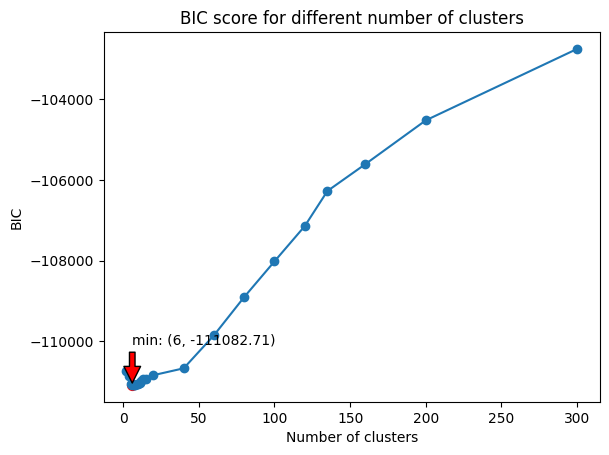

In [10]:

file_path = ".txt"
from datetime import datetime

current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H%M%S")

from basedOnSplitDataset.loadAndCluster import giveDomainTag



from basedOnSplitDataset.SDmyDataset import DatasetFromSplitData 
from preTrain.comet import COMET
from preTrain.comet import COMET
from datetime import datetime
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter

working_directory='./preTrain/model_weight/' 
if not os.path.exists(working_directory):
    os.makedirs(working_directory)
start_time = datetime.now()
seed_everything(1234)
pretrain_model = COMET(
    input_dims=16,
    device=device,
    lr=1e-4,
    depth=10,
    batch_size=64,
    output_dims=512,
    flag_use_multi_gpu=False,
    after_epoch_callback=None,
)

pretrain_model.load(f"{working_directory}pretrain_model20240709_147c16_ver9.pt")

path='./clusterResult'
writerPath=path+'runs/domain_num_' + str(k) + '_seed_'+str(seed_used)
writer=SummaryWriter(writerPath)

clusterEncoder=pretrain_model._net

from torchvision.transforms.transforms import *
from PIL import Image
import torchvision.transforms as transforms
import argparse
from basedOnSplitDataset.SDmyDataset import DatasetFromSplitData,mySubset
from torch import nn
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from visualization.tSNE import *


from domainCluster.domain_seperaterANDcluster_BIC_getClusterCentroid import domain_split
from domainCluster.domain_seperaterANDcluster_BIC_getClusterCentroid import fit_gmm_with_dataloader
from domainCluster.domain_seperaterANDcluster_BIC_getClusterCentroid import calculate_distances_to_centers
from getTotoalDataset import totalDataset

total_Loader = DataLoader(dataset=totalDataset, batch_size=batch_size, shuffle=False, num_workers=0,drop_last=False)

print("get pseudo domain tages")

clusters_0 = np.ones([len(totalDataset), ])
domain_tag,centers = domain_split(total_dataloader=total_Loader,model=clusterEncoder,
                            device=device,cluster_before=clusters_0,filename=path + '/nmi.txt',
                            epoch=-1, batchsize=batch_size,nmb_cluster=k, method='Kmeans',
                            pca_dim=2, whitening=False, L2norm=False,writer=writer)






before=totalDataset.name_segmented
totalDataset.set_cluster_segmented(np.array(domain_tag))

# totalDataset.set_distance_segmented(distances_between_centers)
after=totalDataset.name_segmented





totaldataset=totalDataset

In [11]:
k=args.nd
seed=args.seed
seed_everything(seed=seed)
file_path_new = (formatted_datetime + str('domain_num_') + str(k) + str('_') + str("output_seed_") + str(seed) + file_path)


folder_path = './LeaveOneTest/DANN_baseline' + formatted_datetime
os.makedirs(folder_path, exist_ok=True)
parser_filename = folder_path + '/parser_info.txt'
with open(parser_filename, 'a+') as f:
    f.write(str(args))

domains_tags=totaldataset.pseudo_domain_segmented
from collections import Counter
element_count = Counter(domains_tags)
len(element_count) 


6

In [12]:
len(totalDataset.nameList)

135

In [13]:
# target info:
# patient 127, lable 0, man , age 32, duration 0.1

In [14]:
tgt_acclist,src_accList,true_labelList=myNet(device=device,totalDataset=totaldataset,args=args,domain_num=len(element_count.items()),pre_filename=folder_path,centers=centers )  

  0%|          | 0/135 [00:00<?, ?it/s]

=> runnnnnnning! =>
train_start



  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6653248781249637, acc class: 0.7083333730697632, loss domain: 0.6924230882099697, 



  3%|▎         | 1/30 [00:00<00:26,  1.10it/s]

domain number: 5, loss class: 0.6577431275731042, acc class: 0.7276785969734192, loss domain: 0.693141139688946, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7086, i_tgt_Acc: 0.2917 
Eval: Epoch: 0,domainTag=5, Loss: 0.7106, i_tgt_Acc: 0.3542 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:23,  1.19it/s]

domain number: 5, loss class: 0.5245521792343685, acc class: 0.805059552192688, loss domain: 0.6922639211018881, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6454, i_tgt_Acc: 0.5833 
Eval: Epoch: 1,domainTag=5, Loss: 0.8031, i_tgt_Acc: 0.3542 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5625
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:22,  1.21it/s]

domain number: 5, loss class: 0.3603902452048801, acc class: 0.8273809552192688, loss domain: 0.6908384391239711, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8509, i_tgt_Acc: 0.3958 
Eval: Epoch: 2,domainTag=5, Loss: 1.3414, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2083
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.21it/s]

domain number: 5, loss class: 0.2441124256168093, acc class: 0.8809524178504944, loss domain: 0.6899819884981427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.2723, i_tgt_Acc: 0.9375 
Eval: Epoch: 3,domainTag=5, Loss: 0.7981, i_tgt_Acc: 0.5208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.21it/s]

domain number: 5, loss class: 0.13431483099148386, acc class: 0.9464285969734192, loss domain: 0.6878381087666466, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2873, i_tgt_Acc: 0.8750 
Eval: Epoch: 4,domainTag=5, Loss: 0.7648, i_tgt_Acc: 0.5833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.21it/s]

domain number: 5, loss class: 0.055439134527529986, acc class: 0.9866071343421936, loss domain: 0.686662807351067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0573, i_tgt_Acc: 1.0000 
Eval: Epoch: 5,domainTag=5, Loss: 1.3610, i_tgt_Acc: 0.2917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.02165252559020051, acc class: 0.9985119104385376, loss domain: 0.6853842252776736, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0545, i_tgt_Acc: 1.0000 
Eval: Epoch: 6,domainTag=5, Loss: 0.8952, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9583
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.007156671739981643, acc class: 1.0, loss domain: 0.6832874133473351, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1135, i_tgt_Acc: 0.9583 
Eval: Epoch: 7,domainTag=5, Loss: 1.4369, i_tgt_Acc: 0.4792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.0035307366356608413, acc class: 1.0, loss domain: 0.6830164108957563, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0950, i_tgt_Acc: 0.9792 
Eval: Epoch: 8,domainTag=5, Loss: 1.5723, i_tgt_Acc: 0.4792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.25it/s]

domain number: 5, loss class: 0.0023766760215429322, acc class: 1.0, loss domain: 0.6805679230462938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0499, i_tgt_Acc: 1.0000 
Eval: Epoch: 9,domainTag=5, Loss: 1.2917, i_tgt_Acc: 0.5417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9583
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.29it/s]

domain number: 5, loss class: 0.0016376128187403083, acc class: 1.0, loss domain: 0.6796090460958935, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0633, i_tgt_Acc: 1.0000 
Eval: Epoch: 10,domainTag=5, Loss: 1.5514, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8958
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.28it/s]

domain number: 5, loss class: 0.001279387203144974, acc class: 1.0, loss domain: 0.6776876875332424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0591, i_tgt_Acc: 1.0000 
Eval: Epoch: 11,domainTag=5, Loss: 1.4006, i_tgt_Acc: 0.5417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.26it/s]

domain number: 5, loss class: 0.0007280170850987945, acc class: 1.0, loss domain: 0.6780454715092977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1167, i_tgt_Acc: 0.9583 
Eval: Epoch: 12,domainTag=5, Loss: 1.6068, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0007515754689285089, acc class: 1.0, loss domain: 0.6755663241658892, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0783, i_tgt_Acc: 0.9792 
Eval: Epoch: 13,domainTag=5, Loss: 2.0122, i_tgt_Acc: 0.4583 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.0004677478018926368, acc class: 1.0, loss domain: 0.6764745314915975, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0547, i_tgt_Acc: 1.0000 
Eval: Epoch: 14,domainTag=5, Loss: 1.5884, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.0004059414641233161, acc class: 1.0, loss domain: 0.6749325593312582, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0543, i_tgt_Acc: 1.0000 
Eval: Epoch: 15,domainTag=5, Loss: 1.5919, i_tgt_Acc: 0.5208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0003875098322861872, acc class: 1.0, loss domain: 0.6752516627311707, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0686, i_tgt_Acc: 1.0000 
Eval: Epoch: 16,domainTag=5, Loss: 1.8150, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9375
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.0003823593059288604, acc class: 1.0, loss domain: 0.6766890713146755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0645, i_tgt_Acc: 1.0000 
Eval: Epoch: 17,domainTag=5, Loss: 1.5852, i_tgt_Acc: 0.5208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.22it/s]

domain number: 5, loss class: 0.00030952602087165273, acc class: 1.0, loss domain: 0.6768043410210383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0942, i_tgt_Acc: 0.9375 
Eval: Epoch: 18,domainTag=5, Loss: 1.5906, i_tgt_Acc: 0.5417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003167263795538539, acc class: 1.0, loss domain: 0.6779904649371192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1256, i_tgt_Acc: 0.9167 
Eval: Epoch: 19,domainTag=5, Loss: 1.8403, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.0002537268270056562, acc class: 1.0, loss domain: 0.6798483871278309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1971, i_tgt_Acc: 0.8958 
Eval: Epoch: 20,domainTag=5, Loss: 1.8673, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.00020247610033644983, acc class: 1.0, loss domain: 0.6809545755386353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3042, i_tgt_Acc: 0.8542 
Eval: Epoch: 21,domainTag=5, Loss: 1.4701, i_tgt_Acc: 0.5625 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.00020648612276307263, acc class: 1.0, loss domain: 0.6829421122868856, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.5198, i_tgt_Acc: 0.7917 
Eval: Epoch: 22,domainTag=5, Loss: 1.7074, i_tgt_Acc: 0.5208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00022755523310652714, acc class: 1.0, loss domain: 0.6862601070176988, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.7035, i_tgt_Acc: 0.7292 
Eval: Epoch: 23,domainTag=5, Loss: 1.5066, i_tgt_Acc: 0.5625 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:03,  1.27it/s]

domain number: 5, loss class: 0.0002178228733966881, acc class: 1.0, loss domain: 0.6881722978183201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5435, i_tgt_Acc: 0.7708 
Eval: Epoch: 24,domainTag=5, Loss: 1.3711, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.28it/s]

domain number: 5, loss class: 0.00031337066147465347, acc class: 1.0, loss domain: 0.6904750239281428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.4157, i_tgt_Acc: 0.6458 
Eval: Epoch: 25,domainTag=5, Loss: 1.2376, i_tgt_Acc: 0.7083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.27it/s]

domain number: 5, loss class: 0.0003297161418318172, acc class: 1.0, loss domain: 0.6928459122067406, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.7839, i_tgt_Acc: 0.6042 
Eval: Epoch: 26,domainTag=5, Loss: 1.1197, i_tgt_Acc: 0.7292 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6875
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.26it/s]

domain number: 5, loss class: 0.00030052615156386136, acc class: 1.0, loss domain: 0.6950771695091611, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.8938, i_tgt_Acc: 0.5625 
Eval: Epoch: 27,domainTag=5, Loss: 1.0569, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7083
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.29it/s]

domain number: 5, loss class: 0.0003561044182528609, acc class: 1.0, loss domain: 0.6967133510680426, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.3299, i_tgt_Acc: 0.5417 
Eval: Epoch: 28,domainTag=5, Loss: 0.9457, i_tgt_Acc: 0.7708 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  1%|          | 1/135 [00:24<54:13, 24.28s/it]

domain number: 5, loss class: 0.00037344316938071556, acc class: 1.0, loss domain: 0.6993561954725356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.3103, i_tgt_Acc: 0.5208 
Eval: Epoch: 29,domainTag=5, Loss: 0.7969, i_tgt_Acc: 0.7917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6875
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6626087597438267, acc class: 0.7098214626312256, loss domain: 0.692482298328763, 



  3%|▎         | 1/30 [00:00<00:22,  1.32it/s]

domain number: 5, loss class: 0.6688304060981387, acc class: 0.5967261791229248, loss domain: 0.6939490778105599, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7516, i_tgt_Acc: 0.1026 
Eval: Epoch: 0,domainTag=5, Loss: 0.7010, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.535749824274154, acc class: 0.8080357313156128, loss domain: 0.6935607365199498, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8986, i_tgt_Acc: 0.2821 
Eval: Epoch: 1,domainTag=5, Loss: 0.8545, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1795
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.31452207551116035, acc class: 0.8764880895614624, loss domain: 0.692856368564424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7821, i_tgt_Acc: 0.4103 
Eval: Epoch: 2,domainTag=5, Loss: 0.8744, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4103
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.18357219617991222, acc class: 0.9345238208770752, loss domain: 0.6920225705419268, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8928, i_tgt_Acc: 0.4103 
Eval: Epoch: 3,domainTag=5, Loss: 1.1170, i_tgt_Acc: 0.2564 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

domain number: 5, loss class: 0.09744388042461305, acc class: 0.9657738208770752, loss domain: 0.6909417282967341, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.4620, i_tgt_Acc: 0.3077 
Eval: Epoch: 4,domainTag=5, Loss: 1.5364, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.04356760522794156, acc class: 0.9880952835083008, loss domain: 0.6904332212039402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.9292, i_tgt_Acc: 0.2821 
Eval: Epoch: 5,domainTag=5, Loss: 1.3910, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.016235370144602797, acc class: 0.9985119104385376, loss domain: 0.6891358636674427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.9592, i_tgt_Acc: 0.2051 
Eval: Epoch: 6,domainTag=5, Loss: 2.1659, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1795
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.008115088220663546, acc class: 1.0, loss domain: 0.6867691732588268, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.9831, i_tgt_Acc: 0.2308 
Eval: Epoch: 7,domainTag=5, Loss: 2.4702, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1795
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.003749920859090274, acc class: 1.0, loss domain: 0.6854757694970994, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.2388, i_tgt_Acc: 0.2308 
Eval: Epoch: 8,domainTag=5, Loss: 2.5716, i_tgt_Acc: 0.2564 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.0025181993398638, acc class: 1.0, loss domain: 0.6839797581945147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.6402, i_tgt_Acc: 0.2051 
Eval: Epoch: 9,domainTag=5, Loss: 2.8372, i_tgt_Acc: 0.2564 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.0012368764783743593, acc class: 1.0, loss domain: 0.6819361930801755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.5000, i_tgt_Acc: 0.2308 
Eval: Epoch: 10,domainTag=5, Loss: 2.6472, i_tgt_Acc: 0.2564 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0012147644038556055, acc class: 1.0, loss domain: 0.6814739590599423, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.4608, i_tgt_Acc: 0.2308 
Eval: Epoch: 11,domainTag=5, Loss: 3.2450, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.25it/s]

domain number: 5, loss class: 0.0007429725166210639, acc class: 1.0, loss domain: 0.6782973947979155, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.8049, i_tgt_Acc: 0.2308 
Eval: Epoch: 12,domainTag=5, Loss: 3.1573, i_tgt_Acc: 0.2564 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0007002859832330918, acc class: 1.0, loss domain: 0.6787029703458151, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.4690, i_tgt_Acc: 0.2308 
Eval: Epoch: 13,domainTag=5, Loss: 3.2199, i_tgt_Acc: 0.2564 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0003953243517788083, acc class: 1.0, loss domain: 0.677781031245277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.5677, i_tgt_Acc: 0.2051 
Eval: Epoch: 14,domainTag=5, Loss: 3.5284, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.000356966805286772, acc class: 1.0, loss domain: 0.6775613001414708, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.4108, i_tgt_Acc: 0.2308 
Eval: Epoch: 15,domainTag=5, Loss: 3.8621, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0002797276195321631, acc class: 1.0, loss domain: 0.676893188839867, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.3338, i_tgt_Acc: 0.2564 
Eval: Epoch: 16,domainTag=5, Loss: 4.1405, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00043956586922008897, acc class: 1.0, loss domain: 0.6777744747343517, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.2478, i_tgt_Acc: 0.2821 
Eval: Epoch: 17,domainTag=5, Loss: 4.1619, i_tgt_Acc: 0.1795 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003189706836738402, acc class: 1.0, loss domain: 0.678289322626023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.0688, i_tgt_Acc: 0.2821 
Eval: Epoch: 18,domainTag=5, Loss: 4.8905, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.25it/s]

domain number: 5, loss class: 0.00039559391630713696, acc class: 1.0, loss domain: 0.6778370624496823, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.7612, i_tgt_Acc: 0.3846 
Eval: Epoch: 19,domainTag=5, Loss: 4.8872, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2051
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.000273524360853203, acc class: 1.0, loss domain: 0.6803738787060692, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.6847, i_tgt_Acc: 0.4359 
Eval: Epoch: 20,domainTag=5, Loss: 5.4949, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.00029464227139084997, acc class: 1.0, loss domain: 0.6808024588085356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.4140, i_tgt_Acc: 0.5128 
Eval: Epoch: 21,domainTag=5, Loss: 5.9304, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.00027732456579715724, acc class: 1.0, loss domain: 0.6819598050344557, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.1714, i_tgt_Acc: 0.5385 
Eval: Epoch: 22,domainTag=5, Loss: 5.9158, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00024290434694627212, acc class: 1.0, loss domain: 0.6835332598005023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.1182, i_tgt_Acc: 0.5385 
Eval: Epoch: 23,domainTag=5, Loss: 6.3536, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0002696149531402625, acc class: 1.0, loss domain: 0.6855949021521068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.6373, i_tgt_Acc: 0.5897 
Eval: Epoch: 24,domainTag=5, Loss: 6.4987, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3590
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0004503200405105461, acc class: 1.0, loss domain: 0.6864805477006095, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.8609, i_tgt_Acc: 0.5641 
Eval: Epoch: 25,domainTag=5, Loss: 6.4218, i_tgt_Acc: 0.1795 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3590
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.00033122477907454595, acc class: 1.0, loss domain: 0.6869773495764959, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.5650, i_tgt_Acc: 0.6667 
Eval: Epoch: 26,domainTag=5, Loss: 6.4436, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5641
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.0002835375441160674, acc class: 1.0, loss domain: 0.688983352411361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.6477, i_tgt_Acc: 0.6923 
Eval: Epoch: 27,domainTag=5, Loss: 6.6786, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4872
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

domain number: 5, loss class: 0.00026680095054741414, acc class: 1.0, loss domain: 0.6892598810650054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.4785, i_tgt_Acc: 0.7179 
Eval: Epoch: 28,domainTag=5, Loss: 6.5817, i_tgt_Acc: 0.2821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  1%|▏         | 2/135 [00:48<54:03, 24.39s/it]

domain number: 5, loss class: 0.00033503102029152655, acc class: 1.0, loss domain: 0.6922337469600496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.7654, i_tgt_Acc: 0.6923 
Eval: Epoch: 29,domainTag=5, Loss: 6.2497, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5128
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6688896587916783, acc class: 0.7142857313156128, loss domain: 0.6929332216580709, 



  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

domain number: 5, loss class: 0.6686147110802787, acc class: 0.586309552192688, loss domain: 0.6929463602247692, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6182, i_tgt_Acc: 0.9825 
Eval: Epoch: 0,domainTag=5, Loss: 0.7316, i_tgt_Acc: 0.0351 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.26it/s]

domain number: 5, loss class: 0.5579546846094585, acc class: 0.7663690447807312, loss domain: 0.6916122550056094, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5347, i_tgt_Acc: 0.8246 
Eval: Epoch: 1,domainTag=5, Loss: 0.6822, i_tgt_Acc: 0.6140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7719
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

domain number: 5, loss class: 0.3707244921298254, acc class: 0.831845223903656, loss domain: 0.690188311395191, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5826, i_tgt_Acc: 0.7018 
Eval: Epoch: 2,domainTag=5, Loss: 0.3306, i_tgt_Acc: 0.9649 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8772
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.22957025503828413, acc class: 0.9017857313156128, loss domain: 0.688615878423055, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3964, i_tgt_Acc: 0.8947 
Eval: Epoch: 3,domainTag=5, Loss: 0.2278, i_tgt_Acc: 0.9474 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.22it/s]

domain number: 5, loss class: 0.11879355283010573, acc class: 0.961309552192688, loss domain: 0.687906006971995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2178, i_tgt_Acc: 0.9123 
Eval: Epoch: 4,domainTag=5, Loss: 0.2807, i_tgt_Acc: 0.8772 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.05430221672923792, acc class: 0.980654776096344, loss domain: 0.6848125486146837, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3886, i_tgt_Acc: 0.8596 
Eval: Epoch: 5,domainTag=5, Loss: 0.1655, i_tgt_Acc: 0.9123 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.02372477389872074, acc class: 0.9985119104385376, loss domain: 0.6849766402017503, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0719, i_tgt_Acc: 0.9649 
Eval: Epoch: 6,domainTag=5, Loss: 0.1543, i_tgt_Acc: 0.8947 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.009475330874833855, acc class: 0.9985119104385376, loss domain: 0.6827301751999628, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1161, i_tgt_Acc: 0.9649 
Eval: Epoch: 7,domainTag=5, Loss: 0.1506, i_tgt_Acc: 0.9123 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

domain number: 5, loss class: 0.005328321757371582, acc class: 1.0, loss domain: 0.6811836929548354, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0748, i_tgt_Acc: 0.9649 
Eval: Epoch: 8,domainTag=5, Loss: 0.3505, i_tgt_Acc: 0.8070 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.002082870005064511, acc class: 1.0, loss domain: 0.6795428934551421, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0639, i_tgt_Acc: 0.9649 
Eval: Epoch: 9,domainTag=5, Loss: 0.2479, i_tgt_Acc: 0.8947 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.0015172298756494587, acc class: 1.0, loss domain: 0.6785217296509516, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0580, i_tgt_Acc: 0.9649 
Eval: Epoch: 10,domainTag=5, Loss: 0.2750, i_tgt_Acc: 0.8772 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.21it/s]

domain number: 5, loss class: 0.0010067857767266798, acc class: 1.0, loss domain: 0.6770933298837571, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0771, i_tgt_Acc: 0.9649 
Eval: Epoch: 11,domainTag=5, Loss: 0.2859, i_tgt_Acc: 0.8947 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:14,  1.21it/s]

domain number: 5, loss class: 0.0006337272394115903, acc class: 1.0, loss domain: 0.6772470587775821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0555, i_tgt_Acc: 0.9649 
Eval: Epoch: 12,domainTag=5, Loss: 0.3206, i_tgt_Acc: 0.8421 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

domain number: 5, loss class: 0.0005480822791079325, acc class: 1.0, loss domain: 0.6761157285599482, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0586, i_tgt_Acc: 0.9649 
Eval: Epoch: 13,domainTag=5, Loss: 0.3108, i_tgt_Acc: 0.8596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.00056294933684902, acc class: 1.0, loss domain: 0.6762942955607459, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0518, i_tgt_Acc: 0.9825 
Eval: Epoch: 14,domainTag=5, Loss: 0.4273, i_tgt_Acc: 0.8070 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.24it/s]

domain number: 5, loss class: 0.0004075051734357008, acc class: 1.0, loss domain: 0.6762194065820604, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0570, i_tgt_Acc: 0.9825 
Eval: Epoch: 15,domainTag=5, Loss: 0.4551, i_tgt_Acc: 0.8070 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0003465558471535111, acc class: 1.0, loss domain: 0.676600232010796, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0541, i_tgt_Acc: 0.9825 
Eval: Epoch: 16,domainTag=5, Loss: 0.4913, i_tgt_Acc: 0.7895 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.00039009997479817163, acc class: 1.0, loss domain: 0.6774183369818187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0723, i_tgt_Acc: 0.9649 
Eval: Epoch: 17,domainTag=5, Loss: 0.5857, i_tgt_Acc: 0.7895 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9649
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00041494121181867306, acc class: 1.0, loss domain: 0.6794687793368385, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0620, i_tgt_Acc: 0.9825 
Eval: Epoch: 18,domainTag=5, Loss: 0.6397, i_tgt_Acc: 0.7895 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9825
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.0003552998996816487, acc class: 1.0, loss domain: 0.6796431626592364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0706, i_tgt_Acc: 0.9825 
Eval: Epoch: 19,domainTag=5, Loss: 0.9627, i_tgt_Acc: 0.7018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.20it/s]

domain number: 5, loss class: 0.0002701744136478131, acc class: 1.0, loss domain: 0.6814073494502476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0616, i_tgt_Acc: 0.9825 
Eval: Epoch: 20,domainTag=5, Loss: 0.9641, i_tgt_Acc: 0.7018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:18<00:06,  1.20it/s]

domain number: 5, loss class: 0.0003820068834881697, acc class: 1.0, loss domain: 0.6833185156186422, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0821, i_tgt_Acc: 0.9825 
Eval: Epoch: 21,domainTag=5, Loss: 1.1765, i_tgt_Acc: 0.7018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.00024467698572802225, acc class: 1.0, loss domain: 0.6856035192807516, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.1071, i_tgt_Acc: 0.9825 
Eval: Epoch: 22,domainTag=5, Loss: 1.5433, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0003197950839724702, acc class: 1.0, loss domain: 0.6874379572414216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1340, i_tgt_Acc: 0.9474 
Eval: Epoch: 23,domainTag=5, Loss: 1.8227, i_tgt_Acc: 0.5965 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8246
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.25it/s]

domain number: 5, loss class: 0.000388757854948164, acc class: 1.0, loss domain: 0.6899829875855219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.2453, i_tgt_Acc: 0.9123 
Eval: Epoch: 24,domainTag=5, Loss: 2.5057, i_tgt_Acc: 0.4737 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7544
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.27it/s]

domain number: 5, loss class: 0.0003783465820431177, acc class: 1.0, loss domain: 0.6927129370825631, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.4740, i_tgt_Acc: 0.8070 
Eval: Epoch: 25,domainTag=5, Loss: 3.1711, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5965
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.27it/s]

domain number: 5, loss class: 0.0004165183019635844, acc class: 1.0, loss domain: 0.6954860942704337, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.9503, i_tgt_Acc: 0.7018 
Eval: Epoch: 26,domainTag=5, Loss: 4.0022, i_tgt_Acc: 0.2982 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5088
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.28it/s]

domain number: 5, loss class: 0.00035579195831641775, acc class: 1.0, loss domain: 0.700034309001196, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.4680, i_tgt_Acc: 0.5789 
Eval: Epoch: 27,domainTag=5, Loss: 5.8242, i_tgt_Acc: 0.2281 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3158
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.28it/s]

domain number: 5, loss class: 0.001437620034439966, acc class: 1.0, loss domain: 0.7038211936042422, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.5344, i_tgt_Acc: 0.2807 
Eval: Epoch: 28,domainTag=5, Loss: 5.1495, i_tgt_Acc: 0.2456 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2632
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  2%|▏         | 3/135 [01:13<54:07, 24.60s/it]

domain number: 5, loss class: 0.0005857352679456762, acc class: 1.0, loss domain: 0.7059528203237624, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.0043, i_tgt_Acc: 0.1930 
Eval: Epoch: 29,domainTag=5, Loss: 7.4743, i_tgt_Acc: 0.2105 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1930
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6713584803399586, acc class: 0.636904776096344, loss domain: 0.692881723244985, 



  3%|▎         | 1/30 [00:00<00:20,  1.45it/s]

domain number: 5, loss class: 0.668069927465348, acc class: 0.648809552192688, loss domain: 0.6929099843615577, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6616, i_tgt_Acc: 0.8125 
Eval: Epoch: 0,domainTag=5, Loss: 0.7008, i_tgt_Acc: 0.4167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:20,  1.36it/s]

domain number: 5, loss class: 0.5562922812643505, acc class: 0.769345223903656, loss domain: 0.6899240584600539, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5529, i_tgt_Acc: 0.8333 
Eval: Epoch: 1,domainTag=5, Loss: 0.6847, i_tgt_Acc: 0.4792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.31it/s]

domain number: 5, loss class: 0.3692343220824287, acc class: 0.831845223903656, loss domain: 0.6880787043344407, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4356, i_tgt_Acc: 0.8333 
Eval: Epoch: 2,domainTag=5, Loss: 0.7820, i_tgt_Acc: 0.4375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.30it/s]

domain number: 5, loss class: 0.24972923596700033, acc class: 0.9047619104385376, loss domain: 0.6857676307360331, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7098, i_tgt_Acc: 0.6667 
Eval: Epoch: 3,domainTag=5, Loss: 0.8131, i_tgt_Acc: 0.3958 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5625
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.30it/s]

domain number: 5, loss class: 0.12413913384079933, acc class: 0.9523809552192688, loss domain: 0.6853831382024855, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5960, i_tgt_Acc: 0.6667 
Eval: Epoch: 4,domainTag=5, Loss: 0.5944, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.30it/s]

domain number: 5, loss class: 0.06648054204526402, acc class: 0.9761905074119568, loss domain: 0.6829379030636379, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.7883, i_tgt_Acc: 0.6458 
Eval: Epoch: 5,domainTag=5, Loss: 0.8719, i_tgt_Acc: 0.5417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

domain number: 5, loss class: 0.02957112623733424, acc class: 0.9910714626312256, loss domain: 0.6811520003137135, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.1803, i_tgt_Acc: 0.5833 
Eval: Epoch: 6,domainTag=5, Loss: 0.7666, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:16,  1.30it/s]

domain number: 5, loss class: 0.00983553889784075, acc class: 1.0, loss domain: 0.6794425532931373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.9299, i_tgt_Acc: 0.6458 
Eval: Epoch: 7,domainTag=5, Loss: 0.5035, i_tgt_Acc: 0.7083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.28it/s]

domain number: 5, loss class: 0.003915273900409895, acc class: 1.0, loss domain: 0.6772959714844113, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.0318, i_tgt_Acc: 0.6458 
Eval: Epoch: 8,domainTag=5, Loss: 0.6625, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.27it/s]

domain number: 5, loss class: 0.001755330162788076, acc class: 1.0, loss domain: 0.676286898908161, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.3013, i_tgt_Acc: 0.6042 
Eval: Epoch: 9,domainTag=5, Loss: 0.7190, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.27it/s]

domain number: 5, loss class: 0.0012811370875819453, acc class: 1.0, loss domain: 0.6752265634990874, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.0020, i_tgt_Acc: 0.6667 
Eval: Epoch: 10,domainTag=5, Loss: 0.7051, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.27it/s]

domain number: 5, loss class: 0.000980049973198523, acc class: 1.0, loss domain: 0.6739144836153302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.0575, i_tgt_Acc: 0.6667 
Eval: Epoch: 11,domainTag=5, Loss: 0.7329, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.28it/s]

domain number: 5, loss class: 0.000620517615018235, acc class: 1.0, loss domain: 0.6734226828529721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.1070, i_tgt_Acc: 0.6667 
Eval: Epoch: 12,domainTag=5, Loss: 0.7911, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.28it/s]

domain number: 5, loss class: 0.0005788089543957973, acc class: 1.0, loss domain: 0.6725055234772819, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.1185, i_tgt_Acc: 0.6667 
Eval: Epoch: 13,domainTag=5, Loss: 0.7335, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.27it/s]

domain number: 5, loss class: 0.0008196474546344863, acc class: 1.0, loss domain: 0.67168318657648, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.0956, i_tgt_Acc: 0.6667 
Eval: Epoch: 14,domainTag=5, Loss: 1.0304, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0006245519193942615, acc class: 1.0, loss domain: 0.6723693609237671, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.2148, i_tgt_Acc: 0.6667 
Eval: Epoch: 15,domainTag=5, Loss: 1.1241, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6458
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0003940141586575746, acc class: 1.0, loss domain: 0.6728964675040472, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.1422, i_tgt_Acc: 0.6875 
Eval: Epoch: 16,domainTag=5, Loss: 0.9304, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.25it/s]

domain number: 5, loss class: 0.0006033342312245319, acc class: 1.0, loss domain: 0.6760940665290469, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.2741, i_tgt_Acc: 0.6667 
Eval: Epoch: 17,domainTag=5, Loss: 0.8176, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.26it/s]

domain number: 5, loss class: 0.0004407941482246055, acc class: 1.0, loss domain: 0.6786987497693017, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.2317, i_tgt_Acc: 0.6875 
Eval: Epoch: 18,domainTag=5, Loss: 0.9272, i_tgt_Acc: 0.6458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.27it/s]

domain number: 5, loss class: 0.00033672344025468366, acc class: 1.0, loss domain: 0.6800874074300131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.2667, i_tgt_Acc: 0.6875 
Eval: Epoch: 19,domainTag=5, Loss: 1.0496, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.0003226939592249913, acc class: 1.0, loss domain: 0.6836559346743992, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1768, i_tgt_Acc: 0.6875 
Eval: Epoch: 20,domainTag=5, Loss: 1.1021, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:07,  1.11it/s]

domain number: 5, loss class: 0.0003521610484486224, acc class: 1.0, loss domain: 0.6862312498546782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.0968, i_tgt_Acc: 0.6875 
Eval: Epoch: 21,domainTag=5, Loss: 1.3510, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:06,  1.12it/s]

domain number: 5, loss class: 0.00036790150140101713, acc class: 1.0, loss domain: 0.689227717263358, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.1946, i_tgt_Acc: 0.6667 
Eval: Epoch: 22,domainTag=5, Loss: 1.3828, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:05,  1.14it/s]

domain number: 5, loss class: 0.0005826581966955148, acc class: 1.0, loss domain: 0.6910723476182847, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.1491, i_tgt_Acc: 0.6667 
Eval: Epoch: 23,domainTag=5, Loss: 1.5788, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.17it/s]

domain number: 5, loss class: 0.0002604721171554134, acc class: 1.0, loss domain: 0.6932768679800487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.0571, i_tgt_Acc: 0.7083 
Eval: Epoch: 24,domainTag=5, Loss: 1.6107, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.19it/s]

domain number: 5, loss class: 0.00038295374438998157, acc class: 1.0, loss domain: 0.69645247005281, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.0891, i_tgt_Acc: 0.7083 
Eval: Epoch: 25,domainTag=5, Loss: 1.7665, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.19it/s]

domain number: 5, loss class: 0.0005022723922766524, acc class: 1.0, loss domain: 0.6962199296270098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.1949, i_tgt_Acc: 0.7292 
Eval: Epoch: 26,domainTag=5, Loss: 2.3175, i_tgt_Acc: 0.5208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.21it/s]

domain number: 5, loss class: 0.00023270155430682714, acc class: 1.0, loss domain: 0.698751775991349, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.1983, i_tgt_Acc: 0.7292 
Eval: Epoch: 27,domainTag=5, Loss: 1.9921, i_tgt_Acc: 0.6042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0004480686308982383, acc class: 1.0, loss domain: 0.700147773538317, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.1288, i_tgt_Acc: 0.7500 
Eval: Epoch: 28,domainTag=5, Loss: 2.5289, i_tgt_Acc: 0.5417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  3%|▎         | 4/135 [01:38<53:37, 24.56s/it]

domain number: 5, loss class: 0.0003538929011570179, acc class: 1.0, loss domain: 0.7025880785215468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.1636, i_tgt_Acc: 0.7708 
Eval: Epoch: 29,domainTag=5, Loss: 2.6511, i_tgt_Acc: 0.5625 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6661837242898487, acc class: 0.6607142686843872, loss domain: 0.6927229790460496, 



  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]

domain number: 2, loss class: 0.6707482161847028, acc class: 0.6384943127632141, loss domain: 0.692000225186348, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6350, i_tgt_Acc: 0.9600 
Eval: Epoch: 0,domainTag=2, Loss: 0.8656, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]

domain number: 2, loss class: 0.511055972088467, acc class: 0.7762784361839294, loss domain: 0.6899190667000684, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3939, i_tgt_Acc: 0.9800 
Eval: Epoch: 1,domainTag=2, Loss: 1.2090, i_tgt_Acc: 0.1200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:33,  1.23s/it]

domain number: 2, loss class: 0.2815046307038177, acc class: 0.8792613744735718, loss domain: 0.686660414392298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5356, i_tgt_Acc: 0.7200 
Eval: Epoch: 2,domainTag=2, Loss: 1.0617, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]

domain number: 2, loss class: 0.13400948073037647, acc class: 0.9460227489471436, loss domain: 0.6848866573788903, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7540, i_tgt_Acc: 0.4600 
Eval: Epoch: 3,domainTag=2, Loss: 1.4484, i_tgt_Acc: 0.3600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:31,  1.24s/it]

domain number: 2, loss class: 0.06459018044089052, acc class: 0.9794034361839294, loss domain: 0.6825542558323253, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3650, i_tgt_Acc: 0.8200 
Eval: Epoch: 4,domainTag=2, Loss: 2.4688, i_tgt_Acc: 0.2400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.24s/it]

domain number: 2, loss class: 0.02857698630329899, acc class: 0.9921875, loss domain: 0.6799656721678647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3510, i_tgt_Acc: 0.8200 
Eval: Epoch: 5,domainTag=2, Loss: 1.5469, i_tgt_Acc: 0.4600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.23s/it]

domain number: 2, loss class: 0.008236990588061004, acc class: 1.0, loss domain: 0.6770952262661674, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3953, i_tgt_Acc: 0.8000 
Eval: Epoch: 6,domainTag=2, Loss: 1.5504, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:27,  1.23s/it]

domain number: 2, loss class: 0.004365118998314508, acc class: 0.9992898106575012, loss domain: 0.675408040935343, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4939, i_tgt_Acc: 0.7200 
Eval: Epoch: 7,domainTag=2, Loss: 1.7805, i_tgt_Acc: 0.4600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:25,  1.23s/it]

domain number: 2, loss class: 0.0027517913364466617, acc class: 1.0, loss domain: 0.6748356101187792, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.4540, i_tgt_Acc: 0.8000 
Eval: Epoch: 8,domainTag=2, Loss: 1.3303, i_tgt_Acc: 0.5800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.22s/it]

domain number: 2, loss class: 0.001171585528275252, acc class: 1.0, loss domain: 0.6742652641101317, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3566, i_tgt_Acc: 0.8200 
Eval: Epoch: 9,domainTag=2, Loss: 0.9425, i_tgt_Acc: 0.6800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.23s/it]

domain number: 2, loss class: 0.0007970011197771369, acc class: 1.0, loss domain: 0.6752990524877202, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.5101, i_tgt_Acc: 0.7600 
Eval: Epoch: 10,domainTag=2, Loss: 0.6460, i_tgt_Acc: 0.7800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.23s/it]

domain number: 2, loss class: 0.0011955544134914155, acc class: 1.0, loss domain: 0.6788334629752419, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.5447, i_tgt_Acc: 0.7400 
Eval: Epoch: 11,domainTag=2, Loss: 0.4792, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:16<00:20,  1.23s/it]

domain number: 2, loss class: 0.0006985681839895816, acc class: 1.0, loss domain: 0.6815840060060675, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.4759, i_tgt_Acc: 0.7800 
Eval: Epoch: 12,domainTag=2, Loss: 0.3979, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:17<00:19,  1.23s/it]

domain number: 2, loss class: 0.0006918963441752236, acc class: 1.0, loss domain: 0.6852660558440469, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.7437, i_tgt_Acc: 0.6400 
Eval: Epoch: 13,domainTag=2, Loss: 0.2370, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.23s/it]

domain number: 2, loss class: 0.000574573974517989, acc class: 1.0, loss domain: 0.690598957917907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.8672, i_tgt_Acc: 0.5800 
Eval: Epoch: 14,domainTag=2, Loss: 0.2118, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.23s/it]

domain number: 2, loss class: 0.000392377139591686, acc class: 1.0, loss domain: 0.6930965781211853, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.9491, i_tgt_Acc: 0.5600 
Eval: Epoch: 15,domainTag=2, Loss: 0.1465, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:16,  1.23s/it]

domain number: 2, loss class: 0.0007414187774967021, acc class: 1.0, loss domain: 0.6955749311230399, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.0785, i_tgt_Acc: 0.5200 
Eval: Epoch: 16,domainTag=2, Loss: 0.1557, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:22<00:14,  1.23s/it]

domain number: 2, loss class: 0.0004985124767865108, acc class: 1.0, loss domain: 0.697038395838304, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.1817, i_tgt_Acc: 0.5000 
Eval: Epoch: 17,domainTag=2, Loss: 0.1282, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:23<00:13,  1.22s/it]

domain number: 2, loss class: 0.00040726118326843294, acc class: 1.0, loss domain: 0.6972616518085654, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.3132, i_tgt_Acc: 0.4800 
Eval: Epoch: 18,domainTag=2, Loss: 0.1453, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.21s/it]

domain number: 2, loss class: 0.0008880966447164114, acc class: 1.0, loss domain: 0.6988026174631986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.6079, i_tgt_Acc: 0.4600 
Eval: Epoch: 19,domainTag=2, Loss: 0.1833, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:10,  1.21s/it]

domain number: 2, loss class: 0.0005832178277904114, acc class: 1.0, loss domain: 0.7032034519043836, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.0330, i_tgt_Acc: 0.4200 
Eval: Epoch: 20,domainTag=2, Loss: 0.5997, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:09,  1.22s/it]

domain number: 2, loss class: 0.00031792918947427427, acc class: 1.0, loss domain: 0.7107644013383172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.1093, i_tgt_Acc: 0.3400 
Eval: Epoch: 21,domainTag=2, Loss: 2.6795, i_tgt_Acc: 0.4200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.22s/it]

domain number: 2, loss class: 0.0007932304800471519, acc class: 1.0, loss domain: 0.7220663536678661, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.3744, i_tgt_Acc: 0.3400 
Eval: Epoch: 22,domainTag=2, Loss: 8.5595, i_tgt_Acc: 0.0600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.22s/it]

domain number: 2, loss class: 0.0010205934355863892, acc class: 1.0, loss domain: 0.7356011068279092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.4405, i_tgt_Acc: 0.3000 
Eval: Epoch: 23,domainTag=2, Loss: 12.7502, i_tgt_Acc: 0.0200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.23s/it]

domain number: 2, loss class: 0.002611863150625802, acc class: 0.9992898106575012, loss domain: 0.7411067634820938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 6.3428, i_tgt_Acc: 0.2200 
Eval: Epoch: 24,domainTag=2, Loss: 21.3779, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:31<00:04,  1.23s/it]

domain number: 2, loss class: 0.00659888702400415, acc class: 0.9978693723678589, loss domain: 0.7403037439693104, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 8.1756, i_tgt_Acc: 0.0800 
Eval: Epoch: 25,domainTag=2, Loss: 19.6333, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.23s/it]

domain number: 2, loss class: 0.007785133670608957, acc class: 0.9971591234207153, loss domain: 0.7306648316708478, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 10.0813, i_tgt_Acc: 0.0400 
Eval: Epoch: 26,domainTag=2, Loss: 22.8046, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.23s/it]

domain number: 2, loss class: 0.0030558921813818333, acc class: 0.9985795617103577, loss domain: 0.7212724848227068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 12.4592, i_tgt_Acc: 0.0400 
Eval: Epoch: 27,domainTag=2, Loss: 23.3724, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:35<00:01,  1.23s/it]

domain number: 2, loss class: 0.001130852128260978, acc class: 1.0, loss domain: 0.7123378284952857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 14.9021, i_tgt_Acc: 0.0400 
Eval: Epoch: 28,domainTag=2, Loss: 21.0473, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  4%|▎         | 5/135 [02:15<1:03:05, 29.12s/it]

domain number: 2, loss class: 0.0026893295644805967, acc class: 0.9992898106575012, loss domain: 0.705596765333956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 14.5018, i_tgt_Acc: 0.0400 
Eval: Epoch: 29,domainTag=2, Loss: 22.1713, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6593411820275443, acc class: 0.6979166865348816, loss domain: 0.6922303863934108, 



  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

domain number: 5, loss class: 0.6584351772353763, acc class: 0.6517857313156128, loss domain: 0.6927690420831952, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6425, i_tgt_Acc: 0.8936 
Eval: Epoch: 0,domainTag=5, Loss: 0.6681, i_tgt_Acc: 0.7021 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9149
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5049139303820473, acc class: 0.7767857313156128, loss domain: 0.6914508910406203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5859, i_tgt_Acc: 0.7021 
Eval: Epoch: 1,domainTag=5, Loss: 0.5870, i_tgt_Acc: 0.6383 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.30641580124696094, acc class: 0.855654776096344, loss domain: 0.6907468636830648, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5813, i_tgt_Acc: 0.6170 
Eval: Epoch: 2,domainTag=5, Loss: 0.9403, i_tgt_Acc: 0.3617 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4468
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.21490311374266943, acc class: 0.9047619104385376, loss domain: 0.6902806276366824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6657, i_tgt_Acc: 0.5745 
Eval: Epoch: 3,domainTag=5, Loss: 0.8102, i_tgt_Acc: 0.3830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

domain number: 5, loss class: 0.12575533170075642, acc class: 0.9642857313156128, loss domain: 0.6883770568030221, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5878, i_tgt_Acc: 0.7234 
Eval: Epoch: 4,domainTag=5, Loss: 0.3267, i_tgt_Acc: 0.8085 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8511
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.0494509967310088, acc class: 0.992559552192688, loss domain: 0.6857813937323434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1965, i_tgt_Acc: 0.8936 
Eval: Epoch: 5,domainTag=5, Loss: 0.1986, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.023357915514636608, acc class: 0.9940476417541504, loss domain: 0.68463815393902, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1477, i_tgt_Acc: 0.8936 
Eval: Epoch: 6,domainTag=5, Loss: 0.3248, i_tgt_Acc: 0.8085 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.011560654312017419, acc class: 1.0, loss domain: 0.6838268552507673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4985, i_tgt_Acc: 0.8298 
Eval: Epoch: 7,domainTag=5, Loss: 0.1599, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9362
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.0048905534037788, acc class: 1.0, loss domain: 0.6810490687688192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2795, i_tgt_Acc: 0.8723 
Eval: Epoch: 8,domainTag=5, Loss: 0.1553, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.24it/s]

domain number: 5, loss class: 0.003657444585336461, acc class: 1.0, loss domain: 0.6790469941638765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3089, i_tgt_Acc: 0.8723 
Eval: Epoch: 9,domainTag=5, Loss: 0.1247, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9362
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.002618296202161305, acc class: 1.0, loss domain: 0.6771465766997564, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3001, i_tgt_Acc: 0.8723 
Eval: Epoch: 10,domainTag=5, Loss: 0.1325, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.22it/s]

domain number: 5, loss class: 0.0021748646367563025, acc class: 1.0, loss domain: 0.6764707281475976, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3161, i_tgt_Acc: 0.8511 
Eval: Epoch: 11,domainTag=5, Loss: 0.2669, i_tgt_Acc: 0.8723 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.0010626771531644322, acc class: 1.0, loss domain: 0.6754577699161711, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2582, i_tgt_Acc: 0.8723 
Eval: Epoch: 12,domainTag=5, Loss: 0.1172, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

domain number: 5, loss class: 0.00107786708741471, acc class: 1.0, loss domain: 0.6737867338316781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3031, i_tgt_Acc: 0.8511 
Eval: Epoch: 13,domainTag=5, Loss: 0.1108, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0011256261537450232, acc class: 1.0, loss domain: 0.6743052119300479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2518, i_tgt_Acc: 0.8723 
Eval: Epoch: 14,domainTag=5, Loss: 0.0933, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.22it/s]

domain number: 5, loss class: 0.0004352466910079654, acc class: 1.0, loss domain: 0.6723368309793019, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.3510, i_tgt_Acc: 0.8511 
Eval: Epoch: 15,domainTag=5, Loss: 0.0701, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0005559297136469034, acc class: 1.0, loss domain: 0.6725645803269886, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3830, i_tgt_Acc: 0.8298 
Eval: Epoch: 16,domainTag=5, Loss: 0.1506, i_tgt_Acc: 0.9574 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.00036629208175110675, acc class: 1.0, loss domain: 0.672156035900116, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4347, i_tgt_Acc: 0.8298 
Eval: Epoch: 17,domainTag=5, Loss: 0.0921, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00042374827136795615, acc class: 1.0, loss domain: 0.6735142554555621, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4867, i_tgt_Acc: 0.8298 
Eval: Epoch: 18,domainTag=5, Loss: 0.1210, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9362
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0002901252377168497, acc class: 1.0, loss domain: 0.6744457767123267, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4593, i_tgt_Acc: 0.8298 
Eval: Epoch: 19,domainTag=5, Loss: 0.0915, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.0002929016984472539, acc class: 1.0, loss domain: 0.674684464931488, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5396, i_tgt_Acc: 0.8085 
Eval: Epoch: 20,domainTag=5, Loss: 0.1454, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9362
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0003240121775542364, acc class: 1.0, loss domain: 0.6770901623226347, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.6458, i_tgt_Acc: 0.7660 
Eval: Epoch: 21,domainTag=5, Loss: 0.1297, i_tgt_Acc: 0.9787 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8511
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0005011318533520569, acc class: 1.0, loss domain: 0.6773421821140108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.6086, i_tgt_Acc: 0.7872 
Eval: Epoch: 22,domainTag=5, Loss: 0.3107, i_tgt_Acc: 0.8085 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8511
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00029887076241374457, acc class: 1.0, loss domain: 0.6794867600713458, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.9792, i_tgt_Acc: 0.7234 
Eval: Epoch: 23,domainTag=5, Loss: 0.2599, i_tgt_Acc: 0.8511 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8298
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0002446066296432123, acc class: 1.0, loss domain: 0.6831173641341073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.3036, i_tgt_Acc: 0.6809 
Eval: Epoch: 24,domainTag=5, Loss: 0.2912, i_tgt_Acc: 0.7872 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8085
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005929708315220307, acc class: 1.0, loss domain: 0.6856069877034142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.2946, i_tgt_Acc: 0.6809 
Eval: Epoch: 25,domainTag=5, Loss: 0.6380, i_tgt_Acc: 0.7021 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7234
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.00025785698761908514, acc class: 1.0, loss domain: 0.6864959739503407, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.6364, i_tgt_Acc: 0.6170 
Eval: Epoch: 26,domainTag=5, Loss: 0.6616, i_tgt_Acc: 0.7021 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6170
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.00038546850555576384, acc class: 1.0, loss domain: 0.6903104186058044, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.4551, i_tgt_Acc: 0.5106 
Eval: Epoch: 27,domainTag=5, Loss: 0.8861, i_tgt_Acc: 0.6383 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5106
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.0005015814990439962, acc class: 1.0, loss domain: 0.6919409689449129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.0156, i_tgt_Acc: 0.4894 
Eval: Epoch: 28,domainTag=5, Loss: 1.4190, i_tgt_Acc: 0.5319 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4894
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  4%|▍         | 6/135 [02:39<59:19, 27.60s/it]  

domain number: 5, loss class: 0.0003607626401519935, acc class: 1.0, loss domain: 0.6948823758534023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.8700, i_tgt_Acc: 0.4894 
Eval: Epoch: 29,domainTag=5, Loss: 1.8118, i_tgt_Acc: 0.4468 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4468
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6644861173062098, acc class: 0.617559552192688, loss domain: 0.6947076547713507, 



  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]

domain number: 5, loss class: 0.6648751752717155, acc class: 0.6547619104385376, loss domain: 0.6921448764346895, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.6113, i_tgt_Acc: 0.9362 
Eval: Epoch: 0,domainTag=5, Loss: 0.6908, i_tgt_Acc: 0.5319 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8936
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]

domain number: 5, loss class: 0.524196975287937, acc class: 0.8065476417541504, loss domain: 0.6906003753344218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.2964, i_tgt_Acc: 0.9574 
Eval: Epoch: 1,domainTag=5, Loss: 0.8130, i_tgt_Acc: 0.3191 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9149
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:31,  1.18s/it]

domain number: 5, loss class: 0.3084424968276705, acc class: 0.8705357313156128, loss domain: 0.687677318141574, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.3152, i_tgt_Acc: 0.8936 
Eval: Epoch: 2,domainTag=5, Loss: 1.7512, i_tgt_Acc: 0.1277 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4468
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]

domain number: 5, loss class: 0.1969613651079791, acc class: 0.9285714626312256, loss domain: 0.6845110626447768, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 0.2973, i_tgt_Acc: 0.8723 
Eval: Epoch: 3,domainTag=5, Loss: 1.4560, i_tgt_Acc: 0.1277 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6383
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:05<00:29,  1.18s/it]

domain number: 5, loss class: 0.13840193762665703, acc class: 0.9404761791229248, loss domain: 0.6834834558623177, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 0.6611, i_tgt_Acc: 0.7447 
Eval: Epoch: 4,domainTag=5, Loss: 2.6191, i_tgt_Acc: 0.0213 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3191
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:28,  1.18s/it]

domain number: 5, loss class: 0.07485966907725447, acc class: 0.980654776096344, loss domain: 0.6810898809205919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 0.4859, i_tgt_Acc: 0.8085 
Eval: Epoch: 5,domainTag=5, Loss: 3.1132, i_tgt_Acc: 0.0213 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5106
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:27,  1.18s/it]

domain number: 5, loss class: 0.04034568440346491, acc class: 0.9836309552192688, loss domain: 0.6808262013253712, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 0.4024, i_tgt_Acc: 0.8298 
Eval: Epoch: 6,domainTag=5, Loss: 3.5901, i_tgt_Acc: 0.0213 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5319
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:25,  1.18s/it]

domain number: 5, loss class: 0.015390548234184584, acc class: 0.9985119104385376, loss domain: 0.6786715473447528, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 0.9897, i_tgt_Acc: 0.7234 
Eval: Epoch: 7,domainTag=5, Loss: 2.7283, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4894
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:10<00:24,  1.19s/it]

domain number: 5, loss class: 0.007303667077351184, acc class: 0.9985119104385376, loss domain: 0.6765023611840748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 0.6214, i_tgt_Acc: 0.8085 
Eval: Epoch: 8,domainTag=5, Loss: 3.0798, i_tgt_Acc: 0.1064 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5319
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:11<00:23,  1.20s/it]

domain number: 5, loss class: 0.00428237031779385, acc class: 1.0, loss domain: 0.6749613568896339, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 0.7230, i_tgt_Acc: 0.7660 
Eval: Epoch: 9,domainTag=5, Loss: 2.9602, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6383
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:22,  1.18s/it]

domain number: 5, loss class: 0.0019829694481034365, acc class: 1.0, loss domain: 0.6747569157963708, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 1.8884, i_tgt_Acc: 0.5106 
Eval: Epoch: 10,domainTag=5, Loss: 2.8610, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:21,  1.19s/it]

domain number: 5, loss class: 0.001253395457752049, acc class: 1.0, loss domain: 0.6726004140717643, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 1.7192, i_tgt_Acc: 0.5532 
Eval: Epoch: 11,domainTag=5, Loss: 2.9576, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3617
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.19s/it]

domain number: 5, loss class: 0.0013053950900766289, acc class: 1.0, loss domain: 0.6722792188326517, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 2.7077, i_tgt_Acc: 0.4043 
Eval: Epoch: 12,domainTag=5, Loss: 3.1251, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2979
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:18,  1.18s/it]

domain number: 5, loss class: 0.0007997201998174811, acc class: 1.0, loss domain: 0.6726688118208022, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 2.6816, i_tgt_Acc: 0.4894 
Eval: Epoch: 13,domainTag=5, Loss: 2.7707, i_tgt_Acc: 0.2128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3191
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:17<00:17,  1.19s/it]

domain number: 5, loss class: 0.0005884538106675748, acc class: 1.0, loss domain: 0.6714240199043637, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 3.3632, i_tgt_Acc: 0.3617 
Eval: Epoch: 14,domainTag=5, Loss: 2.9001, i_tgt_Acc: 0.2128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2128
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:18<00:16,  1.19s/it]

domain number: 5, loss class: 0.0006177754063780109, acc class: 1.0, loss domain: 0.673965851465861, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 5.5026, i_tgt_Acc: 0.1915 
Eval: Epoch: 15,domainTag=5, Loss: 2.3641, i_tgt_Acc: 0.2553 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.19s/it]

domain number: 5, loss class: 0.0003794678798710395, acc class: 1.0, loss domain: 0.6745914930389041, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 6.2660, i_tgt_Acc: 0.2128 
Eval: Epoch: 16,domainTag=5, Loss: 2.2621, i_tgt_Acc: 0.2979 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1277
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.20s/it]

domain number: 5, loss class: 0.00043242360940591124, acc class: 1.0, loss domain: 0.676264796938215, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 7.6903, i_tgt_Acc: 0.1277 
Eval: Epoch: 17,domainTag=5, Loss: 2.1499, i_tgt_Acc: 0.3191 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0638
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.20s/it]

domain number: 5, loss class: 0.0004098251405853911, acc class: 1.0, loss domain: 0.6798039078712463, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 6.4509, i_tgt_Acc: 0.1702 
Eval: Epoch: 18,domainTag=5, Loss: 2.0776, i_tgt_Acc: 0.3404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2340
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:23<00:12,  1.20s/it]

domain number: 5, loss class: 0.0004768326942298916, acc class: 1.0, loss domain: 0.6816560995011103, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 7.8095, i_tgt_Acc: 0.1064 
Eval: Epoch: 19,domainTag=5, Loss: 1.8312, i_tgt_Acc: 0.4894 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:10,  1.20s/it]

domain number: 5, loss class: 0.00047037590757965865, acc class: 1.0, loss domain: 0.6837618265833173, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 4.8686, i_tgt_Acc: 0.2340 
Eval: Epoch: 20,domainTag=5, Loss: 1.6286, i_tgt_Acc: 0.5319 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2979
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:09,  1.20s/it]

domain number: 5, loss class: 0.00037995159731335227, acc class: 1.0, loss domain: 0.6853142522630238, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 6.5314, i_tgt_Acc: 0.1702 
Eval: Epoch: 21,domainTag=5, Loss: 1.5958, i_tgt_Acc: 0.5532 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2340
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:27<00:08,  1.20s/it]

domain number: 5, loss class: 0.0004486211283143521, acc class: 1.0, loss domain: 0.6869676425343468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 6.1179, i_tgt_Acc: 0.2128 
Eval: Epoch: 22,domainTag=5, Loss: 1.1979, i_tgt_Acc: 0.6170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2766
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:28<00:07,  1.19s/it]

domain number: 5, loss class: 0.00046066073229580765, acc class: 1.0, loss domain: 0.689271887143453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 4.5958, i_tgt_Acc: 0.2979 
Eval: Epoch: 23,domainTag=5, Loss: 1.1003, i_tgt_Acc: 0.6170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:29<00:05,  1.20s/it]

domain number: 5, loss class: 0.0004448474674496711, acc class: 1.0, loss domain: 0.6903139920461745, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 4.0491, i_tgt_Acc: 0.3404 
Eval: Epoch: 24,domainTag=5, Loss: 0.9543, i_tgt_Acc: 0.6596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4894
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:30<00:04,  1.20s/it]

domain number: 5, loss class: 0.0003585869147043143, acc class: 1.0, loss domain: 0.6887262520335969, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 3.6144, i_tgt_Acc: 0.3617 
Eval: Epoch: 25,domainTag=5, Loss: 0.8640, i_tgt_Acc: 0.7234 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5532
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:32<00:03,  1.19s/it]

domain number: 5, loss class: 0.000393349463896205, acc class: 1.0, loss domain: 0.6896867752075195, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 2.6262, i_tgt_Acc: 0.4255 
Eval: Epoch: 26,domainTag=5, Loss: 0.7479, i_tgt_Acc: 0.8085 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6596
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:33<00:02,  1.19s/it]

domain number: 5, loss class: 0.000478956423952089, acc class: 1.0, loss domain: 0.6885280495598203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 1.7287, i_tgt_Acc: 0.5957 
Eval: Epoch: 27,domainTag=5, Loss: 0.6791, i_tgt_Acc: 0.8298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8298
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:34<00:01,  1.19s/it]

domain number: 5, loss class: 0.0003426042272795236, acc class: 1.0, loss domain: 0.6896911944661822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 0.5110, i_tgt_Acc: 0.8298 
Eval: Epoch: 28,domainTag=5, Loss: 0.7185, i_tgt_Acc: 0.8298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  5%|▌         | 7/135 [03:15<1:04:44, 30.35s/it]

domain number: 5, loss class: 0.00032670748987584375, acc class: 1.0, loss domain: 0.6896174748738607, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 0.2230, i_tgt_Acc: 0.9149 
Eval: Epoch: 29,domainTag=5, Loss: 0.5948, i_tgt_Acc: 0.8298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9362
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6671667456626892, acc class: 0.714062511920929, loss domain: 0.6935320734977722, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6685652874764942, acc class: 0.644345223903656, loss domain: 0.693175767149244, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6629, i_tgt_Acc: 0.8627 
Eval: Epoch: 0,domainTag=5, Loss: 0.6530, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.33it/s]

domain number: 5, loss class: 0.5527947616009485, acc class: 0.7410714626312256, loss domain: 0.6916029680342901, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7971, i_tgt_Acc: 0.2745 
Eval: Epoch: 1,domainTag=5, Loss: 0.4354, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7647
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.31it/s]

domain number: 5, loss class: 0.3450881959426971, acc class: 0.8511905074119568, loss domain: 0.68912806113561, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 2.0335, i_tgt_Acc: 0.0784 
Eval: Epoch: 2,domainTag=5, Loss: 0.1750, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5686
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.30it/s]

domain number: 5, loss class: 0.2230768892027083, acc class: 0.8898809552192688, loss domain: 0.6888525514375596, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.3388, i_tgt_Acc: 0.1961 
Eval: Epoch: 3,domainTag=5, Loss: 0.1077, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.29it/s]

domain number: 5, loss class: 0.1252493452103365, acc class: 0.9523809552192688, loss domain: 0.6870624877157665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.3255, i_tgt_Acc: 0.1176 
Eval: Epoch: 4,domainTag=5, Loss: 0.0604, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.29it/s]

domain number: 5, loss class: 0.05436275158787057, acc class: 0.9895833730697632, loss domain: 0.6842540644464039, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.7708, i_tgt_Acc: 0.2745 
Eval: Epoch: 5,domainTag=5, Loss: 0.0326, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.28it/s]

domain number: 5, loss class: 0.03115962858178786, acc class: 0.9910714626312256, loss domain: 0.6835704332306272, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.6680, i_tgt_Acc: 0.3725 
Eval: Epoch: 6,domainTag=5, Loss: 0.0677, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.29it/s]

domain number: 5, loss class: 0.017368459031872806, acc class: 0.9955357313156128, loss domain: 0.6825556329318455, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.6419, i_tgt_Acc: 0.2549 
Eval: Epoch: 7,domainTag=5, Loss: 0.0168, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.30it/s]

domain number: 5, loss class: 0.004759120450000323, acc class: 1.0, loss domain: 0.6803065510023207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.3720, i_tgt_Acc: 0.2941 
Eval: Epoch: 8,domainTag=5, Loss: 0.0156, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.28it/s]

domain number: 5, loss class: 0.0032454265774937256, acc class: 1.0, loss domain: 0.6783725250334967, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 2.7957, i_tgt_Acc: 0.2549 
Eval: Epoch: 9,domainTag=5, Loss: 0.0086, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.27it/s]

domain number: 5, loss class: 0.0020299557030999233, acc class: 1.0, loss domain: 0.6772159082548959, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.7321, i_tgt_Acc: 0.2745 
Eval: Epoch: 10,domainTag=5, Loss: 0.0216, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.27it/s]

domain number: 5, loss class: 0.001206317869392002, acc class: 1.0, loss domain: 0.6762229374476841, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.6728, i_tgt_Acc: 0.2941 
Eval: Epoch: 11,domainTag=5, Loss: 0.0195, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.26it/s]

domain number: 5, loss class: 0.0008166474227826777, acc class: 1.0, loss domain: 0.6743028107143584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.8187, i_tgt_Acc: 0.2745 
Eval: Epoch: 12,domainTag=5, Loss: 0.0111, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.27it/s]

domain number: 5, loss class: 0.0005442964569998107, acc class: 1.0, loss domain: 0.6726271793955848, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 2.6635, i_tgt_Acc: 0.2941 
Eval: Epoch: 13,domainTag=5, Loss: 0.0258, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.28it/s]

domain number: 5, loss class: 0.0007918808010539838, acc class: 1.0, loss domain: 0.6724137238093785, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.4763, i_tgt_Acc: 0.3529 
Eval: Epoch: 14,domainTag=5, Loss: 0.0266, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.28it/s]

domain number: 5, loss class: 0.0006832342464587695, acc class: 1.0, loss domain: 0.6733233673231942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.6533, i_tgt_Acc: 0.3529 
Eval: Epoch: 15,domainTag=5, Loss: 0.0241, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.28it/s]

domain number: 5, loss class: 0.0003625912324336934, acc class: 1.0, loss domain: 0.6722302834192911, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.7703, i_tgt_Acc: 0.3529 
Eval: Epoch: 16,domainTag=5, Loss: 0.0302, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.27it/s]

domain number: 5, loss class: 0.0005954277217997948, acc class: 1.0, loss domain: 0.6727576795078459, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.4097, i_tgt_Acc: 0.4118 
Eval: Epoch: 17,domainTag=5, Loss: 0.0577, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.27it/s]

domain number: 5, loss class: 0.000492166710111113, acc class: 1.0, loss domain: 0.6744422061102731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.5806, i_tgt_Acc: 0.4118 
Eval: Epoch: 18,domainTag=5, Loss: 0.0569, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.26it/s]

domain number: 5, loss class: 0.00024056461119298112, acc class: 1.0, loss domain: 0.6762871004286266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.8212, i_tgt_Acc: 0.3922 
Eval: Epoch: 19,domainTag=5, Loss: 0.0894, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.26it/s]

domain number: 5, loss class: 0.0003588558787929027, acc class: 1.0, loss domain: 0.6787609344437009, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.8662, i_tgt_Acc: 0.4118 
Eval: Epoch: 20,domainTag=5, Loss: 0.2103, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.00048090319770770814, acc class: 1.0, loss domain: 0.6832917701630365, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.7557, i_tgt_Acc: 0.4706 
Eval: Epoch: 21,domainTag=5, Loss: 0.2515, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.25it/s]

domain number: 5, loss class: 0.00028980295922208043, acc class: 1.0, loss domain: 0.6878457977658227, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.7564, i_tgt_Acc: 0.4902 
Eval: Epoch: 22,domainTag=5, Loss: 0.5526, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.26it/s]

domain number: 5, loss class: 0.0005268641838310508, acc class: 1.0, loss domain: 0.6947195075807118, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.8148, i_tgt_Acc: 0.5098 
Eval: Epoch: 23,domainTag=5, Loss: 1.1191, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5882
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.27it/s]

domain number: 5, loss class: 0.0011451955575640092, acc class: 1.0, loss domain: 0.701911639599573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.0792, i_tgt_Acc: 0.4902 
Eval: Epoch: 24,domainTag=5, Loss: 1.7460, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5882
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.26it/s]

domain number: 5, loss class: 0.0003707508062472611, acc class: 1.0, loss domain: 0.7049185945874169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.8747, i_tgt_Acc: 0.5294 
Eval: Epoch: 25,domainTag=5, Loss: 2.4898, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6471
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.26it/s]

domain number: 5, loss class: 0.0012238039302506617, acc class: 1.0, loss domain: 0.7118186752001444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.6584, i_tgt_Acc: 0.5490 
Eval: Epoch: 26,domainTag=5, Loss: 3.2729, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5490
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.26it/s]

domain number: 5, loss class: 0.0003066313743364022, acc class: 1.0, loss domain: 0.7128265244620187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.7078, i_tgt_Acc: 0.5490 
Eval: Epoch: 27,domainTag=5, Loss: 5.3796, i_tgt_Acc: 0.2745 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4902
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.26it/s]

domain number: 5, loss class: 0.0009588603459719923, acc class: 1.0, loss domain: 0.7199466171718779, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.0367, i_tgt_Acc: 0.5490 
Eval: Epoch: 28,domainTag=5, Loss: 5.2504, i_tgt_Acc: 0.2745 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4706
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  6%|▌         | 8/135 [03:39<59:54, 28.30s/it]  

domain number: 5, loss class: 0.0005648934565258623, acc class: 1.0, loss domain: 0.7177084059942336, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 2.9884, i_tgt_Acc: 0.5490 
Eval: Epoch: 29,domainTag=5, Loss: 8.1045, i_tgt_Acc: 0.2157 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3529
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6663118260247367, acc class: 0.644345223903656, loss domain: 0.693746703011649, 



  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]

domain number: 2, loss class: 0.6712216369130395, acc class: 0.6221591234207153, loss domain: 0.6917270462621342, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6550, i_tgt_Acc: 0.9474 
Eval: Epoch: 0,domainTag=2, Loss: 0.6470, i_tgt_Acc: 0.7895 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9298
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]

domain number: 2, loss class: 0.5073273567990824, acc class: 0.7634943127632141, loss domain: 0.6900006275285374, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7856, i_tgt_Acc: 0.2807 
Eval: Epoch: 1,domainTag=2, Loss: 0.3975, i_tgt_Acc: 0.8947 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8772
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:33,  1.23s/it]

domain number: 2, loss class: 0.28900598192756827, acc class: 0.8757102489471436, loss domain: 0.687627143480561, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.4087, i_tgt_Acc: 0.0175 
Eval: Epoch: 2,domainTag=2, Loss: 0.6010, i_tgt_Acc: 0.7018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4386
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:32,  1.23s/it]

domain number: 2, loss class: 0.11391989294100892, acc class: 0.9588068723678589, loss domain: 0.6848499246618964, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6519, i_tgt_Acc: 0.6491 
Eval: Epoch: 3,domainTag=2, Loss: 0.2462, i_tgt_Acc: 0.9123 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9474
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:30,  1.22s/it]

domain number: 2, loss class: 0.0634848300833255, acc class: 0.9822443723678589, loss domain: 0.6812703961675818, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3104, i_tgt_Acc: 0.9123 
Eval: Epoch: 4,domainTag=2, Loss: 0.6582, i_tgt_Acc: 0.7544 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8596
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.23s/it]

domain number: 2, loss class: 0.024851379069415005, acc class: 0.9950284361839294, loss domain: 0.678091050548987, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1379, i_tgt_Acc: 0.9649 
Eval: Epoch: 5,domainTag=2, Loss: 0.2746, i_tgt_Acc: 0.9123 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9474
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.23s/it]

domain number: 2, loss class: 0.014872211814773354, acc class: 0.9943181872367859, loss domain: 0.6759229315952822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2022, i_tgt_Acc: 0.9123 
Eval: Epoch: 6,domainTag=2, Loss: 0.4042, i_tgt_Acc: 0.8947 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9474
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:27,  1.23s/it]

domain number: 2, loss class: 0.007452941792011684, acc class: 0.9978693723678589, loss domain: 0.6741642735221169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2112, i_tgt_Acc: 0.9123 
Eval: Epoch: 7,domainTag=2, Loss: 0.6326, i_tgt_Acc: 0.8246 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8947
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:25,  1.23s/it]

domain number: 2, loss class: 0.003014025134193203, acc class: 1.0, loss domain: 0.6733101565729488, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1831, i_tgt_Acc: 0.9474 
Eval: Epoch: 8,domainTag=2, Loss: 0.5663, i_tgt_Acc: 0.8596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.23s/it]

domain number: 2, loss class: 0.0024704129373276373, acc class: 0.9992898106575012, loss domain: 0.674033064733852, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1483, i_tgt_Acc: 0.9474 
Eval: Epoch: 9,domainTag=2, Loss: 0.5891, i_tgt_Acc: 0.8596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9649
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.24s/it]

domain number: 2, loss class: 0.0025274726566832132, acc class: 1.0, loss domain: 0.6765943020582199, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2040, i_tgt_Acc: 0.9298 
Eval: Epoch: 10,domainTag=2, Loss: 1.5497, i_tgt_Acc: 0.5965 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8421
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.24s/it]

domain number: 2, loss class: 0.001459381631734273, acc class: 1.0, loss domain: 0.6807188486511057, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2572, i_tgt_Acc: 0.9123 
Eval: Epoch: 11,domainTag=2, Loss: 1.1613, i_tgt_Acc: 0.6842 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8421
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:16<00:21,  1.24s/it]

domain number: 2, loss class: 0.000786235851922935, acc class: 1.0, loss domain: 0.6872531134973873, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2154, i_tgt_Acc: 0.9298 
Eval: Epoch: 12,domainTag=2, Loss: 2.1258, i_tgt_Acc: 0.5263 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7544
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:17<00:19,  1.23s/it]

domain number: 2, loss class: 0.0005902132498621623, acc class: 1.0, loss domain: 0.6930179297924042, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3206, i_tgt_Acc: 0.8596 
Eval: Epoch: 13,domainTag=2, Loss: 4.7277, i_tgt_Acc: 0.2456 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3684
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.23s/it]

domain number: 2, loss class: 0.0007461184873549923, acc class: 1.0, loss domain: 0.6995216282931241, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3810, i_tgt_Acc: 0.8246 
Eval: Epoch: 14,domainTag=2, Loss: 4.7982, i_tgt_Acc: 0.2456 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4211
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.24s/it]

domain number: 2, loss class: 0.000519103672848525, acc class: 1.0, loss domain: 0.7019667286764492, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4638, i_tgt_Acc: 0.7895 
Eval: Epoch: 15,domainTag=2, Loss: 7.2563, i_tgt_Acc: 0.1404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2456
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:16,  1.24s/it]

domain number: 2, loss class: 0.0004081828556908559, acc class: 1.0, loss domain: 0.7020170837640762, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4909, i_tgt_Acc: 0.7544 
Eval: Epoch: 16,domainTag=2, Loss: 10.1562, i_tgt_Acc: 0.0526 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1579
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:22<00:15,  1.25s/it]

domain number: 2, loss class: 0.0007430467758447114, acc class: 1.0, loss domain: 0.7008766978979111, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.9227, i_tgt_Acc: 0.6316 
Eval: Epoch: 17,domainTag=2, Loss: 9.4543, i_tgt_Acc: 0.0526 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1053
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:23<00:13,  1.25s/it]

domain number: 2, loss class: 0.00039171657962552587, acc class: 1.0, loss domain: 0.6972650438547134, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.0593, i_tgt_Acc: 0.6316 
Eval: Epoch: 18,domainTag=2, Loss: 8.7815, i_tgt_Acc: 0.0702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1404
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.24s/it]

domain number: 2, loss class: 0.0003545879612726243, acc class: 1.0, loss domain: 0.6960178694941781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.1681, i_tgt_Acc: 0.6491 
Eval: Epoch: 19,domainTag=2, Loss: 8.4295, i_tgt_Acc: 0.0877 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1404
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:11,  1.24s/it]

domain number: 2, loss class: 0.00036675352686705247, acc class: 1.0, loss domain: 0.696570871905847, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.9188, i_tgt_Acc: 0.4561 
Eval: Epoch: 20,domainTag=2, Loss: 5.3340, i_tgt_Acc: 0.2456 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2632
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:27<00:09,  1.24s/it]

domain number: 2, loss class: 0.00018594808927280775, acc class: 1.0, loss domain: 0.6981377804821188, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.1578, i_tgt_Acc: 0.2982 
Eval: Epoch: 21,domainTag=2, Loss: 4.2552, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2982
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.25s/it]

domain number: 2, loss class: 0.00043095859518871293, acc class: 1.0, loss domain: 0.7013654925606467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.3050, i_tgt_Acc: 0.2982 
Eval: Epoch: 22,domainTag=2, Loss: 1.8006, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5439
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.24s/it]

domain number: 2, loss class: 0.0015528248019026332, acc class: 0.9992898106575012, loss domain: 0.7034406797452406, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.7388, i_tgt_Acc: 0.2982 
Eval: Epoch: 23,domainTag=2, Loss: 0.6842, i_tgt_Acc: 0.8421 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6842
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.24s/it]

domain number: 2, loss class: 0.010644643871108367, acc class: 0.9964488744735718, loss domain: 0.7062411633404818, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 6.2902, i_tgt_Acc: 0.1404 
Eval: Epoch: 24,domainTag=2, Loss: 0.8045, i_tgt_Acc: 0.8246 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5088
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:32<00:04,  1.24s/it]

domain number: 2, loss class: 0.0011225233861296147, acc class: 1.0, loss domain: 0.707350189035589, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 6.9133, i_tgt_Acc: 0.1053 
Eval: Epoch: 25,domainTag=2, Loss: 0.4285, i_tgt_Acc: 0.9298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6140
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.24s/it]

domain number: 2, loss class: 0.0003552616608327629, acc class: 1.0, loss domain: 0.7115527852015062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 8.6563, i_tgt_Acc: 0.0877 
Eval: Epoch: 26,domainTag=2, Loss: 0.1418, i_tgt_Acc: 0.9649 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7193
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.25s/it]

domain number: 2, loss class: 0.0003800023633340805, acc class: 1.0, loss domain: 0.7156811532649127, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 10.1341, i_tgt_Acc: 0.0877 
Eval: Epoch: 27,domainTag=2, Loss: 0.0596, i_tgt_Acc: 0.9825 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:35<00:01,  1.24s/it]

domain number: 2, loss class: 0.0007971586726501879, acc class: 1.0, loss domain: 0.7193739549680189, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 13.3129, i_tgt_Acc: 0.0175 
Eval: Epoch: 28,domainTag=2, Loss: 0.0406, i_tgt_Acc: 0.9825 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 9/135 [04:17<1:05:24, 31.15s/it]

domain number: 2, loss class: 0.0008733000517819081, acc class: 1.0, loss domain: 0.7181590429761193, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 13.7797, i_tgt_Acc: 0.0175 
Eval: Epoch: 29,domainTag=2, Loss: 0.0106, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8246
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6700762141318548, acc class: 0.6413690447807312, loss domain: 0.6943886904489427, 



  3%|▎         | 1/30 [00:00<00:21,  1.32it/s]

domain number: 5, loss class: 0.6643000614075434, acc class: 0.6398809552192688, loss domain: 0.6941901984668913, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6334, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7233, i_tgt_Acc: 0.3878 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7347
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5189837983676365, acc class: 0.7961309552192688, loss domain: 0.69284911382766, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5281, i_tgt_Acc: 0.8571 
Eval: Epoch: 1,domainTag=5, Loss: 0.7102, i_tgt_Acc: 0.5510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6939
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.33082076126620885, acc class: 0.8526785969734192, loss domain: 0.6924115816752116, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4153, i_tgt_Acc: 0.8776 
Eval: Epoch: 2,domainTag=5, Loss: 0.9032, i_tgt_Acc: 0.5510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7347
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.21227495727084933, acc class: 0.9047619104385376, loss domain: 0.6897235796565101, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6314, i_tgt_Acc: 0.6122 
Eval: Epoch: 3,domainTag=5, Loss: 0.7079, i_tgt_Acc: 0.6531 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6939
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.12856247843731017, acc class: 0.941964328289032, loss domain: 0.6878605740410941, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3611, i_tgt_Acc: 0.8367 
Eval: Epoch: 4,domainTag=5, Loss: 0.6959, i_tgt_Acc: 0.6122 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.06341767040569157, acc class: 0.9747024178504944, loss domain: 0.6872439299310956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3604, i_tgt_Acc: 0.8367 
Eval: Epoch: 5,domainTag=5, Loss: 1.1633, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.0309569759826575, acc class: 0.992559552192688, loss domain: 0.6857794012342181, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2924, i_tgt_Acc: 0.8776 
Eval: Epoch: 6,domainTag=5, Loss: 1.3300, i_tgt_Acc: 0.4898 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7959
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.22it/s]

domain number: 5, loss class: 0.013195552197950227, acc class: 0.9985119104385376, loss domain: 0.6838379218464806, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2170, i_tgt_Acc: 0.9388 
Eval: Epoch: 7,domainTag=5, Loss: 0.9253, i_tgt_Acc: 0.5918 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

domain number: 5, loss class: 0.00430020701051468, acc class: 1.0, loss domain: 0.6817825862339565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1662, i_tgt_Acc: 0.9592 
Eval: Epoch: 8,domainTag=5, Loss: 0.9569, i_tgt_Acc: 0.5918 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.002150261102499263, acc class: 1.0, loss domain: 0.6795290396327064, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2163, i_tgt_Acc: 0.8980 
Eval: Epoch: 9,domainTag=5, Loss: 0.8607, i_tgt_Acc: 0.6122 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.002628331153010506, acc class: 1.0, loss domain: 0.6787740730103993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2317, i_tgt_Acc: 0.8776 
Eval: Epoch: 10,domainTag=5, Loss: 0.9322, i_tgt_Acc: 0.6122 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8776
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.21it/s]

domain number: 5, loss class: 0.0014618046809032205, acc class: 1.0, loss domain: 0.6758030908448356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1522, i_tgt_Acc: 0.9592 
Eval: Epoch: 11,domainTag=5, Loss: 0.8881, i_tgt_Acc: 0.6531 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:14,  1.21it/s]

domain number: 5, loss class: 0.0008908978558056766, acc class: 1.0, loss domain: 0.6762534890856061, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1601, i_tgt_Acc: 0.9592 
Eval: Epoch: 12,domainTag=5, Loss: 0.9610, i_tgt_Acc: 0.6531 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.21it/s]

domain number: 5, loss class: 0.0005645909695886075, acc class: 1.0, loss domain: 0.6751115577561515, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2032, i_tgt_Acc: 0.8776 
Eval: Epoch: 13,domainTag=5, Loss: 0.8057, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.20it/s]

domain number: 5, loss class: 0.0004786222423371371, acc class: 1.0, loss domain: 0.6729339531489781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1616, i_tgt_Acc: 0.9388 
Eval: Epoch: 14,domainTag=5, Loss: 0.8398, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9388
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.20it/s]

domain number: 5, loss class: 0.00038987245283178274, acc class: 1.0, loss domain: 0.6720072400002253, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1789, i_tgt_Acc: 0.9388 
Eval: Epoch: 15,domainTag=5, Loss: 0.7997, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9388
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.21it/s]

domain number: 5, loss class: 0.0004448956394861896, acc class: 1.0, loss domain: 0.6722715241568429, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2274, i_tgt_Acc: 0.8776 
Eval: Epoch: 16,domainTag=5, Loss: 0.8732, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.00043982326384312253, acc class: 1.0, loss domain: 0.6725337107976278, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1768, i_tgt_Acc: 0.9184 
Eval: Epoch: 17,domainTag=5, Loss: 0.7092, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.22it/s]

domain number: 5, loss class: 0.00030217494800343134, acc class: 1.0, loss domain: 0.6732844114303589, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2202, i_tgt_Acc: 0.8776 
Eval: Epoch: 18,domainTag=5, Loss: 0.7255, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.00033139724005845243, acc class: 1.0, loss domain: 0.6735671985717047, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2536, i_tgt_Acc: 0.8571 
Eval: Epoch: 19,domainTag=5, Loss: 0.7241, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.0004540794311435006, acc class: 1.0, loss domain: 0.6763034888676235, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2298, i_tgt_Acc: 0.8776 
Eval: Epoch: 20,domainTag=5, Loss: 0.5028, i_tgt_Acc: 0.7755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.00033734206053417264, acc class: 1.0, loss domain: 0.6787459424563816, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2566, i_tgt_Acc: 0.8776 
Eval: Epoch: 21,domainTag=5, Loss: 0.5356, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.00044222875744924836, acc class: 1.0, loss domain: 0.6807655351502555, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2912, i_tgt_Acc: 0.8367 
Eval: Epoch: 22,domainTag=5, Loss: 0.5443, i_tgt_Acc: 0.7755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00036234599766820405, acc class: 1.0, loss domain: 0.6816449846540179, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.3651, i_tgt_Acc: 0.8367 
Eval: Epoch: 23,domainTag=5, Loss: 0.5023, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0003770507544340078, acc class: 1.0, loss domain: 0.6845540915216718, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.3964, i_tgt_Acc: 0.8367 
Eval: Epoch: 24,domainTag=5, Loss: 0.3985, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005725862962814668, acc class: 1.0, loss domain: 0.6888943768682934, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.4720, i_tgt_Acc: 0.7959 
Eval: Epoch: 25,domainTag=5, Loss: 0.2733, i_tgt_Acc: 0.8776 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:22<00:02,  1.25it/s]

domain number: 5, loss class: 0.0003985763699650609, acc class: 1.0, loss domain: 0.6900990605354309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.5256, i_tgt_Acc: 0.7755 
Eval: Epoch: 26,domainTag=5, Loss: 0.2784, i_tgt_Acc: 0.8367 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.0004366985354170625, acc class: 1.0, loss domain: 0.6925200195539565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.6089, i_tgt_Acc: 0.7551 
Eval: Epoch: 27,domainTag=5, Loss: 0.1927, i_tgt_Acc: 0.8980 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0004471337198906223, acc class: 1.0, loss domain: 0.6952424276442755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5715, i_tgt_Acc: 0.7959 
Eval: Epoch: 28,domainTag=5, Loss: 0.1414, i_tgt_Acc: 0.9388 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9388
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 10/135 [04:42<1:00:49, 29.20s/it]

domain number: 5, loss class: 0.00033704752838405384, acc class: 1.0, loss domain: 0.6981176620437985, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.8333, i_tgt_Acc: 0.7347 
Eval: Epoch: 29,domainTag=5, Loss: 0.0662, i_tgt_Acc: 0.9796 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9388
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6735761562983195, acc class: 0.6071428656578064, loss domain: 0.6936028117225284, 



  3%|▎         | 1/30 [00:00<00:22,  1.30it/s]

domain number: 5, loss class: 0.6705337308702015, acc class: 0.6071428656578064, loss domain: 0.6938110164233616, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6942, i_tgt_Acc: 0.4545 
Eval: Epoch: 0,domainTag=5, Loss: 0.6637, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5496577393440973, acc class: 0.7663690447807312, loss domain: 0.6925947070121765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6732, i_tgt_Acc: 0.5455 
Eval: Epoch: 1,domainTag=5, Loss: 0.4965, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3382873038450877, acc class: 0.8199405074119568, loss domain: 0.6893789172172546, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2638, i_tgt_Acc: 0.9818 
Eval: Epoch: 2,domainTag=5, Loss: 0.1975, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.2135150840594655, acc class: 0.9002976417541504, loss domain: 0.6870723678952172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5745, i_tgt_Acc: 0.6909 
Eval: Epoch: 3,domainTag=5, Loss: 0.1933, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.22it/s]

domain number: 5, loss class: 0.11979359352872485, acc class: 0.9538690447807312, loss domain: 0.6850889779272533, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.8984, i_tgt_Acc: 0.4727 
Eval: Epoch: 4,domainTag=5, Loss: 0.1889, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.06418096682145483, acc class: 0.9836309552192688, loss domain: 0.6827157622291928, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.2447, i_tgt_Acc: 0.4182 
Eval: Epoch: 5,domainTag=5, Loss: 0.4614, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.029548008504900195, acc class: 0.9910714626312256, loss domain: 0.6794146810259137, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.0118, i_tgt_Acc: 0.1818 
Eval: Epoch: 6,domainTag=5, Loss: 0.3269, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.012714631489611097, acc class: 0.9970238208770752, loss domain: 0.6763138998122442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.1104, i_tgt_Acc: 0.1818 
Eval: Epoch: 7,domainTag=5, Loss: 0.3700, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.003488933725748211, acc class: 1.0, loss domain: 0.6742498846281142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.3436, i_tgt_Acc: 0.1273 
Eval: Epoch: 8,domainTag=5, Loss: 0.4842, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.0025407088057060414, acc class: 1.0, loss domain: 0.6720841356686184, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 2.6249, i_tgt_Acc: 0.1273 
Eval: Epoch: 9,domainTag=5, Loss: 0.4174, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.0018245441883447625, acc class: 1.0, loss domain: 0.6697811314037868, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.1618, i_tgt_Acc: 0.2364 
Eval: Epoch: 10,domainTag=5, Loss: 0.6231, i_tgt_Acc: 0.7818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0009689940281012761, acc class: 1.0, loss domain: 0.6691953483081999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.9583, i_tgt_Acc: 0.1273 
Eval: Epoch: 11,domainTag=5, Loss: 0.8024, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0011083211900854838, acc class: 1.0, loss domain: 0.6676042477289835, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.2774, i_tgt_Acc: 0.2364 
Eval: Epoch: 12,domainTag=5, Loss: 0.8103, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0008941601429666791, acc class: 1.0, loss domain: 0.6682697108813694, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 2.6072, i_tgt_Acc: 0.2000 
Eval: Epoch: 13,domainTag=5, Loss: 0.8406, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.0005722794753854119, acc class: 1.0, loss domain: 0.6679128067834037, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.7897, i_tgt_Acc: 0.1636 
Eval: Epoch: 14,domainTag=5, Loss: 1.0392, i_tgt_Acc: 0.6545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.000765867335888158, acc class: 1.0, loss domain: 0.6697555439812797, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.9118, i_tgt_Acc: 0.1455 
Eval: Epoch: 15,domainTag=5, Loss: 1.1275, i_tgt_Acc: 0.6182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.00043088552255150195, acc class: 1.0, loss domain: 0.6707304858026051, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.8584, i_tgt_Acc: 0.1636 
Eval: Epoch: 16,domainTag=5, Loss: 1.2352, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0012592798874330974, acc class: 1.0, loss domain: 0.6747102510361445, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.0931, i_tgt_Acc: 0.1455 
Eval: Epoch: 17,domainTag=5, Loss: 1.4682, i_tgt_Acc: 0.5091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0004442134276836268, acc class: 1.0, loss domain: 0.6744927309808277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.8157, i_tgt_Acc: 0.0909 
Eval: Epoch: 18,domainTag=5, Loss: 1.1163, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003724362447558503, acc class: 1.0, loss domain: 0.6812733440172105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.8812, i_tgt_Acc: 0.0727 
Eval: Epoch: 19,domainTag=5, Loss: 2.9297, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.000629066922383139, acc class: 1.0, loss domain: 0.6876804998942784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.8046, i_tgt_Acc: 0.1091 
Eval: Epoch: 20,domainTag=5, Loss: 4.2176, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.0006186607698466451, acc class: 1.0, loss domain: 0.6921028352919079, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.0193, i_tgt_Acc: 0.0727 
Eval: Epoch: 21,domainTag=5, Loss: 5.1937, i_tgt_Acc: 0.1091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.25it/s]

domain number: 5, loss class: 0.0006379935250498377, acc class: 1.0, loss domain: 0.6986967410360064, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.5220, i_tgt_Acc: 0.1636 
Eval: Epoch: 22,domainTag=5, Loss: 7.1969, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

domain number: 5, loss class: 0.0006967605634902915, acc class: 1.0, loss domain: 0.7027474812098912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.4337, i_tgt_Acc: 0.0727 
Eval: Epoch: 23,domainTag=5, Loss: 7.8621, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0005196173610567625, acc class: 1.0, loss domain: 0.7042667468388876, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 4.7705, i_tgt_Acc: 0.0727 
Eval: Epoch: 24,domainTag=5, Loss: 9.7658, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0006241404927485357, acc class: 1.0, loss domain: 0.7049376254989987, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.1502, i_tgt_Acc: 0.0545 
Eval: Epoch: 25,domainTag=5, Loss: 10.4941, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0004803077290056362, acc class: 1.0, loss domain: 0.7043670444261461, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.2533, i_tgt_Acc: 0.0545 
Eval: Epoch: 26,domainTag=5, Loss: 11.9695, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.00034183770739695145, acc class: 1.0, loss domain: 0.7026463037445432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.1718, i_tgt_Acc: 0.0545 
Eval: Epoch: 27,domainTag=5, Loss: 13.5814, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0007403695519661553, acc class: 1.0, loss domain: 0.7027061468078977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.0714, i_tgt_Acc: 0.0727 
Eval: Epoch: 28,domainTag=5, Loss: 12.9000, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  8%|▊         | 11/135 [05:06<57:28, 27.81s/it]  

domain number: 5, loss class: 0.00018800848192768171, acc class: 1.0, loss domain: 0.6993702564920697, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.8163, i_tgt_Acc: 0.0364 
Eval: Epoch: 29,domainTag=5, Loss: 14.5302, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6678358288038344, acc class: 0.675595223903656, loss domain: 0.6924107670783997, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6630164186159769, acc class: 0.5907738208770752, loss domain: 0.6932614843050638, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6247, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7214, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5351808894248236, acc class: 0.7708333730697632, loss domain: 0.6919275039718265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5360, i_tgt_Acc: 0.8393 
Eval: Epoch: 1,domainTag=5, Loss: 0.7229, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.3559889417319071, acc class: 0.8229166865348816, loss domain: 0.6894304127920241, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6731, i_tgt_Acc: 0.5179 
Eval: Epoch: 2,domainTag=5, Loss: 1.0387, i_tgt_Acc: 0.2143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.29it/s]

domain number: 5, loss class: 0.2277661757100196, acc class: 0.9002976417541504, loss domain: 0.6868734558423361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8718, i_tgt_Acc: 0.4821 
Eval: Epoch: 3,domainTag=5, Loss: 1.0858, i_tgt_Acc: 0.2679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.28it/s]

domain number: 5, loss class: 0.13163525167675244, acc class: 0.9508928656578064, loss domain: 0.6859666336150396, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.7587, i_tgt_Acc: 0.5714 
Eval: Epoch: 4,domainTag=5, Loss: 0.7925, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.061970063973040806, acc class: 0.9821428656578064, loss domain: 0.6836598032996768, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.9000, i_tgt_Acc: 0.5536 
Eval: Epoch: 5,domainTag=5, Loss: 0.9393, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.023778951627069285, acc class: 0.9970238208770752, loss domain: 0.6812651526360285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8542, i_tgt_Acc: 0.5893 
Eval: Epoch: 6,domainTag=5, Loss: 0.4617, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.007011267367661709, acc class: 1.0, loss domain: 0.6792641083399454, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.0288, i_tgt_Acc: 0.5714 
Eval: Epoch: 7,domainTag=5, Loss: 0.6201, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.004694455813261725, acc class: 1.0, loss domain: 0.6772699923742385, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.1746, i_tgt_Acc: 0.5536 
Eval: Epoch: 8,domainTag=5, Loss: 0.8802, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.006368025666147116, acc class: 0.9970238208770752, loss domain: 0.6759746244975499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.9183, i_tgt_Acc: 0.6250 
Eval: Epoch: 9,domainTag=5, Loss: 1.0552, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.002298380537900985, acc class: 1.0, loss domain: 0.6741110654104323, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.2204, i_tgt_Acc: 0.5536 
Eval: Epoch: 10,domainTag=5, Loss: 0.5190, i_tgt_Acc: 0.8214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0051262534114011075, acc class: 0.9970238208770752, loss domain: 0.6715106140999567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.8864, i_tgt_Acc: 0.6429 
Eval: Epoch: 11,domainTag=5, Loss: 0.9340, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0016238677347982524, acc class: 1.0, loss domain: 0.670471157346453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.8497, i_tgt_Acc: 0.6429 
Eval: Epoch: 12,domainTag=5, Loss: 0.6779, i_tgt_Acc: 0.8036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0006536518291492636, acc class: 1.0, loss domain: 0.6694133026259286, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.1285, i_tgt_Acc: 0.6071 
Eval: Epoch: 13,domainTag=5, Loss: 0.8708, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0005434060876723379, acc class: 1.0, loss domain: 0.6694979100000291, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.0390, i_tgt_Acc: 0.6250 
Eval: Epoch: 14,domainTag=5, Loss: 0.8639, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.0003287879328473493, acc class: 1.0, loss domain: 0.668057884488787, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.9318, i_tgt_Acc: 0.6429 
Eval: Epoch: 15,domainTag=5, Loss: 0.8756, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0003927100911997037, acc class: 1.0, loss domain: 0.668956824711391, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.8398, i_tgt_Acc: 0.6607 
Eval: Epoch: 16,domainTag=5, Loss: 0.8843, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.0003865069129027515, acc class: 1.0, loss domain: 0.6714300853865487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.8643, i_tgt_Acc: 0.6607 
Eval: Epoch: 17,domainTag=5, Loss: 0.7094, i_tgt_Acc: 0.8036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003770312382368415, acc class: 1.0, loss domain: 0.6720214486122131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.7332, i_tgt_Acc: 0.7143 
Eval: Epoch: 18,domainTag=5, Loss: 0.6949, i_tgt_Acc: 0.8214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.00036333286143850447, acc class: 1.0, loss domain: 0.6734204945110139, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.5939, i_tgt_Acc: 0.5179 
Eval: Epoch: 19,domainTag=5, Loss: 0.8033, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.0003479894211133277, acc class: 1.0, loss domain: 0.6754459341367086, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.6812, i_tgt_Acc: 0.7500 
Eval: Epoch: 20,domainTag=5, Loss: 0.8483, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0002987173370673277, acc class: 1.0, loss domain: 0.6790047543389457, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.4491, i_tgt_Acc: 0.8393 
Eval: Epoch: 21,domainTag=5, Loss: 0.7638, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0003084117358542114, acc class: 1.0, loss domain: 0.6813907736823672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.3777, i_tgt_Acc: 0.8750 
Eval: Epoch: 22,domainTag=5, Loss: 0.7519, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0003437725785520992, acc class: 1.0, loss domain: 0.683316327276684, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.2949, i_tgt_Acc: 0.9107 
Eval: Epoch: 23,domainTag=5, Loss: 1.0697, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.0004080454607555155, acc class: 1.0, loss domain: 0.6890410071327573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.2202, i_tgt_Acc: 0.9286 
Eval: Epoch: 24,domainTag=5, Loss: 1.0101, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.25it/s]

domain number: 5, loss class: 0.0005879064552746492, acc class: 1.0, loss domain: 0.6902624028069633, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.1685, i_tgt_Acc: 0.9286 
Eval: Epoch: 25,domainTag=5, Loss: 1.1024, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.25it/s]

domain number: 5, loss class: 0.00037366924888850744, acc class: 1.0, loss domain: 0.694239738441649, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.1125, i_tgt_Acc: 0.9286 
Eval: Epoch: 26,domainTag=5, Loss: 1.2338, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.0004485555435253662, acc class: 1.0, loss domain: 0.6961351945286706, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0871, i_tgt_Acc: 0.9464 
Eval: Epoch: 27,domainTag=5, Loss: 1.2668, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.0002653416775588301, acc class: 1.0, loss domain: 0.6973874881154015, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0825, i_tgt_Acc: 0.9286 
Eval: Epoch: 28,domainTag=5, Loss: 1.6428, i_tgt_Acc: 0.5536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  9%|▉         | 12/135 [05:31<54:52, 26.77s/it]

domain number: 5, loss class: 0.00032270115514707173, acc class: 1.0, loss domain: 0.7012469456309364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0268, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 2.2103, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6717333140827361, acc class: 0.7276785969734192, loss domain: 0.6937195772216433, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6710285884993417, acc class: 0.574404776096344, loss domain: 0.6915869485764277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6337, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7434, i_tgt_Acc: 0.1698 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5431194660209474, acc class: 0.769345223903656, loss domain: 0.6906912525494894, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5085, i_tgt_Acc: 0.9245 
Eval: Epoch: 1,domainTag=5, Loss: 0.6445, i_tgt_Acc: 0.5660 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.28it/s]

domain number: 5, loss class: 0.33254875739415485, acc class: 0.8571428656578064, loss domain: 0.6898847193945021, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5970, i_tgt_Acc: 0.6604 
Eval: Epoch: 2,domainTag=5, Loss: 0.6477, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6981
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

domain number: 5, loss class: 0.2155632277329763, acc class: 0.9047619104385376, loss domain: 0.6890868658111209, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5288, i_tgt_Acc: 0.8113 
Eval: Epoch: 3,domainTag=5, Loss: 0.6578, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7358
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.12117359929141544, acc class: 0.9553571343421936, loss domain: 0.6879535658018929, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2702, i_tgt_Acc: 0.8679 
Eval: Epoch: 4,domainTag=5, Loss: 0.3690, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.05699500516943988, acc class: 0.9880952835083008, loss domain: 0.6844309454872495, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2351, i_tgt_Acc: 0.8868 
Eval: Epoch: 5,domainTag=5, Loss: 0.3065, i_tgt_Acc: 0.8302 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.021077402246495087, acc class: 0.9970238208770752, loss domain: 0.6831662229129246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1627, i_tgt_Acc: 0.9245 
Eval: Epoch: 6,domainTag=5, Loss: 0.4425, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.010272175860812976, acc class: 0.9985119104385376, loss domain: 0.6816305773598808, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2070, i_tgt_Acc: 0.9057 
Eval: Epoch: 7,domainTag=5, Loss: 0.4777, i_tgt_Acc: 0.7358 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.006196236869852457, acc class: 1.0, loss domain: 0.6805215080579122, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1742, i_tgt_Acc: 0.9245 
Eval: Epoch: 8,domainTag=5, Loss: 0.2733, i_tgt_Acc: 0.8679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.002597999836628636, acc class: 1.0, loss domain: 0.6779367895353408, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1956, i_tgt_Acc: 0.9057 
Eval: Epoch: 9,domainTag=5, Loss: 0.4170, i_tgt_Acc: 0.7925 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0011945606411678628, acc class: 1.0, loss domain: 0.6763496625991094, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1842, i_tgt_Acc: 0.9245 
Eval: Epoch: 10,domainTag=5, Loss: 0.3424, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.27it/s]

domain number: 5, loss class: 0.0012897533999334666, acc class: 1.0, loss domain: 0.6756491774604434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1981, i_tgt_Acc: 0.9057 
Eval: Epoch: 11,domainTag=5, Loss: 0.3387, i_tgt_Acc: 0.8302 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.29it/s]

domain number: 5, loss class: 0.0008348435582038725, acc class: 1.0, loss domain: 0.6729980480103266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2254, i_tgt_Acc: 0.9057 
Eval: Epoch: 12,domainTag=5, Loss: 0.4707, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.30it/s]

domain number: 5, loss class: 0.0005168663150730676, acc class: 1.0, loss domain: 0.6719972775095985, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2350, i_tgt_Acc: 0.9057 
Eval: Epoch: 13,domainTag=5, Loss: 0.5098, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.28it/s]

domain number: 5, loss class: 0.00039917356029729403, acc class: 1.0, loss domain: 0.6736077439217341, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2152, i_tgt_Acc: 0.9245 
Eval: Epoch: 14,domainTag=5, Loss: 0.5890, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.27it/s]

domain number: 5, loss class: 0.000709106682431108, acc class: 1.0, loss domain: 0.6740111566725231, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2248, i_tgt_Acc: 0.9057 
Eval: Epoch: 15,domainTag=5, Loss: 0.8498, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0006684720214079356, acc class: 1.0, loss domain: 0.6743882355235872, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2372, i_tgt_Acc: 0.9057 
Eval: Epoch: 16,domainTag=5, Loss: 0.8787, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.000580634242699792, acc class: 1.0, loss domain: 0.6752045750617981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2446, i_tgt_Acc: 0.9245 
Eval: Epoch: 17,domainTag=5, Loss: 1.1254, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.35it/s]

domain number: 5, loss class: 0.0003082690974614317, acc class: 1.0, loss domain: 0.6765299751645043, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2692, i_tgt_Acc: 0.9245 
Eval: Epoch: 18,domainTag=5, Loss: 1.3004, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:06,  1.46it/s]

domain number: 5, loss class: 0.0005088486406228705, acc class: 1.0, loss domain: 0.6791833440462748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2511, i_tgt_Acc: 0.9245 
Eval: Epoch: 19,domainTag=5, Loss: 1.6393, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:15<00:05,  1.56it/s]

domain number: 5, loss class: 0.0004204242629514608, acc class: 1.0, loss domain: 0.6823314541862124, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2783, i_tgt_Acc: 0.9245 
Eval: Epoch: 20,domainTag=5, Loss: 2.5231, i_tgt_Acc: 0.4528 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:16<00:04,  1.63it/s]

domain number: 5, loss class: 0.00036868894780387303, acc class: 1.0, loss domain: 0.6857966099466596, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2700, i_tgt_Acc: 0.9434 
Eval: Epoch: 21,domainTag=5, Loss: 3.3170, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:04,  1.67it/s]

domain number: 5, loss class: 0.00042682543131550554, acc class: 1.0, loss domain: 0.6893466313680013, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2844, i_tgt_Acc: 0.9434 
Eval: Epoch: 22,domainTag=5, Loss: 3.8222, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7925
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:17<00:03,  1.73it/s]

domain number: 5, loss class: 0.00029065009706149186, acc class: 1.0, loss domain: 0.6932692357472011, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.3054, i_tgt_Acc: 0.9434 
Eval: Epoch: 23,domainTag=5, Loss: 4.9321, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7170
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:18<00:02,  1.81it/s]

domain number: 5, loss class: 0.0003931167501009657, acc class: 1.0, loss domain: 0.6964355480103266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.3452, i_tgt_Acc: 0.9245 
Eval: Epoch: 24,domainTag=5, Loss: 5.7079, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6604
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:18<00:02,  1.95it/s]

domain number: 5, loss class: 0.00025023407284780185, acc class: 1.0, loss domain: 0.70039340144112, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.3788, i_tgt_Acc: 0.9245 
Eval: Epoch: 25,domainTag=5, Loss: 6.8166, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6226
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:18<00:01,  2.04it/s]

domain number: 5, loss class: 0.00033230038198304274, acc class: 1.0, loss domain: 0.7032626753761655, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.3826, i_tgt_Acc: 0.9434 
Eval: Epoch: 26,domainTag=5, Loss: 7.7629, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5472
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:19<00:00,  2.13it/s]

Eval: Epoch: 27,domainTag=0, Loss: 0.4645, i_tgt_Acc: 0.8868 
Eval: Epoch: 27,domainTag=5, Loss: 8.4740, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.0003899324191955938, acc class: 1.0, loss domain: 0.6925244132677714, 



 97%|█████████▋| 29/30 [00:19<00:00,  2.17it/s]

domain number: 5, loss class: 0.0007206761989177071, acc class: 1.0, loss domain: 0.7053447706358773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5691, i_tgt_Acc: 0.8868 
Eval: Epoch: 28,domainTag=5, Loss: 9.1208, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5094
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|▉         | 13/135 [05:52<50:56, 25.05s/it]

domain number: 5, loss class: 0.00030554142375920144, acc class: 1.0, loss domain: 0.7061764541126433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.6256, i_tgt_Acc: 0.8679 
Eval: Epoch: 29,domainTag=5, Loss: 9.8569, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6702554566519601, acc class: 0.6964285969734192, loss domain: 0.6925919566835675, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6577662655285427, acc class: 0.6666666865348816, loss domain: 0.6922584686960492, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7217, i_tgt_Acc: 0.1311 
Eval: Epoch: 0,domainTag=5, Loss: 0.6843, i_tgt_Acc: 0.5246 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.49979315059525625, acc class: 0.769345223903656, loss domain: 0.6907781107085091, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8616, i_tgt_Acc: 0.1311 
Eval: Epoch: 1,domainTag=5, Loss: 0.9368, i_tgt_Acc: 0.1639 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0328
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

domain number: 5, loss class: 0.3493393460909526, acc class: 0.836309552192688, loss domain: 0.6880702489898318, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0045, i_tgt_Acc: 0.1639 
Eval: Epoch: 2,domainTag=5, Loss: 1.4429, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.23418032519874118, acc class: 0.8973214626312256, loss domain: 0.6852904671714419, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.8404, i_tgt_Acc: 0.0656 
Eval: Epoch: 3,domainTag=5, Loss: 1.3391, i_tgt_Acc: 0.1148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0492
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.1385839075914451, acc class: 0.9523809552192688, loss domain: 0.6837919666653588, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.9589, i_tgt_Acc: 0.0328 
Eval: Epoch: 4,domainTag=5, Loss: 1.4717, i_tgt_Acc: 0.1311 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.0571630255629619, acc class: 0.9910714626312256, loss domain: 0.6808255314826965, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 4.2038, i_tgt_Acc: 0.0000 
Eval: Epoch: 5,domainTag=5, Loss: 2.3224, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.01889571873471141, acc class: 1.0, loss domain: 0.677704081648872, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 4.1575, i_tgt_Acc: 0.0328 
Eval: Epoch: 6,domainTag=5, Loss: 3.5142, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.013486448974747742, acc class: 0.9985119104385376, loss domain: 0.6759654907953172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 5.3481, i_tgt_Acc: 0.0000 
Eval: Epoch: 7,domainTag=5, Loss: 3.3488, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

domain number: 5, loss class: 0.005612339724653533, acc class: 1.0, loss domain: 0.673391254175277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 5.4859, i_tgt_Acc: 0.0000 
Eval: Epoch: 8,domainTag=5, Loss: 4.2857, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.00210350599982554, acc class: 1.0, loss domain: 0.6718437586511884, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 5.6806, i_tgt_Acc: 0.0000 
Eval: Epoch: 9,domainTag=5, Loss: 4.3725, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.0011772843205281312, acc class: 1.0, loss domain: 0.6712957109723773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.7800, i_tgt_Acc: 0.0000 
Eval: Epoch: 10,domainTag=5, Loss: 4.8106, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0011110355151772854, acc class: 1.0, loss domain: 0.6689026128678095, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 5.5605, i_tgt_Acc: 0.0164 
Eval: Epoch: 11,domainTag=5, Loss: 4.8733, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0008493544467325721, acc class: 1.0, loss domain: 0.6696273116838365, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 5.2503, i_tgt_Acc: 0.0328 
Eval: Epoch: 12,domainTag=5, Loss: 4.9701, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.23it/s]

domain number: 5, loss class: 0.0007768794925401121, acc class: 1.0, loss domain: 0.6697449627376738, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 5.0579, i_tgt_Acc: 0.0328 
Eval: Epoch: 13,domainTag=5, Loss: 4.8225, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0006744253790072564, acc class: 1.0, loss domain: 0.6701411434582302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 4.5329, i_tgt_Acc: 0.0656 
Eval: Epoch: 14,domainTag=5, Loss: 4.8598, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0328
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.0005504506684484936, acc class: 1.0, loss domain: 0.6725852120490301, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.9609, i_tgt_Acc: 0.1148 
Eval: Epoch: 15,domainTag=5, Loss: 4.9631, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0164
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.00037229175636422864, acc class: 1.0, loss domain: 0.6752973340806507, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.1927, i_tgt_Acc: 0.2295 
Eval: Epoch: 16,domainTag=5, Loss: 4.7841, i_tgt_Acc: 0.0656 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0328
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0005442707181265135, acc class: 1.0, loss domain: 0.6794822130884443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.3037, i_tgt_Acc: 0.4262 
Eval: Epoch: 17,domainTag=5, Loss: 4.4742, i_tgt_Acc: 0.0820 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1311
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.00042133907464587885, acc class: 1.0, loss domain: 0.6843421657880148, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.6864, i_tgt_Acc: 0.6230 
Eval: Epoch: 18,domainTag=5, Loss: 4.2184, i_tgt_Acc: 0.1148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.0004745330263089965, acc class: 1.0, loss domain: 0.6887272482826596, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.4185, i_tgt_Acc: 0.7377 
Eval: Epoch: 19,domainTag=5, Loss: 4.3365, i_tgt_Acc: 0.1148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3934
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.22it/s]

domain number: 5, loss class: 0.00047874600654939145, acc class: 1.0, loss domain: 0.6914828987348647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.3364, i_tgt_Acc: 0.7869 
Eval: Epoch: 20,domainTag=5, Loss: 3.6009, i_tgt_Acc: 0.1311 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5738
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.21it/s]

domain number: 5, loss class: 0.0003521107092161574, acc class: 1.0, loss domain: 0.6936120107060387, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.2120, i_tgt_Acc: 0.7869 
Eval: Epoch: 21,domainTag=5, Loss: 3.1376, i_tgt_Acc: 0.2623 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.21it/s]

domain number: 5, loss class: 0.00033784186165402864, acc class: 1.0, loss domain: 0.697078579948062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.2364, i_tgt_Acc: 0.7869 
Eval: Epoch: 22,domainTag=5, Loss: 2.1573, i_tgt_Acc: 0.5082 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7869
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.21it/s]

domain number: 5, loss class: 0.0005769319569004611, acc class: 1.0, loss domain: 0.7008637672378903, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.1528, i_tgt_Acc: 0.8033 
Eval: Epoch: 23,domainTag=5, Loss: 1.4189, i_tgt_Acc: 0.6885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8689
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.21it/s]

domain number: 5, loss class: 0.002074585441386305, acc class: 0.9985119104385376, loss domain: 0.705776972430093, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.1617, i_tgt_Acc: 0.8033 
Eval: Epoch: 24,domainTag=5, Loss: 1.4181, i_tgt_Acc: 0.7213 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8525
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.22it/s]

domain number: 5, loss class: 0.0007048023638032776, acc class: 1.0, loss domain: 0.7067378475552514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.1505, i_tgt_Acc: 0.8033 
Eval: Epoch: 25,domainTag=5, Loss: 0.7642, i_tgt_Acc: 0.8361 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9344
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.22it/s]

domain number: 5, loss class: 0.0005192096228018359, acc class: 1.0, loss domain: 0.7156809171040853, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.1888, i_tgt_Acc: 0.8033 
Eval: Epoch: 26,domainTag=5, Loss: 0.5528, i_tgt_Acc: 0.8689 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9508
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0007715140811688755, acc class: 1.0, loss domain: 0.7293783795265925, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.2185, i_tgt_Acc: 0.8033 
Eval: Epoch: 27,domainTag=5, Loss: 0.4533, i_tgt_Acc: 0.9180 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9508
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

domain number: 5, loss class: 0.0010659705396738857, acc class: 1.0, loss domain: 0.7362287470272609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.2138, i_tgt_Acc: 0.8197 
Eval: Epoch: 28,domainTag=5, Loss: 0.3788, i_tgt_Acc: 0.9344 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9344
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 14/135 [06:16<50:15, 24.92s/it]

domain number: 5, loss class: 0.0009228396756086676, acc class: 1.0, loss domain: 0.7374596113250369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.4172, i_tgt_Acc: 0.7869 
Eval: Epoch: 29,domainTag=5, Loss: 0.3638, i_tgt_Acc: 0.9508 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9508
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6683306268283299, acc class: 0.6741071343421936, loss domain: 0.6938269649233136, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6690465694382077, acc class: 0.6696428656578064, loss domain: 0.693249469711667, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7536, i_tgt_Acc: 0.0741 
Eval: Epoch: 0,domainTag=5, Loss: 0.6936, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5408649146556854, acc class: 0.7708333730697632, loss domain: 0.6919020613034567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7141, i_tgt_Acc: 0.5741 
Eval: Epoch: 1,domainTag=5, Loss: 0.7233, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.34368469530627843, acc class: 0.8288690447807312, loss domain: 0.6894560995556059, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3058, i_tgt_Acc: 0.9259 
Eval: Epoch: 2,domainTag=5, Loss: 0.7221, i_tgt_Acc: 0.6111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.22835351242905572, acc class: 0.8928571343421936, loss domain: 0.6887068436259315, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5676, i_tgt_Acc: 0.7778 
Eval: Epoch: 3,domainTag=5, Loss: 1.0112, i_tgt_Acc: 0.2963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:17,  1.44it/s]

domain number: 5, loss class: 0.1311756329877036, acc class: 0.949404776096344, loss domain: 0.6858379273187547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.9785, i_tgt_Acc: 0.5556 
Eval: Epoch: 4,domainTag=5, Loss: 1.9328, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:15,  1.58it/s]

domain number: 5, loss class: 0.07392397602753979, acc class: 0.9776785969734192, loss domain: 0.6829571837470645, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.4138, i_tgt_Acc: 0.4630 
Eval: Epoch: 5,domainTag=5, Loss: 2.8467, i_tgt_Acc: 0.0556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:04<00:13,  1.68it/s]

domain number: 5, loss class: 0.025382412420142265, acc class: 0.9955357313156128, loss domain: 0.682836910088857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.7116, i_tgt_Acc: 0.4630 
Eval: Epoch: 6,domainTag=5, Loss: 3.3518, i_tgt_Acc: 0.0741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:05<00:14,  1.54it/s]

domain number: 5, loss class: 0.01272455373379801, acc class: 1.0, loss domain: 0.6806625979287284, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.1008, i_tgt_Acc: 0.3889 
Eval: Epoch: 7,domainTag=5, Loss: 3.6935, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:14,  1.42it/s]

domain number: 5, loss class: 0.004145019288573947, acc class: 1.0, loss domain: 0.6795252561569214, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.9274, i_tgt_Acc: 0.4630 
Eval: Epoch: 8,domainTag=5, Loss: 3.8206, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:14,  1.36it/s]

domain number: 5, loss class: 0.0027945802444481246, acc class: 1.0, loss domain: 0.6770343553452265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.9180, i_tgt_Acc: 0.4815 
Eval: Epoch: 9,domainTag=5, Loss: 4.5552, i_tgt_Acc: 0.0926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:07<00:14,  1.33it/s]

domain number: 5, loss class: 0.0015049865760374814, acc class: 1.0, loss domain: 0.6756565542448134, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.9712, i_tgt_Acc: 0.4815 
Eval: Epoch: 10,domainTag=5, Loss: 4.2433, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:08<00:13,  1.30it/s]

domain number: 5, loss class: 0.001094313305137413, acc class: 1.0, loss domain: 0.6747913303829375, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.3318, i_tgt_Acc: 0.4074 
Eval: Epoch: 11,domainTag=5, Loss: 3.8411, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:09<00:13,  1.28it/s]

domain number: 5, loss class: 0.000960670553641172, acc class: 1.0, loss domain: 0.6727992097536722, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.3407, i_tgt_Acc: 0.4074 
Eval: Epoch: 12,domainTag=5, Loss: 3.8169, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.26it/s]

domain number: 5, loss class: 0.0007535668049794843, acc class: 1.0, loss domain: 0.6731044564928327, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 2.3505, i_tgt_Acc: 0.4444 
Eval: Epoch: 13,domainTag=5, Loss: 4.0803, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.25it/s]

domain number: 5, loss class: 0.00046528288363506797, acc class: 1.0, loss domain: 0.6717657560393924, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.2578, i_tgt_Acc: 0.4444 
Eval: Epoch: 14,domainTag=5, Loss: 3.6527, i_tgt_Acc: 0.1852 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:11<00:11,  1.25it/s]

domain number: 5, loss class: 0.0004680010076429296, acc class: 1.0, loss domain: 0.6726092185292926, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.0903, i_tgt_Acc: 0.4630 
Eval: Epoch: 15,domainTag=5, Loss: 3.5284, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:12<00:10,  1.24it/s]

domain number: 5, loss class: 0.0005735527097602331, acc class: 1.0, loss domain: 0.6733612276258922, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.4813, i_tgt_Acc: 0.4259 
Eval: Epoch: 16,domainTag=5, Loss: 2.9670, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.23it/s]

domain number: 5, loss class: 0.0004829871100983361, acc class: 1.0, loss domain: 0.6750313128743853, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.1483, i_tgt_Acc: 0.4630 
Eval: Epoch: 17,domainTag=5, Loss: 2.8471, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.23it/s]

domain number: 5, loss class: 0.00043753008659613054, acc class: 1.0, loss domain: 0.6761169064612615, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.4573, i_tgt_Acc: 0.4259 
Eval: Epoch: 18,domainTag=5, Loss: 2.2929, i_tgt_Acc: 0.3889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0005127116958084073, acc class: 1.0, loss domain: 0.6809532159850711, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.3334, i_tgt_Acc: 0.4444 
Eval: Epoch: 19,domainTag=5, Loss: 1.8026, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.23it/s]

domain number: 5, loss class: 0.0003347867611973059, acc class: 1.0, loss domain: 0.6853397885958353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.3252, i_tgt_Acc: 0.4630 
Eval: Epoch: 20,domainTag=5, Loss: 1.5325, i_tgt_Acc: 0.5926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:16<00:06,  1.22it/s]

domain number: 5, loss class: 0.0004151282198671695, acc class: 1.0, loss domain: 0.690600974219186, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.3620, i_tgt_Acc: 0.4444 
Eval: Epoch: 21,domainTag=5, Loss: 1.0217, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.23it/s]

domain number: 5, loss class: 0.0003396783088516843, acc class: 1.0, loss domain: 0.6928092241287231, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.1572, i_tgt_Acc: 0.5185 
Eval: Epoch: 22,domainTag=5, Loss: 0.7642, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.23it/s]

domain number: 5, loss class: 0.00054139070977856, acc class: 1.0, loss domain: 0.7006799521900359, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.2564, i_tgt_Acc: 0.4815 
Eval: Epoch: 23,domainTag=5, Loss: 0.4448, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0002915218167237028, acc class: 1.0, loss domain: 0.7019304916972205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.5870, i_tgt_Acc: 0.4259 
Eval: Epoch: 24,domainTag=5, Loss: 0.4300, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005846672574989498, acc class: 1.0, loss domain: 0.7069486436389741, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.2294, i_tgt_Acc: 0.5185 
Eval: Epoch: 25,domainTag=5, Loss: 0.2087, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.24it/s]

domain number: 5, loss class: 0.0008297117442236326, acc class: 1.0, loss domain: 0.7102584469886053, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.8840, i_tgt_Acc: 0.6296 
Eval: Epoch: 26,domainTag=5, Loss: 0.2129, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.25it/s]

domain number: 5, loss class: 0.00032181462908435304, acc class: 1.0, loss domain: 0.7075388289633251, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.1949, i_tgt_Acc: 0.6111 
Eval: Epoch: 27,domainTag=5, Loss: 0.1827, i_tgt_Acc: 0.9259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.25it/s]

domain number: 5, loss class: 0.0006052761950524568, acc class: 1.0, loss domain: 0.7088457856859479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.8961, i_tgt_Acc: 0.6296 
Eval: Epoch: 28,domainTag=5, Loss: 0.1225, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 11%|█         | 15/135 [06:40<49:03, 24.53s/it]

domain number: 5, loss class: 0.0005917977746104866, acc class: 1.0, loss domain: 0.706649280729748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.4370, i_tgt_Acc: 0.7222 
Eval: Epoch: 29,domainTag=5, Loss: 0.1304, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6720613865625291, acc class: 0.6860119104385376, loss domain: 0.692416767279307, 



  3%|▎         | 1/30 [00:00<00:21,  1.33it/s]

domain number: 5, loss class: 0.6678429132416135, acc class: 0.6220238208770752, loss domain: 0.6940167319206965, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6163, i_tgt_Acc: 0.9216 
Eval: Epoch: 0,domainTag=5, Loss: 0.6905, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.27it/s]

domain number: 5, loss class: 0.5334911403201875, acc class: 0.785714328289032, loss domain: 0.6930664295241946, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3973, i_tgt_Acc: 0.9216 
Eval: Epoch: 1,domainTag=5, Loss: 0.4016, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.331613417892229, acc class: 0.8586309552192688, loss domain: 0.6913649695260184, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2225, i_tgt_Acc: 0.9804 
Eval: Epoch: 2,domainTag=5, Loss: 0.4578, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.22204679215238207, acc class: 0.9002976417541504, loss domain: 0.6895549013501122, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1741, i_tgt_Acc: 0.9608 
Eval: Epoch: 3,domainTag=5, Loss: 0.4428, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.1237180366047791, acc class: 0.9538690447807312, loss domain: 0.6879880825678507, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0695, i_tgt_Acc: 0.9608 
Eval: Epoch: 4,domainTag=5, Loss: 0.4072, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.061322821925083794, acc class: 0.9851190447807312, loss domain: 0.6859774873370216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1089, i_tgt_Acc: 0.9412 
Eval: Epoch: 5,domainTag=5, Loss: 0.3459, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.024292955696139307, acc class: 0.9955357313156128, loss domain: 0.6830758055051168, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0713, i_tgt_Acc: 0.9608 
Eval: Epoch: 6,domainTag=5, Loss: 0.2385, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.22it/s]

domain number: 5, loss class: 0.007815435345816826, acc class: 1.0, loss domain: 0.6805427784011477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0420, i_tgt_Acc: 0.9804 
Eval: Epoch: 7,domainTag=5, Loss: 0.1465, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.0037709935443542364, acc class: 1.0, loss domain: 0.6806279080254691, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0821, i_tgt_Acc: 0.9608 
Eval: Epoch: 8,domainTag=5, Loss: 0.2039, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.0021014366467993354, acc class: 1.0, loss domain: 0.6772629221280416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0389, i_tgt_Acc: 0.9608 
Eval: Epoch: 9,domainTag=5, Loss: 0.2033, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.0013038319482889381, acc class: 1.0, loss domain: 0.6758529856091454, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0326, i_tgt_Acc: 1.0000 
Eval: Epoch: 10,domainTag=5, Loss: 0.2088, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0008606036232473949, acc class: 1.0, loss domain: 0.674303188210442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0415, i_tgt_Acc: 0.9608 
Eval: Epoch: 11,domainTag=5, Loss: 0.1434, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0007588009341686432, acc class: 1.0, loss domain: 0.6728067284538632, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0452, i_tgt_Acc: 0.9608 
Eval: Epoch: 12,domainTag=5, Loss: 0.1450, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

domain number: 5, loss class: 0.0007109482345792154, acc class: 1.0, loss domain: 0.6719130249250502, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0400, i_tgt_Acc: 0.9804 
Eval: Epoch: 13,domainTag=5, Loss: 0.1605, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.00046599723282270133, acc class: 1.0, loss domain: 0.6701472032637823, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0513, i_tgt_Acc: 0.9804 
Eval: Epoch: 14,domainTag=5, Loss: 0.1800, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.0004456257856439888, acc class: 1.0, loss domain: 0.6710692842801412, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0391, i_tgt_Acc: 0.9804 
Eval: Epoch: 15,domainTag=5, Loss: 0.1502, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0003736742170682798, acc class: 1.0, loss domain: 0.6703287164370219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0520, i_tgt_Acc: 0.9608 
Eval: Epoch: 16,domainTag=5, Loss: 0.1701, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00033534214612917, acc class: 1.0, loss domain: 0.6715186607270014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0616, i_tgt_Acc: 0.9608 
Eval: Epoch: 17,domainTag=5, Loss: 0.1830, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003402644558393929, acc class: 1.0, loss domain: 0.6735214591026306, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1108, i_tgt_Acc: 0.9412 
Eval: Epoch: 18,domainTag=5, Loss: 0.1833, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003132308345465433, acc class: 1.0, loss domain: 0.6735125553040278, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0785, i_tgt_Acc: 0.9608 
Eval: Epoch: 19,domainTag=5, Loss: 0.1959, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.32it/s]

domain number: 5, loss class: 0.00031953004994041595, acc class: 1.0, loss domain: 0.6766846151578993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1124, i_tgt_Acc: 0.9412 
Eval: Epoch: 20,domainTag=5, Loss: 0.1355, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.32it/s]

domain number: 5, loss class: 0.0006345841954628538, acc class: 1.0, loss domain: 0.6798095248994374, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1226, i_tgt_Acc: 0.9412 
Eval: Epoch: 21,domainTag=5, Loss: 0.2296, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.29it/s]

domain number: 5, loss class: 0.00023081883132579692, acc class: 1.0, loss domain: 0.6808180638722011, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2264, i_tgt_Acc: 0.9020 
Eval: Epoch: 22,domainTag=5, Loss: 0.1939, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.27it/s]

domain number: 5, loss class: 0.0003095053017161609, acc class: 1.0, loss domain: 0.6861102950005304, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1970, i_tgt_Acc: 0.9412 
Eval: Epoch: 23,domainTag=5, Loss: 0.1082, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.25it/s]

domain number: 5, loss class: 0.0005725452058305521, acc class: 1.0, loss domain: 0.6902052249227252, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.4020, i_tgt_Acc: 0.8627 
Eval: Epoch: 24,domainTag=5, Loss: 0.1303, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.00025582039545822354, acc class: 1.0, loss domain: 0.6923064419201442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.7414, i_tgt_Acc: 0.7647 
Eval: Epoch: 25,domainTag=5, Loss: 0.1149, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.00044414461583420193, acc class: 1.0, loss domain: 0.6951711859021869, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.8292, i_tgt_Acc: 0.7255 
Eval: Epoch: 26,domainTag=5, Loss: 0.0908, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.00037986942576632526, acc class: 1.0, loss domain: 0.6986425263541085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.2680, i_tgt_Acc: 0.6863 
Eval: Epoch: 27,domainTag=5, Loss: 0.1018, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0004074381409043868, acc class: 1.0, loss domain: 0.698815487679981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.2364, i_tgt_Acc: 0.6667 
Eval: Epoch: 28,domainTag=5, Loss: 0.1040, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 12%|█▏        | 16/135 [07:04<48:38, 24.52s/it]

domain number: 5, loss class: 0.00028899092805139456, acc class: 1.0, loss domain: 0.6987988239242917, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 2.7974, i_tgt_Acc: 0.5098 
Eval: Epoch: 29,domainTag=5, Loss: 0.0960, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6560633068992978, acc class: 0.706845223903656, loss domain: 0.6923297416596186, 



  3%|▎         | 1/30 [00:00<00:21,  1.35it/s]

domain number: 5, loss class: 0.6734100324766976, acc class: 0.6502976417541504, loss domain: 0.6918535204160781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6369, i_tgt_Acc: 0.7843 
Eval: Epoch: 0,domainTag=5, Loss: 0.7096, i_tgt_Acc: 0.2745 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5560928398654574, acc class: 0.8095238208770752, loss domain: 0.6899364789326986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7999, i_tgt_Acc: 0.4510 
Eval: Epoch: 1,domainTag=5, Loss: 0.6039, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6078
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

domain number: 5, loss class: 0.32924452069259824, acc class: 0.8630952835083008, loss domain: 0.6880835720470974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0498, i_tgt_Acc: 0.3137 
Eval: Epoch: 2,domainTag=5, Loss: 0.7068, i_tgt_Acc: 0.5294 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4902
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.24it/s]

domain number: 5, loss class: 0.21069454295294626, acc class: 0.8928571343421936, loss domain: 0.6852925788788569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7083, i_tgt_Acc: 0.5882 
Eval: Epoch: 3,domainTag=5, Loss: 0.3484, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.12453922310045787, acc class: 0.9345238208770752, loss domain: 0.683831703095209, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5045, i_tgt_Acc: 0.7451 
Eval: Epoch: 4,domainTag=5, Loss: 0.8357, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6275
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.0635433088810671, acc class: 0.9776785969734192, loss domain: 0.6825006859643119, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2589, i_tgt_Acc: 0.8824 
Eval: Epoch: 5,domainTag=5, Loss: 0.7445, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.022224225769085542, acc class: 0.9985119104385376, loss domain: 0.6786583974247887, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1989, i_tgt_Acc: 0.9216 
Eval: Epoch: 6,domainTag=5, Loss: 0.9433, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.01041380644199394, acc class: 1.0, loss domain: 0.6767227536156064, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1226, i_tgt_Acc: 0.9608 
Eval: Epoch: 7,domainTag=5, Loss: 1.1497, i_tgt_Acc: 0.5686 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.003957535894144149, acc class: 1.0, loss domain: 0.6744133886836824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1369, i_tgt_Acc: 0.9608 
Eval: Epoch: 8,domainTag=5, Loss: 1.0073, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.0025470234547919106, acc class: 1.0, loss domain: 0.6733164020947048, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1176, i_tgt_Acc: 0.9608 
Eval: Epoch: 9,domainTag=5, Loss: 1.0183, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.0011464554506043594, acc class: 1.0, loss domain: 0.6708902745019822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1138, i_tgt_Acc: 0.9608 
Eval: Epoch: 10,domainTag=5, Loss: 1.1228, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.22it/s]

domain number: 5, loss class: 0.001126208439624558, acc class: 1.0, loss domain: 0.6700646025793893, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1323, i_tgt_Acc: 0.9608 
Eval: Epoch: 11,domainTag=5, Loss: 1.0787, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.0006676767031118894, acc class: 1.0, loss domain: 0.6692180094264802, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1060, i_tgt_Acc: 0.9608 
Eval: Epoch: 12,domainTag=5, Loss: 1.0307, i_tgt_Acc: 0.7059 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.23it/s]

domain number: 5, loss class: 0.0005878924365831716, acc class: 1.0, loss domain: 0.668236425944737, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1306, i_tgt_Acc: 0.9608 
Eval: Epoch: 13,domainTag=5, Loss: 0.9951, i_tgt_Acc: 0.7059 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.0006263440373004414, acc class: 1.0, loss domain: 0.670167360986982, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1036, i_tgt_Acc: 0.9608 
Eval: Epoch: 14,domainTag=5, Loss: 0.8819, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.0005694346071409416, acc class: 1.0, loss domain: 0.6696705562727792, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1403, i_tgt_Acc: 0.9608 
Eval: Epoch: 15,domainTag=5, Loss: 0.9766, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.00037061121284274296, acc class: 1.0, loss domain: 0.670108729884738, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0891, i_tgt_Acc: 0.9608 
Eval: Epoch: 16,domainTag=5, Loss: 0.8064, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.0007179648403377671, acc class: 1.0, loss domain: 0.6746808886528015, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1351, i_tgt_Acc: 0.9412 
Eval: Epoch: 17,domainTag=5, Loss: 0.8750, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003208009187628271, acc class: 1.0, loss domain: 0.6736515419823783, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1905, i_tgt_Acc: 0.9216 
Eval: Epoch: 18,domainTag=5, Loss: 0.8425, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.25it/s]

domain number: 5, loss class: 0.00035386477143869603, acc class: 1.0, loss domain: 0.678273061911265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1806, i_tgt_Acc: 0.9216 
Eval: Epoch: 19,domainTag=5, Loss: 0.6183, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.0004259251561182152, acc class: 1.0, loss domain: 0.6829231892313276, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1647, i_tgt_Acc: 0.9216 
Eval: Epoch: 20,domainTag=5, Loss: 0.7096, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.0003929484494922993, acc class: 1.0, loss domain: 0.6848382978212266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2066, i_tgt_Acc: 0.9020 
Eval: Epoch: 21,domainTag=5, Loss: 0.6134, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0005799127504273894, acc class: 1.0, loss domain: 0.6883777294840131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2394, i_tgt_Acc: 0.9020 
Eval: Epoch: 22,domainTag=5, Loss: 0.6036, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00041302141367590854, acc class: 1.0, loss domain: 0.6903213546389625, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.3428, i_tgt_Acc: 0.8824 
Eval: Epoch: 23,domainTag=5, Loss: 0.5865, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.0005929963916146551, acc class: 1.0, loss domain: 0.6946023134958177, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.4351, i_tgt_Acc: 0.8235 
Eval: Epoch: 24,domainTag=5, Loss: 0.6669, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.24it/s]

domain number: 5, loss class: 0.00042474663253718364, acc class: 1.0, loss domain: 0.6958685318628947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.5639, i_tgt_Acc: 0.7843 
Eval: Epoch: 25,domainTag=5, Loss: 0.6140, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.000619847663031015, acc class: 1.0, loss domain: 0.6998152562550136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.8651, i_tgt_Acc: 0.7059 
Eval: Epoch: 26,domainTag=5, Loss: 0.8652, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.00031420335012842857, acc class: 1.0, loss domain: 0.7006968855857849, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.1950, i_tgt_Acc: 0.6275 
Eval: Epoch: 27,domainTag=5, Loss: 0.7498, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0005104807163921318, acc class: 1.0, loss domain: 0.70307305313292, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.7551, i_tgt_Acc: 0.5294 
Eval: Epoch: 28,domainTag=5, Loss: 0.8354, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 17/135 [07:29<48:16, 24.54s/it]

domain number: 5, loss class: 0.0004840333138071444, acc class: 1.0, loss domain: 0.7054671701930818, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.7394, i_tgt_Acc: 0.5490 
Eval: Epoch: 29,domainTag=5, Loss: 0.8213, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6741063992182413, acc class: 0.6473214626312256, loss domain: 0.6937390934853327, 



  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

domain number: 5, loss class: 0.668677962961651, acc class: 0.648809552192688, loss domain: 0.6935930450757345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.8061, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6767, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.27it/s]

domain number: 5, loss class: 0.5221496096679142, acc class: 0.8214285969734192, loss domain: 0.6926817979131427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.0913, i_tgt_Acc: 0.0000 
Eval: Epoch: 1,domainTag=5, Loss: 0.7659, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3030321888980411, acc class: 0.8690476417541504, loss domain: 0.6909236964725313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.1166, i_tgt_Acc: 0.2273 
Eval: Epoch: 2,domainTag=5, Loss: 0.4924, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.24it/s]

domain number: 5, loss class: 0.21922428480216435, acc class: 0.90625, loss domain: 0.6888550378027416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.8451, i_tgt_Acc: 0.1364 
Eval: Epoch: 3,domainTag=5, Loss: 0.8713, i_tgt_Acc: 0.4773 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1136
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.12150516946400915, acc class: 0.9568452835083008, loss domain: 0.6866502563158671, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.7931, i_tgt_Acc: 0.0909 
Eval: Epoch: 4,domainTag=5, Loss: 1.4526, i_tgt_Acc: 0.2045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.05916617065668106, acc class: 0.9776785969734192, loss domain: 0.6849427535420373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.3104, i_tgt_Acc: 0.0909 
Eval: Epoch: 5,domainTag=5, Loss: 1.6672, i_tgt_Acc: 0.2273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.21it/s]

domain number: 5, loss class: 0.02700069117625909, acc class: 0.9940476417541504, loss domain: 0.6808169086774191, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 5.3654, i_tgt_Acc: 0.0000 
Eval: Epoch: 6,domainTag=5, Loss: 2.0863, i_tgt_Acc: 0.2045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.21it/s]

domain number: 5, loss class: 0.010720400450130304, acc class: 1.0, loss domain: 0.6796122817766099, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.8343, i_tgt_Acc: 0.0909 
Eval: Epoch: 7,domainTag=5, Loss: 2.4718, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.21it/s]

domain number: 5, loss class: 0.006075141940354591, acc class: 1.0, loss domain: 0.6771878117606753, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 5.3668, i_tgt_Acc: 0.0227 
Eval: Epoch: 8,domainTag=5, Loss: 2.4902, i_tgt_Acc: 0.2273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.20it/s]

domain number: 5, loss class: 0.0026700301234432984, acc class: 1.0, loss domain: 0.6746695836385092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 5.0574, i_tgt_Acc: 0.0455 
Eval: Epoch: 9,domainTag=5, Loss: 3.5099, i_tgt_Acc: 0.1136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0682
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:15,  1.20it/s]

domain number: 5, loss class: 0.002020637246979667, acc class: 1.0, loss domain: 0.6731666809036618, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.1286, i_tgt_Acc: 0.0682 
Eval: Epoch: 10,domainTag=5, Loss: 2.9816, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0682
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.20it/s]

domain number: 5, loss class: 0.000927403122962763, acc class: 1.0, loss domain: 0.671698184240432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 5.2664, i_tgt_Acc: 0.0682 
Eval: Epoch: 11,domainTag=5, Loss: 3.3567, i_tgt_Acc: 0.1364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:14,  1.21it/s]

domain number: 5, loss class: 0.0008231356491922357, acc class: 1.0, loss domain: 0.6692072323390416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 5.3194, i_tgt_Acc: 0.0682 
Eval: Epoch: 12,domainTag=5, Loss: 2.9308, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.21it/s]

domain number: 5, loss class: 0.0005946213114796029, acc class: 1.0, loss domain: 0.6679130707468305, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 5.1138, i_tgt_Acc: 0.0909 
Eval: Epoch: 13,domainTag=5, Loss: 3.3713, i_tgt_Acc: 0.1364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0005897780515841164, acc class: 1.0, loss domain: 0.6670048492295402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.0423, i_tgt_Acc: 0.0909 
Eval: Epoch: 14,domainTag=5, Loss: 3.0250, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.23it/s]

domain number: 5, loss class: 0.0005957906489909094, acc class: 1.0, loss domain: 0.6671619755881173, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 4.5728, i_tgt_Acc: 0.0909 
Eval: Epoch: 15,domainTag=5, Loss: 3.1688, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0682
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0009585466711238647, acc class: 1.0, loss domain: 0.6681475838025411, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 4.0667, i_tgt_Acc: 0.1364 
Eval: Epoch: 16,domainTag=5, Loss: 2.5870, i_tgt_Acc: 0.3182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0008032900559122762, acc class: 1.0, loss domain: 0.6685385476975214, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.4688, i_tgt_Acc: 0.2045 
Eval: Epoch: 17,domainTag=5, Loss: 2.9385, i_tgt_Acc: 0.2045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0005304817123466083, acc class: 1.0, loss domain: 0.6708669293494451, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.3464, i_tgt_Acc: 0.2500 
Eval: Epoch: 18,domainTag=5, Loss: 2.8193, i_tgt_Acc: 0.2955 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1591
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003776212276231187, acc class: 1.0, loss domain: 0.6723011022522336, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.8801, i_tgt_Acc: 0.3864 
Eval: Epoch: 19,domainTag=5, Loss: 2.1768, i_tgt_Acc: 0.4091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.24it/s]

domain number: 5, loss class: 0.0002365802893542596, acc class: 1.0, loss domain: 0.6752575011480422, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.7087, i_tgt_Acc: 0.7045 
Eval: Epoch: 20,domainTag=5, Loss: 2.5570, i_tgt_Acc: 0.3409 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0003484424319356636, acc class: 1.0, loss domain: 0.6790580352147421, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2200, i_tgt_Acc: 0.9318 
Eval: Epoch: 21,domainTag=5, Loss: 2.6499, i_tgt_Acc: 0.3409 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7045
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0004037954476232352, acc class: 1.0, loss domain: 0.6812099956330799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0477, i_tgt_Acc: 0.9773 
Eval: Epoch: 22,domainTag=5, Loss: 1.9894, i_tgt_Acc: 0.4773 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

domain number: 5, loss class: 0.00039385695899476385, acc class: 1.0, loss domain: 0.6856553639684405, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0119, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=5, Loss: 1.9684, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:03,  1.25it/s]

domain number: 5, loss class: 0.00046368739519190666, acc class: 1.0, loss domain: 0.6907732429958525, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0169, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=5, Loss: 1.9775, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.26it/s]

domain number: 5, loss class: 0.00035829096824662495, acc class: 1.0, loss domain: 0.6921956368855068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0008, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 1.6910, i_tgt_Acc: 0.6136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.25it/s]

domain number: 5, loss class: 0.0003005802327173851, acc class: 1.0, loss domain: 0.696107736655644, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0014, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 1.4899, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.25it/s]

domain number: 5, loss class: 0.0005865252418776176, acc class: 1.0, loss domain: 0.7023477667853946, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 1.1112, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

domain number: 5, loss class: 0.0004614628352490919, acc class: 1.0, loss domain: 0.7035864137467884, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 1.4110, i_tgt_Acc: 0.7045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 18/135 [07:54<47:56, 24.58s/it]

domain number: 5, loss class: 0.0008141187129132007, acc class: 1.0, loss domain: 0.7065277326674688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 1.1714, i_tgt_Acc: 0.7727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6751473943392435, acc class: 0.6116071343421936, loss domain: 0.693815929549081, 



  3%|▎         | 1/30 [00:00<00:21,  1.35it/s]

domain number: 5, loss class: 0.6622708326294309, acc class: 0.6860119104385376, loss domain: 0.6922494087900434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7466, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6746, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5138103082066491, acc class: 0.8184524178504944, loss domain: 0.691175659497579, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6738, i_tgt_Acc: 0.7083 
Eval: Epoch: 1,domainTag=5, Loss: 0.6503, i_tgt_Acc: 0.7292 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.28it/s]

domain number: 5, loss class: 0.30249469975630444, acc class: 0.8616071343421936, loss domain: 0.6895877435093835, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2754, i_tgt_Acc: 0.9792 
Eval: Epoch: 2,domainTag=5, Loss: 0.4389, i_tgt_Acc: 0.8958 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

domain number: 5, loss class: 0.18797617121821358, acc class: 0.9255952835083008, loss domain: 0.6872050194513231, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7464, i_tgt_Acc: 0.5833 
Eval: Epoch: 3,domainTag=5, Loss: 0.6123, i_tgt_Acc: 0.7292 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6875
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.09944493447740872, acc class: 0.96875, loss domain: 0.6843167117663792, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.8515, i_tgt_Acc: 0.5625 
Eval: Epoch: 4,domainTag=5, Loss: 0.8583, i_tgt_Acc: 0.5208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.26it/s]

domain number: 5, loss class: 0.03428438194983062, acc class: 0.9955357313156128, loss domain: 0.6813356933139619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.3623, i_tgt_Acc: 0.3125 
Eval: Epoch: 5,domainTag=5, Loss: 1.3178, i_tgt_Acc: 0.3542 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2708
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.012730534742808058, acc class: 1.0, loss domain: 0.6783543342635745, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.4732, i_tgt_Acc: 0.0625 
Eval: Epoch: 6,domainTag=5, Loss: 1.8004, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.004827062821104413, acc class: 1.0, loss domain: 0.6764153270494371, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.3627, i_tgt_Acc: 0.1250 
Eval: Epoch: 7,domainTag=5, Loss: 2.0102, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.0034961275135477385, acc class: 1.0, loss domain: 0.6739229957262675, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.3579, i_tgt_Acc: 0.0625 
Eval: Epoch: 8,domainTag=5, Loss: 1.7191, i_tgt_Acc: 0.3542 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.001572586615414669, acc class: 1.0, loss domain: 0.6721464707737878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.3568, i_tgt_Acc: 0.0625 
Eval: Epoch: 9,domainTag=5, Loss: 2.3070, i_tgt_Acc: 0.2708 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0010258963725174822, acc class: 1.0, loss domain: 0.6708633899688721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.3170, i_tgt_Acc: 0.0625 
Eval: Epoch: 10,domainTag=5, Loss: 2.0523, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0008984811942181772, acc class: 1.0, loss domain: 0.670524327527909, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.0549, i_tgt_Acc: 0.1042 
Eval: Epoch: 11,domainTag=5, Loss: 2.2491, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0006451152772310057, acc class: 1.0, loss domain: 0.6686316842124576, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.0526, i_tgt_Acc: 0.1250 
Eval: Epoch: 12,domainTag=5, Loss: 2.1711, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0005782883256740336, acc class: 1.0, loss domain: 0.6692309322811308, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.0731, i_tgt_Acc: 0.1458 
Eval: Epoch: 13,domainTag=5, Loss: 2.2763, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1458
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0004653146599940512, acc class: 1.0, loss domain: 0.6705110527220226, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.3851, i_tgt_Acc: 0.1042 
Eval: Epoch: 14,domainTag=5, Loss: 2.1935, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.00032750900261037586, acc class: 1.0, loss domain: 0.6717830470630101, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.4262, i_tgt_Acc: 0.1042 
Eval: Epoch: 15,domainTag=5, Loss: 1.9120, i_tgt_Acc: 0.4583 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1458
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.00040359456449680565, acc class: 1.0, loss domain: 0.6759865227199736, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.9569, i_tgt_Acc: 0.1458 
Eval: Epoch: 16,domainTag=5, Loss: 1.9728, i_tgt_Acc: 0.4375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.25it/s]

domain number: 5, loss class: 0.00034246206355635964, acc class: 1.0, loss domain: 0.6787097652753195, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.7875, i_tgt_Acc: 0.1875 
Eval: Epoch: 17,domainTag=5, Loss: 1.8679, i_tgt_Acc: 0.5417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.25it/s]

domain number: 5, loss class: 0.00030656738176947415, acc class: 1.0, loss domain: 0.6808038353919983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.4566, i_tgt_Acc: 0.2500 
Eval: Epoch: 18,domainTag=5, Loss: 1.5287, i_tgt_Acc: 0.7083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4583
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.00029908038223289796, acc class: 1.0, loss domain: 0.6849891373089382, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.2636, i_tgt_Acc: 0.3542 
Eval: Epoch: 19,domainTag=5, Loss: 1.3839, i_tgt_Acc: 0.7292 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5417
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.000319232101208486, acc class: 1.0, loss domain: 0.6882187866029286, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.9787, i_tgt_Acc: 0.4583 
Eval: Epoch: 20,domainTag=5, Loss: 1.2002, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.00037184350886881087, acc class: 1.0, loss domain: 0.6926104398000807, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.6462, i_tgt_Acc: 0.5833 
Eval: Epoch: 21,domainTag=5, Loss: 1.0122, i_tgt_Acc: 0.7917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.00038414180328670355, acc class: 1.0, loss domain: 0.6969176161856878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.4395, i_tgt_Acc: 0.6250 
Eval: Epoch: 22,domainTag=5, Loss: 0.8641, i_tgt_Acc: 0.8125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0004448617518868386, acc class: 1.0, loss domain: 0.7025125367300851, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.2590, i_tgt_Acc: 0.6458 
Eval: Epoch: 23,domainTag=5, Loss: 0.6460, i_tgt_Acc: 0.8750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8958
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0005361299332608247, acc class: 1.0, loss domain: 0.7091412090119862, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.7471, i_tgt_Acc: 0.7500 
Eval: Epoch: 24,domainTag=5, Loss: 0.4697, i_tgt_Acc: 0.9167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.24it/s]

domain number: 5, loss class: 0.000613104764765705, acc class: 1.0, loss domain: 0.7150830115590777, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.5515, i_tgt_Acc: 0.7917 
Eval: Epoch: 25,domainTag=5, Loss: 0.4310, i_tgt_Acc: 0.9375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.000345781951009052, acc class: 1.0, loss domain: 0.7175940331958589, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.6059, i_tgt_Acc: 0.7917 
Eval: Epoch: 26,domainTag=5, Loss: 0.4486, i_tgt_Acc: 0.9375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9583
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.000557605832000263, acc class: 1.0, loss domain: 0.7179781567482721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.2180, i_tgt_Acc: 0.8958 
Eval: Epoch: 27,domainTag=5, Loss: 0.4923, i_tgt_Acc: 0.9375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

domain number: 5, loss class: 0.0003025001252743615, acc class: 1.0, loss domain: 0.7210124049867902, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.2471, i_tgt_Acc: 0.8958 
Eval: Epoch: 28,domainTag=5, Loss: 0.4137, i_tgt_Acc: 0.9375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 14%|█▍        | 19/135 [08:18<47:25, 24.53s/it]

domain number: 5, loss class: 0.0006168986666515204, acc class: 1.0, loss domain: 0.7203057067734855, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0636, i_tgt_Acc: 0.9583 
Eval: Epoch: 29,domainTag=5, Loss: 0.4830, i_tgt_Acc: 0.9375 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6691404824907129, acc class: 0.5809659361839294, loss domain: 0.6912395520643755, 



  3%|▎         | 1/30 [00:01<00:34,  1.19s/it]

domain number: 5, loss class: 0.6597102994010562, acc class: 0.5758928656578064, loss domain: 0.6931316937719073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.7095, i_tgt_Acc: 0.4364 
Eval: Epoch: 0,domainTag=5, Loss: 0.6912, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:34,  1.22s/it]

domain number: 5, loss class: 0.5052278354054406, acc class: 0.7797619104385376, loss domain: 0.6900513626280285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.3963, i_tgt_Acc: 0.8727 
Eval: Epoch: 1,domainTag=5, Loss: 0.5071, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:33,  1.23s/it]

domain number: 5, loss class: 0.321371282849993, acc class: 0.8422619104385376, loss domain: 0.6858785691715422, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.0683, i_tgt_Acc: 1.0000 
Eval: Epoch: 2,domainTag=5, Loss: 0.2237, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]

domain number: 5, loss class: 0.2210915478922072, acc class: 0.9032738208770752, loss domain: 0.6821555381729489, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 0.0665, i_tgt_Acc: 0.9818 
Eval: Epoch: 3,domainTag=5, Loss: 0.3570, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:31,  1.24s/it]

domain number: 5, loss class: 0.13552000728391467, acc class: 0.9523809552192688, loss domain: 0.6787164551871163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 0.0494, i_tgt_Acc: 0.9818 
Eval: Epoch: 4,domainTag=5, Loss: 0.2043, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.25s/it]

domain number: 5, loss class: 0.07383895177571546, acc class: 0.9672619104385376, loss domain: 0.6747556300390334, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 0.0535, i_tgt_Acc: 0.9636 
Eval: Epoch: 5,domainTag=5, Loss: 0.1897, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.25s/it]

domain number: 5, loss class: 0.03596514689603022, acc class: 0.9910714626312256, loss domain: 0.6721451339267549, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 0.1006, i_tgt_Acc: 0.9636 
Eval: Epoch: 6,domainTag=5, Loss: 0.1173, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:27,  1.25s/it]

domain number: 5, loss class: 0.013324616654288201, acc class: 0.9985119104385376, loss domain: 0.6675106145086742, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 0.0673, i_tgt_Acc: 0.9636 
Eval: Epoch: 7,domainTag=5, Loss: 0.2127, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:25,  1.24s/it]

domain number: 5, loss class: 0.005577471134962425, acc class: 1.0, loss domain: 0.6644486387570699, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 0.1120, i_tgt_Acc: 0.9636 
Eval: Epoch: 8,domainTag=5, Loss: 0.1496, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.23s/it]

domain number: 5, loss class: 0.0029796255126018963, acc class: 1.0, loss domain: 0.6617252287410554, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 0.1208, i_tgt_Acc: 0.9273 
Eval: Epoch: 9,domainTag=5, Loss: 0.1536, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.24s/it]

domain number: 5, loss class: 0.002067706569851864, acc class: 1.0, loss domain: 0.6597745957828703, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 0.4808, i_tgt_Acc: 0.8545 
Eval: Epoch: 10,domainTag=5, Loss: 0.1377, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.23s/it]

domain number: 5, loss class: 0.001192420926166787, acc class: 1.0, loss domain: 0.658547492254348, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 0.7154, i_tgt_Acc: 0.7455 
Eval: Epoch: 11,domainTag=5, Loss: 0.1602, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]

domain number: 5, loss class: 0.0007412886556093803, acc class: 1.0, loss domain: 0.6546503220285688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 1.8421, i_tgt_Acc: 0.4909 
Eval: Epoch: 12,domainTag=5, Loss: 0.1853, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:17<00:19,  1.22s/it]

domain number: 5, loss class: 0.0007528824949293353, acc class: 1.0, loss domain: 0.6546486445835659, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 2.3155, i_tgt_Acc: 0.4182 
Eval: Epoch: 13,domainTag=5, Loss: 0.1814, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.23s/it]

domain number: 5, loss class: 0.00104933434409932, acc class: 1.0, loss domain: 0.6551927214577085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 4.1853, i_tgt_Acc: 0.2727 
Eval: Epoch: 14,domainTag=5, Loss: 0.2715, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.23s/it]

domain number: 5, loss class: 0.0005645095419216281, acc class: 1.0, loss domain: 0.6564303835233053, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 4.2317, i_tgt_Acc: 0.2909 
Eval: Epoch: 15,domainTag=5, Loss: 0.3778, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.23s/it]

domain number: 5, loss class: 0.00044954378903466497, acc class: 1.0, loss domain: 0.658915292649042, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 5.8533, i_tgt_Acc: 0.1818 
Eval: Epoch: 16,domainTag=5, Loss: 0.3357, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:22<00:14,  1.23s/it]

domain number: 5, loss class: 0.0006039401799041246, acc class: 1.0, loss domain: 0.6647765097163972, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 6.8991, i_tgt_Acc: 0.1636 
Eval: Epoch: 17,domainTag=5, Loss: 0.5022, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:23<00:13,  1.23s/it]

domain number: 5, loss class: 0.0005062565185307037, acc class: 1.0, loss domain: 0.6684542496999105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 6.4492, i_tgt_Acc: 0.1636 
Eval: Epoch: 18,domainTag=5, Loss: 0.6425, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.23s/it]

domain number: 5, loss class: 0.0005086725224308404, acc class: 1.0, loss domain: 0.6742335330872309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 5.2000, i_tgt_Acc: 0.2545 
Eval: Epoch: 19,domainTag=5, Loss: 0.8519, i_tgt_Acc: 0.6545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:11,  1.23s/it]

domain number: 5, loss class: 0.0004862399606887872, acc class: 1.0, loss domain: 0.6796944453602746, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 3.9003, i_tgt_Acc: 0.4182 
Eval: Epoch: 20,domainTag=5, Loss: 1.2984, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:27<00:09,  1.23s/it]

domain number: 5, loss class: 0.0004713314719126737, acc class: 1.0, loss domain: 0.6841948514892942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 2.0294, i_tgt_Acc: 0.6545 
Eval: Epoch: 21,domainTag=5, Loss: 1.6350, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.24s/it]

domain number: 5, loss class: 0.0006380730663381872, acc class: 1.0, loss domain: 0.6911205535843259, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 2.1853, i_tgt_Acc: 0.5273 
Eval: Epoch: 22,domainTag=5, Loss: 2.1079, i_tgt_Acc: 0.4182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.24s/it]

domain number: 5, loss class: 0.0008269488266489047, acc class: 1.0, loss domain: 0.6934414505958557, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 1.3900, i_tgt_Acc: 0.7091 
Eval: Epoch: 23,domainTag=5, Loss: 2.3776, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.24s/it]

domain number: 5, loss class: 0.000848971036681351, acc class: 1.0, loss domain: 0.6950395816848391, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 0.5156, i_tgt_Acc: 0.8545 
Eval: Epoch: 24,domainTag=5, Loss: 3.8803, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:32<00:04,  1.24s/it]

domain number: 5, loss class: 0.00047875784193387343, acc class: 1.0, loss domain: 0.6992388168970743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 0.1247, i_tgt_Acc: 0.9636 
Eval: Epoch: 25,domainTag=5, Loss: 5.0994, i_tgt_Acc: 0.1455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.24s/it]

domain number: 5, loss class: 0.0005446362837184486, acc class: 1.0, loss domain: 0.7014519714173817, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 0.0277, i_tgt_Acc: 0.9818 
Eval: Epoch: 26,domainTag=5, Loss: 7.0636, i_tgt_Acc: 0.0545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.24s/it]

domain number: 5, loss class: 0.0007668367054845605, acc class: 1.0, loss domain: 0.705508311589559, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 0.0021, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 9.1400, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:35<00:01,  1.25s/it]

domain number: 5, loss class: 0.0005045057055429511, acc class: 1.0, loss domain: 0.7103527500515893, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 0.0004, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 11.3537, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 15%|█▍        | 20/135 [08:56<54:25, 28.40s/it]

domain number: 5, loss class: 0.0013388915973510372, acc class: 1.0, loss domain: 0.7162096585546222, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 13.2370, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6667600501151312, acc class: 0.6979166865348816, loss domain: 0.6923309990337917, 



  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

domain number: 5, loss class: 0.6753249196779161, acc class: 0.6532738208770752, loss domain: 0.6931190121741522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6258, i_tgt_Acc: 0.9643 
Eval: Epoch: 0,domainTag=5, Loss: 0.7778, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

domain number: 5, loss class: 0.5730214289256504, acc class: 0.7663690447807312, loss domain: 0.6924587261109125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5875, i_tgt_Acc: 0.8214 
Eval: Epoch: 1,domainTag=5, Loss: 0.9824, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3793324572699411, acc class: 0.831845223903656, loss domain: 0.6905995862824577, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8979, i_tgt_Acc: 0.3571 
Eval: Epoch: 2,domainTag=5, Loss: 1.8523, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.24it/s]

domain number: 5, loss class: 0.24457656059946334, acc class: 0.8928571343421936, loss domain: 0.6880303564525786, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1916, i_tgt_Acc: 0.2857 
Eval: Epoch: 3,domainTag=5, Loss: 1.8371, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.22it/s]

domain number: 5, loss class: 0.11974896650229182, acc class: 0.9508928656578064, loss domain: 0.6859746206374395, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.0532, i_tgt_Acc: 0.4464 
Eval: Epoch: 4,domainTag=5, Loss: 1.2744, i_tgt_Acc: 0.3393 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.0646163620764301, acc class: 0.9776785969734192, loss domain: 0.684384150164468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.2809, i_tgt_Acc: 0.4107 
Eval: Epoch: 5,domainTag=5, Loss: 1.2823, i_tgt_Acc: 0.4107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.027293515236427385, acc class: 0.992559552192688, loss domain: 0.6821794907251993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8152, i_tgt_Acc: 0.7143 
Eval: Epoch: 6,domainTag=5, Loss: 2.2526, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.010702481809338289, acc class: 1.0, loss domain: 0.6800691371872312, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.0949, i_tgt_Acc: 0.5893 
Eval: Epoch: 7,domainTag=5, Loss: 1.6466, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.00612851747843836, acc class: 1.0, loss domain: 0.6771560197784787, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.2251, i_tgt_Acc: 0.5714 
Eval: Epoch: 8,domainTag=5, Loss: 1.1235, i_tgt_Acc: 0.5357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.24it/s]

domain number: 5, loss class: 0.003239999034641577, acc class: 1.0, loss domain: 0.6751783461797805, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.1354, i_tgt_Acc: 0.5893 
Eval: Epoch: 9,domainTag=5, Loss: 1.4883, i_tgt_Acc: 0.4107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0016228178200045867, acc class: 1.0, loss domain: 0.6736027144250416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.4232, i_tgt_Acc: 0.5179 
Eval: Epoch: 10,domainTag=5, Loss: 1.7506, i_tgt_Acc: 0.3750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.0009823822058803802, acc class: 1.0, loss domain: 0.672692134266808, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.3039, i_tgt_Acc: 0.5714 
Eval: Epoch: 11,domainTag=5, Loss: 1.9386, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0007206420116181974, acc class: 1.0, loss domain: 0.6712262602079482, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.2646, i_tgt_Acc: 0.5893 
Eval: Epoch: 12,domainTag=5, Loss: 1.8055, i_tgt_Acc: 0.3750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

domain number: 5, loss class: 0.0006408910869920094, acc class: 1.0, loss domain: 0.6710791502680097, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.2895, i_tgt_Acc: 0.6071 
Eval: Epoch: 13,domainTag=5, Loss: 1.7127, i_tgt_Acc: 0.4107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0007521510650847285, acc class: 1.0, loss domain: 0.6694154625847226, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.1497, i_tgt_Acc: 0.6786 
Eval: Epoch: 14,domainTag=5, Loss: 1.5624, i_tgt_Acc: 0.4643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.0004144911966120292, acc class: 1.0, loss domain: 0.6698554442042396, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.5724, i_tgt_Acc: 0.5000 
Eval: Epoch: 15,domainTag=5, Loss: 1.6399, i_tgt_Acc: 0.4464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.21it/s]

domain number: 5, loss class: 0.00032134552436348585, acc class: 1.0, loss domain: 0.6707673243113926, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.3683, i_tgt_Acc: 0.6071 
Eval: Epoch: 16,domainTag=5, Loss: 1.6372, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.21it/s]

domain number: 5, loss class: 0.0005367053951583026, acc class: 1.0, loss domain: 0.6744754626637414, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.4243, i_tgt_Acc: 0.5714 
Eval: Epoch: 17,domainTag=5, Loss: 1.6469, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.21it/s]

domain number: 5, loss class: 0.0005412726327666037, acc class: 1.0, loss domain: 0.6763775660878136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.5669, i_tgt_Acc: 0.5179 
Eval: Epoch: 18,domainTag=5, Loss: 1.2145, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.0003803938788700006, acc class: 1.0, loss domain: 0.6813857782454718, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.8731, i_tgt_Acc: 0.4464 
Eval: Epoch: 19,domainTag=5, Loss: 1.2389, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.00037141093551846486, acc class: 1.0, loss domain: 0.6860176012629554, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.7957, i_tgt_Acc: 0.4821 
Eval: Epoch: 20,domainTag=5, Loss: 1.2071, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0004827906821100485, acc class: 1.0, loss domain: 0.6913913970901853, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.8759, i_tgt_Acc: 0.4821 
Eval: Epoch: 21,domainTag=5, Loss: 1.1314, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0004183372698857316, acc class: 1.0, loss domain: 0.6954343120257059, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.8305, i_tgt_Acc: 0.4821 
Eval: Epoch: 22,domainTag=5, Loss: 1.2054, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00038473051245091483, acc class: 1.0, loss domain: 0.6977716797874087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.5942, i_tgt_Acc: 0.4286 
Eval: Epoch: 23,domainTag=5, Loss: 1.1928, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.00040516365992343274, acc class: 1.0, loss domain: 0.7011246368998573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.1456, i_tgt_Acc: 0.3571 
Eval: Epoch: 24,domainTag=5, Loss: 1.1369, i_tgt_Acc: 0.6607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.00045656835746263997, acc class: 1.0, loss domain: 0.7022362862314496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 4.2320, i_tgt_Acc: 0.2321 
Eval: Epoch: 25,domainTag=5, Loss: 1.5421, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.0002848070476570034, acc class: 1.0, loss domain: 0.7041864593823751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 4.7516, i_tgt_Acc: 0.2143 
Eval: Epoch: 26,domainTag=5, Loss: 1.7432, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.00022111479761189825, acc class: 1.0, loss domain: 0.7045123548734755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 6.2825, i_tgt_Acc: 0.1429 
Eval: Epoch: 27,domainTag=5, Loss: 1.8644, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0003484050775157465, acc class: 1.0, loss domain: 0.7035612180119469, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.1629, i_tgt_Acc: 0.2143 
Eval: Epoch: 28,domainTag=5, Loss: 2.5446, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 16%|█▌        | 21/135 [09:20<51:51, 27.29s/it]

domain number: 5, loss class: 0.00038992951782087663, acc class: 1.0, loss domain: 0.7051916519800822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 10.0942, i_tgt_Acc: 0.0536 
Eval: Epoch: 29,domainTag=5, Loss: 2.5921, i_tgt_Acc: 0.5357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6633174199807016, acc class: 0.7023026347160339, loss domain: 0.692453428318626, 



  3%|▎         | 1/30 [00:00<00:20,  1.42it/s]

domain number: 5, loss class: 0.6640746678624835, acc class: 0.6383928656578064, loss domain: 0.692093360991705, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6605, i_tgt_Acc: 0.7895 
Eval: Epoch: 0,domainTag=5, Loss: 0.6660, i_tgt_Acc: 0.7544 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

domain number: 5, loss class: 0.5093347118014381, acc class: 0.816964328289032, loss domain: 0.691250965708778, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8241, i_tgt_Acc: 0.3333 
Eval: Epoch: 1,domainTag=5, Loss: 0.6372, i_tgt_Acc: 0.6842 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4561
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.31it/s]

domain number: 5, loss class: 0.2994275958765121, acc class: 0.8511905074119568, loss domain: 0.6904987607683454, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.1085, i_tgt_Acc: 0.2807 
Eval: Epoch: 2,domainTag=5, Loss: 0.4856, i_tgt_Acc: 0.7719 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5965
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.30it/s]

domain number: 5, loss class: 0.22060129933414005, acc class: 0.8928571343421936, loss domain: 0.6889992441449847, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6227, i_tgt_Acc: 0.6667 
Eval: Epoch: 3,domainTag=5, Loss: 0.2685, i_tgt_Acc: 0.9298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8772
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.30it/s]

domain number: 5, loss class: 0.13125711661719142, acc class: 0.9479166865348816, loss domain: 0.6877149513789585, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.8474, i_tgt_Acc: 0.5789 
Eval: Epoch: 4,domainTag=5, Loss: 0.3951, i_tgt_Acc: 0.7895 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.30it/s]

domain number: 5, loss class: 0.07234618067741394, acc class: 0.9776785969734192, loss domain: 0.6860383663858686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6938, i_tgt_Acc: 0.6667 
Eval: Epoch: 5,domainTag=5, Loss: 0.4740, i_tgt_Acc: 0.7018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.30it/s]

domain number: 5, loss class: 0.034756400533730074, acc class: 0.9940476417541504, loss domain: 0.6838825884319487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.1018, i_tgt_Acc: 0.5789 
Eval: Epoch: 6,domainTag=5, Loss: 0.4229, i_tgt_Acc: 0.7895 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7544
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.29it/s]

domain number: 5, loss class: 0.013629935460076445, acc class: 1.0, loss domain: 0.6824682213011242, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.5031, i_tgt_Acc: 0.8070 
Eval: Epoch: 7,domainTag=5, Loss: 0.2388, i_tgt_Acc: 0.8596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.29it/s]

domain number: 5, loss class: 0.007768378969991491, acc class: 1.0, loss domain: 0.680884029184069, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.6770, i_tgt_Acc: 0.7368 
Eval: Epoch: 8,domainTag=5, Loss: 0.2155, i_tgt_Acc: 0.8947 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.29it/s]

domain number: 5, loss class: 0.003113772437375571, acc class: 1.0, loss domain: 0.678927271139054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.6125, i_tgt_Acc: 0.7895 
Eval: Epoch: 9,domainTag=5, Loss: 0.2857, i_tgt_Acc: 0.8421 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8947
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.28it/s]

domain number: 5, loss class: 0.0020011160633571093, acc class: 1.0, loss domain: 0.6783151513054257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.6449, i_tgt_Acc: 0.7895 
Eval: Epoch: 10,domainTag=5, Loss: 0.3449, i_tgt_Acc: 0.8070 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8947
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.28it/s]

domain number: 5, loss class: 0.001165581993215407, acc class: 1.0, loss domain: 0.6760114175932748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.7165, i_tgt_Acc: 0.7544 
Eval: Epoch: 11,domainTag=5, Loss: 0.2892, i_tgt_Acc: 0.8421 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.28it/s]

domain number: 5, loss class: 0.000994678032362745, acc class: 1.0, loss domain: 0.6747560529481798, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.7420, i_tgt_Acc: 0.7368 
Eval: Epoch: 12,domainTag=5, Loss: 0.2731, i_tgt_Acc: 0.8596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8596
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.28it/s]

domain number: 5, loss class: 0.0007943216582394338, acc class: 1.0, loss domain: 0.6743583139919099, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.7484, i_tgt_Acc: 0.7368 
Eval: Epoch: 13,domainTag=5, Loss: 0.3841, i_tgt_Acc: 0.8070 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8772
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.27it/s]

domain number: 5, loss class: 0.000856814247700164, acc class: 1.0, loss domain: 0.6736357779729933, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.8983, i_tgt_Acc: 0.7368 
Eval: Epoch: 14,domainTag=5, Loss: 0.2968, i_tgt_Acc: 0.8421 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8947
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0004944082933694258, acc class: 1.0, loss domain: 0.6738716505822682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6346, i_tgt_Acc: 0.7895 
Eval: Epoch: 15,domainTag=5, Loss: 0.3980, i_tgt_Acc: 0.8246 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8772
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.000350043732656299, acc class: 1.0, loss domain: 0.6715146757307506, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7000, i_tgt_Acc: 0.7719 
Eval: Epoch: 16,domainTag=5, Loss: 0.4559, i_tgt_Acc: 0.8070 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8596
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.28it/s]

domain number: 5, loss class: 0.0005327668456759836, acc class: 1.0, loss domain: 0.6723878241720653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.7304, i_tgt_Acc: 0.7544 
Eval: Epoch: 17,domainTag=5, Loss: 0.5094, i_tgt_Acc: 0.7544 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.28it/s]

domain number: 5, loss class: 0.00041761348603315475, acc class: 1.0, loss domain: 0.6733687207812354, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.7461, i_tgt_Acc: 0.7544 
Eval: Epoch: 18,domainTag=5, Loss: 0.6313, i_tgt_Acc: 0.7193 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8772
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.28it/s]

domain number: 5, loss class: 0.0002938529789736051, acc class: 1.0, loss domain: 0.6743201301211402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6973, i_tgt_Acc: 0.7719 
Eval: Epoch: 19,domainTag=5, Loss: 0.7858, i_tgt_Acc: 0.7018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9123
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.29it/s]

domain number: 5, loss class: 0.0003714382335255366, acc class: 1.0, loss domain: 0.6767181243215289, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.7162, i_tgt_Acc: 0.7719 
Eval: Epoch: 20,domainTag=5, Loss: 0.9479, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.29it/s]

domain number: 5, loss class: 0.00048765314117883376, acc class: 1.0, loss domain: 0.6769149246669951, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.8693, i_tgt_Acc: 0.7368 
Eval: Epoch: 21,domainTag=5, Loss: 1.3048, i_tgt_Acc: 0.5965 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7368
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.29it/s]

domain number: 5, loss class: 0.00022606329349357458, acc class: 1.0, loss domain: 0.6780425849415007, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.8740, i_tgt_Acc: 0.7193 
Eval: Epoch: 22,domainTag=5, Loss: 1.5925, i_tgt_Acc: 0.5965 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7719
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.30it/s]

domain number: 5, loss class: 0.0003031352385906281, acc class: 1.0, loss domain: 0.6816301232292539, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.8130, i_tgt_Acc: 0.7368 
Eval: Epoch: 23,domainTag=5, Loss: 2.0762, i_tgt_Acc: 0.5614 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6842
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.30it/s]

domain number: 5, loss class: 0.0004361215071098524, acc class: 1.0, loss domain: 0.6858944467135838, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.8640, i_tgt_Acc: 0.7193 
Eval: Epoch: 24,domainTag=5, Loss: 2.8035, i_tgt_Acc: 0.5088 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.31it/s]

domain number: 5, loss class: 0.00031837294331385886, acc class: 1.0, loss domain: 0.6882758367629278, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.8211, i_tgt_Acc: 0.7544 
Eval: Epoch: 25,domainTag=5, Loss: 3.2821, i_tgt_Acc: 0.4737 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7193
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.31it/s]

domain number: 5, loss class: 0.0004719402904378339, acc class: 1.0, loss domain: 0.6921932498613993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.9385, i_tgt_Acc: 0.7193 
Eval: Epoch: 26,domainTag=5, Loss: 4.1643, i_tgt_Acc: 0.4737 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6140
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.30it/s]

domain number: 5, loss class: 0.0004363676801273998, acc class: 1.0, loss domain: 0.6951021552085876, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.8739, i_tgt_Acc: 0.7368 
Eval: Epoch: 27,domainTag=5, Loss: 5.2127, i_tgt_Acc: 0.3684 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5439
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.29it/s]

domain number: 5, loss class: 0.00040730421010050035, acc class: 1.0, loss domain: 0.7010789882569086, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.8666, i_tgt_Acc: 0.7368 
Eval: Epoch: 28,domainTag=5, Loss: 6.5083, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5439
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 16%|█▋        | 22/135 [09:44<49:17, 26.18s/it]

domain number: 5, loss class: 0.0005803662844257252, acc class: 1.0, loss domain: 0.7063477209636143, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.9098, i_tgt_Acc: 0.7368 
Eval: Epoch: 29,domainTag=5, Loss: 7.5128, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4737
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6666931254523141, acc class: 0.6949405074119568, loss domain: 0.6924480057898021, 



  3%|▎         | 1/30 [00:00<00:21,  1.37it/s]

domain number: 5, loss class: 0.6655898236093067, acc class: 0.6636905074119568, loss domain: 0.692334981191726, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6427, i_tgt_Acc: 0.9808 
Eval: Epoch: 0,domainTag=5, Loss: 0.6951, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.31it/s]

domain number: 5, loss class: 0.534988020147596, acc class: 0.7991071343421936, loss domain: 0.6906818463688805, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5136, i_tgt_Acc: 0.8846 
Eval: Epoch: 1,domainTag=5, Loss: 0.7399, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.30it/s]

domain number: 5, loss class: 0.3419934106724603, acc class: 0.8511905074119568, loss domain: 0.6889548500378927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6884, i_tgt_Acc: 0.6154 
Eval: Epoch: 2,domainTag=5, Loss: 1.2370, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

domain number: 5, loss class: 0.21659778590713227, acc class: 0.898809552192688, loss domain: 0.6869463579995292, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6756, i_tgt_Acc: 0.6154 
Eval: Epoch: 3,domainTag=5, Loss: 0.9084, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.12088001004996754, acc class: 0.9508928656578064, loss domain: 0.6839259352002826, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5887, i_tgt_Acc: 0.7115 
Eval: Epoch: 4,domainTag=5, Loss: 0.5254, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.26it/s]

domain number: 5, loss class: 0.05534330356333937, acc class: 0.9851190447807312, loss domain: 0.680796069758279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6080, i_tgt_Acc: 0.7692 
Eval: Epoch: 5,domainTag=5, Loss: 0.4184, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8269
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.025551231755387215, acc class: 0.9955357313156128, loss domain: 0.6798922816912333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4919, i_tgt_Acc: 0.7692 
Eval: Epoch: 6,domainTag=5, Loss: 0.5414, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.011498284520625714, acc class: 0.9985119104385376, loss domain: 0.676927197547186, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.5391, i_tgt_Acc: 0.7692 
Eval: Epoch: 7,domainTag=5, Loss: 0.5666, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.004787901749036142, acc class: 1.0, loss domain: 0.673928561664763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.4413, i_tgt_Acc: 0.8077 
Eval: Epoch: 8,domainTag=5, Loss: 0.4483, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.0021483226002947916, acc class: 1.0, loss domain: 0.6715273062388102, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4803, i_tgt_Acc: 0.7885 
Eval: Epoch: 9,domainTag=5, Loss: 0.5168, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.001630506392324432, acc class: 1.0, loss domain: 0.6702162282807487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.5930, i_tgt_Acc: 0.7692 
Eval: Epoch: 10,domainTag=5, Loss: 0.4031, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8269
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.0008507893043791963, acc class: 1.0, loss domain: 0.6698363934244428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.5053, i_tgt_Acc: 0.7692 
Eval: Epoch: 11,domainTag=5, Loss: 0.4896, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0009158885714853005, acc class: 1.0, loss domain: 0.6702620046479362, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.6359, i_tgt_Acc: 0.7692 
Eval: Epoch: 12,domainTag=5, Loss: 0.5728, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.23it/s]

domain number: 5, loss class: 0.0006688179827982648, acc class: 1.0, loss domain: 0.6710988368306842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.6480, i_tgt_Acc: 0.7500 
Eval: Epoch: 13,domainTag=5, Loss: 0.6437, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0005632054609512645, acc class: 1.0, loss domain: 0.6732133712087359, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.6563, i_tgt_Acc: 0.7692 
Eval: Epoch: 14,domainTag=5, Loss: 0.8266, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.00042572135654544193, acc class: 1.0, loss domain: 0.675623771690187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6771, i_tgt_Acc: 0.7692 
Eval: Epoch: 15,domainTag=5, Loss: 0.8332, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.00041102399700321257, acc class: 1.0, loss domain: 0.6780368032909575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7904, i_tgt_Acc: 0.7308 
Eval: Epoch: 16,domainTag=5, Loss: 1.0913, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.00036128828374092423, acc class: 1.0, loss domain: 0.6823148755800157, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.8256, i_tgt_Acc: 0.7115 
Eval: Epoch: 17,domainTag=5, Loss: 1.4042, i_tgt_Acc: 0.5192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003953714490524449, acc class: 1.0, loss domain: 0.6858263753709339, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.8917, i_tgt_Acc: 0.6923 
Eval: Epoch: 18,domainTag=5, Loss: 1.9031, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0004831303556871024, acc class: 1.0, loss domain: 0.6903403912271772, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.8994, i_tgt_Acc: 0.7115 
Eval: Epoch: 19,domainTag=5, Loss: 2.6645, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.23it/s]

domain number: 5, loss class: 0.0002928217907624674, acc class: 1.0, loss domain: 0.6932059072312855, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1448, i_tgt_Acc: 0.6346 
Eval: Epoch: 20,domainTag=5, Loss: 3.3288, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0002765619553559061, acc class: 1.0, loss domain: 0.6968170319284711, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.0983, i_tgt_Acc: 0.6731 
Eval: Epoch: 21,domainTag=5, Loss: 4.6814, i_tgt_Acc: 0.2115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.00033983788446113026, acc class: 1.0, loss domain: 0.7027382907413301, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.2861, i_tgt_Acc: 0.6346 
Eval: Epoch: 22,domainTag=5, Loss: 6.6660, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0004340574755804569, acc class: 1.0, loss domain: 0.705233477410816, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.5736, i_tgt_Acc: 0.5962 
Eval: Epoch: 23,domainTag=5, Loss: 8.6684, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.00041337158005002754, acc class: 1.0, loss domain: 0.7115021887279692, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.9464, i_tgt_Acc: 0.5192 
Eval: Epoch: 24,domainTag=5, Loss: 11.2255, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.24it/s]

domain number: 5, loss class: 0.0006555694363626008, acc class: 1.0, loss domain: 0.7140246033668518, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.4966, i_tgt_Acc: 0.4423 
Eval: Epoch: 25,domainTag=5, Loss: 13.3009, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0003394111461689352, acc class: 1.0, loss domain: 0.7153067730721974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.8120, i_tgt_Acc: 0.2115 
Eval: Epoch: 26,domainTag=5, Loss: 16.7526, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.25it/s]

domain number: 5, loss class: 0.00048143816162510555, acc class: 1.0, loss domain: 0.7181442124502999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.6798, i_tgt_Acc: 0.0577 
Eval: Epoch: 27,domainTag=5, Loss: 19.2282, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.26it/s]

domain number: 5, loss class: 0.0005210431752077836, acc class: 1.0, loss domain: 0.7242495190529596, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 8.1098, i_tgt_Acc: 0.0192 
Eval: Epoch: 28,domainTag=5, Loss: 22.1201, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 23/135 [10:09<48:00, 25.72s/it]

domain number: 5, loss class: 0.0005664403104761039, acc class: 1.0, loss domain: 0.7228999705541701, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 12.4158, i_tgt_Acc: 0.0000 
Eval: Epoch: 29,domainTag=5, Loss: 23.9058, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6777796035721189, acc class: 0.625, loss domain: 0.6935594110261827, 



  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]

domain number: 2, loss class: 0.6639553752056387, acc class: 0.6286337375640869, loss domain: 0.6933088538258575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6678, i_tgt_Acc: 0.7727 
Eval: Epoch: 0,domainTag=2, Loss: 0.6331, i_tgt_Acc: 0.7045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]

domain number: 2, loss class: 0.48117094469624894, acc class: 0.7659883499145508, loss domain: 0.6914016133130982, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7043, i_tgt_Acc: 0.3864 
Eval: Epoch: 1,domainTag=2, Loss: 0.7138, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.20s/it]

domain number: 2, loss class: 0.287409529263197, acc class: 0.875, loss domain: 0.6893407688584439, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0074, i_tgt_Acc: 0.2500 
Eval: Epoch: 2,domainTag=2, Loss: 0.8788, i_tgt_Acc: 0.6136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]

domain number: 2, loss class: 0.14493320735041484, acc class: 0.9513081312179565, loss domain: 0.6874559480090474, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9309, i_tgt_Acc: 0.4545 
Eval: Epoch: 3,domainTag=2, Loss: 0.5732, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7045
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:30,  1.21s/it]

domain number: 2, loss class: 0.06238280229140506, acc class: 0.9825581312179565, loss domain: 0.6861320734024048, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4321, i_tgt_Acc: 0.7727 
Eval: Epoch: 4,domainTag=2, Loss: 0.7182, i_tgt_Acc: 0.7045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8409
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:28,  1.19s/it]

domain number: 2, loss class: 0.03339001614340516, acc class: 0.9898256063461304, loss domain: 0.6849074807277945, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.4784, i_tgt_Acc: 0.7500 
Eval: Epoch: 5,domainTag=2, Loss: 0.6877, i_tgt_Acc: 0.7727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:26,  1.14s/it]

domain number: 2, loss class: 0.012202075026052202, acc class: 0.9978197813034058, loss domain: 0.682663616745971, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2842, i_tgt_Acc: 0.8636 
Eval: Epoch: 6,domainTag=2, Loss: 0.8290, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:24,  1.09s/it]

domain number: 2, loss class: 0.007210672776171461, acc class: 0.9992732405662537, loss domain: 0.6806658506393433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3086, i_tgt_Acc: 0.8409 
Eval: Epoch: 7,domainTag=2, Loss: 1.0976, i_tgt_Acc: 0.6591 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8409
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:10<00:23,  1.10s/it]

domain number: 2, loss class: 0.0042471462958167455, acc class: 0.9985464811325073, loss domain: 0.6793002832767575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2284, i_tgt_Acc: 0.8636 
Eval: Epoch: 8,domainTag=2, Loss: 1.1358, i_tgt_Acc: 0.6818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:11<00:23,  1.17s/it]

domain number: 2, loss class: 0.0014576577086700127, acc class: 1.0, loss domain: 0.6783721502437148, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2702, i_tgt_Acc: 0.8636 
Eval: Epoch: 9,domainTag=2, Loss: 1.1315, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:12<00:22,  1.18s/it]

domain number: 2, loss class: 0.0013061153132544268, acc class: 1.0, loss domain: 0.6778709236965623, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2525, i_tgt_Acc: 0.8636 
Eval: Epoch: 10,domainTag=2, Loss: 1.3080, i_tgt_Acc: 0.6591 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:21,  1.19s/it]

domain number: 2, loss class: 0.0011159037282151647, acc class: 1.0, loss domain: 0.6775923121807187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3054, i_tgt_Acc: 0.8409 
Eval: Epoch: 11,domainTag=2, Loss: 1.3874, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.20s/it]

domain number: 2, loss class: 0.0007617333579874804, acc class: 1.0, loss domain: 0.6786005954409755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2864, i_tgt_Acc: 0.8636 
Eval: Epoch: 12,domainTag=2, Loss: 1.7484, i_tgt_Acc: 0.6136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7045
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:19,  1.21s/it]

domain number: 2, loss class: 0.0004457829012142949, acc class: 1.0, loss domain: 0.6809132223905519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3735, i_tgt_Acc: 0.7955 
Eval: Epoch: 13,domainTag=2, Loss: 1.7570, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:17<00:18,  1.21s/it]

domain number: 2, loss class: 0.0011459593769422797, acc class: 1.0, loss domain: 0.6822779275650201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3642, i_tgt_Acc: 0.7955 
Eval: Epoch: 14,domainTag=2, Loss: 2.6616, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7045
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:18<00:17,  1.22s/it]

domain number: 2, loss class: 0.0004377767210487861, acc class: 1.0, loss domain: 0.686634712441023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.3126, i_tgt_Acc: 0.8409 
Eval: Epoch: 15,domainTag=2, Loss: 3.0540, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6591
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.22s/it]

domain number: 2, loss class: 0.0005145494084667176, acc class: 1.0, loss domain: 0.6892949675404748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2965, i_tgt_Acc: 0.8409 
Eval: Epoch: 16,domainTag=2, Loss: 3.7632, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7045
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.22s/it]

domain number: 2, loss class: 0.0009532557867418671, acc class: 1.0, loss domain: 0.692042424235233, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2903, i_tgt_Acc: 0.8636 
Eval: Epoch: 17,domainTag=2, Loss: 4.3652, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.22s/it]

domain number: 2, loss class: 0.0006737259974998292, acc class: 1.0, loss domain: 0.6946723170058672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4056, i_tgt_Acc: 0.8182 
Eval: Epoch: 18,domainTag=2, Loss: 4.6338, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5682
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:23<00:12,  1.22s/it]

domain number: 2, loss class: 0.0011474884113975054, acc class: 0.9992732405662537, loss domain: 0.6975587523260782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4147, i_tgt_Acc: 0.7955 
Eval: Epoch: 19,domainTag=2, Loss: 8.0878, i_tgt_Acc: 0.2273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:11,  1.23s/it]

domain number: 2, loss class: 0.0019972031671830676, acc class: 1.0, loss domain: 0.6976901639339536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5130, i_tgt_Acc: 0.7955 
Eval: Epoch: 20,domainTag=2, Loss: 7.0562, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:09,  1.22s/it]

domain number: 2, loss class: 0.0008006688290046187, acc class: 1.0, loss domain: 0.6986112095588861, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.4587, i_tgt_Acc: 0.7955 
Eval: Epoch: 21,domainTag=2, Loss: 6.5773, i_tgt_Acc: 0.2955 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:27<00:08,  1.22s/it]

domain number: 2, loss class: 0.0006348604155666476, acc class: 1.0, loss domain: 0.6986283756965814, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.5722, i_tgt_Acc: 0.7955 
Eval: Epoch: 22,domainTag=2, Loss: 8.0505, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:28<00:07,  1.21s/it]

domain number: 2, loss class: 0.00045426739796862106, acc class: 1.0, loss domain: 0.6983454005662785, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5005, i_tgt_Acc: 0.7955 
Eval: Epoch: 23,domainTag=2, Loss: 8.2095, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:29<00:06,  1.22s/it]

domain number: 2, loss class: 0.0002853367734852052, acc class: 1.0, loss domain: 0.6993360186732093, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6823, i_tgt_Acc: 0.7955 
Eval: Epoch: 24,domainTag=2, Loss: 8.8998, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:31<00:04,  1.22s/it]

domain number: 2, loss class: 0.0003818221377387513, acc class: 1.0, loss domain: 0.7004339209822721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.7932, i_tgt_Acc: 0.7955 
Eval: Epoch: 25,domainTag=2, Loss: 9.5581, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:32<00:03,  1.23s/it]

domain number: 2, loss class: 0.0006284915291681225, acc class: 1.0, loss domain: 0.6991561013598775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.0855, i_tgt_Acc: 0.7045 
Eval: Epoch: 26,domainTag=2, Loss: 8.3021, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4318
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:33<00:02,  1.22s/it]

domain number: 2, loss class: 0.00022261944324655328, acc class: 1.0, loss domain: 0.7012970821802006, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.1319, i_tgt_Acc: 0.7045 
Eval: Epoch: 27,domainTag=2, Loss: 7.8697, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3409
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:34<00:01,  1.21s/it]

domain number: 2, loss class: 0.0004503166066231558, acc class: 1.0, loss domain: 0.7035196756207666, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.3347, i_tgt_Acc: 0.6818 
Eval: Epoch: 28,domainTag=2, Loss: 6.1636, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 18%|█▊        | 24/135 [10:45<53:29, 28.91s/it]

domain number: 2, loss class: 0.0003107528520854959, acc class: 1.0, loss domain: 0.7059287816979164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.5701, i_tgt_Acc: 0.6591 
Eval: Epoch: 29,domainTag=2, Loss: 5.4343, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6136
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6719858930224464, acc class: 0.6532738208770752, loss domain: 0.6927228286152795, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6624249077978588, acc class: 0.6517857313156128, loss domain: 0.6931665028844561, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7542, i_tgt_Acc: 0.0189 
Eval: Epoch: 0,domainTag=5, Loss: 0.7071, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5255968144961766, acc class: 0.7946428656578064, loss domain: 0.6924785375595093, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9998, i_tgt_Acc: 0.0566 
Eval: Epoch: 1,domainTag=5, Loss: 0.8052, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.32961050811268033, acc class: 0.848214328289032, loss domain: 0.6899210328147525, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.1337, i_tgt_Acc: 0.2075 
Eval: Epoch: 2,domainTag=5, Loss: 1.1504, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.2299244481892813, acc class: 0.8913690447807312, loss domain: 0.688404693489983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.4175, i_tgt_Acc: 0.0566 
Eval: Epoch: 3,domainTag=5, Loss: 1.0976, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.12632860527152107, acc class: 0.9598214626312256, loss domain: 0.6861434550512404, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.3830, i_tgt_Acc: 0.0377 
Eval: Epoch: 4,domainTag=5, Loss: 0.9064, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.06549931220000699, acc class: 0.980654776096344, loss domain: 0.683817826566242, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 4.9020, i_tgt_Acc: 0.0189 
Eval: Epoch: 5,domainTag=5, Loss: 1.3504, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.022910591303592638, acc class: 0.9970238208770752, loss domain: 0.6829225789932978, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 5.4911, i_tgt_Acc: 0.0377 
Eval: Epoch: 6,domainTag=5, Loss: 1.6042, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.010453680530190468, acc class: 0.9985119104385376, loss domain: 0.6810611145836967, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 5.8414, i_tgt_Acc: 0.0377 
Eval: Epoch: 7,domainTag=5, Loss: 1.9265, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.004435890636939023, acc class: 1.0, loss domain: 0.6799607333682832, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 6.2764, i_tgt_Acc: 0.0189 
Eval: Epoch: 8,domainTag=5, Loss: 2.0975, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.0020359232301069867, acc class: 1.0, loss domain: 0.6782417240596953, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 6.8377, i_tgt_Acc: 0.0189 
Eval: Epoch: 9,domainTag=5, Loss: 2.2166, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0013746217730277706, acc class: 1.0, loss domain: 0.676271935304006, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 7.2982, i_tgt_Acc: 0.0189 
Eval: Epoch: 10,domainTag=5, Loss: 2.2848, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0009810130383508902, acc class: 1.0, loss domain: 0.6754712093444097, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 7.2574, i_tgt_Acc: 0.0189 
Eval: Epoch: 11,domainTag=5, Loss: 2.3756, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0008187038765754551, acc class: 1.0, loss domain: 0.6748259181068057, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 7.3124, i_tgt_Acc: 0.0189 
Eval: Epoch: 12,domainTag=5, Loss: 2.4672, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0007407208045368039, acc class: 1.0, loss domain: 0.674138971737453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 7.3382, i_tgt_Acc: 0.0189 
Eval: Epoch: 13,domainTag=5, Loss: 2.3717, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.000533757065395115, acc class: 1.0, loss domain: 0.6734908478600639, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 7.4276, i_tgt_Acc: 0.0189 
Eval: Epoch: 14,domainTag=5, Loss: 2.6026, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.000429950714100241, acc class: 1.0, loss domain: 0.6742947016443525, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 7.6931, i_tgt_Acc: 0.0189 
Eval: Epoch: 15,domainTag=5, Loss: 2.5536, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.00033303639273591604, acc class: 1.0, loss domain: 0.6744488364174253, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 7.4818, i_tgt_Acc: 0.0189 
Eval: Epoch: 16,domainTag=5, Loss: 2.3589, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.00039003012768392054, acc class: 1.0, loss domain: 0.6762450706391108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 7.3133, i_tgt_Acc: 0.0189 
Eval: Epoch: 17,domainTag=5, Loss: 2.5278, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.22it/s]

domain number: 5, loss class: 0.00029718089908350347, acc class: 1.0, loss domain: 0.6775081441515968, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 7.1913, i_tgt_Acc: 0.0189 
Eval: Epoch: 18,domainTag=5, Loss: 2.5238, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.000276998401941022, acc class: 1.0, loss domain: 0.6811947822570801, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 6.7220, i_tgt_Acc: 0.0566 
Eval: Epoch: 19,domainTag=5, Loss: 2.5726, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.22it/s]

domain number: 5, loss class: 0.00025621954236634164, acc class: 1.0, loss domain: 0.6831770056769961, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 6.3001, i_tgt_Acc: 0.0755 
Eval: Epoch: 20,domainTag=5, Loss: 2.3973, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0002521982678445056, acc class: 1.0, loss domain: 0.6853395331473577, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 5.8084, i_tgt_Acc: 0.0943 
Eval: Epoch: 21,domainTag=5, Loss: 2.3982, i_tgt_Acc: 0.4528 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.00027921838911771333, acc class: 1.0, loss domain: 0.6896925114450001, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.9614, i_tgt_Acc: 0.1509 
Eval: Epoch: 22,domainTag=5, Loss: 2.1649, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00026113135806683985, acc class: 1.0, loss domain: 0.692137428692409, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.2909, i_tgt_Acc: 0.2830 
Eval: Epoch: 23,domainTag=5, Loss: 2.1774, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3396
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.00026771088665728237, acc class: 1.0, loss domain: 0.6950798801013401, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.3017, i_tgt_Acc: 0.4528 
Eval: Epoch: 24,domainTag=5, Loss: 2.0924, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.00030792781416537417, acc class: 1.0, loss domain: 0.6986534254891532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.9195, i_tgt_Acc: 0.5094 
Eval: Epoch: 25,domainTag=5, Loss: 2.0504, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.00022440919305414094, acc class: 1.0, loss domain: 0.6993271907170614, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.5205, i_tgt_Acc: 0.5660 
Eval: Epoch: 26,domainTag=5, Loss: 1.8762, i_tgt_Acc: 0.6792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6415
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.0002964579741403993, acc class: 1.0, loss domain: 0.7010582770620074, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.3802, i_tgt_Acc: 0.6038 
Eval: Epoch: 27,domainTag=5, Loss: 1.8877, i_tgt_Acc: 0.6792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6415
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

domain number: 5, loss class: 0.00030491990106557275, acc class: 1.0, loss domain: 0.7007888810975211, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.9776, i_tgt_Acc: 0.6981 
Eval: Epoch: 28,domainTag=5, Loss: 1.8083, i_tgt_Acc: 0.6792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 19%|█▊        | 25/135 [11:09<50:35, 27.59s/it]

domain number: 5, loss class: 0.0001996642067318871, acc class: 1.0, loss domain: 0.7032455603281657, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.2760, i_tgt_Acc: 0.8491 
Eval: Epoch: 29,domainTag=5, Loss: 1.7952, i_tgt_Acc: 0.6981 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6749046047528585, acc class: 0.5476190447807312, loss domain: 0.6930889742715018, 



  3%|▎         | 1/30 [00:00<00:21,  1.33it/s]

domain number: 5, loss class: 0.6672838159969875, acc class: 0.6160714626312256, loss domain: 0.6929889888990493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6265, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7094, i_tgt_Acc: 0.2909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.27it/s]

domain number: 5, loss class: 0.5236330472287678, acc class: 0.7886905074119568, loss domain: 0.6909877374058678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5565, i_tgt_Acc: 0.9091 
Eval: Epoch: 1,domainTag=5, Loss: 0.9908, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3014504859844844, acc class: 0.8824405074119568, loss domain: 0.6891637785094125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9803, i_tgt_Acc: 0.2182 
Eval: Epoch: 2,domainTag=5, Loss: 1.9267, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.19556493205683573, acc class: 0.918154776096344, loss domain: 0.6861698968069894, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8658, i_tgt_Acc: 0.3455 
Eval: Epoch: 3,domainTag=5, Loss: 2.3133, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.11369186249517259, acc class: 0.9568452835083008, loss domain: 0.6842901905377706, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.7194, i_tgt_Acc: 0.5636 
Eval: Epoch: 4,domainTag=5, Loss: 3.5977, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.049459793649259065, acc class: 0.9851190447807312, loss domain: 0.681682600861504, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6634, i_tgt_Acc: 0.6000 
Eval: Epoch: 5,domainTag=5, Loss: 3.0481, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.02188858667033769, acc class: 0.9970238208770752, loss domain: 0.6803714207240513, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3793, i_tgt_Acc: 0.8364 
Eval: Epoch: 6,domainTag=5, Loss: 2.4215, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.014173644617022503, acc class: 0.9985119104385376, loss domain: 0.6769345345951262, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3199, i_tgt_Acc: 0.8727 
Eval: Epoch: 7,domainTag=5, Loss: 4.3540, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.0035051042047728386, acc class: 1.0, loss domain: 0.6752344086056664, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.4055, i_tgt_Acc: 0.8364 
Eval: Epoch: 8,domainTag=5, Loss: 3.4770, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.25it/s]

domain number: 5, loss class: 0.0038134897906621475, acc class: 1.0, loss domain: 0.6747935726529076, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4280, i_tgt_Acc: 0.7818 
Eval: Epoch: 9,domainTag=5, Loss: 4.2440, i_tgt_Acc: 0.0727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.0014344911282283387, acc class: 1.0, loss domain: 0.6723735673086983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3612, i_tgt_Acc: 0.8545 
Eval: Epoch: 10,domainTag=5, Loss: 3.9002, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.001092728026421918, acc class: 1.0, loss domain: 0.6702511026745751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2773, i_tgt_Acc: 0.8727 
Eval: Epoch: 11,domainTag=5, Loss: 4.0939, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0011044211804844615, acc class: 1.0, loss domain: 0.6701304032689049, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3578, i_tgt_Acc: 0.8727 
Eval: Epoch: 12,domainTag=5, Loss: 3.6940, i_tgt_Acc: 0.1455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

domain number: 5, loss class: 0.0007431533338690531, acc class: 1.0, loss domain: 0.6692618500618708, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3855, i_tgt_Acc: 0.8545 
Eval: Epoch: 13,domainTag=5, Loss: 3.7998, i_tgt_Acc: 0.1455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0006143597056507133, acc class: 1.0, loss domain: 0.6701318933850243, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4462, i_tgt_Acc: 0.8000 
Eval: Epoch: 14,domainTag=5, Loss: 3.3839, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.0004077331125569929, acc class: 1.0, loss domain: 0.670619663738069, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4955, i_tgt_Acc: 0.7273 
Eval: Epoch: 15,domainTag=5, Loss: 3.2258, i_tgt_Acc: 0.2182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0009728220739773297, acc class: 1.0, loss domain: 0.6707091388248262, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4699, i_tgt_Acc: 0.7636 
Eval: Epoch: 16,domainTag=5, Loss: 3.9293, i_tgt_Acc: 0.1455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0004117167343446497, acc class: 1.0, loss domain: 0.6743449824196952, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.5311, i_tgt_Acc: 0.6909 
Eval: Epoch: 17,domainTag=5, Loss: 2.4518, i_tgt_Acc: 0.4182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0004486617068496777, acc class: 1.0, loss domain: 0.6784133712450663, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.6976, i_tgt_Acc: 0.6182 
Eval: Epoch: 18,domainTag=5, Loss: 2.2515, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.00041298937832748165, acc class: 1.0, loss domain: 0.680415065515609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6558, i_tgt_Acc: 0.6727 
Eval: Epoch: 19,domainTag=5, Loss: 2.2889, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.23it/s]

domain number: 5, loss class: 0.0008990377412244145, acc class: 1.0, loss domain: 0.68403540906452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.9444, i_tgt_Acc: 0.6000 
Eval: Epoch: 20,domainTag=5, Loss: 1.4940, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0007946525784930037, acc class: 1.0, loss domain: 0.6878735451471238, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.0525, i_tgt_Acc: 0.5636 
Eval: Epoch: 21,domainTag=5, Loss: 1.2861, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0007546981003196422, acc class: 1.0, loss domain: 0.6905938131468636, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.1961, i_tgt_Acc: 0.5636 
Eval: Epoch: 22,domainTag=5, Loss: 1.4544, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0002115379613228253, acc class: 1.0, loss domain: 0.6887768507003784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.8298, i_tgt_Acc: 0.4182 
Eval: Epoch: 23,domainTag=5, Loss: 0.8734, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.00040504748158993954, acc class: 1.0, loss domain: 0.6937007989202227, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.2427, i_tgt_Acc: 0.3091 
Eval: Epoch: 24,domainTag=5, Loss: 0.7095, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0003193112494218873, acc class: 1.0, loss domain: 0.6933030656405857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.4984, i_tgt_Acc: 0.2000 
Eval: Epoch: 25,domainTag=5, Loss: 0.5431, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.22it/s]

domain number: 5, loss class: 0.00037253780811581584, acc class: 1.0, loss domain: 0.6924007733662924, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 4.1580, i_tgt_Acc: 0.1636 
Eval: Epoch: 26,domainTag=5, Loss: 0.5231, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.21it/s]

domain number: 5, loss class: 0.0004985538771073888, acc class: 1.0, loss domain: 0.6918050476482936, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.0368, i_tgt_Acc: 0.1273 
Eval: Epoch: 27,domainTag=5, Loss: 0.5011, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.21it/s]

domain number: 5, loss class: 0.00017085666123810888, acc class: 1.0, loss domain: 0.6904544035593668, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 7.5256, i_tgt_Acc: 0.0727 
Eval: Epoch: 28,domainTag=5, Loss: 0.5624, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 19%|█▉        | 26/135 [11:34<48:33, 26.73s/it]

domain number: 5, loss class: 0.00022285795941050828, acc class: 1.0, loss domain: 0.6916823926426116, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 10.1173, i_tgt_Acc: 0.0545 
Eval: Epoch: 29,domainTag=5, Loss: 0.6148, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6647053985368638, acc class: 0.6934524178504944, loss domain: 0.6937318529401507, 



  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]

domain number: 2, loss class: 0.650442132895643, acc class: 0.6264204978942871, loss domain: 0.6929355074058879, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7471, i_tgt_Acc: 0.1273 
Eval: Epoch: 0,domainTag=2, Loss: 0.9719, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]

domain number: 2, loss class: 0.49282290921969846, acc class: 0.7563920617103577, loss domain: 0.6909236108714883, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9086, i_tgt_Acc: 0.2000 
Eval: Epoch: 1,domainTag=2, Loss: 1.5949, i_tgt_Acc: 0.1091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.21s/it]

domain number: 2, loss class: 0.30753435634753923, acc class: 0.8714488744735718, loss domain: 0.6884905330159448, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.2883, i_tgt_Acc: 0.1636 
Eval: Epoch: 2,domainTag=2, Loss: 2.2149, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.23s/it]

domain number: 2, loss class: 0.15203190645710987, acc class: 0.941051185131073, loss domain: 0.6864787380803715, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.8439, i_tgt_Acc: 0.0909 
Eval: Epoch: 3,domainTag=2, Loss: 3.4610, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:30,  1.24s/it]

domain number: 2, loss class: 0.06120261008089239, acc class: 0.9779829978942871, loss domain: 0.6849608800627969, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.4865, i_tgt_Acc: 0.1091 
Eval: Epoch: 4,domainTag=2, Loss: 4.0824, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.24s/it]

domain number: 2, loss class: 0.019930472010111607, acc class: 0.9964488744735718, loss domain: 0.6831895492293618, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.8173, i_tgt_Acc: 0.0727 
Eval: Epoch: 5,domainTag=2, Loss: 5.2833, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.24s/it]

domain number: 2, loss class: 0.00790955936694941, acc class: 0.9992898106575012, loss domain: 0.6811238080263138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 4.2762, i_tgt_Acc: 0.0909 
Eval: Epoch: 6,domainTag=2, Loss: 6.7075, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:27,  1.24s/it]

domain number: 2, loss class: 0.0035714619417293843, acc class: 1.0, loss domain: 0.6792707172307101, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 4.7133, i_tgt_Acc: 0.0909 
Eval: Epoch: 7,domainTag=2, Loss: 6.2248, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:26,  1.24s/it]

domain number: 2, loss class: 0.0031940811025957705, acc class: 1.0, loss domain: 0.6794005700133063, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 4.9675, i_tgt_Acc: 0.0909 
Eval: Epoch: 8,domainTag=2, Loss: 6.2264, i_tgt_Acc: 0.0545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.25s/it]

domain number: 2, loss class: 0.0010951449929217977, acc class: 1.0, loss domain: 0.6797978403893384, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 5.2938, i_tgt_Acc: 0.0727 
Eval: Epoch: 9,domainTag=2, Loss: 6.0705, i_tgt_Acc: 0.0545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.25s/it]

domain number: 2, loss class: 0.0012783831953129265, acc class: 1.0, loss domain: 0.6816930594769391, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.5145, i_tgt_Acc: 0.0727 
Eval: Epoch: 10,domainTag=2, Loss: 4.2939, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.25s/it]

domain number: 2, loss class: 0.00191171345944564, acc class: 1.0, loss domain: 0.6848414011976935, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 5.2571, i_tgt_Acc: 0.0909 
Eval: Epoch: 11,domainTag=2, Loss: 5.1041, i_tgt_Acc: 0.1091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:16<00:21,  1.25s/it]

domain number: 2, loss class: 0.0017499695049991715, acc class: 0.9992898106575012, loss domain: 0.6879141845486381, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 5.7809, i_tgt_Acc: 0.0727 
Eval: Epoch: 12,domainTag=2, Loss: 5.4399, i_tgt_Acc: 0.1091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:17<00:20,  1.25s/it]

domain number: 2, loss class: 0.001238313835694333, acc class: 1.0, loss domain: 0.6915894123640928, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 5.9231, i_tgt_Acc: 0.0727 
Eval: Epoch: 13,domainTag=2, Loss: 2.7675, i_tgt_Acc: 0.4727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.24s/it]

domain number: 2, loss class: 0.0016181180840662405, acc class: 1.0, loss domain: 0.6952183937484567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 6.0628, i_tgt_Acc: 0.0727 
Eval: Epoch: 14,domainTag=2, Loss: 2.2224, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.24s/it]

domain number: 2, loss class: 0.0003546822173864877, acc class: 1.0, loss domain: 0.697238099845973, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 6.1816, i_tgt_Acc: 0.0545 
Eval: Epoch: 15,domainTag=2, Loss: 1.7239, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:21<00:16,  1.25s/it]

domain number: 2, loss class: 0.000692375667065128, acc class: 1.0, loss domain: 0.7004697106101296, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.2816, i_tgt_Acc: 0.0909 
Eval: Epoch: 16,domainTag=2, Loss: 1.5426, i_tgt_Acc: 0.7455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:22<00:15,  1.25s/it]

domain number: 2, loss class: 0.0004995482450712271, acc class: 1.0, loss domain: 0.6995369046926498, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.3927, i_tgt_Acc: 0.0909 
Eval: Epoch: 17,domainTag=2, Loss: 1.3284, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:23<00:13,  1.25s/it]

domain number: 2, loss class: 0.0015674616209831913, acc class: 0.9992898106575012, loss domain: 0.6983039785515178, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 6.7223, i_tgt_Acc: 0.0545 
Eval: Epoch: 18,domainTag=2, Loss: 1.6501, i_tgt_Acc: 0.7636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.25s/it]

domain number: 2, loss class: 0.0011530744318406505, acc class: 1.0, loss domain: 0.6945327723568137, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 6.6700, i_tgt_Acc: 0.0727 
Eval: Epoch: 19,domainTag=2, Loss: 1.4712, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:26<00:11,  1.25s/it]

domain number: 2, loss class: 0.00046836853169390287, acc class: 1.0, loss domain: 0.6953405670144341, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 6.4175, i_tgt_Acc: 0.1091 
Eval: Epoch: 20,domainTag=2, Loss: 1.5136, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:27<00:09,  1.25s/it]

domain number: 2, loss class: 0.0005846679275278307, acc class: 1.0, loss domain: 0.6938862055540085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 6.7875, i_tgt_Acc: 0.0909 
Eval: Epoch: 21,domainTag=2, Loss: 2.0162, i_tgt_Acc: 0.7636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.24s/it]

domain number: 2, loss class: 0.00034717720952605964, acc class: 1.0, loss domain: 0.6967542902989821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 6.6630, i_tgt_Acc: 0.1091 
Eval: Epoch: 22,domainTag=2, Loss: 2.4964, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.25s/it]

domain number: 2, loss class: 0.0017802431710833844, acc class: 0.9992898106575012, loss domain: 0.6985456374558535, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 6.9971, i_tgt_Acc: 0.1091 
Eval: Epoch: 23,domainTag=2, Loss: 2.7385, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:31<00:06,  1.25s/it]

domain number: 2, loss class: 0.0008060077915284968, acc class: 1.0, loss domain: 0.7004722234877673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 6.0392, i_tgt_Acc: 0.1455 
Eval: Epoch: 24,domainTag=2, Loss: 3.8697, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:32<00:05,  1.25s/it]

domain number: 2, loss class: 0.0011889809469390787, acc class: 1.0, loss domain: 0.7053742760961706, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.9323, i_tgt_Acc: 0.1636 
Eval: Epoch: 25,domainTag=2, Loss: 5.9345, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.25s/it]

domain number: 2, loss class: 0.0008913179502459653, acc class: 1.0, loss domain: 0.7091624316844073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.2396, i_tgt_Acc: 0.2000 
Eval: Epoch: 26,domainTag=2, Loss: 9.8873, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.24s/it]

domain number: 2, loss class: 0.0008012435923774319, acc class: 1.0, loss domain: 0.7123975875702772, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.3919, i_tgt_Acc: 0.2909 
Eval: Epoch: 27,domainTag=2, Loss: 13.2244, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:36<00:01,  1.24s/it]

domain number: 2, loss class: 0.0012266057448393688, acc class: 0.9992898106575012, loss domain: 0.7176728478886865, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.0377, i_tgt_Acc: 0.3091 
Eval: Epoch: 28,domainTag=2, Loss: 16.4630, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 27/135 [12:12<54:00, 30.01s/it]

domain number: 2, loss class: 0.0005509157886701195, acc class: 1.0, loss domain: 0.7220452211119912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.2900, i_tgt_Acc: 0.3636 
Eval: Epoch: 29,domainTag=2, Loss: 25.9674, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6725677024750483, acc class: 0.6264880895614624, loss domain: 0.6920678133056277, 



  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

domain number: 5, loss class: 0.6658189977918353, acc class: 0.6041666865348816, loss domain: 0.6934208614485604, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7961, i_tgt_Acc: 0.0385 
Eval: Epoch: 0,domainTag=5, Loss: 0.7088, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.26it/s]

domain number: 5, loss class: 0.5150874384811946, acc class: 0.7901785969734192, loss domain: 0.6916169637725467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9131, i_tgt_Acc: 0.1731 
Eval: Epoch: 1,domainTag=5, Loss: 1.1656, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

domain number: 5, loss class: 0.32619698913324446, acc class: 0.836309552192688, loss domain: 0.6892142352603731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3247, i_tgt_Acc: 0.1538 
Eval: Epoch: 2,domainTag=5, Loss: 1.4469, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.21184554412251427, acc class: 0.910714328289032, loss domain: 0.6874674331574213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.8304, i_tgt_Acc: 0.1154 
Eval: Epoch: 3,domainTag=5, Loss: 1.6471, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.16701879618423326, acc class: 0.9375, loss domain: 0.6845030415625799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.7770, i_tgt_Acc: 0.0577 
Eval: Epoch: 4,domainTag=5, Loss: 2.7615, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.08199648803011292, acc class: 0.9672619104385376, loss domain: 0.682601653394245, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.8531, i_tgt_Acc: 0.0577 
Eval: Epoch: 5,domainTag=5, Loss: 3.2534, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.044764663181489424, acc class: 0.9895833730697632, loss domain: 0.6801815118108477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 6.2133, i_tgt_Acc: 0.0192 
Eval: Epoch: 6,domainTag=5, Loss: 3.2284, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.26it/s]

domain number: 5, loss class: 0.018224046343848818, acc class: 0.9985119104385376, loss domain: 0.6781452695528666, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 4.9701, i_tgt_Acc: 0.0577 
Eval: Epoch: 7,domainTag=5, Loss: 3.4243, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.009103534676666771, acc class: 1.0, loss domain: 0.6761639203344073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 6.5496, i_tgt_Acc: 0.0192 
Eval: Epoch: 8,domainTag=5, Loss: 3.8514, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.24it/s]

domain number: 5, loss class: 0.003971059584901447, acc class: 1.0, loss domain: 0.6739061304501125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 6.4643, i_tgt_Acc: 0.0192 
Eval: Epoch: 9,domainTag=5, Loss: 3.9167, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0037739110606101653, acc class: 1.0, loss domain: 0.6711636469477699, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 7.2335, i_tgt_Acc: 0.0192 
Eval: Epoch: 10,domainTag=5, Loss: 4.7223, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.26it/s]

domain number: 5, loss class: 0.0023642805643335338, acc class: 1.0, loss domain: 0.6697077297029042, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 6.8640, i_tgt_Acc: 0.0192 
Eval: Epoch: 11,domainTag=5, Loss: 3.8257, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.25it/s]

domain number: 5, loss class: 0.0014173250556701706, acc class: 1.0, loss domain: 0.6661205831028166, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 7.7222, i_tgt_Acc: 0.0192 
Eval: Epoch: 12,domainTag=5, Loss: 4.4291, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0009358395868080802, acc class: 1.0, loss domain: 0.6660655027344113, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 7.2556, i_tgt_Acc: 0.0192 
Eval: Epoch: 13,domainTag=5, Loss: 4.2968, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0005364571219875611, acc class: 1.0, loss domain: 0.6674918986502147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 7.3912, i_tgt_Acc: 0.0192 
Eval: Epoch: 14,domainTag=5, Loss: 4.5902, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.0018396067074111973, acc class: 1.0, loss domain: 0.6653718409084138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 6.8316, i_tgt_Acc: 0.0192 
Eval: Epoch: 15,domainTag=5, Loss: 4.4917, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0005796512802286694, acc class: 1.0, loss domain: 0.6667352999959674, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.7560, i_tgt_Acc: 0.0192 
Eval: Epoch: 16,domainTag=5, Loss: 4.4288, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00039243760520115583, acc class: 1.0, loss domain: 0.6697569205647423, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.7459, i_tgt_Acc: 0.0192 
Eval: Epoch: 17,domainTag=5, Loss: 3.8541, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003454948701324784, acc class: 1.0, loss domain: 0.6705568205742609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 6.0790, i_tgt_Acc: 0.0577 
Eval: Epoch: 18,domainTag=5, Loss: 3.9217, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.00042438041210906316, acc class: 1.0, loss domain: 0.6742271099771772, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 6.7406, i_tgt_Acc: 0.0192 
Eval: Epoch: 19,domainTag=5, Loss: 4.0148, i_tgt_Acc: 0.2692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.00026666870170239624, acc class: 1.0, loss domain: 0.677313384555635, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 5.9030, i_tgt_Acc: 0.0769 
Eval: Epoch: 20,domainTag=5, Loss: 3.5191, i_tgt_Acc: 0.2692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0005118973841447206, acc class: 1.0, loss domain: 0.681922089485895, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.9134, i_tgt_Acc: 0.1731 
Eval: Epoch: 21,domainTag=5, Loss: 2.9682, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.000534829731415292, acc class: 1.0, loss domain: 0.6833286853063674, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.0809, i_tgt_Acc: 0.2500 
Eval: Epoch: 22,domainTag=5, Loss: 2.7380, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0003926150827846002, acc class: 1.0, loss domain: 0.69016790106183, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.4590, i_tgt_Acc: 0.2308 
Eval: Epoch: 23,domainTag=5, Loss: 2.2866, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0007452020990534774, acc class: 1.0, loss domain: 0.693489894980476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.1549, i_tgt_Acc: 0.3462 
Eval: Epoch: 24,domainTag=5, Loss: 2.3401, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005051301659910851, acc class: 1.0, loss domain: 0.6989026921136039, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.5670, i_tgt_Acc: 0.4038 
Eval: Epoch: 25,domainTag=5, Loss: 1.9357, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.22it/s]

domain number: 5, loss class: 0.0008565019206365659, acc class: 1.0, loss domain: 0.7044643419129508, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.7406, i_tgt_Acc: 0.6731 
Eval: Epoch: 26,domainTag=5, Loss: 1.9025, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.22it/s]

domain number: 5, loss class: 0.0007828440367510277, acc class: 1.0, loss domain: 0.7082425299144927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.5097, i_tgt_Acc: 0.7115 
Eval: Epoch: 27,domainTag=5, Loss: 1.8286, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.0006657383460800961, acc class: 1.0, loss domain: 0.7112762473878407, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.2193, i_tgt_Acc: 0.7500 
Eval: Epoch: 28,domainTag=5, Loss: 1.9114, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 21%|██        | 28/135 [12:36<50:36, 28.38s/it]

domain number: 5, loss class: 0.0006594271707442767, acc class: 1.0, loss domain: 0.7164359830674671, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.8937, i_tgt_Acc: 0.8462 
Eval: Epoch: 29,domainTag=5, Loss: 1.4494, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.671526795341855, acc class: 0.617559552192688, loss domain: 0.6920681113288516, 



  3%|▎         | 1/30 [00:00<00:21,  1.32it/s]

domain number: 5, loss class: 0.6617410540580749, acc class: 0.640625, loss domain: 0.6927718311548233, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6283, i_tgt_Acc: 0.9783 
Eval: Epoch: 0,domainTag=5, Loss: 0.6954, i_tgt_Acc: 0.3913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8478
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.5251581996679306, acc class: 0.768750011920929, loss domain: 0.6904407709836959, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4722, i_tgt_Acc: 0.9348 
Eval: Epoch: 1,domainTag=5, Loss: 0.4474, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.33it/s]

domain number: 5, loss class: 0.32837203294038775, acc class: 0.8359375, loss domain: 0.6892364233732223, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5235, i_tgt_Acc: 0.7826 
Eval: Epoch: 2,domainTag=5, Loss: 0.1088, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:19,  1.31it/s]

domain number: 5, loss class: 0.23757821135222912, acc class: 0.895312488079071, loss domain: 0.6867005228996277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3920, i_tgt_Acc: 0.8478 
Eval: Epoch: 3,domainTag=5, Loss: 0.0689, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.29it/s]

domain number: 5, loss class: 0.1567185614258051, acc class: 0.934374988079071, loss domain: 0.684437882900238, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2893, i_tgt_Acc: 0.8478 
Eval: Epoch: 4,domainTag=5, Loss: 0.0692, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.29it/s]

domain number: 5, loss class: 0.08463766286149621, acc class: 0.971875011920929, loss domain: 0.6816759586334229, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2508, i_tgt_Acc: 0.8913 
Eval: Epoch: 5,domainTag=5, Loss: 0.0260, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

domain number: 5, loss class: 0.041076256427913904, acc class: 0.9937500357627869, loss domain: 0.6792773872613906, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1644, i_tgt_Acc: 0.9348 
Eval: Epoch: 6,domainTag=5, Loss: 0.0604, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.28it/s]

domain number: 5, loss class: 0.01849470587912947, acc class: 1.0, loss domain: 0.675714248418808, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1539, i_tgt_Acc: 0.9565 
Eval: Epoch: 7,domainTag=5, Loss: 0.0479, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.28it/s]

domain number: 5, loss class: 0.006572029192466289, acc class: 1.0, loss domain: 0.6741366595029831, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1177, i_tgt_Acc: 0.9783 
Eval: Epoch: 8,domainTag=5, Loss: 0.0246, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.30it/s]

domain number: 5, loss class: 0.003233232576167211, acc class: 1.0, loss domain: 0.6714899629354477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1261, i_tgt_Acc: 0.9783 
Eval: Epoch: 9,domainTag=5, Loss: 0.0327, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.29it/s]

domain number: 5, loss class: 0.0023845112169510684, acc class: 1.0, loss domain: 0.6680467844009399, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1267, i_tgt_Acc: 0.9565 
Eval: Epoch: 10,domainTag=5, Loss: 0.0297, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.28it/s]

domain number: 5, loss class: 0.0023134558519814163, acc class: 1.0, loss domain: 0.6682948052883149, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1700, i_tgt_Acc: 0.9565 
Eval: Epoch: 11,domainTag=5, Loss: 0.0363, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.27it/s]

domain number: 5, loss class: 0.0009056751994648948, acc class: 1.0, loss domain: 0.6655690163373947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1461, i_tgt_Acc: 0.9565 
Eval: Epoch: 12,domainTag=5, Loss: 0.0345, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.27it/s]

domain number: 5, loss class: 0.0006862771770101972, acc class: 1.0, loss domain: 0.6653936564922333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1414, i_tgt_Acc: 0.9565 
Eval: Epoch: 13,domainTag=5, Loss: 0.0328, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.26it/s]

domain number: 5, loss class: 0.0005967623277683742, acc class: 1.0, loss domain: 0.6652993023395538, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1681, i_tgt_Acc: 0.9348 
Eval: Epoch: 14,domainTag=5, Loss: 0.0317, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0004566843061184045, acc class: 1.0, loss domain: 0.6661693453788757, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2280, i_tgt_Acc: 0.8913 
Eval: Epoch: 15,domainTag=5, Loss: 0.0276, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.0004716035764431581, acc class: 1.0, loss domain: 0.6671456605195999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3090, i_tgt_Acc: 0.8261 
Eval: Epoch: 16,domainTag=5, Loss: 0.0266, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.29it/s]

domain number: 5, loss class: 0.00041427235082664994, acc class: 1.0, loss domain: 0.6702450215816498, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4174, i_tgt_Acc: 0.8043 
Eval: Epoch: 17,domainTag=5, Loss: 0.0253, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.30it/s]

domain number: 5, loss class: 0.0005114589279401116, acc class: 1.0, loss domain: 0.675591790676117, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3817, i_tgt_Acc: 0.8261 
Eval: Epoch: 18,domainTag=5, Loss: 0.0180, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.30it/s]

domain number: 5, loss class: 0.0006054177276382689, acc class: 1.0, loss domain: 0.6782381892204284, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.7986, i_tgt_Acc: 0.6739 
Eval: Epoch: 19,domainTag=5, Loss: 0.0255, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.30it/s]

domain number: 5, loss class: 0.0004188079656159971, acc class: 1.0, loss domain: 0.684031280875206, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.4921, i_tgt_Acc: 0.4783 
Eval: Epoch: 20,domainTag=5, Loss: 0.0203, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.30it/s]

domain number: 5, loss class: 0.0005101986273075454, acc class: 1.0, loss domain: 0.6898464292287827, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.5189, i_tgt_Acc: 0.3478 
Eval: Epoch: 21,domainTag=5, Loss: 0.0163, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.30it/s]

domain number: 5, loss class: 0.0003782069921726361, acc class: 1.0, loss domain: 0.6924565017223359, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.8225, i_tgt_Acc: 0.1957 
Eval: Epoch: 22,domainTag=5, Loss: 0.0155, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.29it/s]

domain number: 5, loss class: 0.0009084253339096904, acc class: 1.0, loss domain: 0.6963329941034317, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 5.0363, i_tgt_Acc: 0.1304 
Eval: Epoch: 23,domainTag=5, Loss: 0.0266, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7826
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.29it/s]

domain number: 5, loss class: 0.0003395193169126287, acc class: 1.0, loss domain: 0.7006678193807602, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.0870, i_tgt_Acc: 0.1739 
Eval: Epoch: 24,domainTag=5, Loss: 0.0400, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7826
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.29it/s]

domain number: 5, loss class: 0.0004352398351329612, acc class: 1.0, loss domain: 0.7037680894136429, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 11.4552, i_tgt_Acc: 0.0435 
Eval: Epoch: 25,domainTag=5, Loss: 0.0993, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3696
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.28it/s]

domain number: 5, loss class: 0.0009424895488336915, acc class: 1.0, loss domain: 0.7052335709333419, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 10.2560, i_tgt_Acc: 0.0435 
Eval: Epoch: 26,domainTag=5, Loss: 0.1895, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.27it/s]

domain number: 5, loss class: 0.0003014790039742365, acc class: 1.0, loss domain: 0.7069980829954148, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 15.0659, i_tgt_Acc: 0.0435 
Eval: Epoch: 27,domainTag=5, Loss: 0.3359, i_tgt_Acc: 0.8913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.28it/s]

domain number: 5, loss class: 0.0004347988600784447, acc class: 1.0, loss domain: 0.7093634575605392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 16.0948, i_tgt_Acc: 0.0217 
Eval: Epoch: 28,domainTag=5, Loss: 0.8809, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 21%|██▏       | 29/135 [13:00<47:37, 26.95s/it]

domain number: 5, loss class: 0.0005531240389245795, acc class: 1.0, loss domain: 0.7134190320968627, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 18.0070, i_tgt_Acc: 0.0217 
Eval: Epoch: 29,domainTag=5, Loss: 1.3576, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6667279743012928, acc class: 0.6116071343421936, loss domain: 0.6932066707384019, 



  3%|▎         | 1/30 [00:00<00:20,  1.38it/s]

domain number: 5, loss class: 0.6677303853489104, acc class: 0.5967261791229248, loss domain: 0.6935079778943744, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6165, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7789, i_tgt_Acc: 0.0189 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4340
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.33it/s]

domain number: 5, loss class: 0.532342255115509, acc class: 0.7916666865348816, loss domain: 0.6911413130306062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7806, i_tgt_Acc: 0.2830 
Eval: Epoch: 1,domainTag=5, Loss: 0.9145, i_tgt_Acc: 0.0943 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.30it/s]

domain number: 5, loss class: 0.32360804010005223, acc class: 0.8452380895614624, loss domain: 0.6881356806982131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.8661, i_tgt_Acc: 0.0566 
Eval: Epoch: 2,domainTag=5, Loss: 1.6270, i_tgt_Acc: 0.0566 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.28it/s]

domain number: 5, loss class: 0.1904832653346516, acc class: 0.9151785969734192, loss domain: 0.6849923673130217, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.3763, i_tgt_Acc: 0.2264 
Eval: Epoch: 3,domainTag=5, Loss: 1.9581, i_tgt_Acc: 0.0566 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.27it/s]

domain number: 5, loss class: 0.10785417524831635, acc class: 0.9598214626312256, loss domain: 0.6823095452217829, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4188, i_tgt_Acc: 0.8302 
Eval: Epoch: 4,domainTag=5, Loss: 1.3275, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5472
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.047310279815324714, acc class: 0.9910714626312256, loss domain: 0.6802749094508943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3778, i_tgt_Acc: 0.8491 
Eval: Epoch: 5,domainTag=5, Loss: 1.5436, i_tgt_Acc: 0.2453 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5849
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.01997477858371678, acc class: 0.9955357313156128, loss domain: 0.6767261283738273, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3379, i_tgt_Acc: 0.8491 
Eval: Epoch: 6,domainTag=5, Loss: 0.9746, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7736
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.00902986090763339, acc class: 1.0, loss domain: 0.6731568205924261, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2548, i_tgt_Acc: 0.9245 
Eval: Epoch: 7,domainTag=5, Loss: 0.9134, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.004278772344280567, acc class: 1.0, loss domain: 0.6710709730784098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2429, i_tgt_Acc: 0.9245 
Eval: Epoch: 8,domainTag=5, Loss: 1.4450, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6981
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.23it/s]

domain number: 5, loss class: 0.0019786047133883195, acc class: 1.0, loss domain: 0.6673925121625265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3896, i_tgt_Acc: 0.8113 
Eval: Epoch: 9,domainTag=5, Loss: 1.1342, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0009188641187003148, acc class: 1.0, loss domain: 0.66511165811902, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2560, i_tgt_Acc: 0.9057 
Eval: Epoch: 10,domainTag=5, Loss: 1.2130, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8113
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0007489406201611495, acc class: 1.0, loss domain: 0.6641550461451212, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2750, i_tgt_Acc: 0.8679 
Eval: Epoch: 11,domainTag=5, Loss: 1.1178, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7547
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.0008428200304652343, acc class: 1.0, loss domain: 0.6646694796425956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3180, i_tgt_Acc: 0.8679 
Eval: Epoch: 12,domainTag=5, Loss: 1.0664, i_tgt_Acc: 0.4528 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8113
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

domain number: 5, loss class: 0.00041391467155855414, acc class: 1.0, loss domain: 0.6640745486531939, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2152, i_tgt_Acc: 0.9245 
Eval: Epoch: 13,domainTag=5, Loss: 1.1784, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0004773021313927269, acc class: 1.0, loss domain: 0.6673676996004014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2093, i_tgt_Acc: 0.9057 
Eval: Epoch: 14,domainTag=5, Loss: 1.1832, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8113
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.0004904648972331502, acc class: 1.0, loss domain: 0.6697188048135667, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2928, i_tgt_Acc: 0.8868 
Eval: Epoch: 15,domainTag=5, Loss: 1.3324, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7736
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0003991087734383265, acc class: 1.0, loss domain: 0.6726778092838469, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3403, i_tgt_Acc: 0.8679 
Eval: Epoch: 16,domainTag=5, Loss: 1.9422, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6415
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.0002972075550739343, acc class: 1.0, loss domain: 0.6791769947324481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2725, i_tgt_Acc: 0.8868 
Eval: Epoch: 17,domainTag=5, Loss: 2.9051, i_tgt_Acc: 0.2075 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5472
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.00036409906360426075, acc class: 1.0, loss domain: 0.6880515529995873, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2993, i_tgt_Acc: 0.8868 
Eval: Epoch: 18,domainTag=5, Loss: 4.3992, i_tgt_Acc: 0.1321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4717
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.00047685239960195585, acc class: 1.0, loss domain: 0.6983724917684283, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.3136, i_tgt_Acc: 0.8679 
Eval: Epoch: 19,domainTag=5, Loss: 7.0826, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2453
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.00040437957206796414, acc class: 1.0, loss domain: 0.7112431128819784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5751, i_tgt_Acc: 0.6981 
Eval: Epoch: 20,domainTag=5, Loss: 10.4436, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.0005310611318453171, acc class: 1.0, loss domain: 0.7250123449734279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.8483, i_tgt_Acc: 0.6604 
Eval: Epoch: 21,domainTag=5, Loss: 14.2574, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0010317063514819545, acc class: 1.0, loss domain: 0.7374126088051569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.6150, i_tgt_Acc: 0.4151 
Eval: Epoch: 22,domainTag=5, Loss: 16.7297, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

domain number: 5, loss class: 0.0007260798910075599, acc class: 1.0, loss domain: 0.738948853242965, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.1705, i_tgt_Acc: 0.3208 
Eval: Epoch: 23,domainTag=5, Loss: 21.5662, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.25it/s]

domain number: 5, loss class: 0.0006812783429354784, acc class: 1.0, loss domain: 0.7362780429068065, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.1880, i_tgt_Acc: 0.1698 
Eval: Epoch: 24,domainTag=5, Loss: 23.4644, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.25it/s]

domain number: 5, loss class: 0.0006108476282818065, acc class: 1.0, loss domain: 0.7302708171662831, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 7.1676, i_tgt_Acc: 0.1509 
Eval: Epoch: 25,domainTag=5, Loss: 25.8654, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.0003718368461704813, acc class: 1.0, loss domain: 0.7202175146057492, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 12.4579, i_tgt_Acc: 0.0377 
Eval: Epoch: 26,domainTag=5, Loss: 26.5450, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.00037286954396958683, acc class: 1.0, loss domain: 0.7104173756781078, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 17.9504, i_tgt_Acc: 0.0189 
Eval: Epoch: 27,domainTag=5, Loss: 27.0641, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.0005161690973008739, acc class: 1.0, loss domain: 0.7008943444206601, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 26.3663, i_tgt_Acc: 0.0000 
Eval: Epoch: 28,domainTag=5, Loss: 25.1004, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 22%|██▏       | 30/135 [13:24<45:48, 26.18s/it]

domain number: 5, loss class: 0.000278057326275822, acc class: 1.0, loss domain: 0.6973586139224824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 29.1468, i_tgt_Acc: 0.0000 
Eval: Epoch: 29,domainTag=5, Loss: 22.7831, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6668732076883316, acc class: 0.614062488079071, loss domain: 0.6921843141317368, 



  3%|▎         | 1/30 [00:00<00:19,  1.47it/s]

domain number: 5, loss class: 0.6663344711065292, acc class: 0.6390625238418579, loss domain: 0.6941266745328903, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6086, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6240, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:20,  1.37it/s]

domain number: 5, loss class: 0.5496807351708413, acc class: 0.78125, loss domain: 0.6940369457006454, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3840, i_tgt_Acc: 0.9804 
Eval: Epoch: 1,domainTag=5, Loss: 0.5145, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.34it/s]

domain number: 5, loss class: 0.3673174291849136, acc class: 0.8359375, loss domain: 0.6942506670951843, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2708, i_tgt_Acc: 0.9216 
Eval: Epoch: 2,domainTag=5, Loss: 0.3016, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:02<00:19,  1.32it/s]

domain number: 5, loss class: 0.24420166946947575, acc class: 0.893750011920929, loss domain: 0.6920288771390914, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1812, i_tgt_Acc: 0.9412 
Eval: Epoch: 3,domainTag=5, Loss: 0.2641, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.30it/s]

domain number: 5, loss class: 0.14378242027014493, acc class: 0.9453125, loss domain: 0.6914212375879287, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1769, i_tgt_Acc: 0.9020 
Eval: Epoch: 4,domainTag=5, Loss: 0.3770, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.30it/s]

domain number: 5, loss class: 0.07077820450067521, acc class: 0.9828125238418579, loss domain: 0.6907577365636826, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1004, i_tgt_Acc: 0.9412 
Eval: Epoch: 5,domainTag=5, Loss: 0.2295, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.31it/s]

domain number: 5, loss class: 0.0285938854329288, acc class: 0.996874988079071, loss domain: 0.6892734199762345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0731, i_tgt_Acc: 0.9608 
Eval: Epoch: 6,domainTag=5, Loss: 0.3067, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:16,  1.31it/s]

domain number: 5, loss class: 0.011327349883504211, acc class: 1.0, loss domain: 0.6883775264024734, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0820, i_tgt_Acc: 0.9608 
Eval: Epoch: 7,domainTag=5, Loss: 0.3735, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.30it/s]

domain number: 5, loss class: 0.0051037055265624074, acc class: 1.0, loss domain: 0.6856226325035095, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0673, i_tgt_Acc: 0.9608 
Eval: Epoch: 8,domainTag=5, Loss: 0.1445, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.31it/s]

domain number: 5, loss class: 0.002458623261190951, acc class: 1.0, loss domain: 0.6854116529226303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0814, i_tgt_Acc: 0.9608 
Eval: Epoch: 9,domainTag=5, Loss: 0.1489, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.31it/s]

domain number: 5, loss class: 0.0015136191475903615, acc class: 1.0, loss domain: 0.6840774714946747, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0601, i_tgt_Acc: 0.9804 
Eval: Epoch: 10,domainTag=5, Loss: 0.1481, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.31it/s]

domain number: 5, loss class: 0.0013062318452284672, acc class: 1.0, loss domain: 0.681283763051033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0769, i_tgt_Acc: 0.9608 
Eval: Epoch: 11,domainTag=5, Loss: 0.1861, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:09<00:13,  1.30it/s]

domain number: 5, loss class: 0.00092653532337863, acc class: 1.0, loss domain: 0.681401965022087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0750, i_tgt_Acc: 0.9608 
Eval: Epoch: 12,domainTag=5, Loss: 0.1781, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.30it/s]

domain number: 5, loss class: 0.0007655552406504284, acc class: 1.0, loss domain: 0.6804543197154999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0813, i_tgt_Acc: 0.9608 
Eval: Epoch: 13,domainTag=5, Loss: 0.2021, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.31it/s]

domain number: 5, loss class: 0.001191767137061106, acc class: 1.0, loss domain: 0.6794074803590775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1085, i_tgt_Acc: 0.9412 
Eval: Epoch: 14,domainTag=5, Loss: 0.1959, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.31it/s]

domain number: 5, loss class: 0.0011298412566247862, acc class: 1.0, loss domain: 0.6764881134033203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1048, i_tgt_Acc: 0.9412 
Eval: Epoch: 15,domainTag=5, Loss: 0.2281, i_tgt_Acc: 0.9020 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:12<00:09,  1.31it/s]

domain number: 5, loss class: 0.0004249396137311123, acc class: 1.0, loss domain: 0.6764219403266907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.1369, i_tgt_Acc: 0.9412 
Eval: Epoch: 16,domainTag=5, Loss: 0.1772, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.30it/s]

domain number: 5, loss class: 0.0013548896062275163, acc class: 1.0, loss domain: 0.6772938579320907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1301, i_tgt_Acc: 0.9412 
Eval: Epoch: 17,domainTag=5, Loss: 0.2458, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.30it/s]

domain number: 5, loss class: 0.00042928275252052117, acc class: 1.0, loss domain: 0.6746526837348938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1531, i_tgt_Acc: 0.9216 
Eval: Epoch: 18,domainTag=5, Loss: 0.3129, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.30it/s]

domain number: 5, loss class: 0.0005391606944613158, acc class: 1.0, loss domain: 0.6732533991336822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2348, i_tgt_Acc: 0.9020 
Eval: Epoch: 19,domainTag=5, Loss: 0.2656, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.30it/s]

domain number: 5, loss class: 0.00026798679391504265, acc class: 1.0, loss domain: 0.6742182582616806, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2496, i_tgt_Acc: 0.9020 
Eval: Epoch: 20,domainTag=5, Loss: 0.2721, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:16<00:06,  1.31it/s]

domain number: 5, loss class: 0.00030693417120346566, acc class: 1.0, loss domain: 0.6732510596513748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3908, i_tgt_Acc: 0.8235 
Eval: Epoch: 21,domainTag=5, Loss: 0.4301, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.31it/s]

domain number: 5, loss class: 0.0002968858680105768, acc class: 1.0, loss domain: 0.6765480279922486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4222, i_tgt_Acc: 0.8235 
Eval: Epoch: 22,domainTag=5, Loss: 0.4215, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.32it/s]

domain number: 5, loss class: 0.00029096554353600366, acc class: 1.0, loss domain: 0.6765302777290344, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.6517, i_tgt_Acc: 0.8039 
Eval: Epoch: 23,domainTag=5, Loss: 0.4610, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.31it/s]

domain number: 5, loss class: 0.000391117278013553, acc class: 1.0, loss domain: 0.6780546307563782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.1664, i_tgt_Acc: 0.6667 
Eval: Epoch: 24,domainTag=5, Loss: 0.6160, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:19<00:03,  1.31it/s]

domain number: 5, loss class: 0.00032169211335713043, acc class: 1.0, loss domain: 0.6798707932233811, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.6873, i_tgt_Acc: 0.5882 
Eval: Epoch: 25,domainTag=5, Loss: 0.7064, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.30it/s]

domain number: 5, loss class: 0.00032787286872917323, acc class: 1.0, loss domain: 0.6813257694244385, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.6311, i_tgt_Acc: 0.5098 
Eval: Epoch: 26,domainTag=5, Loss: 0.8508, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6863
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.32it/s]

domain number: 5, loss class: 0.0008113999378110748, acc class: 1.0, loss domain: 0.6826808601617813, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.2510, i_tgt_Acc: 0.4706 
Eval: Epoch: 27,domainTag=5, Loss: 1.4495, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5098
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.32it/s]

domain number: 5, loss class: 0.0003228324840165442, acc class: 1.0, loss domain: 0.6845660865306854, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.7997, i_tgt_Acc: 0.3725 
Eval: Epoch: 28,domainTag=5, Loss: 1.3922, i_tgt_Acc: 0.6078 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5294
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 31/135 [13:48<43:51, 25.30s/it]

domain number: 5, loss class: 0.0003500284357869532, acc class: 1.0, loss domain: 0.6889107078313828, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.0772, i_tgt_Acc: 0.3922 
Eval: Epoch: 29,domainTag=5, Loss: 1.9139, i_tgt_Acc: 0.6078 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4314
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6736394677843366, acc class: 0.6160714626312256, loss domain: 0.6923412368411109, 



  3%|▎         | 1/30 [00:00<00:21,  1.37it/s]

domain number: 5, loss class: 0.6604528398740859, acc class: 0.6458333730697632, loss domain: 0.6925938697088332, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6831, i_tgt_Acc: 0.7143 
Eval: Epoch: 0,domainTag=5, Loss: 0.6850, i_tgt_Acc: 0.6607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5208793154784611, acc class: 0.7708333730697632, loss domain: 0.6920431682041713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5780, i_tgt_Acc: 0.9107 
Eval: Epoch: 1,domainTag=5, Loss: 0.7486, i_tgt_Acc: 0.3036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.33603228841509136, acc class: 0.8377976417541504, loss domain: 0.6918196252414158, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5361, i_tgt_Acc: 0.8214 
Eval: Epoch: 2,domainTag=5, Loss: 1.2667, i_tgt_Acc: 0.0536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.242555585645494, acc class: 0.8943452835083008, loss domain: 0.6909059683481852, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5001, i_tgt_Acc: 0.8036 
Eval: Epoch: 3,domainTag=5, Loss: 1.8961, i_tgt_Acc: 0.0179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.13830353851829255, acc class: 0.9538690447807312, loss domain: 0.6887065597942897, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3757, i_tgt_Acc: 0.8214 
Eval: Epoch: 4,domainTag=5, Loss: 1.3124, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.0773060190535727, acc class: 0.973214328289032, loss domain: 0.6877167962846302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.8621, i_tgt_Acc: 0.6071 
Eval: Epoch: 5,domainTag=5, Loss: 1.5904, i_tgt_Acc: 0.1786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.030320266394742897, acc class: 0.9970238208770752, loss domain: 0.6859253985541207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2576, i_tgt_Acc: 0.8929 
Eval: Epoch: 6,domainTag=5, Loss: 1.9395, i_tgt_Acc: 0.1429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.22it/s]

domain number: 5, loss class: 0.011391477825652276, acc class: 0.9985119104385376, loss domain: 0.6845473874182928, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3696, i_tgt_Acc: 0.8393 
Eval: Epoch: 7,domainTag=5, Loss: 2.0633, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.009551079633335272, acc class: 0.9985119104385376, loss domain: 0.6824495309875125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2973, i_tgt_Acc: 0.8750 
Eval: Epoch: 8,domainTag=5, Loss: 1.7735, i_tgt_Acc: 0.2679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.002726785070817208, acc class: 1.0, loss domain: 0.6811403547014508, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4010, i_tgt_Acc: 0.8214 
Eval: Epoch: 9,domainTag=5, Loss: 2.2509, i_tgt_Acc: 0.2321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.001998935086053929, acc class: 1.0, loss domain: 0.6802701495942616, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.4274, i_tgt_Acc: 0.8214 
Eval: Epoch: 10,domainTag=5, Loss: 2.3866, i_tgt_Acc: 0.2143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.22it/s]

domain number: 5, loss class: 0.0012166081800214236, acc class: 1.0, loss domain: 0.677764063789731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.4757, i_tgt_Acc: 0.8036 
Eval: Epoch: 11,domainTag=5, Loss: 2.3235, i_tgt_Acc: 0.2321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.000896541832757759, acc class: 1.0, loss domain: 0.6772374226933434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3679, i_tgt_Acc: 0.8571 
Eval: Epoch: 12,domainTag=5, Loss: 2.3614, i_tgt_Acc: 0.2321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0006093376803272847, acc class: 1.0, loss domain: 0.6755582321257818, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4145, i_tgt_Acc: 0.8036 
Eval: Epoch: 13,domainTag=5, Loss: 2.1264, i_tgt_Acc: 0.2679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.0005050610689934166, acc class: 1.0, loss domain: 0.6759344793501354, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4413, i_tgt_Acc: 0.7857 
Eval: Epoch: 14,domainTag=5, Loss: 2.2139, i_tgt_Acc: 0.2679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.00038457122337560924, acc class: 1.0, loss domain: 0.674535178002857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4306, i_tgt_Acc: 0.7857 
Eval: Epoch: 15,domainTag=5, Loss: 2.2400, i_tgt_Acc: 0.2679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0005634373037970537, acc class: 1.0, loss domain: 0.6743331296103341, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4394, i_tgt_Acc: 0.7857 
Eval: Epoch: 16,domainTag=5, Loss: 2.0937, i_tgt_Acc: 0.2857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00042185203624068803, acc class: 1.0, loss domain: 0.674676756064097, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4649, i_tgt_Acc: 0.7857 
Eval: Epoch: 17,domainTag=5, Loss: 1.9752, i_tgt_Acc: 0.3214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00031240719822346277, acc class: 1.0, loss domain: 0.6748205394971938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4581, i_tgt_Acc: 0.8036 
Eval: Epoch: 18,domainTag=5, Loss: 2.0358, i_tgt_Acc: 0.3214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.00031080765967046666, acc class: 1.0, loss domain: 0.6768537788164048, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6134, i_tgt_Acc: 0.7857 
Eval: Epoch: 19,domainTag=5, Loss: 1.6248, i_tgt_Acc: 0.3929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.00023803441339017203, acc class: 1.0, loss domain: 0.6774724494843256, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5931, i_tgt_Acc: 0.8036 
Eval: Epoch: 20,domainTag=5, Loss: 1.4607, i_tgt_Acc: 0.4464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0002554354345886081, acc class: 1.0, loss domain: 0.6791991449537731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.8374, i_tgt_Acc: 0.7143 
Eval: Epoch: 21,domainTag=5, Loss: 1.1944, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0003154612445325169, acc class: 1.0, loss domain: 0.682195884840829, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.9075, i_tgt_Acc: 0.6964 
Eval: Epoch: 22,domainTag=5, Loss: 0.9879, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00027169999694229947, acc class: 1.0, loss domain: 0.6846663526126316, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.1711, i_tgt_Acc: 0.5536 
Eval: Epoch: 23,domainTag=5, Loss: 0.8534, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.00032921300139389045, acc class: 1.0, loss domain: 0.6864091668810163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.6741, i_tgt_Acc: 0.4464 
Eval: Epoch: 24,domainTag=5, Loss: 0.6981, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.00031097410135858114, acc class: 1.0, loss domain: 0.6898281120118641, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.1506, i_tgt_Acc: 0.3393 
Eval: Epoch: 25,domainTag=5, Loss: 0.5627, i_tgt_Acc: 0.8214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0002759622456367305, acc class: 1.0, loss domain: 0.6923707297870091, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.4076, i_tgt_Acc: 0.1250 
Eval: Epoch: 26,domainTag=5, Loss: 0.4675, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0003795480498367743, acc class: 1.0, loss domain: 0.693134435585567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.7198, i_tgt_Acc: 0.1071 
Eval: Epoch: 27,domainTag=5, Loss: 0.4580, i_tgt_Acc: 0.8750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.00037953744287646954, acc class: 1.0, loss domain: 0.695691046260652, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 6.8262, i_tgt_Acc: 0.0357 
Eval: Epoch: 28,domainTag=5, Loss: 0.4012, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 24%|██▎       | 32/135 [14:12<43:06, 25.11s/it]

domain number: 5, loss class: 0.0003165622880000488, acc class: 1.0, loss domain: 0.6970582320576623, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 8.0300, i_tgt_Acc: 0.0179 
Eval: Epoch: 29,domainTag=5, Loss: 0.3498, i_tgt_Acc: 0.9107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6677256794202895, acc class: 0.6845238208770752, loss domain: 0.69320376430239, 



  3%|▎         | 1/30 [00:00<00:21,  1.35it/s]

domain number: 5, loss class: 0.6679760984012059, acc class: 0.6101190447807312, loss domain: 0.692583558105287, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7292, i_tgt_Acc: 0.0545 
Eval: Epoch: 0,domainTag=5, Loss: 0.6530, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.5212333216553643, acc class: 0.7991071343421936, loss domain: 0.691555551120213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8039, i_tgt_Acc: 0.1636 
Eval: Epoch: 1,domainTag=5, Loss: 0.7914, i_tgt_Acc: 0.2364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

domain number: 5, loss class: 0.3397872135752723, acc class: 0.8467261791229248, loss domain: 0.689899035862514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9135, i_tgt_Acc: 0.2727 
Eval: Epoch: 2,domainTag=5, Loss: 1.0297, i_tgt_Acc: 0.1455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.2008303084543773, acc class: 0.918154776096344, loss domain: 0.6867504829452151, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.8130, i_tgt_Acc: 0.0909 
Eval: Epoch: 3,domainTag=5, Loss: 0.8661, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.11310274517607122, acc class: 0.9553571343421936, loss domain: 0.6863037972223192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.6146, i_tgt_Acc: 0.0364 
Eval: Epoch: 4,domainTag=5, Loss: 1.9693, i_tgt_Acc: 0.1273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.04647267583225455, acc class: 0.9895833730697632, loss domain: 0.6833356079601106, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.5987, i_tgt_Acc: 0.1455 
Eval: Epoch: 5,domainTag=5, Loss: 1.8063, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.01883385776142989, acc class: 0.9985119104385376, loss domain: 0.681545112814222, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 4.3940, i_tgt_Acc: 0.0182 
Eval: Epoch: 6,domainTag=5, Loss: 1.6552, i_tgt_Acc: 0.2909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.009043739160655864, acc class: 0.9985119104385376, loss domain: 0.6786115226291475, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 4.1758, i_tgt_Acc: 0.0364 
Eval: Epoch: 7,domainTag=5, Loss: 2.4000, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.0029002148436293716, acc class: 1.0, loss domain: 0.6761225405193511, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 5.0722, i_tgt_Acc: 0.0364 
Eval: Epoch: 8,domainTag=5, Loss: 2.7424, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.0016062644759326109, acc class: 1.0, loss domain: 0.6747612158457438, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 5.2776, i_tgt_Acc: 0.0364 
Eval: Epoch: 9,domainTag=5, Loss: 2.2635, i_tgt_Acc: 0.2909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.0010409736021843162, acc class: 1.0, loss domain: 0.6740902463595072, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.3301, i_tgt_Acc: 0.0364 
Eval: Epoch: 10,domainTag=5, Loss: 2.9983, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0009831873855243127, acc class: 1.0, loss domain: 0.6723613597097851, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 5.2612, i_tgt_Acc: 0.0364 
Eval: Epoch: 11,domainTag=5, Loss: 2.8429, i_tgt_Acc: 0.2182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0007348024609243675, acc class: 1.0, loss domain: 0.6723720828692118, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 4.9193, i_tgt_Acc: 0.0545 
Eval: Epoch: 12,domainTag=5, Loss: 3.0848, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.23it/s]

domain number: 5, loss class: 0.001009133122611924, acc class: 1.0, loss domain: 0.6715057009742373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 5.2361, i_tgt_Acc: 0.0545 
Eval: Epoch: 13,domainTag=5, Loss: 2.9746, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0004730712063887733, acc class: 1.0, loss domain: 0.6721727138473874, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.1650, i_tgt_Acc: 0.0545 
Eval: Epoch: 14,domainTag=5, Loss: 3.0771, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.0003774629634184142, acc class: 1.0, loss domain: 0.6735500892003378, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 4.5906, i_tgt_Acc: 0.0909 
Eval: Epoch: 15,domainTag=5, Loss: 2.6293, i_tgt_Acc: 0.3091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0003222601700967754, acc class: 1.0, loss domain: 0.6747621468135289, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 4.5136, i_tgt_Acc: 0.1091 
Eval: Epoch: 16,domainTag=5, Loss: 2.2222, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.00033372177200536023, acc class: 1.0, loss domain: 0.6760445549374535, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 4.4550, i_tgt_Acc: 0.1273 
Eval: Epoch: 17,domainTag=5, Loss: 2.0447, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.22it/s]

domain number: 5, loss class: 0.0003628676675448549, acc class: 1.0, loss domain: 0.6787661143711635, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.0587, i_tgt_Acc: 0.1818 
Eval: Epoch: 18,domainTag=5, Loss: 1.6506, i_tgt_Acc: 0.5091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.0003248747686614349, acc class: 1.0, loss domain: 0.6821323604810805, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.6183, i_tgt_Acc: 0.2364 
Eval: Epoch: 19,domainTag=5, Loss: 1.4111, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.22it/s]

domain number: 5, loss class: 0.0003014182965714662, acc class: 1.0, loss domain: 0.6851558997517541, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.0171, i_tgt_Acc: 0.2909 
Eval: Epoch: 20,domainTag=5, Loss: 0.9455, i_tgt_Acc: 0.7455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.00036021205458036133, acc class: 1.0, loss domain: 0.6886592478979201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.6244, i_tgt_Acc: 0.3636 
Eval: Epoch: 21,domainTag=5, Loss: 0.6514, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.00048037149688406357, acc class: 1.0, loss domain: 0.6930847877547854, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.9847, i_tgt_Acc: 0.4727 
Eval: Epoch: 22,domainTag=5, Loss: 0.6562, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.000432652484007468, acc class: 1.0, loss domain: 0.6986137628555298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.3999, i_tgt_Acc: 0.6182 
Eval: Epoch: 23,domainTag=5, Loss: 0.2918, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0006226580406378378, acc class: 1.0, loss domain: 0.7030326213155474, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.3677, i_tgt_Acc: 0.6727 
Eval: Epoch: 24,domainTag=5, Loss: 0.3250, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0016323388609591695, acc class: 0.9985119104385376, loss domain: 0.7091470275606427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.1816, i_tgt_Acc: 0.7091 
Eval: Epoch: 25,domainTag=5, Loss: 0.3010, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.0006159061002628212, acc class: 1.0, loss domain: 0.709530614671253, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.7861, i_tgt_Acc: 0.8000 
Eval: Epoch: 26,domainTag=5, Loss: 0.1472, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.0008262283898234489, acc class: 1.0, loss domain: 0.7168800518626258, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.2326, i_tgt_Acc: 0.7091 
Eval: Epoch: 27,domainTag=5, Loss: 0.0818, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.0002511730022628659, acc class: 1.0, loss domain: 0.7169717521894545, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.4454, i_tgt_Acc: 0.8909 
Eval: Epoch: 28,domainTag=5, Loss: 0.0205, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 24%|██▍       | 33/135 [14:37<42:31, 25.01s/it]

domain number: 5, loss class: 0.0004840154587803963, acc class: 1.0, loss domain: 0.7174748466128394, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3482, i_tgt_Acc: 0.9273 
Eval: Epoch: 29,domainTag=5, Loss: 0.0114, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6794533985001701, acc class: 0.6264880895614624, loss domain: 0.6929215249561128, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.676559791678474, acc class: 0.6458333730697632, loss domain: 0.6921393871307373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7419, i_tgt_Acc: 0.0682 
Eval: Epoch: 0,domainTag=5, Loss: 0.7420, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5761275461741856, acc class: 0.7901785969734192, loss domain: 0.691070244425819, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9702, i_tgt_Acc: 0.0682 
Eval: Epoch: 1,domainTag=5, Loss: 0.9250, i_tgt_Acc: 0.1136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.36963378602550145, acc class: 0.8452380895614624, loss domain: 0.689721093291328, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.9655, i_tgt_Acc: 0.0227 
Eval: Epoch: 2,domainTag=5, Loss: 1.2633, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.2157253392395519, acc class: 0.910714328289032, loss domain: 0.6880834499994913, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.9732, i_tgt_Acc: 0.0455 
Eval: Epoch: 3,domainTag=5, Loss: 0.8846, i_tgt_Acc: 0.3864 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.12903171848683131, acc class: 0.9479166865348816, loss domain: 0.6866747367949713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 5.1942, i_tgt_Acc: 0.0227 
Eval: Epoch: 4,domainTag=5, Loss: 1.2565, i_tgt_Acc: 0.2045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.06872820215565818, acc class: 0.9747024178504944, loss domain: 0.6833836947168622, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 6.6686, i_tgt_Acc: 0.0227 
Eval: Epoch: 5,domainTag=5, Loss: 2.2493, i_tgt_Acc: 0.0682 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.02733680787718012, acc class: 0.9940476417541504, loss domain: 0.6820775242078871, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 7.2428, i_tgt_Acc: 0.0227 
Eval: Epoch: 6,domainTag=5, Loss: 2.0976, i_tgt_Acc: 0.1136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.016382139331350725, acc class: 0.9955357313156128, loss domain: 0.6792221864064535, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 7.6707, i_tgt_Acc: 0.0227 
Eval: Epoch: 7,domainTag=5, Loss: 3.5967, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.00990401482253912, acc class: 0.9970238208770752, loss domain: 0.678217473484221, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 7.9034, i_tgt_Acc: 0.0227 
Eval: Epoch: 8,domainTag=5, Loss: 2.7975, i_tgt_Acc: 0.0682 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.004143414515835632, acc class: 1.0, loss domain: 0.6758192777633667, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 8.1307, i_tgt_Acc: 0.0227 
Eval: Epoch: 9,domainTag=5, Loss: 3.6391, i_tgt_Acc: 0.0455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.26it/s]

domain number: 5, loss class: 0.0023431446558485427, acc class: 1.0, loss domain: 0.672134864897955, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 7.9357, i_tgt_Acc: 0.0227 
Eval: Epoch: 10,domainTag=5, Loss: 4.6516, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0010083265432123362, acc class: 1.0, loss domain: 0.6709162678037371, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 8.0315, i_tgt_Acc: 0.0227 
Eval: Epoch: 11,domainTag=5, Loss: 4.6205, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.25it/s]

domain number: 5, loss class: 0.000915503952585693, acc class: 1.0, loss domain: 0.670050439380464, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 7.7574, i_tgt_Acc: 0.0227 
Eval: Epoch: 12,domainTag=5, Loss: 4.7491, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0009624032605816389, acc class: 1.0, loss domain: 0.6675011912981669, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 7.7664, i_tgt_Acc: 0.0227 
Eval: Epoch: 13,domainTag=5, Loss: 5.0600, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0005984984995198569, acc class: 1.0, loss domain: 0.6667870254743666, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 7.0456, i_tgt_Acc: 0.0455 
Eval: Epoch: 14,domainTag=5, Loss: 4.6356, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.0008002144535393676, acc class: 1.0, loss domain: 0.6651837201345534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 6.5490, i_tgt_Acc: 0.0455 
Eval: Epoch: 15,domainTag=5, Loss: 5.1741, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0006031236677829709, acc class: 1.0, loss domain: 0.6656464281536284, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 5.9609, i_tgt_Acc: 0.0455 
Eval: Epoch: 16,domainTag=5, Loss: 5.1486, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.00043838462858859984, acc class: 1.0, loss domain: 0.6640421265647525, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 5.0794, i_tgt_Acc: 0.1136 
Eval: Epoch: 17,domainTag=5, Loss: 5.6970, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00044788784275407947, acc class: 1.0, loss domain: 0.6643501463390532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.2204, i_tgt_Acc: 0.1591 
Eval: Epoch: 18,domainTag=5, Loss: 5.7712, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.000320900832039548, acc class: 1.0, loss domain: 0.6650151922589257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.9883, i_tgt_Acc: 0.2727 
Eval: Epoch: 19,domainTag=5, Loss: 5.8858, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0682
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.0003241967608032393, acc class: 1.0, loss domain: 0.6646325276011512, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.6088, i_tgt_Acc: 0.4318 
Eval: Epoch: 20,domainTag=5, Loss: 5.7293, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.0002834652470829453, acc class: 1.0, loss domain: 0.6657397860572452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.6978, i_tgt_Acc: 0.6136 
Eval: Epoch: 21,domainTag=5, Loss: 6.5416, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1591
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.000308894701967282, acc class: 1.0, loss domain: 0.6698423368590218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.1328, i_tgt_Acc: 0.7500 
Eval: Epoch: 22,domainTag=5, Loss: 6.9084, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

domain number: 5, loss class: 0.0006158179970779678, acc class: 1.0, loss domain: 0.6694277610097613, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.1756, i_tgt_Acc: 0.7727 
Eval: Epoch: 23,domainTag=5, Loss: 7.3373, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3409
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.0002576617468245483, acc class: 1.0, loss domain: 0.6713663595063346, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.8562, i_tgt_Acc: 0.8409 
Eval: Epoch: 24,domainTag=5, Loss: 7.4810, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.00048448579590989365, acc class: 1.0, loss domain: 0.6741628504934765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6750, i_tgt_Acc: 0.8636 
Eval: Epoch: 25,domainTag=5, Loss: 8.1958, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.000437913211499108, acc class: 1.0, loss domain: 0.6770721645582289, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.6459, i_tgt_Acc: 0.8409 
Eval: Epoch: 26,domainTag=5, Loss: 8.6848, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0003109909060488765, acc class: 1.0, loss domain: 0.6794827097938174, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.5621, i_tgt_Acc: 0.8636 
Eval: Epoch: 27,domainTag=5, Loss: 9.8122, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0006955459968940843, acc class: 1.0, loss domain: 0.6826958854993185, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.4950, i_tgt_Acc: 0.8864 
Eval: Epoch: 28,domainTag=5, Loss: 10.0498, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5227
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 25%|██▌       | 34/135 [15:02<41:52, 24.87s/it]

domain number: 5, loss class: 0.0002701220749129009, acc class: 1.0, loss domain: 0.6831570409593128, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3900, i_tgt_Acc: 0.9091 
Eval: Epoch: 29,domainTag=5, Loss: 10.3556, i_tgt_Acc: 0.0227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6756571701594761, acc class: 0.543154776096344, loss domain: 0.6927857540902638, 



  3%|▎         | 1/30 [00:00<00:22,  1.28it/s]

domain number: 5, loss class: 0.6589260271617344, acc class: 0.644345223903656, loss domain: 0.6932998498280843, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6158, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7418, i_tgt_Acc: 0.0333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.50934398883865, acc class: 0.7976190447807312, loss domain: 0.6929917221977597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5747, i_tgt_Acc: 0.8000 
Eval: Epoch: 1,domainTag=5, Loss: 0.5517, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.3075170261519296, acc class: 0.8497024178504944, loss domain: 0.6920407442819505, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7980, i_tgt_Acc: 0.4333 
Eval: Epoch: 2,domainTag=5, Loss: 0.3142, i_tgt_Acc: 0.9833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

domain number: 5, loss class: 0.18808803884755998, acc class: 0.9241071343421936, loss domain: 0.6896530020804632, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5747, i_tgt_Acc: 0.7500 
Eval: Epoch: 3,domainTag=5, Loss: 0.2808, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.10154547595552035, acc class: 0.9627976417541504, loss domain: 0.6882790043240502, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5623, i_tgt_Acc: 0.7167 
Eval: Epoch: 4,domainTag=5, Loss: 0.3466, i_tgt_Acc: 0.8833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.06907857741628375, acc class: 0.9672619104385376, loss domain: 0.686561507838113, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3991, i_tgt_Acc: 0.8167 
Eval: Epoch: 5,domainTag=5, Loss: 0.3172, i_tgt_Acc: 0.8833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.030499534703613745, acc class: 0.9955357313156128, loss domain: 0.6836847208795094, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8117, i_tgt_Acc: 0.6333 
Eval: Epoch: 6,domainTag=5, Loss: 0.5373, i_tgt_Acc: 0.7667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.01082532216484348, acc class: 1.0, loss domain: 0.681298037370046, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.5244, i_tgt_Acc: 0.7833 
Eval: Epoch: 7,domainTag=5, Loss: 0.2722, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.0033914449935158095, acc class: 1.0, loss domain: 0.679032754330408, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3675, i_tgt_Acc: 0.8500 
Eval: Epoch: 8,domainTag=5, Loss: 0.1196, i_tgt_Acc: 0.9833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.002159743048694162, acc class: 1.0, loss domain: 0.6764201351574489, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3797, i_tgt_Acc: 0.8500 
Eval: Epoch: 9,domainTag=5, Loss: 0.1316, i_tgt_Acc: 0.9500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.001150044479540416, acc class: 1.0, loss domain: 0.6739461052985418, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.4333, i_tgt_Acc: 0.8500 
Eval: Epoch: 10,domainTag=5, Loss: 0.1663, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.22it/s]

domain number: 5, loss class: 0.0012606473014568024, acc class: 1.0, loss domain: 0.6739291094598316, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3466, i_tgt_Acc: 0.8500 
Eval: Epoch: 11,domainTag=5, Loss: 0.1260, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:14,  1.21it/s]

domain number: 5, loss class: 0.0008976537847913624, acc class: 1.0, loss domain: 0.6711986519041515, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3424, i_tgt_Acc: 0.8500 
Eval: Epoch: 12,domainTag=5, Loss: 0.1201, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.21it/s]

domain number: 5, loss class: 0.0007729294212324367, acc class: 1.0, loss domain: 0.6708596519061497, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3476, i_tgt_Acc: 0.8500 
Eval: Epoch: 13,domainTag=5, Loss: 0.1381, i_tgt_Acc: 0.9167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0006234531313003529, acc class: 1.0, loss domain: 0.6703364338193621, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3729, i_tgt_Acc: 0.8500 
Eval: Epoch: 14,domainTag=5, Loss: 0.1427, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.00045375882196129256, acc class: 1.0, loss domain: 0.6686432446752276, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2802, i_tgt_Acc: 0.8833 
Eval: Epoch: 15,domainTag=5, Loss: 0.1194, i_tgt_Acc: 0.9500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.00039114481339874187, acc class: 1.0, loss domain: 0.6674386603491647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2502, i_tgt_Acc: 0.8833 
Eval: Epoch: 16,domainTag=5, Loss: 0.0887, i_tgt_Acc: 0.9833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.000338923762943263, acc class: 1.0, loss domain: 0.6687149916376386, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2237, i_tgt_Acc: 0.8833 
Eval: Epoch: 17,domainTag=5, Loss: 0.0993, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003804134841110291, acc class: 1.0, loss domain: 0.6695007398014977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1726, i_tgt_Acc: 0.9167 
Eval: Epoch: 18,domainTag=5, Loss: 0.1076, i_tgt_Acc: 0.9500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003268270485845971, acc class: 1.0, loss domain: 0.6700112961587452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1662, i_tgt_Acc: 0.9167 
Eval: Epoch: 19,domainTag=5, Loss: 0.0934, i_tgt_Acc: 0.9500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.00035991773932307424, acc class: 1.0, loss domain: 0.6724649355525062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1071, i_tgt_Acc: 0.9333 
Eval: Epoch: 20,domainTag=5, Loss: 0.0816, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0003816402646147513, acc class: 1.0, loss domain: 0.6759102174213955, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1267, i_tgt_Acc: 0.9333 
Eval: Epoch: 21,domainTag=5, Loss: 0.0432, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0005191402971312138, acc class: 1.0, loss domain: 0.6792182581765311, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0665, i_tgt_Acc: 0.9500 
Eval: Epoch: 22,domainTag=5, Loss: 0.0391, i_tgt_Acc: 0.9667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00041470567313289005, acc class: 1.0, loss domain: 0.6831480576878503, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0351, i_tgt_Acc: 0.9833 
Eval: Epoch: 23,domainTag=5, Loss: 0.0182, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.00043879980443134193, acc class: 1.0, loss domain: 0.6872580250104269, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0652, i_tgt_Acc: 0.9500 
Eval: Epoch: 24,domainTag=5, Loss: 0.0133, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.24it/s]

domain number: 5, loss class: 0.0007016836988484664, acc class: 1.0, loss domain: 0.6933688861983163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0267, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 0.0082, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.25it/s]

domain number: 5, loss class: 0.0006196977743197099, acc class: 1.0, loss domain: 0.6974074443181356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0149, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 0.0028, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.25it/s]

domain number: 5, loss class: 0.0009954143336342116, acc class: 1.0, loss domain: 0.7050579332170033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0193, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 0.0009, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.0003894519445782949, acc class: 1.0, loss domain: 0.7075833791778201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0120, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 0.0002, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 26%|██▌       | 35/135 [15:26<41:16, 24.77s/it]

domain number: 5, loss class: 0.0005938517545776752, acc class: 1.0, loss domain: 0.7114748500642323, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0193, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 0.0001, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6673300039200556, acc class: 0.644345223903656, loss domain: 0.6924882871764046, 



  3%|▎         | 1/30 [00:00<00:21,  1.32it/s]

domain number: 5, loss class: 0.6635262483642215, acc class: 0.6294642686843872, loss domain: 0.6917771555128551, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7949, i_tgt_Acc: 0.0364 
Eval: Epoch: 0,domainTag=5, Loss: 0.6522, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5365730736936841, acc class: 0.7514880895614624, loss domain: 0.6908079385757446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8859, i_tgt_Acc: 0.3818 
Eval: Epoch: 1,domainTag=5, Loss: 0.6013, i_tgt_Acc: 0.7455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

domain number: 5, loss class: 0.34647646901153384, acc class: 0.8407738208770752, loss domain: 0.6867312221300035, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9460, i_tgt_Acc: 0.4364 
Eval: Epoch: 2,domainTag=5, Loss: 0.6264, i_tgt_Acc: 0.6727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.2252778009999366, acc class: 0.8958333730697632, loss domain: 0.6834525267283121, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.0848, i_tgt_Acc: 0.0909 
Eval: Epoch: 3,domainTag=5, Loss: 0.8557, i_tgt_Acc: 0.3273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

domain number: 5, loss class: 0.12535596975967997, acc class: 0.9583333730697632, loss domain: 0.6820253417605445, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.8288, i_tgt_Acc: 0.0727 
Eval: Epoch: 4,domainTag=5, Loss: 1.1244, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.060064040833995455, acc class: 0.9791666865348816, loss domain: 0.6817064143362499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 5.9602, i_tgt_Acc: 0.0182 
Eval: Epoch: 5,domainTag=5, Loss: 0.9141, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.020238233863243034, acc class: 1.0, loss domain: 0.6797135188466027, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 6.3458, i_tgt_Acc: 0.0364 
Eval: Epoch: 6,domainTag=5, Loss: 0.9483, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.26it/s]

domain number: 5, loss class: 0.007031568658671209, acc class: 1.0, loss domain: 0.6793033310345241, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 7.5720, i_tgt_Acc: 0.0364 
Eval: Epoch: 7,domainTag=5, Loss: 1.1637, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.26it/s]

domain number: 5, loss class: 0.0038520663233828686, acc class: 1.0, loss domain: 0.6773512760798136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 7.4731, i_tgt_Acc: 0.0364 
Eval: Epoch: 8,domainTag=5, Loss: 1.2089, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.28it/s]

domain number: 5, loss class: 0.0016780597451586453, acc class: 1.0, loss domain: 0.6746292085874648, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 8.0052, i_tgt_Acc: 0.0364 
Eval: Epoch: 9,domainTag=5, Loss: 1.3384, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.32it/s]

domain number: 5, loss class: 0.0013928494770966825, acc class: 1.0, loss domain: 0.674722759496598, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 8.3165, i_tgt_Acc: 0.0364 
Eval: Epoch: 10,domainTag=5, Loss: 1.4908, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.33it/s]

domain number: 5, loss class: 0.0009714585543233191, acc class: 1.0, loss domain: 0.6740621810867673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 8.3409, i_tgt_Acc: 0.0364 
Eval: Epoch: 11,domainTag=5, Loss: 1.2218, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:12,  1.34it/s]

domain number: 5, loss class: 0.0007632667146113125, acc class: 1.0, loss domain: 0.673073859441848, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 8.1069, i_tgt_Acc: 0.0364 
Eval: Epoch: 12,domainTag=5, Loss: 1.5567, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.33it/s]

domain number: 5, loss class: 0.0005619306556625469, acc class: 1.0, loss domain: 0.6742225402877444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 7.9660, i_tgt_Acc: 0.0364 
Eval: Epoch: 13,domainTag=5, Loss: 1.5962, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.32it/s]

domain number: 5, loss class: 0.0004323994724559487, acc class: 1.0, loss domain: 0.6757235214823768, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 7.7015, i_tgt_Acc: 0.0364 
Eval: Epoch: 14,domainTag=5, Loss: 1.4569, i_tgt_Acc: 0.4182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.29it/s]

domain number: 5, loss class: 0.00037715547105541365, acc class: 1.0, loss domain: 0.6751024779819307, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 7.2976, i_tgt_Acc: 0.0545 
Eval: Epoch: 15,domainTag=5, Loss: 1.4615, i_tgt_Acc: 0.4182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.0004139010270591825, acc class: 1.0, loss domain: 0.6769075308527265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.6534, i_tgt_Acc: 0.0727 
Eval: Epoch: 16,domainTag=5, Loss: 1.3398, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.26it/s]

domain number: 5, loss class: 0.0002875260258969363, acc class: 1.0, loss domain: 0.682537229288192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.1921, i_tgt_Acc: 0.0727 
Eval: Epoch: 17,domainTag=5, Loss: 1.3063, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.25it/s]

domain number: 5, loss class: 0.00031490516821144237, acc class: 1.0, loss domain: 0.6842466365723383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 5.6612, i_tgt_Acc: 0.0727 
Eval: Epoch: 18,domainTag=5, Loss: 1.1950, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.25it/s]

domain number: 5, loss class: 0.0004539683168765069, acc class: 1.0, loss domain: 0.688321380388169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 4.1689, i_tgt_Acc: 0.1455 
Eval: Epoch: 19,domainTag=5, Loss: 1.0068, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.00033653198417076576, acc class: 1.0, loss domain: 0.6903627202624366, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.8435, i_tgt_Acc: 0.1818 
Eval: Epoch: 20,domainTag=5, Loss: 0.8550, i_tgt_Acc: 0.6727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.00042362054886152257, acc class: 1.0, loss domain: 0.6936028401056925, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.9144, i_tgt_Acc: 0.2909 
Eval: Epoch: 21,domainTag=5, Loss: 0.8869, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0003140413304901726, acc class: 1.0, loss domain: 0.6972643080211821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.9736, i_tgt_Acc: 0.4909 
Eval: Epoch: 22,domainTag=5, Loss: 0.7862, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.24it/s]

domain number: 5, loss class: 0.00032066265529941856, acc class: 1.0, loss domain: 0.6978277393749782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.3320, i_tgt_Acc: 0.6727 
Eval: Epoch: 23,domainTag=5, Loss: 0.6180, i_tgt_Acc: 0.7818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00033721318981233273, acc class: 1.0, loss domain: 0.6991001537867955, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.0138, i_tgt_Acc: 0.8000 
Eval: Epoch: 24,domainTag=5, Loss: 0.5803, i_tgt_Acc: 0.7818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0002746647130282197, acc class: 1.0, loss domain: 0.6979922652244568, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.8308, i_tgt_Acc: 0.8364 
Eval: Epoch: 25,domainTag=5, Loss: 0.4918, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0007823079635965682, acc class: 1.0, loss domain: 0.6998790701230367, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.8016, i_tgt_Acc: 0.8364 
Eval: Epoch: 26,domainTag=5, Loss: 0.5302, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.00031151753501035273, acc class: 1.0, loss domain: 0.6977326217151824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.5134, i_tgt_Acc: 0.8909 
Eval: Epoch: 27,domainTag=5, Loss: 0.4559, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.00027337170052175807, acc class: 1.0, loss domain: 0.6987431191262745, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.9046, i_tgt_Acc: 0.8364 
Eval: Epoch: 28,domainTag=5, Loss: 0.4109, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 36/135 [15:50<40:33, 24.58s/it]

domain number: 5, loss class: 0.000283954750124221, acc class: 1.0, loss domain: 0.698527074995495, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3038, i_tgt_Acc: 0.9455 
Eval: Epoch: 29,domainTag=5, Loss: 0.3902, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6668033259255546, acc class: 0.6636905074119568, loss domain: 0.6927729277383714, 



  3%|▎         | 1/30 [00:00<00:22,  1.32it/s]

domain number: 5, loss class: 0.6652333935101827, acc class: 0.6324405074119568, loss domain: 0.6932257413864136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7960, i_tgt_Acc: 0.0426 
Eval: Epoch: 0,domainTag=5, Loss: 0.7168, i_tgt_Acc: 0.3830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0638
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5216375915777116, acc class: 0.8035714626312256, loss domain: 0.6919673823174977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.0102, i_tgt_Acc: 0.2766 
Eval: Epoch: 1,domainTag=5, Loss: 0.9931, i_tgt_Acc: 0.1915 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1489
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.28it/s]

domain number: 5, loss class: 0.31309847675618674, acc class: 0.8467261791229248, loss domain: 0.6891350150108337, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3814, i_tgt_Acc: 0.2553 
Eval: Epoch: 2,domainTag=5, Loss: 1.5460, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0851
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.21924668656928198, acc class: 0.8883928656578064, loss domain: 0.6880887888726734, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.1768, i_tgt_Acc: 0.1064 
Eval: Epoch: 3,domainTag=5, Loss: 1.9535, i_tgt_Acc: 0.1064 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0426
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.12436139246537573, acc class: 0.9523809552192688, loss domain: 0.6859184333256313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.3896, i_tgt_Acc: 0.0213 
Eval: Epoch: 4,domainTag=5, Loss: 2.9550, i_tgt_Acc: 0.0638 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.059534366109541485, acc class: 0.9821428656578064, loss domain: 0.6833737975075131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 4.3450, i_tgt_Acc: 0.0213 
Eval: Epoch: 5,domainTag=5, Loss: 4.2710, i_tgt_Acc: 0.0213 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.037176572828597966, acc class: 0.992559552192688, loss domain: 0.6826440862246922, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 5.5393, i_tgt_Acc: 0.0000 
Eval: Epoch: 6,domainTag=5, Loss: 4.4528, i_tgt_Acc: 0.0426 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0426
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.012719580920280091, acc class: 0.9970238208770752, loss domain: 0.6804854160263425, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 5.2160, i_tgt_Acc: 0.0213 
Eval: Epoch: 7,domainTag=5, Loss: 3.8507, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.0038666710828519648, acc class: 1.0, loss domain: 0.679183576788221, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 6.3630, i_tgt_Acc: 0.0000 
Eval: Epoch: 8,domainTag=5, Loss: 4.7721, i_tgt_Acc: 0.1064 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.25it/s]

domain number: 5, loss class: 0.0022947395835737033, acc class: 1.0, loss domain: 0.6769578031131199, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 6.2121, i_tgt_Acc: 0.0000 
Eval: Epoch: 9,domainTag=5, Loss: 5.8077, i_tgt_Acc: 0.1064 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.002923064393967035, acc class: 1.0, loss domain: 0.6742772374834333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 6.5887, i_tgt_Acc: 0.0000 
Eval: Epoch: 10,domainTag=5, Loss: 6.4112, i_tgt_Acc: 0.0851 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0012897176354835253, acc class: 1.0, loss domain: 0.6737436737333026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 6.8503, i_tgt_Acc: 0.0000 
Eval: Epoch: 11,domainTag=5, Loss: 5.4112, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0213
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.25it/s]

domain number: 5, loss class: 0.000800957623314822, acc class: 1.0, loss domain: 0.6723259687423706, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 6.6138, i_tgt_Acc: 0.0213 
Eval: Epoch: 12,domainTag=5, Loss: 5.7704, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0213
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0007372045143884385, acc class: 1.0, loss domain: 0.670884751138233, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 6.9894, i_tgt_Acc: 0.0000 
Eval: Epoch: 13,domainTag=5, Loss: 5.8548, i_tgt_Acc: 0.1277 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0213
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0005528079754661857, acc class: 1.0, loss domain: 0.6699801172528949, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 6.3206, i_tgt_Acc: 0.0213 
Eval: Epoch: 14,domainTag=5, Loss: 5.8796, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.25it/s]

domain number: 5, loss class: 0.00041404394973402044, acc class: 1.0, loss domain: 0.6689645789918446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 6.9759, i_tgt_Acc: 0.0213 
Eval: Epoch: 15,domainTag=5, Loss: 5.8269, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0426
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.00040327425570770475, acc class: 1.0, loss domain: 0.6681914982341585, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.3649, i_tgt_Acc: 0.0426 
Eval: Epoch: 16,domainTag=5, Loss: 5.8628, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0213
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00040940387892381597, acc class: 1.0, loss domain: 0.6698768280801319, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 5.9409, i_tgt_Acc: 0.0638 
Eval: Epoch: 17,domainTag=5, Loss: 5.6871, i_tgt_Acc: 0.1915 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0851
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0005169943490597818, acc class: 1.0, loss domain: 0.6705757833662487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 5.9865, i_tgt_Acc: 0.0638 
Eval: Epoch: 18,domainTag=5, Loss: 5.5435, i_tgt_Acc: 0.2128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00039613084265424517, acc class: 1.0, loss domain: 0.6719082962898981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 5.8566, i_tgt_Acc: 0.0638 
Eval: Epoch: 19,domainTag=5, Loss: 5.7320, i_tgt_Acc: 0.2128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.00031821888634502623, acc class: 1.0, loss domain: 0.6753025509062267, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 5.5104, i_tgt_Acc: 0.1277 
Eval: Epoch: 20,domainTag=5, Loss: 5.3943, i_tgt_Acc: 0.2766 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0006760507406267736, acc class: 1.0, loss domain: 0.6783987964902606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 5.1186, i_tgt_Acc: 0.2128 
Eval: Epoch: 21,domainTag=5, Loss: 5.3491, i_tgt_Acc: 0.2766 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1489
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0005315749287893553, acc class: 1.0, loss domain: 0.6789587111700148, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.4624, i_tgt_Acc: 0.2979 
Eval: Epoch: 22,domainTag=5, Loss: 4.8229, i_tgt_Acc: 0.3191 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2128
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0003941454372016735, acc class: 1.0, loss domain: 0.6836348630133129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.6028, i_tgt_Acc: 0.3191 
Eval: Epoch: 23,domainTag=5, Loss: 4.5502, i_tgt_Acc: 0.3404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2553
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.0004750076435205604, acc class: 1.0, loss domain: 0.6869402953556606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 4.0210, i_tgt_Acc: 0.3404 
Eval: Epoch: 24,domainTag=5, Loss: 4.4991, i_tgt_Acc: 0.3404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3191
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.24it/s]

domain number: 5, loss class: 0.000708123984666253, acc class: 1.0, loss domain: 0.6899089217185974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.3487, i_tgt_Acc: 0.4255 
Eval: Epoch: 25,domainTag=5, Loss: 4.3998, i_tgt_Acc: 0.3830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0007464177774853029, acc class: 1.0, loss domain: 0.6934920152028402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.2851, i_tgt_Acc: 0.4255 
Eval: Epoch: 26,domainTag=5, Loss: 4.5644, i_tgt_Acc: 0.3617 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4681
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0011148613210978163, acc class: 1.0, loss domain: 0.6957566936810812, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.7356, i_tgt_Acc: 0.4894 
Eval: Epoch: 27,domainTag=5, Loss: 3.9877, i_tgt_Acc: 0.4681 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5319
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.00044995992062641087, acc class: 1.0, loss domain: 0.6974752829188392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.7173, i_tgt_Acc: 0.5106 
Eval: Epoch: 28,domainTag=5, Loss: 4.2047, i_tgt_Acc: 0.4468 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5532
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 37/135 [16:15<40:04, 24.53s/it]

domain number: 5, loss class: 0.00036900295561368, acc class: 1.0, loss domain: 0.7016729712486267, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 2.2431, i_tgt_Acc: 0.5957 
Eval: Epoch: 29,domainTag=5, Loss: 4.1328, i_tgt_Acc: 0.4894 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5106
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6714303408350263, acc class: 0.621279776096344, loss domain: 0.6928216630504245, 



  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]

domain number: 5, loss class: 0.6518147616159349, acc class: 0.7247024178504944, loss domain: 0.6940976750283014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.7686, i_tgt_Acc: 0.2593 
Eval: Epoch: 0,domainTag=5, Loss: 0.7404, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]

domain number: 5, loss class: 0.500996348403749, acc class: 0.7886905074119568, loss domain: 0.6928838065692356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.6582, i_tgt_Acc: 0.6111 
Eval: Epoch: 1,domainTag=5, Loss: 0.6958, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:31,  1.17s/it]

domain number: 5, loss class: 0.31830890476703644, acc class: 0.8720238208770752, loss domain: 0.6907302794002351, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 1.3191, i_tgt_Acc: 0.3519 
Eval: Epoch: 2,domainTag=5, Loss: 0.6400, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]

domain number: 5, loss class: 0.2047151687244574, acc class: 0.9092261791229248, loss domain: 0.6885585671379453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 1.2413, i_tgt_Acc: 0.4630 
Eval: Epoch: 3,domainTag=5, Loss: 1.1099, i_tgt_Acc: 0.2963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:05<00:29,  1.19s/it]

domain number: 5, loss class: 0.1251675064365069, acc class: 0.9479166865348816, loss domain: 0.6866155919574556, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 1.1203, i_tgt_Acc: 0.5370 
Eval: Epoch: 4,domainTag=5, Loss: 0.3789, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:28,  1.19s/it]

domain number: 5, loss class: 0.06325246455768745, acc class: 0.9836309552192688, loss domain: 0.6838906492505755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 1.0591, i_tgt_Acc: 0.5556 
Eval: Epoch: 5,domainTag=5, Loss: 0.4468, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:27,  1.19s/it]

domain number: 5, loss class: 0.02568129168468572, acc class: 0.9955357313156128, loss domain: 0.6811446632657733, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 1.4506, i_tgt_Acc: 0.5556 
Eval: Epoch: 6,domainTag=5, Loss: 0.5189, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:26,  1.19s/it]

domain number: 5, loss class: 0.012800055955137526, acc class: 0.9985119104385376, loss domain: 0.6783758373487563, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 2.6932, i_tgt_Acc: 0.4630 
Eval: Epoch: 7,domainTag=5, Loss: 0.3104, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:10<00:24,  1.18s/it]

domain number: 5, loss class: 0.006285626660211987, acc class: 1.0, loss domain: 0.675043333144415, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 1.5564, i_tgt_Acc: 0.5556 
Eval: Epoch: 8,domainTag=5, Loss: 0.1842, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:11<00:23,  1.19s/it]

domain number: 5, loss class: 0.0036561983205111964, acc class: 1.0, loss domain: 0.6708670315288362, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 1.6150, i_tgt_Acc: 0.5556 
Eval: Epoch: 9,domainTag=5, Loss: 0.2007, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:22,  1.19s/it]

domain number: 5, loss class: 0.0017847570159661007, acc class: 1.0, loss domain: 0.6679347611608959, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 2.4120, i_tgt_Acc: 0.5000 
Eval: Epoch: 10,domainTag=5, Loss: 0.2075, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7407
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:21,  1.19s/it]

domain number: 5, loss class: 0.001251171580016879, acc class: 1.0, loss domain: 0.6659010591961089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 3.0293, i_tgt_Acc: 0.4444 
Eval: Epoch: 11,domainTag=5, Loss: 0.1707, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.19s/it]

domain number: 5, loss class: 0.0010400062255073515, acc class: 1.0, loss domain: 0.6631856787772406, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 2.3015, i_tgt_Acc: 0.5370 
Eval: Epoch: 12,domainTag=5, Loss: 0.2709, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:19,  1.19s/it]

domain number: 5, loss class: 0.000687063059082166, acc class: 1.0, loss domain: 0.6613390984989348, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 2.3546, i_tgt_Acc: 0.5370 
Eval: Epoch: 13,domainTag=5, Loss: 0.2168, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:17<00:17,  1.20s/it]

domain number: 5, loss class: 0.0005859334598339739, acc class: 1.0, loss domain: 0.6630429937725976, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 1.8057, i_tgt_Acc: 0.5926 
Eval: Epoch: 14,domainTag=5, Loss: 0.2671, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:16,  1.21s/it]

domain number: 5, loss class: 0.00040902365366318484, acc class: 1.0, loss domain: 0.6620702204250154, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 2.4077, i_tgt_Acc: 0.5741 
Eval: Epoch: 15,domainTag=5, Loss: 0.2896, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.20s/it]

domain number: 5, loss class: 0.0004017089863953602, acc class: 1.0, loss domain: 0.6649085481961569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 2.1763, i_tgt_Acc: 0.5556 
Eval: Epoch: 16,domainTag=5, Loss: 0.3358, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.20s/it]

domain number: 5, loss class: 0.0004082298319623251, acc class: 1.0, loss domain: 0.6680069310324532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 1.8708, i_tgt_Acc: 0.5556 
Eval: Epoch: 17,domainTag=5, Loss: 0.4473, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.20s/it]

domain number: 5, loss class: 0.000364849705961422, acc class: 1.0, loss domain: 0.6709821479661124, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 2.2965, i_tgt_Acc: 0.5185 
Eval: Epoch: 18,domainTag=5, Loss: 0.4834, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:23<00:11,  1.19s/it]

domain number: 5, loss class: 0.0004989587326972036, acc class: 1.0, loss domain: 0.675345554238274, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 3.5217, i_tgt_Acc: 0.3889 
Eval: Epoch: 19,domainTag=5, Loss: 0.8268, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:10,  1.19s/it]

domain number: 5, loss class: 0.0005732427796049576, acc class: 1.0, loss domain: 0.6797021996407282, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 2.6696, i_tgt_Acc: 0.4630 
Eval: Epoch: 20,domainTag=5, Loss: 1.1245, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:09,  1.19s/it]

domain number: 5, loss class: 0.00028055310498790016, acc class: 1.0, loss domain: 0.6834154100645156, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 2.4741, i_tgt_Acc: 0.4630 
Eval: Epoch: 21,domainTag=5, Loss: 1.4879, i_tgt_Acc: 0.5741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:27<00:08,  1.20s/it]

domain number: 5, loss class: 0.00041793010660469356, acc class: 1.0, loss domain: 0.687311019216265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 2.7382, i_tgt_Acc: 0.3889 
Eval: Epoch: 22,domainTag=5, Loss: 1.7931, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:28<00:07,  1.20s/it]

domain number: 5, loss class: 0.0004153199112070503, acc class: 1.0, loss domain: 0.6904843903723217, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 3.9310, i_tgt_Acc: 0.3519 
Eval: Epoch: 23,domainTag=5, Loss: 2.6621, i_tgt_Acc: 0.4074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:29<00:06,  1.20s/it]

domain number: 5, loss class: 0.0008092763978527815, acc class: 1.0, loss domain: 0.693129953883943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 4.3601, i_tgt_Acc: 0.3148 
Eval: Epoch: 24,domainTag=5, Loss: 4.0409, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:31<00:04,  1.20s/it]

domain number: 5, loss class: 0.0003305475260103343, acc class: 1.0, loss domain: 0.6955687744276864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 3.9554, i_tgt_Acc: 0.2963 
Eval: Epoch: 25,domainTag=5, Loss: 5.0936, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:32<00:03,  1.21s/it]

domain number: 5, loss class: 0.0007409187078121162, acc class: 1.0, loss domain: 0.7009322756812686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 5.8399, i_tgt_Acc: 0.2593 
Eval: Epoch: 26,domainTag=5, Loss: 6.5609, i_tgt_Acc: 0.1852 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:33<00:02,  1.20s/it]

domain number: 5, loss class: 0.0005796125144462124, acc class: 1.0, loss domain: 0.7059361452148074, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 7.6402, i_tgt_Acc: 0.1481 
Eval: Epoch: 27,domainTag=5, Loss: 8.5960, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:34<00:01,  1.20s/it]

domain number: 5, loss class: 0.00047729803797362064, acc class: 1.0, loss domain: 0.7119972024645124, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 9.9288, i_tgt_Acc: 0.1481 
Eval: Epoch: 28,domainTag=5, Loss: 11.6087, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 28%|██▊       | 38/135 [16:51<45:18, 28.03s/it]

domain number: 5, loss class: 0.0005864980460804267, acc class: 1.0, loss domain: 0.7183905016808283, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 16.9060, i_tgt_Acc: 0.0370 
Eval: Epoch: 29,domainTag=5, Loss: 14.0984, i_tgt_Acc: 0.0926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6721043020486832, acc class: 0.706250011920929, loss domain: 0.6921891927719116, 



  3%|▎         | 1/30 [00:00<00:21,  1.33it/s]

domain number: 5, loss class: 0.6691516694568452, acc class: 0.6383928656578064, loss domain: 0.6938606756074088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6107, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6615, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9828
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5567939565295265, acc class: 0.7604166865348816, loss domain: 0.6940184945151919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3496, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=5, Loss: 0.5013, i_tgt_Acc: 0.8621 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.35302030330612544, acc class: 0.824404776096344, loss domain: 0.6923285864648365, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2975, i_tgt_Acc: 0.9483 
Eval: Epoch: 2,domainTag=5, Loss: 0.6731, i_tgt_Acc: 0.6379 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8448
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.22890239457289377, acc class: 0.9002976417541504, loss domain: 0.6901414678210304, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1872, i_tgt_Acc: 0.9310 
Eval: Epoch: 3,domainTag=5, Loss: 0.8078, i_tgt_Acc: 0.6552 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.1331654785289651, acc class: 0.941964328289032, loss domain: 0.6897324976466951, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2226, i_tgt_Acc: 0.8966 
Eval: Epoch: 4,domainTag=5, Loss: 0.7346, i_tgt_Acc: 0.7241 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.06614818565902256, acc class: 0.9761905074119568, loss domain: 0.6884431384858631, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1239, i_tgt_Acc: 0.9483 
Eval: Epoch: 5,domainTag=5, Loss: 0.5321, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9483
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.02773514644996751, acc class: 0.9955357313156128, loss domain: 0.6868052454221816, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1320, i_tgt_Acc: 0.9138 
Eval: Epoch: 6,domainTag=5, Loss: 0.5930, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9828
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.26it/s]

domain number: 5, loss class: 0.011905854612234094, acc class: 1.0, loss domain: 0.6852981873920986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1448, i_tgt_Acc: 0.9138 
Eval: Epoch: 7,domainTag=5, Loss: 0.6466, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9828
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.26it/s]

domain number: 5, loss class: 0.004278546021807762, acc class: 1.0, loss domain: 0.6836023529370626, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1580, i_tgt_Acc: 0.9310 
Eval: Epoch: 8,domainTag=5, Loss: 0.7276, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9310
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.0038617977351393727, acc class: 1.0, loss domain: 0.6826189813159761, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1174, i_tgt_Acc: 0.9483 
Eval: Epoch: 9,domainTag=5, Loss: 0.9339, i_tgt_Acc: 0.7586 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9310
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.26it/s]

domain number: 5, loss class: 0.0032612966994444528, acc class: 0.9985119104385376, loss domain: 0.6810016405014765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2068, i_tgt_Acc: 0.9138 
Eval: Epoch: 10,domainTag=5, Loss: 0.5971, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9655
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.26it/s]

domain number: 5, loss class: 0.0015834268463853125, acc class: 1.0, loss domain: 0.6797669671830677, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1519, i_tgt_Acc: 0.9310 
Eval: Epoch: 11,domainTag=5, Loss: 0.6953, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9483
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.26it/s]

domain number: 5, loss class: 0.0007821423524070443, acc class: 1.0, loss domain: 0.6780715925352914, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1289, i_tgt_Acc: 0.9483 
Eval: Epoch: 12,domainTag=5, Loss: 0.7602, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9655
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.26it/s]

domain number: 5, loss class: 0.000520677240620855, acc class: 1.0, loss domain: 0.678164521853129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1742, i_tgt_Acc: 0.9310 
Eval: Epoch: 13,domainTag=5, Loss: 0.7587, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9138
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.25it/s]

domain number: 5, loss class: 0.00048037006941047453, acc class: 1.0, loss domain: 0.6757281621297201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1842, i_tgt_Acc: 0.9138 
Eval: Epoch: 14,domainTag=5, Loss: 0.7202, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9310
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.000493683692530751, acc class: 1.0, loss domain: 0.6763977607091268, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2196, i_tgt_Acc: 0.8966 
Eval: Epoch: 15,domainTag=5, Loss: 0.6918, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9138
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0003286888445256322, acc class: 1.0, loss domain: 0.6747690609523228, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2048, i_tgt_Acc: 0.9310 
Eval: Epoch: 16,domainTag=5, Loss: 0.7294, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9483
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00029423571409313895, acc class: 1.0, loss domain: 0.6744496112778073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1863, i_tgt_Acc: 0.9310 
Eval: Epoch: 17,domainTag=5, Loss: 0.7573, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9138
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003154550112889237, acc class: 1.0, loss domain: 0.6749886501403082, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2305, i_tgt_Acc: 0.9310 
Eval: Epoch: 18,domainTag=5, Loss: 0.8087, i_tgt_Acc: 0.8103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9828
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:08,  1.25it/s]

domain number: 5, loss class: 0.00031067013904768307, acc class: 1.0, loss domain: 0.6748611416135516, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2413, i_tgt_Acc: 0.9138 
Eval: Epoch: 19,domainTag=5, Loss: 0.7438, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9483
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.26it/s]

domain number: 5, loss class: 0.00029771125437470065, acc class: 1.0, loss domain: 0.6759996811548868, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2806, i_tgt_Acc: 0.9138 
Eval: Epoch: 20,domainTag=5, Loss: 0.7594, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.26it/s]

domain number: 5, loss class: 0.0003084500023673865, acc class: 1.0, loss domain: 0.6759612389973232, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3558, i_tgt_Acc: 0.8621 
Eval: Epoch: 21,domainTag=5, Loss: 0.7378, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9310
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.26it/s]

domain number: 5, loss class: 0.000255676332017174, acc class: 1.0, loss domain: 0.6769732180095854, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.3569, i_tgt_Acc: 0.8621 
Eval: Epoch: 22,domainTag=5, Loss: 0.7073, i_tgt_Acc: 0.8621 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9310
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

domain number: 5, loss class: 0.00028894880025680844, acc class: 1.0, loss domain: 0.6800259465263003, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5107, i_tgt_Acc: 0.8103 
Eval: Epoch: 23,domainTag=5, Loss: 0.8058, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.25it/s]

domain number: 5, loss class: 0.0003695932124780181, acc class: 1.0, loss domain: 0.6814320882161459, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.4175, i_tgt_Acc: 0.8448 
Eval: Epoch: 24,domainTag=5, Loss: 0.8201, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9310
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.26it/s]

domain number: 5, loss class: 0.0004480738009858344, acc class: 1.0, loss domain: 0.6814261760030474, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.7870, i_tgt_Acc: 0.7414 
Eval: Epoch: 25,domainTag=5, Loss: 0.9405, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8621
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.26it/s]

domain number: 5, loss class: 0.0002606934982135759, acc class: 1.0, loss domain: 0.6837636771656218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.9348, i_tgt_Acc: 0.7586 
Eval: Epoch: 26,domainTag=5, Loss: 0.9396, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8276
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.26it/s]

domain number: 5, loss class: 0.000409082744486763, acc class: 1.0, loss domain: 0.6853956665311541, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.8901, i_tgt_Acc: 0.7586 
Eval: Epoch: 27,domainTag=5, Loss: 0.9283, i_tgt_Acc: 0.8448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8966
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.26it/s]

domain number: 5, loss class: 0.0002589098539829138, acc class: 1.0, loss domain: 0.6865602334340414, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.3141, i_tgt_Acc: 0.7069 
Eval: Epoch: 28,domainTag=5, Loss: 1.0869, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 29%|██▉       | 39/135 [17:15<43:02, 26.90s/it]

domain number: 5, loss class: 0.0002765196467018021, acc class: 1.0, loss domain: 0.6888992445809501, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.6166, i_tgt_Acc: 0.6897 
Eval: Epoch: 29,domainTag=5, Loss: 1.1574, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7586
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6648700407573155, acc class: 0.6324405074119568, loss domain: 0.6916914639018831, 



  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]

domain number: 2, loss class: 0.6667440831661224, acc class: 0.5901988744735718, loss domain: 0.6933409612287175, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7725, i_tgt_Acc: 0.0200 
Eval: Epoch: 0,domainTag=2, Loss: 0.8151, i_tgt_Acc: 0.1800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]

domain number: 2, loss class: 0.5253440182317387, acc class: 0.7230113744735718, loss domain: 0.6930329718373038, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.1469, i_tgt_Acc: 0.1000 
Eval: Epoch: 1,domainTag=2, Loss: 0.8050, i_tgt_Acc: 0.4400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.21s/it]

domain number: 2, loss class: 0.34030476212501526, acc class: 0.8565341234207153, loss domain: 0.6913713284514167, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3729, i_tgt_Acc: 0.2000 
Eval: Epoch: 2,domainTag=2, Loss: 1.2209, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.22s/it]

domain number: 2, loss class: 0.177236279388043, acc class: 0.9275568723678589, loss domain: 0.689983839338476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.8581, i_tgt_Acc: 0.1400 
Eval: Epoch: 3,domainTag=2, Loss: 2.4951, i_tgt_Acc: 0.1600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:30,  1.22s/it]

domain number: 2, loss class: 0.09177830959246917, acc class: 0.96875, loss domain: 0.6888225999745455, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.2286, i_tgt_Acc: 0.0600 
Eval: Epoch: 4,domainTag=2, Loss: 3.3833, i_tgt_Acc: 0.1400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.23s/it]

domain number: 2, loss class: 0.04353667143732309, acc class: 0.9886363744735718, loss domain: 0.6881548667495901, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 4.4564, i_tgt_Acc: 0.0400 
Eval: Epoch: 5,domainTag=2, Loss: 3.5881, i_tgt_Acc: 0.1400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.23s/it]

domain number: 2, loss class: 0.021212565919003366, acc class: 0.9950284361839294, loss domain: 0.6862845556302504, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 4.8919, i_tgt_Acc: 0.0400 
Eval: Epoch: 6,domainTag=2, Loss: 5.1223, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:27,  1.23s/it]

domain number: 2, loss class: 0.006068082628189586, acc class: 1.0, loss domain: 0.6854273256930438, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 5.3946, i_tgt_Acc: 0.0400 
Eval: Epoch: 7,domainTag=2, Loss: 5.1868, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:25,  1.23s/it]

domain number: 2, loss class: 0.003010306688586504, acc class: 1.0, loss domain: 0.6831359822641719, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 6.1005, i_tgt_Acc: 0.0400 
Eval: Epoch: 8,domainTag=2, Loss: 5.3445, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.23s/it]

domain number: 2, loss class: 0.0029297779990222557, acc class: 0.9992898106575012, loss domain: 0.6823744584213604, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 6.5106, i_tgt_Acc: 0.0400 
Eval: Epoch: 9,domainTag=2, Loss: 6.2526, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.24s/it]

domain number: 2, loss class: 0.0023312633547902806, acc class: 1.0, loss domain: 0.68163732371547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 6.1725, i_tgt_Acc: 0.0400 
Eval: Epoch: 10,domainTag=2, Loss: 7.8408, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.24s/it]

domain number: 2, loss class: 0.0012922803087514528, acc class: 1.0, loss domain: 0.680671595714309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 6.6382, i_tgt_Acc: 0.0400 
Eval: Epoch: 11,domainTag=2, Loss: 7.9018, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.23s/it]

domain number: 2, loss class: 0.0009537387486489024, acc class: 1.0, loss domain: 0.6797331070358102, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 6.0169, i_tgt_Acc: 0.0600 
Eval: Epoch: 12,domainTag=2, Loss: 7.8740, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:17<00:19,  1.23s/it]

domain number: 2, loss class: 0.0009134638471137309, acc class: 1.0, loss domain: 0.6788349856029857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 6.4541, i_tgt_Acc: 0.0600 
Eval: Epoch: 13,domainTag=2, Loss: 6.9061, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.23s/it]

domain number: 2, loss class: 0.000754376752163146, acc class: 1.0, loss domain: 0.6794167255813425, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 6.3242, i_tgt_Acc: 0.0600 
Eval: Epoch: 14,domainTag=2, Loss: 7.8651, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.23s/it]

domain number: 2, loss class: 0.0004722296753243427, acc class: 1.0, loss domain: 0.6797380623492327, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 6.2928, i_tgt_Acc: 0.0600 
Eval: Epoch: 15,domainTag=2, Loss: 8.5878, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.23s/it]

domain number: 2, loss class: 0.0005082980593132644, acc class: 1.0, loss domain: 0.681217762556943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.4859, i_tgt_Acc: 0.0600 
Eval: Epoch: 16,domainTag=2, Loss: 8.1142, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:22<00:14,  1.23s/it]

domain number: 2, loss class: 0.0004539918732834022, acc class: 1.0, loss domain: 0.6813367036255923, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.0745, i_tgt_Acc: 0.1000 
Eval: Epoch: 17,domainTag=2, Loss: 7.3775, i_tgt_Acc: 0.1200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:23<00:13,  1.25s/it]

domain number: 2, loss class: 0.0004304597686396764, acc class: 1.0, loss domain: 0.6838126792149111, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 5.4467, i_tgt_Acc: 0.1600 
Eval: Epoch: 18,domainTag=2, Loss: 7.8423, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.25s/it]

domain number: 2, loss class: 0.0003998120677847923, acc class: 1.0, loss domain: 0.6862040284005079, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 5.0633, i_tgt_Acc: 0.2000 
Eval: Epoch: 19,domainTag=2, Loss: 7.4504, i_tgt_Acc: 0.1600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:11,  1.24s/it]

domain number: 2, loss class: 0.0011438496474676701, acc class: 1.0, loss domain: 0.6874795664440502, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.4999, i_tgt_Acc: 0.3200 
Eval: Epoch: 20,domainTag=2, Loss: 6.6428, i_tgt_Acc: 0.2200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:27<00:09,  1.24s/it]

domain number: 2, loss class: 0.0005440061073717185, acc class: 1.0, loss domain: 0.690053868022832, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.2136, i_tgt_Acc: 0.3600 
Eval: Epoch: 21,domainTag=2, Loss: 6.8256, i_tgt_Acc: 0.2200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.24s/it]

domain number: 2, loss class: 0.0005953995969321113, acc class: 1.0, loss domain: 0.6928529143333435, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.5768, i_tgt_Acc: 0.4200 
Eval: Epoch: 22,domainTag=2, Loss: 6.3409, i_tgt_Acc: 0.2600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.24s/it]

domain number: 2, loss class: 0.0007119964720087327, acc class: 1.0, loss domain: 0.695313572883606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.4848, i_tgt_Acc: 0.4800 
Eval: Epoch: 23,domainTag=2, Loss: 4.5793, i_tgt_Acc: 0.4200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.24s/it]

domain number: 2, loss class: 0.003976214588709065, acc class: 0.9985795617103577, loss domain: 0.6984563876282085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.9641, i_tgt_Acc: 0.5600 
Eval: Epoch: 24,domainTag=2, Loss: 1.9137, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:32<00:04,  1.23s/it]

domain number: 2, loss class: 0.019426381018754248, acc class: 0.9936079978942871, loss domain: 0.6989078684286638, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.8357, i_tgt_Acc: 0.6400 
Eval: Epoch: 25,domainTag=2, Loss: 5.7784, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.23s/it]

domain number: 2, loss class: 0.004416524014397344, acc class: 0.9985795617103577, loss domain: 0.698520378632979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.4149, i_tgt_Acc: 0.7000 
Eval: Epoch: 26,domainTag=2, Loss: 4.1202, i_tgt_Acc: 0.4800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.22s/it]

domain number: 2, loss class: 0.0010530162402036776, acc class: 1.0, loss domain: 0.6995257288217545, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.5216, i_tgt_Acc: 0.7000 
Eval: Epoch: 27,domainTag=2, Loss: 4.5962, i_tgt_Acc: 0.4600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:35<00:01,  1.23s/it]

domain number: 2, loss class: 0.0007118918025939406, acc class: 1.0, loss domain: 0.7020517411557111, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.8091, i_tgt_Acc: 0.7800 
Eval: Epoch: 28,domainTag=2, Loss: 4.1966, i_tgt_Acc: 0.5200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|██▉       | 40/135 [17:52<47:30, 30.01s/it]

domain number: 2, loss class: 0.0017587577413823137, acc class: 1.0, loss domain: 0.7039014954458583, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 2.5638, i_tgt_Acc: 0.7000 
Eval: Epoch: 29,domainTag=2, Loss: 4.1263, i_tgt_Acc: 0.5400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6725708884852273, acc class: 0.6026785969734192, loss domain: 0.6926450218473162, 



  3%|▎         | 1/30 [00:01<00:33,  1.14s/it]

domain number: 5, loss class: 0.6691361921174186, acc class: 0.550595223903656, loss domain: 0.6919493192718142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.6814, i_tgt_Acc: 0.5238 
Eval: Epoch: 0,domainTag=5, Loss: 0.7001, i_tgt_Acc: 0.4524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5238
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:32,  1.16s/it]

domain number: 5, loss class: 0.546944587003617, acc class: 0.7767857313156128, loss domain: 0.6916675198645819, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.8541, i_tgt_Acc: 0.3095 
Eval: Epoch: 1,domainTag=5, Loss: 0.5295, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5476
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:31,  1.18s/it]

domain number: 5, loss class: 0.3514741233416966, acc class: 0.8377976417541504, loss domain: 0.6900625995227269, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.8272, i_tgt_Acc: 0.4048 
Eval: Epoch: 2,domainTag=5, Loss: 0.1978, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]

domain number: 5, loss class: 0.22011348676113857, acc class: 0.8928571343421936, loss domain: 0.6878548009055001, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 0.7644, i_tgt_Acc: 0.5000 
Eval: Epoch: 3,domainTag=5, Loss: 0.0677, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:05<00:29,  1.19s/it]

domain number: 5, loss class: 0.11737152313192685, acc class: 0.9508928656578064, loss domain: 0.6847104004451207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 1.0658, i_tgt_Acc: 0.3571 
Eval: Epoch: 4,domainTag=5, Loss: 0.0580, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:28,  1.19s/it]

domain number: 5, loss class: 0.05733149955492644, acc class: 0.980654776096344, loss domain: 0.6814777368590945, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 1.5934, i_tgt_Acc: 0.3095 
Eval: Epoch: 5,domainTag=5, Loss: 0.0272, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:27,  1.19s/it]

domain number: 5, loss class: 0.02865836585295342, acc class: 0.992559552192688, loss domain: 0.6785951625733149, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 0.9591, i_tgt_Acc: 0.5476 
Eval: Epoch: 6,domainTag=5, Loss: 0.0436, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:26,  1.19s/it]

domain number: 5, loss class: 0.00942610289591054, acc class: 1.0, loss domain: 0.6770674472763425, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 1.0056, i_tgt_Acc: 0.5714 
Eval: Epoch: 7,domainTag=5, Loss: 0.0519, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:10<00:24,  1.19s/it]

domain number: 5, loss class: 0.005483536626256648, acc class: 1.0, loss domain: 0.6736410714331127, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 1.3355, i_tgt_Acc: 0.4048 
Eval: Epoch: 8,domainTag=5, Loss: 0.0254, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:11<00:23,  1.18s/it]

domain number: 5, loss class: 0.0024882605426856095, acc class: 1.0, loss domain: 0.6719334011986142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 1.2053, i_tgt_Acc: 0.5000 
Eval: Epoch: 9,domainTag=5, Loss: 0.0418, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:22,  1.18s/it]

domain number: 5, loss class: 0.0015852728205832786, acc class: 1.0, loss domain: 0.6689665090470087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 1.5114, i_tgt_Acc: 0.4286 
Eval: Epoch: 10,domainTag=5, Loss: 0.0303, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:21,  1.18s/it]

domain number: 5, loss class: 0.0010947103354348136, acc class: 1.0, loss domain: 0.6673706400962103, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 1.4297, i_tgt_Acc: 0.4286 
Eval: Epoch: 11,domainTag=5, Loss: 0.0319, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.18s/it]

domain number: 5, loss class: 0.0006983650181653156, acc class: 1.0, loss domain: 0.6666799698557172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 1.5776, i_tgt_Acc: 0.4048 
Eval: Epoch: 12,domainTag=5, Loss: 0.0587, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:18,  1.19s/it]

domain number: 5, loss class: 0.0018237851819278496, acc class: 1.0, loss domain: 0.6656718481154669, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 1.4952, i_tgt_Acc: 0.4762 
Eval: Epoch: 13,domainTag=5, Loss: 0.0380, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:17<00:17,  1.20s/it]

domain number: 5, loss class: 0.0005102538870276129, acc class: 1.0, loss domain: 0.6643746637162709, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 1.1758, i_tgt_Acc: 0.5714 
Eval: Epoch: 14,domainTag=5, Loss: 0.0514, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:18<00:16,  1.20s/it]

domain number: 5, loss class: 0.0003705808575475766, acc class: 1.0, loss domain: 0.6654055118560791, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 0.7607, i_tgt_Acc: 0.6905 
Eval: Epoch: 15,domainTag=5, Loss: 0.0589, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.20s/it]

domain number: 5, loss class: 0.00034328779674112973, acc class: 1.0, loss domain: 0.6677035433905465, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 0.4458, i_tgt_Acc: 0.8333 
Eval: Epoch: 16,domainTag=5, Loss: 0.0967, i_tgt_Acc: 0.9762 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.20s/it]

domain number: 5, loss class: 0.0002750311316395666, acc class: 1.0, loss domain: 0.6690767606099447, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 0.3102, i_tgt_Acc: 0.9048 
Eval: Epoch: 17,domainTag=5, Loss: 0.1883, i_tgt_Acc: 0.9048 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.20s/it]

domain number: 5, loss class: 0.0004333883743605665, acc class: 1.0, loss domain: 0.674527991385687, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 0.2191, i_tgt_Acc: 0.9286 
Eval: Epoch: 18,domainTag=5, Loss: 0.2687, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:23<00:11,  1.19s/it]

domain number: 5, loss class: 0.00044029192732913155, acc class: 1.0, loss domain: 0.6782422917229789, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 0.0696, i_tgt_Acc: 0.9762 
Eval: Epoch: 19,domainTag=5, Loss: 0.5035, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:24<00:10,  1.20s/it]

domain number: 5, loss class: 0.0008378457770006554, acc class: 1.0, loss domain: 0.6818464313234601, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 0.0422, i_tgt_Acc: 0.9762 
Eval: Epoch: 20,domainTag=5, Loss: 0.9469, i_tgt_Acc: 0.6190 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:09,  1.20s/it]

domain number: 5, loss class: 0.0003736960653830985, acc class: 1.0, loss domain: 0.6846744957424346, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 0.0328, i_tgt_Acc: 0.9762 
Eval: Epoch: 21,domainTag=5, Loss: 1.2309, i_tgt_Acc: 0.5476 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:27<00:08,  1.19s/it]

domain number: 5, loss class: 0.000442453172581736, acc class: 1.0, loss domain: 0.6897258957227071, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 0.0061, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=5, Loss: 1.9700, i_tgt_Acc: 0.4524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:28<00:07,  1.20s/it]

domain number: 5, loss class: 0.0005034288861636361, acc class: 1.0, loss domain: 0.6942790093876067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 0.2285, i_tgt_Acc: 0.9286 
Eval: Epoch: 23,domainTag=5, Loss: 2.8100, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7619
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:29<00:05,  1.20s/it]

domain number: 5, loss class: 0.0003204284910766763, acc class: 1.0, loss domain: 0.6967079440752665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 0.3045, i_tgt_Acc: 0.9286 
Eval: Epoch: 24,domainTag=5, Loss: 4.2832, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7619
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:30<00:04,  1.19s/it]

domain number: 5, loss class: 0.0006199907106097921, acc class: 1.0, loss domain: 0.7022722760836283, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 0.3410, i_tgt_Acc: 0.9048 
Eval: Epoch: 25,domainTag=5, Loss: 4.7436, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:32<00:03,  1.19s/it]

domain number: 5, loss class: 0.0004973827415683662, acc class: 1.0, loss domain: 0.7048020220938183, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 0.8839, i_tgt_Acc: 0.7619 
Eval: Epoch: 26,domainTag=5, Loss: 7.2551, i_tgt_Acc: 0.2143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:33<00:02,  1.19s/it]

domain number: 5, loss class: 0.0005952440613847492, acc class: 1.0, loss domain: 0.7106132677623204, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 1.4054, i_tgt_Acc: 0.6667 
Eval: Epoch: 27,domainTag=5, Loss: 8.9917, i_tgt_Acc: 0.2143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:34<00:01,  1.19s/it]

domain number: 5, loss class: 0.0008815025129955583, acc class: 1.0, loss domain: 0.7152294800395057, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 2.9281, i_tgt_Acc: 0.4524 
Eval: Epoch: 28,domainTag=5, Loss: 10.2413, i_tgt_Acc: 0.1905 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 41/135 [18:28<49:51, 31.82s/it]

domain number: 5, loss class: 0.0005179438837027798, acc class: 1.0, loss domain: 0.7214784168061756, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 4.8366, i_tgt_Acc: 0.4286 
Eval: Epoch: 29,domainTag=5, Loss: 12.9247, i_tgt_Acc: 0.1429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.65842338403066, acc class: 0.7261905074119568, loss domain: 0.692684150877453, 



  3%|▎         | 1/30 [00:00<00:21,  1.32it/s]

domain number: 5, loss class: 0.670337648618789, acc class: 0.6309524178504944, loss domain: 0.6934894635563805, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6032, i_tgt_Acc: 0.9623 
Eval: Epoch: 0,domainTag=5, Loss: 0.6629, i_tgt_Acc: 0.9057 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5670283692223685, acc class: 0.71875, loss domain: 0.6927638933772132, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5021, i_tgt_Acc: 0.7170 
Eval: Epoch: 1,domainTag=5, Loss: 0.4649, i_tgt_Acc: 0.9811 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.3939962692203976, acc class: 0.8184524178504944, loss domain: 0.6918887978508359, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.2361, i_tgt_Acc: 0.2642 
Eval: Epoch: 2,domainTag=5, Loss: 0.2552, i_tgt_Acc: 0.9811 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7170
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.24978297842400415, acc class: 0.8839285969734192, loss domain: 0.6901154007230487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5925, i_tgt_Acc: 0.6415 
Eval: Epoch: 3,domainTag=5, Loss: 0.2290, i_tgt_Acc: 0.9811 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.25it/s]

domain number: 5, loss class: 0.13164079650526955, acc class: 0.9449405074119568, loss domain: 0.686878332069942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4947, i_tgt_Acc: 0.7925 
Eval: Epoch: 4,domainTag=5, Loss: 0.1596, i_tgt_Acc: 0.9811 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.05516362349901881, acc class: 0.9880952835083008, loss domain: 0.6850242643129258, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3080, i_tgt_Acc: 0.8679 
Eval: Epoch: 5,domainTag=5, Loss: 0.1986, i_tgt_Acc: 0.9434 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.021557594427750223, acc class: 1.0, loss domain: 0.6829969712666103, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2387, i_tgt_Acc: 0.8868 
Eval: Epoch: 6,domainTag=5, Loss: 0.1775, i_tgt_Acc: 0.9434 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.009342458686747011, acc class: 0.9985119104385376, loss domain: 0.6807935351417178, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3517, i_tgt_Acc: 0.8679 
Eval: Epoch: 7,domainTag=5, Loss: 0.1062, i_tgt_Acc: 0.9623 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.0038280882429154147, acc class: 1.0, loss domain: 0.6775851363227481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2594, i_tgt_Acc: 0.8868 
Eval: Epoch: 8,domainTag=5, Loss: 0.2393, i_tgt_Acc: 0.9057 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.24it/s]

domain number: 5, loss class: 0.0021477063557887007, acc class: 1.0, loss domain: 0.6761739452679952, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2992, i_tgt_Acc: 0.8868 
Eval: Epoch: 9,domainTag=5, Loss: 0.1471, i_tgt_Acc: 0.9434 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0018566000702170034, acc class: 1.0, loss domain: 0.6748627310707456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3385, i_tgt_Acc: 0.8679 
Eval: Epoch: 10,domainTag=5, Loss: 0.2063, i_tgt_Acc: 0.9245 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0009189194554762382, acc class: 1.0, loss domain: 0.6734553320067269, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3415, i_tgt_Acc: 0.8679 
Eval: Epoch: 11,domainTag=5, Loss: 0.1607, i_tgt_Acc: 0.9434 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.0006128078260059867, acc class: 1.0, loss domain: 0.6731214977446056, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3009, i_tgt_Acc: 0.9057 
Eval: Epoch: 12,domainTag=5, Loss: 0.2630, i_tgt_Acc: 0.9245 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.23it/s]

domain number: 5, loss class: 0.0010406475970133517, acc class: 1.0, loss domain: 0.6733196008773077, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3226, i_tgt_Acc: 0.8868 
Eval: Epoch: 13,domainTag=5, Loss: 0.2508, i_tgt_Acc: 0.9245 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0006180397869597766, acc class: 1.0, loss domain: 0.6725949985640389, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3082, i_tgt_Acc: 0.8868 
Eval: Epoch: 14,domainTag=5, Loss: 0.2886, i_tgt_Acc: 0.9057 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.00045409303960955834, acc class: 1.0, loss domain: 0.6752741024607704, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.3141, i_tgt_Acc: 0.8679 
Eval: Epoch: 15,domainTag=5, Loss: 0.3404, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0006724498678176176, acc class: 1.0, loss domain: 0.6779311072258722, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2495, i_tgt_Acc: 0.9245 
Eval: Epoch: 16,domainTag=5, Loss: 0.4431, i_tgt_Acc: 0.7925 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.0003254782322550281, acc class: 1.0, loss domain: 0.6796998126166207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2634, i_tgt_Acc: 0.9057 
Eval: Epoch: 17,domainTag=5, Loss: 0.5543, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.22it/s]

domain number: 5, loss class: 0.0003595859764443178, acc class: 1.0, loss domain: 0.6825716892878214, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1859, i_tgt_Acc: 0.9434 
Eval: Epoch: 18,domainTag=5, Loss: 0.8909, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00038353924676249294, acc class: 1.0, loss domain: 0.6849085518292019, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1645, i_tgt_Acc: 0.9434 
Eval: Epoch: 19,domainTag=5, Loss: 1.5166, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.0002586297147596876, acc class: 1.0, loss domain: 0.6894628150122506, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1162, i_tgt_Acc: 0.9623 
Eval: Epoch: 20,domainTag=5, Loss: 2.0753, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0005024889805575921, acc class: 1.0, loss domain: 0.6940671631268093, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1125, i_tgt_Acc: 0.9623 
Eval: Epoch: 21,domainTag=5, Loss: 3.3814, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.00044934930580590543, acc class: 1.0, loss domain: 0.6960499598866418, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0696, i_tgt_Acc: 0.9811 
Eval: Epoch: 22,domainTag=5, Loss: 3.7489, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00035673335653319514, acc class: 1.0, loss domain: 0.7000649656568255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0610, i_tgt_Acc: 0.9811 
Eval: Epoch: 23,domainTag=5, Loss: 5.8575, i_tgt_Acc: 0.1321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7736
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0007827710679044859, acc class: 1.0, loss domain: 0.7047158848671686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0290, i_tgt_Acc: 0.9811 
Eval: Epoch: 24,domainTag=5, Loss: 6.9315, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.00031409969891510193, acc class: 1.0, loss domain: 0.7074705390703111, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0253, i_tgt_Acc: 0.9811 
Eval: Epoch: 25,domainTag=5, Loss: 8.1278, i_tgt_Acc: 0.0943 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8491
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0017990897616809456, acc class: 1.0, loss domain: 0.7096794758524213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0223, i_tgt_Acc: 0.9811 
Eval: Epoch: 26,domainTag=5, Loss: 8.9279, i_tgt_Acc: 0.0755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8491
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0003746877397740415, acc class: 1.0, loss domain: 0.713251653171721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0158, i_tgt_Acc: 0.9811 
Eval: Epoch: 27,domainTag=5, Loss: 11.0978, i_tgt_Acc: 0.0377 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.001541463822442373, acc class: 0.9985119104385376, loss domain: 0.7121160654794603, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0137, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 10.2804, i_tgt_Acc: 0.0566 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 31%|███       | 42/135 [18:53<46:07, 29.76s/it]

domain number: 5, loss class: 0.0003414537939187583, acc class: 1.0, loss domain: 0.710027759983426, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0175, i_tgt_Acc: 0.9811 
Eval: Epoch: 29,domainTag=5, Loss: 13.4958, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7925
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6656956984883263, acc class: 0.6815476417541504, loss domain: 0.6920897336233229, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6655609636079698, acc class: 0.6934524178504944, loss domain: 0.6935408597900754, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7717, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6936, i_tgt_Acc: 0.4717 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5217448700041998, acc class: 0.7961309552192688, loss domain: 0.6927049103237334, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9149, i_tgt_Acc: 0.0566 
Eval: Epoch: 1,domainTag=5, Loss: 0.8881, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3019
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

domain number: 5, loss class: 0.31138259172439575, acc class: 0.8705357313156128, loss domain: 0.6929958916845775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9806, i_tgt_Acc: 0.3774 
Eval: Epoch: 2,domainTag=5, Loss: 1.3874, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.1871635303610847, acc class: 0.9270833730697632, loss domain: 0.6910241388139271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.0828, i_tgt_Acc: 0.1132 
Eval: Epoch: 3,domainTag=5, Loss: 1.4960, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.27it/s]

domain number: 5, loss class: 0.11344567934672038, acc class: 0.9568452835083008, loss domain: 0.6892778021948678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.5334, i_tgt_Acc: 0.1321 
Eval: Epoch: 4,domainTag=5, Loss: 2.1561, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1509
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.26it/s]

domain number: 5, loss class: 0.05195156573539689, acc class: 0.9836309552192688, loss domain: 0.686945066565559, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 4.5491, i_tgt_Acc: 0.0755 
Eval: Epoch: 5,domainTag=5, Loss: 2.7082, i_tgt_Acc: 0.2075 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.027427981031082925, acc class: 0.9955357313156128, loss domain: 0.685943739754813, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 4.3240, i_tgt_Acc: 0.0943 
Eval: Epoch: 6,domainTag=5, Loss: 2.4849, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.009721789315032462, acc class: 1.0, loss domain: 0.685458106654031, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 6.2107, i_tgt_Acc: 0.0566 
Eval: Epoch: 7,domainTag=5, Loss: 2.8644, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.006194664850010581, acc class: 1.0, loss domain: 0.6822724597794669, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 7.2312, i_tgt_Acc: 0.0377 
Eval: Epoch: 8,domainTag=5, Loss: 4.7960, i_tgt_Acc: 0.1887 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.004265399200708738, acc class: 1.0, loss domain: 0.6806204489299229, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 5.4719, i_tgt_Acc: 0.0943 
Eval: Epoch: 9,domainTag=5, Loss: 3.9016, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0017028871169757274, acc class: 1.0, loss domain: 0.6799595724968683, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.9503, i_tgt_Acc: 0.0943 
Eval: Epoch: 10,domainTag=5, Loss: 4.1576, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.0018063196690664405, acc class: 1.0, loss domain: 0.6775212032454354, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 7.0611, i_tgt_Acc: 0.0566 
Eval: Epoch: 11,domainTag=5, Loss: 4.6678, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0005986475935926483, acc class: 1.0, loss domain: 0.6766385918571836, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 6.9456, i_tgt_Acc: 0.0566 
Eval: Epoch: 12,domainTag=5, Loss: 4.5109, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0006590881918479378, acc class: 1.0, loss domain: 0.6758308240345546, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 6.5412, i_tgt_Acc: 0.0755 
Eval: Epoch: 13,domainTag=5, Loss: 4.9729, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0005618633963638873, acc class: 1.0, loss domain: 0.6737211914289565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 7.4172, i_tgt_Acc: 0.0566 
Eval: Epoch: 14,domainTag=5, Loss: 4.5773, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.0004997758570382194, acc class: 1.0, loss domain: 0.6746102003824144, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 7.4750, i_tgt_Acc: 0.0566 
Eval: Epoch: 15,domainTag=5, Loss: 4.7550, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0003047133251952584, acc class: 1.0, loss domain: 0.6729154785474142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 7.4616, i_tgt_Acc: 0.0566 
Eval: Epoch: 16,domainTag=5, Loss: 4.9800, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.0003726231984079017, acc class: 1.0, loss domain: 0.6719611684481303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 7.3967, i_tgt_Acc: 0.0943 
Eval: Epoch: 17,domainTag=5, Loss: 5.0066, i_tgt_Acc: 0.3019 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00037622537292052237, acc class: 1.0, loss domain: 0.6730791472253346, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 7.3379, i_tgt_Acc: 0.1321 
Eval: Epoch: 18,domainTag=5, Loss: 4.9894, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.00020998204300191165, acc class: 1.0, loss domain: 0.6727017164230347, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 7.6790, i_tgt_Acc: 0.1321 
Eval: Epoch: 19,domainTag=5, Loss: 5.4132, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.00036881166410499385, acc class: 1.0, loss domain: 0.6728289808545794, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 7.3686, i_tgt_Acc: 0.1509 
Eval: Epoch: 20,domainTag=5, Loss: 5.4433, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.00041661135461860493, acc class: 1.0, loss domain: 0.6745766032309759, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 6.8971, i_tgt_Acc: 0.1698 
Eval: Epoch: 21,domainTag=5, Loss: 5.3149, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0004570220272788512, acc class: 1.0, loss domain: 0.6763994438307626, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 7.5014, i_tgt_Acc: 0.1698 
Eval: Epoch: 22,domainTag=5, Loss: 5.8069, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00028715768296803745, acc class: 1.0, loss domain: 0.6772442204611642, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 7.4256, i_tgt_Acc: 0.2075 
Eval: Epoch: 23,domainTag=5, Loss: 5.8168, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0002681434045717608, acc class: 1.0, loss domain: 0.6799590190251669, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 7.4006, i_tgt_Acc: 0.2075 
Eval: Epoch: 24,domainTag=5, Loss: 5.8912, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.00040850688882138845, acc class: 1.0, loss domain: 0.6846609143983751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 7.7543, i_tgt_Acc: 0.2642 
Eval: Epoch: 25,domainTag=5, Loss: 6.1813, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.00031123708582267033, acc class: 1.0, loss domain: 0.6863690472784496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 7.9164, i_tgt_Acc: 0.2642 
Eval: Epoch: 26,domainTag=5, Loss: 6.2824, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0004071955761554862, acc class: 1.0, loss domain: 0.6901085575421652, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 8.4840, i_tgt_Acc: 0.2642 
Eval: Epoch: 27,domainTag=5, Loss: 6.4883, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3396
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.000275175639606979, acc class: 1.0, loss domain: 0.6948375474838984, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 7.8732, i_tgt_Acc: 0.2830 
Eval: Epoch: 28,domainTag=5, Loss: 6.9995, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 32%|███▏      | 43/135 [19:18<43:12, 28.18s/it]

domain number: 5, loss class: 0.001175134603337418, acc class: 1.0, loss domain: 0.6989236871401469, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 8.4120, i_tgt_Acc: 0.3019 
Eval: Epoch: 29,domainTag=5, Loss: 7.4377, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6677689523923964, acc class: 0.7023809552192688, loss domain: 0.6937460956119356, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6512444615364075, acc class: 0.675595223903656, loss domain: 0.6924188420886085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6267, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7039, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5019087990125021, acc class: 0.7470238208770752, loss domain: 0.6917618711789449, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5270, i_tgt_Acc: 0.8600 
Eval: Epoch: 1,domainTag=5, Loss: 0.4771, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3312919629471643, acc class: 0.8392857313156128, loss domain: 0.6898786198525202, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7314, i_tgt_Acc: 0.5200 
Eval: Epoch: 2,domainTag=5, Loss: 0.6293, i_tgt_Acc: 0.6200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.23022089863107317, acc class: 0.8883928656578064, loss domain: 0.687967836856842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9614, i_tgt_Acc: 0.4400 
Eval: Epoch: 3,domainTag=5, Loss: 0.7620, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.14915690943598747, acc class: 0.9389880895614624, loss domain: 0.6856179606346857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4800, i_tgt_Acc: 0.7400 
Eval: Epoch: 4,domainTag=5, Loss: 0.4877, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.07657543019879431, acc class: 0.9791666865348816, loss domain: 0.6837126130149478, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1839, i_tgt_Acc: 0.9400 
Eval: Epoch: 5,domainTag=5, Loss: 0.3027, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.03299679576108853, acc class: 0.9985119104385376, loss domain: 0.6824890091305688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1625, i_tgt_Acc: 0.9600 
Eval: Epoch: 6,domainTag=5, Loss: 0.5664, i_tgt_Acc: 0.6400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.012788979613798716, acc class: 1.0, loss domain: 0.6801449003673735, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1732, i_tgt_Acc: 0.9400 
Eval: Epoch: 7,domainTag=5, Loss: 0.2848, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.005073101692167776, acc class: 1.0, loss domain: 0.6787832719939095, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1446, i_tgt_Acc: 0.9400 
Eval: Epoch: 8,domainTag=5, Loss: 0.2864, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.24it/s]

domain number: 5, loss class: 0.0024191159477812193, acc class: 1.0, loss domain: 0.6764960657982599, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1552, i_tgt_Acc: 0.9400 
Eval: Epoch: 9,domainTag=5, Loss: 0.3900, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0014604727427164714, acc class: 1.0, loss domain: 0.6745367816516331, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0733, i_tgt_Acc: 0.9800 
Eval: Epoch: 10,domainTag=5, Loss: 0.2808, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0017089933708554046, acc class: 1.0, loss domain: 0.6739498859360105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0948, i_tgt_Acc: 0.9600 
Eval: Epoch: 11,domainTag=5, Loss: 0.4064, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0009803943685255945, acc class: 1.0, loss domain: 0.6722925276983351, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0815, i_tgt_Acc: 0.9800 
Eval: Epoch: 12,domainTag=5, Loss: 0.2795, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0010728218507470696, acc class: 1.0, loss domain: 0.6723905148960295, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0897, i_tgt_Acc: 0.9800 
Eval: Epoch: 13,domainTag=5, Loss: 0.4158, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.00047676951951524684, acc class: 1.0, loss domain: 0.6721557690983727, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0952, i_tgt_Acc: 0.9800 
Eval: Epoch: 14,domainTag=5, Loss: 0.2226, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.0004457848207537262, acc class: 1.0, loss domain: 0.6727349133718581, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0666, i_tgt_Acc: 0.9800 
Eval: Epoch: 15,domainTag=5, Loss: 0.3208, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0004026547747863723, acc class: 1.0, loss domain: 0.6730945110321045, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0799, i_tgt_Acc: 0.9600 
Eval: Epoch: 16,domainTag=5, Loss: 0.2673, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0003522994517143594, acc class: 1.0, loss domain: 0.6747232845851353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0685, i_tgt_Acc: 1.0000 
Eval: Epoch: 17,domainTag=5, Loss: 0.3228, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0004090024639957673, acc class: 1.0, loss domain: 0.6761678201811654, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0720, i_tgt_Acc: 0.9800 
Eval: Epoch: 18,domainTag=5, Loss: 0.3291, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00035586614449996325, acc class: 1.0, loss domain: 0.6774028511274428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0955, i_tgt_Acc: 0.9800 
Eval: Epoch: 19,domainTag=5, Loss: 0.3123, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.22it/s]

domain number: 5, loss class: 0.0003236008614337715, acc class: 1.0, loss domain: 0.680293185370309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1252, i_tgt_Acc: 0.9400 
Eval: Epoch: 20,domainTag=5, Loss: 0.3021, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.0003850717254127154, acc class: 1.0, loss domain: 0.6819578380811782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1527, i_tgt_Acc: 0.9200 
Eval: Epoch: 21,domainTag=5, Loss: 0.4086, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.0004878786477049635, acc class: 1.0, loss domain: 0.6813326705069769, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.1803, i_tgt_Acc: 0.9000 
Eval: Epoch: 22,domainTag=5, Loss: 0.4561, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0003066584821291534, acc class: 1.0, loss domain: 0.6835537552833557, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.2592, i_tgt_Acc: 0.9000 
Eval: Epoch: 23,domainTag=5, Loss: 0.4295, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0002320919714596433, acc class: 1.0, loss domain: 0.6848337366467431, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5007, i_tgt_Acc: 0.8200 
Eval: Epoch: 24,domainTag=5, Loss: 0.3599, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.00040671529798904277, acc class: 1.0, loss domain: 0.6858437401907784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.9741, i_tgt_Acc: 0.6800 
Eval: Epoch: 25,domainTag=5, Loss: 0.4598, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0006638794889329889, acc class: 1.0, loss domain: 0.6861829984755743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.8783, i_tgt_Acc: 0.7000 
Eval: Epoch: 26,domainTag=5, Loss: 0.7076, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0001923368065382376, acc class: 1.0, loss domain: 0.6863484893526349, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.6960, i_tgt_Acc: 0.6000 
Eval: Epoch: 27,domainTag=5, Loss: 0.4138, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.00032460198071064604, acc class: 1.0, loss domain: 0.6894171379861378, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.9476, i_tgt_Acc: 0.4600 
Eval: Epoch: 28,domainTag=5, Loss: 0.4800, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 44/135 [19:42<41:05, 27.09s/it]

domain number: 5, loss class: 0.0002716804982420789, acc class: 1.0, loss domain: 0.6909960224514916, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.8619, i_tgt_Acc: 0.4400 
Eval: Epoch: 29,domainTag=5, Loss: 0.8294, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6735767900943757, acc class: 0.659375011920929, loss domain: 0.6930946469306946, 



  3%|▎         | 1/30 [00:00<00:21,  1.35it/s]

domain number: 5, loss class: 0.6626830299695333, acc class: 0.5833333730697632, loss domain: 0.6923979236966088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6655, i_tgt_Acc: 0.6957 
Eval: Epoch: 0,domainTag=5, Loss: 0.7085, i_tgt_Acc: 0.3478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5168206138270242, acc class: 0.7976190447807312, loss domain: 0.6914168454351879, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5977, i_tgt_Acc: 0.6522 
Eval: Epoch: 1,domainTag=5, Loss: 0.4953, i_tgt_Acc: 0.9565 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.3737800944419134, acc class: 0.836309552192688, loss domain: 0.6890638442266555, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7656, i_tgt_Acc: 0.5000 
Eval: Epoch: 2,domainTag=5, Loss: 0.5522, i_tgt_Acc: 0.6957 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.29it/s]

domain number: 5, loss class: 0.2701443973041716, acc class: 0.8824405074119568, loss domain: 0.6868508628436497, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4895, i_tgt_Acc: 0.8478 
Eval: Epoch: 3,domainTag=5, Loss: 0.8204, i_tgt_Acc: 0.3913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7174
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.29it/s]

domain number: 5, loss class: 0.18271329750617346, acc class: 0.9196428656578064, loss domain: 0.6845989170528594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3051, i_tgt_Acc: 0.9130 
Eval: Epoch: 4,domainTag=5, Loss: 0.4933, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.29it/s]

domain number: 5, loss class: 0.09859371504613332, acc class: 0.9702380895614624, loss domain: 0.6831648236229306, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1721, i_tgt_Acc: 0.9348 
Eval: Epoch: 5,domainTag=5, Loss: 0.4705, i_tgt_Acc: 0.7391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

domain number: 5, loss class: 0.046986476030378116, acc class: 0.9895833730697632, loss domain: 0.6823360806419736, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1431, i_tgt_Acc: 0.9348 
Eval: Epoch: 6,domainTag=5, Loss: 0.3666, i_tgt_Acc: 0.8913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.28it/s]

domain number: 5, loss class: 0.021023302316843046, acc class: 0.9940476417541504, loss domain: 0.6799063824471974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1918, i_tgt_Acc: 0.9348 
Eval: Epoch: 7,domainTag=5, Loss: 0.7494, i_tgt_Acc: 0.5435 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.27it/s]

domain number: 5, loss class: 0.006956908607944136, acc class: 1.0, loss domain: 0.6792575858888172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1471, i_tgt_Acc: 0.9565 
Eval: Epoch: 8,domainTag=5, Loss: 0.4284, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.26it/s]

domain number: 5, loss class: 0.003914854929982019, acc class: 1.0, loss domain: 0.6761741723333087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2090, i_tgt_Acc: 0.9348 
Eval: Epoch: 9,domainTag=5, Loss: 0.5314, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.27it/s]

domain number: 5, loss class: 0.002208891551985982, acc class: 1.0, loss domain: 0.6758981886364165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1725, i_tgt_Acc: 0.9348 
Eval: Epoch: 10,domainTag=5, Loss: 0.4832, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.26it/s]

domain number: 5, loss class: 0.0012666303359548606, acc class: 1.0, loss domain: 0.6738247190202985, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2130, i_tgt_Acc: 0.9348 
Eval: Epoch: 11,domainTag=5, Loss: 0.5274, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.26it/s]

domain number: 5, loss class: 0.0010746897051354782, acc class: 1.0, loss domain: 0.6718100763502575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1893, i_tgt_Acc: 0.9348 
Eval: Epoch: 12,domainTag=5, Loss: 0.4879, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.26it/s]

domain number: 5, loss class: 0.0011488381943698706, acc class: 1.0, loss domain: 0.6709463567960829, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2174, i_tgt_Acc: 0.9348 
Eval: Epoch: 13,domainTag=5, Loss: 0.5667, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.26it/s]

domain number: 5, loss class: 0.0006337441265627387, acc class: 1.0, loss domain: 0.6704047123591105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2331, i_tgt_Acc: 0.9348 
Eval: Epoch: 14,domainTag=5, Loss: 0.3952, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.27it/s]

domain number: 5, loss class: 0.0007357791335033696, acc class: 1.0, loss domain: 0.6706034995260692, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2359, i_tgt_Acc: 0.9348 
Eval: Epoch: 15,domainTag=5, Loss: 0.4578, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.0006379180531006395, acc class: 1.0, loss domain: 0.6693557784670875, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2498, i_tgt_Acc: 0.9348 
Eval: Epoch: 16,domainTag=5, Loss: 0.4205, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.27it/s]

domain number: 5, loss class: 0.00066936631975252, acc class: 1.0, loss domain: 0.6707158855029515, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2696, i_tgt_Acc: 0.9348 
Eval: Epoch: 17,domainTag=5, Loss: 0.4157, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.27it/s]

domain number: 5, loss class: 0.0003306860671727918, acc class: 1.0, loss domain: 0.6726855749175662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2931, i_tgt_Acc: 0.9348 
Eval: Epoch: 18,domainTag=5, Loss: 0.4010, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.28it/s]

domain number: 5, loss class: 0.000516695393820382, acc class: 1.0, loss domain: 0.6736794369561332, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2890, i_tgt_Acc: 0.9348 
Eval: Epoch: 19,domainTag=5, Loss: 0.3548, i_tgt_Acc: 0.8913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.27it/s]

domain number: 5, loss class: 0.0003176817900523366, acc class: 1.0, loss domain: 0.6772394634428478, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.3673, i_tgt_Acc: 0.9348 
Eval: Epoch: 20,domainTag=5, Loss: 0.2934, i_tgt_Acc: 0.8913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.28it/s]

domain number: 5, loss class: 0.00046375302190426737, acc class: 1.0, loss domain: 0.6819646585555303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.4217, i_tgt_Acc: 0.9348 
Eval: Epoch: 21,domainTag=5, Loss: 0.2608, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.30it/s]

domain number: 5, loss class: 0.0005999137744462738, acc class: 1.0, loss domain: 0.6875984044302077, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4515, i_tgt_Acc: 0.9348 
Eval: Epoch: 22,domainTag=5, Loss: 0.2994, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.29it/s]

domain number: 5, loss class: 0.0004163729473865325, acc class: 1.0, loss domain: 0.6917397379875183, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.4925, i_tgt_Acc: 0.9348 
Eval: Epoch: 23,domainTag=5, Loss: 0.2345, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.28it/s]

domain number: 5, loss class: 0.0006353036352222608, acc class: 1.0, loss domain: 0.6967416320528302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5522, i_tgt_Acc: 0.9348 
Eval: Epoch: 24,domainTag=5, Loss: 0.2504, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.28it/s]

domain number: 5, loss class: 0.0009111343644603732, acc class: 1.0, loss domain: 0.7041368200665429, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6557, i_tgt_Acc: 0.8696 
Eval: Epoch: 25,domainTag=5, Loss: 0.3063, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.28it/s]

domain number: 5, loss class: 0.0005452374160605748, acc class: 1.0, loss domain: 0.7068142067818415, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.8454, i_tgt_Acc: 0.7826 
Eval: Epoch: 26,domainTag=5, Loss: 0.2774, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.28it/s]

domain number: 5, loss class: 0.0008013090194990149, acc class: 1.0, loss domain: 0.7123876668158031, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.9030, i_tgt_Acc: 0.7609 
Eval: Epoch: 27,domainTag=5, Loss: 0.3440, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.29it/s]

domain number: 5, loss class: 0.0009160366587041478, acc class: 1.0, loss domain: 0.7124741616703215, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.2178, i_tgt_Acc: 0.6739 
Eval: Epoch: 28,domainTag=5, Loss: 0.4166, i_tgt_Acc: 0.9130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 45/135 [20:06<39:09, 26.10s/it]

domain number: 5, loss class: 0.000617610342964153, acc class: 1.0, loss domain: 0.7109572887420654, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.3390, i_tgt_Acc: 0.6304 
Eval: Epoch: 29,domainTag=5, Loss: 0.3310, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6701958775520325, acc class: 0.6279761791229248, loss domain: 0.6929804938180106, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6591807547069731, acc class: 0.6339285969734192, loss domain: 0.6926846589360919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6465, i_tgt_Acc: 0.9038 
Eval: Epoch: 0,domainTag=5, Loss: 0.7696, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.5142603232747033, acc class: 0.7633928656578064, loss domain: 0.6916243206887018, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5147, i_tgt_Acc: 0.8269 
Eval: Epoch: 1,domainTag=5, Loss: 0.8242, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3425927034446171, acc class: 0.8392857313156128, loss domain: 0.6897090815362477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3617, i_tgt_Acc: 0.9038 
Eval: Epoch: 2,domainTag=5, Loss: 0.8090, i_tgt_Acc: 0.4231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.24843447087776094, acc class: 0.8839285969734192, loss domain: 0.6860450846808297, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4514, i_tgt_Acc: 0.7692 
Eval: Epoch: 3,domainTag=5, Loss: 0.4974, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8269
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.25it/s]

domain number: 5, loss class: 0.13643534871793928, acc class: 0.9479166865348816, loss domain: 0.6848830921309335, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2213, i_tgt_Acc: 0.9231 
Eval: Epoch: 4,domainTag=5, Loss: 0.4495, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.06675091102009728, acc class: 0.980654776096344, loss domain: 0.6825548722630456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2143, i_tgt_Acc: 0.8846 
Eval: Epoch: 5,domainTag=5, Loss: 0.5665, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.03119819043647675, acc class: 0.992559552192688, loss domain: 0.6809156111308506, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0681, i_tgt_Acc: 0.9808 
Eval: Epoch: 6,domainTag=5, Loss: 0.4489, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.009540312324783631, acc class: 1.0, loss domain: 0.6792343627838862, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1137, i_tgt_Acc: 0.9615 
Eval: Epoch: 7,domainTag=5, Loss: 0.5785, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.0046057415560686165, acc class: 1.0, loss domain: 0.6753067260696775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0955, i_tgt_Acc: 0.9615 
Eval: Epoch: 8,domainTag=5, Loss: 0.5406, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.0026076163118150795, acc class: 1.0, loss domain: 0.6747533139728364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0659, i_tgt_Acc: 0.9808 
Eval: Epoch: 9,domainTag=5, Loss: 0.5626, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0029919273025977113, acc class: 1.0, loss domain: 0.6732884673845201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0963, i_tgt_Acc: 0.9615 
Eval: Epoch: 10,domainTag=5, Loss: 0.5542, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0014606175966383446, acc class: 1.0, loss domain: 0.6723577947843642, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0502, i_tgt_Acc: 0.9808 
Eval: Epoch: 11,domainTag=5, Loss: 0.7026, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.000925728841961938, acc class: 1.0, loss domain: 0.6725709040959676, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0733, i_tgt_Acc: 0.9615 
Eval: Epoch: 12,domainTag=5, Loss: 0.7098, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.23it/s]

domain number: 5, loss class: 0.001090237924862387, acc class: 1.0, loss domain: 0.671208225545429, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0707, i_tgt_Acc: 0.9808 
Eval: Epoch: 13,domainTag=5, Loss: 0.8743, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0010361444323539867, acc class: 1.0, loss domain: 0.6725676201638722, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0775, i_tgt_Acc: 0.9615 
Eval: Epoch: 14,domainTag=5, Loss: 1.2486, i_tgt_Acc: 0.5385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.0005774788577192729, acc class: 1.0, loss domain: 0.6731991143453688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0979, i_tgt_Acc: 0.9615 
Eval: Epoch: 15,domainTag=5, Loss: 1.0199, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0005216960998950526, acc class: 1.0, loss domain: 0.675016911256881, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0759, i_tgt_Acc: 0.9615 
Eval: Epoch: 16,domainTag=5, Loss: 1.3010, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.25it/s]

domain number: 5, loss class: 0.00034695422800723463, acc class: 1.0, loss domain: 0.6781566455250695, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1065, i_tgt_Acc: 0.9423 
Eval: Epoch: 17,domainTag=5, Loss: 1.5702, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.25it/s]

domain number: 5, loss class: 0.000398707570205997, acc class: 1.0, loss domain: 0.6818198022388277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1024, i_tgt_Acc: 0.9423 
Eval: Epoch: 18,domainTag=5, Loss: 2.1514, i_tgt_Acc: 0.4231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.25it/s]

domain number: 5, loss class: 0.00035301914543933456, acc class: 1.0, loss domain: 0.6861338388352167, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1437, i_tgt_Acc: 0.9231 
Eval: Epoch: 19,domainTag=5, Loss: 2.5954, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.23it/s]

domain number: 5, loss class: 0.000309489417954215, acc class: 1.0, loss domain: 0.6892860333124796, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1720, i_tgt_Acc: 0.9038 
Eval: Epoch: 20,domainTag=5, Loss: 3.5110, i_tgt_Acc: 0.2885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.00044465006032537316, acc class: 1.0, loss domain: 0.6932804584503174, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2866, i_tgt_Acc: 0.8654 
Eval: Epoch: 21,domainTag=5, Loss: 4.3051, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0005022033517542738, acc class: 1.0, loss domain: 0.6984733201208568, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.3284, i_tgt_Acc: 0.8462 
Eval: Epoch: 22,domainTag=5, Loss: 5.2627, i_tgt_Acc: 0.1923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.000556445341360467, acc class: 1.0, loss domain: 0.7036715348561605, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.4533, i_tgt_Acc: 0.8077 
Eval: Epoch: 23,domainTag=5, Loss: 6.4062, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.00036408298044642874, acc class: 1.0, loss domain: 0.7077214831397647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.8652, i_tgt_Acc: 0.6923 
Eval: Epoch: 24,domainTag=5, Loss: 7.7753, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0013312597688387281, acc class: 1.0, loss domain: 0.7106475006966364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.4914, i_tgt_Acc: 0.5769 
Eval: Epoch: 25,domainTag=5, Loss: 7.1601, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.22it/s]

domain number: 5, loss class: 0.0009185028961621269, acc class: 1.0, loss domain: 0.7141171381587074, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.7174, i_tgt_Acc: 0.4231 
Eval: Epoch: 26,domainTag=5, Loss: 10.0383, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.22it/s]

domain number: 5, loss class: 0.0008119867838797204, acc class: 1.0, loss domain: 0.7174901536532811, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.3530, i_tgt_Acc: 0.2500 
Eval: Epoch: 27,domainTag=5, Loss: 11.0540, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.0003496603019032461, acc class: 1.0, loss domain: 0.7180321330115909, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.5792, i_tgt_Acc: 0.1923 
Eval: Epoch: 28,domainTag=5, Loss: 12.1287, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 34%|███▍      | 46/135 [20:31<38:02, 25.65s/it]

domain number: 5, loss class: 0.0004487491103299406, acc class: 1.0, loss domain: 0.7219387718609401, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 10.3955, i_tgt_Acc: 0.1154 
Eval: Epoch: 29,domainTag=5, Loss: 14.0476, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6734451140676226, acc class: 0.5997024178504944, loss domain: 0.6928636233011881, 



  3%|▎         | 1/30 [00:00<00:20,  1.40it/s]

domain number: 5, loss class: 0.6712527337827181, acc class: 0.5460526347160339, loss domain: 0.6935029720005236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7337, i_tgt_Acc: 0.0185 
Eval: Epoch: 0,domainTag=5, Loss: 0.7398, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.31it/s]

domain number: 5, loss class: 0.5658805338959945, acc class: 0.7253289818763733, loss domain: 0.6911599855673941, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9244, i_tgt_Acc: 0.0370 
Eval: Epoch: 1,domainTag=5, Loss: 0.6067, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.4154517289839293, acc class: 0.7861841917037964, loss domain: 0.6905515978210851, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.5628, i_tgt_Acc: 0.0370 
Eval: Epoch: 2,domainTag=5, Loss: 0.4262, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.30it/s]

domain number: 5, loss class: 0.27940053375143753, acc class: 0.8634868264198303, loss domain: 0.6895657997382315, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.4155, i_tgt_Acc: 0.0370 
Eval: Epoch: 3,domainTag=5, Loss: 0.2311, i_tgt_Acc: 0.9259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.29it/s]

domain number: 5, loss class: 0.1789874105077041, acc class: 0.9309210777282715, loss domain: 0.6873731519046583, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.6732, i_tgt_Acc: 0.0741 
Eval: Epoch: 4,domainTag=5, Loss: 0.1645, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.29it/s]

domain number: 5, loss class: 0.09044535575728667, acc class: 0.96875, loss domain: 0.6860643750742862, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.4097, i_tgt_Acc: 0.1296 
Eval: Epoch: 5,domainTag=5, Loss: 0.2345, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

domain number: 5, loss class: 0.042611667543257535, acc class: 0.9884868264198303, loss domain: 0.685076327700364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.5467, i_tgt_Acc: 0.2037 
Eval: Epoch: 6,domainTag=5, Loss: 0.2634, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:16,  1.30it/s]

domain number: 5, loss class: 0.01386782026996738, acc class: 1.0, loss domain: 0.6816886914403815, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.6564, i_tgt_Acc: 0.2037 
Eval: Epoch: 7,domainTag=5, Loss: 0.1819, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.30it/s]

domain number: 5, loss class: 0.006137993725899018, acc class: 1.0, loss domain: 0.6811482749487224, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.6009, i_tgt_Acc: 0.2222 
Eval: Epoch: 8,domainTag=5, Loss: 0.2415, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.29it/s]

domain number: 5, loss class: 0.003175261461077944, acc class: 1.0, loss domain: 0.6796389473112006, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 2.4695, i_tgt_Acc: 0.2222 
Eval: Epoch: 9,domainTag=5, Loss: 0.2758, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.29it/s]

domain number: 5, loss class: 0.0019667734266381317, acc class: 1.0, loss domain: 0.6770123023735849, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.4429, i_tgt_Acc: 0.2222 
Eval: Epoch: 10,domainTag=5, Loss: 0.3215, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.29it/s]

domain number: 5, loss class: 0.0013834026115211217, acc class: 1.0, loss domain: 0.6773073955586082, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.2881, i_tgt_Acc: 0.2222 
Eval: Epoch: 11,domainTag=5, Loss: 0.3333, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.28it/s]

domain number: 5, loss class: 0.0009386995194577857, acc class: 1.0, loss domain: 0.6751473702882466, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.0863, i_tgt_Acc: 0.2593 
Eval: Epoch: 12,domainTag=5, Loss: 0.3924, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.29it/s]

domain number: 5, loss class: 0.0008746261040582077, acc class: 1.0, loss domain: 0.6739819206689533, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.8365, i_tgt_Acc: 0.3519 
Eval: Epoch: 13,domainTag=5, Loss: 0.4027, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.29it/s]

domain number: 5, loss class: 0.0006028649927190456, acc class: 1.0, loss domain: 0.6733394861221313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.3529, i_tgt_Acc: 0.4630 
Eval: Epoch: 14,domainTag=5, Loss: 0.4219, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.30it/s]

domain number: 5, loss class: 0.0005477409599973869, acc class: 1.0, loss domain: 0.6736453050061276, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.0730, i_tgt_Acc: 0.5185 
Eval: Epoch: 15,domainTag=5, Loss: 0.4600, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.30it/s]

domain number: 5, loss class: 0.00045548682484016016, acc class: 1.0, loss domain: 0.6717620837061029, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.6913, i_tgt_Acc: 0.7037 
Eval: Epoch: 16,domainTag=5, Loss: 0.6311, i_tgt_Acc: 0.7407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.29it/s]

domain number: 5, loss class: 0.0003719110559598592, acc class: 1.0, loss domain: 0.6725342493308218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.3253, i_tgt_Acc: 0.7963 
Eval: Epoch: 17,domainTag=5, Loss: 0.7462, i_tgt_Acc: 0.7407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.28it/s]

domain number: 5, loss class: 0.0004076211610625155, acc class: 1.0, loss domain: 0.6731385682758532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1972, i_tgt_Acc: 0.9259 
Eval: Epoch: 18,domainTag=5, Loss: 0.9021, i_tgt_Acc: 0.7037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.28it/s]

domain number: 5, loss class: 0.0003889126608938616, acc class: 1.0, loss domain: 0.6729616209080345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0505, i_tgt_Acc: 0.9815 
Eval: Epoch: 19,domainTag=5, Loss: 1.1285, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.29it/s]

domain number: 5, loss class: 0.0004772419886553268, acc class: 1.0, loss domain: 0.6758411056117007, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0137, i_tgt_Acc: 1.0000 
Eval: Epoch: 20,domainTag=5, Loss: 1.5175, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:16<00:06,  1.31it/s]

domain number: 5, loss class: 0.00046283982833541045, acc class: 1.0, loss domain: 0.6775603953160738, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0017, i_tgt_Acc: 1.0000 
Eval: Epoch: 21,domainTag=5, Loss: 1.9573, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.30it/s]

domain number: 5, loss class: 0.00023450264033224237, acc class: 1.0, loss domain: 0.680198820013749, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0006, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=5, Loss: 2.6125, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.29it/s]

domain number: 5, loss class: 0.00027678523034218845, acc class: 1.0, loss domain: 0.683413637311835, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0001, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=5, Loss: 3.3511, i_tgt_Acc: 0.4630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.30it/s]

domain number: 5, loss class: 0.0003854646408734353, acc class: 1.0, loss domain: 0.6892292499542236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=5, Loss: 4.4166, i_tgt_Acc: 0.3519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.30it/s]

domain number: 5, loss class: 0.0003317772681935151, acc class: 1.0, loss domain: 0.6936220620807848, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 5.4649, i_tgt_Acc: 0.3148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.30it/s]

domain number: 5, loss class: 0.000384394653864499, acc class: 1.0, loss domain: 0.6954006709550556, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 6.6961, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.31it/s]

domain number: 5, loss class: 0.00037828119667737106, acc class: 1.0, loss domain: 0.7013041910372282, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 8.1180, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.30it/s]

domain number: 5, loss class: 0.0009335801920602343, acc class: 1.0, loss domain: 0.701863147710499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 7.5148, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 35%|███▍      | 47/135 [20:54<36:39, 24.99s/it]

domain number: 5, loss class: 0.00045799156405815954, acc class: 1.0, loss domain: 0.704969584941864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 9.4827, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6718861063321432, acc class: 0.6547619104385376, loss domain: 0.6938169995943705, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.666650360538846, acc class: 0.5595238208770752, loss domain: 0.69333054905846, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.8093, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6598, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0217
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.5462554537114643, acc class: 0.7470238208770752, loss domain: 0.6931505884443011, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9334, i_tgt_Acc: 0.0652 
Eval: Epoch: 1,domainTag=5, Loss: 0.6130, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.36142572192918687, acc class: 0.8288690447807312, loss domain: 0.6903041970162165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8446, i_tgt_Acc: 0.3696 
Eval: Epoch: 2,domainTag=5, Loss: 0.6470, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.21214704109089716, acc class: 0.8943452835083008, loss domain: 0.6867979481106713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.2840, i_tgt_Acc: 0.1522 
Eval: Epoch: 3,domainTag=5, Loss: 0.5671, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.12292851968890145, acc class: 0.9464285969734192, loss domain: 0.6850141712597438, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.3099, i_tgt_Acc: 0.2826 
Eval: Epoch: 4,domainTag=5, Loss: 0.8746, i_tgt_Acc: 0.5217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.05574619228995982, acc class: 0.9836309552192688, loss domain: 0.6811380301203046, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.8418, i_tgt_Acc: 0.5870 
Eval: Epoch: 5,domainTag=5, Loss: 0.8384, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.021982868867261068, acc class: 0.9970238208770752, loss domain: 0.6771260499954224, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.1786, i_tgt_Acc: 0.5217 
Eval: Epoch: 6,domainTag=5, Loss: 0.7962, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5652
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.22it/s]

domain number: 5, loss class: 0.008461726807235252, acc class: 1.0, loss domain: 0.6762148425692603, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.2975, i_tgt_Acc: 0.5435 
Eval: Epoch: 7,domainTag=5, Loss: 1.2862, i_tgt_Acc: 0.5435 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.0041557875617096824, acc class: 1.0, loss domain: 0.6729168210710798, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.3197, i_tgt_Acc: 0.5435 
Eval: Epoch: 8,domainTag=5, Loss: 1.0797, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.002448311668731982, acc class: 1.0, loss domain: 0.671879666192191, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.2679, i_tgt_Acc: 0.5652 
Eval: Epoch: 9,domainTag=5, Loss: 1.2306, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0012616513413377106, acc class: 1.0, loss domain: 0.6698882579803467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.1828, i_tgt_Acc: 0.5870 
Eval: Epoch: 10,domainTag=5, Loss: 1.1002, i_tgt_Acc: 0.6304 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.001146499486085737, acc class: 1.0, loss domain: 0.6679832623118446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.4359, i_tgt_Acc: 0.5435 
Eval: Epoch: 11,domainTag=5, Loss: 1.3700, i_tgt_Acc: 0.5652 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0008945067210810347, acc class: 1.0, loss domain: 0.669760695525578, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.3185, i_tgt_Acc: 0.5652 
Eval: Epoch: 12,domainTag=5, Loss: 1.2135, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0006740502929980201, acc class: 1.0, loss domain: 0.6718119524774098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.4117, i_tgt_Acc: 0.5652 
Eval: Epoch: 13,domainTag=5, Loss: 1.4262, i_tgt_Acc: 0.5652 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0004460905107580835, acc class: 1.0, loss domain: 0.6739723852702549, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.0606, i_tgt_Acc: 0.6522 
Eval: Epoch: 14,domainTag=5, Loss: 1.5443, i_tgt_Acc: 0.5217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.000606160714856482, acc class: 1.0, loss domain: 0.6770534373465038, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.5160, i_tgt_Acc: 0.5217 
Eval: Epoch: 15,domainTag=5, Loss: 1.3065, i_tgt_Acc: 0.6304 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.00047451906443928324, acc class: 1.0, loss domain: 0.681292366413843, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.5995, i_tgt_Acc: 0.5217 
Eval: Epoch: 16,domainTag=5, Loss: 1.8256, i_tgt_Acc: 0.4348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.00035520805734752986, acc class: 1.0, loss domain: 0.6851439646312169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.4432, i_tgt_Acc: 0.5652 
Eval: Epoch: 17,domainTag=5, Loss: 1.9025, i_tgt_Acc: 0.3913 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00045094248413252424, acc class: 1.0, loss domain: 0.6888994517780486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.5895, i_tgt_Acc: 0.5217 
Eval: Epoch: 18,domainTag=5, Loss: 2.1423, i_tgt_Acc: 0.3478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.0002694624045467381, acc class: 1.0, loss domain: 0.6933347440901256, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.7424, i_tgt_Acc: 0.5217 
Eval: Epoch: 19,domainTag=5, Loss: 2.6132, i_tgt_Acc: 0.3261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3261
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.0005078712745758128, acc class: 1.0, loss domain: 0.6971055609839303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.0738, i_tgt_Acc: 0.4783 
Eval: Epoch: 20,domainTag=5, Loss: 2.7980, i_tgt_Acc: 0.3261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2391
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0002520480875751846, acc class: 1.0, loss domain: 0.7003217992328462, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.0795, i_tgt_Acc: 0.4783 
Eval: Epoch: 21,domainTag=5, Loss: 3.8626, i_tgt_Acc: 0.1739 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2391
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.00043651240238908766, acc class: 1.0, loss domain: 0.7033662313506717, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.5458, i_tgt_Acc: 0.3478 
Eval: Epoch: 22,domainTag=5, Loss: 4.8925, i_tgt_Acc: 0.0435 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0003320911245758734, acc class: 1.0, loss domain: 0.7055261021568662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.5606, i_tgt_Acc: 0.3913 
Eval: Epoch: 23,domainTag=5, Loss: 6.0250, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.00035881614374894913, acc class: 1.0, loss domain: 0.7055015847796485, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.6890, i_tgt_Acc: 0.3478 
Eval: Epoch: 24,domainTag=5, Loss: 6.7032, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.24it/s]

domain number: 5, loss class: 0.00034660174354766716, acc class: 1.0, loss domain: 0.7082671381178356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.4336, i_tgt_Acc: 0.2826 
Eval: Epoch: 25,domainTag=5, Loss: 7.0718, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0003310348862820926, acc class: 1.0, loss domain: 0.7078290241105216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.6372, i_tgt_Acc: 0.2609 
Eval: Epoch: 26,domainTag=5, Loss: 7.4656, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.00028079340769354965, acc class: 1.0, loss domain: 0.7111625302405584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.4210, i_tgt_Acc: 0.1739 
Eval: Epoch: 27,domainTag=5, Loss: 8.3016, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.00027667736243789217, acc class: 1.0, loss domain: 0.7109570787066505, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.2737, i_tgt_Acc: 0.0870 
Eval: Epoch: 28,domainTag=5, Loss: 8.3384, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0217
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 36%|███▌      | 48/135 [21:19<36:04, 24.88s/it]

domain number: 5, loss class: 0.0003178391688422943, acc class: 1.0, loss domain: 0.7116398924872989, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.4742, i_tgt_Acc: 0.0870 
Eval: Epoch: 29,domainTag=5, Loss: 7.1240, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6706688971746535, acc class: 0.6607142686843872, loss domain: 0.6924936714626494, 



  3%|▎         | 1/30 [00:00<00:22,  1.31it/s]

domain number: 5, loss class: 0.6544933006876991, acc class: 0.6190476417541504, loss domain: 0.6911169716290065, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.8007, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7047, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.49687610211826505, acc class: 0.754464328289032, loss domain: 0.6888824389094398, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.1966, i_tgt_Acc: 0.0189 
Eval: Epoch: 1,domainTag=5, Loss: 1.0431, i_tgt_Acc: 0.1321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3091734853528795, acc class: 0.8467261791229248, loss domain: 0.6870331253324237, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 2.4672, i_tgt_Acc: 0.0189 
Eval: Epoch: 2,domainTag=5, Loss: 1.1226, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.1927932866272472, acc class: 0.90625, loss domain: 0.6854750343731472, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 3.4468, i_tgt_Acc: 0.0189 
Eval: Epoch: 3,domainTag=5, Loss: 1.2639, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.10499390871042297, acc class: 0.961309552192688, loss domain: 0.6837474760555086, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 5.3456, i_tgt_Acc: 0.0189 
Eval: Epoch: 4,domainTag=5, Loss: 1.2334, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.04375353677286988, acc class: 0.9880952835083008, loss domain: 0.6811455488204956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 5.8076, i_tgt_Acc: 0.0189 
Eval: Epoch: 5,domainTag=5, Loss: 1.8839, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.02758161896573646, acc class: 0.992559552192688, loss domain: 0.6791485888617379, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 6.5192, i_tgt_Acc: 0.0189 
Eval: Epoch: 6,domainTag=5, Loss: 2.5527, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.006229285782735262, acc class: 1.0, loss domain: 0.6786741188594273, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 7.6234, i_tgt_Acc: 0.0189 
Eval: Epoch: 7,domainTag=5, Loss: 2.4309, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.003137515663790206, acc class: 1.0, loss domain: 0.6751493187177748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 8.0155, i_tgt_Acc: 0.0189 
Eval: Epoch: 8,domainTag=5, Loss: 2.8409, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.0019513816722402616, acc class: 1.0, loss domain: 0.6730446787107558, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 8.5450, i_tgt_Acc: 0.0189 
Eval: Epoch: 9,domainTag=5, Loss: 2.6011, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.22it/s]

domain number: 5, loss class: 0.000996573711745441, acc class: 1.0, loss domain: 0.6720387169292995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 8.9332, i_tgt_Acc: 0.0189 
Eval: Epoch: 10,domainTag=5, Loss: 2.9758, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.22it/s]

domain number: 5, loss class: 0.0008474817441310734, acc class: 1.0, loss domain: 0.6704580840610322, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 8.7974, i_tgt_Acc: 0.0189 
Eval: Epoch: 11,domainTag=5, Loss: 2.9981, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.0006097471438503513, acc class: 1.0, loss domain: 0.6693594881466457, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 9.0966, i_tgt_Acc: 0.0189 
Eval: Epoch: 12,domainTag=5, Loss: 3.1227, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.21it/s]

domain number: 5, loss class: 0.0010184344836965291, acc class: 1.0, loss domain: 0.6687183124678475, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 9.5964, i_tgt_Acc: 0.0189 
Eval: Epoch: 13,domainTag=5, Loss: 2.6190, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0005011601308416132, acc class: 1.0, loss domain: 0.6689017556962513, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 9.4578, i_tgt_Acc: 0.0189 
Eval: Epoch: 14,domainTag=5, Loss: 2.8291, i_tgt_Acc: 0.4528 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.22it/s]

domain number: 5, loss class: 0.0004367672407256794, acc class: 1.0, loss domain: 0.6679799443199521, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 9.0947, i_tgt_Acc: 0.0189 
Eval: Epoch: 15,domainTag=5, Loss: 3.0223, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0008575539669393384, acc class: 1.0, loss domain: 0.6711996992429098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 9.0134, i_tgt_Acc: 0.0189 
Eval: Epoch: 16,domainTag=5, Loss: 2.6075, i_tgt_Acc: 0.4906 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.00033717175600551333, acc class: 1.0, loss domain: 0.6724262492997306, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 8.8925, i_tgt_Acc: 0.0189 
Eval: Epoch: 17,domainTag=5, Loss: 2.8209, i_tgt_Acc: 0.4717 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.22it/s]

domain number: 5, loss class: 0.00035893377190361554, acc class: 1.0, loss domain: 0.6743541132836115, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 8.7630, i_tgt_Acc: 0.0189 
Eval: Epoch: 18,domainTag=5, Loss: 2.8586, i_tgt_Acc: 0.4906 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2642
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00029584506444821487, acc class: 1.0, loss domain: 0.680580598967416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 8.5888, i_tgt_Acc: 0.0566 
Eval: Epoch: 19,domainTag=5, Loss: 2.7248, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2075
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.0005403214690020485, acc class: 1.0, loss domain: 0.6838597229548863, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 8.3077, i_tgt_Acc: 0.0755 
Eval: Epoch: 20,domainTag=5, Loss: 2.7801, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0005376467912096164, acc class: 1.0, loss domain: 0.6897345951625279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 8.4742, i_tgt_Acc: 0.0755 
Eval: Epoch: 21,domainTag=5, Loss: 2.6316, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3396
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0003062635417639588, acc class: 1.0, loss domain: 0.6954121958641779, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 8.1146, i_tgt_Acc: 0.0755 
Eval: Epoch: 22,domainTag=5, Loss: 2.7174, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0005181204462479357, acc class: 1.0, loss domain: 0.7010919451713562, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 6.3724, i_tgt_Acc: 0.1509 
Eval: Epoch: 23,domainTag=5, Loss: 2.8403, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

domain number: 5, loss class: 0.000564096143837863, acc class: 1.0, loss domain: 0.7091709063166663, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 6.4441, i_tgt_Acc: 0.1698 
Eval: Epoch: 24,domainTag=5, Loss: 3.0809, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.24it/s]

domain number: 5, loss class: 0.0003630348441046884, acc class: 1.0, loss domain: 0.713065919421968, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.3396, i_tgt_Acc: 0.2075 
Eval: Epoch: 25,domainTag=5, Loss: 3.1676, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.0006050508710315972, acc class: 1.0, loss domain: 0.7204619078409105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 6.7059, i_tgt_Acc: 0.1887 
Eval: Epoch: 26,domainTag=5, Loss: 3.6347, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5472
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.24it/s]

domain number: 5, loss class: 0.0004926403181733414, acc class: 1.0, loss domain: 0.7238186569440932, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.3176, i_tgt_Acc: 0.3019 
Eval: Epoch: 27,domainTag=5, Loss: 4.0216, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6226
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.25it/s]

domain number: 5, loss class: 0.00034820870574289335, acc class: 1.0, loss domain: 0.7227834917250133, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.7040, i_tgt_Acc: 0.4528 
Eval: Epoch: 28,domainTag=5, Loss: 4.7915, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5849
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 36%|███▋      | 49/135 [21:44<35:34, 24.81s/it]

domain number: 5, loss class: 0.00037031241022521586, acc class: 1.0, loss domain: 0.7255145027523949, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.4285, i_tgt_Acc: 0.3585 
Eval: Epoch: 29,domainTag=5, Loss: 5.7385, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6415
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.669248362382253, acc class: 0.6875, loss domain: 0.6931700564566112, 



  3%|▎         | 1/30 [00:00<00:20,  1.40it/s]

domain number: 5, loss class: 0.6617627796672639, acc class: 0.7008928656578064, loss domain: 0.69394432363056, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7677, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6510, i_tgt_Acc: 0.9833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:20,  1.33it/s]

domain number: 5, loss class: 0.5189362395377386, acc class: 0.7901785969734192, loss domain: 0.6916591837292626, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9643, i_tgt_Acc: 0.0167 
Eval: Epoch: 1,domainTag=5, Loss: 0.5194, i_tgt_Acc: 0.9333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.30it/s]

domain number: 5, loss class: 0.3170340458552043, acc class: 0.8511905074119568, loss domain: 0.688885666075207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9263, i_tgt_Acc: 0.2333 
Eval: Epoch: 2,domainTag=5, Loss: 0.2114, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.28it/s]

domain number: 5, loss class: 0.1921909973025322, acc class: 0.9270833730697632, loss domain: 0.6870160159610567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.0326, i_tgt_Acc: 0.0333 
Eval: Epoch: 3,domainTag=5, Loss: 0.2560, i_tgt_Acc: 0.9333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.10033146056923128, acc class: 0.961309552192688, loss domain: 0.6855247077487764, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.3726, i_tgt_Acc: 0.0500 
Eval: Epoch: 4,domainTag=5, Loss: 0.2911, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]

domain number: 5, loss class: 0.03910446535086348, acc class: 0.9910714626312256, loss domain: 0.6839467343829927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.7604, i_tgt_Acc: 0.0167 
Eval: Epoch: 5,domainTag=5, Loss: 0.4312, i_tgt_Acc: 0.8500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.012068742620093482, acc class: 1.0, loss domain: 0.6830290158589681, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 5.0274, i_tgt_Acc: 0.0000 
Eval: Epoch: 6,domainTag=5, Loss: 0.4166, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.005716418883474987, acc class: 1.0, loss domain: 0.6816312699090867, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 4.2366, i_tgt_Acc: 0.0333 
Eval: Epoch: 7,domainTag=5, Loss: 0.3814, i_tgt_Acc: 0.8500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.002881877861606578, acc class: 1.0, loss domain: 0.6802284887858799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 5.1766, i_tgt_Acc: 0.0167 
Eval: Epoch: 8,domainTag=5, Loss: 0.7292, i_tgt_Acc: 0.6500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.001862126150323699, acc class: 1.0, loss domain: 0.6793733551388695, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 4.9078, i_tgt_Acc: 0.0333 
Eval: Epoch: 9,domainTag=5, Loss: 0.4861, i_tgt_Acc: 0.7833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0011620073263267322, acc class: 1.0, loss domain: 0.677565472466605, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.0659, i_tgt_Acc: 0.0333 
Eval: Epoch: 10,domainTag=5, Loss: 0.6096, i_tgt_Acc: 0.7333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0009222156825541918, acc class: 1.0, loss domain: 0.6777722239494324, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 5.7635, i_tgt_Acc: 0.0333 
Eval: Epoch: 11,domainTag=5, Loss: 0.6135, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0006987882180034095, acc class: 1.0, loss domain: 0.6771077456928435, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 5.2122, i_tgt_Acc: 0.0333 
Eval: Epoch: 12,domainTag=5, Loss: 0.5426, i_tgt_Acc: 0.7667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0005936212671388473, acc class: 1.0, loss domain: 0.6762141216368902, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 5.2059, i_tgt_Acc: 0.0333 
Eval: Epoch: 13,domainTag=5, Loss: 0.7038, i_tgt_Acc: 0.7167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.00034727931398222047, acc class: 1.0, loss domain: 0.6769053396724519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.1389, i_tgt_Acc: 0.0500 
Eval: Epoch: 14,domainTag=5, Loss: 0.7655, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.0003106149621695901, acc class: 1.0, loss domain: 0.6757607772236779, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 5.5527, i_tgt_Acc: 0.0333 
Eval: Epoch: 15,domainTag=5, Loss: 0.7610, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.00031638751915168194, acc class: 1.0, loss domain: 0.6774466577030364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 4.5762, i_tgt_Acc: 0.0500 
Eval: Epoch: 16,domainTag=5, Loss: 1.0099, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.00035911911808874546, acc class: 1.0, loss domain: 0.6789793088322594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 4.4011, i_tgt_Acc: 0.0500 
Eval: Epoch: 17,domainTag=5, Loss: 1.0971, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.22it/s]

domain number: 5, loss class: 0.0002927561578135716, acc class: 1.0, loss domain: 0.6805617894445147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.8525, i_tgt_Acc: 0.1000 
Eval: Epoch: 18,domainTag=5, Loss: 1.5633, i_tgt_Acc: 0.3833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.22it/s]

domain number: 5, loss class: 0.00034077085729222745, acc class: 1.0, loss domain: 0.6828749577204386, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.2062, i_tgt_Acc: 0.1667 
Eval: Epoch: 19,domainTag=5, Loss: 2.1222, i_tgt_Acc: 0.3167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.22it/s]

domain number: 5, loss class: 0.00022792781757224084, acc class: 1.0, loss domain: 0.6850104076521737, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.2231, i_tgt_Acc: 0.3667 
Eval: Epoch: 20,domainTag=5, Loss: 3.0078, i_tgt_Acc: 0.1833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.0003998798757882988, acc class: 1.0, loss domain: 0.6882059914725167, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.5263, i_tgt_Acc: 0.5833 
Eval: Epoch: 21,domainTag=5, Loss: 4.2385, i_tgt_Acc: 0.0833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0005228859985696285, acc class: 1.0, loss domain: 0.6916080968720573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.1730, i_tgt_Acc: 0.7000 
Eval: Epoch: 22,domainTag=5, Loss: 5.3133, i_tgt_Acc: 0.0167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.21it/s]

domain number: 5, loss class: 0.00029448958992448057, acc class: 1.0, loss domain: 0.6939339268775213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.6535, i_tgt_Acc: 0.8333 
Eval: Epoch: 23,domainTag=5, Loss: 7.4456, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.20it/s]

domain number: 5, loss class: 0.000436626475199037, acc class: 1.0, loss domain: 0.6975459314527965, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6198, i_tgt_Acc: 0.8667 
Eval: Epoch: 24,domainTag=5, Loss: 8.8285, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.20it/s]

domain number: 5, loss class: 0.00033166330952857, acc class: 1.0, loss domain: 0.697706435407911, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.2459, i_tgt_Acc: 0.9167 
Eval: Epoch: 25,domainTag=5, Loss: 9.6234, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.20it/s]

domain number: 5, loss class: 0.0003957541647694251, acc class: 1.0, loss domain: 0.6996392125175113, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.2438, i_tgt_Acc: 0.9167 
Eval: Epoch: 26,domainTag=5, Loss: 10.8971, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.21it/s]

domain number: 5, loss class: 0.00029742506913386197, acc class: 1.0, loss domain: 0.6980299864496503, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.1051, i_tgt_Acc: 0.9667 
Eval: Epoch: 27,domainTag=5, Loss: 10.6642, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.21it/s]

domain number: 5, loss class: 0.00027882728144981055, acc class: 1.0, loss domain: 0.6959801940690904, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0707, i_tgt_Acc: 0.9667 
Eval: Epoch: 28,domainTag=5, Loss: 10.8377, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 50/135 [22:08<35:07, 24.80s/it]

domain number: 5, loss class: 0.00048756045656600256, acc class: 1.0, loss domain: 0.6991047859191895, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0414, i_tgt_Acc: 0.9833 
Eval: Epoch: 29,domainTag=5, Loss: 10.2221, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6691050671395802, acc class: 0.636904776096344, loss domain: 0.6941182726905459, 



  3%|▎         | 1/30 [00:00<00:22,  1.29it/s]

domain number: 5, loss class: 0.6495007645516169, acc class: 0.6741071343421936, loss domain: 0.6936036916006179, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7476, i_tgt_Acc: 0.0169 
Eval: Epoch: 0,domainTag=5, Loss: 0.6523, i_tgt_Acc: 0.8814 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3898
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.26it/s]

domain number: 5, loss class: 0.47149821406319026, acc class: 0.793154776096344, loss domain: 0.6909843058813185, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9504, i_tgt_Acc: 0.0678 
Eval: Epoch: 1,domainTag=5, Loss: 0.7861, i_tgt_Acc: 0.2542 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1186
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

domain number: 5, loss class: 0.2948199737639654, acc class: 0.8229166865348816, loss domain: 0.6889252776191348, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6365, i_tgt_Acc: 0.6949 
Eval: Epoch: 2,domainTag=5, Loss: 0.3940, i_tgt_Acc: 0.9661 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8644
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.19158877042077838, acc class: 0.9122024178504944, loss domain: 0.6863635522978646, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1771, i_tgt_Acc: 0.4068 
Eval: Epoch: 3,domainTag=5, Loss: 0.5585, i_tgt_Acc: 0.7119 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5085
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.22it/s]

domain number: 5, loss class: 0.11051616959628605, acc class: 0.9583333730697632, loss domain: 0.6833579000972566, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.6585, i_tgt_Acc: 0.2203 
Eval: Epoch: 4,domainTag=5, Loss: 0.4615, i_tgt_Acc: 0.8475 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4237
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.06807295179792813, acc class: 0.9761905074119568, loss domain: 0.6805856880687532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.2244, i_tgt_Acc: 0.1695 
Eval: Epoch: 5,domainTag=5, Loss: 0.4073, i_tgt_Acc: 0.8644 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3559
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:19,  1.21it/s]

domain number: 5, loss class: 0.03560389902087904, acc class: 0.9910714626312256, loss domain: 0.6781973299526033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 3.1866, i_tgt_Acc: 0.0339 
Eval: Epoch: 6,domainTag=5, Loss: 0.4504, i_tgt_Acc: 0.8136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2373
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.22it/s]

domain number: 5, loss class: 0.01347558508582768, acc class: 0.9985119104385376, loss domain: 0.6749850994064694, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.6322, i_tgt_Acc: 0.2034 
Eval: Epoch: 7,domainTag=5, Loss: 0.6909, i_tgt_Acc: 0.6610 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3220
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.007893018302552048, acc class: 1.0, loss domain: 0.6728157372701735, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.3631, i_tgt_Acc: 0.1186 
Eval: Epoch: 8,domainTag=5, Loss: 0.3989, i_tgt_Acc: 0.8305 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3559
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.0025346750640199475, acc class: 1.0, loss domain: 0.6696755942844209, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 4.0964, i_tgt_Acc: 0.0339 
Eval: Epoch: 9,domainTag=5, Loss: 0.4068, i_tgt_Acc: 0.8136 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2881
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.002311874427028843, acc class: 1.0, loss domain: 0.6670855312120347, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 4.0723, i_tgt_Acc: 0.0847 
Eval: Epoch: 10,domainTag=5, Loss: 0.6986, i_tgt_Acc: 0.6610 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.001078844514614459, acc class: 1.0, loss domain: 0.6652350681168693, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.5039, i_tgt_Acc: 0.1356 
Eval: Epoch: 11,domainTag=5, Loss: 0.4812, i_tgt_Acc: 0.7966 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4237
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0010047112009488046, acc class: 1.0, loss domain: 0.6640076694034395, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.8867, i_tgt_Acc: 0.1186 
Eval: Epoch: 12,domainTag=5, Loss: 0.7220, i_tgt_Acc: 0.6949 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3390
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.23it/s]

domain number: 5, loss class: 0.0007967435095841731, acc class: 1.0, loss domain: 0.6623102426528931, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.6010, i_tgt_Acc: 0.1864 
Eval: Epoch: 13,domainTag=5, Loss: 0.7707, i_tgt_Acc: 0.6610 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2881
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0013896404291569655, acc class: 1.0, loss domain: 0.6633383319491432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 4.0782, i_tgt_Acc: 0.1186 
Eval: Epoch: 14,domainTag=5, Loss: 0.6993, i_tgt_Acc: 0.6949 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2373
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.23it/s]

domain number: 5, loss class: 0.0010177127149377373, acc class: 1.0, loss domain: 0.6607275917416527, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.7971, i_tgt_Acc: 0.1695 
Eval: Epoch: 15,domainTag=5, Loss: 0.7268, i_tgt_Acc: 0.6949 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3729
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0005304162775809388, acc class: 1.0, loss domain: 0.662746670700255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.6105, i_tgt_Acc: 0.1864 
Eval: Epoch: 16,domainTag=5, Loss: 1.4573, i_tgt_Acc: 0.4237 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2203
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0004108523968343867, acc class: 1.0, loss domain: 0.6652694685118539, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.6470, i_tgt_Acc: 0.1695 
Eval: Epoch: 17,domainTag=5, Loss: 1.6819, i_tgt_Acc: 0.4407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2203
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0006232970682460637, acc class: 1.0, loss domain: 0.6679259936014811, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.6244, i_tgt_Acc: 0.1695 
Eval: Epoch: 18,domainTag=5, Loss: 1.8706, i_tgt_Acc: 0.4237 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2373
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00022337578169147795, acc class: 1.0, loss domain: 0.6697229090191069, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.3502, i_tgt_Acc: 0.1864 
Eval: Epoch: 19,domainTag=5, Loss: 3.1004, i_tgt_Acc: 0.2881 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.00039800871534334005, acc class: 1.0, loss domain: 0.6733081284023467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.2516, i_tgt_Acc: 0.2373 
Eval: Epoch: 20,domainTag=5, Loss: 3.9177, i_tgt_Acc: 0.2034 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.0005175276178522923, acc class: 1.0, loss domain: 0.6779240057581947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.2983, i_tgt_Acc: 0.2203 
Eval: Epoch: 21,domainTag=5, Loss: 4.8271, i_tgt_Acc: 0.1356 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1356
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.0011426771137242515, acc class: 1.0, loss domain: 0.6826769425755456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.0472, i_tgt_Acc: 0.2542 
Eval: Epoch: 22,domainTag=5, Loss: 4.9082, i_tgt_Acc: 0.2203 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.22it/s]

domain number: 5, loss class: 0.0006365744442778773, acc class: 1.0, loss domain: 0.6796269445192247, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.3434, i_tgt_Acc: 0.2542 
Eval: Epoch: 23,domainTag=5, Loss: 5.0329, i_tgt_Acc: 0.2373 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2373
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0005766869508079253, acc class: 1.0, loss domain: 0.6831207530839103, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.7575, i_tgt_Acc: 0.2203 
Eval: Epoch: 24,domainTag=5, Loss: 5.2842, i_tgt_Acc: 0.2373 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1525
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005047463325484257, acc class: 1.0, loss domain: 0.6856415158226377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.1306, i_tgt_Acc: 0.2712 
Eval: Epoch: 25,domainTag=5, Loss: 4.9268, i_tgt_Acc: 0.2881 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2373
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.00046762413850436654, acc class: 1.0, loss domain: 0.688978217896961, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.3480, i_tgt_Acc: 0.2712 
Eval: Epoch: 26,domainTag=5, Loss: 4.9049, i_tgt_Acc: 0.3051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0004206035534610107, acc class: 1.0, loss domain: 0.6914889840852647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.2293, i_tgt_Acc: 0.3051 
Eval: Epoch: 27,domainTag=5, Loss: 4.2145, i_tgt_Acc: 0.3220 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3390
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.00028574492916093384, acc class: 1.0, loss domain: 0.6968878081866673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.6675, i_tgt_Acc: 0.2881 
Eval: Epoch: 28,domainTag=5, Loss: 3.9581, i_tgt_Acc: 0.3729 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3898
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 38%|███▊      | 51/135 [22:33<34:42, 24.79s/it]

domain number: 5, loss class: 0.0006483128077629122, acc class: 1.0, loss domain: 0.7038563575063433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.7180, i_tgt_Acc: 0.3220 
Eval: Epoch: 29,domainTag=5, Loss: 2.9528, i_tgt_Acc: 0.3898 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4746
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6654701858758927, acc class: 0.7109375, loss domain: 0.6930177748203278, 



  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]

domain number: 2, loss class: 0.6615261241447093, acc class: 0.6279069781303406, loss domain: 0.6926103151121805, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5762, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=2, Loss: 0.7518, i_tgt_Acc: 0.3704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]

domain number: 2, loss class: 0.5201444106046543, acc class: 0.7369186282157898, loss domain: 0.6908380597136742, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3737, i_tgt_Acc: 0.9815 
Eval: Epoch: 1,domainTag=2, Loss: 0.3580, i_tgt_Acc: 0.9259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.20s/it]

domain number: 2, loss class: 0.3255559611459111, acc class: 0.8648256063461304, loss domain: 0.6899244355600934, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3812, i_tgt_Acc: 0.8704 
Eval: Epoch: 2,domainTag=2, Loss: 0.5352, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]

domain number: 2, loss class: 0.1483977536649205, acc class: 0.9491279125213623, loss domain: 0.6888279928717502, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3034, i_tgt_Acc: 0.9074 
Eval: Epoch: 3,domainTag=2, Loss: 0.5183, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:30,  1.22s/it]

domain number: 2, loss class: 0.06447384300706692, acc class: 0.9774709343910217, loss domain: 0.6875089587167252, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2464, i_tgt_Acc: 0.9074 
Eval: Epoch: 4,domainTag=2, Loss: 0.4090, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.21s/it]

domain number: 2, loss class: 0.022371511405528805, acc class: 0.9963662624359131, loss domain: 0.68624562579532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1062, i_tgt_Acc: 0.9630 
Eval: Epoch: 5,domainTag=2, Loss: 0.3401, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:27,  1.21s/it]

domain number: 2, loss class: 0.007962888357132067, acc class: 1.0, loss domain: 0.6845701406168383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1858, i_tgt_Acc: 0.9630 
Eval: Epoch: 6,domainTag=2, Loss: 0.4714, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:26,  1.21s/it]

domain number: 2, loss class: 0.0039977393868422615, acc class: 1.0, loss domain: 0.6832767406175303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1732, i_tgt_Acc: 0.9630 
Eval: Epoch: 7,domainTag=2, Loss: 0.4145, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:10<00:25,  1.21s/it]

domain number: 2, loss class: 0.005550112372242608, acc class: 0.9985464811325073, loss domain: 0.6820962082507999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1312, i_tgt_Acc: 0.9630 
Eval: Epoch: 8,domainTag=2, Loss: 0.5471, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.20s/it]

domain number: 2, loss class: 0.0036809898010687903, acc class: 0.9992732405662537, loss domain: 0.680869923081509, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1575, i_tgt_Acc: 0.9630 
Eval: Epoch: 9,domainTag=2, Loss: 0.4862, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:22,  1.20s/it]

domain number: 2, loss class: 0.000729526081264593, acc class: 1.0, loss domain: 0.680301235165707, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1167, i_tgt_Acc: 0.9630 
Eval: Epoch: 10,domainTag=2, Loss: 0.5137, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:21,  1.20s/it]

domain number: 2, loss class: 0.0007601561330036845, acc class: 1.0, loss domain: 0.6797049003978108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1352, i_tgt_Acc: 0.9630 
Eval: Epoch: 11,domainTag=2, Loss: 0.5902, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:20,  1.20s/it]

domain number: 2, loss class: 0.0020351210570329703, acc class: 0.9992732405662537, loss domain: 0.6801828021226928, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1339, i_tgt_Acc: 0.9630 
Eval: Epoch: 12,domainTag=2, Loss: 1.1568, i_tgt_Acc: 0.7037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:19,  1.20s/it]

domain number: 2, loss class: 0.001094863171686505, acc class: 1.0, loss domain: 0.6810395190882128, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1398, i_tgt_Acc: 0.9630 
Eval: Epoch: 13,domainTag=2, Loss: 0.7578, i_tgt_Acc: 0.7407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.21s/it]

domain number: 2, loss class: 0.0005579454425673629, acc class: 1.0, loss domain: 0.6825838421666345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1458, i_tgt_Acc: 0.9630 
Eval: Epoch: 14,domainTag=2, Loss: 0.6729, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:16,  1.21s/it]

domain number: 2, loss class: 0.0005282648315525961, acc class: 1.0, loss domain: 0.6839322530946066, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1538, i_tgt_Acc: 0.9630 
Eval: Epoch: 15,domainTag=2, Loss: 0.9886, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.21s/it]

domain number: 2, loss class: 0.0006111298324296598, acc class: 1.0, loss domain: 0.6857166498206383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.1402, i_tgt_Acc: 0.9630 
Eval: Epoch: 16,domainTag=2, Loss: 1.1038, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.21s/it]

domain number: 2, loss class: 0.00043492938497957916, acc class: 1.0, loss domain: 0.6876351265020149, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1483, i_tgt_Acc: 0.9630 
Eval: Epoch: 17,domainTag=2, Loss: 1.5386, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.21s/it]

domain number: 2, loss class: 0.0009777731586858185, acc class: 1.0, loss domain: 0.6905575727307519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2084, i_tgt_Acc: 0.9444 
Eval: Epoch: 18,domainTag=2, Loss: 1.4987, i_tgt_Acc: 0.6852 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8519
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.21s/it]

domain number: 2, loss class: 0.00042817385736609225, acc class: 1.0, loss domain: 0.693527058113453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1976, i_tgt_Acc: 0.9630 
Eval: Epoch: 19,domainTag=2, Loss: 2.4578, i_tgt_Acc: 0.5741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8519
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:10,  1.21s/it]

domain number: 2, loss class: 0.0013560194672399396, acc class: 1.0, loss domain: 0.695829665938089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1798, i_tgt_Acc: 0.9630 
Eval: Epoch: 20,domainTag=2, Loss: 2.6753, i_tgt_Acc: 0.5926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:09,  1.20s/it]

domain number: 2, loss class: 0.0009659098169470591, acc class: 1.0, loss domain: 0.6983327366584955, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2161, i_tgt_Acc: 0.9444 
Eval: Epoch: 21,domainTag=2, Loss: 3.5456, i_tgt_Acc: 0.5370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:27<00:08,  1.20s/it]

domain number: 2, loss class: 0.0012915097283629896, acc class: 1.0, loss domain: 0.7028070355570594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2296, i_tgt_Acc: 0.9630 
Eval: Epoch: 22,domainTag=2, Loss: 4.1906, i_tgt_Acc: 0.5370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:28<00:07,  1.20s/it]

domain number: 2, loss class: 0.000441452679889301, acc class: 1.0, loss domain: 0.7046824347141177, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.2469, i_tgt_Acc: 0.9444 
Eval: Epoch: 23,domainTag=2, Loss: 5.3474, i_tgt_Acc: 0.4630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.21s/it]

domain number: 2, loss class: 0.0019759638567890315, acc class: 0.9992732405662537, loss domain: 0.7073527671570001, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.2668, i_tgt_Acc: 0.9074 
Eval: Epoch: 24,domainTag=2, Loss: 5.5428, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:31<00:04,  1.20s/it]

domain number: 2, loss class: 0.0013137468663761717, acc class: 1.0, loss domain: 0.7085475616676863, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.2921, i_tgt_Acc: 0.8889 
Eval: Epoch: 25,domainTag=2, Loss: 7.7670, i_tgt_Acc: 0.3519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:32<00:03,  1.20s/it]

domain number: 2, loss class: 0.026686968838074008, acc class: 0.989098846912384, loss domain: 0.7076888625011888, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.3559, i_tgt_Acc: 0.8704 
Eval: Epoch: 26,domainTag=2, Loss: 5.5109, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:33<00:02,  1.21s/it]

domain number: 2, loss class: 0.006091500288633586, acc class: 0.9970930218696594, loss domain: 0.7041286701379821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.3824, i_tgt_Acc: 0.8704 
Eval: Epoch: 27,domainTag=2, Loss: 3.9645, i_tgt_Acc: 0.5370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:34<00:01,  1.21s/it]

domain number: 2, loss class: 0.0063854049585643224, acc class: 0.9978197813034058, loss domain: 0.7041051997694858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.4971, i_tgt_Acc: 0.8519 
Eval: Epoch: 28,domainTag=2, Loss: 8.6881, i_tgt_Acc: 0.3704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 39%|███▊      | 52/135 [23:10<39:16, 28.39s/it]

domain number: 2, loss class: 0.006352918942126095, acc class: 0.9985464811325073, loss domain: 0.7038148794063303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.6250, i_tgt_Acc: 0.8519 
Eval: Epoch: 29,domainTag=2, Loss: 5.2326, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6733029782772064, acc class: 0.6875, loss domain: 0.6929245680570603, 



  3%|▎         | 1/30 [00:00<00:20,  1.41it/s]

domain number: 5, loss class: 0.6561914625621977, acc class: 0.6845238208770752, loss domain: 0.693357989901588, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6414, i_tgt_Acc: 0.9815 
Eval: Epoch: 0,domainTag=5, Loss: 0.7954, i_tgt_Acc: 0.0741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.33it/s]

domain number: 5, loss class: 0.5077760276340303, acc class: 0.78125, loss domain: 0.6919314634232294, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3499, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=5, Loss: 1.1683, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.32292857198488145, acc class: 0.8526785969734192, loss domain: 0.6906944541704088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2435, i_tgt_Acc: 0.9815 
Eval: Epoch: 2,domainTag=5, Loss: 1.6689, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.28it/s]

domain number: 5, loss class: 0.20341931070600236, acc class: 0.9226190447807312, loss domain: 0.6889059430076963, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1813, i_tgt_Acc: 0.9630 
Eval: Epoch: 3,domainTag=5, Loss: 1.7229, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.27it/s]

domain number: 5, loss class: 0.11885323233547665, acc class: 0.9523809552192688, loss domain: 0.6870114434333074, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0904, i_tgt_Acc: 0.9815 
Eval: Epoch: 4,domainTag=5, Loss: 2.4315, i_tgt_Acc: 0.0741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.27it/s]

domain number: 5, loss class: 0.05837161597307949, acc class: 0.9836309552192688, loss domain: 0.6849793933686756, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0472, i_tgt_Acc: 1.0000 
Eval: Epoch: 5,domainTag=5, Loss: 1.6133, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.26it/s]

domain number: 5, loss class: 0.02361790379065843, acc class: 0.9985119104385376, loss domain: 0.6839953093301683, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0343, i_tgt_Acc: 1.0000 
Eval: Epoch: 6,domainTag=5, Loss: 1.8690, i_tgt_Acc: 0.2407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.26it/s]

domain number: 5, loss class: 0.011352333994138809, acc class: 0.9985119104385376, loss domain: 0.6816575839405968, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0332, i_tgt_Acc: 0.9815 
Eval: Epoch: 7,domainTag=5, Loss: 3.0662, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:15,  1.33it/s]

domain number: 5, loss class: 0.00588077252974645, acc class: 1.0, loss domain: 0.679626757190341, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0395, i_tgt_Acc: 0.9815 
Eval: Epoch: 8,domainTag=5, Loss: 2.8994, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:14,  1.40it/s]

domain number: 5, loss class: 0.0023716696485367025, acc class: 1.0, loss domain: 0.6772378569557553, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0287, i_tgt_Acc: 0.9815 
Eval: Epoch: 9,domainTag=5, Loss: 3.3859, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:13,  1.38it/s]

domain number: 5, loss class: 0.0023123716237023473, acc class: 1.0, loss domain: 0.6744008660316467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0368, i_tgt_Acc: 0.9815 
Eval: Epoch: 10,domainTag=5, Loss: 2.4426, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.34it/s]

domain number: 5, loss class: 0.001248681047443478, acc class: 1.0, loss domain: 0.6729620240983509, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0496, i_tgt_Acc: 0.9815 
Eval: Epoch: 11,domainTag=5, Loss: 3.5127, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:09<00:12,  1.32it/s]

domain number: 5, loss class: 0.0008327581384773588, acc class: 1.0, loss domain: 0.6717863593782697, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0507, i_tgt_Acc: 0.9815 
Eval: Epoch: 12,domainTag=5, Loss: 2.9407, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.30it/s]

domain number: 5, loss class: 0.0006399509258612635, acc class: 1.0, loss domain: 0.6705941387585231, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0532, i_tgt_Acc: 0.9815 
Eval: Epoch: 13,domainTag=5, Loss: 2.8001, i_tgt_Acc: 0.2407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.30it/s]

domain number: 5, loss class: 0.0004831012989771331, acc class: 1.0, loss domain: 0.6689371495019822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0740, i_tgt_Acc: 0.9630 
Eval: Epoch: 14,domainTag=5, Loss: 3.3891, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.29it/s]

domain number: 5, loss class: 0.0005882301172407876, acc class: 1.0, loss domain: 0.669292171796163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0887, i_tgt_Acc: 0.9630 
Eval: Epoch: 15,domainTag=5, Loss: 3.0390, i_tgt_Acc: 0.2407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.28it/s]

domain number: 5, loss class: 0.00045747082705409933, acc class: 1.0, loss domain: 0.6693830887476603, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.1097, i_tgt_Acc: 0.9630 
Eval: Epoch: 16,domainTag=5, Loss: 3.0902, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.27it/s]

domain number: 5, loss class: 0.0003921829033753879, acc class: 1.0, loss domain: 0.6703143034662519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1755, i_tgt_Acc: 0.9259 
Eval: Epoch: 17,domainTag=5, Loss: 3.5120, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.26it/s]

domain number: 5, loss class: 0.0004364293968787284, acc class: 1.0, loss domain: 0.6736269962219965, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2790, i_tgt_Acc: 0.9074 
Eval: Epoch: 18,domainTag=5, Loss: 3.5542, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.25it/s]

domain number: 5, loss class: 0.00032804916554596275, acc class: 1.0, loss domain: 0.6735487097785586, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4042, i_tgt_Acc: 0.8704 
Eval: Epoch: 19,domainTag=5, Loss: 3.5235, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.00033079233010842773, acc class: 1.0, loss domain: 0.6762693694659642, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.8073, i_tgt_Acc: 0.6667 
Eval: Epoch: 20,domainTag=5, Loss: 3.3829, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.26it/s]

domain number: 5, loss class: 0.0005077459131176251, acc class: 1.0, loss domain: 0.679333454086667, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.4394, i_tgt_Acc: 0.4815 
Eval: Epoch: 21,domainTag=5, Loss: 2.9254, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.26it/s]

domain number: 5, loss class: 0.00039003129114419046, acc class: 1.0, loss domain: 0.6825449040957859, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.7015, i_tgt_Acc: 0.2222 
Eval: Epoch: 22,domainTag=5, Loss: 3.3077, i_tgt_Acc: 0.2407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.25it/s]

domain number: 5, loss class: 0.00021985778186631034, acc class: 1.0, loss domain: 0.6850589570545015, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.8294, i_tgt_Acc: 0.1481 
Eval: Epoch: 23,domainTag=5, Loss: 3.1971, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.26it/s]

domain number: 5, loss class: 0.0006862399582349186, acc class: 1.0, loss domain: 0.6890532118933541, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.2556, i_tgt_Acc: 0.1296 
Eval: Epoch: 24,domainTag=5, Loss: 3.7332, i_tgt_Acc: 0.2407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.27it/s]

domain number: 5, loss class: 0.0004140478555373626, acc class: 1.0, loss domain: 0.6908863499051049, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 7.3983, i_tgt_Acc: 0.1296 
Eval: Epoch: 25,domainTag=5, Loss: 2.7814, i_tgt_Acc: 0.3519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.28it/s]

domain number: 5, loss class: 0.0004365677845531276, acc class: 1.0, loss domain: 0.6926033610389346, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 7.9090, i_tgt_Acc: 0.1296 
Eval: Epoch: 26,domainTag=5, Loss: 3.1001, i_tgt_Acc: 0.3519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.28it/s]

domain number: 5, loss class: 0.0003874923507585966, acc class: 1.0, loss domain: 0.6956901890890939, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 9.9417, i_tgt_Acc: 0.0926 
Eval: Epoch: 27,domainTag=5, Loss: 2.5261, i_tgt_Acc: 0.4259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.28it/s]

domain number: 5, loss class: 0.0006064931336108462, acc class: 1.0, loss domain: 0.6982797185579935, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 13.2196, i_tgt_Acc: 0.0556 
Eval: Epoch: 28,domainTag=5, Loss: 3.0308, i_tgt_Acc: 0.3704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 39%|███▉      | 53/135 [23:34<36:51, 26.97s/it]

domain number: 5, loss class: 0.00048768319504147043, acc class: 1.0, loss domain: 0.6994408823194957, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 13.4876, i_tgt_Acc: 0.0556 
Eval: Epoch: 29,domainTag=5, Loss: 2.4545, i_tgt_Acc: 0.4444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6614456517355782, acc class: 0.605654776096344, loss domain: 0.693431766260238, 



  3%|▎         | 1/30 [00:00<00:20,  1.39it/s]

domain number: 5, loss class: 0.66502883320763, acc class: 0.605654776096344, loss domain: 0.6929060646465847, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5338, i_tgt_Acc: 0.9821 
Eval: Epoch: 0,domainTag=5, Loss: 0.7484, i_tgt_Acc: 0.0536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5321888199874333, acc class: 0.7708333730697632, loss domain: 0.6915619458471026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5173, i_tgt_Acc: 0.8571 
Eval: Epoch: 1,domainTag=5, Loss: 0.7378, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

domain number: 5, loss class: 0.3665720224380493, acc class: 0.8229166865348816, loss domain: 0.6875463128089905, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6448, i_tgt_Acc: 0.6607 
Eval: Epoch: 2,domainTag=5, Loss: 0.6447, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6964
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.24528429408868155, acc class: 0.8883928656578064, loss domain: 0.685383555434999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6914, i_tgt_Acc: 0.6786 
Eval: Epoch: 3,domainTag=5, Loss: 0.6126, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.16133340235267365, acc class: 0.9360119104385376, loss domain: 0.6837255160013834, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4167, i_tgt_Acc: 0.8393 
Eval: Epoch: 4,domainTag=5, Loss: 0.4922, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.0819767066942794, acc class: 0.9761905074119568, loss domain: 0.682115410055433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1978, i_tgt_Acc: 0.9643 
Eval: Epoch: 5,domainTag=5, Loss: 0.7563, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.03649738728113118, acc class: 0.9910714626312256, loss domain: 0.6797176854951041, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1862, i_tgt_Acc: 0.9464 
Eval: Epoch: 6,domainTag=5, Loss: 0.4455, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.013849091616326146, acc class: 0.9985119104385376, loss domain: 0.6775778248196557, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2146, i_tgt_Acc: 0.9464 
Eval: Epoch: 7,domainTag=5, Loss: 0.3089, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.007786906119214282, acc class: 1.0, loss domain: 0.6750137777555556, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1949, i_tgt_Acc: 0.9643 
Eval: Epoch: 8,domainTag=5, Loss: 0.3221, i_tgt_Acc: 0.8750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.003947952171854142, acc class: 1.0, loss domain: 0.6716432088897342, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2006, i_tgt_Acc: 0.9643 
Eval: Epoch: 9,domainTag=5, Loss: 0.3117, i_tgt_Acc: 0.8750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0020033602153749336, acc class: 1.0, loss domain: 0.6680244349298023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2271, i_tgt_Acc: 0.9464 
Eval: Epoch: 10,domainTag=5, Loss: 0.3583, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.0011636458619336953, acc class: 1.0, loss domain: 0.6678969093731472, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2381, i_tgt_Acc: 0.9464 
Eval: Epoch: 11,domainTag=5, Loss: 0.3476, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.000591735169845855, acc class: 1.0, loss domain: 0.6668564620472136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2270, i_tgt_Acc: 0.9464 
Eval: Epoch: 12,domainTag=5, Loss: 0.3887, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.23it/s]

domain number: 5, loss class: 0.0005352754877614123, acc class: 1.0, loss domain: 0.6642321206274486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2403, i_tgt_Acc: 0.9464 
Eval: Epoch: 13,domainTag=5, Loss: 0.3149, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.000672420109843924, acc class: 1.0, loss domain: 0.6642062720798311, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2032, i_tgt_Acc: 0.9643 
Eval: Epoch: 14,domainTag=5, Loss: 0.3541, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

domain number: 5, loss class: 0.00043503531612389324, acc class: 1.0, loss domain: 0.6647363333475023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2121, i_tgt_Acc: 0.9643 
Eval: Epoch: 15,domainTag=5, Loss: 0.2450, i_tgt_Acc: 0.9286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0005145483115657477, acc class: 1.0, loss domain: 0.6671372453371683, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2394, i_tgt_Acc: 0.9464 
Eval: Epoch: 16,domainTag=5, Loss: 0.2298, i_tgt_Acc: 0.9286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.22it/s]

domain number: 5, loss class: 0.0006212526897711324, acc class: 1.0, loss domain: 0.6710173345747448, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2704, i_tgt_Acc: 0.9464 
Eval: Epoch: 17,domainTag=5, Loss: 0.1558, i_tgt_Acc: 0.9464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.00036313373996000296, acc class: 1.0, loss domain: 0.6749583227293832, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2184, i_tgt_Acc: 0.9643 
Eval: Epoch: 18,domainTag=5, Loss: 0.1437, i_tgt_Acc: 0.9464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00041692901556546403, acc class: 1.0, loss domain: 0.6825243518466041, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2190, i_tgt_Acc: 0.9643 
Eval: Epoch: 19,domainTag=5, Loss: 0.0836, i_tgt_Acc: 0.9643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.23it/s]

domain number: 5, loss class: 0.00048316541540857757, acc class: 1.0, loss domain: 0.6898941738264901, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2046, i_tgt_Acc: 0.9643 
Eval: Epoch: 20,domainTag=5, Loss: 0.0604, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.0007207719948686039, acc class: 1.0, loss domain: 0.6966066161791483, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2059, i_tgt_Acc: 0.9643 
Eval: Epoch: 21,domainTag=5, Loss: 0.0423, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.21it/s]

domain number: 5, loss class: 0.00048657024828051884, acc class: 1.0, loss domain: 0.6999803497677758, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2324, i_tgt_Acc: 0.9643 
Eval: Epoch: 22,domainTag=5, Loss: 0.0236, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.22it/s]

domain number: 5, loss class: 0.0005051914458384826, acc class: 1.0, loss domain: 0.7055368111247108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.2100, i_tgt_Acc: 0.9821 
Eval: Epoch: 23,domainTag=5, Loss: 0.0126, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.0007591239551575633, acc class: 1.0, loss domain: 0.7063242253803071, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.2226, i_tgt_Acc: 0.9821 
Eval: Epoch: 24,domainTag=5, Loss: 0.0142, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005933449865551665, acc class: 1.0, loss domain: 0.7046261855534145, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.2252, i_tgt_Acc: 0.9821 
Eval: Epoch: 25,domainTag=5, Loss: 0.0080, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.22it/s]

domain number: 5, loss class: 0.0008462918873798723, acc class: 1.0, loss domain: 0.7055066199529738, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.2388, i_tgt_Acc: 0.9821 
Eval: Epoch: 26,domainTag=5, Loss: 0.0084, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.22it/s]

domain number: 5, loss class: 0.00050085316477288, acc class: 1.0, loss domain: 0.7024270466395787, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.2368, i_tgt_Acc: 0.9821 
Eval: Epoch: 27,domainTag=5, Loss: 0.0022, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0006685614524550536, acc class: 1.0, loss domain: 0.7019020801498776, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.2496, i_tgt_Acc: 0.9821 
Eval: Epoch: 28,domainTag=5, Loss: 0.0055, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 54/135 [23:58<35:28, 26.28s/it]

domain number: 5, loss class: 0.00031705852199506593, acc class: 1.0, loss domain: 0.6981864628337678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3086, i_tgt_Acc: 0.9643 
Eval: Epoch: 29,domainTag=5, Loss: 0.0151, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.665499244417463, acc class: 0.6101190447807312, loss domain: 0.6925379917735145, 



  3%|▎         | 1/30 [00:00<00:21,  1.37it/s]

domain number: 5, loss class: 0.6623478389921642, acc class: 0.6413690447807312, loss domain: 0.6931061432475135, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6205, i_tgt_Acc: 0.9773 
Eval: Epoch: 0,domainTag=5, Loss: 0.7307, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

domain number: 5, loss class: 0.5381460913590023, acc class: 0.7410714626312256, loss domain: 0.6908518700372606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6778, i_tgt_Acc: 0.6364 
Eval: Epoch: 1,domainTag=5, Loss: 0.6919, i_tgt_Acc: 0.5227 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5682
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.39056073696840377, acc class: 0.8199405074119568, loss domain: 0.6885256142843337, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3655, i_tgt_Acc: 0.0000 
Eval: Epoch: 2,domainTag=5, Loss: 0.5380, i_tgt_Acc: 0.7955 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.2944032216355914, acc class: 0.8720238208770752, loss domain: 0.6868385984784081, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1348, i_tgt_Acc: 0.2500 
Eval: Epoch: 3,domainTag=5, Loss: 0.2903, i_tgt_Acc: 0.9773 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.27it/s]

domain number: 5, loss class: 0.1905076266044662, acc class: 0.9226190447807312, loss domain: 0.6867928277878534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5463, i_tgt_Acc: 0.8182 
Eval: Epoch: 4,domainTag=5, Loss: 0.3519, i_tgt_Acc: 0.8864 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.29it/s]

domain number: 5, loss class: 0.12222903363761448, acc class: 0.9523809552192688, loss domain: 0.6857892416772389, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2709, i_tgt_Acc: 0.8864 
Eval: Epoch: 5,domainTag=5, Loss: 0.3136, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

domain number: 5, loss class: 0.058542992919683456, acc class: 0.9851190447807312, loss domain: 0.6833970035825457, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3308, i_tgt_Acc: 0.8864 
Eval: Epoch: 6,domainTag=5, Loss: 0.2718, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.27it/s]

domain number: 5, loss class: 0.022135024934652307, acc class: 0.9970238208770752, loss domain: 0.6813066204388937, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3393, i_tgt_Acc: 0.8864 
Eval: Epoch: 7,domainTag=5, Loss: 0.1654, i_tgt_Acc: 0.9318 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.27it/s]

domain number: 5, loss class: 0.008072283895065388, acc class: 1.0, loss domain: 0.6787717938423157, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3313, i_tgt_Acc: 0.8864 
Eval: Epoch: 8,domainTag=5, Loss: 0.1798, i_tgt_Acc: 0.9318 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.26it/s]

domain number: 5, loss class: 0.004519853851802293, acc class: 1.0, loss domain: 0.6762715549696059, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2923, i_tgt_Acc: 0.8864 
Eval: Epoch: 9,domainTag=5, Loss: 0.1775, i_tgt_Acc: 0.9318 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9318
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.26it/s]

domain number: 5, loss class: 0.002514998159659583, acc class: 1.0, loss domain: 0.6752451317650932, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2949, i_tgt_Acc: 0.8864 
Eval: Epoch: 10,domainTag=5, Loss: 0.1820, i_tgt_Acc: 0.9318 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.001683987466441024, acc class: 1.0, loss domain: 0.6733462668600536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2615, i_tgt_Acc: 0.8864 
Eval: Epoch: 11,domainTag=5, Loss: 0.1726, i_tgt_Acc: 0.9318 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.25it/s]

domain number: 5, loss class: 0.0013420790298065792, acc class: 1.0, loss domain: 0.6729543237459092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2439, i_tgt_Acc: 0.8864 
Eval: Epoch: 12,domainTag=5, Loss: 0.2265, i_tgt_Acc: 0.8864 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0007628347888211941, acc class: 1.0, loss domain: 0.6713511234238034, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2320, i_tgt_Acc: 0.9091 
Eval: Epoch: 13,domainTag=5, Loss: 0.2183, i_tgt_Acc: 0.8864 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.000840203415247656, acc class: 1.0, loss domain: 0.6717261870702108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1996, i_tgt_Acc: 0.9091 
Eval: Epoch: 14,domainTag=5, Loss: 0.2494, i_tgt_Acc: 0.8864 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.25it/s]

domain number: 5, loss class: 0.0005626369938476099, acc class: 1.0, loss domain: 0.673345474969773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2404, i_tgt_Acc: 0.9091 
Eval: Epoch: 15,domainTag=5, Loss: 0.3053, i_tgt_Acc: 0.8864 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0005530745409140806, acc class: 1.0, loss domain: 0.6746506974810645, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2079, i_tgt_Acc: 0.9318 
Eval: Epoch: 16,domainTag=5, Loss: 0.3446, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.25it/s]

domain number: 5, loss class: 0.00042185539894576537, acc class: 1.0, loss domain: 0.6774726311365763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2011, i_tgt_Acc: 0.9545 
Eval: Epoch: 17,domainTag=5, Loss: 0.4275, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9773
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.25it/s]

domain number: 5, loss class: 0.0005641449998143972, acc class: 1.0, loss domain: 0.6800343649727958, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2145, i_tgt_Acc: 0.9545 
Eval: Epoch: 18,domainTag=5, Loss: 0.5565, i_tgt_Acc: 0.7727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.25it/s]

domain number: 5, loss class: 0.00033849779824127575, acc class: 1.0, loss domain: 0.6828842106319609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1756, i_tgt_Acc: 0.9773 
Eval: Epoch: 19,domainTag=5, Loss: 0.7878, i_tgt_Acc: 0.7045 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.0003662406978990129, acc class: 1.0, loss domain: 0.686491574559893, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1766, i_tgt_Acc: 0.9773 
Eval: Epoch: 20,domainTag=5, Loss: 1.0374, i_tgt_Acc: 0.6591 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8864
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0004086264996745047, acc class: 1.0, loss domain: 0.6883799887838817, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1724, i_tgt_Acc: 0.9773 
Eval: Epoch: 21,domainTag=5, Loss: 1.3569, i_tgt_Acc: 0.5682 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9318
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0005246927816880911, acc class: 1.0, loss domain: 0.6918579538663229, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.1868, i_tgt_Acc: 0.9773 
Eval: Epoch: 22,domainTag=5, Loss: 1.9858, i_tgt_Acc: 0.4773 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

domain number: 5, loss class: 0.0003061752573731134, acc class: 1.0, loss domain: 0.6948290353729611, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1571, i_tgt_Acc: 0.9773 
Eval: Epoch: 23,domainTag=5, Loss: 2.4926, i_tgt_Acc: 0.4091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.0002598424339556091, acc class: 1.0, loss domain: 0.6963836266880944, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.1592, i_tgt_Acc: 0.9773 
Eval: Epoch: 24,domainTag=5, Loss: 3.3540, i_tgt_Acc: 0.3409 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8409
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0004526384111072513, acc class: 1.0, loss domain: 0.6995864567302522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.1497, i_tgt_Acc: 0.9773 
Eval: Epoch: 25,domainTag=5, Loss: 4.5896, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8409
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0004041802236488799, acc class: 1.0, loss domain: 0.7036876479784647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.1428, i_tgt_Acc: 0.9773 
Eval: Epoch: 26,domainTag=5, Loss: 6.1575, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0004972477231820536, acc class: 1.0, loss domain: 0.7060982386271158, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.1370, i_tgt_Acc: 0.9773 
Eval: Epoch: 27,domainTag=5, Loss: 8.2746, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.0004556915160459799, acc class: 1.0, loss domain: 0.7104180398441496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.1341, i_tgt_Acc: 0.9773 
Eval: Epoch: 28,domainTag=5, Loss: 9.4015, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 41%|████      | 55/135 [24:23<34:15, 25.69s/it]

domain number: 5, loss class: 0.00034519310134956393, acc class: 1.0, loss domain: 0.7120793915930248, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.1336, i_tgt_Acc: 0.9773 
Eval: Epoch: 29,domainTag=5, Loss: 11.2974, i_tgt_Acc: 0.0455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6646031538645426, acc class: 0.7217261791229248, loss domain: 0.6932125205085391, 



  3%|▎         | 1/30 [00:00<00:21,  1.32it/s]

domain number: 5, loss class: 0.6603798695972988, acc class: 0.6354166865348816, loss domain: 0.6935144889922369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6521, i_tgt_Acc: 0.9615 
Eval: Epoch: 0,domainTag=5, Loss: 0.7009, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.27it/s]

domain number: 5, loss class: 0.5066778390180497, acc class: 0.8065476417541504, loss domain: 0.6915023184957958, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8007, i_tgt_Acc: 0.2115 
Eval: Epoch: 1,domainTag=5, Loss: 0.4539, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.33053326322918847, acc class: 0.8601190447807312, loss domain: 0.6902351209095546, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.2739, i_tgt_Acc: 0.0385 
Eval: Epoch: 2,domainTag=5, Loss: 0.4077, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.23162645917563213, acc class: 0.8958333730697632, loss domain: 0.6885523824464708, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.3281, i_tgt_Acc: 0.0769 
Eval: Epoch: 3,domainTag=5, Loss: 0.3278, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.11963853736718495, acc class: 0.9553571343421936, loss domain: 0.6862625394548688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.3370, i_tgt_Acc: 0.1538 
Eval: Epoch: 4,domainTag=5, Loss: 0.2346, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.062417507814686926, acc class: 0.9851190447807312, loss domain: 0.6852848245984032, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.7883, i_tgt_Acc: 0.5385 
Eval: Epoch: 5,domainTag=5, Loss: 0.1596, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

domain number: 5, loss class: 0.027185037222114346, acc class: 0.9955357313156128, loss domain: 0.6829971273740133, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4350, i_tgt_Acc: 0.7308 
Eval: Epoch: 6,domainTag=5, Loss: 0.0873, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.020257958942758187, acc class: 0.9955357313156128, loss domain: 0.680640038989839, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.7322, i_tgt_Acc: 0.6346 
Eval: Epoch: 7,domainTag=5, Loss: 0.0903, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.007851532083891687, acc class: 1.0, loss domain: 0.6790002839905875, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.8170, i_tgt_Acc: 0.6154 
Eval: Epoch: 8,domainTag=5, Loss: 0.1777, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.25it/s]

domain number: 5, loss class: 0.0027265978735938135, acc class: 1.0, loss domain: 0.6763849400338673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.8243, i_tgt_Acc: 0.5962 
Eval: Epoch: 9,domainTag=5, Loss: 0.0652, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.002029530814893189, acc class: 1.0, loss domain: 0.6750827857426235, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.8225, i_tgt_Acc: 0.5962 
Eval: Epoch: 10,domainTag=5, Loss: 0.0776, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.25it/s]

domain number: 5, loss class: 0.0009766480264564354, acc class: 1.0, loss domain: 0.6722267468770345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.8653, i_tgt_Acc: 0.5962 
Eval: Epoch: 11,domainTag=5, Loss: 0.0414, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.26it/s]

domain number: 5, loss class: 0.0006807055740085031, acc class: 1.0, loss domain: 0.670931461311522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.8211, i_tgt_Acc: 0.5962 
Eval: Epoch: 12,domainTag=5, Loss: 0.0621, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.26it/s]

domain number: 5, loss class: 0.0005939145651479651, acc class: 1.0, loss domain: 0.6708395708174932, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.6071, i_tgt_Acc: 0.6538 
Eval: Epoch: 13,domainTag=5, Loss: 0.0399, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.25it/s]

domain number: 5, loss class: 0.0005532630478098456, acc class: 1.0, loss domain: 0.6684634657133193, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.6687, i_tgt_Acc: 0.6538 
Eval: Epoch: 14,domainTag=5, Loss: 0.0621, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0003535976166382343, acc class: 1.0, loss domain: 0.668298480056581, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6561, i_tgt_Acc: 0.6346 
Eval: Epoch: 15,domainTag=5, Loss: 0.0551, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0003689808315054203, acc class: 1.0, loss domain: 0.6690918036869594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.5909, i_tgt_Acc: 0.6538 
Eval: Epoch: 16,domainTag=5, Loss: 0.0489, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.25it/s]

domain number: 5, loss class: 0.0003480216624406499, acc class: 1.0, loss domain: 0.6700310792241778, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4243, i_tgt_Acc: 0.7885 
Eval: Epoch: 17,domainTag=5, Loss: 0.0438, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.00032473271303821267, acc class: 1.0, loss domain: 0.6707430311611721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2679, i_tgt_Acc: 0.8846 
Eval: Epoch: 18,domainTag=5, Loss: 0.0496, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00033930564261806594, acc class: 1.0, loss domain: 0.6731185231889997, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2406, i_tgt_Acc: 0.9038 
Eval: Epoch: 19,domainTag=5, Loss: 0.0694, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.23it/s]

domain number: 5, loss class: 0.00035240414061783146, acc class: 1.0, loss domain: 0.6746141626721337, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1224, i_tgt_Acc: 0.9808 
Eval: Epoch: 20,domainTag=5, Loss: 0.0663, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.0003545620129443705, acc class: 1.0, loss domain: 0.6767798293204534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0786, i_tgt_Acc: 1.0000 
Eval: Epoch: 21,domainTag=5, Loss: 0.1167, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.00033350805634178133, acc class: 1.0, loss domain: 0.6790109759285337, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0387, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=5, Loss: 0.1569, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00031979756334164577, acc class: 1.0, loss domain: 0.6833553598040626, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0163, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=5, Loss: 0.1434, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.25it/s]

domain number: 5, loss class: 0.00030429804402436797, acc class: 1.0, loss domain: 0.6856884275163923, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0105, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=5, Loss: 0.1882, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.25it/s]

domain number: 5, loss class: 0.00028279332140560394, acc class: 1.0, loss domain: 0.6868895803179059, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0077, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 0.2579, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.25it/s]

domain number: 5, loss class: 0.0004566737486692589, acc class: 1.0, loss domain: 0.689651540347508, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0035, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 0.3213, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.25it/s]

domain number: 5, loss class: 0.00026992301337443116, acc class: 1.0, loss domain: 0.6935749735151019, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0026, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 0.3940, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.26it/s]

domain number: 5, loss class: 0.0003664918040158227, acc class: 1.0, loss domain: 0.6975175823484149, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0014, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 0.4395, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 41%|████▏     | 56/135 [24:47<33:18, 25.30s/it]

domain number: 5, loss class: 0.00047907876121046556, acc class: 1.0, loss domain: 0.7002589191709246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0011, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 0.6367, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6668707018806821, acc class: 0.6220238208770752, loss domain: 0.693198195525578, 



  3%|▎         | 1/30 [00:00<00:21,  1.37it/s]

domain number: 5, loss class: 0.6692079220499311, acc class: 0.5327380895614624, loss domain: 0.6925604797544933, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6113, i_tgt_Acc: 0.9808 
Eval: Epoch: 0,domainTag=5, Loss: 0.7452, i_tgt_Acc: 0.1923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.550319900115331, acc class: 0.7663690447807312, loss domain: 0.6906276458785647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3170, i_tgt_Acc: 0.9615 
Eval: Epoch: 1,domainTag=5, Loss: 0.7666, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.3613831698894501, acc class: 0.855654776096344, loss domain: 0.6873233091263544, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2878, i_tgt_Acc: 0.9038 
Eval: Epoch: 2,domainTag=5, Loss: 1.2306, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

domain number: 5, loss class: 0.24583289240087783, acc class: 0.875, loss domain: 0.6858687713032677, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1925, i_tgt_Acc: 0.9038 
Eval: Epoch: 3,domainTag=5, Loss: 1.2537, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.27it/s]

domain number: 5, loss class: 0.1414227918499992, acc class: 0.941964328289032, loss domain: 0.6832497574034191, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2729, i_tgt_Acc: 0.9038 
Eval: Epoch: 4,domainTag=5, Loss: 1.2484, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.26it/s]

domain number: 5, loss class: 0.06770968942769937, acc class: 0.980654776096344, loss domain: 0.6817020518439156, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.7792, i_tgt_Acc: 0.6538 
Eval: Epoch: 5,domainTag=5, Loss: 1.8738, i_tgt_Acc: 0.2885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.26it/s]

domain number: 5, loss class: 0.02715175071110328, acc class: 1.0, loss domain: 0.6788530974161058, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.5395, i_tgt_Acc: 0.8077 
Eval: Epoch: 6,domainTag=5, Loss: 1.9448, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.010326540940219448, acc class: 0.9985119104385376, loss domain: 0.6757266663369679, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.6212, i_tgt_Acc: 0.7692 
Eval: Epoch: 7,domainTag=5, Loss: 1.9737, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.25it/s]

domain number: 5, loss class: 0.004197603163664185, acc class: 1.0, loss domain: 0.6741588285991124, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.5210, i_tgt_Acc: 0.8077 
Eval: Epoch: 8,domainTag=5, Loss: 2.2847, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

domain number: 5, loss class: 0.002503035445919349, acc class: 1.0, loss domain: 0.672457564444769, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.6220, i_tgt_Acc: 0.7692 
Eval: Epoch: 9,domainTag=5, Loss: 2.4755, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

domain number: 5, loss class: 0.0013016973292299856, acc class: 1.0, loss domain: 0.6700571321305775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.6484, i_tgt_Acc: 0.7885 
Eval: Epoch: 10,domainTag=5, Loss: 2.2020, i_tgt_Acc: 0.4231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.0009020711115140113, acc class: 1.0, loss domain: 0.6681922958010719, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.7073, i_tgt_Acc: 0.7692 
Eval: Epoch: 11,domainTag=5, Loss: 2.2458, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0006783995971394082, acc class: 1.0, loss domain: 0.6657754636946178, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.7439, i_tgt_Acc: 0.7692 
Eval: Epoch: 12,domainTag=5, Loss: 2.7686, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0009403504116649163, acc class: 1.0, loss domain: 0.6666639447212219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.8769, i_tgt_Acc: 0.6923 
Eval: Epoch: 13,domainTag=5, Loss: 2.6702, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.25it/s]

domain number: 5, loss class: 0.0004177972164359831, acc class: 1.0, loss domain: 0.6667820413907369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.9222, i_tgt_Acc: 0.6923 
Eval: Epoch: 14,domainTag=5, Loss: 2.5516, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0004459877867096414, acc class: 1.0, loss domain: 0.6659696158908662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.0623, i_tgt_Acc: 0.6731 
Eval: Epoch: 15,domainTag=5, Loss: 2.6329, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.000632606391307144, acc class: 1.0, loss domain: 0.6683701021330697, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.1285, i_tgt_Acc: 0.6731 
Eval: Epoch: 16,domainTag=5, Loss: 3.3285, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.00040429432920063846, acc class: 1.0, loss domain: 0.6677919938450768, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.3331, i_tgt_Acc: 0.6731 
Eval: Epoch: 17,domainTag=5, Loss: 3.0062, i_tgt_Acc: 0.4231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003462406322276885, acc class: 1.0, loss domain: 0.6710713676043919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.7043, i_tgt_Acc: 0.6154 
Eval: Epoch: 18,domainTag=5, Loss: 2.8439, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.00030999265038103444, acc class: 1.0, loss domain: 0.673188587029775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.2986, i_tgt_Acc: 0.5192 
Eval: Epoch: 19,domainTag=5, Loss: 3.1783, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.0003376148119319363, acc class: 1.0, loss domain: 0.6780606934002468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.4987, i_tgt_Acc: 0.5192 
Eval: Epoch: 20,domainTag=5, Loss: 3.2645, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

domain number: 5, loss class: 0.0005973326433810317, acc class: 1.0, loss domain: 0.6840047722771054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.7643, i_tgt_Acc: 0.4808 
Eval: Epoch: 21,domainTag=5, Loss: 3.9985, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

domain number: 5, loss class: 0.0004005135249047141, acc class: 1.0, loss domain: 0.6878449803306943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.1908, i_tgt_Acc: 0.4808 
Eval: Epoch: 22,domainTag=5, Loss: 4.3063, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0003879237930440078, acc class: 1.0, loss domain: 0.6939349884078616, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.7108, i_tgt_Acc: 0.4808 
Eval: Epoch: 23,domainTag=5, Loss: 4.5170, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.000342111378510405, acc class: 1.0, loss domain: 0.6982440324056716, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.6311, i_tgt_Acc: 0.4808 
Eval: Epoch: 24,domainTag=5, Loss: 5.1181, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.23it/s]

domain number: 5, loss class: 0.0003834240245244776, acc class: 1.0, loss domain: 0.702418809845334, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 6.7001, i_tgt_Acc: 0.4423 
Eval: Epoch: 25,domainTag=5, Loss: 5.6904, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

domain number: 5, loss class: 0.00044612979122792327, acc class: 1.0, loss domain: 0.7071321890467689, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 8.4306, i_tgt_Acc: 0.4423 
Eval: Epoch: 26,domainTag=5, Loss: 6.7499, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.00031414461253526885, acc class: 1.0, loss domain: 0.7088225114913214, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 9.2334, i_tgt_Acc: 0.4423 
Eval: Epoch: 27,domainTag=5, Loss: 7.0182, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

domain number: 5, loss class: 0.0003512099162132169, acc class: 1.0, loss domain: 0.7145196426482427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 10.6611, i_tgt_Acc: 0.4038 
Eval: Epoch: 28,domainTag=5, Loss: 7.5280, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 42%|████▏     | 57/135 [25:11<32:32, 25.03s/it]

domain number: 5, loss class: 0.0018512165621532837, acc class: 1.0, loss domain: 0.7156391200565156, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 10.6985, i_tgt_Acc: 0.4231 
Eval: Epoch: 29,domainTag=5, Loss: 7.6694, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6732998405184064, acc class: 0.6651785969734192, loss domain: 0.6945976217587789, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6639882354509263, acc class: 0.6651785969734192, loss domain: 0.6921528038524446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6984, i_tgt_Acc: 0.4600 
Eval: Epoch: 0,domainTag=5, Loss: 0.6563, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5216306987262908, acc class: 0.7886905074119568, loss domain: 0.6907706743194943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7002, i_tgt_Acc: 0.6000 
Eval: Epoch: 1,domainTag=5, Loss: 0.5562, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.3402508390801294, acc class: 0.8511905074119568, loss domain: 0.6896457274754842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5098, i_tgt_Acc: 0.8200 
Eval: Epoch: 2,domainTag=5, Loss: 0.4473, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.22402080183937437, acc class: 0.90625, loss domain: 0.6870436327798026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7949, i_tgt_Acc: 0.5800 
Eval: Epoch: 3,domainTag=5, Loss: 0.3839, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.25it/s]

domain number: 5, loss class: 0.1327490270847366, acc class: 0.9583333730697632, loss domain: 0.685500715460096, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.9167, i_tgt_Acc: 0.6000 
Eval: Epoch: 4,domainTag=5, Loss: 0.4322, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:17,  1.36it/s]

domain number: 5, loss class: 0.07121116623637222, acc class: 0.9821428656578064, loss domain: 0.6826040915080479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.0688, i_tgt_Acc: 0.6200 
Eval: Epoch: 5,domainTag=5, Loss: 0.3469, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:15,  1.45it/s]

domain number: 5, loss class: 0.03225515124254993, acc class: 0.9940476417541504, loss domain: 0.6818473622912452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.7102, i_tgt_Acc: 0.4000 
Eval: Epoch: 6,domainTag=5, Loss: 0.5122, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:05<00:14,  1.49it/s]

domain number: 5, loss class: 0.013171687433939604, acc class: 0.9970238208770752, loss domain: 0.6780178092774891, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.3050, i_tgt_Acc: 0.6400 
Eval: Epoch: 7,domainTag=5, Loss: 0.3674, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:14,  1.43it/s]

domain number: 5, loss class: 0.004692991203184994, acc class: 1.0, loss domain: 0.6764156931922549, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.7773, i_tgt_Acc: 0.5200 
Eval: Epoch: 8,domainTag=5, Loss: 0.2392, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:14,  1.36it/s]

domain number: 5, loss class: 0.0036738029697776903, acc class: 1.0, loss domain: 0.6730907218796867, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.7966, i_tgt_Acc: 0.5200 
Eval: Epoch: 9,domainTag=5, Loss: 0.2640, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.32it/s]

domain number: 5, loss class: 0.002113717320580257, acc class: 1.0, loss domain: 0.6718081860315233, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.1805, i_tgt_Acc: 0.4000 
Eval: Epoch: 10,domainTag=5, Loss: 0.2199, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:08<00:13,  1.30it/s]

domain number: 5, loss class: 0.001204865791979024, acc class: 1.0, loss domain: 0.6710449513934907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.9181, i_tgt_Acc: 0.5000 
Eval: Epoch: 11,domainTag=5, Loss: 0.2661, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:09<00:13,  1.28it/s]

domain number: 5, loss class: 0.0007779133059860518, acc class: 1.0, loss domain: 0.6703399618466696, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.7804, i_tgt_Acc: 0.5600 
Eval: Epoch: 12,domainTag=5, Loss: 0.2814, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.27it/s]

domain number: 5, loss class: 0.000736139879639571, acc class: 1.0, loss domain: 0.6698303194273085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.7287, i_tgt_Acc: 0.5600 
Eval: Epoch: 13,domainTag=5, Loss: 0.2623, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.26it/s]

domain number: 5, loss class: 0.0004897426565765359, acc class: 1.0, loss domain: 0.6701089597883678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.6278, i_tgt_Acc: 0.6400 
Eval: Epoch: 14,domainTag=5, Loss: 0.1830, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.0005607332450814457, acc class: 1.0, loss domain: 0.6713325466428485, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.4576, i_tgt_Acc: 0.6800 
Eval: Epoch: 15,domainTag=5, Loss: 0.2583, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.0005457623226989416, acc class: 1.0, loss domain: 0.672816725004287, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.3465, i_tgt_Acc: 0.7200 
Eval: Epoch: 16,domainTag=5, Loss: 0.1841, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.25it/s]

domain number: 5, loss class: 0.00028620239754673094, acc class: 1.0, loss domain: 0.6742696989150274, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.3780, i_tgt_Acc: 0.7200 
Eval: Epoch: 17,domainTag=5, Loss: 0.1539, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.24it/s]

domain number: 5, loss class: 0.0005053696170632195, acc class: 1.0, loss domain: 0.678433012394678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.4461, i_tgt_Acc: 0.7200 
Eval: Epoch: 18,domainTag=5, Loss: 0.1555, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0005364404316337424, acc class: 1.0, loss domain: 0.6809032020114717, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.3101, i_tgt_Acc: 0.7800 
Eval: Epoch: 19,domainTag=5, Loss: 0.1006, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.25it/s]

domain number: 5, loss class: 0.0003981057265523954, acc class: 1.0, loss domain: 0.6852943982396807, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1743, i_tgt_Acc: 0.8000 
Eval: Epoch: 20,domainTag=5, Loss: 0.0879, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0005981791996635453, acc class: 1.0, loss domain: 0.6873793715522403, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.0395, i_tgt_Acc: 0.8200 
Eval: Epoch: 21,domainTag=5, Loss: 0.0935, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.24it/s]

domain number: 5, loss class: 0.00039508866376265707, acc class: 1.0, loss domain: 0.6927992275782994, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.9378, i_tgt_Acc: 0.8200 
Eval: Epoch: 22,domainTag=5, Loss: 0.0447, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.24it/s]

domain number: 5, loss class: 0.0004515248370548112, acc class: 1.0, loss domain: 0.6946216339156741, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.8621, i_tgt_Acc: 0.8600 
Eval: Epoch: 23,domainTag=5, Loss: 0.0588, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:04,  1.24it/s]

domain number: 5, loss class: 0.00028005435714952736, acc class: 1.0, loss domain: 0.6997003981045314, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.7814, i_tgt_Acc: 0.8800 
Eval: Epoch: 24,domainTag=5, Loss: 0.0238, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.25it/s]

domain number: 5, loss class: 0.0003573145548303035, acc class: 1.0, loss domain: 0.7024631244795663, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.9507, i_tgt_Acc: 0.8800 
Eval: Epoch: 25,domainTag=5, Loss: 0.0188, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.26it/s]

domain number: 5, loss class: 0.0002980756436868216, acc class: 1.0, loss domain: 0.7069396234693981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.7858, i_tgt_Acc: 0.8800 
Eval: Epoch: 26,domainTag=5, Loss: 0.0182, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.31it/s]

domain number: 5, loss class: 0.00040667270306065414, acc class: 1.0, loss domain: 0.7098724387940907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.7485, i_tgt_Acc: 0.8800 
Eval: Epoch: 27,domainTag=5, Loss: 0.0040, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.29it/s]

domain number: 5, loss class: 0.0006790588422085247, acc class: 1.0, loss domain: 0.7131116361845107, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.7243, i_tgt_Acc: 0.8800 
Eval: Epoch: 28,domainTag=5, Loss: 0.0045, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 58/135 [25:35<31:36, 24.62s/it]

domain number: 5, loss class: 0.00030889831881116453, acc class: 1.0, loss domain: 0.7142682671546936, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.6957, i_tgt_Acc: 0.9200 
Eval: Epoch: 29,domainTag=5, Loss: 0.0014, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6657599466187614, acc class: 0.7157738208770752, loss domain: 0.6926809151967367, 



  3%|▎         | 1/30 [00:00<00:21,  1.35it/s]

domain number: 5, loss class: 0.6645454594067165, acc class: 0.5788690447807312, loss domain: 0.6932799390384129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6528, i_tgt_Acc: 0.8333 
Eval: Epoch: 0,domainTag=5, Loss: 0.7054, i_tgt_Acc: 0.4762 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.547059797105335, acc class: 0.7455357313156128, loss domain: 0.6924233067603338, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5917, i_tgt_Acc: 0.6429 
Eval: Epoch: 1,domainTag=5, Loss: 0.6142, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7619
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.37708409627278644, acc class: 0.8184524178504944, loss domain: 0.6911246918496632, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7206, i_tgt_Acc: 0.5952 
Eval: Epoch: 2,domainTag=5, Loss: 0.6408, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.24it/s]

domain number: 5, loss class: 0.23518302681900205, acc class: 0.9002976417541504, loss domain: 0.6897074211211431, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3494, i_tgt_Acc: 0.8333 
Eval: Epoch: 3,domainTag=5, Loss: 0.6628, i_tgt_Acc: 0.5952 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.14421609540780386, acc class: 0.9538690447807312, loss domain: 0.687735500789824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1773, i_tgt_Acc: 0.9286 
Eval: Epoch: 4,domainTag=5, Loss: 0.5921, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.0650140568614006, acc class: 0.980654776096344, loss domain: 0.6866459931646075, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1007, i_tgt_Acc: 0.9524 
Eval: Epoch: 5,domainTag=5, Loss: 0.5020, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.021932821986930712, acc class: 1.0, loss domain: 0.685059748944782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0795, i_tgt_Acc: 0.9762 
Eval: Epoch: 6,domainTag=5, Loss: 0.6031, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.22it/s]

domain number: 5, loss class: 0.010869251752627037, acc class: 0.9985119104385376, loss domain: 0.6835708561397734, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0562, i_tgt_Acc: 0.9762 
Eval: Epoch: 7,domainTag=5, Loss: 0.5089, i_tgt_Acc: 0.7381 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.0059260442531445905, acc class: 1.0, loss domain: 0.6820025926544553, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0565, i_tgt_Acc: 1.0000 
Eval: Epoch: 8,domainTag=5, Loss: 0.4544, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.003483813297602215, acc class: 1.0, loss domain: 0.680880191780272, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0474, i_tgt_Acc: 1.0000 
Eval: Epoch: 9,domainTag=5, Loss: 0.4953, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.0020651575926292154, acc class: 1.0, loss domain: 0.6789686197326297, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0513, i_tgt_Acc: 1.0000 
Eval: Epoch: 10,domainTag=5, Loss: 0.7090, i_tgt_Acc: 0.5952 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.24it/s]

domain number: 5, loss class: 0.0011908623675394448, acc class: 1.0, loss domain: 0.6779093061174665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0599, i_tgt_Acc: 0.9524 
Eval: Epoch: 11,domainTag=5, Loss: 0.4598, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.25it/s]

domain number: 5, loss class: 0.0007404407827250127, acc class: 1.0, loss domain: 0.6784978537332444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0490, i_tgt_Acc: 0.9762 
Eval: Epoch: 12,domainTag=5, Loss: 0.6006, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0005913316563237458, acc class: 1.0, loss domain: 0.6757517400242034, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0342, i_tgt_Acc: 1.0000 
Eval: Epoch: 13,domainTag=5, Loss: 0.5753, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.0005576626295112961, acc class: 1.0, loss domain: 0.6746640091850644, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0705, i_tgt_Acc: 0.9524 
Eval: Epoch: 14,domainTag=5, Loss: 0.5915, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.0003523034032522922, acc class: 1.0, loss domain: 0.6739102374939692, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0377, i_tgt_Acc: 1.0000 
Eval: Epoch: 15,domainTag=5, Loss: 0.5408, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0002774661043076776, acc class: 1.0, loss domain: 0.6748974011057899, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0550, i_tgt_Acc: 0.9524 
Eval: Epoch: 16,domainTag=5, Loss: 0.5842, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.28it/s]

domain number: 5, loss class: 0.00033538820190144526, acc class: 1.0, loss domain: 0.6756979993411473, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0841, i_tgt_Acc: 0.9524 
Eval: Epoch: 17,domainTag=5, Loss: 0.5954, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.34it/s]

domain number: 5, loss class: 0.0003311793143872083, acc class: 1.0, loss domain: 0.676456005800338, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1182, i_tgt_Acc: 0.9286 
Eval: Epoch: 18,domainTag=5, Loss: 0.5393, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.36it/s]

domain number: 5, loss class: 0.0003098593276393201, acc class: 1.0, loss domain: 0.6755036030496869, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1341, i_tgt_Acc: 0.9286 
Eval: Epoch: 19,domainTag=5, Loss: 0.6515, i_tgt_Acc: 0.6905 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.34it/s]

domain number: 5, loss class: 0.0003244923982059672, acc class: 1.0, loss domain: 0.6780002287455967, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1611, i_tgt_Acc: 0.9286 
Eval: Epoch: 20,domainTag=5, Loss: 0.6074, i_tgt_Acc: 0.6905 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.31it/s]

domain number: 5, loss class: 0.00031813859545980536, acc class: 1.0, loss domain: 0.6790648244676136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2093, i_tgt_Acc: 0.9286 
Eval: Epoch: 21,domainTag=5, Loss: 0.5991, i_tgt_Acc: 0.7381 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.29it/s]

domain number: 5, loss class: 0.00020836139135229002, acc class: 1.0, loss domain: 0.6805802782376608, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.3276, i_tgt_Acc: 0.8810 
Eval: Epoch: 22,domainTag=5, Loss: 0.6536, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.30it/s]

domain number: 5, loss class: 0.0002398716948976341, acc class: 1.0, loss domain: 0.6824740710712615, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.4276, i_tgt_Acc: 0.8571 
Eval: Epoch: 23,domainTag=5, Loss: 0.7084, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8810
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.29it/s]

domain number: 5, loss class: 0.00033889805663853796, acc class: 1.0, loss domain: 0.6840361981164842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.3984, i_tgt_Acc: 0.8810 
Eval: Epoch: 24,domainTag=5, Loss: 0.8234, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.29it/s]

domain number: 5, loss class: 0.00033639057420216324, acc class: 1.0, loss domain: 0.6862389530454364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.7443, i_tgt_Acc: 0.7143 
Eval: Epoch: 25,domainTag=5, Loss: 0.9213, i_tgt_Acc: 0.6190 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8810
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.29it/s]

domain number: 5, loss class: 0.0003610389810221802, acc class: 1.0, loss domain: 0.689750055472056, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.2352, i_tgt_Acc: 0.6905 
Eval: Epoch: 26,domainTag=5, Loss: 1.3423, i_tgt_Acc: 0.5952 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.29it/s]

domain number: 5, loss class: 0.0002410520284597407, acc class: 1.0, loss domain: 0.6898893997782752, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.1523, i_tgt_Acc: 0.5714 
Eval: Epoch: 27,domainTag=5, Loss: 1.4036, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.29it/s]

domain number: 5, loss class: 0.0003521641736456548, acc class: 1.0, loss domain: 0.6924309503464472, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.7236, i_tgt_Acc: 0.5714 
Eval: Epoch: 28,domainTag=5, Loss: 1.6803, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6190
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 44%|████▎     | 59/135 [25:59<30:56, 24.42s/it]

domain number: 5, loss class: 0.0005606460650770238, acc class: 1.0, loss domain: 0.6932902336120605, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.1726, i_tgt_Acc: 0.4762 
Eval: Epoch: 29,domainTag=5, Loss: 2.4850, i_tgt_Acc: 0.4524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5476
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6709630787372589, acc class: 0.7015625238418579, loss domain: 0.6935404926538468, 



  3%|▎         | 1/30 [00:00<00:21,  1.33it/s]

domain number: 5, loss class: 0.6766493036633446, acc class: 0.6116071343421936, loss domain: 0.693922548067002, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6331, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6453, i_tgt_Acc: 0.9623 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

domain number: 5, loss class: 0.5798370497567313, acc class: 0.7604166865348816, loss domain: 0.6930308171680996, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3924, i_tgt_Acc: 0.9811 
Eval: Epoch: 1,domainTag=5, Loss: 0.5039, i_tgt_Acc: 0.9811 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.32it/s]

domain number: 5, loss class: 0.36957699628103347, acc class: 0.8333333730697632, loss domain: 0.6923963711375282, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5066, i_tgt_Acc: 0.7547 
Eval: Epoch: 2,domainTag=5, Loss: 0.5097, i_tgt_Acc: 0.7358 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.30it/s]

domain number: 5, loss class: 0.2078435101679393, acc class: 0.9136905074119568, loss domain: 0.6907136355127607, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4816, i_tgt_Acc: 0.7547 
Eval: Epoch: 3,domainTag=5, Loss: 0.9073, i_tgt_Acc: 0.4528 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:18,  1.32it/s]

domain number: 5, loss class: 0.10793599894358999, acc class: 0.96875, loss domain: 0.6897275277546474, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1528, i_tgt_Acc: 0.9811 
Eval: Epoch: 4,domainTag=5, Loss: 0.5103, i_tgt_Acc: 0.7358 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.33it/s]

domain number: 5, loss class: 0.06326677242205256, acc class: 0.9761905074119568, loss domain: 0.6873537103335062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1528, i_tgt_Acc: 0.9623 
Eval: Epoch: 5,domainTag=5, Loss: 0.8188, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.33it/s]

domain number: 5, loss class: 0.03128575152229695, acc class: 0.9955357313156128, loss domain: 0.6863752234549749, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0688, i_tgt_Acc: 0.9811 
Eval: Epoch: 6,domainTag=5, Loss: 1.0020, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:16,  1.32it/s]

domain number: 5, loss class: 0.01066028343380562, acc class: 1.0, loss domain: 0.6849896311759949, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0944, i_tgt_Acc: 0.9811 
Eval: Epoch: 7,domainTag=5, Loss: 0.7153, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:16,  1.31it/s]

domain number: 5, loss class: 0.005089505800112549, acc class: 1.0, loss domain: 0.6828327037039257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0492, i_tgt_Acc: 0.9811 
Eval: Epoch: 8,domainTag=5, Loss: 0.5277, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.32it/s]

domain number: 5, loss class: 0.004934849965918277, acc class: 1.0, loss domain: 0.6818265545935858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0765, i_tgt_Acc: 0.9811 
Eval: Epoch: 9,domainTag=5, Loss: 0.8455, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.32it/s]

domain number: 5, loss class: 0.002107661031740939, acc class: 1.0, loss domain: 0.6804555569376264, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0505, i_tgt_Acc: 0.9811 
Eval: Epoch: 10,domainTag=5, Loss: 0.7986, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.30it/s]

domain number: 5, loss class: 0.0011142696097349038, acc class: 1.0, loss domain: 0.6786349387395949, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0494, i_tgt_Acc: 0.9811 
Eval: Epoch: 11,domainTag=5, Loss: 0.7560, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:09<00:13,  1.28it/s]

domain number: 5, loss class: 0.0008977979544267457, acc class: 1.0, loss domain: 0.6771363474073864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0557, i_tgt_Acc: 0.9811 
Eval: Epoch: 12,domainTag=5, Loss: 0.8847, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.27it/s]

domain number: 5, loss class: 0.00040740405564152057, acc class: 1.0, loss domain: 0.6765731998852321, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0521, i_tgt_Acc: 0.9811 
Eval: Epoch: 13,domainTag=5, Loss: 0.7842, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.27it/s]

domain number: 5, loss class: 0.0005223745333967686, acc class: 1.0, loss domain: 0.6755524618285043, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0601, i_tgt_Acc: 0.9811 
Eval: Epoch: 14,domainTag=5, Loss: 0.7282, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.27it/s]

domain number: 5, loss class: 0.0004916139240820138, acc class: 1.0, loss domain: 0.6741923860141209, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0630, i_tgt_Acc: 0.9811 
Eval: Epoch: 15,domainTag=5, Loss: 0.8353, i_tgt_Acc: 0.7925 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.000720356376751581, acc class: 1.0, loss domain: 0.6739399291220165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0739, i_tgt_Acc: 0.9811 
Eval: Epoch: 16,domainTag=5, Loss: 0.7648, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.27it/s]

domain number: 5, loss class: 0.000528582434829635, acc class: 1.0, loss domain: 0.6738078509058271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0615, i_tgt_Acc: 0.9811 
Eval: Epoch: 17,domainTag=5, Loss: 0.7816, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.27it/s]

domain number: 5, loss class: 0.000304178228405016, acc class: 1.0, loss domain: 0.6736271182696024, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0794, i_tgt_Acc: 0.9811 
Eval: Epoch: 18,domainTag=5, Loss: 0.7610, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.27it/s]

domain number: 5, loss class: 0.00023154458072635213, acc class: 1.0, loss domain: 0.6739626441683088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1037, i_tgt_Acc: 0.9811 
Eval: Epoch: 19,domainTag=5, Loss: 0.7858, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.27it/s]

domain number: 5, loss class: 0.0002942117301115234, acc class: 1.0, loss domain: 0.6763102951503935, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0885, i_tgt_Acc: 0.9811 
Eval: Epoch: 20,domainTag=5, Loss: 0.7341, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.28it/s]

domain number: 5, loss class: 0.0003195598612711321, acc class: 1.0, loss domain: 0.6756773704574222, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1163, i_tgt_Acc: 0.9811 
Eval: Epoch: 21,domainTag=5, Loss: 0.7056, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.28it/s]

domain number: 5, loss class: 0.00045311864787003114, acc class: 1.0, loss domain: 0.6779170944577172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0874, i_tgt_Acc: 0.9811 
Eval: Epoch: 22,domainTag=5, Loss: 0.7706, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.27it/s]

domain number: 5, loss class: 0.00040626124159427404, acc class: 1.0, loss domain: 0.6794539945466178, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1340, i_tgt_Acc: 0.9811 
Eval: Epoch: 23,domainTag=5, Loss: 0.7373, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.26it/s]

domain number: 5, loss class: 0.0004257228567786071, acc class: 1.0, loss domain: 0.6812264152935573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.1881, i_tgt_Acc: 0.9245 
Eval: Epoch: 24,domainTag=5, Loss: 0.7340, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.27it/s]

domain number: 5, loss class: 0.00036152626160487885, acc class: 1.0, loss domain: 0.6827075963928586, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.3033, i_tgt_Acc: 0.8491 
Eval: Epoch: 25,domainTag=5, Loss: 0.6616, i_tgt_Acc: 0.8679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.27it/s]

domain number: 5, loss class: 0.0004639186175024536, acc class: 1.0, loss domain: 0.6855050609225318, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4850, i_tgt_Acc: 0.8113 
Eval: Epoch: 26,domainTag=5, Loss: 0.6138, i_tgt_Acc: 0.8679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.27it/s]

domain number: 5, loss class: 0.0003333195591472932, acc class: 1.0, loss domain: 0.6878505746523539, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.5994, i_tgt_Acc: 0.7925 
Eval: Epoch: 27,domainTag=5, Loss: 0.6141, i_tgt_Acc: 0.8679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.27it/s]

domain number: 5, loss class: 0.0004362397150890458, acc class: 1.0, loss domain: 0.691242569968814, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.1099, i_tgt_Acc: 0.6226 
Eval: Epoch: 28,domainTag=5, Loss: 0.5759, i_tgt_Acc: 0.8679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 44%|████▍     | 60/135 [26:23<30:14, 24.20s/it]

domain number: 5, loss class: 0.00040858992967211333, acc class: 1.0, loss domain: 0.6918643287249974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.2715, i_tgt_Acc: 0.5849 
Eval: Epoch: 29,domainTag=5, Loss: 0.6447, i_tgt_Acc: 0.8868 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6731032927831014, acc class: 0.5580357313156128, loss domain: 0.6925520357631502, 



  3%|▎         | 1/30 [00:00<00:22,  1.28it/s]

domain number: 5, loss class: 0.6648762566702706, acc class: 0.6770833730697632, loss domain: 0.6918448834192186, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6553, i_tgt_Acc: 0.8413 
Eval: Epoch: 0,domainTag=5, Loss: 0.6875, i_tgt_Acc: 0.6032 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8730
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.24it/s]

domain number: 5, loss class: 0.5480945067746299, acc class: 0.7470238208770752, loss domain: 0.6911061434518724, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5921, i_tgt_Acc: 0.6825 
Eval: Epoch: 1,domainTag=5, Loss: 0.6256, i_tgt_Acc: 0.7460 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.23it/s]

domain number: 5, loss class: 0.3686204481692541, acc class: 0.8214285969734192, loss domain: 0.6891670652798244, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7982, i_tgt_Acc: 0.4603 
Eval: Epoch: 2,domainTag=5, Loss: 0.5615, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6032
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.2213738379733903, acc class: 0.918154776096344, loss domain: 0.6875297881308056, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5604, i_tgt_Acc: 0.6825 
Eval: Epoch: 3,domainTag=5, Loss: 0.3902, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8730
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.14980138448022662, acc class: 0.949404776096344, loss domain: 0.6860721082914443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4307, i_tgt_Acc: 0.7778 
Eval: Epoch: 4,domainTag=5, Loss: 0.2205, i_tgt_Acc: 0.9683 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.053527177001039185, acc class: 0.9851190447807312, loss domain: 0.685554339772179, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1910, i_tgt_Acc: 0.9206 
Eval: Epoch: 5,domainTag=5, Loss: 0.2720, i_tgt_Acc: 0.9206 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9365
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.0200290491449691, acc class: 1.0, loss domain: 0.6831996639569601, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3105, i_tgt_Acc: 0.8571 
Eval: Epoch: 6,domainTag=5, Loss: 0.1639, i_tgt_Acc: 0.9683 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.011807606411388233, acc class: 0.9985119104385376, loss domain: 0.6801716089248657, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1569, i_tgt_Acc: 0.9048 
Eval: Epoch: 7,domainTag=5, Loss: 0.1774, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.003146174652058454, acc class: 1.0, loss domain: 0.678511171113877, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2736, i_tgt_Acc: 0.8571 
Eval: Epoch: 8,domainTag=5, Loss: 0.2068, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9841
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.0020785610097283054, acc class: 1.0, loss domain: 0.6774729461896987, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1832, i_tgt_Acc: 0.9048 
Eval: Epoch: 9,domainTag=5, Loss: 0.1900, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0011926457920621726, acc class: 1.0, loss domain: 0.6748329883530026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1495, i_tgt_Acc: 0.9206 
Eval: Epoch: 10,domainTag=5, Loss: 0.2008, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.22it/s]

domain number: 5, loss class: 0.000910831932006182, acc class: 1.0, loss domain: 0.6743072839010329, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1684, i_tgt_Acc: 0.9048 
Eval: Epoch: 11,domainTag=5, Loss: 0.1978, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.000656956122838892, acc class: 1.0, loss domain: 0.6734227055595035, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1830, i_tgt_Acc: 0.9048 
Eval: Epoch: 12,domainTag=5, Loss: 0.1717, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.000580542422193546, acc class: 1.0, loss domain: 0.67220900172279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2296, i_tgt_Acc: 0.8889 
Eval: Epoch: 13,domainTag=5, Loss: 0.1649, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9841
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.00046364349379603354, acc class: 1.0, loss domain: 0.6725268363952637, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1773, i_tgt_Acc: 0.9365 
Eval: Epoch: 14,domainTag=5, Loss: 0.1718, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.23it/s]

domain number: 5, loss class: 0.00041934760936003713, acc class: 1.0, loss domain: 0.6727465674990699, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2207, i_tgt_Acc: 0.8889 
Eval: Epoch: 15,domainTag=5, Loss: 0.1411, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.22it/s]

domain number: 5, loss class: 0.0003531187671580396, acc class: 1.0, loss domain: 0.6741036176681519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2586, i_tgt_Acc: 0.8730 
Eval: Epoch: 16,domainTag=5, Loss: 0.1604, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.21it/s]

domain number: 5, loss class: 0.00029975507086852477, acc class: 1.0, loss domain: 0.6752340311095828, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2467, i_tgt_Acc: 0.8730 
Eval: Epoch: 17,domainTag=5, Loss: 0.1570, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.22it/s]

domain number: 5, loss class: 0.000486111125653787, acc class: 1.0, loss domain: 0.6775916133608136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3582, i_tgt_Acc: 0.8413 
Eval: Epoch: 18,domainTag=5, Loss: 0.1442, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.21it/s]

domain number: 5, loss class: 0.00037747952609650036, acc class: 1.0, loss domain: 0.6790814201037089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4571, i_tgt_Acc: 0.8095 
Eval: Epoch: 19,domainTag=5, Loss: 0.1681, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9683
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.21it/s]

domain number: 5, loss class: 0.00041694588539290374, acc class: 1.0, loss domain: 0.6827630599339803, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5896, i_tgt_Acc: 0.7460 
Eval: Epoch: 20,domainTag=5, Loss: 0.1560, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.21it/s]

domain number: 5, loss class: 0.00027239965683769523, acc class: 1.0, loss domain: 0.6855003237724304, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.9082, i_tgt_Acc: 0.6984 
Eval: Epoch: 21,domainTag=5, Loss: 0.1613, i_tgt_Acc: 0.9524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8730
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.0003619307047171917, acc class: 1.0, loss domain: 0.68763325044087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.4748, i_tgt_Acc: 0.6190 
Eval: Epoch: 22,domainTag=5, Loss: 0.1915, i_tgt_Acc: 0.9365 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7937
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.21it/s]

domain number: 5, loss class: 0.0004861108848542374, acc class: 1.0, loss domain: 0.690753440062205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.6866, i_tgt_Acc: 0.6190 
Eval: Epoch: 23,domainTag=5, Loss: 0.2073, i_tgt_Acc: 0.9365 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7937
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.22it/s]

domain number: 5, loss class: 0.0003042737963759074, acc class: 1.0, loss domain: 0.6913125827198937, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.4822, i_tgt_Acc: 0.5238 
Eval: Epoch: 24,domainTag=5, Loss: 0.2571, i_tgt_Acc: 0.9206 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.20it/s]

domain number: 5, loss class: 0.00038469212276617153, acc class: 1.0, loss domain: 0.6926637916337877, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.2030, i_tgt_Acc: 0.4921 
Eval: Epoch: 25,domainTag=5, Loss: 0.3505, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6508
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:22<00:02,  1.20it/s]

domain number: 5, loss class: 0.00028338133207788426, acc class: 1.0, loss domain: 0.6953294106892177, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 4.6654, i_tgt_Acc: 0.4127 
Eval: Epoch: 26,domainTag=5, Loss: 0.4492, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.20it/s]

domain number: 5, loss class: 0.00040778609642681357, acc class: 1.0, loss domain: 0.6954953585352216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 6.1160, i_tgt_Acc: 0.3492 
Eval: Epoch: 27,domainTag=5, Loss: 0.5656, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.21it/s]

domain number: 5, loss class: 0.0003028258350760942, acc class: 1.0, loss domain: 0.6959718267122904, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 7.7607, i_tgt_Acc: 0.3175 
Eval: Epoch: 28,domainTag=5, Loss: 0.7312, i_tgt_Acc: 0.7619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4127
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 45%|████▌     | 61/135 [26:48<30:11, 24.49s/it]

domain number: 5, loss class: 0.00034926633010659965, acc class: 1.0, loss domain: 0.6974330828303382, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 7.7641, i_tgt_Acc: 0.3333 
Eval: Epoch: 29,domainTag=5, Loss: 1.1618, i_tgt_Acc: 0.6825 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.662108146008991, acc class: 0.7247024178504944, loss domain: 0.6934491055352348, 



  3%|▎         | 1/30 [00:00<00:22,  1.32it/s]

domain number: 5, loss class: 0.6647000908851624, acc class: 0.7142857313156128, loss domain: 0.6926813863572621, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6196, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6907, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

domain number: 5, loss class: 0.5388920434883663, acc class: 0.7767857313156128, loss domain: 0.6916634695870536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3762, i_tgt_Acc: 0.9815 
Eval: Epoch: 1,domainTag=5, Loss: 0.6088, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

domain number: 5, loss class: 0.3323784073193868, acc class: 0.8467261791229248, loss domain: 0.6904613063448951, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3519, i_tgt_Acc: 0.8889 
Eval: Epoch: 2,domainTag=5, Loss: 0.5241, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.2192666069382713, acc class: 0.8913690447807312, loss domain: 0.6889843344688416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.2009, i_tgt_Acc: 0.8889 
Eval: Epoch: 3,domainTag=5, Loss: 0.1797, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.11314389801451138, acc class: 0.9553571343421936, loss domain: 0.6871952442895799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1198, i_tgt_Acc: 0.9074 
Eval: Epoch: 4,domainTag=5, Loss: 0.3246, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.061982225493660996, acc class: 0.9761905074119568, loss domain: 0.6853755598976499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0430, i_tgt_Acc: 1.0000 
Eval: Epoch: 5,domainTag=5, Loss: 0.3049, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.024290740201693205, acc class: 0.9985119104385376, loss domain: 0.6838321629024687, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0731, i_tgt_Acc: 0.9630 
Eval: Epoch: 6,domainTag=5, Loss: 0.0929, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.22it/s]

domain number: 5, loss class: 0.008130642413605182, acc class: 1.0, loss domain: 0.6793639858563741, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0752, i_tgt_Acc: 0.9630 
Eval: Epoch: 7,domainTag=5, Loss: 0.0792, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

domain number: 5, loss class: 0.003761914500501007, acc class: 1.0, loss domain: 0.6785655475798107, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0484, i_tgt_Acc: 0.9815 
Eval: Epoch: 8,domainTag=5, Loss: 0.1297, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.0023911677472781214, acc class: 1.0, loss domain: 0.675410236631121, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0462, i_tgt_Acc: 0.9815 
Eval: Epoch: 9,domainTag=5, Loss: 0.0709, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.29it/s]

domain number: 5, loss class: 0.0016460257382797344, acc class: 1.0, loss domain: 0.6730807310058957, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0496, i_tgt_Acc: 0.9815 
Eval: Epoch: 10,domainTag=5, Loss: 0.1119, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.29it/s]

domain number: 5, loss class: 0.0009836911742154154, acc class: 1.0, loss domain: 0.6722490163076491, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0572, i_tgt_Acc: 0.9815 
Eval: Epoch: 11,domainTag=5, Loss: 0.0852, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.27it/s]

domain number: 5, loss class: 0.0006759446308327218, acc class: 1.0, loss domain: 0.6708199523744129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0595, i_tgt_Acc: 0.9630 
Eval: Epoch: 12,domainTag=5, Loss: 0.0774, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0006890335831225716, acc class: 1.0, loss domain: 0.6686343266850426, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0783, i_tgt_Acc: 0.9630 
Eval: Epoch: 13,domainTag=5, Loss: 0.0991, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.25it/s]

domain number: 5, loss class: 0.0004746252088807523, acc class: 1.0, loss domain: 0.6700921938532874, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0912, i_tgt_Acc: 0.9630 
Eval: Epoch: 14,domainTag=5, Loss: 0.0806, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

domain number: 5, loss class: 0.00045067007262592336, acc class: 1.0, loss domain: 0.6699093665395465, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0970, i_tgt_Acc: 0.9444 
Eval: Epoch: 15,domainTag=5, Loss: 0.0974, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.29it/s]

domain number: 5, loss class: 0.0004239995282010308, acc class: 1.0, loss domain: 0.670074829033443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0928, i_tgt_Acc: 0.9444 
Eval: Epoch: 16,domainTag=5, Loss: 0.0919, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.26it/s]

domain number: 5, loss class: 0.0004490090269384728, acc class: 1.0, loss domain: 0.674128410362062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1133, i_tgt_Acc: 0.9444 
Eval: Epoch: 17,domainTag=5, Loss: 0.0956, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.25it/s]

domain number: 5, loss class: 0.0003578333541684385, acc class: 1.0, loss domain: 0.6761433028039479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1416, i_tgt_Acc: 0.9259 
Eval: Epoch: 18,domainTag=5, Loss: 0.1007, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

domain number: 5, loss class: 0.0004056500492013237, acc class: 1.0, loss domain: 0.678654017902556, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1889, i_tgt_Acc: 0.9074 
Eval: Epoch: 19,domainTag=5, Loss: 0.0761, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.000296096040290736, acc class: 1.0, loss domain: 0.68290833064488, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2671, i_tgt_Acc: 0.8889 
Eval: Epoch: 20,domainTag=5, Loss: 0.1086, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.23it/s]

domain number: 5, loss class: 0.00029334799910429865, acc class: 1.0, loss domain: 0.6866216233798436, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3067, i_tgt_Acc: 0.8889 
Eval: Epoch: 21,domainTag=5, Loss: 0.1538, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.0002755328494545427, acc class: 1.0, loss domain: 0.6901477064405169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4810, i_tgt_Acc: 0.8889 
Eval: Epoch: 22,domainTag=5, Loss: 0.2318, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0004109338534319596, acc class: 1.0, loss domain: 0.6935218969980875, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.6248, i_tgt_Acc: 0.8519 
Eval: Epoch: 23,domainTag=5, Loss: 0.3243, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.22it/s]

domain number: 5, loss class: 0.0002894111710789037, acc class: 1.0, loss domain: 0.6965156254314241, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.1492, i_tgt_Acc: 0.7407 
Eval: Epoch: 24,domainTag=5, Loss: 0.4509, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.21it/s]

domain number: 5, loss class: 0.0004500049932782228, acc class: 1.0, loss domain: 0.7011882464090983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.0484, i_tgt_Acc: 0.4815 
Eval: Epoch: 25,domainTag=5, Loss: 0.7192, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.21it/s]

domain number: 5, loss class: 0.0003647742858101126, acc class: 1.0, loss domain: 0.7030305578595116, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.8591, i_tgt_Acc: 0.2778 
Eval: Epoch: 26,domainTag=5, Loss: 1.3234, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.20it/s]

domain number: 5, loss class: 0.0006021451055338341, acc class: 1.0, loss domain: 0.7051418934549604, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.1155, i_tgt_Acc: 0.2222 
Eval: Epoch: 27,domainTag=5, Loss: 1.6382, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.0007518107858708217, acc class: 1.0, loss domain: 0.7088866773105803, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 6.5706, i_tgt_Acc: 0.1667 
Eval: Epoch: 28,domainTag=5, Loss: 3.0587, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3519
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 46%|████▌     | 62/135 [27:12<29:49, 24.52s/it]

domain number: 5, loss class: 0.0006114160524226637, acc class: 1.0, loss domain: 0.711590914499192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 9.7469, i_tgt_Acc: 0.1296 
Eval: Epoch: 29,domainTag=5, Loss: 3.5534, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2407
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6743974536657333, acc class: 0.620312511920929, loss domain: 0.6934408873319626, 



  3%|▎         | 1/30 [00:00<00:21,  1.32it/s]

domain number: 5, loss class: 0.6607808782940819, acc class: 0.5699405074119568, loss domain: 0.691691742056892, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6350, i_tgt_Acc: 0.9423 
Eval: Epoch: 0,domainTag=5, Loss: 0.7429, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5269736150900522, acc class: 0.75, loss domain: 0.6913269417626517, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4746, i_tgt_Acc: 0.9038 
Eval: Epoch: 1,domainTag=5, Loss: 0.5850, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.26it/s]

domain number: 5, loss class: 0.3605132344223204, acc class: 0.8303571343421936, loss domain: 0.6897468538511367, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2126, i_tgt_Acc: 0.9615 
Eval: Epoch: 2,domainTag=5, Loss: 0.5901, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

domain number: 5, loss class: 0.2560361723105113, acc class: 0.8735119104385376, loss domain: 0.6887565737678891, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.0998, i_tgt_Acc: 0.9615 
Eval: Epoch: 3,domainTag=5, Loss: 0.4224, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

domain number: 5, loss class: 0.15071994527464821, acc class: 0.9404761791229248, loss domain: 0.6875124744006565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0970, i_tgt_Acc: 0.9615 
Eval: Epoch: 4,domainTag=5, Loss: 0.7377, i_tgt_Acc: 0.5577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.08408044438276972, acc class: 0.9702380895614624, loss domain: 0.6857542679423377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0873, i_tgt_Acc: 0.9615 
Eval: Epoch: 5,domainTag=5, Loss: 0.7239, i_tgt_Acc: 0.6538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.03543505853130704, acc class: 0.992559552192688, loss domain: 0.6850308889434451, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0753, i_tgt_Acc: 0.9808 
Eval: Epoch: 6,domainTag=5, Loss: 0.1964, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.012075412175839855, acc class: 0.9985119104385376, loss domain: 0.6826452839942205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0679, i_tgt_Acc: 0.9808 
Eval: Epoch: 7,domainTag=5, Loss: 0.4741, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.004296853090636432, acc class: 1.0, loss domain: 0.6819956841922942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0630, i_tgt_Acc: 0.9808 
Eval: Epoch: 8,domainTag=5, Loss: 0.3192, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.002378913934253866, acc class: 1.0, loss domain: 0.6803084867341178, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0672, i_tgt_Acc: 0.9808 
Eval: Epoch: 9,domainTag=5, Loss: 0.3008, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0015209224130514833, acc class: 1.0, loss domain: 0.6794334053993225, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0662, i_tgt_Acc: 0.9808 
Eval: Epoch: 10,domainTag=5, Loss: 0.3574, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0012828389798024936, acc class: 1.0, loss domain: 0.6771826289948963, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0675, i_tgt_Acc: 0.9808 
Eval: Epoch: 11,domainTag=5, Loss: 0.3516, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

domain number: 5, loss class: 0.0007621697600587227, acc class: 1.0, loss domain: 0.6760965897923424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0711, i_tgt_Acc: 0.9615 
Eval: Epoch: 12,domainTag=5, Loss: 0.3609, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

domain number: 5, loss class: 0.0007831205023519162, acc class: 1.0, loss domain: 0.6757569369815645, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0755, i_tgt_Acc: 0.9615 
Eval: Epoch: 13,domainTag=5, Loss: 0.3836, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:11,  1.25it/s]

domain number: 5, loss class: 0.0005102738872491976, acc class: 1.0, loss domain: 0.6738020607403347, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0630, i_tgt_Acc: 0.9615 
Eval: Epoch: 14,domainTag=5, Loss: 0.4113, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.25it/s]

domain number: 5, loss class: 0.0005023908822858218, acc class: 1.0, loss domain: 0.6746094340369815, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1032, i_tgt_Acc: 0.9423 
Eval: Epoch: 15,domainTag=5, Loss: 0.4116, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.0003817388895272632, acc class: 1.0, loss domain: 0.6737372506232489, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.1047, i_tgt_Acc: 0.9423 
Eval: Epoch: 16,domainTag=5, Loss: 0.4243, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.28it/s]

domain number: 5, loss class: 0.0005322154348028736, acc class: 1.0, loss domain: 0.6750241773469108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1157, i_tgt_Acc: 0.9423 
Eval: Epoch: 17,domainTag=5, Loss: 0.4664, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.28it/s]

domain number: 5, loss class: 0.0002752806124460351, acc class: 1.0, loss domain: 0.6763164770035517, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1384, i_tgt_Acc: 0.9231 
Eval: Epoch: 18,domainTag=5, Loss: 0.5696, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.28it/s]

domain number: 5, loss class: 0.0003451019216472993, acc class: 1.0, loss domain: 0.6772537259828477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1886, i_tgt_Acc: 0.9038 
Eval: Epoch: 19,domainTag=5, Loss: 0.5144, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.28it/s]

domain number: 5, loss class: 0.00026099937080982185, acc class: 1.0, loss domain: 0.6793054853166852, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2199, i_tgt_Acc: 0.9038 
Eval: Epoch: 20,domainTag=5, Loss: 0.4164, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.28it/s]

domain number: 5, loss class: 0.00030577064622082703, acc class: 1.0, loss domain: 0.6810149380138942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2922, i_tgt_Acc: 0.9038 
Eval: Epoch: 21,domainTag=5, Loss: 0.6432, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.28it/s]

domain number: 5, loss class: 0.0002309163561828124, acc class: 1.0, loss domain: 0.6810305884906224, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4102, i_tgt_Acc: 0.8654 
Eval: Epoch: 22,domainTag=5, Loss: 0.6436, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.22it/s]

domain number: 5, loss class: 0.0002667012536438138, acc class: 1.0, loss domain: 0.6851973136266073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5340, i_tgt_Acc: 0.8462 
Eval: Epoch: 23,domainTag=5, Loss: 0.6467, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.19it/s]

domain number: 5, loss class: 0.00029254581888727403, acc class: 1.0, loss domain: 0.6881803898584276, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.7633, i_tgt_Acc: 0.8077 
Eval: Epoch: 24,domainTag=5, Loss: 0.9465, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.19it/s]

domain number: 5, loss class: 0.00030276087931096774, acc class: 1.0, loss domain: 0.6902148808751788, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.1582, i_tgt_Acc: 0.6731 
Eval: Epoch: 25,domainTag=5, Loss: 1.0728, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.14it/s]

domain number: 5, loss class: 0.00034865695384464094, acc class: 1.0, loss domain: 0.6924956696374076, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.7655, i_tgt_Acc: 0.4808 
Eval: Epoch: 26,domainTag=5, Loss: 1.1492, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.15it/s]

domain number: 5, loss class: 0.00041410581928045886, acc class: 1.0, loss domain: 0.6953929833003453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.4690, i_tgt_Acc: 0.3654 
Eval: Epoch: 27,domainTag=5, Loss: 1.4682, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.18it/s]

domain number: 5, loss class: 0.00033356185407943225, acc class: 1.0, loss domain: 0.6972132325172424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.9460, i_tgt_Acc: 0.3269 
Eval: Epoch: 28,domainTag=5, Loss: 1.9596, i_tgt_Acc: 0.5577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 63/135 [27:37<29:29, 24.57s/it]

domain number: 5, loss class: 0.00022491355533323562, acc class: 1.0, loss domain: 0.7008275673502967, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.8656, i_tgt_Acc: 0.3462 
Eval: Epoch: 29,domainTag=5, Loss: 2.6494, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6612441152334213, acc class: 0.65625, loss domain: 0.6930981278419495, 



  3%|▎         | 1/30 [00:00<00:21,  1.37it/s]

domain number: 5, loss class: 0.6634934374264309, acc class: 0.5922619104385376, loss domain: 0.6929393410682678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5696, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6810, i_tgt_Acc: 0.6538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

domain number: 5, loss class: 0.5090211601484389, acc class: 0.8035714626312256, loss domain: 0.6929346436545962, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3808, i_tgt_Acc: 0.9615 
Eval: Epoch: 1,domainTag=5, Loss: 0.4959, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.3513781265133903, acc class: 0.8288690447807312, loss domain: 0.6907609729539781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2416, i_tgt_Acc: 0.9231 
Eval: Epoch: 2,domainTag=5, Loss: 0.4765, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

domain number: 5, loss class: 0.24716158920810335, acc class: 0.8913690447807312, loss domain: 0.6894570730981373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1086, i_tgt_Acc: 0.9615 
Eval: Epoch: 3,domainTag=5, Loss: 0.3607, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.16371470618815648, acc class: 0.9360119104385376, loss domain: 0.6882167316618419, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0570, i_tgt_Acc: 0.9808 
Eval: Epoch: 4,domainTag=5, Loss: 0.4666, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:18,  1.28it/s]

domain number: 5, loss class: 0.08658324962570554, acc class: 0.9702380895614624, loss domain: 0.687732267947424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0380, i_tgt_Acc: 0.9808 
Eval: Epoch: 5,domainTag=5, Loss: 0.7565, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

domain number: 5, loss class: 0.050512319962893217, acc class: 0.9851190447807312, loss domain: 0.6854193466050285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0218, i_tgt_Acc: 0.9808 
Eval: Epoch: 6,domainTag=5, Loss: 0.5540, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.28it/s]

domain number: 5, loss class: 0.02990781832929878, acc class: 0.9955357313156128, loss domain: 0.6844432864870343, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0347, i_tgt_Acc: 0.9808 
Eval: Epoch: 7,domainTag=5, Loss: 0.4214, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.27it/s]

domain number: 5, loss class: 0.008025847990731043, acc class: 0.9985119104385376, loss domain: 0.6824182413873219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0197, i_tgt_Acc: 0.9808 
Eval: Epoch: 8,domainTag=5, Loss: 0.2835, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:15,  1.27it/s]

domain number: 5, loss class: 0.005606674681378839, acc class: 1.0, loss domain: 0.6805617468697684, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0253, i_tgt_Acc: 0.9808 
Eval: Epoch: 9,domainTag=5, Loss: 0.5717, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.26it/s]

domain number: 5, loss class: 0.0032542418727340796, acc class: 1.0, loss domain: 0.6788295251982552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0321, i_tgt_Acc: 0.9808 
Eval: Epoch: 10,domainTag=5, Loss: 0.3320, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.27it/s]

domain number: 5, loss class: 0.0024633601396566347, acc class: 1.0, loss domain: 0.6770747417495364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0328, i_tgt_Acc: 0.9808 
Eval: Epoch: 11,domainTag=5, Loss: 0.3503, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.28it/s]

domain number: 5, loss class: 0.0010427997816198815, acc class: 1.0, loss domain: 0.676750001453218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0288, i_tgt_Acc: 0.9808 
Eval: Epoch: 12,domainTag=5, Loss: 0.5335, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.28it/s]

domain number: 5, loss class: 0.001212096051728752, acc class: 1.0, loss domain: 0.6739792539959862, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0468, i_tgt_Acc: 0.9808 
Eval: Epoch: 13,domainTag=5, Loss: 0.4254, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.28it/s]

domain number: 5, loss class: 0.001052466013615707, acc class: 1.0, loss domain: 0.6729813274883089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0311, i_tgt_Acc: 0.9808 
Eval: Epoch: 14,domainTag=5, Loss: 0.4728, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.28it/s]

domain number: 5, loss class: 0.0005038341615935289, acc class: 1.0, loss domain: 0.6729163158507574, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0441, i_tgt_Acc: 0.9808 
Eval: Epoch: 15,domainTag=5, Loss: 0.4759, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.27it/s]

domain number: 5, loss class: 0.0004874151563853957, acc class: 1.0, loss domain: 0.6722073810441154, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0340, i_tgt_Acc: 0.9808 
Eval: Epoch: 16,domainTag=5, Loss: 0.5067, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.26it/s]

domain number: 5, loss class: 0.0006455319169271249, acc class: 1.0, loss domain: 0.6709029248782566, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0427, i_tgt_Acc: 0.9808 
Eval: Epoch: 17,domainTag=5, Loss: 0.4040, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.25it/s]

domain number: 5, loss class: 0.00029481187500225915, acc class: 1.0, loss domain: 0.670740320568993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0432, i_tgt_Acc: 0.9808 
Eval: Epoch: 18,domainTag=5, Loss: 0.5457, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.26it/s]

domain number: 5, loss class: 0.0004886303670770888, acc class: 1.0, loss domain: 0.6722642949649266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0459, i_tgt_Acc: 0.9808 
Eval: Epoch: 19,domainTag=5, Loss: 0.4964, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.26it/s]

domain number: 5, loss class: 0.0007909896736410225, acc class: 1.0, loss domain: 0.6715791055134365, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0698, i_tgt_Acc: 0.9808 
Eval: Epoch: 20,domainTag=5, Loss: 0.3850, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.27it/s]

domain number: 5, loss class: 0.0019350054329455209, acc class: 1.0, loss domain: 0.6726923840386527, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0592, i_tgt_Acc: 0.9808 
Eval: Epoch: 21,domainTag=5, Loss: 0.8119, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.28it/s]

domain number: 5, loss class: 0.00027231387520303195, acc class: 1.0, loss domain: 0.6733795574733189, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.1017, i_tgt_Acc: 0.9423 
Eval: Epoch: 22,domainTag=5, Loss: 0.4970, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.29it/s]

domain number: 5, loss class: 0.0004679821308638479, acc class: 1.0, loss domain: 0.6763708818526495, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1040, i_tgt_Acc: 0.9423 
Eval: Epoch: 23,domainTag=5, Loss: 0.5777, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.30it/s]

domain number: 5, loss class: 0.00034803604302440015, acc class: 1.0, loss domain: 0.6776532133420309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.1535, i_tgt_Acc: 0.9231 
Eval: Epoch: 24,domainTag=5, Loss: 0.6463, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.30it/s]

domain number: 5, loss class: 0.0003103616058762695, acc class: 1.0, loss domain: 0.6805077450616019, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0793, i_tgt_Acc: 0.9808 
Eval: Epoch: 25,domainTag=5, Loss: 0.7484, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.29it/s]

domain number: 5, loss class: 0.00135437110813135, acc class: 1.0, loss domain: 0.680714800244286, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.1722, i_tgt_Acc: 0.9231 
Eval: Epoch: 26,domainTag=5, Loss: 0.8491, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.28it/s]

domain number: 5, loss class: 0.0005640501055625334, acc class: 1.0, loss domain: 0.6836277700605846, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.3106, i_tgt_Acc: 0.8846 
Eval: Epoch: 27,domainTag=5, Loss: 0.8346, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.28it/s]

domain number: 5, loss class: 0.0001998647270998585, acc class: 1.0, loss domain: 0.6860441054616656, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.4251, i_tgt_Acc: 0.8846 
Eval: Epoch: 28,domainTag=5, Loss: 0.7649, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 64/135 [28:01<28:48, 24.34s/it]

domain number: 5, loss class: 0.0003879086500438418, acc class: 1.0, loss domain: 0.6899560008730207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.6799, i_tgt_Acc: 0.8654 
Eval: Epoch: 29,domainTag=5, Loss: 0.8481, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6693323850631714, acc class: 0.555059552192688, loss domain: 0.6945775577000209, 



  3%|▎         | 1/30 [00:01<00:32,  1.14s/it]

domain number: 2, loss class: 0.6534587808630683, acc class: 0.6257102489471436, loss domain: 0.6928622587160631, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.8174, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=2, Loss: 0.9750, i_tgt_Acc: 0.0727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]

domain number: 2, loss class: 0.4793426198038188, acc class: 0.765625, loss domain: 0.690698891878128, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9493, i_tgt_Acc: 0.0727 
Eval: Epoch: 1,domainTag=2, Loss: 1.1881, i_tgt_Acc: 0.2182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.19s/it]

domain number: 2, loss class: 0.2796680580147288, acc class: 0.8806818723678589, loss domain: 0.6891880116679452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9130, i_tgt_Acc: 0.2909 
Eval: Epoch: 2,domainTag=2, Loss: 1.3780, i_tgt_Acc: 0.3091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]

domain number: 2, loss class: 0.12516124690459532, acc class: 0.9580966234207153, loss domain: 0.6860756278038025, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.2567, i_tgt_Acc: 0.2364 
Eval: Epoch: 3,domainTag=2, Loss: 2.1632, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:05<00:30,  1.21s/it]

domain number: 2, loss class: 0.03991484248333357, acc class: 0.9872159361839294, loss domain: 0.6832567155361176, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.5338, i_tgt_Acc: 0.2000 
Eval: Epoch: 4,domainTag=2, Loss: 3.6525, i_tgt_Acc: 0.1273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.22s/it]

domain number: 2, loss class: 0.014787424358391118, acc class: 0.9971591234207153, loss domain: 0.6808260719884526, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.4126, i_tgt_Acc: 0.1273 
Eval: Epoch: 5,domainTag=2, Loss: 5.1146, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.23s/it]

domain number: 2, loss class: 0.004346805793995207, acc class: 0.9992898106575012, loss domain: 0.6784626990556717, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 3.3374, i_tgt_Acc: 0.0727 
Eval: Epoch: 6,domainTag=2, Loss: 5.8445, i_tgt_Acc: 0.0909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:26,  1.22s/it]

domain number: 2, loss class: 0.0026211824575015767, acc class: 1.0, loss domain: 0.6772861914201216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.0968, i_tgt_Acc: 0.1091 
Eval: Epoch: 7,domainTag=2, Loss: 5.5580, i_tgt_Acc: 0.1091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:10<00:25,  1.24s/it]

domain number: 2, loss class: 0.0015512429282270286, acc class: 1.0, loss domain: 0.6771313561634584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.9518, i_tgt_Acc: 0.0727 
Eval: Epoch: 8,domainTag=2, Loss: 5.0056, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.23s/it]

domain number: 2, loss class: 0.0009719781342441406, acc class: 1.0, loss domain: 0.6770677065307443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.9799, i_tgt_Acc: 0.0727 
Eval: Epoch: 9,domainTag=2, Loss: 4.2792, i_tgt_Acc: 0.3455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.23s/it]

domain number: 2, loss class: 0.002416631066807895, acc class: 0.9992898106575012, loss domain: 0.6803617748347196, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 4.3937, i_tgt_Acc: 0.0545 
Eval: Epoch: 10,domainTag=2, Loss: 5.6940, i_tgt_Acc: 0.1636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.23s/it]

domain number: 2, loss class: 0.0008482212477412594, acc class: 1.0, loss domain: 0.6840919879349795, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 4.3271, i_tgt_Acc: 0.0727 
Eval: Epoch: 11,domainTag=2, Loss: 3.5865, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:21,  1.24s/it]

domain number: 2, loss class: 0.0007190447238992255, acc class: 1.0, loss domain: 0.6899608319455927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 4.1906, i_tgt_Acc: 0.0909 
Eval: Epoch: 12,domainTag=2, Loss: 2.7679, i_tgt_Acc: 0.4727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:17<00:19,  1.23s/it]

domain number: 2, loss class: 0.0005475275906560869, acc class: 1.0, loss domain: 0.6961113349957899, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 4.1815, i_tgt_Acc: 0.0909 
Eval: Epoch: 13,domainTag=2, Loss: 2.3380, i_tgt_Acc: 0.4909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:18<00:18,  1.23s/it]

domain number: 2, loss class: 0.0006732868273915797, acc class: 1.0, loss domain: 0.7002006864005869, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 4.3476, i_tgt_Acc: 0.0909 
Eval: Epoch: 14,domainTag=2, Loss: 1.4060, i_tgt_Acc: 0.6182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.24s/it]

domain number: 2, loss class: 0.0008999418904006069, acc class: 1.0, loss domain: 0.7023333825848319, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.3799, i_tgt_Acc: 0.2000 
Eval: Epoch: 15,domainTag=2, Loss: 0.6973, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:16,  1.25s/it]

domain number: 2, loss class: 0.0006782606954154537, acc class: 1.0, loss domain: 0.7026001445271752, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.9954, i_tgt_Acc: 0.1091 
Eval: Epoch: 16,domainTag=2, Loss: 1.0550, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:22<00:14,  1.25s/it]

domain number: 2, loss class: 0.0015855977110897418, acc class: 0.9992898106575012, loss domain: 0.7023158926855434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 4.2427, i_tgt_Acc: 0.0909 
Eval: Epoch: 17,domainTag=2, Loss: 0.8088, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:23<00:13,  1.25s/it]

domain number: 2, loss class: 0.0007623746429007125, acc class: 1.0, loss domain: 0.7015896737575531, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.8334, i_tgt_Acc: 0.1636 
Eval: Epoch: 18,domainTag=2, Loss: 0.2728, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.26s/it]

domain number: 2, loss class: 0.0008128851683192228, acc class: 1.0, loss domain: 0.7002402760765769, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.0639, i_tgt_Acc: 0.2000 
Eval: Epoch: 19,domainTag=2, Loss: 0.2982, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:11,  1.26s/it]

domain number: 2, loss class: 0.0002870336773371078, acc class: 1.0, loss domain: 0.6979048184373162, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.1602, i_tgt_Acc: 0.2000 
Eval: Epoch: 20,domainTag=2, Loss: 0.1581, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:27<00:10,  1.26s/it]

domain number: 2, loss class: 0.0008743054497492928, acc class: 1.0, loss domain: 0.6983953782103278, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.8221, i_tgt_Acc: 0.3455 
Eval: Epoch: 21,domainTag=2, Loss: 0.6007, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.26s/it]

domain number: 2, loss class: 0.0004721833018637963, acc class: 1.0, loss domain: 0.699411232363094, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.2624, i_tgt_Acc: 0.5455 
Eval: Epoch: 22,domainTag=2, Loss: 0.2911, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.25s/it]

domain number: 2, loss class: 0.00034760810207113866, acc class: 1.0, loss domain: 0.700208995829929, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.0307, i_tgt_Acc: 0.5636 
Eval: Epoch: 23,domainTag=2, Loss: 0.2827, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.24s/it]

domain number: 2, loss class: 0.00017775905689632054, acc class: 1.0, loss domain: 0.7026938931508497, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.4101, i_tgt_Acc: 0.6727 
Eval: Epoch: 24,domainTag=2, Loss: 0.4071, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:32<00:04,  1.24s/it]

domain number: 2, loss class: 0.0005779304518579341, acc class: 1.0, loss domain: 0.7040935781869021, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.1156, i_tgt_Acc: 0.7091 
Eval: Epoch: 25,domainTag=2, Loss: 1.1069, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.24s/it]

domain number: 2, loss class: 0.0005705562846080945, acc class: 1.0, loss domain: 0.7060535495931451, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.7290, i_tgt_Acc: 0.8545 
Eval: Epoch: 26,domainTag=2, Loss: 2.5532, i_tgt_Acc: 0.6182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.23s/it]

domain number: 2, loss class: 0.000260031543120931, acc class: 1.0, loss domain: 0.7071349878202785, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.7612, i_tgt_Acc: 0.8182 
Eval: Epoch: 27,domainTag=2, Loss: 2.6098, i_tgt_Acc: 0.6182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:35<00:01,  1.24s/it]

domain number: 2, loss class: 0.00026456210389369517, acc class: 1.0, loss domain: 0.7107199403372678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5902, i_tgt_Acc: 0.8545 
Eval: Epoch: 28,domainTag=2, Loss: 5.4672, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 48%|████▊     | 65/135 [28:38<32:58, 28.27s/it]

domain number: 2, loss class: 0.0002458662271155018, acc class: 1.0, loss domain: 0.7114565833048387, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.4088, i_tgt_Acc: 0.8909 
Eval: Epoch: 29,domainTag=2, Loss: 8.8218, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6660761356353759, acc class: 0.65625, loss domain: 0.6927759230136872, 



  3%|▎         | 1/30 [00:00<00:21,  1.33it/s]

domain number: 5, loss class: 0.6605100518181211, acc class: 0.668154776096344, loss domain: 0.6920735325132098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6870, i_tgt_Acc: 0.6129 
Eval: Epoch: 0,domainTag=5, Loss: 0.6460, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8065
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.4999092022577922, acc class: 0.78125, loss domain: 0.6912001229467846, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8540, i_tgt_Acc: 0.2258 
Eval: Epoch: 1,domainTag=5, Loss: 0.3849, i_tgt_Acc: 0.9194 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8710
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.35it/s]

domain number: 5, loss class: 0.2922946335304351, acc class: 0.8616071343421936, loss domain: 0.6890281211762201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.4249, i_tgt_Acc: 0.0161 
Eval: Epoch: 2,domainTag=5, Loss: 0.4421, i_tgt_Acc: 0.8065 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5323
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:02<00:17,  1.48it/s]

domain number: 5, loss class: 0.19261174294210615, acc class: 0.918154776096344, loss domain: 0.6862601126943316, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9643, i_tgt_Acc: 0.3710 
Eval: Epoch: 3,domainTag=5, Loss: 0.4545, i_tgt_Acc: 0.8065 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6129
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:16,  1.55it/s]

domain number: 5, loss class: 0.12911076009983108, acc class: 0.949404776096344, loss domain: 0.6829765808014643, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.9955, i_tgt_Acc: 0.4677 
Eval: Epoch: 4,domainTag=5, Loss: 0.2386, i_tgt_Acc: 0.9194 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8548
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:15,  1.57it/s]

domain number: 5, loss class: 0.0704731655617555, acc class: 0.9776785969734192, loss domain: 0.6803339180492219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.8122, i_tgt_Acc: 0.6290 
Eval: Epoch: 5,domainTag=5, Loss: 0.2939, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8548
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:04<00:14,  1.59it/s]

domain number: 5, loss class: 0.04601931061950468, acc class: 0.9851190447807312, loss domain: 0.6785917736235119, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8857, i_tgt_Acc: 0.6129 
Eval: Epoch: 6,domainTag=5, Loss: 0.3776, i_tgt_Acc: 0.8548 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8548
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:05<00:13,  1.62it/s]

domain number: 5, loss class: 0.01858508921716185, acc class: 0.9985119104385376, loss domain: 0.6758944250288463, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.9047, i_tgt_Acc: 0.6290 
Eval: Epoch: 7,domainTag=5, Loss: 0.1864, i_tgt_Acc: 0.9194 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9194
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:05<00:12,  1.63it/s]

domain number: 5, loss class: 0.007839298940130643, acc class: 0.9985119104385376, loss domain: 0.6736701414698646, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.8493, i_tgt_Acc: 0.6452 
Eval: Epoch: 8,domainTag=5, Loss: 0.3488, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8871
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:06<00:12,  1.66it/s]

domain number: 5, loss class: 0.004081250722741797, acc class: 1.0, loss domain: 0.6707204608690172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.0211, i_tgt_Acc: 0.6290 
Eval: Epoch: 9,domainTag=5, Loss: 0.3512, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8548
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:07<00:11,  1.66it/s]

domain number: 5, loss class: 0.0019376924582978799, acc class: 1.0, loss domain: 0.6694521875608535, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.8333, i_tgt_Acc: 0.6774 
Eval: Epoch: 10,domainTag=5, Loss: 0.3215, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9032
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:07<00:10,  1.67it/s]

domain number: 5, loss class: 0.0021299932892101686, acc class: 1.0, loss domain: 0.6677210983775911, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.8881, i_tgt_Acc: 0.6774 
Eval: Epoch: 11,domainTag=5, Loss: 0.3448, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9194
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:08<00:10,  1.67it/s]

domain number: 5, loss class: 0.0009357475320852938, acc class: 1.0, loss domain: 0.6666188325200763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.8027, i_tgt_Acc: 0.6774 
Eval: Epoch: 12,domainTag=5, Loss: 0.2933, i_tgt_Acc: 0.8871 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9516
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:08<00:10,  1.55it/s]

domain number: 5, loss class: 0.0009651845695251333, acc class: 1.0, loss domain: 0.6654188093684968, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.9504, i_tgt_Acc: 0.6774 
Eval: Epoch: 13,domainTag=5, Loss: 0.4402, i_tgt_Acc: 0.8548 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8710
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:09<00:10,  1.44it/s]

domain number: 5, loss class: 0.0007256811971144218, acc class: 1.0, loss domain: 0.6661493636312938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.8244, i_tgt_Acc: 0.6774 
Eval: Epoch: 14,domainTag=5, Loss: 0.4121, i_tgt_Acc: 0.8710 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9194
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:10<00:10,  1.38it/s]

domain number: 5, loss class: 0.00040350042781071914, acc class: 1.0, loss domain: 0.6655897611663455, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.9184, i_tgt_Acc: 0.6774 
Eval: Epoch: 15,domainTag=5, Loss: 0.5091, i_tgt_Acc: 0.8226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9032
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:11<00:09,  1.34it/s]

domain number: 5, loss class: 0.0005494972747761668, acc class: 1.0, loss domain: 0.6660390070506504, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.9163, i_tgt_Acc: 0.6774 
Eval: Epoch: 16,domainTag=5, Loss: 0.6289, i_tgt_Acc: 0.8226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9032
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:12<00:09,  1.31it/s]

domain number: 5, loss class: 0.0003589475983019275, acc class: 1.0, loss domain: 0.6671746288027082, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.7672, i_tgt_Acc: 0.7097 
Eval: Epoch: 17,domainTag=5, Loss: 0.8251, i_tgt_Acc: 0.7903 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8548
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:12<00:08,  1.28it/s]

domain number: 5, loss class: 0.0005211361650643605, acc class: 1.0, loss domain: 0.6707116251900083, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.8390, i_tgt_Acc: 0.6774 
Eval: Epoch: 18,domainTag=5, Loss: 1.0214, i_tgt_Acc: 0.7581 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8065
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:13<00:07,  1.29it/s]

domain number: 5, loss class: 0.0006392123382067352, acc class: 1.0, loss domain: 0.6722964133535113, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.8814, i_tgt_Acc: 0.6774 
Eval: Epoch: 19,domainTag=5, Loss: 1.2795, i_tgt_Acc: 0.7258 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7581
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:14<00:07,  1.28it/s]

domain number: 5, loss class: 0.00035806888731063476, acc class: 1.0, loss domain: 0.6767185983203706, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.7852, i_tgt_Acc: 0.7258 
Eval: Epoch: 20,domainTag=5, Loss: 1.5404, i_tgt_Acc: 0.7097 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7742
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:15<00:06,  1.27it/s]

domain number: 5, loss class: 0.00030291089933598414, acc class: 1.0, loss domain: 0.6808954307011196, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.7797, i_tgt_Acc: 0.7419 
Eval: Epoch: 21,domainTag=5, Loss: 1.8424, i_tgt_Acc: 0.6452 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7419
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:16<00:05,  1.28it/s]

domain number: 5, loss class: 0.0004500039937002363, acc class: 1.0, loss domain: 0.6890924260729835, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.7283, i_tgt_Acc: 0.7419 
Eval: Epoch: 22,domainTag=5, Loss: 2.5405, i_tgt_Acc: 0.5968 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6290
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:16<00:04,  1.33it/s]

domain number: 5, loss class: 0.0007754878869967623, acc class: 1.0, loss domain: 0.6981626067842756, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5998, i_tgt_Acc: 0.7742 
Eval: Epoch: 23,domainTag=5, Loss: 3.0441, i_tgt_Acc: 0.5323 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6452
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:17<00:03,  1.35it/s]

domain number: 5, loss class: 0.0005917093838520703, acc class: 1.0, loss domain: 0.7074491211346218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5695, i_tgt_Acc: 0.7742 
Eval: Epoch: 24,domainTag=5, Loss: 4.6693, i_tgt_Acc: 0.3548 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5484
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:18<00:03,  1.32it/s]

domain number: 5, loss class: 0.0010068110327882181, acc class: 1.0, loss domain: 0.7138083747455052, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.5558, i_tgt_Acc: 0.7903 
Eval: Epoch: 25,domainTag=5, Loss: 5.0244, i_tgt_Acc: 0.3548 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5484
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:19<00:02,  1.29it/s]

domain number: 5, loss class: 0.0011684013637326036, acc class: 1.0, loss domain: 0.7282578292347136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4509, i_tgt_Acc: 0.8387 
Eval: Epoch: 26,domainTag=5, Loss: 6.6904, i_tgt_Acc: 0.2258 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3548
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:19<00:01,  1.27it/s]

domain number: 5, loss class: 0.0008849101449457175, acc class: 1.0, loss domain: 0.7401476814633324, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.4688, i_tgt_Acc: 0.8548 
Eval: Epoch: 27,domainTag=5, Loss: 9.7060, i_tgt_Acc: 0.0484 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3065
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:20<00:00,  1.26it/s]

domain number: 5, loss class: 0.0006246705295433501, acc class: 1.0, loss domain: 0.7485149701436361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.7943, i_tgt_Acc: 0.7419 
Eval: Epoch: 28,domainTag=5, Loss: 13.5215, i_tgt_Acc: 0.0161 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1290
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 49%|████▉     | 66/135 [29:00<30:18, 26.35s/it]

domain number: 5, loss class: 0.015766986799072975, acc class: 0.992559552192688, loss domain: 0.7439935973712376, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.4331, i_tgt_Acc: 0.8548 
Eval: Epoch: 29,domainTag=5, Loss: 13.3274, i_tgt_Acc: 0.0161 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1774
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6607795357704163, acc class: 0.706845223903656, loss domain: 0.6927346019517808, 



  3%|▎         | 1/30 [00:00<00:21,  1.33it/s]

domain number: 5, loss class: 0.6664843190284002, acc class: 0.5416666865348816, loss domain: 0.6922777862775893, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6367, i_tgt_Acc: 0.9348 
Eval: Epoch: 0,domainTag=5, Loss: 0.7051, i_tgt_Acc: 0.3478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.26it/s]

domain number: 5, loss class: 0.5485454457146781, acc class: 0.78125, loss domain: 0.6911779443422953, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6866, i_tgt_Acc: 0.4348 
Eval: Epoch: 1,domainTag=5, Loss: 0.6126, i_tgt_Acc: 0.7826 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

domain number: 5, loss class: 0.34301530108565376, acc class: 0.8407738208770752, loss domain: 0.6907171947615487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8112, i_tgt_Acc: 0.4130 
Eval: Epoch: 2,domainTag=5, Loss: 0.4707, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.22it/s]

domain number: 5, loss class: 0.20853403565429507, acc class: 0.898809552192688, loss domain: 0.6885687339873541, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9918, i_tgt_Acc: 0.3478 
Eval: Epoch: 3,domainTag=5, Loss: 0.6409, i_tgt_Acc: 0.6739 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

domain number: 5, loss class: 0.09838883951306343, acc class: 0.9717261791229248, loss domain: 0.6874925834792001, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.2020, i_tgt_Acc: 0.3043 
Eval: Epoch: 4,domainTag=5, Loss: 0.8988, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.24it/s]

domain number: 5, loss class: 0.039706235751509666, acc class: 0.992559552192688, loss domain: 0.6857580712863377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.8645, i_tgt_Acc: 0.5000 
Eval: Epoch: 5,domainTag=5, Loss: 1.0412, i_tgt_Acc: 0.6304 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.013923329999670386, acc class: 1.0, loss domain: 0.6845373937061855, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8218, i_tgt_Acc: 0.5652 
Eval: Epoch: 6,domainTag=5, Loss: 1.2001, i_tgt_Acc: 0.6304 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.0039679578705025574, acc class: 1.0, loss domain: 0.6821263233820597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.7828, i_tgt_Acc: 0.6087 
Eval: Epoch: 7,domainTag=5, Loss: 1.2848, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7174
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.002977189739578448, acc class: 1.0, loss domain: 0.6807550475710914, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.0031, i_tgt_Acc: 0.5217 
Eval: Epoch: 8,domainTag=5, Loss: 1.4873, i_tgt_Acc: 0.6087 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.0014958054165444558, acc class: 1.0, loss domain: 0.6789049364271618, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.0436, i_tgt_Acc: 0.5000 
Eval: Epoch: 9,domainTag=5, Loss: 1.5738, i_tgt_Acc: 0.6087 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.0008199260475867916, acc class: 1.0, loss domain: 0.6781496320452008, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.8705, i_tgt_Acc: 0.5652 
Eval: Epoch: 10,domainTag=5, Loss: 1.5545, i_tgt_Acc: 0.6304 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0010618738514105125, acc class: 1.0, loss domain: 0.6768845887411208, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.0712, i_tgt_Acc: 0.5217 
Eval: Epoch: 11,domainTag=5, Loss: 1.6483, i_tgt_Acc: 0.6087 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0005137142531263331, acc class: 1.0, loss domain: 0.6758895062264942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.9359, i_tgt_Acc: 0.5435 
Eval: Epoch: 12,domainTag=5, Loss: 1.7170, i_tgt_Acc: 0.6087 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0004242544964654371, acc class: 1.0, loss domain: 0.6753243633678981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.8363, i_tgt_Acc: 0.6304 
Eval: Epoch: 13,domainTag=5, Loss: 1.8042, i_tgt_Acc: 0.6087 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.24it/s]

domain number: 5, loss class: 0.00044208344479557127, acc class: 1.0, loss domain: 0.6753850777943929, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.9097, i_tgt_Acc: 0.5652 
Eval: Epoch: 14,domainTag=5, Loss: 1.9785, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.00032133273738769015, acc class: 1.0, loss domain: 0.6751025290716262, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.9146, i_tgt_Acc: 0.5870 
Eval: Epoch: 15,domainTag=5, Loss: 1.9875, i_tgt_Acc: 0.6087 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.25it/s]

domain number: 5, loss class: 0.00031011899305407757, acc class: 1.0, loss domain: 0.6746350242978051, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.8190, i_tgt_Acc: 0.6522 
Eval: Epoch: 16,domainTag=5, Loss: 2.0692, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.00027583525107253255, acc class: 1.0, loss domain: 0.6763124522708711, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.8901, i_tgt_Acc: 0.6522 
Eval: Epoch: 17,domainTag=5, Loss: 2.2468, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.24it/s]

domain number: 5, loss class: 0.0003577325007340516, acc class: 1.0, loss domain: 0.6775181662468683, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.9408, i_tgt_Acc: 0.5870 
Eval: Epoch: 18,domainTag=5, Loss: 2.3568, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5652
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.25it/s]

domain number: 5, loss class: 0.0004713534408005043, acc class: 1.0, loss domain: 0.6798803777921767, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.8328, i_tgt_Acc: 0.6739 
Eval: Epoch: 19,domainTag=5, Loss: 2.5880, i_tgt_Acc: 0.5652 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

domain number: 5, loss class: 0.0002760545103228651, acc class: 1.0, loss domain: 0.6814273794492086, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.8699, i_tgt_Acc: 0.6739 
Eval: Epoch: 20,domainTag=5, Loss: 2.7852, i_tgt_Acc: 0.5652 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.00025945832333361195, acc class: 1.0, loss domain: 0.6838469505310059, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.7315, i_tgt_Acc: 0.7391 
Eval: Epoch: 21,domainTag=5, Loss: 3.1874, i_tgt_Acc: 0.5435 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.00023610245123217326, acc class: 1.0, loss domain: 0.687229281380063, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.8257, i_tgt_Acc: 0.7391 
Eval: Epoch: 22,domainTag=5, Loss: 3.6084, i_tgt_Acc: 0.5652 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.00024679620782124055, acc class: 1.0, loss domain: 0.6919921210833958, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.6660, i_tgt_Acc: 0.7826 
Eval: Epoch: 23,domainTag=5, Loss: 3.9781, i_tgt_Acc: 0.5652 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.00027649257910005484, acc class: 1.0, loss domain: 0.6965433387529283, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6164, i_tgt_Acc: 0.7826 
Eval: Epoch: 24,domainTag=5, Loss: 4.5073, i_tgt_Acc: 0.5435 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.00030190923384257725, acc class: 1.0, loss domain: 0.6983832461493356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6966, i_tgt_Acc: 0.7826 
Eval: Epoch: 25,domainTag=5, Loss: 5.2014, i_tgt_Acc: 0.5217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.22it/s]

domain number: 5, loss class: 0.0003414852388751959, acc class: 1.0, loss domain: 0.7014604239236741, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.6006, i_tgt_Acc: 0.8261 
Eval: Epoch: 26,domainTag=5, Loss: 5.8913, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.22it/s]

domain number: 5, loss class: 0.0003085562143713192, acc class: 1.0, loss domain: 0.703499456246694, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.6759, i_tgt_Acc: 0.8261 
Eval: Epoch: 27,domainTag=5, Loss: 6.2439, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.00037664813308289186, acc class: 1.0, loss domain: 0.7073070804278055, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.7246, i_tgt_Acc: 0.8261 
Eval: Epoch: 28,domainTag=5, Loss: 7.1862, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|████▉     | 67/135 [29:25<29:17, 25.84s/it]

domain number: 5, loss class: 0.0002959795328067793, acc class: 1.0, loss domain: 0.7102325274830773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.7591, i_tgt_Acc: 0.8261 
Eval: Epoch: 29,domainTag=5, Loss: 7.7324, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.664819618066152, acc class: 0.6324405074119568, loss domain: 0.6933055236226037, 



  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]

domain number: 2, loss class: 0.6505341286009009, acc class: 0.6306818127632141, loss domain: 0.6933293694799597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7535, i_tgt_Acc: 0.0833 
Eval: Epoch: 0,domainTag=2, Loss: 0.9542, i_tgt_Acc: 0.0500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]

domain number: 2, loss class: 0.5025220567529852, acc class: 0.7585227489471436, loss domain: 0.6912199163978751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7785, i_tgt_Acc: 0.4000 
Eval: Epoch: 1,domainTag=2, Loss: 1.1073, i_tgt_Acc: 0.1167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:33,  1.23s/it]

domain number: 2, loss class: 0.33947724950584496, acc class: 0.8465909361839294, loss domain: 0.6889345740730112, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5913, i_tgt_Acc: 0.7167 
Eval: Epoch: 2,domainTag=2, Loss: 1.3343, i_tgt_Acc: 0.3167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:32,  1.24s/it]

domain number: 2, loss class: 0.19316205297681419, acc class: 0.9325284361839294, loss domain: 0.6871196207675067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.4778, i_tgt_Acc: 0.2667 
Eval: Epoch: 3,domainTag=2, Loss: 1.6532, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:31,  1.24s/it]

domain number: 2, loss class: 0.10064573183825071, acc class: 0.9659091234207153, loss domain: 0.6851567463441328, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.2177, i_tgt_Acc: 0.4833 
Eval: Epoch: 4,domainTag=2, Loss: 2.3879, i_tgt_Acc: 0.2833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.24s/it]

domain number: 2, loss class: 0.04786392553201453, acc class: 0.9872159361839294, loss domain: 0.6831549162214453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.0522, i_tgt_Acc: 0.3167 
Eval: Epoch: 5,domainTag=2, Loss: 1.8830, i_tgt_Acc: 0.4167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:28,  1.25s/it]

domain number: 2, loss class: 0.026276321063051, acc class: 0.9921875, loss domain: 0.6809771196408705, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.4642, i_tgt_Acc: 0.2500 
Eval: Epoch: 6,domainTag=2, Loss: 3.5105, i_tgt_Acc: 0.2833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:09<00:27,  1.24s/it]

domain number: 2, loss class: 0.013013275737731337, acc class: 0.9978693723678589, loss domain: 0.6786998984488574, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.6774, i_tgt_Acc: 0.2000 
Eval: Epoch: 7,domainTag=2, Loss: 2.6796, i_tgt_Acc: 0.4167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]

domain number: 2, loss class: 0.008385415429736233, acc class: 0.9978693723678589, loss domain: 0.6777127683162689, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.4200, i_tgt_Acc: 0.2333 
Eval: Epoch: 8,domainTag=2, Loss: 4.8573, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]

domain number: 2, loss class: 0.003307353752461495, acc class: 1.0, loss domain: 0.6775051192803816, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.7749, i_tgt_Acc: 0.2167 
Eval: Epoch: 9,domainTag=2, Loss: 3.5867, i_tgt_Acc: 0.3167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:13<00:23,  1.25s/it]

domain number: 2, loss class: 0.0020211667684965173, acc class: 1.0, loss domain: 0.6771559769457037, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.9070, i_tgt_Acc: 0.2500 
Eval: Epoch: 10,domainTag=2, Loss: 4.1090, i_tgt_Acc: 0.3000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:14<00:22,  1.24s/it]

domain number: 2, loss class: 0.0013832455575042827, acc class: 1.0, loss domain: 0.6770187277685512, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 4.4156, i_tgt_Acc: 0.2000 
Eval: Epoch: 11,domainTag=2, Loss: 3.6407, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:19,  1.14s/it]

domain number: 2, loss class: 0.004856105113999961, acc class: 0.9985795617103577, loss domain: 0.6793478022922169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 4.7736, i_tgt_Acc: 0.1833 
Eval: Epoch: 12,domainTag=2, Loss: 4.6187, i_tgt_Acc: 0.3167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:17,  1.09s/it]

domain number: 2, loss class: 0.001881769004533205, acc class: 1.0, loss domain: 0.680967470461672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 4.5501, i_tgt_Acc: 0.2000 
Eval: Epoch: 13,domainTag=2, Loss: 3.6965, i_tgt_Acc: 0.3500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:17<00:15,  1.05s/it]

domain number: 2, loss class: 0.0006776762162520423, acc class: 1.0, loss domain: 0.6836653243411671, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.2658, i_tgt_Acc: 0.1667 
Eval: Epoch: 14,domainTag=2, Loss: 4.4383, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:18<00:15,  1.09s/it]

domain number: 2, loss class: 0.0004918796302345899, acc class: 1.0, loss domain: 0.6862762448462573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 5.9294, i_tgt_Acc: 0.1500 
Eval: Epoch: 15,domainTag=2, Loss: 4.2938, i_tgt_Acc: 0.3500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:15,  1.17s/it]

domain number: 2, loss class: 0.0004772945643997611, acc class: 1.0, loss domain: 0.6897417198527943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 5.5645, i_tgt_Acc: 0.1667 
Eval: Epoch: 16,domainTag=2, Loss: 3.5571, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.21s/it]

domain number: 2, loss class: 0.0004642906304235856, acc class: 1.0, loss domain: 0.6935801113193686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.4333, i_tgt_Acc: 0.1500 
Eval: Epoch: 17,domainTag=2, Loss: 3.5323, i_tgt_Acc: 0.4167 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.25s/it]

domain number: 2, loss class: 0.00060131687488055, acc class: 1.0, loss domain: 0.6961270435289904, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 6.8109, i_tgt_Acc: 0.1500 
Eval: Epoch: 18,domainTag=2, Loss: 3.3561, i_tgt_Acc: 0.4333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:24<00:12,  1.28s/it]

domain number: 2, loss class: 0.0006003797042550021, acc class: 1.0, loss domain: 0.6980496048927307, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 7.6014, i_tgt_Acc: 0.1500 
Eval: Epoch: 19,domainTag=2, Loss: 2.5910, i_tgt_Acc: 0.5500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:25<00:11,  1.31s/it]

domain number: 2, loss class: 0.00064185255020923, acc class: 1.0, loss domain: 0.6987882757728751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 7.3530, i_tgt_Acc: 0.1500 
Eval: Epoch: 20,domainTag=2, Loss: 3.5811, i_tgt_Acc: 0.4833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:26<00:10,  1.30s/it]

domain number: 2, loss class: 0.0005491947979614699, acc class: 1.0, loss domain: 0.7012400410392068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 8.0791, i_tgt_Acc: 0.1500 
Eval: Epoch: 21,domainTag=2, Loss: 3.0105, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:28<00:08,  1.28s/it]

domain number: 2, loss class: 0.0004439651811894278, acc class: 1.0, loss domain: 0.7022568556395444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 9.4667, i_tgt_Acc: 0.1333 
Eval: Epoch: 22,domainTag=2, Loss: 2.4079, i_tgt_Acc: 0.6500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:29<00:07,  1.32s/it]

domain number: 2, loss class: 0.0005327966539218985, acc class: 1.0, loss domain: 0.7031445151025598, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 10.2211, i_tgt_Acc: 0.1333 
Eval: Epoch: 23,domainTag=2, Loss: 2.1599, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:30<00:06,  1.35s/it]

domain number: 2, loss class: 0.0006867449772636809, acc class: 1.0, loss domain: 0.7035886211828752, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 10.6462, i_tgt_Acc: 0.1333 
Eval: Epoch: 24,domainTag=2, Loss: 2.4929, i_tgt_Acc: 0.6500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:32<00:05,  1.35s/it]

domain number: 2, loss class: 0.0003052062843793961, acc class: 1.0, loss domain: 0.7048741985451091, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 11.3875, i_tgt_Acc: 0.1333 
Eval: Epoch: 25,domainTag=2, Loss: 2.1798, i_tgt_Acc: 0.7667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:33<00:03,  1.32s/it]

domain number: 2, loss class: 0.00033196510850592114, acc class: 1.0, loss domain: 0.7049576938152313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 11.2972, i_tgt_Acc: 0.1333 
Eval: Epoch: 26,domainTag=2, Loss: 2.2188, i_tgt_Acc: 0.7833 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:34<00:02,  1.30s/it]

domain number: 2, loss class: 0.007255623717727841, acc class: 0.9971591234207153, loss domain: 0.7044585577466271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 12.7579, i_tgt_Acc: 0.1333 
Eval: Epoch: 27,domainTag=2, Loss: 2.6642, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:36<00:01,  1.28s/it]

domain number: 2, loss class: 0.004165536636636799, acc class: 0.9992898106575012, loss domain: 0.7032132880254225, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 13.2623, i_tgt_Acc: 0.1333 
Eval: Epoch: 28,domainTag=2, Loss: 3.1285, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2167
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 68/135 [30:03<32:48, 29.39s/it]

domain number: 2, loss class: 0.0006930157544295732, acc class: 1.0, loss domain: 0.7016123926097696, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 13.8214, i_tgt_Acc: 0.1500 
Eval: Epoch: 29,domainTag=2, Loss: 3.9353, i_tgt_Acc: 0.5667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6647871306964329, acc class: 0.6592261791229248, loss domain: 0.6916094507489886, 



  3%|▎         | 1/30 [00:00<00:21,  1.38it/s]

domain number: 5, loss class: 0.6635616081101554, acc class: 0.6622024178504944, loss domain: 0.6914638763382321, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7387, i_tgt_Acc: 0.0536 
Eval: Epoch: 0,domainTag=5, Loss: 0.7543, i_tgt_Acc: 0.0714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

domain number: 5, loss class: 0.520550902400698, acc class: 0.7648809552192688, loss domain: 0.6900639363697597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5483, i_tgt_Acc: 0.8571 
Eval: Epoch: 1,domainTag=5, Loss: 0.8937, i_tgt_Acc: 0.1071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:20,  1.29it/s]

domain number: 5, loss class: 0.3220240409885134, acc class: 0.848214328289032, loss domain: 0.6885717170579093, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8787, i_tgt_Acc: 0.3036 
Eval: Epoch: 2,domainTag=5, Loss: 0.8143, i_tgt_Acc: 0.3750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.19913104353916078, acc class: 0.9136905074119568, loss domain: 0.68645559606098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6632, i_tgt_Acc: 0.5714 
Eval: Epoch: 3,domainTag=5, Loss: 1.2015, i_tgt_Acc: 0.1429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

domain number: 5, loss class: 0.1339700310712769, acc class: 0.9479166865348816, loss domain: 0.6835870089985076, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.4465, i_tgt_Acc: 0.2500 
Eval: Epoch: 4,domainTag=5, Loss: 1.4324, i_tgt_Acc: 0.1786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

domain number: 5, loss class: 0.05724463425576687, acc class: 0.9866071343421936, loss domain: 0.682125985622406, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.7614, i_tgt_Acc: 0.2679 
Eval: Epoch: 5,domainTag=5, Loss: 1.7298, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.02387564664795285, acc class: 0.9985119104385376, loss domain: 0.6791488102504185, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.1892, i_tgt_Acc: 0.1964 
Eval: Epoch: 6,domainTag=5, Loss: 2.1649, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

domain number: 5, loss class: 0.009566168389504864, acc class: 1.0, loss domain: 0.6763249011266799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.3273, i_tgt_Acc: 0.2321 
Eval: Epoch: 7,domainTag=5, Loss: 2.3048, i_tgt_Acc: 0.1786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.24it/s]

domain number: 5, loss class: 0.00417357339479384, acc class: 1.0, loss domain: 0.6745193629037767, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.8841, i_tgt_Acc: 0.1607 
Eval: Epoch: 8,domainTag=5, Loss: 2.9077, i_tgt_Acc: 0.1250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.0030962452153852653, acc class: 1.0, loss domain: 0.6724527137620109, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.0016, i_tgt_Acc: 0.1607 
Eval: Epoch: 9,domainTag=5, Loss: 2.9993, i_tgt_Acc: 0.1429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.23it/s]

domain number: 5, loss class: 0.002288138123861115, acc class: 1.0, loss domain: 0.668953537940979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 4.1023, i_tgt_Acc: 0.1250 
Eval: Epoch: 10,domainTag=5, Loss: 3.3807, i_tgt_Acc: 0.1250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0018067008557928993, acc class: 1.0, loss domain: 0.6681212271962848, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.7552, i_tgt_Acc: 0.1250 
Eval: Epoch: 11,domainTag=5, Loss: 3.0386, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

domain number: 5, loss class: 0.0009592330967453087, acc class: 1.0, loss domain: 0.6667759049506414, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.6935, i_tgt_Acc: 0.1250 
Eval: Epoch: 12,domainTag=5, Loss: 3.5464, i_tgt_Acc: 0.1071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.23it/s]

domain number: 5, loss class: 0.0008582503277076674, acc class: 1.0, loss domain: 0.6659461203075591, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.4019, i_tgt_Acc: 0.1429 
Eval: Epoch: 13,domainTag=5, Loss: 3.5088, i_tgt_Acc: 0.1250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0008427749389305799, acc class: 1.0, loss domain: 0.6656448472113836, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.8253, i_tgt_Acc: 0.1250 
Eval: Epoch: 14,domainTag=5, Loss: 3.1828, i_tgt_Acc: 0.1250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.24it/s]

domain number: 5, loss class: 0.0005706182654692038, acc class: 1.0, loss domain: 0.6644790399642218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.6398, i_tgt_Acc: 0.1429 
Eval: Epoch: 15,domainTag=5, Loss: 3.5365, i_tgt_Acc: 0.1071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

domain number: 5, loss class: 0.0005986693417764313, acc class: 1.0, loss domain: 0.6655516879899162, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.7160, i_tgt_Acc: 0.1429 
Eval: Epoch: 16,domainTag=5, Loss: 3.2472, i_tgt_Acc: 0.1429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

domain number: 5, loss class: 0.0015023606531377439, acc class: 1.0, loss domain: 0.6677871743837992, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 4.6149, i_tgt_Acc: 0.0893 
Eval: Epoch: 17,domainTag=5, Loss: 2.1123, i_tgt_Acc: 0.3393 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.000617837154312015, acc class: 1.0, loss domain: 0.6680238161768232, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.2206, i_tgt_Acc: 0.1250 
Eval: Epoch: 18,domainTag=5, Loss: 2.7083, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0003781900332320393, acc class: 1.0, loss domain: 0.6723670391809373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.8723, i_tgt_Acc: 0.1607 
Eval: Epoch: 19,domainTag=5, Loss: 3.1146, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:07,  1.22it/s]

domain number: 5, loss class: 0.00039429837453921904, acc class: 1.0, loss domain: 0.6771376047815595, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.0446, i_tgt_Acc: 0.1607 
Eval: Epoch: 20,domainTag=5, Loss: 3.1970, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.22it/s]

domain number: 5, loss class: 0.0004549292002810121, acc class: 1.0, loss domain: 0.6800942193894159, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.0605, i_tgt_Acc: 0.1607 
Eval: Epoch: 21,domainTag=5, Loss: 3.3189, i_tgt_Acc: 0.1429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.000327460169501137, acc class: 1.0, loss domain: 0.6806967315219697, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.9390, i_tgt_Acc: 0.1964 
Eval: Epoch: 22,domainTag=5, Loss: 3.4098, i_tgt_Acc: 0.1071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.22it/s]

domain number: 5, loss class: 0.0007627972965045566, acc class: 1.0, loss domain: 0.6848638114475069, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.3817, i_tgt_Acc: 0.2679 
Eval: Epoch: 23,domainTag=5, Loss: 3.0793, i_tgt_Acc: 0.1786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.22it/s]

domain number: 5, loss class: 0.00020894304799141884, acc class: 1.0, loss domain: 0.6842369721049354, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.1952, i_tgt_Acc: 0.2679 
Eval: Epoch: 24,domainTag=5, Loss: 3.8061, i_tgt_Acc: 0.1071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0005948981169716543, acc class: 1.0, loss domain: 0.6892466005824861, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.6130, i_tgt_Acc: 0.3750 
Eval: Epoch: 25,domainTag=5, Loss: 4.4950, i_tgt_Acc: 0.0893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0005126929342319878, acc class: 1.0, loss domain: 0.6921947768756321, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.7003, i_tgt_Acc: 0.5536 
Eval: Epoch: 26,domainTag=5, Loss: 4.8593, i_tgt_Acc: 0.0893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0002257177845985141, acc class: 1.0, loss domain: 0.6926217788741702, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.0798, i_tgt_Acc: 0.7500 
Eval: Epoch: 27,domainTag=5, Loss: 5.8729, i_tgt_Acc: 0.0714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.23it/s]

domain number: 5, loss class: 0.0004997326993491567, acc class: 1.0, loss domain: 0.6962254643440247, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.6300, i_tgt_Acc: 0.8571 
Eval: Epoch: 28,domainTag=5, Loss: 6.8256, i_tgt_Acc: 0.0714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 51%|█████     | 69/135 [30:27<30:45, 27.96s/it]

domain number: 5, loss class: 0.00048334050821029537, acc class: 1.0, loss domain: 0.6986800347055707, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3058, i_tgt_Acc: 0.9464 
Eval: Epoch: 29,domainTag=5, Loss: 8.0624, i_tgt_Acc: 0.0714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6727929739725023, acc class: 0.6101190447807312, loss domain: 0.6933845480283102, 



  3%|▎         | 1/30 [00:01<00:33,  1.15s/it]

domain number: 2, loss class: 0.6751263791864569, acc class: 0.5930398106575012, loss domain: 0.6910783499479294, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7432, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=2, Loss: 0.6149, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]

domain number: 2, loss class: 0.5454840246926654, acc class: 0.7159091234207153, loss domain: 0.6889246119694277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9911, i_tgt_Acc: 0.0000 
Eval: Epoch: 1,domainTag=2, Loss: 0.4624, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.21s/it]

domain number: 2, loss class: 0.28247095102613623, acc class: 0.8792613744735718, loss domain: 0.6857206902720712, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0527, i_tgt_Acc: 0.0600 
Eval: Epoch: 2,domainTag=2, Loss: 0.6864, i_tgt_Acc: 0.6800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.20s/it]

domain number: 2, loss class: 0.107714657290754, acc class: 0.9602273106575012, loss domain: 0.6832017681815408, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8083, i_tgt_Acc: 0.4200 
Eval: Epoch: 3,domainTag=2, Loss: 0.5342, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:05<00:27,  1.08s/it]

domain number: 2, loss class: 0.032325946498365905, acc class: 0.9886363744735718, loss domain: 0.6799047982150858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.5669, i_tgt_Acc: 0.1800 
Eval: Epoch: 4,domainTag=2, Loss: 1.1945, i_tgt_Acc: 0.5600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:06<00:25,  1.05s/it]

domain number: 2, loss class: 0.008444819901011546, acc class: 0.9992898106575012, loss domain: 0.6770816892385483, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.5583, i_tgt_Acc: 0.0600 
Eval: Epoch: 5,domainTag=2, Loss: 0.9942, i_tgt_Acc: 0.6200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:07<00:23,  1.03s/it]

domain number: 2, loss class: 0.0036654501415217633, acc class: 1.0, loss domain: 0.6746742102232847, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.6714, i_tgt_Acc: 0.0800 
Eval: Epoch: 6,domainTag=2, Loss: 1.3667, i_tgt_Acc: 0.5600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:08<00:22,  1.02s/it]

domain number: 2, loss class: 0.001577309207112359, acc class: 1.0, loss domain: 0.6720986108888279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.6409, i_tgt_Acc: 0.1000 
Eval: Epoch: 7,domainTag=2, Loss: 1.4134, i_tgt_Acc: 0.5800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:09<00:21,  1.05s/it]

domain number: 2, loss class: 0.0012099175346520497, acc class: 1.0, loss domain: 0.6716914041475817, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.4832, i_tgt_Acc: 0.0600 
Eval: Epoch: 8,domainTag=2, Loss: 1.6873, i_tgt_Acc: 0.5600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:10<00:22,  1.10s/it]

domain number: 2, loss class: 0.0010483223440215543, acc class: 1.0, loss domain: 0.6739007464864037, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 2.6857, i_tgt_Acc: 0.1000 
Eval: Epoch: 9,domainTag=2, Loss: 1.5846, i_tgt_Acc: 0.5600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:12<00:22,  1.20s/it]

domain number: 2, loss class: 0.0005978990307498448, acc class: 1.0, loss domain: 0.6772074916146018, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.3571, i_tgt_Acc: 0.0800 
Eval: Epoch: 10,domainTag=2, Loss: 2.1167, i_tgt_Acc: 0.5400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:13<00:22,  1.28s/it]

domain number: 2, loss class: 0.0005228879905520113, acc class: 1.0, loss domain: 0.6840046061710878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.0736, i_tgt_Acc: 0.1000 
Eval: Epoch: 11,domainTag=2, Loss: 1.8054, i_tgt_Acc: 0.5800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:15<00:22,  1.32s/it]

domain number: 2, loss class: 0.0004905819537684279, acc class: 1.0, loss domain: 0.6886189850893888, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.9503, i_tgt_Acc: 0.0600 
Eval: Epoch: 12,domainTag=2, Loss: 2.2694, i_tgt_Acc: 0.5400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:16<00:21,  1.31s/it]

domain number: 2, loss class: 0.0007421119786489395, acc class: 1.0, loss domain: 0.6914183104580099, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.5598, i_tgt_Acc: 0.0800 
Eval: Epoch: 13,domainTag=2, Loss: 2.4546, i_tgt_Acc: 0.5600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:17<00:19,  1.30s/it]

domain number: 2, loss class: 0.0004694973180944957, acc class: 1.0, loss domain: 0.6941048868677833, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.7858, i_tgt_Acc: 0.0800 
Eval: Epoch: 14,domainTag=2, Loss: 3.4380, i_tgt_Acc: 0.4400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:19<00:17,  1.27s/it]

domain number: 2, loss class: 0.0003882817170299611, acc class: 1.0, loss domain: 0.6959717165340077, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.5447, i_tgt_Acc: 0.0800 
Eval: Epoch: 15,domainTag=2, Loss: 3.6810, i_tgt_Acc: 0.4400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:20<00:16,  1.24s/it]

domain number: 2, loss class: 0.00045799183860915286, acc class: 1.0, loss domain: 0.6951822150837291, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.3709, i_tgt_Acc: 0.0800 
Eval: Epoch: 16,domainTag=2, Loss: 5.0371, i_tgt_Acc: 0.2200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:21<00:14,  1.21s/it]

domain number: 2, loss class: 0.0006067532375792242, acc class: 1.0, loss domain: 0.6976777179674669, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.0556, i_tgt_Acc: 0.1000 
Eval: Epoch: 17,domainTag=2, Loss: 7.7136, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:22<00:13,  1.18s/it]

domain number: 2, loss class: 0.0007497702725397011, acc class: 1.0, loss domain: 0.7010626616803083, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.4328, i_tgt_Acc: 0.1600 
Eval: Epoch: 18,domainTag=2, Loss: 9.8609, i_tgt_Acc: 0.0600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:23<00:11,  1.17s/it]

domain number: 2, loss class: 0.0006979745973529299, acc class: 1.0, loss domain: 0.7026458897373893, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.1756, i_tgt_Acc: 0.2600 
Eval: Epoch: 19,domainTag=2, Loss: 14.1013, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:24<00:10,  1.16s/it]

domain number: 2, loss class: 0.002224395769768638, acc class: 0.9992898106575012, loss domain: 0.702845726500858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.1224, i_tgt_Acc: 0.3200 
Eval: Epoch: 20,domainTag=2, Loss: 16.2983, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:25<00:09,  1.17s/it]

domain number: 2, loss class: 0.001133989957948374, acc class: 1.0, loss domain: 0.6989514529705048, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.2933, i_tgt_Acc: 0.5800 
Eval: Epoch: 21,domainTag=2, Loss: 12.4951, i_tgt_Acc: 0.0400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:27<00:08,  1.15s/it]

domain number: 2, loss class: 0.0005595279168863436, acc class: 1.0, loss domain: 0.6961871791969646, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.5695, i_tgt_Acc: 0.8600 
Eval: Epoch: 22,domainTag=2, Loss: 15.8817, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:28<00:06,  1.15s/it]

domain number: 2, loss class: 0.0005094716165827281, acc class: 1.0, loss domain: 0.6932677775621414, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.3606, i_tgt_Acc: 0.9000 
Eval: Epoch: 23,domainTag=2, Loss: 14.2880, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:29<00:05,  1.14s/it]

domain number: 2, loss class: 0.0003692174084128717, acc class: 1.0, loss domain: 0.6928788680921901, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.1687, i_tgt_Acc: 0.9600 
Eval: Epoch: 24,domainTag=2, Loss: 9.0673, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:30<00:04,  1.14s/it]

domain number: 2, loss class: 0.0012642212461431964, acc class: 1.0, loss domain: 0.7003005404363979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.1659, i_tgt_Acc: 0.9600 
Eval: Epoch: 25,domainTag=2, Loss: 3.0449, i_tgt_Acc: 0.5600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:31<00:03,  1.14s/it]

domain number: 2, loss class: 0.0014590211342858145, acc class: 1.0, loss domain: 0.7295062176205895, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0345, i_tgt_Acc: 0.9800 
Eval: Epoch: 26,domainTag=2, Loss: 0.3373, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:32<00:02,  1.13s/it]

domain number: 2, loss class: 0.011117438591926739, acc class: 0.9950284361839294, loss domain: 0.8216821456497366, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0233, i_tgt_Acc: 0.9800 
Eval: Epoch: 27,domainTag=2, Loss: 0.2988, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:33<00:01,  1.13s/it]

domain number: 2, loss class: 0.03443473310511019, acc class: 0.9907670617103577, loss domain: 0.8919571773572401, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0058, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=2, Loss: 0.0138, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 52%|█████▏    | 70/135 [31:02<32:40, 30.16s/it]

domain number: 2, loss class: 0.0610047609020202, acc class: 0.9822443723678589, loss domain: 0.8583676530556246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0026, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=2, Loss: 0.1473, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.670306092216855, acc class: 0.6473214626312256, loss domain: 0.6924182375272115, 



  3%|▎         | 1/30 [00:00<00:19,  1.47it/s]

domain number: 5, loss class: 0.6583411466507685, acc class: 0.6235119104385376, loss domain: 0.6935397585233053, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7734, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7140, i_tgt_Acc: 0.2692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:19,  1.41it/s]

domain number: 5, loss class: 0.5320283429963248, acc class: 0.7455357313156128, loss domain: 0.6928870848246983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8867, i_tgt_Acc: 0.2308 
Eval: Epoch: 1,domainTag=5, Loss: 0.9436, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:19,  1.37it/s]

domain number: 5, loss class: 0.3564562031200954, acc class: 0.8199405074119568, loss domain: 0.6907809319950285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0377, i_tgt_Acc: 0.3654 
Eval: Epoch: 2,domainTag=5, Loss: 0.8763, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:02<00:18,  1.37it/s]

domain number: 5, loss class: 0.2378150416272027, acc class: 0.886904776096344, loss domain: 0.6892585186731248, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.2266, i_tgt_Acc: 0.4231 
Eval: Epoch: 3,domainTag=5, Loss: 1.0649, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:18,  1.37it/s]

domain number: 5, loss class: 0.13980670592614583, acc class: 0.949404776096344, loss domain: 0.6868369692847842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.2641, i_tgt_Acc: 0.2308 
Eval: Epoch: 4,domainTag=5, Loss: 1.7596, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:17,  1.38it/s]

domain number: 5, loss class: 0.06687629595398903, acc class: 0.9821428656578064, loss domain: 0.6861779888470968, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.2494, i_tgt_Acc: 0.3077 
Eval: Epoch: 5,domainTag=5, Loss: 2.7246, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:16,  1.37it/s]

domain number: 5, loss class: 0.029820710243213745, acc class: 0.9940476417541504, loss domain: 0.685283240817842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.7042, i_tgt_Acc: 0.2500 
Eval: Epoch: 6,domainTag=5, Loss: 3.2083, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:05<00:16,  1.36it/s]

domain number: 5, loss class: 0.012017656705297884, acc class: 1.0, loss domain: 0.6830862249646869, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.2648, i_tgt_Acc: 0.2308 
Eval: Epoch: 7,domainTag=5, Loss: 3.7728, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:06<00:15,  1.35it/s]

domain number: 5, loss class: 0.0041994958633690006, acc class: 1.0, loss domain: 0.6812910721415565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.8993, i_tgt_Acc: 0.2885 
Eval: Epoch: 8,domainTag=5, Loss: 3.6422, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:07<00:14,  1.34it/s]

domain number: 5, loss class: 0.0025362406325127396, acc class: 1.0, loss domain: 0.6794909749712262, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.6408, i_tgt_Acc: 0.2500 
Eval: Epoch: 9,domainTag=5, Loss: 4.0933, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:14,  1.32it/s]

domain number: 5, loss class: 0.0017718474984922935, acc class: 1.0, loss domain: 0.6782678025109428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.6466, i_tgt_Acc: 0.2500 
Eval: Epoch: 10,domainTag=5, Loss: 4.3798, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:08<00:13,  1.30it/s]

domain number: 5, loss class: 0.001275995381764092, acc class: 1.0, loss domain: 0.6766455542473566, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.2845, i_tgt_Acc: 0.3269 
Eval: Epoch: 11,domainTag=5, Loss: 4.2874, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:09<00:13,  1.29it/s]

domain number: 5, loss class: 0.0010298354484673058, acc class: 1.0, loss domain: 0.6759872720355079, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.8967, i_tgt_Acc: 0.2500 
Eval: Epoch: 12,domainTag=5, Loss: 4.4833, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:10<00:12,  1.27it/s]

domain number: 5, loss class: 0.0006686627180204683, acc class: 1.0, loss domain: 0.6758916207722255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.8694, i_tgt_Acc: 0.2500 
Eval: Epoch: 13,domainTag=5, Loss: 4.4869, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:11<00:11,  1.26it/s]

domain number: 5, loss class: 0.0007341110349876718, acc class: 1.0, loss domain: 0.6747946795963106, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.6787, i_tgt_Acc: 0.2692 
Eval: Epoch: 14,domainTag=5, Loss: 4.4551, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.25it/s]

domain number: 5, loss class: 0.0007729125391051639, acc class: 1.0, loss domain: 0.6754387191363743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.6177, i_tgt_Acc: 0.3269 
Eval: Epoch: 15,domainTag=5, Loss: 4.3104, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:12<00:10,  1.25it/s]

domain number: 5, loss class: 0.0003833881318790927, acc class: 1.0, loss domain: 0.6759896732511974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.6843, i_tgt_Acc: 0.3269 
Eval: Epoch: 16,domainTag=5, Loss: 4.4430, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:13<00:09,  1.23it/s]

domain number: 5, loss class: 0.00040890316276567145, acc class: 1.0, loss domain: 0.6756469664119539, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.1885, i_tgt_Acc: 0.3654 
Eval: Epoch: 17,domainTag=5, Loss: 4.3485, i_tgt_Acc: 0.2115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:14<00:08,  1.25it/s]

domain number: 5, loss class: 0.00031235235621265714, acc class: 1.0, loss domain: 0.6762696050462269, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.5426, i_tgt_Acc: 0.3654 
Eval: Epoch: 18,domainTag=5, Loss: 4.3716, i_tgt_Acc: 0.2115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.28it/s]

domain number: 5, loss class: 0.00033732494921423495, acc class: 1.0, loss domain: 0.6788953656242007, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.2862, i_tgt_Acc: 0.3846 
Eval: Epoch: 19,domainTag=5, Loss: 4.0497, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.29it/s]

domain number: 5, loss class: 0.00028705215334498676, acc class: 1.0, loss domain: 0.6810166779018584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.3091, i_tgt_Acc: 0.3846 
Eval: Epoch: 20,domainTag=5, Loss: 3.8097, i_tgt_Acc: 0.2885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:16<00:06,  1.30it/s]

domain number: 5, loss class: 0.00029132877188246874, acc class: 1.0, loss domain: 0.6827433818862552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.1257, i_tgt_Acc: 0.4038 
Eval: Epoch: 21,domainTag=5, Loss: 3.6334, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:17<00:05,  1.31it/s]

domain number: 5, loss class: 0.00047926044880157513, acc class: 1.0, loss domain: 0.6863992498034522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.1219, i_tgt_Acc: 0.4038 
Eval: Epoch: 22,domainTag=5, Loss: 3.2936, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3269
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.32it/s]

domain number: 5, loss class: 0.00021937843710128662, acc class: 1.0, loss domain: 0.6887183274541583, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.0713, i_tgt_Acc: 0.4038 
Eval: Epoch: 23,domainTag=5, Loss: 3.3167, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.31it/s]

domain number: 5, loss class: 0.00034286283473539657, acc class: 1.0, loss domain: 0.6900778753416879, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.7777, i_tgt_Acc: 0.4808 
Eval: Epoch: 24,domainTag=5, Loss: 2.7530, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:19<00:03,  1.29it/s]

domain number: 5, loss class: 0.000278970279656018, acc class: 1.0, loss domain: 0.6932188471158346, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.0905, i_tgt_Acc: 0.4231 
Eval: Epoch: 25,domainTag=5, Loss: 2.5519, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:20<00:02,  1.27it/s]

domain number: 5, loss class: 0.000287628098920409, acc class: 1.0, loss domain: 0.694721485887255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.2986, i_tgt_Acc: 0.4423 
Eval: Epoch: 26,domainTag=5, Loss: 2.0806, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.26it/s]

domain number: 5, loss class: 0.0003039173853245475, acc class: 1.0, loss domain: 0.6983143403416588, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.8568, i_tgt_Acc: 0.4808 
Eval: Epoch: 27,domainTag=5, Loss: 1.7035, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.25it/s]

domain number: 5, loss class: 0.000559754004782354, acc class: 1.0, loss domain: 0.6993996103604635, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.4985, i_tgt_Acc: 0.5962 
Eval: Epoch: 28,domainTag=5, Loss: 1.7776, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 71/135 [31:26<30:06, 28.23s/it]

domain number: 5, loss class: 0.00038041541916928034, acc class: 1.0, loss domain: 0.702933444863274, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.0147, i_tgt_Acc: 0.5000 
Eval: Epoch: 29,domainTag=5, Loss: 1.3583, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6670593278748649, acc class: 0.6741071343421936, loss domain: 0.6931770018168858, 



  3%|▎         | 1/30 [00:00<00:21,  1.34it/s]

domain number: 5, loss class: 0.6593423570905413, acc class: 0.730654776096344, loss domain: 0.6935412089029948, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7653, i_tgt_Acc: 0.0400 
Eval: Epoch: 0,domainTag=5, Loss: 0.6948, i_tgt_Acc: 0.4200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.27it/s]

domain number: 5, loss class: 0.5165735426403227, acc class: 0.78125, loss domain: 0.6913459300994873, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.2069, i_tgt_Acc: 0.0200 
Eval: Epoch: 1,domainTag=5, Loss: 0.7137, i_tgt_Acc: 0.4600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3063774598496301, acc class: 0.8526785969734192, loss domain: 0.6889093461490813, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3478, i_tgt_Acc: 0.0800 
Eval: Epoch: 2,domainTag=5, Loss: 0.5441, i_tgt_Acc: 0.7200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

domain number: 5, loss class: 0.2187719029330072, acc class: 0.9017857313156128, loss domain: 0.6854746795835949, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.1988, i_tgt_Acc: 0.0400 
Eval: Epoch: 3,domainTag=5, Loss: 1.2408, i_tgt_Acc: 0.2800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.23it/s]

domain number: 5, loss class: 0.13053283840417862, acc class: 0.9523809552192688, loss domain: 0.6832955025491261, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.9098, i_tgt_Acc: 0.1400 
Eval: Epoch: 4,domainTag=5, Loss: 1.1483, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.061576729196877705, acc class: 0.980654776096344, loss domain: 0.6811681304659162, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.1613, i_tgt_Acc: 0.1000 
Eval: Epoch: 5,domainTag=5, Loss: 0.6250, i_tgt_Acc: 0.6800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

domain number: 5, loss class: 0.02837300118768499, acc class: 0.992559552192688, loss domain: 0.6782387636956715, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.6180, i_tgt_Acc: 0.1200 
Eval: Epoch: 6,domainTag=5, Loss: 1.4266, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.24it/s]

domain number: 5, loss class: 0.00928216557284551, acc class: 1.0, loss domain: 0.6760555307070414, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.8327, i_tgt_Acc: 0.1000 
Eval: Epoch: 7,domainTag=5, Loss: 1.6292, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

domain number: 5, loss class: 0.004441401472182146, acc class: 1.0, loss domain: 0.6740991246132624, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.6136, i_tgt_Acc: 0.1000 
Eval: Epoch: 8,domainTag=5, Loss: 1.7647, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

domain number: 5, loss class: 0.0048287565725678135, acc class: 1.0, loss domain: 0.6710156684830075, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 4.4523, i_tgt_Acc: 0.1000 
Eval: Epoch: 9,domainTag=5, Loss: 1.4120, i_tgt_Acc: 0.3800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.24it/s]

domain number: 5, loss class: 0.002925793724855231, acc class: 1.0, loss domain: 0.6694729356538682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 4.6957, i_tgt_Acc: 0.1000 
Eval: Epoch: 10,domainTag=5, Loss: 1.9880, i_tgt_Acc: 0.3200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.23it/s]

domain number: 5, loss class: 0.0014621082033651571, acc class: 1.0, loss domain: 0.6675148663066682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 4.5732, i_tgt_Acc: 0.1000 
Eval: Epoch: 11,domainTag=5, Loss: 1.7650, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

domain number: 5, loss class: 0.0008362481270783714, acc class: 1.0, loss domain: 0.6659285653205145, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 4.7050, i_tgt_Acc: 0.1000 
Eval: Epoch: 12,domainTag=5, Loss: 1.7953, i_tgt_Acc: 0.3400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

domain number: 5, loss class: 0.0006731189801246815, acc class: 1.0, loss domain: 0.665002873965672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 4.8618, i_tgt_Acc: 0.1000 
Eval: Epoch: 13,domainTag=5, Loss: 2.1152, i_tgt_Acc: 0.3000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

domain number: 5, loss class: 0.0008340499258511478, acc class: 1.0, loss domain: 0.6648007744834536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.0954, i_tgt_Acc: 0.1000 
Eval: Epoch: 14,domainTag=5, Loss: 1.9994, i_tgt_Acc: 0.3200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:11,  1.22it/s]

domain number: 5, loss class: 0.0006341341539241728, acc class: 1.0, loss domain: 0.6650160692986988, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 5.1755, i_tgt_Acc: 0.1000 
Eval: Epoch: 15,domainTag=5, Loss: 2.0663, i_tgt_Acc: 0.3200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.23it/s]

domain number: 5, loss class: 0.0005501801670540036, acc class: 1.0, loss domain: 0.6654321466173444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 5.8132, i_tgt_Acc: 0.1000 
Eval: Epoch: 16,domainTag=5, Loss: 1.8416, i_tgt_Acc: 0.3600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

domain number: 5, loss class: 0.0005288372444088704, acc class: 1.0, loss domain: 0.6660409683272952, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.0383, i_tgt_Acc: 0.1000 
Eval: Epoch: 17,domainTag=5, Loss: 1.8973, i_tgt_Acc: 0.3600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

domain number: 5, loss class: 0.002153897499998233, acc class: 0.9985119104385376, loss domain: 0.6702498992284139, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 6.4975, i_tgt_Acc: 0.0800 
Eval: Epoch: 18,domainTag=5, Loss: 1.6351, i_tgt_Acc: 0.4600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.23it/s]

domain number: 5, loss class: 0.0013163918338250369, acc class: 1.0, loss domain: 0.667462944984436, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 6.6031, i_tgt_Acc: 0.0800 
Eval: Epoch: 19,domainTag=5, Loss: 1.5424, i_tgt_Acc: 0.5200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.23it/s]

domain number: 5, loss class: 0.000441477202998829, acc class: 1.0, loss domain: 0.6733384472983224, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 7.6181, i_tgt_Acc: 0.0600 
Eval: Epoch: 20,domainTag=5, Loss: 2.1902, i_tgt_Acc: 0.3000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.24it/s]

domain number: 5, loss class: 0.0004042563405597494, acc class: 1.0, loss domain: 0.6770737341472081, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 8.2912, i_tgt_Acc: 0.0400 
Eval: Epoch: 21,domainTag=5, Loss: 2.0161, i_tgt_Acc: 0.4200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.23it/s]

domain number: 5, loss class: 0.00048337426622830596, acc class: 1.0, loss domain: 0.681297466868446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 8.6907, i_tgt_Acc: 0.0400 
Eval: Epoch: 22,domainTag=5, Loss: 1.7178, i_tgt_Acc: 0.4800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.23it/s]

domain number: 5, loss class: 0.0007091461475716816, acc class: 1.0, loss domain: 0.6845559165591285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 9.5281, i_tgt_Acc: 0.0200 
Eval: Epoch: 23,domainTag=5, Loss: 2.1058, i_tgt_Acc: 0.3800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.23it/s]

domain number: 5, loss class: 0.000346136999377493, acc class: 1.0, loss domain: 0.6859749356905619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 9.9201, i_tgt_Acc: 0.0200 
Eval: Epoch: 24,domainTag=5, Loss: 1.7274, i_tgt_Acc: 0.5200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.00024644855667637397, acc class: 1.0, loss domain: 0.690863983971732, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 9.9026, i_tgt_Acc: 0.0200 
Eval: Epoch: 25,domainTag=5, Loss: 1.7706, i_tgt_Acc: 0.4800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.23it/s]

domain number: 5, loss class: 0.0005655273610803609, acc class: 1.0, loss domain: 0.6955970639274234, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 10.5936, i_tgt_Acc: 0.0200 
Eval: Epoch: 26,domainTag=5, Loss: 1.4840, i_tgt_Acc: 0.5800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.22it/s]

domain number: 5, loss class: 0.00026398463108177694, acc class: 1.0, loss domain: 0.6970537900924683, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 11.6616, i_tgt_Acc: 0.0200 
Eval: Epoch: 27,domainTag=5, Loss: 1.3420, i_tgt_Acc: 0.6200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.20it/s]

domain number: 5, loss class: 0.0006544926408900036, acc class: 1.0, loss domain: 0.701963640394665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 11.4528, i_tgt_Acc: 0.0200 
Eval: Epoch: 28,domainTag=5, Loss: 0.8179, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 72/135 [31:51<28:35, 27.22s/it]

domain number: 5, loss class: 0.0002762357970433576, acc class: 1.0, loss domain: 0.7034930302983239, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 11.6330, i_tgt_Acc: 0.0200 
Eval: Epoch: 29,domainTag=5, Loss: 0.7769, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6617367210842314, acc class: 0.723214328289032, loss domain: 0.6933821269444057, 



  3%|▎         | 1/30 [00:00<00:24,  1.17it/s]

domain number: 5, loss class: 0.6533973634243011, acc class: 0.706250011920929, loss domain: 0.6925238192081451, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6827, i_tgt_Acc: 0.5660 
Eval: Epoch: 0,domainTag=5, Loss: 0.7450, i_tgt_Acc: 0.1698 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.13it/s]

domain number: 5, loss class: 0.47878609746694567, acc class: 0.8140625357627869, loss domain: 0.6913574010133743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8200, i_tgt_Acc: 0.3396 
Eval: Epoch: 1,domainTag=5, Loss: 0.9068, i_tgt_Acc: 0.3019 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2642
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.3105266600847244, acc class: 0.8531250357627869, loss domain: 0.6904514759778977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3307, i_tgt_Acc: 0.0943 
Eval: Epoch: 2,domainTag=5, Loss: 1.0775, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.11it/s]

domain number: 5, loss class: 0.23267861343920232, acc class: 0.8812500238418579, loss domain: 0.6877946227788925, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1408, i_tgt_Acc: 0.3585 
Eval: Epoch: 3,domainTag=5, Loss: 0.9971, i_tgt_Acc: 0.4528 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3396
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

domain number: 5, loss class: 0.14556814320385456, acc class: 0.948437511920929, loss domain: 0.6865451484918594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.6745, i_tgt_Acc: 0.6415 
Eval: Epoch: 4,domainTag=5, Loss: 0.7049, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6981
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.12it/s]

domain number: 5, loss class: 0.08223961535841226, acc class: 0.973437488079071, loss domain: 0.6859542995691299, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3561, i_tgt_Acc: 0.8491 
Eval: Epoch: 5,domainTag=5, Loss: 1.2237, i_tgt_Acc: 0.5094 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7358
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.11it/s]

domain number: 5, loss class: 0.03559369193390012, acc class: 0.9921875, loss domain: 0.6843844354152679, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3052, i_tgt_Acc: 0.8679 
Eval: Epoch: 6,domainTag=5, Loss: 0.8889, i_tgt_Acc: 0.6226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:19,  1.11it/s]

domain number: 5, loss class: 0.016372927604243158, acc class: 1.0, loss domain: 0.6823170155286788, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3690, i_tgt_Acc: 0.8491 
Eval: Epoch: 7,domainTag=5, Loss: 0.8547, i_tgt_Acc: 0.6792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7547
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:18,  1.11it/s]

domain number: 5, loss class: 0.006573920603841543, acc class: 1.0, loss domain: 0.6805374562740326, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2679, i_tgt_Acc: 0.8868 
Eval: Epoch: 8,domainTag=5, Loss: 1.0613, i_tgt_Acc: 0.6226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:17,  1.11it/s]

domain number: 5, loss class: 0.0028703724907245486, acc class: 1.0, loss domain: 0.6776413440704345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3129, i_tgt_Acc: 0.8868 
Eval: Epoch: 9,domainTag=5, Loss: 1.0787, i_tgt_Acc: 0.6226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8491
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.11it/s]

domain number: 5, loss class: 0.0018750768736936151, acc class: 1.0, loss domain: 0.6770063459873199, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2972, i_tgt_Acc: 0.8868 
Eval: Epoch: 10,domainTag=5, Loss: 1.1115, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7925
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.10it/s]

domain number: 5, loss class: 0.0011867709865327925, acc class: 1.0, loss domain: 0.6747682243585587, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2787, i_tgt_Acc: 0.8868 
Eval: Epoch: 11,domainTag=5, Loss: 1.1362, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.10it/s]

domain number: 5, loss class: 0.0013424586300970986, acc class: 1.0, loss domain: 0.6742595195770263, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.4021, i_tgt_Acc: 0.8302 
Eval: Epoch: 12,domainTag=5, Loss: 1.1630, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.10it/s]

domain number: 5, loss class: 0.0014302101495559326, acc class: 1.0, loss domain: 0.6715279281139374, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4181, i_tgt_Acc: 0.8302 
Eval: Epoch: 13,domainTag=5, Loss: 1.6339, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7547
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.11it/s]

domain number: 5, loss class: 0.000573795066884486, acc class: 1.0, loss domain: 0.6705871045589447, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2139, i_tgt_Acc: 0.9245 
Eval: Epoch: 14,domainTag=5, Loss: 1.5753, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8113
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.11it/s]

domain number: 5, loss class: 0.0005047145357821136, acc class: 1.0, loss domain: 0.6696658283472061, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2427, i_tgt_Acc: 0.9057 
Eval: Epoch: 15,domainTag=5, Loss: 1.4773, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7925
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.11it/s]

domain number: 5, loss class: 0.0005832252398249693, acc class: 1.0, loss domain: 0.6688907504081726, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3296, i_tgt_Acc: 0.8868 
Eval: Epoch: 16,domainTag=5, Loss: 1.3814, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:10,  1.11it/s]

domain number: 5, loss class: 0.0005166392576938961, acc class: 1.0, loss domain: 0.668653616309166, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.3642, i_tgt_Acc: 0.8679 
Eval: Epoch: 17,domainTag=5, Loss: 1.4083, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:09,  1.11it/s]

domain number: 5, loss class: 0.00036676661438832524, acc class: 1.0, loss domain: 0.6683558911085129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3863, i_tgt_Acc: 0.8679 
Eval: Epoch: 18,domainTag=5, Loss: 1.4080, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.10it/s]

domain number: 5, loss class: 0.00034608964051585644, acc class: 1.0, loss domain: 0.6675580650568008, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6453, i_tgt_Acc: 0.7358 
Eval: Epoch: 19,domainTag=5, Loss: 1.5074, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7358
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.11it/s]

domain number: 5, loss class: 0.00046696584158780754, acc class: 1.0, loss domain: 0.6696392208337784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.6183, i_tgt_Acc: 0.7547 
Eval: Epoch: 20,domainTag=5, Loss: 1.2419, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7925
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.11it/s]

domain number: 5, loss class: 0.0002849370044714306, acc class: 1.0, loss domain: 0.6719766080379486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.9583, i_tgt_Acc: 0.5849 
Eval: Epoch: 21,domainTag=5, Loss: 1.5120, i_tgt_Acc: 0.6792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.11it/s]

domain number: 5, loss class: 0.0003130935605440754, acc class: 1.0, loss domain: 0.6741922825574875, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.2020, i_tgt_Acc: 0.5660 
Eval: Epoch: 22,domainTag=5, Loss: 1.4054, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.11it/s]

domain number: 5, loss class: 0.00033656708328635434, acc class: 1.0, loss domain: 0.6772388190031051, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.7844, i_tgt_Acc: 0.4151 
Eval: Epoch: 23,domainTag=5, Loss: 1.3915, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7358
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.11it/s]

domain number: 5, loss class: 0.0004179656119958963, acc class: 1.0, loss domain: 0.67861188352108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.3742, i_tgt_Acc: 0.2642 
Eval: Epoch: 24,domainTag=5, Loss: 1.3865, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7547
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.13it/s]

domain number: 5, loss class: 0.0003100055131653789, acc class: 1.0, loss domain: 0.6815577566623687, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.8194, i_tgt_Acc: 0.2264 
Eval: Epoch: 25,domainTag=5, Loss: 1.4326, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.15it/s]

domain number: 5, loss class: 0.00046219183823268393, acc class: 1.0, loss domain: 0.686164578795433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.0381, i_tgt_Acc: 0.1509 
Eval: Epoch: 26,domainTag=5, Loss: 1.4008, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6604
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.16it/s]

domain number: 5, loss class: 0.0004626136949809734, acc class: 1.0, loss domain: 0.6896940261125565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 6.4017, i_tgt_Acc: 0.1509 
Eval: Epoch: 27,domainTag=5, Loss: 1.6439, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:25<00:00,  1.17it/s]

domain number: 5, loss class: 0.000501651093509281, acc class: 1.0, loss domain: 0.6935227304697037, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.6482, i_tgt_Acc: 0.2075 
Eval: Epoch: 28,domainTag=5, Loss: 1.6729, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6981
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 54%|█████▍    | 73/135 [32:18<28:05, 27.18s/it]

domain number: 5, loss class: 0.00042659635819290996, acc class: 1.0, loss domain: 0.6977116107940674, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 8.8232, i_tgt_Acc: 0.1132 
Eval: Epoch: 29,domainTag=5, Loss: 1.6337, i_tgt_Acc: 0.7736 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6613833904266357, acc class: 0.6964285969734192, loss domain: 0.6930459908076695, 



  3%|▎         | 1/30 [00:00<00:23,  1.26it/s]

domain number: 5, loss class: 0.6667491963931492, acc class: 0.65625, loss domain: 0.691794582775661, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5605, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7717, i_tgt_Acc: 0.0741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:23,  1.21it/s]

domain number: 5, loss class: 0.546358619417463, acc class: 0.7589285969734192, loss domain: 0.6899292440641493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3875, i_tgt_Acc: 0.9259 
Eval: Epoch: 1,domainTag=5, Loss: 1.2247, i_tgt_Acc: 0.0741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:22,  1.19it/s]

domain number: 5, loss class: 0.3483732250474748, acc class: 0.836309552192688, loss domain: 0.6883564733323597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8264, i_tgt_Acc: 0.4259 
Eval: Epoch: 2,domainTag=5, Loss: 2.7388, i_tgt_Acc: 0.0370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:22,  1.18it/s]

domain number: 5, loss class: 0.2447821788844608, acc class: 0.90625, loss domain: 0.6856877576737177, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8713, i_tgt_Acc: 0.4444 
Eval: Epoch: 3,domainTag=5, Loss: 2.2358, i_tgt_Acc: 0.0556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:21,  1.17it/s]

domain number: 5, loss class: 0.1502460493218331, acc class: 0.9404761791229248, loss domain: 0.6835518309048244, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2183, i_tgt_Acc: 0.9259 
Eval: Epoch: 4,domainTag=5, Loss: 2.8060, i_tgt_Acc: 0.0370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:20,  1.16it/s]

domain number: 5, loss class: 0.0676494250074029, acc class: 0.9821428656578064, loss domain: 0.6825066322372073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3210, i_tgt_Acc: 0.8333 
Eval: Epoch: 5,domainTag=5, Loss: 2.7990, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:19,  1.16it/s]

domain number: 5, loss class: 0.02574104263580271, acc class: 0.9955357313156128, loss domain: 0.6809047829537165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1647, i_tgt_Acc: 0.9259 
Eval: Epoch: 6,domainTag=5, Loss: 3.4768, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.16it/s]

domain number: 5, loss class: 0.013748603019242486, acc class: 0.9955357313156128, loss domain: 0.6791267281486875, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2118, i_tgt_Acc: 0.8704 
Eval: Epoch: 7,domainTag=5, Loss: 3.2694, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5370
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:18,  1.17it/s]

domain number: 5, loss class: 0.00382962022974555, acc class: 1.0, loss domain: 0.6765877973465693, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3551, i_tgt_Acc: 0.8333 
Eval: Epoch: 8,domainTag=5, Loss: 3.7961, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:17,  1.17it/s]

domain number: 5, loss class: 0.0020749572625694177, acc class: 1.0, loss domain: 0.6748527827717009, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2647, i_tgt_Acc: 0.8704 
Eval: Epoch: 9,domainTag=5, Loss: 4.1430, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:16,  1.17it/s]

domain number: 5, loss class: 0.0013553452278886522, acc class: 1.0, loss domain: 0.6735078550520397, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2148, i_tgt_Acc: 0.8889 
Eval: Epoch: 10,domainTag=5, Loss: 4.2591, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:15,  1.15it/s]

domain number: 5, loss class: 0.0018438641647143023, acc class: 1.0, loss domain: 0.6715083519617716, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3111, i_tgt_Acc: 0.8333 
Eval: Epoch: 11,domainTag=5, Loss: 4.8282, i_tgt_Acc: 0.0741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:14,  1.15it/s]

domain number: 5, loss class: 0.0015817653786923205, acc class: 1.0, loss domain: 0.6709910318965003, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1518, i_tgt_Acc: 0.9444 
Eval: Epoch: 12,domainTag=5, Loss: 3.6630, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:13,  1.15it/s]

domain number: 5, loss class: 0.001094527889065267, acc class: 1.0, loss domain: 0.6699804890723455, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2370, i_tgt_Acc: 0.8889 
Eval: Epoch: 13,domainTag=5, Loss: 3.8164, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.16it/s]

domain number: 5, loss class: 0.0006209932783219431, acc class: 1.0, loss domain: 0.6710441538265773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2532, i_tgt_Acc: 0.8704 
Eval: Epoch: 14,domainTag=5, Loss: 3.4206, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:12,  1.16it/s]

domain number: 5, loss class: 0.00047963794661752345, acc class: 1.0, loss domain: 0.6719924608866373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.3164, i_tgt_Acc: 0.8333 
Eval: Epoch: 15,domainTag=5, Loss: 2.7287, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:14<00:11,  1.16it/s]

domain number: 5, loss class: 0.0003969705122428769, acc class: 1.0, loss domain: 0.6728488802909851, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4167, i_tgt_Acc: 0.8148 
Eval: Epoch: 16,domainTag=5, Loss: 2.2520, i_tgt_Acc: 0.3704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:15<00:10,  1.16it/s]

domain number: 5, loss class: 0.0005041949778041314, acc class: 1.0, loss domain: 0.6767909328142802, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.3561, i_tgt_Acc: 0.8333 
Eval: Epoch: 17,domainTag=5, Loss: 1.8821, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:16<00:09,  1.15it/s]

domain number: 5, loss class: 0.00038169509519190924, acc class: 1.0, loss domain: 0.6794165202549526, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4589, i_tgt_Acc: 0.8148 
Eval: Epoch: 18,domainTag=5, Loss: 1.3179, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7407
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:17<00:08,  1.15it/s]

domain number: 5, loss class: 0.0005576598234169762, acc class: 1.0, loss domain: 0.6844005215735662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4505, i_tgt_Acc: 0.8333 
Eval: Epoch: 19,domainTag=5, Loss: 1.1204, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:07,  1.16it/s]

domain number: 5, loss class: 0.0005036919354183954, acc class: 1.0, loss domain: 0.6900267175265721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.6854, i_tgt_Acc: 0.7593 
Eval: Epoch: 20,domainTag=5, Loss: 0.6259, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:18<00:06,  1.16it/s]

domain number: 5, loss class: 0.0006283518949723137, acc class: 1.0, loss domain: 0.6957730537369138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.6196, i_tgt_Acc: 0.7593 
Eval: Epoch: 21,domainTag=5, Loss: 0.6766, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:19<00:06,  1.16it/s]

domain number: 5, loss class: 0.00045769291942373717, acc class: 1.0, loss domain: 0.7008928486279079, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.7382, i_tgt_Acc: 0.7593 
Eval: Epoch: 22,domainTag=5, Loss: 0.3732, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:20<00:05,  1.17it/s]

domain number: 5, loss class: 0.0005625605325414133, acc class: 1.0, loss domain: 0.7084259788195292, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5929, i_tgt_Acc: 0.7963 
Eval: Epoch: 23,domainTag=5, Loss: 0.1931, i_tgt_Acc: 0.9259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:21<00:04,  1.16it/s]

domain number: 5, loss class: 0.00043365509260357137, acc class: 1.0, loss domain: 0.7123903433481852, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5455, i_tgt_Acc: 0.7963 
Eval: Epoch: 24,domainTag=5, Loss: 0.1857, i_tgt_Acc: 0.9259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:22<00:03,  1.16it/s]

domain number: 5, loss class: 0.0008779812952048988, acc class: 1.0, loss domain: 0.7148786783218384, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6664, i_tgt_Acc: 0.7593 
Eval: Epoch: 25,domainTag=5, Loss: 0.2499, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:23<00:02,  1.17it/s]

domain number: 5, loss class: 0.0003813426561204584, acc class: 1.0, loss domain: 0.7127195908909753, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.9123, i_tgt_Acc: 0.7037 
Eval: Epoch: 26,domainTag=5, Loss: 0.0783, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:24<00:01,  1.16it/s]

domain number: 5, loss class: 0.0003689554926365547, acc class: 1.0, loss domain: 0.7149690276100522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.8951, i_tgt_Acc: 0.7407 
Eval: Epoch: 27,domainTag=5, Loss: 0.1070, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:24<00:00,  1.17it/s]

domain number: 5, loss class: 0.0007455123181682124, acc class: 1.0, loss domain: 0.711336232367016, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.9049, i_tgt_Acc: 0.7407 
Eval: Epoch: 28,domainTag=5, Loss: 0.1262, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 55%|█████▍    | 74/135 [32:44<27:18, 26.86s/it]

domain number: 5, loss class: 0.0003083828362702791, acc class: 1.0, loss domain: 0.7080335531915937, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.8526, i_tgt_Acc: 0.7407 
Eval: Epoch: 29,domainTag=5, Loss: 0.1760, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6621196329593658, acc class: 0.690625011920929, loss domain: 0.6927064210176468, 



  3%|▎         | 1/30 [00:00<00:22,  1.28it/s]

domain number: 5, loss class: 0.642751673857371, acc class: 0.7321428656578064, loss domain: 0.6945780515670776, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6644, i_tgt_Acc: 0.8269 
Eval: Epoch: 0,domainTag=5, Loss: 0.7445, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

domain number: 5, loss class: 0.4605982786133176, acc class: 0.805059552192688, loss domain: 0.6931034525235494, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8721, i_tgt_Acc: 0.2500 
Eval: Epoch: 1,domainTag=5, Loss: 1.0537, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.23it/s]

domain number: 5, loss class: 0.2994218823455629, acc class: 0.8601190447807312, loss domain: 0.692857855842227, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.5680, i_tgt_Acc: 0.0385 
Eval: Epoch: 2,domainTag=5, Loss: 1.7701, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.22it/s]

domain number: 5, loss class: 0.20115278483856291, acc class: 0.918154776096344, loss domain: 0.6910336329823449, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.6436, i_tgt_Acc: 0.2115 
Eval: Epoch: 3,domainTag=5, Loss: 1.6543, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.21it/s]

domain number: 5, loss class: 0.14748964139393397, acc class: 0.9404761791229248, loss domain: 0.6883930393627712, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.7440, i_tgt_Acc: 0.2500 
Eval: Epoch: 4,domainTag=5, Loss: 2.1945, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.20it/s]

domain number: 5, loss class: 0.08356500922569207, acc class: 0.9672619104385376, loss domain: 0.6875059888476417, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.9716, i_tgt_Acc: 0.2500 
Eval: Epoch: 5,domainTag=5, Loss: 1.8469, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:19,  1.21it/s]

domain number: 5, loss class: 0.05069859880244448, acc class: 0.9821428656578064, loss domain: 0.6855835914611816, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.1554, i_tgt_Acc: 0.2885 
Eval: Epoch: 6,domainTag=5, Loss: 1.8347, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.20it/s]

domain number: 5, loss class: 0.022059527403187184, acc class: 0.992559552192688, loss domain: 0.6842971671195257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.8526, i_tgt_Acc: 0.4038 
Eval: Epoch: 7,domainTag=5, Loss: 1.8237, i_tgt_Acc: 0.5385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.20it/s]

domain number: 5, loss class: 0.011852536028960631, acc class: 0.9970238208770752, loss domain: 0.6821881305603754, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.0554, i_tgt_Acc: 0.3846 
Eval: Epoch: 8,domainTag=5, Loss: 1.9362, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.19it/s]

domain number: 5, loss class: 0.006968284909990395, acc class: 0.9985119104385376, loss domain: 0.6811136546589079, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 2.4167, i_tgt_Acc: 0.3269 
Eval: Epoch: 9,domainTag=5, Loss: 2.3222, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:16,  1.18it/s]

domain number: 5, loss class: 0.0028381317526855994, acc class: 1.0, loss domain: 0.6779446828932989, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.3510, i_tgt_Acc: 0.3846 
Eval: Epoch: 10,domainTag=5, Loss: 2.5964, i_tgt_Acc: 0.5192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:15,  1.19it/s]

domain number: 5, loss class: 0.0028382418330736635, acc class: 1.0, loss domain: 0.6779533482733227, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.4977, i_tgt_Acc: 0.3462 
Eval: Epoch: 11,domainTag=5, Loss: 2.4179, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:14,  1.19it/s]

domain number: 5, loss class: 0.001552871401405095, acc class: 1.0, loss domain: 0.6756239533424377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.3971, i_tgt_Acc: 0.3846 
Eval: Epoch: 12,domainTag=5, Loss: 2.3876, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.19it/s]

domain number: 5, loss class: 0.001018291693374825, acc class: 1.0, loss domain: 0.6744723660605294, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 2.7664, i_tgt_Acc: 0.3269 
Eval: Epoch: 13,domainTag=5, Loss: 2.6019, i_tgt_Acc: 0.5577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.19it/s]

domain number: 5, loss class: 0.0006462900852230156, acc class: 1.0, loss domain: 0.6729982154709953, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.4691, i_tgt_Acc: 0.3846 
Eval: Epoch: 14,domainTag=5, Loss: 2.4366, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.19it/s]

domain number: 5, loss class: 0.0007500448873976157, acc class: 1.0, loss domain: 0.6708316661062694, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.5552, i_tgt_Acc: 0.3846 
Eval: Epoch: 15,domainTag=5, Loss: 2.5082, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:14<00:11,  1.18it/s]

domain number: 5, loss class: 0.000780893827530755, acc class: 1.0, loss domain: 0.6697237463224501, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.5092, i_tgt_Acc: 0.3846 
Eval: Epoch: 16,domainTag=5, Loss: 2.2463, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:15<00:10,  1.17it/s]

domain number: 5, loss class: 0.0005256242717829688, acc class: 1.0, loss domain: 0.6692709525426229, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.7586, i_tgt_Acc: 0.3654 
Eval: Epoch: 17,domainTag=5, Loss: 2.1853, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.17it/s]

domain number: 5, loss class: 0.00028451601247070357, acc class: 1.0, loss domain: 0.6701219110261827, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.3867, i_tgt_Acc: 0.4038 
Eval: Epoch: 18,domainTag=5, Loss: 2.0813, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.17it/s]

domain number: 5, loss class: 0.00045755222197926956, acc class: 1.0, loss domain: 0.6696549512091137, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.9748, i_tgt_Acc: 0.3269 
Eval: Epoch: 19,domainTag=5, Loss: 2.0780, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.17it/s]

domain number: 5, loss class: 0.0003974532219650601, acc class: 1.0, loss domain: 0.6709291537602743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.5333, i_tgt_Acc: 0.4038 
Eval: Epoch: 20,domainTag=5, Loss: 1.9400, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:18<00:06,  1.18it/s]

domain number: 5, loss class: 0.00033557549873616414, acc class: 1.0, loss domain: 0.6717532333873567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.4992, i_tgt_Acc: 0.4038 
Eval: Epoch: 21,domainTag=5, Loss: 1.7774, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:19<00:05,  1.18it/s]

domain number: 5, loss class: 0.0003356827350909866, acc class: 1.0, loss domain: 0.6740372805368333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.1427, i_tgt_Acc: 0.4423 
Eval: Epoch: 22,domainTag=5, Loss: 1.8277, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:20<00:05,  1.19it/s]

domain number: 5, loss class: 0.00038009308038800514, acc class: 1.0, loss domain: 0.6753863323302496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.0273, i_tgt_Acc: 0.4423 
Eval: Epoch: 23,domainTag=5, Loss: 1.5977, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.19it/s]

domain number: 5, loss class: 0.0003575812741127309, acc class: 1.0, loss domain: 0.6797848514148167, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.9779, i_tgt_Acc: 0.4615 
Eval: Epoch: 24,domainTag=5, Loss: 1.4588, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.19it/s]

domain number: 5, loss class: 0.0005126517076167234, acc class: 1.0, loss domain: 0.6806050283568246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.9523, i_tgt_Acc: 0.4615 
Eval: Epoch: 25,domainTag=5, Loss: 1.6796, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:22<00:02,  1.19it/s]

domain number: 5, loss class: 0.0004435275273170278, acc class: 1.0, loss domain: 0.6848992648578826, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.2017, i_tgt_Acc: 0.4423 
Eval: Epoch: 26,domainTag=5, Loss: 1.5372, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:23<00:01,  1.19it/s]

domain number: 5, loss class: 0.000474362177815887, acc class: 1.0, loss domain: 0.6896910553886777, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.2454, i_tgt_Acc: 0.4808 
Eval: Epoch: 27,domainTag=5, Loss: 1.5457, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:24<00:00,  1.19it/s]

domain number: 5, loss class: 0.000706800202135041, acc class: 1.0, loss domain: 0.6951957401775178, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.9042, i_tgt_Acc: 0.6154 
Eval: Epoch: 28,domainTag=5, Loss: 1.4043, i_tgt_Acc: 0.8269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 56%|█████▌    | 75/135 [33:10<26:27, 26.46s/it]

domain number: 5, loss class: 0.0005437357185222762, acc class: 1.0, loss domain: 0.6971019194239662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.7929, i_tgt_Acc: 0.6346 
Eval: Epoch: 29,domainTag=5, Loss: 1.5773, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6636361309460231, acc class: 0.7321428656578064, loss domain: 0.6924017185256595, 



  3%|▎         | 1/30 [00:00<00:23,  1.25it/s]

domain number: 5, loss class: 0.6698591709136963, acc class: 0.6428571343421936, loss domain: 0.6938815712928772, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7720, i_tgt_Acc: 0.0377 
Eval: Epoch: 0,domainTag=5, Loss: 0.7304, i_tgt_Acc: 0.1887 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:23,  1.20it/s]

domain number: 5, loss class: 0.5490146903764634, acc class: 0.7916666865348816, loss domain: 0.6917411088943481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8333, i_tgt_Acc: 0.2642 
Eval: Epoch: 1,domainTag=5, Loss: 0.9695, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:22,  1.18it/s]

domain number: 5, loss class: 0.34256495393457864, acc class: 0.8467261791229248, loss domain: 0.6903740564982096, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7298, i_tgt_Acc: 0.5849 
Eval: Epoch: 2,domainTag=5, Loss: 0.9944, i_tgt_Acc: 0.5094 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4717
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:22,  1.18it/s]

domain number: 5, loss class: 0.19927626386994407, acc class: 0.9047619104385376, loss domain: 0.6885407765706381, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9593, i_tgt_Acc: 0.5094 
Eval: Epoch: 3,domainTag=5, Loss: 1.4269, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:21,  1.18it/s]

domain number: 5, loss class: 0.10066729358264379, acc class: 0.9627976417541504, loss domain: 0.686423469157446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.0517, i_tgt_Acc: 0.1698 
Eval: Epoch: 4,domainTag=5, Loss: 1.8455, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:20,  1.18it/s]

domain number: 5, loss class: 0.04053167577478148, acc class: 0.9895833730697632, loss domain: 0.6844227143696376, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.7626, i_tgt_Acc: 0.3774 
Eval: Epoch: 5,domainTag=5, Loss: 3.8532, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:19,  1.17it/s]

domain number: 5, loss class: 0.0137557701119, acc class: 1.0, loss domain: 0.6816855441956293, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 3.2828, i_tgt_Acc: 0.1509 
Eval: Epoch: 6,domainTag=5, Loss: 4.2298, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:19,  1.14it/s]

domain number: 5, loss class: 0.004639942326494271, acc class: 1.0, loss domain: 0.6797941298711867, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.8390, i_tgt_Acc: 0.1132 
Eval: Epoch: 7,domainTag=5, Loss: 4.7020, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:18,  1.13it/s]

domain number: 5, loss class: 0.0019792330235109796, acc class: 1.0, loss domain: 0.6782237319719224, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.8901, i_tgt_Acc: 0.1509 
Eval: Epoch: 8,domainTag=5, Loss: 5.1543, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:18,  1.11it/s]

domain number: 5, loss class: 0.0017754255400394044, acc class: 1.0, loss domain: 0.6754357133592878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.6102, i_tgt_Acc: 0.1887 
Eval: Epoch: 9,domainTag=5, Loss: 5.7476, i_tgt_Acc: 0.0943 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.10it/s]

domain number: 5, loss class: 0.0013648782222021726, acc class: 1.0, loss domain: 0.6724069430714562, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 4.3944, i_tgt_Acc: 0.1509 
Eval: Epoch: 10,domainTag=5, Loss: 5.9672, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.11it/s]

domain number: 5, loss class: 0.0009481221890642441, acc class: 1.0, loss domain: 0.6715009070578075, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 4.3723, i_tgt_Acc: 0.1509 
Eval: Epoch: 11,domainTag=5, Loss: 5.8560, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.12it/s]

domain number: 5, loss class: 0.000564079787138672, acc class: 1.0, loss domain: 0.6694307156971523, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 4.2804, i_tgt_Acc: 0.1698 
Eval: Epoch: 12,domainTag=5, Loss: 5.8779, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.11it/s]

domain number: 5, loss class: 0.0006338734826948937, acc class: 1.0, loss domain: 0.6693582279341561, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 4.8791, i_tgt_Acc: 0.1509 
Eval: Epoch: 13,domainTag=5, Loss: 6.0056, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

domain number: 5, loss class: 0.00044556532590095665, acc class: 1.0, loss domain: 0.6700709575698489, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.3523, i_tgt_Acc: 0.1132 
Eval: Epoch: 14,domainTag=5, Loss: 6.1908, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.10it/s]

domain number: 5, loss class: 0.0007360698781710761, acc class: 1.0, loss domain: 0.6690221031506857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 4.9612, i_tgt_Acc: 0.1509 
Eval: Epoch: 15,domainTag=5, Loss: 5.6773, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0943
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.0005244149728068372, acc class: 1.0, loss domain: 0.6681133451915923, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 5.0419, i_tgt_Acc: 0.1509 
Eval: Epoch: 16,domainTag=5, Loss: 6.0109, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.00026273694294061335, acc class: 1.0, loss domain: 0.6680188377698263, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 6.2807, i_tgt_Acc: 0.0943 
Eval: Epoch: 17,domainTag=5, Loss: 6.1259, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:16<00:10,  1.08it/s]

domain number: 5, loss class: 0.0002714419474830807, acc class: 1.0, loss domain: 0.6713063035692487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 5.9446, i_tgt_Acc: 0.0943 
Eval: Epoch: 18,domainTag=5, Loss: 6.2446, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0566
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:17<00:09,  1.06it/s]

domain number: 5, loss class: 0.00046140370319508727, acc class: 1.0, loss domain: 0.6722743993713742, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 5.6311, i_tgt_Acc: 0.1698 
Eval: Epoch: 19,domainTag=5, Loss: 5.3897, i_tgt_Acc: 0.1887 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0377
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.06it/s]

domain number: 5, loss class: 0.0004207807661649505, acc class: 1.0, loss domain: 0.6738224852652777, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 5.9611, i_tgt_Acc: 0.1509 
Eval: Epoch: 20,domainTag=5, Loss: 5.5681, i_tgt_Acc: 0.1887 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0189
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.07it/s]

domain number: 5, loss class: 0.0003016798461127716, acc class: 1.0, loss domain: 0.6753536008653187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 5.9178, i_tgt_Acc: 0.1509 
Eval: Epoch: 21,domainTag=5, Loss: 5.6448, i_tgt_Acc: 0.1887 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.06it/s]

domain number: 5, loss class: 0.0005833353515342987, acc class: 1.0, loss domain: 0.678204942317236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 5.7305, i_tgt_Acc: 0.1509 
Eval: Epoch: 22,domainTag=5, Loss: 5.3777, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.07it/s]

domain number: 5, loss class: 0.0011305904722359542, acc class: 1.0, loss domain: 0.6783226927121481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 5.6916, i_tgt_Acc: 0.1509 
Eval: Epoch: 23,domainTag=5, Loss: 4.8699, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2264
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.06it/s]

domain number: 5, loss class: 0.00019543294183677062, acc class: 1.0, loss domain: 0.6776156198410761, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.7305, i_tgt_Acc: 0.2075 
Eval: Epoch: 24,domainTag=5, Loss: 5.8271, i_tgt_Acc: 0.2075 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.06it/s]

domain number: 5, loss class: 0.00031325483498568206, acc class: 1.0, loss domain: 0.6816656958489191, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.9490, i_tgt_Acc: 0.1887 
Eval: Epoch: 25,domainTag=5, Loss: 5.1106, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2453
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.07it/s]

domain number: 5, loss class: 0.00038512105675181374, acc class: 1.0, loss domain: 0.6852985109601702, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.8179, i_tgt_Acc: 0.2075 
Eval: Epoch: 26,domainTag=5, Loss: 4.4149, i_tgt_Acc: 0.4340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2264
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.07it/s]

domain number: 5, loss class: 0.00026380595885538717, acc class: 1.0, loss domain: 0.6895670635359628, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.6990, i_tgt_Acc: 0.2075 
Eval: Epoch: 27,domainTag=5, Loss: 4.1407, i_tgt_Acc: 0.4906 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.07it/s]

domain number: 5, loss class: 0.0004914997261948884, acc class: 1.0, loss domain: 0.6933933950605846, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.7480, i_tgt_Acc: 0.2075 
Eval: Epoch: 28,domainTag=5, Loss: 3.5275, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3774
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 56%|█████▋    | 76/135 [33:37<26:22, 26.82s/it]

domain number: 5, loss class: 0.00033727790772294003, acc class: 1.0, loss domain: 0.696592302549453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.8485, i_tgt_Acc: 0.2075 
Eval: Epoch: 29,domainTag=5, Loss: 3.4836, i_tgt_Acc: 0.5660 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4151
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6649324950717744, acc class: 0.6517857313156128, loss domain: 0.6933545895985195, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6704372877166385, acc class: 0.5416666865348816, loss domain: 0.6938881902467637, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6251, i_tgt_Acc: 0.9362 
Eval: Epoch: 0,domainTag=5, Loss: 0.7142, i_tgt_Acc: 0.2128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5441792252517882, acc class: 0.7901785969734192, loss domain: 0.6925835751351856, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5559, i_tgt_Acc: 0.8298 
Eval: Epoch: 1,domainTag=5, Loss: 0.6685, i_tgt_Acc: 0.5319 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8298
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.3535031293119703, acc class: 0.836309552192688, loss domain: 0.6908610605058216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2399, i_tgt_Acc: 0.9574 
Eval: Epoch: 2,domainTag=5, Loss: 0.8372, i_tgt_Acc: 0.3617 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8511
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.23429150772946222, acc class: 0.8839285969734192, loss domain: 0.6896526529675439, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4737, i_tgt_Acc: 0.6596 
Eval: Epoch: 3,domainTag=5, Loss: 0.8509, i_tgt_Acc: 0.3830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7234
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

domain number: 5, loss class: 0.1282583274656818, acc class: 0.9464285969734192, loss domain: 0.6875839290164766, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.8786, i_tgt_Acc: 0.5319 
Eval: Epoch: 4,domainTag=5, Loss: 0.8567, i_tgt_Acc: 0.4894 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5745
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.09it/s]

domain number: 5, loss class: 0.07604103943421728, acc class: 0.9717261791229248, loss domain: 0.6853917723610288, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.8713, i_tgt_Acc: 0.5957 
Eval: Epoch: 5,domainTag=5, Loss: 0.2670, i_tgt_Acc: 0.9362 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8298
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.02414373126590536, acc class: 0.9985119104385376, loss domain: 0.6828344322386242, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4864, i_tgt_Acc: 0.7660 
Eval: Epoch: 6,domainTag=5, Loss: 0.4670, i_tgt_Acc: 0.6809 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8085
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.016875361447178182, acc class: 0.9985119104385376, loss domain: 0.6809873240334647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4243, i_tgt_Acc: 0.7872 
Eval: Epoch: 7,domainTag=5, Loss: 0.2562, i_tgt_Acc: 0.9149 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9362
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.005189348172972954, acc class: 1.0, loss domain: 0.6776921635582334, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2627, i_tgt_Acc: 0.8936 
Eval: Epoch: 8,domainTag=5, Loss: 0.4730, i_tgt_Acc: 0.7234 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8936
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0024949440904449495, acc class: 1.0, loss domain: 0.6765278322356088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2916, i_tgt_Acc: 0.8723 
Eval: Epoch: 9,domainTag=5, Loss: 0.2375, i_tgt_Acc: 0.8936 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9787
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.0022411691731706795, acc class: 1.0, loss domain: 0.6745474593979972, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3974, i_tgt_Acc: 0.8298 
Eval: Epoch: 10,domainTag=5, Loss: 0.2519, i_tgt_Acc: 0.8936 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8936
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

domain number: 5, loss class: 0.001984713549193527, acc class: 1.0, loss domain: 0.6725908063706898, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3361, i_tgt_Acc: 0.8511 
Eval: Epoch: 11,domainTag=5, Loss: 0.2768, i_tgt_Acc: 0.8298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9149
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0008387125784619933, acc class: 1.0, loss domain: 0.6705593864123026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.4643, i_tgt_Acc: 0.8085 
Eval: Epoch: 12,domainTag=5, Loss: 0.3030, i_tgt_Acc: 0.8298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8723
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0020016641425345803, acc class: 1.0, loss domain: 0.6711582399549938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4829, i_tgt_Acc: 0.7872 
Eval: Epoch: 13,domainTag=5, Loss: 0.3117, i_tgt_Acc: 0.8298 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8936
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:14,  1.06it/s]

domain number: 5, loss class: 0.0006896782052492545, acc class: 1.0, loss domain: 0.6701967886516026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.5049, i_tgt_Acc: 0.7872 
Eval: Epoch: 14,domainTag=5, Loss: 0.3234, i_tgt_Acc: 0.8085 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8936
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0004463764707907103, acc class: 1.0, loss domain: 0.6705578054700579, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4117, i_tgt_Acc: 0.8298 
Eval: Epoch: 15,domainTag=5, Loss: 0.3696, i_tgt_Acc: 0.7872 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9574
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.06it/s]

domain number: 5, loss class: 0.0005301201076474085, acc class: 1.0, loss domain: 0.6718634338605971, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3906, i_tgt_Acc: 0.8298 
Eval: Epoch: 16,domainTag=5, Loss: 0.4699, i_tgt_Acc: 0.7447 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8936
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.07it/s]

domain number: 5, loss class: 0.0003743796454121669, acc class: 1.0, loss domain: 0.6717246430260795, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.6349, i_tgt_Acc: 0.7234 
Eval: Epoch: 17,domainTag=5, Loss: 0.4959, i_tgt_Acc: 0.7447 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8085
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:09,  1.12it/s]

domain number: 5, loss class: 0.00039146223415238116, acc class: 1.0, loss domain: 0.6754586895306905, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.5358, i_tgt_Acc: 0.7872 
Eval: Epoch: 18,domainTag=5, Loss: 0.4615, i_tgt_Acc: 0.7660 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9149
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:08,  1.15it/s]

domain number: 5, loss class: 0.0003620419416360424, acc class: 1.0, loss domain: 0.6775512014116559, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4689, i_tgt_Acc: 0.7872 
Eval: Epoch: 19,domainTag=5, Loss: 0.6116, i_tgt_Acc: 0.6596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7872
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:07,  1.18it/s]

domain number: 5, loss class: 0.00031013091176559796, acc class: 1.0, loss domain: 0.6809997132846287, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.3986, i_tgt_Acc: 0.8085 
Eval: Epoch: 20,domainTag=5, Loss: 0.8746, i_tgt_Acc: 0.5957 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7872
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:06,  1.20it/s]

domain number: 5, loss class: 0.0005620342819297331, acc class: 1.0, loss domain: 0.6843583441915966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.5261, i_tgt_Acc: 0.7447 
Eval: Epoch: 21,domainTag=5, Loss: 0.9284, i_tgt_Acc: 0.6170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7872
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:05,  1.19it/s]

domain number: 5, loss class: 0.0003945527941617738, acc class: 1.0, loss domain: 0.6867985753785997, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.6472, i_tgt_Acc: 0.7021 
Eval: Epoch: 22,domainTag=5, Loss: 1.0569, i_tgt_Acc: 0.5957 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7447
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.16it/s]

domain number: 5, loss class: 0.0003348712925799191, acc class: 1.0, loss domain: 0.6893265077045986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.6245, i_tgt_Acc: 0.7234 
Eval: Epoch: 23,domainTag=5, Loss: 1.4443, i_tgt_Acc: 0.5106 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8085
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.13it/s]

domain number: 5, loss class: 0.0005112138838047118, acc class: 1.0, loss domain: 0.6920480642999921, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.0220, i_tgt_Acc: 0.5957 
Eval: Epoch: 24,domainTag=5, Loss: 1.7517, i_tgt_Acc: 0.4681 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7021
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.12it/s]

domain number: 5, loss class: 0.0009117002680016283, acc class: 1.0, loss domain: 0.694612253279913, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.8597, i_tgt_Acc: 0.6596 
Eval: Epoch: 25,domainTag=5, Loss: 0.9876, i_tgt_Acc: 0.6170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7447
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.10it/s]

domain number: 5, loss class: 0.00043488453801338825, acc class: 1.0, loss domain: 0.6961981540634519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.4154, i_tgt_Acc: 0.5957 
Eval: Epoch: 26,domainTag=5, Loss: 1.9873, i_tgt_Acc: 0.4681 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5745
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.10it/s]

domain number: 5, loss class: 0.00030584018393364245, acc class: 1.0, loss domain: 0.6979838893527076, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.3340, i_tgt_Acc: 0.5319 
Eval: Epoch: 27,domainTag=5, Loss: 3.1592, i_tgt_Acc: 0.3404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3617
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.09it/s]

domain number: 5, loss class: 0.0004545869724963614, acc class: 1.0, loss domain: 0.7007669437499273, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.5516, i_tgt_Acc: 0.5532 
Eval: Epoch: 28,domainTag=5, Loss: 3.3115, i_tgt_Acc: 0.3404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 77/135 [34:05<26:09, 27.06s/it]

domain number: 5, loss class: 0.0003946506937306064, acc class: 1.0, loss domain: 0.700614985965547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.2251, i_tgt_Acc: 0.4468 
Eval: Epoch: 29,domainTag=5, Loss: 4.1188, i_tgt_Acc: 0.2553 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.651062453076953, acc class: 0.675595223903656, loss domain: 0.6928422919341496, 



  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]

domain number: 5, loss class: 0.661818143867311, acc class: 0.6726190447807312, loss domain: 0.6924615644273304, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.5477, i_tgt_Acc: 0.6731 
Eval: Epoch: 0,domainTag=5, Loss: 0.6296, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.36s/it]

domain number: 5, loss class: 0.5434295251255944, acc class: 0.7752976417541504, loss domain: 0.6909483387356713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.3140, i_tgt_Acc: 0.9231 
Eval: Epoch: 1,domainTag=5, Loss: 0.4544, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:36,  1.37s/it]

domain number: 5, loss class: 0.351234971057801, acc class: 0.836309552192688, loss domain: 0.6897567283539545, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.2604, i_tgt_Acc: 0.9038 
Eval: Epoch: 2,domainTag=5, Loss: 0.3647, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:35,  1.37s/it]

domain number: 5, loss class: 0.23385787506898245, acc class: 0.898809552192688, loss domain: 0.6887022200084868, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 0.2503, i_tgt_Acc: 0.9231 
Eval: Epoch: 3,domainTag=5, Loss: 0.4250, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:34,  1.37s/it]

domain number: 5, loss class: 0.13452205292525746, acc class: 0.9538690447807312, loss domain: 0.6867731752849761, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 0.3154, i_tgt_Acc: 0.8462 
Eval: Epoch: 4,domainTag=5, Loss: 0.1762, i_tgt_Acc: 0.9615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:32,  1.37s/it]

domain number: 5, loss class: 0.07091702396670978, acc class: 0.9791666865348816, loss domain: 0.6854646461350578, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 0.1975, i_tgt_Acc: 0.9038 
Eval: Epoch: 5,domainTag=5, Loss: 0.1549, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:31,  1.37s/it]

domain number: 5, loss class: 0.03076931776567584, acc class: 0.9910714626312256, loss domain: 0.6833360677673703, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 0.3073, i_tgt_Acc: 0.8846 
Eval: Epoch: 6,domainTag=5, Loss: 0.1816, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:30,  1.38s/it]

domain number: 5, loss class: 0.012676106998696923, acc class: 0.9985119104385376, loss domain: 0.6823938829558236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 0.2643, i_tgt_Acc: 0.8846 
Eval: Epoch: 7,domainTag=5, Loss: 0.1026, i_tgt_Acc: 0.9615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:28,  1.38s/it]

domain number: 5, loss class: 0.005368866525324327, acc class: 1.0, loss domain: 0.6810605043456668, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 0.1352, i_tgt_Acc: 0.9615 
Eval: Epoch: 8,domainTag=5, Loss: 0.0988, i_tgt_Acc: 0.9615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

domain number: 5, loss class: 0.002656964402246688, acc class: 1.0, loss domain: 0.6795789230437506, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 0.2571, i_tgt_Acc: 0.9231 
Eval: Epoch: 9,domainTag=5, Loss: 0.1760, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:26,  1.38s/it]

domain number: 5, loss class: 0.001620707612129904, acc class: 1.0, loss domain: 0.6778066981406439, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 0.4989, i_tgt_Acc: 0.8654 
Eval: Epoch: 10,domainTag=5, Loss: 0.1119, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:24,  1.38s/it]

domain number: 5, loss class: 0.0011984574569699664, acc class: 1.0, loss domain: 0.6774237212680635, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 0.7006, i_tgt_Acc: 0.7885 
Eval: Epoch: 11,domainTag=5, Loss: 0.1272, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:23,  1.37s/it]

domain number: 5, loss class: 0.0008143269307246166, acc class: 1.0, loss domain: 0.6769725850650242, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 0.7529, i_tgt_Acc: 0.7885 
Eval: Epoch: 12,domainTag=5, Loss: 0.1400, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.38s/it]

domain number: 5, loss class: 0.0007760871903017341, acc class: 1.0, loss domain: 0.676478902498881, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 0.5724, i_tgt_Acc: 0.8654 
Eval: Epoch: 13,domainTag=5, Loss: 0.1711, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.38s/it]

domain number: 5, loss class: 0.000555337780886995, acc class: 1.0, loss domain: 0.6754309818858192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 1.5130, i_tgt_Acc: 0.7115 
Eval: Epoch: 14,domainTag=5, Loss: 0.1957, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:22<00:19,  1.38s/it]

domain number: 5, loss class: 0.0005020758173833158, acc class: 1.0, loss domain: 0.6766704888570876, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 2.0214, i_tgt_Acc: 0.6731 
Eval: Epoch: 15,domainTag=5, Loss: 0.2044, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:17,  1.38s/it]

domain number: 5, loss class: 0.0003083233608603699, acc class: 1.0, loss domain: 0.676649638584682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 2.9033, i_tgt_Acc: 0.5769 
Eval: Epoch: 16,domainTag=5, Loss: 0.2145, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.38s/it]

domain number: 5, loss class: 0.0006252346044805433, acc class: 1.0, loss domain: 0.6782162586847941, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 3.7488, i_tgt_Acc: 0.5192 
Eval: Epoch: 17,domainTag=5, Loss: 0.2674, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.38s/it]

domain number: 5, loss class: 0.0004348683441570583, acc class: 1.0, loss domain: 0.6787006571179345, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 4.7395, i_tgt_Acc: 0.5000 
Eval: Epoch: 18,domainTag=5, Loss: 0.2939, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.38s/it]

domain number: 5, loss class: 0.00036417667000759613, acc class: 1.0, loss domain: 0.6817707958675566, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 5.1535, i_tgt_Acc: 0.5192 
Eval: Epoch: 19,domainTag=5, Loss: 0.3503, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.38s/it]

domain number: 5, loss class: 0.0002694581922869908, acc class: 1.0, loss domain: 0.6828404693376451, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 6.7766, i_tgt_Acc: 0.4615 
Eval: Epoch: 20,domainTag=5, Loss: 0.4553, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.38s/it]

domain number: 5, loss class: 0.0002900781061422701, acc class: 1.0, loss domain: 0.6852356110300336, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 5.9808, i_tgt_Acc: 0.5000 
Eval: Epoch: 21,domainTag=5, Loss: 0.5816, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.37s/it]

domain number: 5, loss class: 0.0003744263393898672, acc class: 1.0, loss domain: 0.6885250409444174, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 7.4279, i_tgt_Acc: 0.4615 
Eval: Epoch: 22,domainTag=5, Loss: 0.8613, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:32<00:08,  1.37s/it]

domain number: 5, loss class: 0.0004141368730675562, acc class: 1.0, loss domain: 0.6917762075151715, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 4.6495, i_tgt_Acc: 0.5577 
Eval: Epoch: 23,domainTag=5, Loss: 1.1548, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:06,  1.37s/it]

domain number: 5, loss class: 0.0002910053773943911, acc class: 1.0, loss domain: 0.6937006399745033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 6.0811, i_tgt_Acc: 0.4808 
Eval: Epoch: 24,domainTag=5, Loss: 1.3403, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.37s/it]

domain number: 5, loss class: 0.00022961217819968062, acc class: 1.0, loss domain: 0.6957958141962687, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 5.3327, i_tgt_Acc: 0.5385 
Eval: Epoch: 25,domainTag=5, Loss: 2.1260, i_tgt_Acc: 0.5577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.38s/it]

domain number: 5, loss class: 0.0004480510402312835, acc class: 1.0, loss domain: 0.6992930599621364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 6.0843, i_tgt_Acc: 0.5000 
Eval: Epoch: 26,domainTag=5, Loss: 2.7189, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.38s/it]

domain number: 5, loss class: 0.00048215647465050485, acc class: 1.0, loss domain: 0.7006699982143584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 7.1260, i_tgt_Acc: 0.5000 
Eval: Epoch: 27,domainTag=5, Loss: 3.0232, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:39<00:01,  1.38s/it]

domain number: 5, loss class: 0.00034392784367637, acc class: 1.0, loss domain: 0.7030389450845265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 5.8274, i_tgt_Acc: 0.5192 
Eval: Epoch: 28,domainTag=5, Loss: 4.3608, i_tgt_Acc: 0.3654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 58%|█████▊    | 78/135 [34:47<29:51, 31.43s/it]

domain number: 5, loss class: 0.000755947429708959, acc class: 1.0, loss domain: 0.7055184926305499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 5.6957, i_tgt_Acc: 0.5769 
Eval: Epoch: 29,domainTag=5, Loss: 5.1269, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6658857180958703, acc class: 0.6279761791229248, loss domain: 0.6928970416386923, 



  3%|▎         | 1/30 [00:01<00:40,  1.41s/it]

domain number: 2, loss class: 0.6701580556956205, acc class: 0.5973011255264282, loss domain: 0.6924383775754408, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5782, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=2, Loss: 0.5512, i_tgt_Acc: 0.9474 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:40,  1.46s/it]

domain number: 2, loss class: 0.4916375225240534, acc class: 0.7791193127632141, loss domain: 0.6911236115477302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4618, i_tgt_Acc: 0.8772 
Eval: Epoch: 1,domainTag=2, Loss: 0.7393, i_tgt_Acc: 0.5614 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7544
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:39,  1.45s/it]

domain number: 2, loss class: 0.26586743173274124, acc class: 0.8913352489471436, loss domain: 0.6897998560558666, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4080, i_tgt_Acc: 0.9123 
Eval: Epoch: 2,domainTag=2, Loss: 1.6113, i_tgt_Acc: 0.2632 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4211
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:37,  1.44s/it]

domain number: 2, loss class: 0.13798399828374386, acc class: 0.9517045617103577, loss domain: 0.687887888063084, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.2359, i_tgt_Acc: 0.9298 
Eval: Epoch: 3,domainTag=2, Loss: 1.4393, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6842
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:07<00:35,  1.44s/it]

domain number: 2, loss class: 0.07543818811378018, acc class: 0.9744318723678589, loss domain: 0.6863855570554733, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2676, i_tgt_Acc: 0.9123 
Eval: Epoch: 4,domainTag=2, Loss: 1.4913, i_tgt_Acc: 0.3860 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:34,  1.45s/it]

domain number: 2, loss class: 0.03154515761310573, acc class: 0.9900568723678589, loss domain: 0.6853896135633643, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.5202, i_tgt_Acc: 0.7193 
Eval: Epoch: 5,domainTag=2, Loss: 2.9706, i_tgt_Acc: 0.2456 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5088
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:10<00:33,  1.47s/it]

domain number: 2, loss class: 0.01834442880300974, acc class: 0.9950284361839294, loss domain: 0.6836781257932837, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1397, i_tgt_Acc: 0.9298 
Eval: Epoch: 6,domainTag=2, Loss: 1.6115, i_tgt_Acc: 0.4737 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:32,  1.47s/it]

domain number: 2, loss class: 0.005097131684702948, acc class: 1.0, loss domain: 0.68136611987244, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1188, i_tgt_Acc: 0.9474 
Eval: Epoch: 7,domainTag=2, Loss: 2.0599, i_tgt_Acc: 0.4737 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:13<00:30,  1.46s/it]

domain number: 2, loss class: 0.0034723094835168345, acc class: 1.0, loss domain: 0.6796918660402298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1537, i_tgt_Acc: 0.9298 
Eval: Epoch: 8,domainTag=2, Loss: 2.5357, i_tgt_Acc: 0.4035 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7544
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:14<00:29,  1.45s/it]

domain number: 2, loss class: 0.0021256888083536814, acc class: 1.0, loss domain: 0.678271850401705, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1443, i_tgt_Acc: 0.9474 
Eval: Epoch: 9,domainTag=2, Loss: 2.6734, i_tgt_Acc: 0.4035 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7544
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:27,  1.45s/it]

domain number: 2, loss class: 0.0011095962465994737, acc class: 1.0, loss domain: 0.6772011775862087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1541, i_tgt_Acc: 0.9474 
Eval: Epoch: 10,domainTag=2, Loss: 2.1177, i_tgt_Acc: 0.4912 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:17<00:25,  1.44s/it]

domain number: 2, loss class: 0.001302062319155084, acc class: 1.0, loss domain: 0.6759657074104656, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1613, i_tgt_Acc: 0.9474 
Eval: Epoch: 11,domainTag=2, Loss: 1.8663, i_tgt_Acc: 0.5263 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:24,  1.44s/it]

domain number: 2, loss class: 0.0008040984862005148, acc class: 1.0, loss domain: 0.6764778074893084, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1898, i_tgt_Acc: 0.9298 
Eval: Epoch: 12,domainTag=2, Loss: 2.1746, i_tgt_Acc: 0.4912 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7719
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:20<00:22,  1.43s/it]

domain number: 2, loss class: 0.0007506892242500643, acc class: 1.0, loss domain: 0.6770514127883044, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1690, i_tgt_Acc: 0.9474 
Eval: Epoch: 13,domainTag=2, Loss: 2.3945, i_tgt_Acc: 0.5088 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7719
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:21<00:21,  1.43s/it]

domain number: 2, loss class: 0.0006781796526576562, acc class: 1.0, loss domain: 0.678866906599565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2095, i_tgt_Acc: 0.9298 
Eval: Epoch: 14,domainTag=2, Loss: 2.2821, i_tgt_Acc: 0.5439 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8421
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:23<00:20,  1.43s/it]

domain number: 2, loss class: 0.0007356361474070251, acc class: 1.0, loss domain: 0.6809449873187325, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2580, i_tgt_Acc: 0.8947 
Eval: Epoch: 15,domainTag=2, Loss: 1.6956, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:24<00:18,  1.43s/it]

domain number: 2, loss class: 0.0003464946850561484, acc class: 1.0, loss domain: 0.6842193508690054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2574, i_tgt_Acc: 0.9123 
Eval: Epoch: 16,domainTag=2, Loss: 1.7910, i_tgt_Acc: 0.6491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8246
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:25<00:17,  1.42s/it]

domain number: 2, loss class: 0.0008057530673216785, acc class: 1.0, loss domain: 0.6870555579662323, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2357, i_tgt_Acc: 0.9298 
Eval: Epoch: 17,domainTag=2, Loss: 2.3370, i_tgt_Acc: 0.6140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:27<00:15,  1.42s/it]

domain number: 2, loss class: 0.0010410555891708514, acc class: 1.0, loss domain: 0.6905515600334514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3214, i_tgt_Acc: 0.8947 
Eval: Epoch: 18,domainTag=2, Loss: 2.9573, i_tgt_Acc: 0.5439 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7193
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:28<00:14,  1.42s/it]

domain number: 2, loss class: 0.001124003741179794, acc class: 1.0, loss domain: 0.6929270435463298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2885, i_tgt_Acc: 0.9123 
Eval: Epoch: 19,domainTag=2, Loss: 1.8036, i_tgt_Acc: 0.6842 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8421
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:30<00:12,  1.41s/it]

domain number: 2, loss class: 0.00044239995540093247, acc class: 1.0, loss domain: 0.6961312294006348, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.4435, i_tgt_Acc: 0.7895 
Eval: Epoch: 20,domainTag=2, Loss: 2.5408, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7719
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:31<00:11,  1.40s/it]

domain number: 2, loss class: 0.0005976781076242332, acc class: 1.0, loss domain: 0.6994540284980427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.5691, i_tgt_Acc: 0.7368 
Eval: Epoch: 21,domainTag=2, Loss: 2.2794, i_tgt_Acc: 0.7193 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7895
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:32<00:09,  1.36s/it]

domain number: 2, loss class: 0.0010362653211731495, acc class: 1.0, loss domain: 0.7012384073300795, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.6865, i_tgt_Acc: 0.7368 
Eval: Epoch: 22,domainTag=2, Loss: 3.2776, i_tgt_Acc: 0.5965 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7368
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:34<00:07,  1.32s/it]

domain number: 2, loss class: 0.0007033727040999855, acc class: 1.0, loss domain: 0.7038812095468695, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.9105, i_tgt_Acc: 0.7018 
Eval: Epoch: 23,domainTag=2, Loss: 3.8538, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7193
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:35<00:06,  1.29s/it]

domain number: 2, loss class: 0.0009612393963917301, acc class: 1.0, loss domain: 0.7067776173353195, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.2333, i_tgt_Acc: 0.5965 
Eval: Epoch: 24,domainTag=2, Loss: 4.5216, i_tgt_Acc: 0.5965 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5789
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.31s/it]

domain number: 2, loss class: 0.0009840638044393431, acc class: 0.9992898106575012, loss domain: 0.7078246122056787, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.8354, i_tgt_Acc: 0.5263 
Eval: Epoch: 25,domainTag=2, Loss: 5.5809, i_tgt_Acc: 0.5614 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6842
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:38<00:04,  1.35s/it]

domain number: 2, loss class: 0.005892159835225771, acc class: 0.9985795617103577, loss domain: 0.7085499451919035, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.6216, i_tgt_Acc: 0.4912 
Eval: Epoch: 26,domainTag=2, Loss: 5.7356, i_tgt_Acc: 0.5439 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5263
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:39<00:02,  1.36s/it]

domain number: 2, loss class: 0.0011225619083564777, acc class: 1.0, loss domain: 0.7106592004949396, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.3890, i_tgt_Acc: 0.4912 
Eval: Epoch: 27,domainTag=2, Loss: 5.0602, i_tgt_Acc: 0.6140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6316
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.33s/it]

domain number: 2, loss class: 0.003029375672295745, acc class: 0.9992898106575012, loss domain: 0.7109670923514799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.6980, i_tgt_Acc: 0.4912 
Eval: Epoch: 28,domainTag=2, Loss: 8.7901, i_tgt_Acc: 0.4912 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5439
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 59%|█████▊    | 79/135 [35:29<32:21, 34.68s/it]

domain number: 2, loss class: 0.0010610973602069862, acc class: 1.0, loss domain: 0.713890022852204, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.1816, i_tgt_Acc: 0.4912 
Eval: Epoch: 29,domainTag=2, Loss: 8.7843, i_tgt_Acc: 0.4561 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5263
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6675526529550553, acc class: 0.7203125357627869, loss domain: 0.6933893591165543, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6605649249894279, acc class: 0.7410714626312256, loss domain: 0.694639748051053, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6489, i_tgt_Acc: 0.8750 
Eval: Epoch: 0,domainTag=5, Loss: 0.6941, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.31it/s]

domain number: 5, loss class: 0.5285360515117645, acc class: 0.7708333730697632, loss domain: 0.6937520447231474, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6809, i_tgt_Acc: 0.5893 
Eval: Epoch: 1,domainTag=5, Loss: 0.6726, i_tgt_Acc: 0.5357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:22,  1.21it/s]

domain number: 5, loss class: 0.34536978744325186, acc class: 0.8377976417541504, loss domain: 0.6914121849196297, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.8571, i_tgt_Acc: 0.4464 
Eval: Epoch: 2,domainTag=5, Loss: 1.0596, i_tgt_Acc: 0.3214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:22,  1.16it/s]

domain number: 5, loss class: 0.20978164708330518, acc class: 0.9077380895614624, loss domain: 0.6909269236382984, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6257, i_tgt_Acc: 0.6786 
Eval: Epoch: 3,domainTag=5, Loss: 0.7775, i_tgt_Acc: 0.5536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:21,  1.14it/s]

domain number: 5, loss class: 0.10837401910906747, acc class: 0.9598214626312256, loss domain: 0.6882736001695905, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.0473, i_tgt_Acc: 0.4643 
Eval: Epoch: 4,domainTag=5, Loss: 0.6940, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.12it/s]

domain number: 5, loss class: 0.04725189586835248, acc class: 0.9866071343421936, loss domain: 0.6889294130461556, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.5690, i_tgt_Acc: 0.7679 
Eval: Epoch: 5,domainTag=5, Loss: 0.9889, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.11it/s]

domain number: 5, loss class: 0.021660201783691133, acc class: 0.9970238208770752, loss domain: 0.6870202308609372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4993, i_tgt_Acc: 0.8036 
Eval: Epoch: 6,domainTag=5, Loss: 0.8046, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:19,  1.11it/s]

domain number: 5, loss class: 0.005815671756863594, acc class: 1.0, loss domain: 0.6858573584329515, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4327, i_tgt_Acc: 0.8750 
Eval: Epoch: 7,domainTag=5, Loss: 0.7310, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:19,  1.10it/s]

domain number: 5, loss class: 0.0023989505023651178, acc class: 1.0, loss domain: 0.6841380652927217, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.4987, i_tgt_Acc: 0.8214 
Eval: Epoch: 8,domainTag=5, Loss: 0.7853, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:18,  1.09it/s]

domain number: 5, loss class: 0.0015419810605678884, acc class: 1.0, loss domain: 0.6821177573431105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.5065, i_tgt_Acc: 0.8214 
Eval: Epoch: 9,domainTag=5, Loss: 0.8141, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.10it/s]

domain number: 5, loss class: 0.0014678047058017303, acc class: 1.0, loss domain: 0.68036249989555, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.5345, i_tgt_Acc: 0.8036 
Eval: Epoch: 10,domainTag=5, Loss: 0.8648, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.10it/s]

domain number: 5, loss class: 0.0011325820579215708, acc class: 1.0, loss domain: 0.6797557728631156, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.4446, i_tgt_Acc: 0.8750 
Eval: Epoch: 11,domainTag=5, Loss: 0.7776, i_tgt_Acc: 0.6607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.10it/s]

domain number: 5, loss class: 0.0006444022846629931, acc class: 1.0, loss domain: 0.6793092858223688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.7879, i_tgt_Acc: 0.7143 
Eval: Epoch: 12,domainTag=5, Loss: 0.8087, i_tgt_Acc: 0.6607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.10it/s]

domain number: 5, loss class: 0.0005739882215580327, acc class: 1.0, loss domain: 0.6783002927189782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.5974, i_tgt_Acc: 0.8214 
Eval: Epoch: 13,domainTag=5, Loss: 0.8103, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

domain number: 5, loss class: 0.00038838038883460245, acc class: 1.0, loss domain: 0.679050590310778, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.5522, i_tgt_Acc: 0.8571 
Eval: Epoch: 14,domainTag=5, Loss: 0.7606, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.11it/s]

domain number: 5, loss class: 0.0004221951416444166, acc class: 1.0, loss domain: 0.6774434986568633, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.5483, i_tgt_Acc: 0.8393 
Eval: Epoch: 15,domainTag=5, Loss: 0.7983, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.11it/s]

domain number: 5, loss class: 0.0003711795690746623, acc class: 1.0, loss domain: 0.6774824261665344, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.5231, i_tgt_Acc: 0.8750 
Eval: Epoch: 16,domainTag=5, Loss: 0.7845, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:10,  1.10it/s]

domain number: 5, loss class: 0.00030309060405540677, acc class: 1.0, loss domain: 0.6779041517348516, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.6012, i_tgt_Acc: 0.8214 
Eval: Epoch: 17,domainTag=5, Loss: 0.8662, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:16<00:10,  1.10it/s]

domain number: 5, loss class: 0.00030778764422783364, acc class: 1.0, loss domain: 0.6776183304332551, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.5517, i_tgt_Acc: 0.8393 
Eval: Epoch: 18,domainTag=5, Loss: 0.8514, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:17<00:09,  1.10it/s]

domain number: 5, loss class: 0.00024758128122249177, acc class: 1.0, loss domain: 0.6785229841868082, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.5702, i_tgt_Acc: 0.8393 
Eval: Epoch: 19,domainTag=5, Loss: 0.8380, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.10it/s]

domain number: 5, loss class: 0.0003012292387817676, acc class: 1.0, loss domain: 0.6796272794405619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5684, i_tgt_Acc: 0.8393 
Eval: Epoch: 20,domainTag=5, Loss: 0.9212, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.10it/s]

domain number: 5, loss class: 0.00023693868223788393, acc class: 1.0, loss domain: 0.6803545781544277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.5549, i_tgt_Acc: 0.8214 
Eval: Epoch: 21,domainTag=5, Loss: 0.9690, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.10it/s]

domain number: 5, loss class: 0.00044179422617335583, acc class: 1.0, loss domain: 0.680745712348393, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.5622, i_tgt_Acc: 0.8214 
Eval: Epoch: 22,domainTag=5, Loss: 0.9739, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.10it/s]

domain number: 5, loss class: 0.00022335109367434467, acc class: 1.0, loss domain: 0.6812419352077302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5903, i_tgt_Acc: 0.8214 
Eval: Epoch: 23,domainTag=5, Loss: 1.2179, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8393
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.10it/s]

domain number: 5, loss class: 0.0002354414689415578, acc class: 1.0, loss domain: 0.6828180665061587, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5592, i_tgt_Acc: 0.8393 
Eval: Epoch: 24,domainTag=5, Loss: 1.1801, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.10it/s]

domain number: 5, loss class: 0.0004041909525680932, acc class: 1.0, loss domain: 0.6839312173071361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6395, i_tgt_Acc: 0.7857 
Eval: Epoch: 25,domainTag=5, Loss: 1.3571, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.10it/s]

domain number: 5, loss class: 0.0005117149218373621, acc class: 1.0, loss domain: 0.6861630422728402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.7173, i_tgt_Acc: 0.7679 
Eval: Epoch: 26,domainTag=5, Loss: 1.5287, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.10it/s]

domain number: 5, loss class: 0.0002103022163196112, acc class: 1.0, loss domain: 0.688762196472713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.7213, i_tgt_Acc: 0.8036 
Eval: Epoch: 27,domainTag=5, Loss: 1.8433, i_tgt_Acc: 0.5357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6964
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.10it/s]

domain number: 5, loss class: 0.00039811274958386395, acc class: 1.0, loss domain: 0.6905031658354259, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.9019, i_tgt_Acc: 0.7500 
Eval: Epoch: 28,domainTag=5, Loss: 2.2017, i_tgt_Acc: 0.4821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 59%|█████▉    | 80/135 [35:56<29:46, 32.47s/it]

domain number: 5, loss class: 0.0002812070289066815, acc class: 1.0, loss domain: 0.693246705191476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.7718, i_tgt_Acc: 0.7857 
Eval: Epoch: 29,domainTag=5, Loss: 2.6057, i_tgt_Acc: 0.4464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6610092872923071, acc class: 0.6505681872367859, loss domain: 0.6938733851367777, 



  3%|▎         | 1/30 [00:01<00:39,  1.36s/it]

domain number: 5, loss class: 0.6615754394304185, acc class: 0.6636905074119568, loss domain: 0.6929011685507638, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.6654, i_tgt_Acc: 0.5741 
Eval: Epoch: 0,domainTag=5, Loss: 0.6884, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:37,  1.35s/it]

domain number: 5, loss class: 0.5272719278222039, acc class: 0.7648809552192688, loss domain: 0.691650268577394, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.8869, i_tgt_Acc: 0.3704 
Eval: Epoch: 1,domainTag=5, Loss: 0.9597, i_tgt_Acc: 0.0370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:34,  1.28s/it]

domain number: 5, loss class: 0.32347403111911954, acc class: 0.84375, loss domain: 0.6914470735050383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 1.6754, i_tgt_Acc: 0.2407 
Eval: Epoch: 2,domainTag=5, Loss: 0.6532, i_tgt_Acc: 0.7037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:32,  1.26s/it]

domain number: 5, loss class: 0.21850999976907456, acc class: 0.8898809552192688, loss domain: 0.689453973656609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 2.8790, i_tgt_Acc: 0.2222 
Eval: Epoch: 3,domainTag=5, Loss: 1.0978, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:31,  1.25s/it]

domain number: 5, loss class: 0.1540502497837657, acc class: 0.9315476417541504, loss domain: 0.6879989703496298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 4.8099, i_tgt_Acc: 0.0926 
Eval: Epoch: 4,domainTag=5, Loss: 1.2243, i_tgt_Acc: 0.1111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0370
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:31,  1.30s/it]

domain number: 5, loss class: 0.08096598798320406, acc class: 0.96875, loss domain: 0.6846939013117835, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 4.4691, i_tgt_Acc: 0.2593 
Eval: Epoch: 5,domainTag=5, Loss: 2.1016, i_tgt_Acc: 0.0185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:30,  1.33s/it]

domain number: 5, loss class: 0.04950453638143483, acc class: 0.9880952835083008, loss domain: 0.6835953848702567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 6.8924, i_tgt_Acc: 0.0926 
Eval: Epoch: 6,domainTag=5, Loss: 1.8563, i_tgt_Acc: 0.0556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:30,  1.37s/it]

domain number: 5, loss class: 0.017507982861605428, acc class: 0.9985119104385376, loss domain: 0.6820646779877799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 7.8309, i_tgt_Acc: 0.0741 
Eval: Epoch: 7,domainTag=5, Loss: 1.5846, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:28,  1.38s/it]

domain number: 5, loss class: 0.006860849336676654, acc class: 1.0, loss domain: 0.6785656440825689, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 9.0919, i_tgt_Acc: 0.0741 
Eval: Epoch: 8,domainTag=5, Loss: 1.8482, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

domain number: 5, loss class: 0.0031785716945748953, acc class: 1.0, loss domain: 0.6774600886163258, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 7.8711, i_tgt_Acc: 0.1296 
Eval: Epoch: 9,domainTag=5, Loss: 1.9067, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:26,  1.39s/it]

domain number: 5, loss class: 0.00246518103328223, acc class: 1.0, loss domain: 0.6767960134006682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 8.1237, i_tgt_Acc: 0.1111 
Eval: Epoch: 10,domainTag=5, Loss: 1.6731, i_tgt_Acc: 0.2963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:25,  1.39s/it]

domain number: 5, loss class: 0.0015756525431892701, acc class: 1.0, loss domain: 0.6749472674869356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 9.0396, i_tgt_Acc: 0.1111 
Eval: Epoch: 11,domainTag=5, Loss: 1.9656, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:23,  1.39s/it]

domain number: 5, loss class: 0.0015996808055899151, acc class: 1.0, loss domain: 0.6732640550250099, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 8.9003, i_tgt_Acc: 0.1111 
Eval: Epoch: 12,domainTag=5, Loss: 1.9474, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:18<00:22,  1.39s/it]

domain number: 5, loss class: 0.0008473425422423697, acc class: 1.0, loss domain: 0.6725050381251744, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 9.0189, i_tgt_Acc: 0.1111 
Eval: Epoch: 13,domainTag=5, Loss: 1.9885, i_tgt_Acc: 0.2407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0926
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.40s/it]

domain number: 5, loss class: 0.0008182007073801721, acc class: 1.0, loss domain: 0.6723180782227289, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 9.5812, i_tgt_Acc: 0.1111 
Eval: Epoch: 14,domainTag=5, Loss: 2.3302, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.40s/it]

domain number: 5, loss class: 0.0005389059570872979, acc class: 1.0, loss domain: 0.6733642561095101, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 8.0049, i_tgt_Acc: 0.1667 
Eval: Epoch: 15,domainTag=5, Loss: 2.1357, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:18,  1.40s/it]

domain number: 5, loss class: 0.0005142274340392934, acc class: 1.0, loss domain: 0.6735750805763971, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 8.1457, i_tgt_Acc: 0.1852 
Eval: Epoch: 16,domainTag=5, Loss: 1.9353, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.41s/it]

domain number: 5, loss class: 0.0004531250229947979, acc class: 1.0, loss domain: 0.6748232018379938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 9.0127, i_tgt_Acc: 0.1296 
Eval: Epoch: 17,domainTag=5, Loss: 1.8908, i_tgt_Acc: 0.2963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.42s/it]

domain number: 5, loss class: 0.00034643691764185426, acc class: 1.0, loss domain: 0.6759114407357716, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 8.4519, i_tgt_Acc: 0.1852 
Eval: Epoch: 18,domainTag=5, Loss: 1.6086, i_tgt_Acc: 0.4074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:14,  1.42s/it]

domain number: 5, loss class: 0.0005310491213181411, acc class: 1.0, loss domain: 0.6768575878370375, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 7.6927, i_tgt_Acc: 0.2222 
Eval: Epoch: 19,domainTag=5, Loss: 1.7930, i_tgt_Acc: 0.3519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.42s/it]

domain number: 5, loss class: 0.0002995256214663165, acc class: 1.0, loss domain: 0.679857733703795, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 7.5380, i_tgt_Acc: 0.2593 
Eval: Epoch: 20,domainTag=5, Loss: 1.4563, i_tgt_Acc: 0.4630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2407
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.42s/it]

domain number: 5, loss class: 0.0003574364527594298, acc class: 1.0, loss domain: 0.6827737802550906, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 8.0440, i_tgt_Acc: 0.2593 
Eval: Epoch: 21,domainTag=5, Loss: 1.5120, i_tgt_Acc: 0.4630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.42s/it]

domain number: 5, loss class: 0.00029972084476390765, acc class: 1.0, loss domain: 0.6864120733170282, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 6.7431, i_tgt_Acc: 0.2963 
Eval: Epoch: 22,domainTag=5, Loss: 1.2223, i_tgt_Acc: 0.5741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.41s/it]

domain number: 5, loss class: 0.00024405031338877356, acc class: 1.0, loss domain: 0.6882567916597638, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 6.8396, i_tgt_Acc: 0.2963 
Eval: Epoch: 23,domainTag=5, Loss: 1.0652, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:07,  1.41s/it]

domain number: 5, loss class: 0.000297796685897213, acc class: 1.0, loss domain: 0.6915500731695265, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 6.1556, i_tgt_Acc: 0.3889 
Eval: Epoch: 24,domainTag=5, Loss: 0.8256, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.41s/it]

domain number: 5, loss class: 0.0003751515160686159, acc class: 1.0, loss domain: 0.6959610297566369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 5.7502, i_tgt_Acc: 0.4259 
Eval: Epoch: 25,domainTag=5, Loss: 0.6772, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.41s/it]

domain number: 5, loss class: 0.00024778512237216566, acc class: 1.0, loss domain: 0.6993421429679507, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 7.8007, i_tgt_Acc: 0.3333 
Eval: Epoch: 26,domainTag=5, Loss: 0.5737, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.41s/it]

domain number: 5, loss class: 0.0003415944596608391, acc class: 1.0, loss domain: 0.700052831854139, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 5.9049, i_tgt_Acc: 0.4444 
Eval: Epoch: 27,domainTag=5, Loss: 0.4481, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5370
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.41s/it]

domain number: 5, loss class: 0.0004922871415883059, acc class: 1.0, loss domain: 0.7027795825685773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 4.9690, i_tgt_Acc: 0.4630 
Eval: Epoch: 28,domainTag=5, Loss: 0.3332, i_tgt_Acc: 0.9259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 81/135 [36:39<31:54, 35.45s/it]

domain number: 5, loss class: 0.0003843980791446354, acc class: 1.0, loss domain: 0.7053233470235553, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 4.3297, i_tgt_Acc: 0.5556 
Eval: Epoch: 29,domainTag=5, Loss: 0.3892, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6670074320974804, acc class: 0.6413690447807312, loss domain: 0.6941706367901394, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6636874278386434, acc class: 0.6339285969734192, loss domain: 0.6915932354472932, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6074, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7341, i_tgt_Acc: 0.0635 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9365
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

domain number: 5, loss class: 0.5282192471481505, acc class: 0.7797619104385376, loss domain: 0.6905991889181591, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6196, i_tgt_Acc: 0.7778 
Eval: Epoch: 1,domainTag=5, Loss: 0.7627, i_tgt_Acc: 0.2857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6190
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:25,  1.08it/s]

domain number: 5, loss class: 0.32389259125505176, acc class: 0.8616071343421936, loss domain: 0.6890771502540225, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9099, i_tgt_Acc: 0.1905 
Eval: Epoch: 2,domainTag=5, Loss: 1.2943, i_tgt_Acc: 0.0952 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1270
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.08it/s]

domain number: 5, loss class: 0.22613230525028138, acc class: 0.8883928656578064, loss domain: 0.686979455607278, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7102, i_tgt_Acc: 0.5079 
Eval: Epoch: 3,domainTag=5, Loss: 0.9732, i_tgt_Acc: 0.3175 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3810
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.1282010789783228, acc class: 0.9568452835083008, loss domain: 0.6840174850963411, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.6194, i_tgt_Acc: 0.6349 
Eval: Epoch: 4,domainTag=5, Loss: 0.8679, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.06299511378719694, acc class: 0.9821428656578064, loss domain: 0.6825969588188898, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.5647, i_tgt_Acc: 0.6984 
Eval: Epoch: 5,domainTag=5, Loss: 1.1216, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6190
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.06it/s]

domain number: 5, loss class: 0.022927641646847838, acc class: 1.0, loss domain: 0.6809208137648446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2618, i_tgt_Acc: 0.8730 
Eval: Epoch: 6,domainTag=5, Loss: 1.1768, i_tgt_Acc: 0.4603 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7460
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.06it/s]

domain number: 5, loss class: 0.007201804302721506, acc class: 1.0, loss domain: 0.677559460912432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3059, i_tgt_Acc: 0.8571 
Eval: Epoch: 7,domainTag=5, Loss: 1.5404, i_tgt_Acc: 0.4127 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6984
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.004441148396359668, acc class: 1.0, loss domain: 0.6753987669944763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3613, i_tgt_Acc: 0.8095 
Eval: Epoch: 8,domainTag=5, Loss: 1.5681, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.07it/s]

domain number: 5, loss class: 0.0022358178781966367, acc class: 1.0, loss domain: 0.6716731332597279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2331, i_tgt_Acc: 0.8889 
Eval: Epoch: 9,domainTag=5, Loss: 1.4159, i_tgt_Acc: 0.4762 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7619
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.0015096164840672696, acc class: 1.0, loss domain: 0.6696761307262239, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1790, i_tgt_Acc: 0.9048 
Eval: Epoch: 10,domainTag=5, Loss: 1.4190, i_tgt_Acc: 0.5079 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8254
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

domain number: 5, loss class: 0.0009127536184331845, acc class: 1.0, loss domain: 0.6687706254777455, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1702, i_tgt_Acc: 0.9048 
Eval: Epoch: 11,domainTag=5, Loss: 1.5787, i_tgt_Acc: 0.4762 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8254
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0007809725052322305, acc class: 1.0, loss domain: 0.668218595641, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2827, i_tgt_Acc: 0.8571 
Eval: Epoch: 12,domainTag=5, Loss: 1.4210, i_tgt_Acc: 0.5397 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:13<00:15,  1.07it/s]

domain number: 5, loss class: 0.0007857962766484846, acc class: 1.0, loss domain: 0.6663215103603545, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1789, i_tgt_Acc: 0.9206 
Eval: Epoch: 13,domainTag=5, Loss: 1.5387, i_tgt_Acc: 0.5238 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:14<00:14,  1.07it/s]

domain number: 5, loss class: 0.0005920255581648755, acc class: 1.0, loss domain: 0.6669769343875703, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2831, i_tgt_Acc: 0.8730 
Eval: Epoch: 14,domainTag=5, Loss: 1.3985, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.06it/s]

domain number: 5, loss class: 0.0003943733796144703, acc class: 1.0, loss domain: 0.6675398406528291, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2520, i_tgt_Acc: 0.8889 
Eval: Epoch: 15,domainTag=5, Loss: 1.4073, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7619
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.06it/s]

domain number: 5, loss class: 0.00037540958978102675, acc class: 1.0, loss domain: 0.6699588951610383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2712, i_tgt_Acc: 0.8889 
Eval: Epoch: 16,domainTag=5, Loss: 1.3183, i_tgt_Acc: 0.6349 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7937
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.06it/s]

domain number: 5, loss class: 0.0003703744524890291, acc class: 1.0, loss domain: 0.6745000708670843, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2771, i_tgt_Acc: 0.8889 
Eval: Epoch: 17,domainTag=5, Loss: 1.1234, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.06it/s]

domain number: 5, loss class: 0.00038461769110567515, acc class: 1.0, loss domain: 0.6774898937770298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2695, i_tgt_Acc: 0.9048 
Eval: Epoch: 18,domainTag=5, Loss: 1.0190, i_tgt_Acc: 0.7460 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8254
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.06it/s]

domain number: 5, loss class: 0.0004182537183320771, acc class: 1.0, loss domain: 0.6811876382146563, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4289, i_tgt_Acc: 0.8095 
Eval: Epoch: 19,domainTag=5, Loss: 0.8957, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.06it/s]

domain number: 5, loss class: 0.0005164105620808966, acc class: 1.0, loss domain: 0.6867237800643557, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.4100, i_tgt_Acc: 0.8254 
Eval: Epoch: 20,domainTag=5, Loss: 0.7662, i_tgt_Acc: 0.8095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0004418897608827267, acc class: 1.0, loss domain: 0.6917750920568194, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.5010, i_tgt_Acc: 0.7619 
Eval: Epoch: 21,domainTag=5, Loss: 0.6568, i_tgt_Acc: 0.8413 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0005605283825259123, acc class: 1.0, loss domain: 0.6951033614930653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4666, i_tgt_Acc: 0.8254 
Eval: Epoch: 22,domainTag=5, Loss: 0.5365, i_tgt_Acc: 0.8730 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.06it/s]

domain number: 5, loss class: 0.0014147827972746676, acc class: 1.0, loss domain: 0.6970294941039312, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5824, i_tgt_Acc: 0.7143 
Eval: Epoch: 23,domainTag=5, Loss: 0.4705, i_tgt_Acc: 0.8730 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.0004302641072648666, acc class: 1.0, loss domain: 0.6970703516687665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.7755, i_tgt_Acc: 0.6825 
Eval: Epoch: 24,domainTag=5, Loss: 0.5668, i_tgt_Acc: 0.8730 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9048
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.0007588855940931742, acc class: 1.0, loss domain: 0.6968449978601365, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.3068, i_tgt_Acc: 0.5079 
Eval: Epoch: 25,domainTag=5, Loss: 0.4021, i_tgt_Acc: 0.8730 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9365
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.0003089369995342124, acc class: 1.0, loss domain: 0.6972340004784721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.2080, i_tgt_Acc: 0.3810 
Eval: Epoch: 26,domainTag=5, Loss: 0.3399, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.07it/s]

domain number: 5, loss class: 0.0005839962627977089, acc class: 1.0, loss domain: 0.6976572814441863, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.9761, i_tgt_Acc: 0.2540 
Eval: Epoch: 27,domainTag=5, Loss: 0.3516, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8730
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.07it/s]

domain number: 5, loss class: 0.0002452842821055258, acc class: 1.0, loss domain: 0.6963550249735514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.2514, i_tgt_Acc: 0.2381 
Eval: Epoch: 28,domainTag=5, Loss: 0.3626, i_tgt_Acc: 0.8730 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8413
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 61%|██████    | 82/135 [37:07<29:27, 33.34s/it]

domain number: 5, loss class: 0.00046406570427712896, acc class: 1.0, loss domain: 0.6949384127344403, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.6719, i_tgt_Acc: 0.1905 
Eval: Epoch: 29,domainTag=5, Loss: 0.3972, i_tgt_Acc: 0.8730 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6705850674992516, acc class: 0.6547619104385376, loss domain: 0.6935966667674837, 



  3%|▎         | 1/30 [00:00<00:24,  1.19it/s]

domain number: 5, loss class: 0.6630175539425441, acc class: 0.6532738208770752, loss domain: 0.6920120772861299, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5675, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6980, i_tgt_Acc: 0.4792 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.14it/s]

domain number: 5, loss class: 0.5300720859141577, acc class: 0.7648809552192688, loss domain: 0.6894467075665792, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4258, i_tgt_Acc: 0.9375 
Eval: Epoch: 1,domainTag=5, Loss: 0.5769, i_tgt_Acc: 0.8958 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9792
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.34386358445598963, acc class: 0.836309552192688, loss domain: 0.6870573588779995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3708, i_tgt_Acc: 0.9167 
Eval: Epoch: 2,domainTag=5, Loss: 0.8882, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

domain number: 5, loss class: 0.23729254447278522, acc class: 0.8973214626312256, loss domain: 0.684748615537371, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3499, i_tgt_Acc: 0.8542 
Eval: Epoch: 3,domainTag=5, Loss: 1.0676, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7083
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.10it/s]

domain number: 5, loss class: 0.1221541359665848, acc class: 0.9583333730697632, loss domain: 0.6825854920205616, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4096, i_tgt_Acc: 0.8333 
Eval: Epoch: 4,domainTag=5, Loss: 0.9900, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.09it/s]

domain number: 5, loss class: 0.07372546949911685, acc class: 0.9791666865348816, loss domain: 0.6795443892478943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3294, i_tgt_Acc: 0.8750 
Eval: Epoch: 5,domainTag=5, Loss: 1.5432, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.03925264016946867, acc class: 0.9910714626312256, loss domain: 0.6785119090761457, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2820, i_tgt_Acc: 0.8958 
Eval: Epoch: 6,domainTag=5, Loss: 2.0553, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.05it/s]

domain number: 5, loss class: 0.014276445499576983, acc class: 0.9970238208770752, loss domain: 0.6745801795096624, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4427, i_tgt_Acc: 0.8542 
Eval: Epoch: 7,domainTag=5, Loss: 1.3868, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.06it/s]

domain number: 5, loss class: 0.005295707738869602, acc class: 1.0, loss domain: 0.6719471187818618, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3381, i_tgt_Acc: 0.8750 
Eval: Epoch: 8,domainTag=5, Loss: 1.6270, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.06it/s]

domain number: 5, loss class: 0.0029250007826790566, acc class: 1.0, loss domain: 0.6690755145890372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3346, i_tgt_Acc: 0.8750 
Eval: Epoch: 9,domainTag=5, Loss: 2.1668, i_tgt_Acc: 0.2917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

domain number: 5, loss class: 0.0019295726157170499, acc class: 1.0, loss domain: 0.6674210599490574, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3161, i_tgt_Acc: 0.8750 
Eval: Epoch: 10,domainTag=5, Loss: 1.6788, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.06it/s]

domain number: 5, loss class: 0.0011707748178326125, acc class: 1.0, loss domain: 0.6656681214060102, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3874, i_tgt_Acc: 0.8750 
Eval: Epoch: 11,domainTag=5, Loss: 1.5558, i_tgt_Acc: 0.3750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8542
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:16,  1.06it/s]

domain number: 5, loss class: 0.0015775513034203045, acc class: 1.0, loss domain: 0.664150283450172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3865, i_tgt_Acc: 0.8750 
Eval: Epoch: 12,domainTag=5, Loss: 2.3905, i_tgt_Acc: 0.2917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:13<00:15,  1.06it/s]

domain number: 5, loss class: 0.0007537991519451939, acc class: 1.0, loss domain: 0.6632927287192572, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3576, i_tgt_Acc: 0.8750 
Eval: Epoch: 13,domainTag=5, Loss: 2.1626, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:14,  1.07it/s]

domain number: 5, loss class: 0.0006926470239358466, acc class: 1.0, loss domain: 0.663348464738755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4232, i_tgt_Acc: 0.8750 
Eval: Epoch: 14,domainTag=5, Loss: 2.2223, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0006485108911181756, acc class: 1.0, loss domain: 0.6637897349539257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4729, i_tgt_Acc: 0.8750 
Eval: Epoch: 15,domainTag=5, Loss: 2.3891, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.0004266815837278652, acc class: 1.0, loss domain: 0.6658425983928499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4480, i_tgt_Acc: 0.8750 
Eval: Epoch: 16,domainTag=5, Loss: 2.5124, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004148764474805267, acc class: 1.0, loss domain: 0.6689007793154035, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.6265, i_tgt_Acc: 0.8542 
Eval: Epoch: 17,domainTag=5, Loss: 2.3599, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.07it/s]

domain number: 5, loss class: 0.00044776415771117346, acc class: 1.0, loss domain: 0.6727255809874761, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.6253, i_tgt_Acc: 0.8542 
Eval: Epoch: 18,domainTag=5, Loss: 2.5472, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8125
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0005202337027488587, acc class: 1.0, loss domain: 0.6782275182860238, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.7021, i_tgt_Acc: 0.8542 
Eval: Epoch: 19,domainTag=5, Loss: 2.5836, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.0005091978600830771, acc class: 1.0, loss domain: 0.6834410372234526, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.7851, i_tgt_Acc: 0.8542 
Eval: Epoch: 20,domainTag=5, Loss: 2.7173, i_tgt_Acc: 0.3125 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.00035614715549551573, acc class: 1.0, loss domain: 0.688123569602058, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.8547, i_tgt_Acc: 0.8542 
Eval: Epoch: 21,domainTag=5, Loss: 2.7361, i_tgt_Acc: 0.2917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7083
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.06it/s]

domain number: 5, loss class: 0.0004100974873013218, acc class: 1.0, loss domain: 0.6923210564113799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.0773, i_tgt_Acc: 0.7708 
Eval: Epoch: 22,domainTag=5, Loss: 3.1928, i_tgt_Acc: 0.2708 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.06it/s]

domain number: 5, loss class: 0.00035484722719134184, acc class: 1.0, loss domain: 0.6963316769826979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.3451, i_tgt_Acc: 0.7292 
Eval: Epoch: 23,domainTag=5, Loss: 3.0514, i_tgt_Acc: 0.2917 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.06it/s]

domain number: 5, loss class: 0.0003871893282588904, acc class: 1.0, loss domain: 0.7006802757581075, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.6584, i_tgt_Acc: 0.7083 
Eval: Epoch: 24,domainTag=5, Loss: 3.4731, i_tgt_Acc: 0.2708 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5417
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.06it/s]

domain number: 5, loss class: 0.00032586258575541987, acc class: 1.0, loss domain: 0.7026326372509911, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.6617, i_tgt_Acc: 0.6458 
Eval: Epoch: 25,domainTag=5, Loss: 3.8460, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.06it/s]

domain number: 5, loss class: 0.0004236789037739592, acc class: 1.0, loss domain: 0.7047356423877534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.6263, i_tgt_Acc: 0.5417 
Eval: Epoch: 26,domainTag=5, Loss: 4.2484, i_tgt_Acc: 0.2292 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.06it/s]

domain number: 5, loss class: 0.0004724612244033432, acc class: 1.0, loss domain: 0.7063887970788139, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.6963, i_tgt_Acc: 0.4167 
Eval: Epoch: 27,domainTag=5, Loss: 4.7635, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.06it/s]

domain number: 5, loss class: 0.0002796099144602305, acc class: 1.0, loss domain: 0.7076195960953122, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.5862, i_tgt_Acc: 0.2500 
Eval: Epoch: 28,domainTag=5, Loss: 5.4055, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1458
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 61%|██████▏   | 83/135 [37:35<27:36, 31.85s/it]

domain number: 5, loss class: 0.0004680244963397161, acc class: 1.0, loss domain: 0.7092690496217637, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 6.0882, i_tgt_Acc: 0.2292 
Eval: Epoch: 29,domainTag=5, Loss: 6.5284, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6764361915134248, acc class: 0.644345223903656, loss domain: 0.6929411717823574, 



  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]

domain number: 5, loss class: 0.6677906115849813, acc class: 0.6711309552192688, loss domain: 0.693843200093224, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6275, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6747, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

domain number: 5, loss class: 0.5562574749901181, acc class: 0.7485119104385376, loss domain: 0.6924872710591271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5426, i_tgt_Acc: 0.9231 
Eval: Epoch: 1,domainTag=5, Loss: 0.4518, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:25,  1.07it/s]

domain number: 5, loss class: 0.37214704212688265, acc class: 0.8467261791229248, loss domain: 0.6932701553617205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5719, i_tgt_Acc: 0.6731 
Eval: Epoch: 2,domainTag=5, Loss: 0.2177, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

domain number: 5, loss class: 0.2208649069070816, acc class: 0.8839285969734192, loss domain: 0.6926790248780024, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4609, i_tgt_Acc: 0.7692 
Eval: Epoch: 3,domainTag=5, Loss: 0.1824, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.07it/s]

domain number: 5, loss class: 0.1264904116590818, acc class: 0.9449405074119568, loss domain: 0.6895865684463864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1446, i_tgt_Acc: 0.9808 
Eval: Epoch: 4,domainTag=5, Loss: 0.1498, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.06623813900209609, acc class: 0.9821428656578064, loss domain: 0.6883074045181274, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1580, i_tgt_Acc: 0.9423 
Eval: Epoch: 5,domainTag=5, Loss: 0.0367, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

domain number: 5, loss class: 0.02859852234611199, acc class: 0.9985119104385376, loss domain: 0.6868755136217389, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1629, i_tgt_Acc: 0.9423 
Eval: Epoch: 6,domainTag=5, Loss: 0.0207, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.010294170894970497, acc class: 1.0, loss domain: 0.6850495338439941, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1001, i_tgt_Acc: 0.9423 
Eval: Epoch: 7,domainTag=5, Loss: 0.0314, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.005213383989896448, acc class: 1.0, loss domain: 0.6850786748386565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1425, i_tgt_Acc: 0.9423 
Eval: Epoch: 8,domainTag=5, Loss: 0.0198, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.06it/s]

domain number: 5, loss class: 0.0029328601085580885, acc class: 1.0, loss domain: 0.6811506748199463, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1722, i_tgt_Acc: 0.9231 
Eval: Epoch: 9,domainTag=5, Loss: 0.0189, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.0010628291375247673, acc class: 1.0, loss domain: 0.6796674103963942, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1196, i_tgt_Acc: 0.9423 
Eval: Epoch: 10,domainTag=5, Loss: 0.0130, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.06it/s]

domain number: 5, loss class: 0.0010765807694822019, acc class: 1.0, loss domain: 0.6799888497307187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1392, i_tgt_Acc: 0.9423 
Eval: Epoch: 11,domainTag=5, Loss: 0.0191, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:16,  1.06it/s]

domain number: 5, loss class: 0.0007192082827844258, acc class: 1.0, loss domain: 0.6779125247682843, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1536, i_tgt_Acc: 0.9231 
Eval: Epoch: 12,domainTag=5, Loss: 0.0214, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:13<00:15,  1.07it/s]

domain number: 5, loss class: 0.000717296098065119, acc class: 1.0, loss domain: 0.6767649906022208, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1353, i_tgt_Acc: 0.9231 
Eval: Epoch: 13,domainTag=5, Loss: 0.0161, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:14<00:14,  1.07it/s]

domain number: 5, loss class: 0.0007163570401081372, acc class: 1.0, loss domain: 0.6766989287875947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1601, i_tgt_Acc: 0.9231 
Eval: Epoch: 14,domainTag=5, Loss: 0.0204, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.000725267570011229, acc class: 1.0, loss domain: 0.6762083995909918, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1380, i_tgt_Acc: 0.9423 
Eval: Epoch: 15,domainTag=5, Loss: 0.0249, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.06it/s]

domain number: 5, loss class: 0.0004893667695190137, acc class: 1.0, loss domain: 0.6757936335745311, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2529, i_tgt_Acc: 0.8846 
Eval: Epoch: 16,domainTag=5, Loss: 0.0341, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.05it/s]

domain number: 5, loss class: 0.00032796063342608423, acc class: 1.0, loss domain: 0.6768044034639994, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2898, i_tgt_Acc: 0.8654 
Eval: Epoch: 17,domainTag=5, Loss: 0.0425, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.06it/s]

domain number: 5, loss class: 0.00030364461140596264, acc class: 1.0, loss domain: 0.6776433189709982, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3895, i_tgt_Acc: 0.7885 
Eval: Epoch: 18,domainTag=5, Loss: 0.0611, i_tgt_Acc: 0.9615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.06it/s]

domain number: 5, loss class: 0.0003695440577541289, acc class: 1.0, loss domain: 0.6782729370253426, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.3417, i_tgt_Acc: 0.8269 
Eval: Epoch: 19,domainTag=5, Loss: 0.0986, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.06it/s]

domain number: 5, loss class: 0.0002822685192292002, acc class: 1.0, loss domain: 0.6786484945388067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.6291, i_tgt_Acc: 0.7115 
Eval: Epoch: 20,domainTag=5, Loss: 0.1414, i_tgt_Acc: 0.9423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.06it/s]

domain number: 5, loss class: 0.00038553314100551816, acc class: 1.0, loss domain: 0.681001793770563, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.1239, i_tgt_Acc: 0.5962 
Eval: Epoch: 21,domainTag=5, Loss: 0.2400, i_tgt_Acc: 0.9038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0004153371673531919, acc class: 1.0, loss domain: 0.6832773146175203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.6615, i_tgt_Acc: 0.5000 
Eval: Epoch: 22,domainTag=5, Loss: 0.3678, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.06it/s]

domain number: 5, loss class: 0.0002504722814635551, acc class: 1.0, loss domain: 0.6829994860149565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.1871, i_tgt_Acc: 0.3846 
Eval: Epoch: 23,domainTag=5, Loss: 0.5574, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.05it/s]

domain number: 5, loss class: 0.00028025142975301217, acc class: 1.0, loss domain: 0.6875720024108887, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.1563, i_tgt_Acc: 0.3077 
Eval: Epoch: 24,domainTag=5, Loss: 0.8568, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.05it/s]

domain number: 5, loss class: 0.0004199350005364977, acc class: 1.0, loss domain: 0.6917139972959246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 4.7715, i_tgt_Acc: 0.2308 
Eval: Epoch: 25,domainTag=5, Loss: 1.5188, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.05it/s]

domain number: 5, loss class: 0.00047379554789153016, acc class: 1.0, loss domain: 0.6945756900878179, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.7886, i_tgt_Acc: 0.2115 
Eval: Epoch: 26,domainTag=5, Loss: 2.2449, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.06it/s]

domain number: 5, loss class: 0.00036217563701072884, acc class: 1.0, loss domain: 0.6984499607767377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 6.6645, i_tgt_Acc: 0.1923 
Eval: Epoch: 27,domainTag=5, Loss: 3.5715, i_tgt_Acc: 0.1923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.06it/s]

domain number: 5, loss class: 0.0004462039736002528, acc class: 1.0, loss domain: 0.7059463063875834, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 8.6685, i_tgt_Acc: 0.1346 
Eval: Epoch: 28,domainTag=5, Loss: 5.1541, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 62%|██████▏   | 84/135 [38:04<26:14, 30.87s/it]

domain number: 5, loss class: 0.0006896412179187228, acc class: 1.0, loss domain: 0.7120388490813119, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 10.6514, i_tgt_Acc: 0.1154 
Eval: Epoch: 29,domainTag=5, Loss: 7.6611, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6720361993426368, acc class: 0.648809552192688, loss domain: 0.6931446024349758, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.668200609087944, acc class: 0.614062488079071, loss domain: 0.6924804896116257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7068, i_tgt_Acc: 0.2200 
Eval: Epoch: 0,domainTag=5, Loss: 0.6748, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.5567330926656723, acc class: 0.7750000357627869, loss domain: 0.6913470715284348, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8366, i_tgt_Acc: 0.2000 
Eval: Epoch: 1,domainTag=5, Loss: 0.5763, i_tgt_Acc: 0.7800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.38724969923496244, acc class: 0.823437511920929, loss domain: 0.6898006618022918, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0230, i_tgt_Acc: 0.2400 
Eval: Epoch: 2,domainTag=5, Loss: 0.4640, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

domain number: 5, loss class: 0.24709448888897895, acc class: 0.879687488079071, loss domain: 0.6875594317913055, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.2899, i_tgt_Acc: 0.3200 
Eval: Epoch: 3,domainTag=5, Loss: 0.1454, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

domain number: 5, loss class: 0.14916806444525718, acc class: 0.9468750357627869, loss domain: 0.6862955898046493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.9558, i_tgt_Acc: 0.5600 
Eval: Epoch: 4,domainTag=5, Loss: 0.2590, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.11it/s]

domain number: 5, loss class: 0.07366678696125746, acc class: 0.979687511920929, loss domain: 0.6853192806243896, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.9188, i_tgt_Acc: 0.6200 
Eval: Epoch: 5,domainTag=5, Loss: 0.3039, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.10it/s]

domain number: 5, loss class: 0.02638454004190862, acc class: 0.995312511920929, loss domain: 0.6829297304153442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.6564, i_tgt_Acc: 0.7200 
Eval: Epoch: 6,domainTag=5, Loss: 0.2293, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:19,  1.10it/s]

domain number: 5, loss class: 0.009560856549069286, acc class: 1.0, loss domain: 0.6816287368535996, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.8378, i_tgt_Acc: 0.7000 
Eval: Epoch: 7,domainTag=5, Loss: 0.2957, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.10it/s]

domain number: 5, loss class: 0.004366034432314337, acc class: 1.0, loss domain: 0.679560199379921, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.8754, i_tgt_Acc: 0.7000 
Eval: Epoch: 8,domainTag=5, Loss: 0.1921, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.10it/s]

domain number: 5, loss class: 0.0022622777469223365, acc class: 1.0, loss domain: 0.6782724797725678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.8797, i_tgt_Acc: 0.7200 
Eval: Epoch: 9,domainTag=5, Loss: 0.2740, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.11it/s]

domain number: 5, loss class: 0.0013832945376634597, acc class: 1.0, loss domain: 0.6760394155979157, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.8734, i_tgt_Acc: 0.7200 
Eval: Epoch: 10,domainTag=5, Loss: 0.2414, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.11it/s]

domain number: 5, loss class: 0.0010647077127941885, acc class: 1.0, loss domain: 0.6759104460477829, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.9448, i_tgt_Acc: 0.7200 
Eval: Epoch: 11,domainTag=5, Loss: 0.2733, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0008760060925851576, acc class: 1.0, loss domain: 0.6738695174455642, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.9361, i_tgt_Acc: 0.7200 
Eval: Epoch: 12,domainTag=5, Loss: 0.2985, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0007136521031497978, acc class: 1.0, loss domain: 0.6717832297086715, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.8563, i_tgt_Acc: 0.7600 
Eval: Epoch: 13,domainTag=5, Loss: 0.2875, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0007257798937644111, acc class: 1.0, loss domain: 0.6712888002395629, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.1596, i_tgt_Acc: 0.6800 
Eval: Epoch: 14,domainTag=5, Loss: 0.3920, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.00047072745437617416, acc class: 1.0, loss domain: 0.6693872094154358, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.1469, i_tgt_Acc: 0.6800 
Eval: Epoch: 15,domainTag=5, Loss: 0.4282, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.00038354281277861444, acc class: 1.0, loss domain: 0.670936793088913, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.1596, i_tgt_Acc: 0.6600 
Eval: Epoch: 16,domainTag=5, Loss: 0.4378, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.00028349283747957087, acc class: 1.0, loss domain: 0.6710464626550674, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.1742, i_tgt_Acc: 0.7000 
Eval: Epoch: 17,domainTag=5, Loss: 0.4515, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.0002538997068768367, acc class: 1.0, loss domain: 0.6707512646913528, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.4981, i_tgt_Acc: 0.6200 
Eval: Epoch: 18,domainTag=5, Loss: 0.5187, i_tgt_Acc: 0.7800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.0004386618544231169, acc class: 1.0, loss domain: 0.6724341124296188, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.5475, i_tgt_Acc: 0.6200 
Eval: Epoch: 19,domainTag=5, Loss: 0.6272, i_tgt_Acc: 0.7800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.0003302913111838279, acc class: 1.0, loss domain: 0.6741792112588882, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.7734, i_tgt_Acc: 0.6000 
Eval: Epoch: 20,domainTag=5, Loss: 0.7119, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0004052027346915565, acc class: 1.0, loss domain: 0.6746421486139298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.9126, i_tgt_Acc: 0.5800 
Eval: Epoch: 21,domainTag=5, Loss: 1.0076, i_tgt_Acc: 0.6800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0007824772503226996, acc class: 1.0, loss domain: 0.6778444677591324, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.2044, i_tgt_Acc: 0.5400 
Eval: Epoch: 22,domainTag=5, Loss: 0.9669, i_tgt_Acc: 0.7200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.08it/s]

domain number: 5, loss class: 0.0004063372551172506, acc class: 1.0, loss domain: 0.6788080334663391, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.6382, i_tgt_Acc: 0.5200 
Eval: Epoch: 23,domainTag=5, Loss: 1.1256, i_tgt_Acc: 0.6400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.08it/s]

domain number: 5, loss class: 0.0003368768722793902, acc class: 1.0, loss domain: 0.6813157171010971, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.7955, i_tgt_Acc: 0.5200 
Eval: Epoch: 24,domainTag=5, Loss: 1.9454, i_tgt_Acc: 0.5200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.0002588054730949807, acc class: 1.0, loss domain: 0.6854065805673599, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.3043, i_tgt_Acc: 0.4600 
Eval: Epoch: 25,domainTag=5, Loss: 2.0915, i_tgt_Acc: 0.4800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.00035150285584677475, acc class: 1.0, loss domain: 0.6896011084318161, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 4.3012, i_tgt_Acc: 0.4200 
Eval: Epoch: 26,domainTag=5, Loss: 3.3650, i_tgt_Acc: 0.3600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.0012279117998332367, acc class: 1.0, loss domain: 0.6949528098106384, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.8521, i_tgt_Acc: 0.4200 
Eval: Epoch: 27,domainTag=5, Loss: 3.7935, i_tgt_Acc: 0.3600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.09it/s]

domain number: 5, loss class: 0.0008479694526613458, acc class: 1.0, loss domain: 0.6984893471002579, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.4809, i_tgt_Acc: 0.4200 
Eval: Epoch: 28,domainTag=5, Loss: 4.7052, i_tgt_Acc: 0.3200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 85/135 [38:32<24:57, 29.94s/it]

domain number: 5, loss class: 0.0004345149725850206, acc class: 1.0, loss domain: 0.703632453083992, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 6.5228, i_tgt_Acc: 0.4200 
Eval: Epoch: 29,domainTag=5, Loss: 6.8011, i_tgt_Acc: 0.1800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6676658079737708, acc class: 0.6889880895614624, loss domain: 0.6940110325813293, 



  3%|▎         | 1/30 [00:00<00:24,  1.19it/s]

domain number: 5, loss class: 0.6654825896024704, acc class: 0.5875000357627869, loss domain: 0.6926859229803085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6118, i_tgt_Acc: 0.9455 
Eval: Epoch: 0,domainTag=5, Loss: 0.7059, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.14it/s]

domain number: 5, loss class: 0.5441331848502159, acc class: 0.7484375238418579, loss domain: 0.6925290137529373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5108, i_tgt_Acc: 0.8000 
Eval: Epoch: 1,domainTag=5, Loss: 0.4553, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.12it/s]

domain number: 5, loss class: 0.37994318902492524, acc class: 0.8140625357627869, loss domain: 0.6915448546409607, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5584, i_tgt_Acc: 0.8182 
Eval: Epoch: 2,domainTag=5, Loss: 0.2395, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

domain number: 5, loss class: 0.27647150978446006, acc class: 0.8687500357627869, loss domain: 0.6904992401599884, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4925, i_tgt_Acc: 0.8000 
Eval: Epoch: 3,domainTag=5, Loss: 0.1489, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.1699187636375427, acc class: 0.9281250238418579, loss domain: 0.6877594828605652, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3337, i_tgt_Acc: 0.8545 
Eval: Epoch: 4,domainTag=5, Loss: 0.0853, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.0958781573921442, acc class: 0.9671875238418579, loss domain: 0.6861703485250473, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2235, i_tgt_Acc: 0.9091 
Eval: Epoch: 5,domainTag=5, Loss: 0.0759, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.09it/s]

domain number: 5, loss class: 0.044550957763567565, acc class: 0.989062488079071, loss domain: 0.6848087757825851, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2958, i_tgt_Acc: 0.8727 
Eval: Epoch: 6,domainTag=5, Loss: 0.0596, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

domain number: 5, loss class: 0.026137572806328536, acc class: 0.9937500357627869, loss domain: 0.6835248380899429, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.2227, i_tgt_Acc: 0.9273 
Eval: Epoch: 7,domainTag=5, Loss: 0.0770, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.012208806374110282, acc class: 1.0, loss domain: 0.6794069468975067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2807, i_tgt_Acc: 0.9091 
Eval: Epoch: 8,domainTag=5, Loss: 0.0165, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

domain number: 5, loss class: 0.0059495768451597545, acc class: 1.0, loss domain: 0.6784839183092117, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2370, i_tgt_Acc: 0.9091 
Eval: Epoch: 9,domainTag=5, Loss: 0.0369, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

domain number: 5, loss class: 0.0024653422486153433, acc class: 1.0, loss domain: 0.6772031188011169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2739, i_tgt_Acc: 0.9091 
Eval: Epoch: 10,domainTag=5, Loss: 0.0305, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.09it/s]

domain number: 5, loss class: 0.0018352952698478474, acc class: 1.0, loss domain: 0.6750483512878418, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3093, i_tgt_Acc: 0.9091 
Eval: Epoch: 11,domainTag=5, Loss: 0.0342, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.0011601439568039496, acc class: 1.0, loss domain: 0.6747523486614228, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3393, i_tgt_Acc: 0.9091 
Eval: Epoch: 12,domainTag=5, Loss: 0.0404, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

domain number: 5, loss class: 0.0008241278017521835, acc class: 1.0, loss domain: 0.6723822772502899, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.3200, i_tgt_Acc: 0.9091 
Eval: Epoch: 13,domainTag=5, Loss: 0.0335, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0005571871355641633, acc class: 1.0, loss domain: 0.6705221801996231, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3177, i_tgt_Acc: 0.9091 
Eval: Epoch: 14,domainTag=5, Loss: 0.0380, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0005463270979817025, acc class: 1.0, loss domain: 0.6715675562620163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.3898, i_tgt_Acc: 0.9091 
Eval: Epoch: 15,domainTag=5, Loss: 0.0266, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.0003803566851274809, acc class: 1.0, loss domain: 0.6708517879247665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4366, i_tgt_Acc: 0.8909 
Eval: Epoch: 16,domainTag=5, Loss: 0.0413, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.0004173449196969159, acc class: 1.0, loss domain: 0.6725390881299973, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4430, i_tgt_Acc: 0.9091 
Eval: Epoch: 17,domainTag=5, Loss: 0.0320, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.00044065804104320705, acc class: 1.0, loss domain: 0.6733092725276947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.5572, i_tgt_Acc: 0.8727 
Eval: Epoch: 18,domainTag=5, Loss: 0.0414, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.00035806064151984175, acc class: 1.0, loss domain: 0.6757395297288895, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6466, i_tgt_Acc: 0.8727 
Eval: Epoch: 19,domainTag=5, Loss: 0.0427, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0006896183054777794, acc class: 1.0, loss domain: 0.6790910542011261, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.8664, i_tgt_Acc: 0.8000 
Eval: Epoch: 20,domainTag=5, Loss: 0.0640, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.00028959051523997915, acc class: 1.0, loss domain: 0.6814480721950531, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.0047, i_tgt_Acc: 0.7636 
Eval: Epoch: 21,domainTag=5, Loss: 0.0792, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.00029167396132834256, acc class: 1.0, loss domain: 0.6840652853250504, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.3305, i_tgt_Acc: 0.6727 
Eval: Epoch: 22,domainTag=5, Loss: 0.0951, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.10it/s]

domain number: 5, loss class: 0.0004610347117704805, acc class: 1.0, loss domain: 0.6860689967870712, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.8008, i_tgt_Acc: 0.6727 
Eval: Epoch: 23,domainTag=5, Loss: 0.1745, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.09it/s]

domain number: 5, loss class: 0.0002761444775387645, acc class: 1.0, loss domain: 0.6902825117111206, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.0220, i_tgt_Acc: 0.6727 
Eval: Epoch: 24,domainTag=5, Loss: 0.2685, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.0007315535567613551, acc class: 1.0, loss domain: 0.6931393861770629, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.6502, i_tgt_Acc: 0.6000 
Eval: Epoch: 25,domainTag=5, Loss: 0.2406, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.09it/s]

domain number: 5, loss class: 0.0005062350090156542, acc class: 1.0, loss domain: 0.6955720961093903, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.4599, i_tgt_Acc: 0.5636 
Eval: Epoch: 26,domainTag=5, Loss: 0.7516, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.0003167426286381669, acc class: 1.0, loss domain: 0.6981459528207778, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.5247, i_tgt_Acc: 0.5636 
Eval: Epoch: 27,domainTag=5, Loss: 1.1227, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0007352653854468371, acc class: 1.0, loss domain: 0.703182828426361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.4226, i_tgt_Acc: 0.4909 
Eval: Epoch: 28,domainTag=5, Loss: 1.6192, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 64%|██████▎   | 86/135 [39:00<23:57, 29.34s/it]

domain number: 5, loss class: 0.0007437484100591973, acc class: 1.0, loss domain: 0.7055616796016693, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.7477, i_tgt_Acc: 0.4182 
Eval: Epoch: 29,domainTag=5, Loss: 2.3670, i_tgt_Acc: 0.4364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6662067107178948, acc class: 0.5887784361839294, loss domain: 0.6920969581062143, 



  3%|▎         | 1/30 [00:01<00:40,  1.38s/it]

domain number: 5, loss class: 0.6597214908826918, acc class: 0.5773809552192688, loss domain: 0.692794606799171, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.6331, i_tgt_Acc: 0.7679 
Eval: Epoch: 0,domainTag=5, Loss: 0.7159, i_tgt_Acc: 0.3036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6964
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:40,  1.44s/it]

domain number: 5, loss class: 0.5106553222451892, acc class: 0.7886905074119568, loss domain: 0.6920160707973299, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.8880, i_tgt_Acc: 0.4286 
Eval: Epoch: 1,domainTag=5, Loss: 0.6291, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:38,  1.44s/it]

domain number: 5, loss class: 0.3513799394880022, acc class: 0.8333333730697632, loss domain: 0.6901674270629883, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 1.6310, i_tgt_Acc: 0.3214 
Eval: Epoch: 2,domainTag=5, Loss: 0.8560, i_tgt_Acc: 0.3929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:37,  1.45s/it]

domain number: 5, loss class: 0.2401485269268354, acc class: 0.8928571343421936, loss domain: 0.6875005875314985, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 1.8364, i_tgt_Acc: 0.3929 
Eval: Epoch: 3,domainTag=5, Loss: 0.6359, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:07<00:36,  1.46s/it]

domain number: 5, loss class: 0.1422603227907703, acc class: 0.9464285969734192, loss domain: 0.6876421599161058, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 2.3330, i_tgt_Acc: 0.3929 
Eval: Epoch: 4,domainTag=5, Loss: 0.8848, i_tgt_Acc: 0.4643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:35,  1.47s/it]

domain number: 5, loss class: 0.07802001067570277, acc class: 0.9717261791229248, loss domain: 0.6846628785133362, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 2.4722, i_tgt_Acc: 0.3929 
Eval: Epoch: 5,domainTag=5, Loss: 1.1290, i_tgt_Acc: 0.3929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:10<00:33,  1.47s/it]

domain number: 5, loss class: 0.03213526135576623, acc class: 0.9940476417541504, loss domain: 0.6840317306064424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 3.5940, i_tgt_Acc: 0.3571 
Eval: Epoch: 6,domainTag=5, Loss: 1.2607, i_tgt_Acc: 0.4464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:32,  1.48s/it]

domain number: 5, loss class: 0.010278185530166541, acc class: 1.0, loss domain: 0.6816519101460775, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 3.9996, i_tgt_Acc: 0.3393 
Eval: Epoch: 7,domainTag=5, Loss: 1.0751, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:13<00:31,  1.50s/it]

domain number: 5, loss class: 0.004396914892519514, acc class: 1.0, loss domain: 0.6798281584467206, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 3.8046, i_tgt_Acc: 0.3393 
Eval: Epoch: 8,domainTag=5, Loss: 1.1266, i_tgt_Acc: 0.4821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:14<00:29,  1.49s/it]

domain number: 5, loss class: 0.0025484746244425573, acc class: 1.0, loss domain: 0.6775922917184376, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 3.6225, i_tgt_Acc: 0.3750 
Eval: Epoch: 9,domainTag=5, Loss: 1.1681, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

domain number: 5, loss class: 0.0018107233627233654, acc class: 1.0, loss domain: 0.6766826595578875, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 3.8349, i_tgt_Acc: 0.3929 
Eval: Epoch: 10,domainTag=5, Loss: 1.5089, i_tgt_Acc: 0.4464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:17<00:26,  1.45s/it]

domain number: 5, loss class: 0.0010861299614632679, acc class: 1.0, loss domain: 0.6747478956267947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 3.7049, i_tgt_Acc: 0.3750 
Eval: Epoch: 11,domainTag=5, Loss: 1.4304, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:24,  1.43s/it]

domain number: 5, loss class: 0.0014259890394030315, acc class: 1.0, loss domain: 0.6737424362273443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 4.2458, i_tgt_Acc: 0.3750 
Eval: Epoch: 12,domainTag=5, Loss: 1.2567, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:20<00:22,  1.42s/it]

domain number: 5, loss class: 0.0006815917475337518, acc class: 1.0, loss domain: 0.6733704322860354, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 4.4953, i_tgt_Acc: 0.3750 
Eval: Epoch: 13,domainTag=5, Loss: 1.5280, i_tgt_Acc: 0.4643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:21<00:21,  1.41s/it]

domain number: 5, loss class: 0.00041307041621101756, acc class: 1.0, loss domain: 0.6728320519129435, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 4.6442, i_tgt_Acc: 0.3750 
Eval: Epoch: 14,domainTag=5, Loss: 1.6542, i_tgt_Acc: 0.4643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:23<00:19,  1.42s/it]

domain number: 5, loss class: 0.0004791196399656612, acc class: 1.0, loss domain: 0.6722569607553028, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 4.1975, i_tgt_Acc: 0.3929 
Eval: Epoch: 15,domainTag=5, Loss: 1.6518, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:24<00:18,  1.42s/it]

domain number: 5, loss class: 0.0003835332297187831, acc class: 1.0, loss domain: 0.6733718003545489, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 4.7637, i_tgt_Acc: 0.3750 
Eval: Epoch: 16,domainTag=5, Loss: 1.7949, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:25<00:17,  1.42s/it]

domain number: 5, loss class: 0.00040854471964329217, acc class: 1.0, loss domain: 0.6733883250327337, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 4.7941, i_tgt_Acc: 0.3750 
Eval: Epoch: 17,domainTag=5, Loss: 1.9193, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:27<00:15,  1.43s/it]

domain number: 5, loss class: 0.0002754296985499206, acc class: 1.0, loss domain: 0.6742052634557089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 4.7860, i_tgt_Acc: 0.3750 
Eval: Epoch: 18,domainTag=5, Loss: 2.1929, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:28<00:14,  1.44s/it]

domain number: 5, loss class: 0.0002873122724676726, acc class: 1.0, loss domain: 0.6767258984701974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 5.1849, i_tgt_Acc: 0.4286 
Eval: Epoch: 19,domainTag=5, Loss: 2.2486, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:30<00:12,  1.44s/it]

domain number: 5, loss class: 0.0005906807145081638, acc class: 1.0, loss domain: 0.6786159078280131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 5.3440, i_tgt_Acc: 0.4464 
Eval: Epoch: 20,domainTag=5, Loss: 2.9763, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:31<00:11,  1.44s/it]

domain number: 5, loss class: 0.00023880486800667962, acc class: 1.0, loss domain: 0.6820197247323536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 5.5941, i_tgt_Acc: 0.4643 
Eval: Epoch: 21,domainTag=5, Loss: 2.8790, i_tgt_Acc: 0.4643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:33<00:10,  1.43s/it]

domain number: 5, loss class: 0.0004381428602972024, acc class: 1.0, loss domain: 0.6852962772051493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 6.5430, i_tgt_Acc: 0.4107 
Eval: Epoch: 22,domainTag=5, Loss: 3.8552, i_tgt_Acc: 0.4107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:34<00:08,  1.43s/it]

domain number: 5, loss class: 0.00047646844905102625, acc class: 1.0, loss domain: 0.6886603463263739, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 6.4485, i_tgt_Acc: 0.4107 
Eval: Epoch: 23,domainTag=5, Loss: 4.0262, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:36<00:07,  1.43s/it]

domain number: 5, loss class: 0.00038110144322715876, acc class: 1.0, loss domain: 0.6938411877268836, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 7.3444, i_tgt_Acc: 0.4286 
Eval: Epoch: 24,domainTag=5, Loss: 4.9534, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:37<00:05,  1.43s/it]

domain number: 5, loss class: 0.000375865733769301, acc class: 1.0, loss domain: 0.6982462803522745, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 7.2628, i_tgt_Acc: 0.4464 
Eval: Epoch: 25,domainTag=5, Loss: 5.9733, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:38<00:04,  1.42s/it]

domain number: 5, loss class: 0.0006207349405962131, acc class: 1.0, loss domain: 0.7024002614475432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 7.8246, i_tgt_Acc: 0.4286 
Eval: Epoch: 26,domainTag=5, Loss: 6.3648, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:40<00:02,  1.42s/it]

domain number: 5, loss class: 0.00028874748455737497, acc class: 1.0, loss domain: 0.7056225311188471, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 7.9069, i_tgt_Acc: 0.4286 
Eval: Epoch: 27,domainTag=5, Loss: 7.4202, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:41<00:01,  1.42s/it]

domain number: 5, loss class: 0.0008039539111667269, acc class: 1.0, loss domain: 0.7105342660631452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 9.2151, i_tgt_Acc: 0.3929 
Eval: Epoch: 28,domainTag=5, Loss: 8.4460, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4643
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 64%|██████▍   | 87/135 [39:43<26:52, 33.59s/it]

domain number: 5, loss class: 0.00034851847816580196, acc class: 1.0, loss domain: 0.7107852300008138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 10.0422, i_tgt_Acc: 0.3929 
Eval: Epoch: 29,domainTag=5, Loss: 9.2806, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4286
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6730396151542664, acc class: 0.6235119104385376, loss domain: 0.6923606793085734, 



  3%|▎         | 1/30 [00:00<00:25,  1.13it/s]

domain number: 5, loss class: 0.6675495760781425, acc class: 0.6026785969734192, loss domain: 0.6931187340191433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7543, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6424, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5417959463028681, acc class: 0.800595223903656, loss domain: 0.6925413722083682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7051, i_tgt_Acc: 0.5000 
Eval: Epoch: 1,domainTag=5, Loss: 0.5475, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.34401918734822956, acc class: 0.8526785969734192, loss domain: 0.6913271858578637, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4654, i_tgt_Acc: 0.8846 
Eval: Epoch: 2,domainTag=5, Loss: 0.3969, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.243908200945173, acc class: 0.8913690447807312, loss domain: 0.6887525830950055, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4133, i_tgt_Acc: 0.8462 
Eval: Epoch: 3,domainTag=5, Loss: 0.3761, i_tgt_Acc: 0.7885 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.09it/s]

domain number: 5, loss class: 0.1336218606503237, acc class: 0.9508928656578064, loss domain: 0.685855610030038, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.8597, i_tgt_Acc: 0.4615 
Eval: Epoch: 4,domainTag=5, Loss: 0.3779, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.06955152581490222, acc class: 0.9761905074119568, loss domain: 0.6837023354711986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6559, i_tgt_Acc: 0.6346 
Eval: Epoch: 5,domainTag=5, Loss: 0.5646, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.03389773757330009, acc class: 0.992559552192688, loss domain: 0.6809915701548258, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8367, i_tgt_Acc: 0.5962 
Eval: Epoch: 6,domainTag=5, Loss: 0.8773, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.015302174835510197, acc class: 0.9985119104385376, loss domain: 0.6784668763478597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.3666, i_tgt_Acc: 0.4231 
Eval: Epoch: 7,domainTag=5, Loss: 0.9818, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.006021658984190296, acc class: 1.0, loss domain: 0.6761901321865263, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.2068, i_tgt_Acc: 0.4615 
Eval: Epoch: 8,domainTag=5, Loss: 0.8769, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.001853120965062685, acc class: 1.0, loss domain: 0.6749812109129769, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.1541, i_tgt_Acc: 0.5192 
Eval: Epoch: 9,domainTag=5, Loss: 1.1370, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0014391518502850972, acc class: 1.0, loss domain: 0.6736700449671064, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.5402, i_tgt_Acc: 0.4231 
Eval: Epoch: 10,domainTag=5, Loss: 1.0928, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.001495726859069518, acc class: 1.0, loss domain: 0.6718281110127767, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.6354, i_tgt_Acc: 0.4231 
Eval: Epoch: 11,domainTag=5, Loss: 1.3342, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0008037168022599958, acc class: 1.0, loss domain: 0.668800087202163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.3752, i_tgt_Acc: 0.4808 
Eval: Epoch: 12,domainTag=5, Loss: 1.3585, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

domain number: 5, loss class: 0.0006806569674933728, acc class: 1.0, loss domain: 0.6695443193117777, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.6642, i_tgt_Acc: 0.4423 
Eval: Epoch: 13,domainTag=5, Loss: 1.3450, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0006560287140365247, acc class: 1.0, loss domain: 0.6710484084628877, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.6289, i_tgt_Acc: 0.4423 
Eval: Epoch: 14,domainTag=5, Loss: 1.4630, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.0003447656303511134, acc class: 1.0, loss domain: 0.672388664313725, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.8821, i_tgt_Acc: 0.3846 
Eval: Epoch: 15,domainTag=5, Loss: 1.5133, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.00042523160923987495, acc class: 1.0, loss domain: 0.6746119941983905, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.0601, i_tgt_Acc: 0.3269 
Eval: Epoch: 16,domainTag=5, Loss: 1.7239, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.00040567335236119106, acc class: 1.0, loss domain: 0.6774617916061765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.6830, i_tgt_Acc: 0.4423 
Eval: Epoch: 17,domainTag=5, Loss: 2.1965, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.0005325387884069988, acc class: 1.0, loss domain: 0.6818555054210481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.1452, i_tgt_Acc: 0.3269 
Eval: Epoch: 18,domainTag=5, Loss: 2.3008, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.00032352393152125714, acc class: 1.0, loss domain: 0.6847970145089286, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.7921, i_tgt_Acc: 0.4038 
Eval: Epoch: 19,domainTag=5, Loss: 2.9588, i_tgt_Acc: 0.5577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.0003415542395530446, acc class: 1.0, loss domain: 0.6897309223810831, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.2902, i_tgt_Acc: 0.3077 
Eval: Epoch: 20,domainTag=5, Loss: 3.8998, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.0004981115690454663, acc class: 1.0, loss domain: 0.6963010061354864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.2383, i_tgt_Acc: 0.3269 
Eval: Epoch: 21,domainTag=5, Loss: 4.7829, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.0005331682838178018, acc class: 1.0, loss domain: 0.699402079695747, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.4056, i_tgt_Acc: 0.3077 
Eval: Epoch: 22,domainTag=5, Loss: 5.9829, i_tgt_Acc: 0.2115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.0003447258807552446, acc class: 1.0, loss domain: 0.7029975283713568, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.4641, i_tgt_Acc: 0.3269 
Eval: Epoch: 23,domainTag=5, Loss: 8.7721, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.09it/s]

domain number: 5, loss class: 0.0010420327827367665, acc class: 1.0, loss domain: 0.7087091008822123, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.6239, i_tgt_Acc: 0.3077 
Eval: Epoch: 24,domainTag=5, Loss: 9.4330, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.00041934421547228426, acc class: 1.0, loss domain: 0.7079747603053138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.5494, i_tgt_Acc: 0.2308 
Eval: Epoch: 25,domainTag=5, Loss: 12.7281, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0004419144132130203, acc class: 1.0, loss domain: 0.7128828309831166, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.3415, i_tgt_Acc: 0.2692 
Eval: Epoch: 26,domainTag=5, Loss: 14.5222, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.00034681281422741623, acc class: 1.0, loss domain: 0.7132764032908848, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.9393, i_tgt_Acc: 0.2308 
Eval: Epoch: 27,domainTag=5, Loss: 16.0865, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.00041738527111842165, acc class: 1.0, loss domain: 0.709485860097976, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.7121, i_tgt_Acc: 0.2115 
Eval: Epoch: 28,domainTag=5, Loss: 17.6709, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 65%|██████▌   | 88/135 [40:11<25:00, 31.93s/it]

domain number: 5, loss class: 0.0006445230231163025, acc class: 1.0, loss domain: 0.7088117940085275, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.2899, i_tgt_Acc: 0.2115 
Eval: Epoch: 29,domainTag=5, Loss: 17.7851, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6694045322281974, acc class: 0.6622024178504944, loss domain: 0.6939562246913001, 



  3%|▎         | 1/30 [00:00<00:25,  1.16it/s]

domain number: 5, loss class: 0.657695628347851, acc class: 0.699404776096344, loss domain: 0.6918985332761493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5825, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7076, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9744
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5145139069784255, acc class: 0.7752976417541504, loss domain: 0.6901660448028928, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3647, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=5, Loss: 0.6156, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9744
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.33657605449358624, acc class: 0.8601190447807312, loss domain: 0.6879287135033381, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2751, i_tgt_Acc: 1.0000 
Eval: Epoch: 2,domainTag=5, Loss: 0.6735, i_tgt_Acc: 0.6410 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.22174377065329326, acc class: 0.9017857313156128, loss domain: 0.6863830117952257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1402, i_tgt_Acc: 1.0000 
Eval: Epoch: 3,domainTag=5, Loss: 0.6336, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9744
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.09it/s]

domain number: 5, loss class: 0.14773365979393324, acc class: 0.9360119104385376, loss domain: 0.684622741880871, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1145, i_tgt_Acc: 1.0000 
Eval: Epoch: 4,domainTag=5, Loss: 0.7810, i_tgt_Acc: 0.5641 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.06665864125603721, acc class: 0.980654776096344, loss domain: 0.6833331811995733, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0896, i_tgt_Acc: 1.0000 
Eval: Epoch: 5,domainTag=5, Loss: 0.8601, i_tgt_Acc: 0.5641 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8974
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.035956045834436304, acc class: 0.9895833730697632, loss domain: 0.6807212318692889, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0996, i_tgt_Acc: 0.9487 
Eval: Epoch: 6,domainTag=5, Loss: 0.6109, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.01059080694713408, acc class: 1.0, loss domain: 0.6806105318523589, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0890, i_tgt_Acc: 0.9487 
Eval: Epoch: 7,domainTag=5, Loss: 0.9296, i_tgt_Acc: 0.6410 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.005706032832330536, acc class: 1.0, loss domain: 0.6795631363278344, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0728, i_tgt_Acc: 0.9744 
Eval: Epoch: 8,domainTag=5, Loss: 0.9747, i_tgt_Acc: 0.6410 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0031371082434253324, acc class: 1.0, loss domain: 0.6775700279644558, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0907, i_tgt_Acc: 0.9487 
Eval: Epoch: 9,domainTag=5, Loss: 0.8048, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

domain number: 5, loss class: 0.002194293659634977, acc class: 1.0, loss domain: 0.6755923884255546, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0789, i_tgt_Acc: 0.9744 
Eval: Epoch: 10,domainTag=5, Loss: 0.6198, i_tgt_Acc: 0.7949 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8974
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.09it/s]

domain number: 5, loss class: 0.0016687789909719001, acc class: 1.0, loss domain: 0.6762040257453918, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0633, i_tgt_Acc: 0.9744 
Eval: Epoch: 11,domainTag=5, Loss: 0.7388, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.001037999844854875, acc class: 1.0, loss domain: 0.6743080417315165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0899, i_tgt_Acc: 0.9487 
Eval: Epoch: 12,domainTag=5, Loss: 0.8649, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0008570965839594248, acc class: 1.0, loss domain: 0.6745383853004092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0968, i_tgt_Acc: 0.9487 
Eval: Epoch: 13,domainTag=5, Loss: 0.9617, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0015515678255940742, acc class: 1.0, loss domain: 0.6754943018867856, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0519, i_tgt_Acc: 0.9744 
Eval: Epoch: 14,domainTag=5, Loss: 0.7702, i_tgt_Acc: 0.7436 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0005558761057770988, acc class: 1.0, loss domain: 0.6765202141943432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0481, i_tgt_Acc: 0.9744 
Eval: Epoch: 15,domainTag=5, Loss: 0.7272, i_tgt_Acc: 0.7949 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.00031255616531347013, acc class: 1.0, loss domain: 0.6777306738353911, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0471, i_tgt_Acc: 0.9744 
Eval: Epoch: 16,domainTag=5, Loss: 0.6794, i_tgt_Acc: 0.8205 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9744
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.00043399307954435545, acc class: 1.0, loss domain: 0.6798330091294789, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0343, i_tgt_Acc: 1.0000 
Eval: Epoch: 17,domainTag=5, Loss: 0.7492, i_tgt_Acc: 0.7949 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.00023344308525944749, acc class: 1.0, loss domain: 0.6823563405445644, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0165, i_tgt_Acc: 1.0000 
Eval: Epoch: 18,domainTag=5, Loss: 0.6756, i_tgt_Acc: 0.8205 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9487
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.0003074887960489529, acc class: 1.0, loss domain: 0.6852500637372335, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0048, i_tgt_Acc: 1.0000 
Eval: Epoch: 19,domainTag=5, Loss: 0.6143, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9744
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.00035843613434172726, acc class: 1.0, loss domain: 0.6883782460576012, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0018, i_tgt_Acc: 1.0000 
Eval: Epoch: 20,domainTag=5, Loss: 0.6573, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.00029220396754681133, acc class: 1.0, loss domain: 0.6884873197192237, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0003, i_tgt_Acc: 1.0000 
Eval: Epoch: 21,domainTag=5, Loss: 0.5388, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.00026463955596444153, acc class: 1.0, loss domain: 0.6913422119049799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0001, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=5, Loss: 0.5343, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9744
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.0003813186804542229, acc class: 1.0, loss domain: 0.6915496985117594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=5, Loss: 0.4803, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.09it/s]

domain number: 5, loss class: 0.00024302014415817603, acc class: 1.0, loss domain: 0.6920467984108698, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=5, Loss: 0.5157, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.09it/s]

domain number: 5, loss class: 0.0004217500676791782, acc class: 1.0, loss domain: 0.6946357460249037, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 0.4200, i_tgt_Acc: 0.8718 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.09it/s]

domain number: 5, loss class: 0.00018610928409976797, acc class: 1.0, loss domain: 0.6933754370326087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 0.4294, i_tgt_Acc: 0.8718 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.0003352097855462316, acc class: 1.0, loss domain: 0.6962831701551165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 0.3488, i_tgt_Acc: 0.8718 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.09it/s]

domain number: 5, loss class: 0.0002832116742432672, acc class: 1.0, loss domain: 0.6979376219567799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 0.3632, i_tgt_Acc: 0.8974 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 66%|██████▌   | 89/135 [40:39<23:34, 30.74s/it]

domain number: 5, loss class: 0.00022831811812855967, acc class: 1.0, loss domain: 0.6975905214037214, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 0.3633, i_tgt_Acc: 0.8974 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6655579067411876, acc class: 0.6532738208770752, loss domain: 0.6921731261979966, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6648871841884795, acc class: 0.7038690447807312, loss domain: 0.692779989469619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6273, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7079, i_tgt_Acc: 0.3214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5380033822286696, acc class: 0.7708333730697632, loss domain: 0.6918286283810934, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4897, i_tgt_Acc: 0.9464 
Eval: Epoch: 1,domainTag=5, Loss: 0.6805, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.3412996239605404, acc class: 0.8571428656578064, loss domain: 0.6906595570700509, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4915, i_tgt_Acc: 0.7321 
Eval: Epoch: 2,domainTag=5, Loss: 1.2575, i_tgt_Acc: 0.0893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

domain number: 5, loss class: 0.22477335199004128, acc class: 0.9047619104385376, loss domain: 0.6873196704047067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7468, i_tgt_Acc: 0.5179 
Eval: Epoch: 3,domainTag=5, Loss: 1.3272, i_tgt_Acc: 0.1250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.13003351503894442, acc class: 0.9568452835083008, loss domain: 0.685464030220395, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5711, i_tgt_Acc: 0.6607 
Eval: Epoch: 4,domainTag=5, Loss: 0.9439, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.06717627229435104, acc class: 0.9791666865348816, loss domain: 0.683403574285053, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.3255, i_tgt_Acc: 0.4286 
Eval: Epoch: 5,domainTag=5, Loss: 0.9100, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.02635497245050612, acc class: 0.9940476417541504, loss domain: 0.6806575230189732, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.7627, i_tgt_Acc: 0.6071 
Eval: Epoch: 6,domainTag=5, Loss: 0.9677, i_tgt_Acc: 0.5179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.009821932097630841, acc class: 1.0, loss domain: 0.6787575653621128, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.5135, i_tgt_Acc: 0.4821 
Eval: Epoch: 7,domainTag=5, Loss: 0.8979, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.0036868925505716887, acc class: 1.0, loss domain: 0.6769992084730239, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.0645, i_tgt_Acc: 0.5714 
Eval: Epoch: 8,domainTag=5, Loss: 1.1078, i_tgt_Acc: 0.5357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0024399022915444915, acc class: 1.0, loss domain: 0.6744451579593477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.0551, i_tgt_Acc: 0.5893 
Eval: Epoch: 9,domainTag=5, Loss: 0.9596, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0018180497572757304, acc class: 1.0, loss domain: 0.6744969430423918, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.7424, i_tgt_Acc: 0.4821 
Eval: Epoch: 10,domainTag=5, Loss: 0.9385, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0010113626624280144, acc class: 1.0, loss domain: 0.67226775487264, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.1204, i_tgt_Acc: 0.5714 
Eval: Epoch: 11,domainTag=5, Loss: 1.0737, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.08it/s]

domain number: 5, loss class: 0.0012230992121788273, acc class: 1.0, loss domain: 0.6731957793235779, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.3847, i_tgt_Acc: 0.5179 
Eval: Epoch: 12,domainTag=5, Loss: 1.2140, i_tgt_Acc: 0.5536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.07it/s]

domain number: 5, loss class: 0.0007478903509244057, acc class: 1.0, loss domain: 0.6729582831973121, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.6232, i_tgt_Acc: 0.4821 
Eval: Epoch: 13,domainTag=5, Loss: 0.8520, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.07it/s]

domain number: 5, loss class: 0.0006550224477125864, acc class: 1.0, loss domain: 0.674454356942858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.4149, i_tgt_Acc: 0.5000 
Eval: Epoch: 14,domainTag=5, Loss: 0.8627, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.00031461357710733343, acc class: 1.0, loss domain: 0.676358183224996, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.6486, i_tgt_Acc: 0.4643 
Eval: Epoch: 15,domainTag=5, Loss: 0.8333, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.00043681955659329627, acc class: 1.0, loss domain: 0.6793111789794195, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.0486, i_tgt_Acc: 0.4643 
Eval: Epoch: 16,domainTag=5, Loss: 0.6930, i_tgt_Acc: 0.7321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.07it/s]

domain number: 5, loss class: 0.00036818436083627777, acc class: 1.0, loss domain: 0.6833645616258893, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.2592, i_tgt_Acc: 0.4286 
Eval: Epoch: 17,domainTag=5, Loss: 0.5239, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.0004270960740714578, acc class: 1.0, loss domain: 0.6864620021411351, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.1930, i_tgt_Acc: 0.4464 
Eval: Epoch: 18,domainTag=5, Loss: 0.6039, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0005005297637017932, acc class: 1.0, loss domain: 0.6919047435124716, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.9069, i_tgt_Acc: 0.3750 
Eval: Epoch: 19,domainTag=5, Loss: 0.3830, i_tgt_Acc: 0.8036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.00023228817839740908, acc class: 1.0, loss domain: 0.6951897115934462, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.6821, i_tgt_Acc: 0.3929 
Eval: Epoch: 20,domainTag=5, Loss: 0.3098, i_tgt_Acc: 0.8393 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0004913638007391931, acc class: 1.0, loss domain: 0.6987254619598389, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.2685, i_tgt_Acc: 0.3750 
Eval: Epoch: 21,domainTag=5, Loss: 0.2352, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0004357445383599649, acc class: 1.0, loss domain: 0.7016123817080543, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.8353, i_tgt_Acc: 0.3036 
Eval: Epoch: 22,domainTag=5, Loss: 0.1050, i_tgt_Acc: 0.9643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.0004150024007166004, acc class: 1.0, loss domain: 0.7028924794424147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.6794, i_tgt_Acc: 0.2143 
Eval: Epoch: 23,domainTag=5, Loss: 0.0561, i_tgt_Acc: 0.9643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6964
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.0003693188546527554, acc class: 1.0, loss domain: 0.702951811608814, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 4.0385, i_tgt_Acc: 0.3393 
Eval: Epoch: 24,domainTag=5, Loss: 0.0423, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.00021672027062214467, acc class: 1.0, loss domain: 0.705092864377158, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.7352, i_tgt_Acc: 0.2321 
Eval: Epoch: 25,domainTag=5, Loss: 0.0215, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.0003565479460771063, acc class: 1.0, loss domain: 0.704525521823338, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.5163, i_tgt_Acc: 0.2679 
Eval: Epoch: 26,domainTag=5, Loss: 0.0178, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.07it/s]

domain number: 5, loss class: 0.00022187547022310485, acc class: 1.0, loss domain: 0.7026735629354205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 6.5751, i_tgt_Acc: 0.2321 
Eval: Epoch: 27,domainTag=5, Loss: 0.0257, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.07it/s]

domain number: 5, loss class: 0.00047423857765915313, acc class: 1.0, loss domain: 0.7031229109991164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 7.5119, i_tgt_Acc: 0.2143 
Eval: Epoch: 28,domainTag=5, Loss: 0.0236, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 90/135 [41:08<22:30, 30.00s/it]

domain number: 5, loss class: 0.000284549043412664, acc class: 1.0, loss domain: 0.7012717014267331, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.7828, i_tgt_Acc: 0.3571 
Eval: Epoch: 29,domainTag=5, Loss: 0.0460, i_tgt_Acc: 0.9643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6699991063638167, acc class: 0.6150568127632141, loss domain: 0.6888481175357645, 



  3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

domain number: 5, loss class: 0.6607555307840046, acc class: 0.7055920958518982, loss domain: 0.6934226280764529, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.5064, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7056, i_tgt_Acc: 0.4314 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.36s/it]

domain number: 5, loss class: 0.5068578751463639, acc class: 0.8059210777282715, loss domain: 0.692557344311162, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.2759, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=5, Loss: 0.9619, i_tgt_Acc: 0.3529 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:37,  1.39s/it]

domain number: 5, loss class: 0.34945320298797206, acc class: 0.84375, loss domain: 0.691069057113246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.1174, i_tgt_Acc: 0.9804 
Eval: Epoch: 2,domainTag=5, Loss: 1.1915, i_tgt_Acc: 0.3529 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:36,  1.39s/it]

domain number: 5, loss class: 0.26355999629748494, acc class: 0.8865131735801697, loss domain: 0.6891462175469649, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 0.0712, i_tgt_Acc: 0.9804 
Eval: Epoch: 3,domainTag=5, Loss: 1.2432, i_tgt_Acc: 0.3137 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:34,  1.39s/it]

domain number: 5, loss class: 0.18084511709840675, acc class: 0.9292763471603394, loss domain: 0.6873970345446938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 0.0972, i_tgt_Acc: 0.9804 
Eval: Epoch: 4,domainTag=5, Loss: 0.9869, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:33,  1.39s/it]

domain number: 5, loss class: 0.11867417826464302, acc class: 0.9523026347160339, loss domain: 0.6854248893888373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 0.0610, i_tgt_Acc: 0.9804 
Eval: Epoch: 5,domainTag=5, Loss: 1.3659, i_tgt_Acc: 0.4314 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:31,  1.39s/it]

domain number: 5, loss class: 0.05460625132055659, acc class: 0.9851973652839661, loss domain: 0.6844890305870458, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 0.0936, i_tgt_Acc: 0.9804 
Eval: Epoch: 6,domainTag=5, Loss: 1.7323, i_tgt_Acc: 0.4314 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]

domain number: 5, loss class: 0.027414831406387844, acc class: 0.9983552694320679, loss domain: 0.6824359266381514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 0.1338, i_tgt_Acc: 0.9412 
Eval: Epoch: 7,domainTag=5, Loss: 1.5077, i_tgt_Acc: 0.5490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:25,  1.22s/it]

domain number: 5, loss class: 0.010748114562470858, acc class: 1.0, loss domain: 0.6812707562195627, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 0.2783, i_tgt_Acc: 0.8824 
Eval: Epoch: 8,domainTag=5, Loss: 1.8202, i_tgt_Acc: 0.4706 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:25,  1.27s/it]

domain number: 5, loss class: 0.0037845015513563625, acc class: 1.0, loss domain: 0.678910211512917, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 0.5691, i_tgt_Acc: 0.7451 
Eval: Epoch: 9,domainTag=5, Loss: 2.2611, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5882
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:24,  1.30s/it]

domain number: 5, loss class: 0.002300261446323834, acc class: 1.0, loss domain: 0.676824008163653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 1.0952, i_tgt_Acc: 0.6275 
Eval: Epoch: 10,domainTag=5, Loss: 2.1896, i_tgt_Acc: 0.4902 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5882
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:15<00:23,  1.32s/it]

domain number: 5, loss class: 0.002145082414101221, acc class: 1.0, loss domain: 0.6761279200252733, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 1.7262, i_tgt_Acc: 0.5882 
Eval: Epoch: 11,domainTag=5, Loss: 2.3669, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4314
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:22,  1.34s/it]

domain number: 5, loss class: 0.0010421061612616636, acc class: 1.0, loss domain: 0.6736325339267129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 2.6008, i_tgt_Acc: 0.4706 
Eval: Epoch: 12,domainTag=5, Loss: 2.5506, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4510
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:18<00:21,  1.35s/it]

domain number: 5, loss class: 0.0010302675593840448, acc class: 1.0, loss domain: 0.6749336343062552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 4.3100, i_tgt_Acc: 0.3137 
Eval: Epoch: 13,domainTag=5, Loss: 2.5212, i_tgt_Acc: 0.4706 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2745
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.36s/it]

domain number: 5, loss class: 0.0005335089938996948, acc class: 1.0, loss domain: 0.6713259408348485, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 5.9744, i_tgt_Acc: 0.2353 
Eval: Epoch: 14,domainTag=5, Loss: 2.6032, i_tgt_Acc: 0.4706 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1961
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.37s/it]

domain number: 5, loss class: 0.0004360118312577374, acc class: 1.0, loss domain: 0.6729577058239987, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 8.2138, i_tgt_Acc: 0.1176 
Eval: Epoch: 15,domainTag=5, Loss: 2.7257, i_tgt_Acc: 0.4706 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1765
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:22<00:17,  1.37s/it]

domain number: 5, loss class: 0.00041038392488477066, acc class: 1.0, loss domain: 0.6704411475281966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 9.4676, i_tgt_Acc: 0.1176 
Eval: Epoch: 16,domainTag=5, Loss: 2.9029, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1569
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.38s/it]

domain number: 5, loss class: 0.000413910099029492, acc class: 1.0, loss domain: 0.6727709080043592, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 10.8472, i_tgt_Acc: 0.0980 
Eval: Epoch: 17,domainTag=5, Loss: 2.9738, i_tgt_Acc: 0.4706 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1373
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:25<00:15,  1.38s/it]

domain number: 5, loss class: 0.0011966931258365022, acc class: 1.0, loss domain: 0.6756899890146757, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 8.3242, i_tgt_Acc: 0.1961 
Eval: Epoch: 18,domainTag=5, Loss: 3.6594, i_tgt_Acc: 0.4314 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1765
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.38s/it]

domain number: 5, loss class: 0.0004902033676779339, acc class: 1.0, loss domain: 0.6753435981901068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 7.3184, i_tgt_Acc: 0.2549 
Eval: Epoch: 19,domainTag=5, Loss: 3.3440, i_tgt_Acc: 0.4314 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3137
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.38s/it]

domain number: 5, loss class: 0.0003860407213276056, acc class: 1.0, loss domain: 0.6777341710893732, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 6.9192, i_tgt_Acc: 0.2549 
Eval: Epoch: 20,domainTag=5, Loss: 3.4091, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2353
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:29<00:11,  1.39s/it]

domain number: 5, loss class: 0.0003123844037059155, acc class: 1.0, loss domain: 0.680268058651372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 5.0960, i_tgt_Acc: 0.3922 
Eval: Epoch: 21,domainTag=5, Loss: 3.5900, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3529
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.39s/it]

domain number: 5, loss class: 0.0004175679358396385, acc class: 1.0, loss domain: 0.6847335790332995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 3.1963, i_tgt_Acc: 0.5686 
Eval: Epoch: 22,domainTag=5, Loss: 3.5669, i_tgt_Acc: 0.5294 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5294
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:32<00:08,  1.39s/it]

domain number: 5, loss class: 0.0007126703862205, acc class: 1.0, loss domain: 0.6883838741402877, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 1.3899, i_tgt_Acc: 0.7059 
Eval: Epoch: 23,domainTag=5, Loss: 4.0323, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6275
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:33<00:06,  1.39s/it]

domain number: 5, loss class: 0.0003734415038611348, acc class: 1.0, loss domain: 0.6907111814147547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 1.2666, i_tgt_Acc: 0.7451 
Eval: Epoch: 24,domainTag=5, Loss: 3.7920, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7255
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.39s/it]

domain number: 5, loss class: 0.000355750962626189, acc class: 1.0, loss domain: 0.6952024102210999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 0.3028, i_tgt_Acc: 0.9020 
Eval: Epoch: 25,domainTag=5, Loss: 3.8555, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:36<00:04,  1.38s/it]

domain number: 5, loss class: 0.00042181305578101034, acc class: 1.0, loss domain: 0.6971145742817929, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 0.8259, i_tgt_Acc: 0.8235 
Eval: Epoch: 26,domainTag=5, Loss: 3.9456, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.39s/it]

domain number: 5, loss class: 0.0003096966297322835, acc class: 1.0, loss domain: 0.6996868848800659, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 0.2810, i_tgt_Acc: 0.9216 
Eval: Epoch: 27,domainTag=5, Loss: 4.0849, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:39<00:01,  1.39s/it]

domain number: 5, loss class: 0.0005492587890904886, acc class: 1.0, loss domain: 0.7017948031425476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 0.5576, i_tgt_Acc: 0.9020 
Eval: Epoch: 28,domainTag=5, Loss: 4.2325, i_tgt_Acc: 0.6078 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 91/135 [41:49<24:33, 33.50s/it]

domain number: 5, loss class: 0.0004019635192602628, acc class: 1.0, loss domain: 0.7025188960527119, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 0.2011, i_tgt_Acc: 0.9216 
Eval: Epoch: 29,domainTag=5, Loss: 4.3123, i_tgt_Acc: 0.6078 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6590044924191066, acc class: 0.6577380895614624, loss domain: 0.6934210118793306, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6714583890778678, acc class: 0.5208333134651184, loss domain: 0.6913453113465082, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5928, i_tgt_Acc: 0.9608 
Eval: Epoch: 0,domainTag=5, Loss: 0.6984, i_tgt_Acc: 0.4314 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5441720272813525, acc class: 0.7708333730697632, loss domain: 0.6915132091158912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5231, i_tgt_Acc: 0.8039 
Eval: Epoch: 1,domainTag=5, Loss: 0.5590, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:25,  1.08it/s]

domain number: 5, loss class: 0.3572845920210793, acc class: 0.824404776096344, loss domain: 0.6910869763011024, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5158, i_tgt_Acc: 0.7451 
Eval: Epoch: 2,domainTag=5, Loss: 0.2968, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

domain number: 5, loss class: 0.2312128838329088, acc class: 0.8913690447807312, loss domain: 0.689103140717461, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8882, i_tgt_Acc: 0.5098 
Eval: Epoch: 3,domainTag=5, Loss: 0.3470, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.06it/s]

domain number: 5, loss class: 0.1426981465802306, acc class: 0.9330357313156128, loss domain: 0.6885301442373366, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3156, i_tgt_Acc: 0.8824 
Eval: Epoch: 4,domainTag=5, Loss: 0.5844, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.0895368019562392, acc class: 0.9672619104385376, loss domain: 0.6872856276375907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2300, i_tgt_Acc: 0.9020 
Eval: Epoch: 5,domainTag=5, Loss: 0.4269, i_tgt_Acc: 0.8039 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

domain number: 5, loss class: 0.03578082968791326, acc class: 0.9880952835083008, loss domain: 0.6853824257850647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2434, i_tgt_Acc: 0.9020 
Eval: Epoch: 6,domainTag=5, Loss: 0.2269, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.011367617474336709, acc class: 1.0, loss domain: 0.6841351304735456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3529, i_tgt_Acc: 0.8235 
Eval: Epoch: 7,domainTag=5, Loss: 0.2659, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.005602713740829911, acc class: 1.0, loss domain: 0.6832586470104399, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2046, i_tgt_Acc: 0.9412 
Eval: Epoch: 8,domainTag=5, Loss: 0.2685, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.07it/s]

domain number: 5, loss class: 0.0032137372846981244, acc class: 1.0, loss domain: 0.6815693775812784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2777, i_tgt_Acc: 0.9020 
Eval: Epoch: 9,domainTag=5, Loss: 0.2778, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

domain number: 5, loss class: 0.0034728874771168365, acc class: 1.0, loss domain: 0.6796480729466393, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2514, i_tgt_Acc: 0.9216 
Eval: Epoch: 10,domainTag=5, Loss: 0.2311, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.06it/s]

domain number: 5, loss class: 0.0010943437422004838, acc class: 1.0, loss domain: 0.6796323742185321, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2858, i_tgt_Acc: 0.9216 
Eval: Epoch: 11,domainTag=5, Loss: 0.3043, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0013667764405476018, acc class: 1.0, loss domain: 0.6776602438517979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2496, i_tgt_Acc: 0.9216 
Eval: Epoch: 12,domainTag=5, Loss: 0.2628, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:13<00:15,  1.06it/s]

domain number: 5, loss class: 0.000679763145550775, acc class: 1.0, loss domain: 0.6770767228943961, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2855, i_tgt_Acc: 0.9216 
Eval: Epoch: 13,domainTag=5, Loss: 0.3614, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:14<00:14,  1.07it/s]

domain number: 5, loss class: 0.0004665584295123283, acc class: 1.0, loss domain: 0.6747436012540545, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3038, i_tgt_Acc: 0.9216 
Eval: Epoch: 14,domainTag=5, Loss: 0.3333, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.06it/s]

domain number: 5, loss class: 0.000528941980779304, acc class: 1.0, loss domain: 0.6739236428624108, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2703, i_tgt_Acc: 0.9216 
Eval: Epoch: 15,domainTag=5, Loss: 0.3179, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.00041424733527015806, acc class: 1.0, loss domain: 0.6751436420849392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2857, i_tgt_Acc: 0.9216 
Eval: Epoch: 16,domainTag=5, Loss: 0.4666, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.07it/s]

domain number: 5, loss class: 0.00032052465117192783, acc class: 1.0, loss domain: 0.6746538536889213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.3131, i_tgt_Acc: 0.9216 
Eval: Epoch: 17,domainTag=5, Loss: 0.4858, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.07it/s]

domain number: 5, loss class: 0.0002510927238507152, acc class: 1.0, loss domain: 0.6739706737654549, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3034, i_tgt_Acc: 0.9216 
Eval: Epoch: 18,domainTag=5, Loss: 0.5405, i_tgt_Acc: 0.8039 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.00023122244012830335, acc class: 1.0, loss domain: 0.675956130027771, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.3169, i_tgt_Acc: 0.9412 
Eval: Epoch: 19,domainTag=5, Loss: 0.5834, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.00027231359265334463, acc class: 1.0, loss domain: 0.6749980449676514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.3208, i_tgt_Acc: 0.9412 
Eval: Epoch: 20,domainTag=5, Loss: 0.6344, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0007891115418758654, acc class: 1.0, loss domain: 0.67557483343851, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3767, i_tgt_Acc: 0.9216 
Eval: Epoch: 21,domainTag=5, Loss: 1.0419, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0002563813863421923, acc class: 1.0, loss domain: 0.676554955187298, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4237, i_tgt_Acc: 0.9216 
Eval: Epoch: 22,domainTag=5, Loss: 0.9792, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.00020478677643474103, acc class: 1.0, loss domain: 0.6779773973283314, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.4197, i_tgt_Acc: 0.9216 
Eval: Epoch: 23,domainTag=5, Loss: 1.0548, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.0002272811533267876, acc class: 1.0, loss domain: 0.6804461025056385, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.4656, i_tgt_Acc: 0.9216 
Eval: Epoch: 24,domainTag=5, Loss: 1.3477, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.0003409277986585429, acc class: 1.0, loss domain: 0.6825880294754392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.4592, i_tgt_Acc: 0.9216 
Eval: Epoch: 25,domainTag=5, Loss: 1.6486, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.0002650194364832714, acc class: 1.0, loss domain: 0.6851159958612352, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.5164, i_tgt_Acc: 0.9216 
Eval: Epoch: 26,domainTag=5, Loss: 2.0535, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.07it/s]

domain number: 5, loss class: 0.0003471630337853206, acc class: 1.0, loss domain: 0.6871703636078608, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.5056, i_tgt_Acc: 0.9216 
Eval: Epoch: 27,domainTag=5, Loss: 2.3304, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.07it/s]

domain number: 5, loss class: 0.00036219731503349194, acc class: 1.0, loss domain: 0.6889507117725554, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5521, i_tgt_Acc: 0.9216 
Eval: Epoch: 28,domainTag=5, Loss: 2.6468, i_tgt_Acc: 0.5294 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 68%|██████▊   | 92/135 [42:18<22:54, 31.96s/it]

domain number: 5, loss class: 0.00021713334319342504, acc class: 1.0, loss domain: 0.6920012008576166, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.5608, i_tgt_Acc: 0.9216 
Eval: Epoch: 29,domainTag=5, Loss: 3.2326, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6714013056321577, acc class: 0.5795454978942871, loss domain: 0.6932535632090135, 



  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]

domain number: 5, loss class: 0.6640442155656361, acc class: 0.6547619104385376, loss domain: 0.6931037250019255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.7943, i_tgt_Acc: 0.1346 
Eval: Epoch: 0,domainTag=5, Loss: 0.6743, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.39s/it]

domain number: 5, loss class: 0.5227276810577938, acc class: 0.7842261791229248, loss domain: 0.6926022540955317, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.7950, i_tgt_Acc: 0.5577 
Eval: Epoch: 1,domainTag=5, Loss: 0.6332, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:37,  1.40s/it]

domain number: 5, loss class: 0.3281539664382026, acc class: 0.8467261791229248, loss domain: 0.6909261629694984, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 1.4561, i_tgt_Acc: 0.0962 
Eval: Epoch: 2,domainTag=5, Loss: 0.5622, i_tgt_Acc: 0.7692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:36,  1.41s/it]

domain number: 5, loss class: 0.22094386603151048, acc class: 0.8958333730697632, loss domain: 0.6896916571117583, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 2.2538, i_tgt_Acc: 0.1154 
Eval: Epoch: 3,domainTag=5, Loss: 1.0869, i_tgt_Acc: 0.1923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:07<00:35,  1.41s/it]

domain number: 5, loss class: 0.11806853825137728, acc class: 0.9553571343421936, loss domain: 0.6875561759585426, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 1.9500, i_tgt_Acc: 0.3654 
Eval: Epoch: 4,domainTag=5, Loss: 1.3739, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:33,  1.40s/it]

domain number: 5, loss class: 0.05605343995349748, acc class: 0.9836309552192688, loss domain: 0.6865828037261963, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 3.6407, i_tgt_Acc: 0.1346 
Eval: Epoch: 5,domainTag=5, Loss: 1.9761, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:32,  1.41s/it]

domain number: 5, loss class: 0.025565620223503737, acc class: 0.9970238208770752, loss domain: 0.68550781976609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 3.7758, i_tgt_Acc: 0.1538 
Eval: Epoch: 6,domainTag=5, Loss: 2.1583, i_tgt_Acc: 0.1346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:30,  1.41s/it]

domain number: 5, loss class: 0.007842675804914464, acc class: 1.0, loss domain: 0.6836956228528704, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 3.2022, i_tgt_Acc: 0.2500 
Eval: Epoch: 7,domainTag=5, Loss: 2.7482, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:29,  1.41s/it]

domain number: 5, loss class: 0.0037773043399543633, acc class: 1.0, loss domain: 0.682317696866535, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 3.2221, i_tgt_Acc: 0.3269 
Eval: Epoch: 8,domainTag=5, Loss: 3.0089, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:14<00:28,  1.41s/it]

domain number: 5, loss class: 0.0023692715386416587, acc class: 1.0, loss domain: 0.6801963902655102, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 3.6303, i_tgt_Acc: 0.2308 
Eval: Epoch: 9,domainTag=5, Loss: 3.1862, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:26,  1.42s/it]

domain number: 5, loss class: 0.0014674730163754984, acc class: 1.0, loss domain: 0.6790626701854524, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 2.5723, i_tgt_Acc: 0.4423 
Eval: Epoch: 10,domainTag=5, Loss: 3.6724, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:25,  1.41s/it]

domain number: 5, loss class: 0.0015008478339517577, acc class: 1.0, loss domain: 0.6785956819852194, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 2.6261, i_tgt_Acc: 0.4423 
Eval: Epoch: 11,domainTag=5, Loss: 3.2268, i_tgt_Acc: 0.1346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:24,  1.41s/it]

domain number: 5, loss class: 0.0013048153029688234, acc class: 1.0, loss domain: 0.6768348756290617, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 3.1417, i_tgt_Acc: 0.4808 
Eval: Epoch: 12,domainTag=5, Loss: 3.6632, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.41s/it]

domain number: 5, loss class: 0.0005290587993970673, acc class: 1.0, loss domain: 0.6768812423660642, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 2.0715, i_tgt_Acc: 0.5385 
Eval: Epoch: 13,domainTag=5, Loss: 4.1188, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3462
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:21<00:21,  1.41s/it]

domain number: 5, loss class: 0.0004268323807212125, acc class: 1.0, loss domain: 0.6753511513982501, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 1.3223, i_tgt_Acc: 0.6538 
Eval: Epoch: 14,domainTag=5, Loss: 4.1679, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:22<00:19,  1.43s/it]

domain number: 5, loss class: 0.0005549857458044287, acc class: 1.0, loss domain: 0.6773223990485782, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 0.8042, i_tgt_Acc: 0.7885 
Eval: Epoch: 15,domainTag=5, Loss: 4.0791, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:24<00:18,  1.42s/it]

domain number: 5, loss class: 0.0005424454450673823, acc class: 1.0, loss domain: 0.6749355424018133, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 0.7102, i_tgt_Acc: 0.8462 
Eval: Epoch: 16,domainTag=5, Loss: 4.3950, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:25<00:17,  1.42s/it]

domain number: 5, loss class: 0.00034063808145999374, acc class: 1.0, loss domain: 0.67570713304338, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 0.6388, i_tgt_Acc: 0.8654 
Eval: Epoch: 17,domainTag=5, Loss: 4.2125, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.42s/it]

domain number: 5, loss class: 0.0003665225217229731, acc class: 1.0, loss domain: 0.6773747659864879, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 0.6984, i_tgt_Acc: 0.8654 
Eval: Epoch: 18,domainTag=5, Loss: 4.6350, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:28<00:14,  1.42s/it]

domain number: 5, loss class: 0.00023859273954128315, acc class: 1.0, loss domain: 0.6774193105243501, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 0.5751, i_tgt_Acc: 0.9038 
Eval: Epoch: 19,domainTag=5, Loss: 4.5497, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:29<00:12,  1.42s/it]

domain number: 5, loss class: 0.00022632763769555217, acc class: 1.0, loss domain: 0.679147481918335, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 0.8648, i_tgt_Acc: 0.8462 
Eval: Epoch: 20,domainTag=5, Loss: 4.5158, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:31<00:11,  1.43s/it]

domain number: 5, loss class: 0.0002453322014757543, acc class: 1.0, loss domain: 0.681651893116179, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 0.7301, i_tgt_Acc: 0.9038 
Eval: Epoch: 21,domainTag=5, Loss: 4.4534, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:32<00:09,  1.42s/it]

domain number: 5, loss class: 0.00020496500933188058, acc class: 1.0, loss domain: 0.6836438945361546, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 0.8196, i_tgt_Acc: 0.9038 
Eval: Epoch: 22,domainTag=5, Loss: 4.3737, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.41s/it]

domain number: 5, loss class: 0.00026077750018365417, acc class: 1.0, loss domain: 0.6862883908408028, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 0.8771, i_tgt_Acc: 0.9038 
Eval: Epoch: 23,domainTag=5, Loss: 4.6674, i_tgt_Acc: 0.1154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7692
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:35<00:07,  1.43s/it]

domain number: 5, loss class: 0.00040619541323394515, acc class: 1.0, loss domain: 0.6880599231947035, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 1.0725, i_tgt_Acc: 0.8846 
Eval: Epoch: 24,domainTag=5, Loss: 3.9296, i_tgt_Acc: 0.1346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.43s/it]

domain number: 5, loss class: 0.00021261627660437843, acc class: 1.0, loss domain: 0.6905244333403451, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 1.4450, i_tgt_Acc: 0.8269 
Eval: Epoch: 25,domainTag=5, Loss: 4.0285, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:38<00:04,  1.42s/it]

domain number: 5, loss class: 0.0002617364902800459, acc class: 1.0, loss domain: 0.693930066767193, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 1.5381, i_tgt_Acc: 0.8077 
Eval: Epoch: 26,domainTag=5, Loss: 3.8787, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:39<00:02,  1.42s/it]

domain number: 5, loss class: 0.00028212889446876943, acc class: 1.0, loss domain: 0.6969988970529466, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 1.5430, i_tgt_Acc: 0.8269 
Eval: Epoch: 27,domainTag=5, Loss: 3.3325, i_tgt_Acc: 0.2692 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:41<00:01,  1.42s/it]

domain number: 5, loss class: 0.00038917030559830544, acc class: 1.0, loss domain: 0.7005546802566165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 1.3045, i_tgt_Acc: 0.8462 
Eval: Epoch: 28,domainTag=5, Loss: 3.1236, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 69%|██████▉   | 93/135 [43:00<24:39, 35.22s/it]

domain number: 5, loss class: 0.00031089133283655556, acc class: 1.0, loss domain: 0.7026397642635164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 2.2539, i_tgt_Acc: 0.7692 
Eval: Epoch: 29,domainTag=5, Loss: 2.5157, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.670779424054282, acc class: 0.6785714626312256, loss domain: 0.6929285952023098, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6631208686601548, acc class: 0.5982142686843872, loss domain: 0.6911972079958234, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6204, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7137, i_tgt_Acc: 0.3137 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.08it/s]

domain number: 5, loss class: 0.5207297404607137, acc class: 0.78125, loss domain: 0.6892556576501756, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4866, i_tgt_Acc: 0.9804 
Eval: Epoch: 1,domainTag=5, Loss: 0.6012, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9804
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:25,  1.08it/s]

domain number: 5, loss class: 0.3186788537672588, acc class: 0.8526785969734192, loss domain: 0.6865547611599877, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7515, i_tgt_Acc: 0.4510 
Eval: Epoch: 2,domainTag=5, Loss: 0.7180, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5490
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.08it/s]

domain number: 5, loss class: 0.18836043242897307, acc class: 0.9077380895614624, loss domain: 0.6837047310102553, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9856, i_tgt_Acc: 0.2549 
Eval: Epoch: 3,domainTag=5, Loss: 0.7611, i_tgt_Acc: 0.4902 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4118
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.09545361002286275, acc class: 0.9747024178504944, loss domain: 0.6815345769836789, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.7945, i_tgt_Acc: 0.4510 
Eval: Epoch: 4,domainTag=5, Loss: 0.5387, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6078
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.04348678578666988, acc class: 0.9910714626312256, loss domain: 0.6794239140692211, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.1519, i_tgt_Acc: 0.3725 
Eval: Epoch: 5,domainTag=5, Loss: 0.5385, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5882
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

domain number: 5, loss class: 0.015576549672654696, acc class: 0.9985119104385376, loss domain: 0.6771043964794704, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3603, i_tgt_Acc: 0.8431 
Eval: Epoch: 6,domainTag=5, Loss: 0.7127, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.007896147258136244, acc class: 1.0, loss domain: 0.6743446474983579, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.6822, i_tgt_Acc: 0.6078 
Eval: Epoch: 7,domainTag=5, Loss: 0.4109, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.06it/s]

domain number: 5, loss class: 0.002460323706535356, acc class: 1.0, loss domain: 0.6731104311488924, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.6389, i_tgt_Acc: 0.6275 
Eval: Epoch: 8,domainTag=5, Loss: 0.6166, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.06it/s]

domain number: 5, loss class: 0.001763625209042359, acc class: 1.0, loss domain: 0.6704246799151102, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.6828, i_tgt_Acc: 0.6078 
Eval: Epoch: 9,domainTag=5, Loss: 0.5289, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

domain number: 5, loss class: 0.001099858314514027, acc class: 1.0, loss domain: 0.6694679544085548, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.6057, i_tgt_Acc: 0.6667 
Eval: Epoch: 10,domainTag=5, Loss: 0.5958, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

domain number: 5, loss class: 0.0011417311865703336, acc class: 1.0, loss domain: 0.6683528990972609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.7631, i_tgt_Acc: 0.6078 
Eval: Epoch: 11,domainTag=5, Loss: 0.4813, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0007467421569994517, acc class: 1.0, loss domain: 0.6694468884241014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.7236, i_tgt_Acc: 0.6078 
Eval: Epoch: 12,domainTag=5, Loss: 0.4806, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:13<00:14,  1.07it/s]

domain number: 5, loss class: 0.0005861557867666263, acc class: 1.0, loss domain: 0.6691158953167143, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.0327, i_tgt_Acc: 0.4510 
Eval: Epoch: 13,domainTag=5, Loss: 0.5619, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7255
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:14<00:14,  1.07it/s]

domain number: 5, loss class: 0.0004521604125676233, acc class: 1.0, loss domain: 0.6699161330858866, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.9482, i_tgt_Acc: 0.5098 
Eval: Epoch: 14,domainTag=5, Loss: 0.5649, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6863
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.00046248515718616545, acc class: 1.0, loss domain: 0.6728171081770034, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.2784, i_tgt_Acc: 0.4118 
Eval: Epoch: 15,domainTag=5, Loss: 0.4350, i_tgt_Acc: 0.8039 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7059
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.0004048536959869255, acc class: 1.0, loss domain: 0.6750953963824681, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.6744, i_tgt_Acc: 0.3725 
Eval: Epoch: 16,domainTag=5, Loss: 0.4305, i_tgt_Acc: 0.8039 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6863
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004270976624822998, acc class: 1.0, loss domain: 0.6775635679562887, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.0766, i_tgt_Acc: 0.3137 
Eval: Epoch: 17,domainTag=5, Loss: 0.4305, i_tgt_Acc: 0.8039 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.00040621220042729486, acc class: 1.0, loss domain: 0.681177190371922, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.1963, i_tgt_Acc: 0.2353 
Eval: Epoch: 18,domainTag=5, Loss: 0.3190, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6275
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.00037909086434713873, acc class: 1.0, loss domain: 0.683375977334522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.7066, i_tgt_Acc: 0.1176 
Eval: Epoch: 19,domainTag=5, Loss: 0.2438, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5686
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0002981591931616311, acc class: 1.0, loss domain: 0.686549152646746, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.6840, i_tgt_Acc: 0.0392 
Eval: Epoch: 20,domainTag=5, Loss: 0.1725, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5882
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.00033084763604814986, acc class: 1.0, loss domain: 0.6910644712902251, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.7358, i_tgt_Acc: 0.0000 
Eval: Epoch: 21,domainTag=5, Loss: 0.0755, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6471
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0005690394176608173, acc class: 1.0, loss domain: 0.694049909001305, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 5.6530, i_tgt_Acc: 0.0000 
Eval: Epoch: 22,domainTag=5, Loss: 0.0679, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6078
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.00045347367441059933, acc class: 1.0, loss domain: 0.6965685458410353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 6.8097, i_tgt_Acc: 0.0000 
Eval: Epoch: 23,domainTag=5, Loss: 0.0543, i_tgt_Acc: 0.9608 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4706
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.00029694124185923663, acc class: 1.0, loss domain: 0.7019929346584138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 7.9725, i_tgt_Acc: 0.0000 
Eval: Epoch: 24,domainTag=5, Loss: 0.0181, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6078
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.0004957984532492923, acc class: 1.0, loss domain: 0.7063655370757693, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 9.5960, i_tgt_Acc: 0.0000 
Eval: Epoch: 25,domainTag=5, Loss: 0.0224, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5098
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.06it/s]

domain number: 5, loss class: 0.00029222482373283823, acc class: 1.0, loss domain: 0.7081823774746486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 10.0797, i_tgt_Acc: 0.0000 
Eval: Epoch: 26,domainTag=5, Loss: 0.0169, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5490
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.06it/s]

domain number: 5, loss class: 0.00048774364335085486, acc class: 1.0, loss domain: 0.7098625841594878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 11.7020, i_tgt_Acc: 0.0000 
Eval: Epoch: 27,domainTag=5, Loss: 0.0200, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4902
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.07it/s]

domain number: 5, loss class: 0.00038268407990385426, acc class: 1.0, loss domain: 0.7098162514822823, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 14.4245, i_tgt_Acc: 0.0000 
Eval: Epoch: 28,domainTag=5, Loss: 0.0154, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3725
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|██████▉   | 94/135 [43:29<22:39, 33.16s/it]

domain number: 5, loss class: 0.0006243428960303953, acc class: 1.0, loss domain: 0.7095816504387629, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 11.9151, i_tgt_Acc: 0.0000 
Eval: Epoch: 29,domainTag=5, Loss: 0.0436, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4902
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6665512096314203, acc class: 0.6383928656578064, loss domain: 0.6913814998808361, 



  3%|▎         | 1/30 [00:01<00:39,  1.36s/it]

domain number: 2, loss class: 0.6513527645306154, acc class: 0.6384943127632141, loss domain: 0.6914357421073046, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7593, i_tgt_Acc: 0.0612 
Eval: Epoch: 0,domainTag=2, Loss: 0.5364, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8367
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.39s/it]

domain number: 2, loss class: 0.466082709079439, acc class: 0.7748579978942871, loss domain: 0.6899210675196215, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9376, i_tgt_Acc: 0.1429 
Eval: Epoch: 1,domainTag=2, Loss: 0.2498, i_tgt_Acc: 0.9796 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:38,  1.41s/it]

domain number: 2, loss class: 0.22473898309875617, acc class: 0.9161931872367859, loss domain: 0.6872863173484802, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.6267, i_tgt_Acc: 0.0204 
Eval: Epoch: 2,domainTag=2, Loss: 0.7731, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2653
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:37,  1.43s/it]

domain number: 2, loss class: 0.10364383852786639, acc class: 0.9673295617103577, loss domain: 0.6851883828639984, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8911, i_tgt_Acc: 0.4286 
Eval: Epoch: 3,domainTag=2, Loss: 0.3499, i_tgt_Acc: 0.7755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:07<00:35,  1.43s/it]

domain number: 2, loss class: 0.03550837025977671, acc class: 0.9900568723678589, loss domain: 0.6824747581373561, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 2.3445, i_tgt_Acc: 0.0408 
Eval: Epoch: 4,domainTag=2, Loss: 0.5859, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5510
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:34,  1.43s/it]

domain number: 2, loss class: 0.012467813458484174, acc class: 0.9985795617103577, loss domain: 0.6800073114308444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.1302, i_tgt_Acc: 0.1224 
Eval: Epoch: 5,domainTag=2, Loss: 0.2934, i_tgt_Acc: 0.8367 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6735
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:32,  1.42s/it]

domain number: 2, loss class: 0.005981418323988857, acc class: 0.9985795617103577, loss domain: 0.677332422950051, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.4001, i_tgt_Acc: 0.1224 
Eval: Epoch: 6,domainTag=2, Loss: 0.5226, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:31,  1.43s/it]

domain number: 2, loss class: 0.003906086075982206, acc class: 0.9992898106575012, loss domain: 0.6763136630708521, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.7510, i_tgt_Acc: 0.1224 
Eval: Epoch: 7,domainTag=2, Loss: 0.4137, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6735
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:29,  1.43s/it]

domain number: 2, loss class: 0.0017955796979963038, acc class: 1.0, loss domain: 0.6749786883592606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.9839, i_tgt_Acc: 0.1224 
Eval: Epoch: 8,domainTag=2, Loss: 0.5212, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5918
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:14<00:28,  1.42s/it]

domain number: 2, loss class: 0.0036772357254283797, acc class: 1.0, loss domain: 0.6751610094850714, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.3860, i_tgt_Acc: 0.1224 
Eval: Epoch: 9,domainTag=2, Loss: 0.4242, i_tgt_Acc: 0.8367 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6327
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:27,  1.43s/it]

domain number: 2, loss class: 0.005219071683975265, acc class: 0.9971591234207153, loss domain: 0.6759188459678129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.2001, i_tgt_Acc: 0.1224 
Eval: Epoch: 10,domainTag=2, Loss: 2.3671, i_tgt_Acc: 0.4490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3061
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:17<00:25,  1.42s/it]

domain number: 2, loss class: 0.007794444844793444, acc class: 0.9985795617103577, loss domain: 0.6775249351154674, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.9599, i_tgt_Acc: 0.1224 
Eval: Epoch: 11,domainTag=2, Loss: 1.7045, i_tgt_Acc: 0.5918 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4490
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:24,  1.42s/it]

domain number: 2, loss class: 0.0016380022358465465, acc class: 1.0, loss domain: 0.6803645193576813, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.7582, i_tgt_Acc: 0.1837 
Eval: Epoch: 12,domainTag=2, Loss: 2.6024, i_tgt_Acc: 0.4490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3469
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.42s/it]

domain number: 2, loss class: 0.0008737384413589924, acc class: 1.0, loss domain: 0.6851253523067995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.1391, i_tgt_Acc: 0.1633 
Eval: Epoch: 13,domainTag=2, Loss: 4.1983, i_tgt_Acc: 0.3265 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1633
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:21<00:21,  1.41s/it]

domain number: 2, loss class: 0.0010168803556056942, acc class: 1.0, loss domain: 0.6926225667650049, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.2992, i_tgt_Acc: 0.3061 
Eval: Epoch: 14,domainTag=2, Loss: 5.5919, i_tgt_Acc: 0.2041 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1633
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:22<00:19,  1.42s/it]

domain number: 2, loss class: 0.0020656486830045073, acc class: 0.9992898106575012, loss domain: 0.6961795660582456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.4992, i_tgt_Acc: 0.2653 
Eval: Epoch: 15,domainTag=2, Loss: 5.7356, i_tgt_Acc: 0.2449 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1837
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:24<00:18,  1.42s/it]

domain number: 2, loss class: 0.0008053342721309905, acc class: 1.0, loss domain: 0.7001146985725923, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.2408, i_tgt_Acc: 0.3469 
Eval: Epoch: 16,domainTag=2, Loss: 10.3060, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0816
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:25<00:17,  1.42s/it]

domain number: 2, loss class: 0.0010846390322802274, acc class: 1.0, loss domain: 0.705296050418507, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.3754, i_tgt_Acc: 0.2653 
Eval: Epoch: 17,domainTag=2, Loss: 12.2976, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0612
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.41s/it]

domain number: 2, loss class: 0.0024186305864449505, acc class: 0.9992898106575012, loss domain: 0.7052313441579993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.8212, i_tgt_Acc: 0.4082 
Eval: Epoch: 18,domainTag=2, Loss: 11.7823, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:28<00:14,  1.42s/it]

domain number: 2, loss class: 0.0006773656156000966, acc class: 1.0, loss domain: 0.7002792209386826, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.8692, i_tgt_Acc: 0.4286 
Eval: Epoch: 19,domainTag=2, Loss: 15.2284, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0816
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:29<00:12,  1.42s/it]

domain number: 2, loss class: 0.00046198848702839644, acc class: 1.0, loss domain: 0.6962039430033077, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.2853, i_tgt_Acc: 0.6327 
Eval: Epoch: 20,domainTag=2, Loss: 14.7623, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0816
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:31<00:11,  1.42s/it]

domain number: 2, loss class: 0.0004529256970975191, acc class: 1.0, loss domain: 0.6925404654307799, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.2412, i_tgt_Acc: 0.6735 
Eval: Epoch: 21,domainTag=2, Loss: 12.7800, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0816
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:32<00:09,  1.42s/it]

domain number: 2, loss class: 0.0004480711153601905, acc class: 1.0, loss domain: 0.6888988370245154, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.9499, i_tgt_Acc: 0.7347 
Eval: Epoch: 22,domainTag=2, Loss: 14.5973, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0816
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:34<00:08,  1.42s/it]

domain number: 2, loss class: 0.00035209676848456763, acc class: 1.0, loss domain: 0.6876917725259607, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.8731, i_tgt_Acc: 0.7551 
Eval: Epoch: 23,domainTag=2, Loss: 10.0555, i_tgt_Acc: 0.0816 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2449
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:35<00:07,  1.42s/it]

domain number: 2, loss class: 0.000462131395186754, acc class: 1.0, loss domain: 0.6917099505662918, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.4887, i_tgt_Acc: 0.8980 
Eval: Epoch: 24,domainTag=2, Loss: 6.1648, i_tgt_Acc: 0.2449 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5918
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.42s/it]

domain number: 2, loss class: 0.0002871442739185361, acc class: 1.0, loss domain: 0.6983499350872907, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.5036, i_tgt_Acc: 0.8980 
Eval: Epoch: 25,domainTag=2, Loss: 1.8854, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8163
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:38<00:04,  1.42s/it]

domain number: 2, loss class: 0.00045718847540725125, acc class: 1.0, loss domain: 0.7103092575615103, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4166, i_tgt_Acc: 0.8980 
Eval: Epoch: 26,domainTag=2, Loss: 0.4176, i_tgt_Acc: 0.8776 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9796
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:39<00:02,  1.42s/it]

domain number: 2, loss class: 0.008195234282022118, acc class: 0.9971591234207153, loss domain: 0.7300616137006066, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.5887, i_tgt_Acc: 0.8980 
Eval: Epoch: 27,domainTag=2, Loss: 0.1912, i_tgt_Acc: 0.9388 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:41<00:01,  1.42s/it]

domain number: 2, loss class: 0.00265468241487745, acc class: 1.0, loss domain: 0.7429398962042548, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5484, i_tgt_Acc: 0.8980 
Eval: Epoch: 28,domainTag=2, Loss: 0.0271, i_tgt_Acc: 0.9796 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 95/135 [44:12<24:03, 36.09s/it]

domain number: 2, loss class: 0.005223996082489438, acc class: 0.9978693723678589, loss domain: 0.7556984248486432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3971, i_tgt_Acc: 0.8980 
Eval: Epoch: 29,domainTag=2, Loss: 0.0001, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6624543100595475, acc class: 0.6703125238418579, loss domain: 0.6931734561920166, 



  3%|▎         | 1/30 [00:00<00:24,  1.17it/s]

domain number: 5, loss class: 0.6645557170822507, acc class: 0.5401785969734192, loss domain: 0.6938400268554688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6164, i_tgt_Acc: 0.9273 
Eval: Epoch: 0,domainTag=5, Loss: 0.7112, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.13it/s]

domain number: 5, loss class: 0.5158854481719789, acc class: 0.7901785969734192, loss domain: 0.6926379459244865, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4393, i_tgt_Acc: 0.8545 
Eval: Epoch: 1,domainTag=5, Loss: 0.5782, i_tgt_Acc: 0.7091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.12it/s]

domain number: 5, loss class: 0.3164049500510806, acc class: 0.8526785969734192, loss domain: 0.6886829222951617, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4638, i_tgt_Acc: 0.7455 
Eval: Epoch: 2,domainTag=5, Loss: 0.6251, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.11it/s]

domain number: 5, loss class: 0.2031948101662454, acc class: 0.9226190447807312, loss domain: 0.6858298097337995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4985, i_tgt_Acc: 0.7455 
Eval: Epoch: 3,domainTag=5, Loss: 0.2109, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

domain number: 5, loss class: 0.11311901227704116, acc class: 0.9583333730697632, loss domain: 0.6838693675540742, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3630, i_tgt_Acc: 0.8545 
Eval: Epoch: 4,domainTag=5, Loss: 0.1480, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.10it/s]

domain number: 5, loss class: 0.054090597090267, acc class: 0.9866071343421936, loss domain: 0.6819046054567609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6542, i_tgt_Acc: 0.6909 
Eval: Epoch: 5,domainTag=5, Loss: 0.0891, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.10it/s]

domain number: 5, loss class: 0.023078844128620057, acc class: 0.9985119104385376, loss domain: 0.6787630433127994, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1774, i_tgt_Acc: 0.9091 
Eval: Epoch: 6,domainTag=5, Loss: 0.0518, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.10it/s]

domain number: 5, loss class: 0.008678917130011888, acc class: 1.0, loss domain: 0.6753658396857125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1763, i_tgt_Acc: 0.9273 
Eval: Epoch: 7,domainTag=5, Loss: 0.0996, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.10it/s]

domain number: 5, loss class: 0.004802505219621318, acc class: 1.0, loss domain: 0.6727978303318932, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3218, i_tgt_Acc: 0.8545 
Eval: Epoch: 8,domainTag=5, Loss: 0.0535, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.10it/s]

domain number: 5, loss class: 0.0036671794950962067, acc class: 1.0, loss domain: 0.6700747807820638, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1798, i_tgt_Acc: 0.9273 
Eval: Epoch: 9,domainTag=5, Loss: 0.0992, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.10it/s]

domain number: 5, loss class: 0.0011398941666508715, acc class: 1.0, loss domain: 0.6685944511776879, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3084, i_tgt_Acc: 0.8727 
Eval: Epoch: 10,domainTag=5, Loss: 0.0748, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.10it/s]

domain number: 5, loss class: 0.00097734037990449, acc class: 1.0, loss domain: 0.6666061168625241, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2877, i_tgt_Acc: 0.8909 
Eval: Epoch: 11,domainTag=5, Loss: 0.0891, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.10it/s]

domain number: 5, loss class: 0.0009574834375165491, acc class: 1.0, loss domain: 0.6659388144810995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1636, i_tgt_Acc: 0.9273 
Eval: Epoch: 12,domainTag=5, Loss: 0.0651, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.10it/s]

domain number: 5, loss class: 0.0008343753122192409, acc class: 1.0, loss domain: 0.6657698665346418, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1943, i_tgt_Acc: 0.9273 
Eval: Epoch: 13,domainTag=5, Loss: 0.0743, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

domain number: 5, loss class: 0.0005030057828185992, acc class: 1.0, loss domain: 0.664835084052313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2196, i_tgt_Acc: 0.9273 
Eval: Epoch: 14,domainTag=5, Loss: 0.0690, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.10it/s]

domain number: 5, loss class: 0.0005441446361752847, acc class: 1.0, loss domain: 0.6672534687178475, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.2498, i_tgt_Acc: 0.9273 
Eval: Epoch: 15,domainTag=5, Loss: 0.0961, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.10it/s]

domain number: 5, loss class: 0.0004640762566677516, acc class: 1.0, loss domain: 0.6690147263663155, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2674, i_tgt_Acc: 0.9091 
Eval: Epoch: 16,domainTag=5, Loss: 0.0943, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:10,  1.10it/s]

domain number: 5, loss class: 0.0007595918661016705, acc class: 1.0, loss domain: 0.6739140834127154, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2859, i_tgt_Acc: 0.9091 
Eval: Epoch: 17,domainTag=5, Loss: 0.1003, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:09,  1.10it/s]

domain number: 5, loss class: 0.000490926401523341, acc class: 1.0, loss domain: 0.675032479422433, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2523, i_tgt_Acc: 0.9091 
Eval: Epoch: 18,domainTag=5, Loss: 0.2197, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.10it/s]

domain number: 5, loss class: 0.00041927289965401756, acc class: 1.0, loss domain: 0.6801686939739046, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.3036, i_tgt_Acc: 0.9091 
Eval: Epoch: 19,domainTag=5, Loss: 0.2240, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.10it/s]

domain number: 5, loss class: 0.0006498711315673843, acc class: 1.0, loss domain: 0.6864297134535653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.3353, i_tgt_Acc: 0.9091 
Eval: Epoch: 20,domainTag=5, Loss: 0.3022, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.09it/s]

domain number: 5, loss class: 0.00037051655090181157, acc class: 1.0, loss domain: 0.6879971339589074, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3563, i_tgt_Acc: 0.9091 
Eval: Epoch: 21,domainTag=5, Loss: 0.4671, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.09it/s]

domain number: 5, loss class: 0.0011916910166508473, acc class: 1.0, loss domain: 0.6931111358460926, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4365, i_tgt_Acc: 0.8727 
Eval: Epoch: 22,domainTag=5, Loss: 0.7892, i_tgt_Acc: 0.7818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.09it/s]

domain number: 5, loss class: 0.0005877326939731748, acc class: 1.0, loss domain: 0.6918990328198388, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5008, i_tgt_Acc: 0.8545 
Eval: Epoch: 23,domainTag=5, Loss: 0.8594, i_tgt_Acc: 0.7455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.09it/s]

domain number: 5, loss class: 0.0004084851492994598, acc class: 1.0, loss domain: 0.6969782624925885, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6397, i_tgt_Acc: 0.8182 
Eval: Epoch: 24,domainTag=5, Loss: 0.9507, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.09it/s]

domain number: 5, loss class: 0.0004901211300637529, acc class: 1.0, loss domain: 0.6982438252085731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6374, i_tgt_Acc: 0.8182 
Eval: Epoch: 25,domainTag=5, Loss: 1.3921, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.09it/s]

domain number: 5, loss class: 0.00046942554174512184, acc class: 1.0, loss domain: 0.6992104734693255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.0042, i_tgt_Acc: 0.7636 
Eval: Epoch: 26,domainTag=5, Loss: 1.8258, i_tgt_Acc: 0.6545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.10it/s]

domain number: 5, loss class: 0.0003536613536804604, acc class: 1.0, loss domain: 0.7006562153498331, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.1281, i_tgt_Acc: 0.7636 
Eval: Epoch: 27,domainTag=5, Loss: 1.7738, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.10it/s]

domain number: 5, loss class: 0.0016554497110302605, acc class: 1.0, loss domain: 0.7003176836740403, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.1558, i_tgt_Acc: 0.7636 
Eval: Epoch: 28,domainTag=5, Loss: 2.6371, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 71%|███████   | 96/135 [44:39<21:48, 33.56s/it]

domain number: 5, loss class: 0.0022480447653270815, acc class: 1.0, loss domain: 0.6952982374600002, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.2633, i_tgt_Acc: 0.7455 
Eval: Epoch: 29,domainTag=5, Loss: 1.8227, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6462030979720029, acc class: 0.6349431872367859, loss domain: 0.6929324188015678, 



  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]

domain number: 5, loss class: 0.6545453043211074, acc class: 0.648809552192688, loss domain: 0.6933313664935884, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.8410, i_tgt_Acc: 0.3125 
Eval: Epoch: 0,domainTag=5, Loss: 0.7229, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2917
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.38s/it]

domain number: 5, loss class: 0.5006176630655924, acc class: 0.7663690447807312, loss domain: 0.6926576920918056, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.9405, i_tgt_Acc: 0.4167 
Eval: Epoch: 1,domainTag=5, Loss: 1.1658, i_tgt_Acc: 0.0417 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1875
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:37,  1.39s/it]

domain number: 5, loss class: 0.34531098958991824, acc class: 0.84375, loss domain: 0.6915124143872943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.7024, i_tgt_Acc: 0.7083 
Eval: Epoch: 2,domainTag=5, Loss: 1.2752, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:36,  1.40s/it]

domain number: 5, loss class: 0.24836442867914835, acc class: 0.8898809552192688, loss domain: 0.6895422424588885, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 1.5105, i_tgt_Acc: 0.4792 
Eval: Epoch: 3,domainTag=5, Loss: 1.1822, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:35,  1.40s/it]

domain number: 5, loss class: 0.14434787808429628, acc class: 0.9508928656578064, loss domain: 0.6896805451029823, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 2.1801, i_tgt_Acc: 0.3958 
Eval: Epoch: 4,domainTag=5, Loss: 1.6401, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:33,  1.42s/it]

domain number: 5, loss class: 0.07782360130832308, acc class: 0.9776785969734192, loss domain: 0.6875104790642148, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 2.5140, i_tgt_Acc: 0.4167 
Eval: Epoch: 5,domainTag=5, Loss: 2.3586, i_tgt_Acc: 0.1042 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:32,  1.42s/it]

domain number: 5, loss class: 0.027171452574077107, acc class: 0.9985119104385376, loss domain: 0.6857859946432567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 3.3257, i_tgt_Acc: 0.3125 
Eval: Epoch: 6,domainTag=5, Loss: 2.6455, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:31,  1.41s/it]

domain number: 5, loss class: 0.01259527379824292, acc class: 1.0, loss domain: 0.6848802509761992, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 2.9160, i_tgt_Acc: 0.4375 
Eval: Epoch: 7,domainTag=5, Loss: 3.3755, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:29,  1.42s/it]

domain number: 5, loss class: 0.004661599340449486, acc class: 1.0, loss domain: 0.6828669423148745, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 4.1859, i_tgt_Acc: 0.3125 
Eval: Epoch: 8,domainTag=5, Loss: 3.2053, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:14<00:28,  1.42s/it]

domain number: 5, loss class: 0.002422798904479437, acc class: 1.0, loss domain: 0.6804948420751662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 3.9628, i_tgt_Acc: 0.3125 
Eval: Epoch: 9,domainTag=5, Loss: 3.8721, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

domain number: 5, loss class: 0.0013803594074921594, acc class: 1.0, loss domain: 0.6779095189911979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 4.1140, i_tgt_Acc: 0.3542 
Eval: Epoch: 10,domainTag=5, Loss: 3.8873, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2083
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:25,  1.42s/it]

domain number: 5, loss class: 0.0013283839479776188, acc class: 1.0, loss domain: 0.6777513736770266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 3.8492, i_tgt_Acc: 0.4167 
Eval: Epoch: 11,domainTag=5, Loss: 4.1668, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2292
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:24,  1.43s/it]

domain number: 5, loss class: 0.0007616591721584666, acc class: 1.0, loss domain: 0.6763217449188232, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 5.2896, i_tgt_Acc: 0.2708 
Eval: Epoch: 12,domainTag=5, Loss: 4.4217, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1875
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.42s/it]

domain number: 5, loss class: 0.0007275354298707541, acc class: 1.0, loss domain: 0.6755031914938063, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 5.7980, i_tgt_Acc: 0.2500 
Eval: Epoch: 13,domainTag=5, Loss: 4.3761, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:21<00:21,  1.42s/it]

domain number: 5, loss class: 0.00045797269419944355, acc class: 1.0, loss domain: 0.6753983412470136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 6.3483, i_tgt_Acc: 0.2500 
Eval: Epoch: 14,domainTag=5, Loss: 4.4993, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:22<00:19,  1.43s/it]

domain number: 5, loss class: 0.00045773499767251665, acc class: 1.0, loss domain: 0.6754203296843029, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 6.4500, i_tgt_Acc: 0.2500 
Eval: Epoch: 15,domainTag=5, Loss: 4.1893, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:24<00:18,  1.43s/it]

domain number: 5, loss class: 0.0003410389396040479, acc class: 1.0, loss domain: 0.6751257408232916, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 8.3780, i_tgt_Acc: 0.1875 
Eval: Epoch: 16,domainTag=5, Loss: 4.7332, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:25<00:17,  1.43s/it]

domain number: 5, loss class: 0.0003001623651167999, acc class: 1.0, loss domain: 0.6757967812674386, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 7.5997, i_tgt_Acc: 0.2500 
Eval: Epoch: 17,domainTag=5, Loss: 4.3043, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1458
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.42s/it]

domain number: 5, loss class: 0.000284115119159521, acc class: 1.0, loss domain: 0.6771151792435419, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 9.6527, i_tgt_Acc: 0.1875 
Eval: Epoch: 18,domainTag=5, Loss: 4.5596, i_tgt_Acc: 0.1458 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:28<00:14,  1.41s/it]

domain number: 5, loss class: 0.0003204517571638072, acc class: 1.0, loss domain: 0.6787140965461731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 11.4911, i_tgt_Acc: 0.1458 
Eval: Epoch: 19,domainTag=5, Loss: 4.5639, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0625
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:29<00:12,  1.41s/it]

domain number: 5, loss class: 0.0002700007140187414, acc class: 1.0, loss domain: 0.6820622824487232, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 12.1810, i_tgt_Acc: 0.1458 
Eval: Epoch: 20,domainTag=5, Loss: 4.6929, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:31<00:11,  1.42s/it]

domain number: 5, loss class: 0.0002698367397464435, acc class: 1.0, loss domain: 0.6838780925387428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 13.9729, i_tgt_Acc: 0.1250 
Eval: Epoch: 21,domainTag=5, Loss: 5.0188, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0417
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:32<00:09,  1.41s/it]

domain number: 5, loss class: 0.0003415044539863066, acc class: 1.0, loss domain: 0.6875738984062558, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 16.4619, i_tgt_Acc: 0.0833 
Eval: Epoch: 22,domainTag=5, Loss: 4.9094, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.41s/it]

domain number: 5, loss class: 0.0002403933082989949, acc class: 1.0, loss domain: 0.6885429649125963, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 17.9813, i_tgt_Acc: 0.1042 
Eval: Epoch: 23,domainTag=5, Loss: 5.3518, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0417
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:35<00:07,  1.41s/it]

domain number: 5, loss class: 0.000421207647291123, acc class: 1.0, loss domain: 0.6921527499244327, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 18.7320, i_tgt_Acc: 0.1042 
Eval: Epoch: 24,domainTag=5, Loss: 5.4550, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0625
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.41s/it]

domain number: 5, loss class: 0.0003540205434546806, acc class: 1.0, loss domain: 0.6947108478773207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 17.9078, i_tgt_Acc: 0.1250 
Eval: Epoch: 25,domainTag=5, Loss: 5.6746, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:38<00:04,  1.42s/it]

domain number: 5, loss class: 0.0003154359527841388, acc class: 1.0, loss domain: 0.6976019399506705, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 18.0143, i_tgt_Acc: 0.1042 
Eval: Epoch: 26,domainTag=5, Loss: 5.7674, i_tgt_Acc: 0.2083 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0833
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:39<00:02,  1.41s/it]

domain number: 5, loss class: 0.00037745139845702356, acc class: 1.0, loss domain: 0.6986892734255109, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 14.5763, i_tgt_Acc: 0.1250 
Eval: Epoch: 27,domainTag=5, Loss: 5.9531, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.41s/it]

domain number: 5, loss class: 0.00031946182259291945, acc class: 1.0, loss domain: 0.7000590818268912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 15.2162, i_tgt_Acc: 0.1250 
Eval: Epoch: 28,domainTag=5, Loss: 6.4226, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1042
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 72%|███████▏  | 97/135 [45:22<23:00, 36.32s/it]

domain number: 5, loss class: 0.00045027490583985735, acc class: 1.0, loss domain: 0.7008591209139142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 11.6437, i_tgt_Acc: 0.2292 
Eval: Epoch: 29,domainTag=5, Loss: 6.5357, i_tgt_Acc: 0.1875 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6588437177918174, acc class: 0.6420454978942871, loss domain: 0.693246454000473, 



  3%|▎         | 1/30 [00:01<00:39,  1.35s/it]

domain number: 5, loss class: 0.6581726556732541, acc class: 0.6666666865348816, loss domain: 0.6906357946850005, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.9139, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.8172, i_tgt_Acc: 0.0727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.39s/it]

domain number: 5, loss class: 0.48942086810157415, acc class: 0.7827380895614624, loss domain: 0.6894826009159997, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 1.5212, i_tgt_Acc: 0.0182 
Eval: Epoch: 1,domainTag=5, Loss: 2.0087, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:37,  1.40s/it]

domain number: 5, loss class: 0.32629625499248505, acc class: 0.8467261791229248, loss domain: 0.686867376168569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 2.0377, i_tgt_Acc: 0.0364 
Eval: Epoch: 2,domainTag=5, Loss: 2.8439, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:36,  1.40s/it]

domain number: 5, loss class: 0.2099484418119703, acc class: 0.910714328289032, loss domain: 0.6852838879539853, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 3.6207, i_tgt_Acc: 0.0000 
Eval: Epoch: 3,domainTag=5, Loss: 3.0893, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:34,  1.40s/it]

domain number: 5, loss class: 0.11584224321302913, acc class: 0.9583333730697632, loss domain: 0.6841581577346438, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 4.4513, i_tgt_Acc: 0.0000 
Eval: Epoch: 4,domainTag=5, Loss: 4.3209, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:33,  1.40s/it]

domain number: 5, loss class: 0.05561542918994313, acc class: 0.9866071343421936, loss domain: 0.6829374716395423, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 4.4106, i_tgt_Acc: 0.0364 
Eval: Epoch: 5,domainTag=5, Loss: 5.3724, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:32,  1.40s/it]

domain number: 5, loss class: 0.017780881929433064, acc class: 1.0, loss domain: 0.680199214390346, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 4.5209, i_tgt_Acc: 0.0909 
Eval: Epoch: 6,domainTag=5, Loss: 6.5502, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:30,  1.40s/it]

domain number: 5, loss class: 0.006181348065313484, acc class: 1.0, loss domain: 0.6781407679830279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 4.6788, i_tgt_Acc: 0.1273 
Eval: Epoch: 7,domainTag=5, Loss: 6.8326, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:29,  1.40s/it]

domain number: 5, loss class: 0.002877532898093618, acc class: 1.0, loss domain: 0.6766072767121452, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 4.1925, i_tgt_Acc: 0.1636 
Eval: Epoch: 8,domainTag=5, Loss: 7.3304, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.37s/it]

domain number: 5, loss class: 0.0020362541600618335, acc class: 1.0, loss domain: 0.6745028864769709, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 4.1342, i_tgt_Acc: 0.1636 
Eval: Epoch: 9,domainTag=5, Loss: 7.0585, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:24,  1.31s/it]

domain number: 5, loss class: 0.0010447486988379665, acc class: 1.0, loss domain: 0.672329686936878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 3.3351, i_tgt_Acc: 0.2727 
Eval: Epoch: 10,domainTag=5, Loss: 7.4502, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:23,  1.29s/it]

domain number: 5, loss class: 0.0008626801448242207, acc class: 1.0, loss domain: 0.6719318770226979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 2.7495, i_tgt_Acc: 0.5091 
Eval: Epoch: 11,domainTag=5, Loss: 7.5009, i_tgt_Acc: 0.0182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.0727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:22,  1.32s/it]

domain number: 5, loss class: 0.0007124090930336111, acc class: 1.0, loss domain: 0.6719391686575753, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 2.5188, i_tgt_Acc: 0.5818 
Eval: Epoch: 12,domainTag=5, Loss: 7.5081, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:21,  1.35s/it]

domain number: 5, loss class: 0.00041607238658581904, acc class: 1.0, loss domain: 0.6715137107031686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 2.0510, i_tgt_Acc: 0.6545 
Eval: Epoch: 13,domainTag=5, Loss: 7.4105, i_tgt_Acc: 0.0364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.37s/it]

domain number: 5, loss class: 0.0005601148825787407, acc class: 1.0, loss domain: 0.6720579238164992, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 2.2587, i_tgt_Acc: 0.6545 
Eval: Epoch: 14,domainTag=5, Loss: 6.7602, i_tgt_Acc: 0.0545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.38s/it]

domain number: 5, loss class: 0.0004408477231793638, acc class: 1.0, loss domain: 0.6708878903161912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 1.8591, i_tgt_Acc: 0.7273 
Eval: Epoch: 15,domainTag=5, Loss: 6.8695, i_tgt_Acc: 0.0545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:18,  1.40s/it]

domain number: 5, loss class: 0.00038671933240645256, acc class: 1.0, loss domain: 0.6734765711284819, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 1.9478, i_tgt_Acc: 0.7273 
Eval: Epoch: 16,domainTag=5, Loss: 5.9111, i_tgt_Acc: 0.1273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.41s/it]

domain number: 5, loss class: 0.0007507597620133311, acc class: 1.0, loss domain: 0.6757910932813372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 1.6842, i_tgt_Acc: 0.7636 
Eval: Epoch: 17,domainTag=5, Loss: 5.8769, i_tgt_Acc: 0.1273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.41s/it]

domain number: 5, loss class: 0.000410540982556995, acc class: 1.0, loss domain: 0.6769914258094061, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 1.7819, i_tgt_Acc: 0.7636 
Eval: Epoch: 18,domainTag=5, Loss: 5.8411, i_tgt_Acc: 0.1273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:14,  1.41s/it]

domain number: 5, loss class: 0.00021433743192271018, acc class: 1.0, loss domain: 0.6790204615820021, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 1.9068, i_tgt_Acc: 0.7636 
Eval: Epoch: 19,domainTag=5, Loss: 4.6143, i_tgt_Acc: 0.2364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:29<00:12,  1.41s/it]

domain number: 5, loss class: 0.0002361992774240207, acc class: 1.0, loss domain: 0.6821438641775222, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 1.9911, i_tgt_Acc: 0.7636 
Eval: Epoch: 20,domainTag=5, Loss: 3.8520, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.42s/it]

domain number: 5, loss class: 0.0003743968343423192, acc class: 1.0, loss domain: 0.6894637147585551, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 2.6702, i_tgt_Acc: 0.7455 
Eval: Epoch: 21,domainTag=5, Loss: 2.8657, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.42s/it]

domain number: 5, loss class: 0.000269435534608506, acc class: 1.0, loss domain: 0.6965764931270054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 3.2899, i_tgt_Acc: 0.7091 
Eval: Epoch: 22,domainTag=5, Loss: 1.6555, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.42s/it]

domain number: 5, loss class: 0.0008582486894911632, acc class: 1.0, loss domain: 0.7032354161852882, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 4.0684, i_tgt_Acc: 0.6727 
Eval: Epoch: 23,domainTag=5, Loss: 2.1584, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:07,  1.42s/it]

domain number: 5, loss class: 0.0004949830255922972, acc class: 1.0, loss domain: 0.7103920635722932, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 5.3325, i_tgt_Acc: 0.6000 
Eval: Epoch: 24,domainTag=5, Loss: 1.2550, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.41s/it]

domain number: 5, loss class: 0.0006761631448171102, acc class: 1.0, loss domain: 0.7271246427581424, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 7.1613, i_tgt_Acc: 0.4727 
Eval: Epoch: 25,domainTag=5, Loss: 1.0587, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.42s/it]

domain number: 5, loss class: 0.0010969250750869314, acc class: 1.0, loss domain: 0.735142381418319, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 10.4951, i_tgt_Acc: 0.3818 
Eval: Epoch: 26,domainTag=5, Loss: 1.2282, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.42s/it]

domain number: 5, loss class: 0.0010221871137522005, acc class: 1.0, loss domain: 0.7379739341281709, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 15.2141, i_tgt_Acc: 0.1636 
Eval: Epoch: 27,domainTag=5, Loss: 1.1493, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.42s/it]

domain number: 5, loss class: 0.0002712911117712446, acc class: 1.0, loss domain: 0.740530116217477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 15.6954, i_tgt_Acc: 0.0727 
Eval: Epoch: 28,domainTag=5, Loss: 0.9125, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 98/135 [46:04<23:28, 38.07s/it]

domain number: 5, loss class: 0.0011463769151305314, acc class: 1.0, loss domain: 0.7431029847690037, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 25.8409, i_tgt_Acc: 0.0000 
Eval: Epoch: 29,domainTag=5, Loss: 0.8046, i_tgt_Acc: 0.9091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6617811516273854, acc class: 0.5981104373931885, loss domain: 0.693237186864365, 



  3%|▎         | 1/30 [00:01<00:38,  1.34s/it]

domain number: 5, loss class: 0.6628035505612692, acc class: 0.6339285969734192, loss domain: 0.6931225033033461, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.8196, i_tgt_Acc: 0.2241 
Eval: Epoch: 0,domainTag=5, Loss: 0.6659, i_tgt_Acc: 0.8621 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3276
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.37s/it]

domain number: 5, loss class: 0.5271686783858708, acc class: 0.7886905074119568, loss domain: 0.6907573512622288, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 1.0620, i_tgt_Acc: 0.1897 
Eval: Epoch: 1,domainTag=5, Loss: 0.6236, i_tgt_Acc: 0.5690 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2586
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:35,  1.32s/it]

domain number: 5, loss class: 0.3740827214150202, acc class: 0.8184524178504944, loss domain: 0.6899960892541068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.5788, i_tgt_Acc: 0.7414 
Eval: Epoch: 2,domainTag=5, Loss: 0.5158, i_tgt_Acc: 0.6897 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8276
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:32,  1.26s/it]

domain number: 5, loss class: 0.24791248249156134, acc class: 0.8779761791229248, loss domain: 0.6872959222112384, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 0.4015, i_tgt_Acc: 0.8103 
Eval: Epoch: 3,domainTag=5, Loss: 0.9202, i_tgt_Acc: 0.3448 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7759
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:31,  1.26s/it]

domain number: 5, loss class: 0.15118328552870525, acc class: 0.9345238208770752, loss domain: 0.6854417494365147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 0.8005, i_tgt_Acc: 0.6724 
Eval: Epoch: 4,domainTag=5, Loss: 0.7942, i_tgt_Acc: 0.5172 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6379
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:31,  1.32s/it]

domain number: 5, loss class: 0.091352726377192, acc class: 0.9747024178504944, loss domain: 0.6847802457355318, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 0.4329, i_tgt_Acc: 0.8276 
Eval: Epoch: 5,domainTag=5, Loss: 0.2929, i_tgt_Acc: 0.8966 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:30,  1.34s/it]

domain number: 5, loss class: 0.04054891185036728, acc class: 0.9940476417541504, loss domain: 0.6828209218524751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 0.7147, i_tgt_Acc: 0.7586 
Eval: Epoch: 6,domainTag=5, Loss: 0.7133, i_tgt_Acc: 0.6207 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7931
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:30,  1.37s/it]

domain number: 5, loss class: 0.01605353560409553, acc class: 0.9985119104385376, loss domain: 0.6797175833157131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 0.7271, i_tgt_Acc: 0.7759 
Eval: Epoch: 7,domainTag=5, Loss: 0.2345, i_tgt_Acc: 0.8966 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8966
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:28,  1.37s/it]

domain number: 5, loss class: 0.007283123775518366, acc class: 1.0, loss domain: 0.6796008859361921, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 0.8775, i_tgt_Acc: 0.7414 
Eval: Epoch: 8,domainTag=5, Loss: 0.4325, i_tgt_Acc: 0.8276 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8621
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

domain number: 5, loss class: 0.004181760185885997, acc class: 1.0, loss domain: 0.6771284824325925, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 1.6869, i_tgt_Acc: 0.6207 
Eval: Epoch: 9,domainTag=5, Loss: 0.2846, i_tgt_Acc: 0.8621 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7931
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:26,  1.38s/it]

domain number: 5, loss class: 0.002220660482721758, acc class: 1.0, loss domain: 0.6756613027481806, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 1.9473, i_tgt_Acc: 0.5862 
Eval: Epoch: 10,domainTag=5, Loss: 0.2506, i_tgt_Acc: 0.8966 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7414
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:24,  1.38s/it]

domain number: 5, loss class: 0.001519407612726181, acc class: 1.0, loss domain: 0.6743006592705136, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 1.9552, i_tgt_Acc: 0.5690 
Eval: Epoch: 11,domainTag=5, Loss: 0.3171, i_tgt_Acc: 0.8621 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6897
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:23,  1.39s/it]

domain number: 5, loss class: 0.001301875209069944, acc class: 1.0, loss domain: 0.6729289690653483, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 2.9199, i_tgt_Acc: 0.4483 
Eval: Epoch: 12,domainTag=5, Loss: 0.2249, i_tgt_Acc: 0.8966 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6207
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.39s/it]

domain number: 5, loss class: 0.0007789335144306755, acc class: 1.0, loss domain: 0.672400951385498, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 4.0021, i_tgt_Acc: 0.2759 
Eval: Epoch: 13,domainTag=5, Loss: 0.2446, i_tgt_Acc: 0.8966 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5345
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.39s/it]

domain number: 5, loss class: 0.0007056431973718905, acc class: 1.0, loss domain: 0.6720156726383028, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 5.5773, i_tgt_Acc: 0.2414 
Eval: Epoch: 14,domainTag=5, Loss: 0.1896, i_tgt_Acc: 0.9138 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4655
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.39s/it]

domain number: 5, loss class: 0.0005112717824106637, acc class: 1.0, loss domain: 0.670753592536563, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 7.4330, i_tgt_Acc: 0.1724 
Eval: Epoch: 15,domainTag=5, Loss: 0.1676, i_tgt_Acc: 0.9138 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3448
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:18,  1.39s/it]

domain number: 5, loss class: 0.00041403621573755077, acc class: 1.0, loss domain: 0.6731498099508739, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 8.9474, i_tgt_Acc: 0.1379 
Eval: Epoch: 16,domainTag=5, Loss: 0.1695, i_tgt_Acc: 0.9138 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3103
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.39s/it]

domain number: 5, loss class: 0.00035894864759895774, acc class: 1.0, loss domain: 0.6731716167359125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 10.1382, i_tgt_Acc: 0.1379 
Eval: Epoch: 17,domainTag=5, Loss: 0.1358, i_tgt_Acc: 0.9483 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2414
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:25<00:15,  1.39s/it]

domain number: 5, loss class: 0.00037507177884912206, acc class: 1.0, loss domain: 0.6762316851388841, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 10.4887, i_tgt_Acc: 0.1379 
Eval: Epoch: 18,domainTag=5, Loss: 0.0913, i_tgt_Acc: 0.9483 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2414
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.39s/it]

domain number: 5, loss class: 0.0006014857558295175, acc class: 1.0, loss domain: 0.6790264788128081, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 8.1517, i_tgt_Acc: 0.2241 
Eval: Epoch: 19,domainTag=5, Loss: 0.0647, i_tgt_Acc: 0.9828 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4483
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.40s/it]

domain number: 5, loss class: 0.0004744092251972428, acc class: 1.0, loss domain: 0.6822458250182015, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 13.9385, i_tgt_Acc: 0.1034 
Eval: Epoch: 20,domainTag=5, Loss: 0.0570, i_tgt_Acc: 0.9655 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2069
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.39s/it]

domain number: 5, loss class: 0.00030015112272286347, acc class: 1.0, loss domain: 0.6841965317726135, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 12.4051, i_tgt_Acc: 0.1379 
Eval: Epoch: 21,domainTag=5, Loss: 0.0407, i_tgt_Acc: 0.9655 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2414
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.40s/it]

domain number: 5, loss class: 0.0003721449639193625, acc class: 1.0, loss domain: 0.6885938019979567, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 14.2804, i_tgt_Acc: 0.1207 
Eval: Epoch: 22,domainTag=5, Loss: 0.0246, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.1897
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:32<00:08,  1.39s/it]

domain number: 5, loss class: 0.0004871855867566497, acc class: 1.0, loss domain: 0.6918239110992068, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 12.9326, i_tgt_Acc: 0.1379 
Eval: Epoch: 23,domainTag=5, Loss: 0.0238, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2241
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:06,  1.40s/it]

domain number: 5, loss class: 0.0002863348140852482, acc class: 1.0, loss domain: 0.6936655271620977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 13.9061, i_tgt_Acc: 0.1379 
Eval: Epoch: 24,domainTag=5, Loss: 0.0166, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2414
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.40s/it]

domain number: 5, loss class: 0.0003800729904296098, acc class: 1.0, loss domain: 0.6953317437853131, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 11.0821, i_tgt_Acc: 0.1379 
Eval: Epoch: 25,domainTag=5, Loss: 0.0118, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3793
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.39s/it]

domain number: 5, loss class: 0.0003622694886351902, acc class: 1.0, loss domain: 0.6948584914207458, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 8.5547, i_tgt_Acc: 0.1552 
Eval: Epoch: 26,domainTag=5, Loss: 0.0174, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4828
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.39s/it]

domain number: 5, loss class: 0.0002248515513548184, acc class: 1.0, loss domain: 0.6958049649283999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 7.0807, i_tgt_Acc: 0.1897 
Eval: Epoch: 27,domainTag=5, Loss: 0.0131, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5690
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:39<00:01,  1.39s/it]

domain number: 5, loss class: 0.0003711177636259457, acc class: 1.0, loss domain: 0.6968286463192531, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 4.5791, i_tgt_Acc: 0.3793 
Eval: Epoch: 28,domainTag=5, Loss: 0.0214, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7414
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 99/135 [46:46<23:29, 39.15s/it]

domain number: 5, loss class: 0.000426785503112201, acc class: 1.0, loss domain: 0.6956769000916254, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 2.2987, i_tgt_Acc: 0.5862 
Eval: Epoch: 29,domainTag=5, Loss: 0.0334, i_tgt_Acc: 0.9828 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.8276
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6561081295921689, acc class: 0.7455357313156128, loss domain: 0.6922229925791422, 



  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]

domain number: 2, loss class: 0.6676080453963507, acc class: 0.636904776096344, loss domain: 0.6925422393140339, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6341, i_tgt_Acc: 0.9815 
Eval: Epoch: 0,domainTag=2, Loss: 0.7266, i_tgt_Acc: 0.2963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:37,  1.35s/it]

domain number: 2, loss class: 0.48719819812547593, acc class: 0.7678571343421936, loss domain: 0.6887562970320383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4228, i_tgt_Acc: 0.9630 
Eval: Epoch: 1,domainTag=2, Loss: 1.1578, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:36,  1.36s/it]

domain number: 2, loss class: 0.2998105709751447, acc class: 0.8727678656578064, loss domain: 0.6862958002658117, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6014, i_tgt_Acc: 0.7778 
Eval: Epoch: 2,domainTag=2, Loss: 1.2936, i_tgt_Acc: 0.3519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:35,  1.36s/it]

domain number: 2, loss class: 0.15731193630823068, acc class: 0.9464285969734192, loss domain: 0.6837540737220219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3895, i_tgt_Acc: 0.9074 
Eval: Epoch: 3,domainTag=2, Loss: 1.7527, i_tgt_Acc: 0.3148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5370
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:34,  1.36s/it]

domain number: 2, loss class: 0.08436208444514445, acc class: 0.9709821343421936, loss domain: 0.6821871172814142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3289, i_tgt_Acc: 0.9074 
Eval: Epoch: 4,domainTag=2, Loss: 1.7238, i_tgt_Acc: 0.4444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:32,  1.36s/it]

domain number: 2, loss class: 0.039774101826229265, acc class: 0.9858630895614624, loss domain: 0.6790993142695654, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2547, i_tgt_Acc: 0.9259 
Eval: Epoch: 5,domainTag=2, Loss: 2.7384, i_tgt_Acc: 0.3148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:31,  1.36s/it]

domain number: 2, loss class: 0.0196470067437206, acc class: 0.9933035969734192, loss domain: 0.6766022145748138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1368, i_tgt_Acc: 0.9630 
Eval: Epoch: 6,domainTag=2, Loss: 2.2493, i_tgt_Acc: 0.4259 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7037
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:29,  1.36s/it]

domain number: 2, loss class: 0.00999602968139308, acc class: 0.9970238208770752, loss domain: 0.6759382897899264, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1916, i_tgt_Acc: 0.9259 
Eval: Epoch: 7,domainTag=2, Loss: 3.0845, i_tgt_Acc: 0.3148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:28,  1.36s/it]

domain number: 2, loss class: 0.006081540152774237, acc class: 1.0, loss domain: 0.6731889801365989, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1612, i_tgt_Acc: 0.9444 
Eval: Epoch: 8,domainTag=2, Loss: 2.4451, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.36s/it]

domain number: 2, loss class: 0.0036833274359759386, acc class: 0.9992559552192688, loss domain: 0.6740746370383671, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1407, i_tgt_Acc: 0.9630 
Eval: Epoch: 9,domainTag=2, Loss: 2.2967, i_tgt_Acc: 0.4630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:25,  1.36s/it]

domain number: 2, loss class: 0.0017109470761733107, acc class: 1.0, loss domain: 0.6760021618434361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1656, i_tgt_Acc: 0.9444 
Eval: Epoch: 10,domainTag=2, Loss: 2.3155, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:24,  1.37s/it]

domain number: 2, loss class: 0.0016221249194738145, acc class: 1.0, loss domain: 0.6790014959516979, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1174, i_tgt_Acc: 0.9630 
Eval: Epoch: 11,domainTag=2, Loss: 2.4569, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:23,  1.37s/it]

domain number: 2, loss class: 0.0009031419523082496, acc class: 1.0, loss domain: 0.6835939614545732, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0879, i_tgt_Acc: 0.9630 
Eval: Epoch: 12,domainTag=2, Loss: 2.3714, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:21,  1.37s/it]

domain number: 2, loss class: 0.001185419700223498, acc class: 1.0, loss domain: 0.6878454571678525, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1265, i_tgt_Acc: 0.9630 
Eval: Epoch: 13,domainTag=2, Loss: 2.1596, i_tgt_Acc: 0.5370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.37s/it]

domain number: 2, loss class: 0.0010243511025605368, acc class: 1.0, loss domain: 0.6922935304187593, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1151, i_tgt_Acc: 0.9630 
Eval: Epoch: 14,domainTag=2, Loss: 2.1284, i_tgt_Acc: 0.5741 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.37s/it]

domain number: 2, loss class: 0.0007864653811598796, acc class: 1.0, loss domain: 0.696518063545227, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0999, i_tgt_Acc: 0.9630 
Eval: Epoch: 15,domainTag=2, Loss: 1.6303, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:17,  1.37s/it]

domain number: 2, loss class: 0.0005579561741234059, acc class: 1.0, loss domain: 0.6982730896699996, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0839, i_tgt_Acc: 0.9630 
Eval: Epoch: 16,domainTag=2, Loss: 1.1480, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.37s/it]

domain number: 2, loss class: 0.0012825904705096036, acc class: 1.0, loss domain: 0.6991214638664609, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0452, i_tgt_Acc: 0.9630 
Eval: Epoch: 17,domainTag=2, Loss: 1.3101, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:25<00:15,  1.37s/it]

domain number: 2, loss class: 0.001155037642525886, acc class: 1.0, loss domain: 0.7001120689369383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0477, i_tgt_Acc: 0.9630 
Eval: Epoch: 18,domainTag=2, Loss: 0.8104, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.37s/it]

domain number: 2, loss class: 0.0005989423365506463, acc class: 1.0, loss domain: 0.6997804726873126, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0234, i_tgt_Acc: 0.9815 
Eval: Epoch: 19,domainTag=2, Loss: 0.7180, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.37s/it]

domain number: 2, loss class: 0.0003874996939971641, acc class: 1.0, loss domain: 0.6998935952073052, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0166, i_tgt_Acc: 1.0000 
Eval: Epoch: 20,domainTag=2, Loss: 0.6197, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:10,  1.37s/it]

domain number: 2, loss class: 0.000568136077293145, acc class: 1.0, loss domain: 0.7008698752948216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0059, i_tgt_Acc: 1.0000 
Eval: Epoch: 21,domainTag=2, Loss: 0.5899, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.37s/it]

domain number: 2, loss class: 0.0002949876491887456, acc class: 1.0, loss domain: 0.7010102513290587, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0042, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=2, Loss: 0.5243, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:32<00:08,  1.37s/it]

domain number: 2, loss class: 0.00026560639673248046, acc class: 1.0, loss domain: 0.7019366465863728, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0023, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=2, Loss: 0.5963, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:06,  1.37s/it]

domain number: 2, loss class: 0.00035620860160720655, acc class: 1.0, loss domain: 0.7033434921786899, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0020, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=2, Loss: 0.9215, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.37s/it]

domain number: 2, loss class: 0.00027692556358531527, acc class: 1.0, loss domain: 0.7039148793334052, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0009, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=2, Loss: 1.5501, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:36<00:04,  1.37s/it]

domain number: 2, loss class: 0.0004234180127934364, acc class: 1.0, loss domain: 0.7070660293102264, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0007, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=2, Loss: 4.1535, i_tgt_Acc: 0.3704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.37s/it]

domain number: 2, loss class: 0.001071901034482012, acc class: 1.0, loss domain: 0.7098433474699656, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0010, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=2, Loss: 5.9838, i_tgt_Acc: 0.2593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:39<00:01,  1.36s/it]

domain number: 2, loss class: 0.0005424097164233812, acc class: 1.0, loss domain: 0.7189141157127562, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0024, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=2, Loss: 13.6017, i_tgt_Acc: 0.0556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 74%|███████▍  | 100/135 [47:27<23:13, 39.81s/it]

domain number: 2, loss class: 0.0009847725623330916, acc class: 1.0, loss domain: 0.7286502960182372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0017, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=2, Loss: 22.0077, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6571421083949861, acc class: 0.7023809552192688, loss domain: 0.69353696561995, 



  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]

domain number: 5, loss class: 0.6662354838280451, acc class: 0.5922619104385376, loss domain: 0.6916593511899313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5871, i_tgt_Acc: 0.9623 
Eval: Epoch: 0,domainTag=5, Loss: 0.7008, i_tgt_Acc: 0.3774 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.08it/s]

domain number: 5, loss class: 0.5255511346317473, acc class: 0.7782738208770752, loss domain: 0.6899797746113369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3874, i_tgt_Acc: 0.9245 
Eval: Epoch: 1,domainTag=5, Loss: 0.5907, i_tgt_Acc: 0.7358 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.08it/s]

domain number: 5, loss class: 0.34411438093298957, acc class: 0.824404776096344, loss domain: 0.6901704725765047, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3733, i_tgt_Acc: 0.8868 
Eval: Epoch: 2,domainTag=5, Loss: 1.4194, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4528
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

domain number: 5, loss class: 0.2361218390010652, acc class: 0.8809524178504944, loss domain: 0.6876774174826485, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1504, i_tgt_Acc: 0.9811 
Eval: Epoch: 3,domainTag=5, Loss: 1.3617, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7547
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.07it/s]

domain number: 5, loss class: 0.12687005457423983, acc class: 0.9523809552192688, loss domain: 0.6865230883870806, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0791, i_tgt_Acc: 0.9811 
Eval: Epoch: 4,domainTag=5, Loss: 1.5964, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.0738037321716547, acc class: 0.9761905074119568, loss domain: 0.6850872806140355, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0568, i_tgt_Acc: 0.9811 
Eval: Epoch: 5,domainTag=5, Loss: 0.8036, i_tgt_Acc: 0.6226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.0353149835995975, acc class: 0.9866071343421936, loss domain: 0.6826302267256237, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0233, i_tgt_Acc: 1.0000 
Eval: Epoch: 6,domainTag=5, Loss: 1.0326, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.011295240594162828, acc class: 1.0, loss domain: 0.6809439772651309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0129, i_tgt_Acc: 1.0000 
Eval: Epoch: 7,domainTag=5, Loss: 1.0958, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.00749390743051966, acc class: 1.0, loss domain: 0.6791683776038033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0215, i_tgt_Acc: 1.0000 
Eval: Epoch: 8,domainTag=5, Loss: 2.0109, i_tgt_Acc: 0.3962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.003382464416236395, acc class: 1.0, loss domain: 0.677887499332428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0122, i_tgt_Acc: 1.0000 
Eval: Epoch: 9,domainTag=5, Loss: 1.0911, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.001730774703901261, acc class: 1.0, loss domain: 0.6753861194565183, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0321, i_tgt_Acc: 0.9811 
Eval: Epoch: 10,domainTag=5, Loss: 1.5026, i_tgt_Acc: 0.4717 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.001482773692779509, acc class: 1.0, loss domain: 0.6728538814045134, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0180, i_tgt_Acc: 1.0000 
Eval: Epoch: 11,domainTag=5, Loss: 1.4158, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.08it/s]

domain number: 5, loss class: 0.0009186988927900703, acc class: 1.0, loss domain: 0.6731647423335484, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0218, i_tgt_Acc: 1.0000 
Eval: Epoch: 12,domainTag=5, Loss: 1.5373, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.000678014789757851, acc class: 1.0, loss domain: 0.6721339452834356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0213, i_tgt_Acc: 1.0000 
Eval: Epoch: 13,domainTag=5, Loss: 1.5768, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0021296026548259846, acc class: 1.0, loss domain: 0.6719112481389727, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0219, i_tgt_Acc: 1.0000 
Eval: Epoch: 14,domainTag=5, Loss: 1.3749, i_tgt_Acc: 0.5849 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0005832900900540629, acc class: 1.0, loss domain: 0.6710283784639268, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0239, i_tgt_Acc: 1.0000 
Eval: Epoch: 15,domainTag=5, Loss: 1.6561, i_tgt_Acc: 0.5472 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.0012804047932842792, acc class: 1.0, loss domain: 0.6726747439021156, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0324, i_tgt_Acc: 0.9811 
Eval: Epoch: 16,domainTag=5, Loss: 1.7043, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.0003776856763232943, acc class: 1.0, loss domain: 0.6725141150610787, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0388, i_tgt_Acc: 0.9811 
Eval: Epoch: 17,domainTag=5, Loss: 1.3062, i_tgt_Acc: 0.6226 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.0003793804076156535, acc class: 1.0, loss domain: 0.6744132410912287, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0415, i_tgt_Acc: 0.9811 
Eval: Epoch: 18,domainTag=5, Loss: 1.4740, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.00036288174132572575, acc class: 1.0, loss domain: 0.6767599497522626, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0441, i_tgt_Acc: 0.9811 
Eval: Epoch: 19,domainTag=5, Loss: 1.5052, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9811
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0003216032910997802, acc class: 1.0, loss domain: 0.6807556805156526, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0598, i_tgt_Acc: 0.9623 
Eval: Epoch: 20,domainTag=5, Loss: 1.4969, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.00040226698079745153, acc class: 1.0, loss domain: 0.6826317821230207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0592, i_tgt_Acc: 0.9623 
Eval: Epoch: 21,domainTag=5, Loss: 1.3183, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8868
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00033751467777793075, acc class: 1.0, loss domain: 0.6869046404248192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.1061, i_tgt_Acc: 0.9623 
Eval: Epoch: 22,domainTag=5, Loss: 1.4612, i_tgt_Acc: 0.6604 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.0005221830121757064, acc class: 1.0, loss domain: 0.6910533706347147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1365, i_tgt_Acc: 0.9623 
Eval: Epoch: 23,domainTag=5, Loss: 1.1918, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9245
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.0003756913938559592, acc class: 1.0, loss domain: 0.6935946288562956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.1435, i_tgt_Acc: 0.9623 
Eval: Epoch: 24,domainTag=5, Loss: 1.0888, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.08it/s]

domain number: 5, loss class: 0.0005324452097175665, acc class: 1.0, loss domain: 0.6959140385900225, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.1650, i_tgt_Acc: 0.9434 
Eval: Epoch: 25,domainTag=5, Loss: 1.1632, i_tgt_Acc: 0.7170 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.000404403723743079, acc class: 1.0, loss domain: 0.6975456731660026, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.2457, i_tgt_Acc: 0.9245 
Eval: Epoch: 26,domainTag=5, Loss: 0.7933, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.07it/s]

domain number: 5, loss class: 0.001291836129807745, acc class: 1.0, loss domain: 0.7001307918911889, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.3350, i_tgt_Acc: 0.9057 
Eval: Epoch: 27,domainTag=5, Loss: 1.0565, i_tgt_Acc: 0.7358 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.07it/s]

domain number: 5, loss class: 0.00044321500969263505, acc class: 1.0, loss domain: 0.696912964185079, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.4001, i_tgt_Acc: 0.8491 
Eval: Epoch: 28,domainTag=5, Loss: 0.5064, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 75%|███████▍  | 101/135 [47:56<20:38, 36.42s/it]

domain number: 5, loss class: 0.0004995904987264934, acc class: 1.0, loss domain: 0.7006040414174398, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.5402, i_tgt_Acc: 0.8302 
Eval: Epoch: 29,domainTag=5, Loss: 0.3694, i_tgt_Acc: 0.9057 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6661785813265069, acc class: 0.604651153087616, loss domain: 0.69203870518263, 



  3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

domain number: 5, loss class: 0.6602240744091216, acc class: 0.7455357313156128, loss domain: 0.6919353575933547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.7414, i_tgt_Acc: 0.4038 
Eval: Epoch: 0,domainTag=5, Loss: 0.6818, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:37,  1.35s/it]

domain number: 5, loss class: 0.48180430559884935, acc class: 0.8303571343421936, loss domain: 0.6896041262717474, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 1.1452, i_tgt_Acc: 0.2500 
Eval: Epoch: 1,domainTag=5, Loss: 0.7150, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:36,  1.36s/it]

domain number: 5, loss class: 0.30009316617534276, acc class: 0.8720238208770752, loss domain: 0.6880982858794076, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 2.1441, i_tgt_Acc: 0.2308 
Eval: Epoch: 2,domainTag=5, Loss: 0.9443, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:35,  1.36s/it]

domain number: 5, loss class: 0.1826638121690069, acc class: 0.918154776096344, loss domain: 0.687400914373852, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 2.3300, i_tgt_Acc: 0.2885 
Eval: Epoch: 3,domainTag=5, Loss: 0.6668, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:34,  1.37s/it]

domain number: 5, loss class: 0.09293144746195703, acc class: 0.9657738208770752, loss domain: 0.6861860894021534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 2.2319, i_tgt_Acc: 0.4231 
Eval: Epoch: 4,domainTag=5, Loss: 0.7366, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:32,  1.37s/it]

domain number: 5, loss class: 0.03193268002498718, acc class: 0.9970238208770752, loss domain: 0.6841411817641485, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 3.2746, i_tgt_Acc: 0.3269 
Eval: Epoch: 5,domainTag=5, Loss: 0.7293, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4423
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:31,  1.37s/it]

domain number: 5, loss class: 0.011873124333630716, acc class: 1.0, loss domain: 0.6808519420169649, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 3.1198, i_tgt_Acc: 0.3846 
Eval: Epoch: 6,domainTag=5, Loss: 0.7109, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:30,  1.37s/it]

domain number: 5, loss class: 0.004220866855965661, acc class: 1.0, loss domain: 0.6807015935579935, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 3.4662, i_tgt_Acc: 0.3462 
Eval: Epoch: 7,domainTag=5, Loss: 0.7491, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:28,  1.37s/it]

domain number: 5, loss class: 0.0025539279394295243, acc class: 1.0, loss domain: 0.6786013103666759, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 3.3164, i_tgt_Acc: 0.4423 
Eval: Epoch: 8,domainTag=5, Loss: 0.8864, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.37s/it]

domain number: 5, loss class: 0.001602856396597677, acc class: 1.0, loss domain: 0.6752766058558509, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 4.9219, i_tgt_Acc: 0.3269 
Eval: Epoch: 9,domainTag=5, Loss: 1.0505, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:26,  1.37s/it]

domain number: 5, loss class: 0.001870616725812267, acc class: 1.0, loss domain: 0.6748296221097311, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 3.4877, i_tgt_Acc: 0.4423 
Eval: Epoch: 10,domainTag=5, Loss: 1.1656, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:24,  1.38s/it]

domain number: 5, loss class: 0.001385923262984891, acc class: 1.0, loss domain: 0.6731386184692383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 3.7465, i_tgt_Acc: 0.4231 
Eval: Epoch: 11,domainTag=5, Loss: 0.7331, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:23,  1.37s/it]

domain number: 5, loss class: 0.0010547790197528056, acc class: 1.0, loss domain: 0.6714588091486976, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 4.1753, i_tgt_Acc: 0.4038 
Eval: Epoch: 12,domainTag=5, Loss: 1.0338, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:21,  1.36s/it]

domain number: 5, loss class: 0.0009251102843942741, acc class: 1.0, loss domain: 0.6709947955040705, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 4.0169, i_tgt_Acc: 0.4038 
Eval: Epoch: 13,domainTag=5, Loss: 0.7911, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.37s/it]

domain number: 5, loss class: 0.00046864686702888106, acc class: 1.0, loss domain: 0.6688504389354161, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 3.1900, i_tgt_Acc: 0.4423 
Eval: Epoch: 14,domainTag=5, Loss: 1.4042, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5577
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.38s/it]

domain number: 5, loss class: 0.0003262437404330177, acc class: 1.0, loss domain: 0.6688194558733985, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 3.5898, i_tgt_Acc: 0.4615 
Eval: Epoch: 15,domainTag=5, Loss: 1.1487, i_tgt_Acc: 0.6538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:18,  1.39s/it]

domain number: 5, loss class: 0.0002752828483304863, acc class: 1.0, loss domain: 0.6682088744072687, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 3.5724, i_tgt_Acc: 0.4808 
Eval: Epoch: 16,domainTag=5, Loss: 1.0645, i_tgt_Acc: 0.6731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.39s/it]

domain number: 5, loss class: 0.00044075727609673603, acc class: 1.0, loss domain: 0.6683884263038635, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 2.6627, i_tgt_Acc: 0.6154 
Eval: Epoch: 17,domainTag=5, Loss: 1.3496, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.39s/it]

domain number: 5, loss class: 0.0003761397603652551, acc class: 1.0, loss domain: 0.6702209625925336, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 3.1175, i_tgt_Acc: 0.5769 
Eval: Epoch: 18,domainTag=5, Loss: 1.2683, i_tgt_Acc: 0.6346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6538
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.39s/it]

domain number: 5, loss class: 0.00033779054397850165, acc class: 1.0, loss domain: 0.6711505452791849, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 3.4473, i_tgt_Acc: 0.5192 
Eval: Epoch: 19,domainTag=5, Loss: 1.4470, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6154
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.39s/it]

domain number: 5, loss class: 0.0002478878173167773, acc class: 1.0, loss domain: 0.6726968089739481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 3.1444, i_tgt_Acc: 0.5769 
Eval: Epoch: 20,domainTag=5, Loss: 1.0852, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.38s/it]

domain number: 5, loss class: 0.0002911189020822002, acc class: 1.0, loss domain: 0.6753955682118734, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 3.8991, i_tgt_Acc: 0.5192 
Eval: Epoch: 21,domainTag=5, Loss: 1.4889, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.6346
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.38s/it]

domain number: 5, loss class: 0.0003424709135461377, acc class: 1.0, loss domain: 0.6806217346872602, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 6.3974, i_tgt_Acc: 0.3654 
Eval: Epoch: 22,domainTag=5, Loss: 1.5193, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.38s/it]

domain number: 5, loss class: 0.000735048579891944, acc class: 1.0, loss domain: 0.6814673997107006, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 6.5487, i_tgt_Acc: 0.3462 
Eval: Epoch: 23,domainTag=5, Loss: 1.7295, i_tgt_Acc: 0.5769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:06,  1.39s/it]

domain number: 5, loss class: 0.00039526351299303187, acc class: 1.0, loss domain: 0.6837108475821358, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 5.5162, i_tgt_Acc: 0.3654 
Eval: Epoch: 24,domainTag=5, Loss: 1.9084, i_tgt_Acc: 0.5192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.38s/it]

domain number: 5, loss class: 0.001132239461834875, acc class: 1.0, loss domain: 0.6878750125567118, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 6.2354, i_tgt_Acc: 0.3654 
Eval: Epoch: 25,domainTag=5, Loss: 3.2438, i_tgt_Acc: 0.4423 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.39s/it]

domain number: 5, loss class: 0.0006536197827136632, acc class: 1.0, loss domain: 0.6904085533959525, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 7.6097, i_tgt_Acc: 0.3654 
Eval: Epoch: 26,domainTag=5, Loss: 2.7433, i_tgt_Acc: 0.5385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.39s/it]

domain number: 5, loss class: 0.00045002518839152927, acc class: 1.0, loss domain: 0.6947859809512184, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 7.4105, i_tgt_Acc: 0.4423 
Eval: Epoch: 27,domainTag=5, Loss: 3.7266, i_tgt_Acc: 0.5192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:39<00:01,  1.38s/it]

domain number: 5, loss class: 0.0010304549799738673, acc class: 1.0, loss domain: 0.7010679982957386, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 6.8621, i_tgt_Acc: 0.4615 
Eval: Epoch: 28,domainTag=5, Loss: 4.5171, i_tgt_Acc: 0.4808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 76%|███████▌  | 102/135 [48:37<20:53, 38.00s/it]

domain number: 5, loss class: 0.0007377164984063711, acc class: 1.0, loss domain: 0.7031015384764898, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 9.4519, i_tgt_Acc: 0.3462 
Eval: Epoch: 29,domainTag=5, Loss: 5.5072, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4615
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6711260586977005, acc class: 0.5640625357627869, loss domain: 0.6937277555465698, 



  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]

domain number: 2, loss class: 0.672362208366394, acc class: 0.6065341234207153, loss domain: 0.692034285176884, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6640, i_tgt_Acc: 0.8214 
Eval: Epoch: 0,domainTag=2, Loss: 0.7203, i_tgt_Acc: 0.3929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.36s/it]

domain number: 2, loss class: 0.4990649629722942, acc class: 0.7762784361839294, loss domain: 0.6910857476971366, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7918, i_tgt_Acc: 0.3214 
Eval: Epoch: 1,domainTag=2, Loss: 1.4247, i_tgt_Acc: 0.3393 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:36,  1.37s/it]

domain number: 2, loss class: 0.2903784510086883, acc class: 0.8828125, loss domain: 0.689630232074044, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.2294, i_tgt_Acc: 0.1429 
Eval: Epoch: 2,domainTag=2, Loss: 1.6619, i_tgt_Acc: 0.3036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:35,  1.38s/it]

domain number: 2, loss class: 0.15095027612352913, acc class: 0.9389204978942871, loss domain: 0.6890217011625116, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.5262, i_tgt_Acc: 0.1964 
Eval: Epoch: 3,domainTag=2, Loss: 1.5997, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:34,  1.38s/it]

domain number: 2, loss class: 0.07554926215247675, acc class: 0.9737216234207153, loss domain: 0.6864134560931813, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.0565, i_tgt_Acc: 0.4464 
Eval: Epoch: 4,domainTag=2, Loss: 1.0539, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5179
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:33,  1.39s/it]

domain number: 2, loss class: 0.034817874410443685, acc class: 0.9900568723678589, loss domain: 0.6849843846126036, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.0160, i_tgt_Acc: 0.4821 
Eval: Epoch: 5,domainTag=2, Loss: 1.6860, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:32,  1.39s/it]

domain number: 2, loss class: 0.015549920120975003, acc class: 0.9978693723678589, loss domain: 0.6836745562878522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8313, i_tgt_Acc: 0.6607 
Eval: Epoch: 6,domainTag=2, Loss: 1.3712, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:30,  1.38s/it]

domain number: 2, loss class: 0.007239174237342509, acc class: 0.9992898106575012, loss domain: 0.681641015139493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.0059, i_tgt_Acc: 0.5714 
Eval: Epoch: 7,domainTag=2, Loss: 1.8453, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:29,  1.38s/it]

domain number: 2, loss class: 0.003631956496313003, acc class: 1.0, loss domain: 0.681189476089044, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.1724, i_tgt_Acc: 0.5179 
Eval: Epoch: 8,domainTag=2, Loss: 1.5886, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

domain number: 2, loss class: 0.0021911201759146274, acc class: 1.0, loss domain: 0.6794296381148425, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.1318, i_tgt_Acc: 0.5536 
Eval: Epoch: 9,domainTag=2, Loss: 1.3310, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:26,  1.39s/it]

domain number: 2, loss class: 0.0017252524981317533, acc class: 1.0, loss domain: 0.6790009831840341, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.1324, i_tgt_Acc: 0.5893 
Eval: Epoch: 10,domainTag=2, Loss: 1.3454, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:25,  1.40s/it]

domain number: 2, loss class: 0.007743443713479792, acc class: 0.9964488744735718, loss domain: 0.6787524873560126, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.1299, i_tgt_Acc: 0.6071 
Eval: Epoch: 11,domainTag=2, Loss: 0.4709, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:23,  1.40s/it]

domain number: 2, loss class: 0.001982480442662067, acc class: 1.0, loss domain: 0.6793530569835142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.0160, i_tgt_Acc: 0.6607 
Eval: Epoch: 12,domainTag=2, Loss: 0.9376, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.39s/it]

domain number: 2, loss class: 0.0007494354705903044, acc class: 1.0, loss domain: 0.6790257340127771, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.9573, i_tgt_Acc: 0.6964 
Eval: Epoch: 13,domainTag=2, Loss: 1.0991, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.39s/it]

domain number: 2, loss class: 0.0004904841142971153, acc class: 1.0, loss domain: 0.6796702336181294, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.1263, i_tgt_Acc: 0.6071 
Eval: Epoch: 14,domainTag=2, Loss: 1.0143, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:22<00:19,  1.38s/it]

domain number: 2, loss class: 0.0003233525744276862, acc class: 1.0, loss domain: 0.6820303865454413, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.1986, i_tgt_Acc: 0.6071 
Eval: Epoch: 15,domainTag=2, Loss: 1.0167, i_tgt_Acc: 0.6964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:17,  1.38s/it]

domain number: 2, loss class: 0.0011900557199375974, acc class: 0.9992898106575012, loss domain: 0.6833778118545358, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.0362, i_tgt_Acc: 0.6429 
Eval: Epoch: 16,domainTag=2, Loss: 1.5754, i_tgt_Acc: 0.5893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.39s/it]

domain number: 2, loss class: 0.0004432009183222941, acc class: 1.0, loss domain: 0.6854848455299031, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.9838, i_tgt_Acc: 0.6607 
Eval: Epoch: 17,domainTag=2, Loss: 1.4416, i_tgt_Acc: 0.6071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.39s/it]

domain number: 2, loss class: 0.0004528431371992073, acc class: 1.0, loss domain: 0.6887573965571143, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.0549, i_tgt_Acc: 0.6429 
Eval: Epoch: 18,domainTag=2, Loss: 1.9836, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6607
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.39s/it]

domain number: 2, loss class: 0.0003672717364431512, acc class: 1.0, loss domain: 0.6924425715749915, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.9295, i_tgt_Acc: 0.6964 
Eval: Epoch: 19,domainTag=2, Loss: 3.2740, i_tgt_Acc: 0.4464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:29<00:12,  1.39s/it]

domain number: 2, loss class: 0.00042624514067442345, acc class: 1.0, loss domain: 0.6957081068645824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.8141, i_tgt_Acc: 0.7500 
Eval: Epoch: 20,domainTag=2, Loss: 3.9981, i_tgt_Acc: 0.3750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.39s/it]

domain number: 2, loss class: 0.00039898761786554877, acc class: 1.0, loss domain: 0.7004567655650052, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.7306, i_tgt_Acc: 0.7679 
Eval: Epoch: 21,domainTag=2, Loss: 6.8940, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.39s/it]

domain number: 2, loss class: 0.0011079751531559107, acc class: 1.0, loss domain: 0.7061403583396565, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.7548, i_tgt_Acc: 0.7679 
Eval: Epoch: 22,domainTag=2, Loss: 9.4501, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.39s/it]

domain number: 2, loss class: 0.0019956340460422243, acc class: 0.9992898106575012, loss domain: 0.7087547928094864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.7003, i_tgt_Acc: 0.8036 
Eval: Epoch: 23,domainTag=2, Loss: 9.3952, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:06,  1.39s/it]

domain number: 2, loss class: 0.0021732857408510013, acc class: 0.9992898106575012, loss domain: 0.7084979171102698, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6215, i_tgt_Acc: 0.8036 
Eval: Epoch: 24,domainTag=2, Loss: 12.3893, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3214
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.39s/it]

domain number: 2, loss class: 0.0009515362337011043, acc class: 1.0, loss domain: 0.7078206796537746, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.5550, i_tgt_Acc: 0.8036 
Eval: Epoch: 25,domainTag=2, Loss: 13.8212, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.38s/it]

domain number: 2, loss class: 0.001970989125931572, acc class: 0.9992898106575012, loss domain: 0.7052026987075806, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4663, i_tgt_Acc: 0.8036 
Eval: Epoch: 26,domainTag=2, Loss: 12.5158, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.39s/it]

domain number: 2, loss class: 0.002463178206860241, acc class: 1.0, loss domain: 0.7031501667066054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.4480, i_tgt_Acc: 0.8214 
Eval: Epoch: 27,domainTag=2, Loss: 13.4576, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.39s/it]

domain number: 2, loss class: 0.0003801854514800983, acc class: 1.0, loss domain: 0.7032861953431909, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5759, i_tgt_Acc: 0.8036 
Eval: Epoch: 28,domainTag=2, Loss: 12.9787, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 76%|███████▋  | 103/135 [49:19<20:53, 39.19s/it]

domain number: 2, loss class: 0.001783704940237385, acc class: 0.9992898106575012, loss domain: 0.7032600465145978, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.5007, i_tgt_Acc: 0.8214 
Eval: Epoch: 29,domainTag=2, Loss: 15.4200, i_tgt_Acc: 0.1964 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2679
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6685047036125547, acc class: 0.6726190447807312, loss domain: 0.6920866994630723, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6571189959843954, acc class: 0.7366071343421936, loss domain: 0.693595670518421, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6495, i_tgt_Acc: 0.8148 
Eval: Epoch: 0,domainTag=5, Loss: 0.6271, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.12it/s]

domain number: 5, loss class: 0.48081218060993014, acc class: 0.8288690447807312, loss domain: 0.6928912685030982, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4974, i_tgt_Acc: 0.8704 
Eval: Epoch: 1,domainTag=5, Loss: 0.3405, i_tgt_Acc: 0.9815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:23,  1.13it/s]

domain number: 5, loss class: 0.3006062642449424, acc class: 0.8571428656578064, loss domain: 0.6912974771999177, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2783, i_tgt_Acc: 0.9074 
Eval: Epoch: 2,domainTag=5, Loss: 0.3423, i_tgt_Acc: 0.9444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.11it/s]

domain number: 5, loss class: 0.19008753342287882, acc class: 0.9211309552192688, loss domain: 0.6895449558893839, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1589, i_tgt_Acc: 0.9444 
Eval: Epoch: 3,domainTag=5, Loss: 0.2144, i_tgt_Acc: 0.9630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.10it/s]

domain number: 5, loss class: 0.11350904165634088, acc class: 0.9657738208770752, loss domain: 0.6875789477711632, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1343, i_tgt_Acc: 0.9444 
Eval: Epoch: 4,domainTag=5, Loss: 0.4635, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.10it/s]

domain number: 5, loss class: 0.07287762668870744, acc class: 0.973214328289032, loss domain: 0.6862881722904387, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1297, i_tgt_Acc: 0.9259 
Eval: Epoch: 5,domainTag=5, Loss: 0.7824, i_tgt_Acc: 0.5926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.10it/s]

domain number: 5, loss class: 0.026871225486199062, acc class: 0.9940476417541504, loss domain: 0.6844856426829383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1267, i_tgt_Acc: 0.9444 
Eval: Epoch: 6,domainTag=5, Loss: 0.6128, i_tgt_Acc: 0.7407 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

domain number: 5, loss class: 0.01245974158380358, acc class: 1.0, loss domain: 0.6831081339291164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0793, i_tgt_Acc: 0.9630 
Eval: Epoch: 7,domainTag=5, Loss: 0.6574, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.00599944691861137, acc class: 1.0, loss domain: 0.6807741835003808, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1373, i_tgt_Acc: 0.9259 
Eval: Epoch: 8,domainTag=5, Loss: 0.3698, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0028278509215895263, acc class: 1.0, loss domain: 0.6790699476287478, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1041, i_tgt_Acc: 0.9444 
Eval: Epoch: 9,domainTag=5, Loss: 0.5557, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0015785157045770791, acc class: 1.0, loss domain: 0.6779138701302665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1043, i_tgt_Acc: 0.9444 
Eval: Epoch: 10,domainTag=5, Loss: 0.4805, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.08it/s]

domain number: 5, loss class: 0.0011570324076317427, acc class: 1.0, loss domain: 0.6754621749832517, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1116, i_tgt_Acc: 0.9444 
Eval: Epoch: 11,domainTag=5, Loss: 0.5405, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.0007484227424443123, acc class: 1.0, loss domain: 0.674032327674684, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1178, i_tgt_Acc: 0.9444 
Eval: Epoch: 12,domainTag=5, Loss: 0.6071, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0007934620204780783, acc class: 1.0, loss domain: 0.6725736884843736, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1310, i_tgt_Acc: 0.9444 
Eval: Epoch: 13,domainTag=5, Loss: 0.6245, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:14,  1.07it/s]

domain number: 5, loss class: 0.0005607972340103949, acc class: 1.0, loss domain: 0.6708775985808599, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1416, i_tgt_Acc: 0.9259 
Eval: Epoch: 14,domainTag=5, Loss: 0.7021, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0005053443933970162, acc class: 1.0, loss domain: 0.669742348648253, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1203, i_tgt_Acc: 0.9444 
Eval: Epoch: 15,domainTag=5, Loss: 0.6874, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.000505907488072158, acc class: 1.0, loss domain: 0.6705539936111087, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2112, i_tgt_Acc: 0.9259 
Eval: Epoch: 16,domainTag=5, Loss: 0.7755, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.000419469268914933, acc class: 1.0, loss domain: 0.6692452515874591, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2043, i_tgt_Acc: 0.9259 
Eval: Epoch: 17,domainTag=5, Loss: 0.9799, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.0003999400848572675, acc class: 1.0, loss domain: 0.670405646165212, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2068, i_tgt_Acc: 0.9259 
Eval: Epoch: 18,domainTag=5, Loss: 1.1010, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.0004410533597581976, acc class: 1.0, loss domain: 0.6701151104200453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2272, i_tgt_Acc: 0.9259 
Eval: Epoch: 19,domainTag=5, Loss: 1.2743, i_tgt_Acc: 0.5926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.0010240130151422428, acc class: 1.0, loss domain: 0.6713768556004479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.2985, i_tgt_Acc: 0.9259 
Eval: Epoch: 20,domainTag=5, Loss: 0.9928, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.0003468538249892715, acc class: 1.0, loss domain: 0.6724082288287935, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3672, i_tgt_Acc: 0.9259 
Eval: Epoch: 21,domainTag=5, Loss: 1.1881, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.0003845764970589828, acc class: 1.0, loss domain: 0.6751400856744676, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4576, i_tgt_Acc: 0.9074 
Eval: Epoch: 22,domainTag=5, Loss: 1.6299, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.0003811296330587495, acc class: 1.0, loss domain: 0.6766236821810404, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5510, i_tgt_Acc: 0.9074 
Eval: Epoch: 23,domainTag=5, Loss: 2.0057, i_tgt_Acc: 0.4815 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.09it/s]

domain number: 5, loss class: 0.0004430965782376006, acc class: 1.0, loss domain: 0.6797734811192467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.7089, i_tgt_Acc: 0.8704 
Eval: Epoch: 24,domainTag=5, Loss: 2.4631, i_tgt_Acc: 0.4630 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.09it/s]

domain number: 5, loss class: 0.0004714972760883116, acc class: 1.0, loss domain: 0.6841836827141898, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.1754, i_tgt_Acc: 0.6667 
Eval: Epoch: 25,domainTag=5, Loss: 3.1872, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.09it/s]

domain number: 5, loss class: 0.0008548335747383092, acc class: 1.0, loss domain: 0.6876261291049776, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.0675, i_tgt_Acc: 0.4630 
Eval: Epoch: 26,domainTag=5, Loss: 2.9305, i_tgt_Acc: 0.4074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.0010411898242420562, acc class: 1.0, loss domain: 0.6926114899771554, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.6171, i_tgt_Acc: 0.3519 
Eval: Epoch: 27,domainTag=5, Loss: 4.2704, i_tgt_Acc: 0.2963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.00045638793207693933, acc class: 1.0, loss domain: 0.6955270625296093, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.1358, i_tgt_Acc: 0.3148 
Eval: Epoch: 28,domainTag=5, Loss: 5.3268, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 104/135 [49:47<18:30, 35.81s/it]

domain number: 5, loss class: 0.0009814364180090792, acc class: 1.0, loss domain: 0.702474920522599, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.9147, i_tgt_Acc: 0.1296 
Eval: Epoch: 29,domainTag=5, Loss: 6.1677, i_tgt_Acc: 0.1852 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6555092221214658, acc class: 0.625, loss domain: 0.69340409551348, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6656524482227507, acc class: 0.6577380895614624, loss domain: 0.6928157238733201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7016, i_tgt_Acc: 0.4889 
Eval: Epoch: 0,domainTag=5, Loss: 0.7142, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.508876002970196, acc class: 0.8229166865348816, loss domain: 0.6920267967950731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7078, i_tgt_Acc: 0.6444 
Eval: Epoch: 1,domainTag=5, Loss: 1.0378, i_tgt_Acc: 0.0667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.2715124175662086, acc class: 0.886904776096344, loss domain: 0.6907000002406892, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6321, i_tgt_Acc: 0.6889 
Eval: Epoch: 2,domainTag=5, Loss: 1.4802, i_tgt_Acc: 0.1556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.17336699969711758, acc class: 0.9226190447807312, loss domain: 0.688016760916937, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.2060, i_tgt_Acc: 0.3778 
Eval: Epoch: 3,domainTag=5, Loss: 2.2441, i_tgt_Acc: 0.0889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

domain number: 5, loss class: 0.0963326653554326, acc class: 0.96875, loss domain: 0.6873941307976132, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.6149, i_tgt_Acc: 0.3778 
Eval: Epoch: 4,domainTag=5, Loss: 2.4577, i_tgt_Acc: 0.1333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.09it/s]

domain number: 5, loss class: 0.06485040831778731, acc class: 0.9761905074119568, loss domain: 0.6861859531629653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.0651, i_tgt_Acc: 0.3333 
Eval: Epoch: 5,domainTag=5, Loss: 3.2514, i_tgt_Acc: 0.0667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.09it/s]

domain number: 5, loss class: 0.03385652867811067, acc class: 0.992559552192688, loss domain: 0.6833898198036921, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.6193, i_tgt_Acc: 0.3333 
Eval: Epoch: 6,domainTag=5, Loss: 2.3816, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

domain number: 5, loss class: 0.015650880395523495, acc class: 0.9985119104385376, loss domain: 0.68241134144011, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.9938, i_tgt_Acc: 0.2889 
Eval: Epoch: 7,domainTag=5, Loss: 2.7405, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.005637702940952121, acc class: 1.0, loss domain: 0.6799917902265277, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.2940, i_tgt_Acc: 0.2000 
Eval: Epoch: 8,domainTag=5, Loss: 3.5430, i_tgt_Acc: 0.1556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

domain number: 5, loss class: 0.0042937502675201925, acc class: 1.0, loss domain: 0.6785286494663784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.2382, i_tgt_Acc: 0.2667 
Eval: Epoch: 9,domainTag=5, Loss: 3.6693, i_tgt_Acc: 0.1556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

domain number: 5, loss class: 0.0028735171931440987, acc class: 1.0, loss domain: 0.6760269062859672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.4481, i_tgt_Acc: 0.2444 
Eval: Epoch: 10,domainTag=5, Loss: 3.9800, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.001157880755185726, acc class: 1.0, loss domain: 0.6766556274323237, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.4654, i_tgt_Acc: 0.2444 
Eval: Epoch: 11,domainTag=5, Loss: 3.9861, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.001066833216879916, acc class: 1.0, loss domain: 0.6739719822293236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.5304, i_tgt_Acc: 0.2444 
Eval: Epoch: 12,domainTag=5, Loss: 3.8002, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

domain number: 5, loss class: 0.0005708408030581527, acc class: 1.0, loss domain: 0.6714833463941302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.4816, i_tgt_Acc: 0.2667 
Eval: Epoch: 13,domainTag=5, Loss: 4.1327, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.001391722174871358, acc class: 1.0, loss domain: 0.6726562465940203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.6630, i_tgt_Acc: 0.2667 
Eval: Epoch: 14,domainTag=5, Loss: 4.5241, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.000747845902792289, acc class: 1.0, loss domain: 0.6699021742457435, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.5140, i_tgt_Acc: 0.3111 
Eval: Epoch: 15,domainTag=5, Loss: 4.2088, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.00035770410405738015, acc class: 1.0, loss domain: 0.6679580921218509, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.7889, i_tgt_Acc: 0.2667 
Eval: Epoch: 16,domainTag=5, Loss: 4.6858, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.000296081712544297, acc class: 1.0, loss domain: 0.6667203505833944, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.8020, i_tgt_Acc: 0.3111 
Eval: Epoch: 17,domainTag=5, Loss: 4.7435, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.00028720288779974606, acc class: 1.0, loss domain: 0.6679986715316772, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.2831, i_tgt_Acc: 0.2222 
Eval: Epoch: 18,domainTag=5, Loss: 4.8636, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.0002679037528910807, acc class: 1.0, loss domain: 0.6693628288450695, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.9703, i_tgt_Acc: 0.2889 
Eval: Epoch: 19,domainTag=5, Loss: 4.8924, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.0003311744852301975, acc class: 1.0, loss domain: 0.6695425169808524, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.1265, i_tgt_Acc: 0.2889 
Eval: Epoch: 20,domainTag=5, Loss: 5.0932, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.00039018033636412363, acc class: 1.0, loss domain: 0.6713547082174391, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.1630, i_tgt_Acc: 0.2889 
Eval: Epoch: 21,domainTag=5, Loss: 5.3582, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.00032382590974780863, acc class: 1.0, loss domain: 0.6736035886264983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.2567, i_tgt_Acc: 0.2667 
Eval: Epoch: 22,domainTag=5, Loss: 5.3960, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.0003159702880241509, acc class: 1.0, loss domain: 0.6742464105288187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.1604, i_tgt_Acc: 0.3333 
Eval: Epoch: 23,domainTag=5, Loss: 5.7752, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.09it/s]

domain number: 5, loss class: 0.00037961681906987604, acc class: 1.0, loss domain: 0.6764672114735558, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 4.3479, i_tgt_Acc: 0.3333 
Eval: Epoch: 24,domainTag=5, Loss: 6.0663, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.00040898028375869176, acc class: 1.0, loss domain: 0.6784035080955142, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 4.2815, i_tgt_Acc: 0.3778 
Eval: Epoch: 25,domainTag=5, Loss: 6.5951, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0002521941704409463, acc class: 1.0, loss domain: 0.6814951953433809, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 4.1631, i_tgt_Acc: 0.4444 
Eval: Epoch: 26,domainTag=5, Loss: 6.7786, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.00036415094949743, acc class: 1.0, loss domain: 0.6847544936906724, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.4125, i_tgt_Acc: 0.4889 
Eval: Epoch: 27,domainTag=5, Loss: 7.3024, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.07it/s]

domain number: 5, loss class: 0.0004985016657017349, acc class: 1.0, loss domain: 0.688844987324306, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.7506, i_tgt_Acc: 0.5111 
Eval: Epoch: 28,domainTag=5, Loss: 7.7825, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 78%|███████▊  | 105/135 [50:15<16:43, 33.45s/it]

domain number: 5, loss class: 0.0002820751573640986, acc class: 1.0, loss domain: 0.6906066877501351, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 4.6558, i_tgt_Acc: 0.5333 
Eval: Epoch: 29,domainTag=5, Loss: 8.3896, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6633944766862052, acc class: 0.648809552192688, loss domain: 0.6931649361337934, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6693355639775594, acc class: 0.5327380895614624, loss domain: 0.6944526036580404, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6563, i_tgt_Acc: 0.9070 
Eval: Epoch: 0,domainTag=5, Loss: 0.7114, i_tgt_Acc: 0.2093 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6977
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.12it/s]

domain number: 5, loss class: 0.548044319663729, acc class: 0.7648809552192688, loss domain: 0.693331261475881, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8481, i_tgt_Acc: 0.0930 
Eval: Epoch: 1,domainTag=5, Loss: 0.5336, i_tgt_Acc: 0.9767 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6047
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.3511648603848049, acc class: 0.84375, loss domain: 0.6922747237341744, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.3695, i_tgt_Acc: 0.0233 
Eval: Epoch: 2,domainTag=5, Loss: 0.4829, i_tgt_Acc: 0.8605 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2093
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.11it/s]

domain number: 5, loss class: 0.22599878587893077, acc class: 0.9032738208770752, loss domain: 0.6896973819959731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1673, i_tgt_Acc: 0.0930 
Eval: Epoch: 3,domainTag=5, Loss: 0.5817, i_tgt_Acc: 0.7442 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3488
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

domain number: 5, loss class: 0.12251649938878559, acc class: 0.9583333730697632, loss domain: 0.686936787196568, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3752, i_tgt_Acc: 0.8837 
Eval: Epoch: 4,domainTag=5, Loss: 0.4879, i_tgt_Acc: 0.8140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.11it/s]

domain number: 5, loss class: 0.06186376343525592, acc class: 0.9821428656578064, loss domain: 0.6853739079974946, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6099, i_tgt_Acc: 0.7209 
Eval: Epoch: 5,domainTag=5, Loss: 0.3068, i_tgt_Acc: 0.8837 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.10it/s]

domain number: 5, loss class: 0.029248424007424285, acc class: 0.9955357313156128, loss domain: 0.6840221342586336, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2678, i_tgt_Acc: 0.9302 
Eval: Epoch: 6,domainTag=5, Loss: 0.4143, i_tgt_Acc: 0.8140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9535
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.10it/s]

domain number: 5, loss class: 0.010050493813607665, acc class: 1.0, loss domain: 0.6813676527568272, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3499, i_tgt_Acc: 0.8837 
Eval: Epoch: 7,domainTag=5, Loss: 0.3405, i_tgt_Acc: 0.8605 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9535
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.00394999920501418, acc class: 1.0, loss domain: 0.6788769080525353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2450, i_tgt_Acc: 0.9302 
Eval: Epoch: 8,domainTag=5, Loss: 0.5122, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0026391596655317004, acc class: 1.0, loss domain: 0.677578071753184, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2690, i_tgt_Acc: 0.9302 
Eval: Epoch: 9,domainTag=5, Loss: 0.4371, i_tgt_Acc: 0.8372 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8837
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.0013042565939637523, acc class: 1.0, loss domain: 0.6754638183684576, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2213, i_tgt_Acc: 0.9302 
Eval: Epoch: 10,domainTag=5, Loss: 0.3751, i_tgt_Acc: 0.8372 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.09it/s]

domain number: 5, loss class: 0.0011607445776462555, acc class: 1.0, loss domain: 0.6750364190056211, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2456, i_tgt_Acc: 0.9302 
Eval: Epoch: 11,domainTag=5, Loss: 0.5103, i_tgt_Acc: 0.8140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0009129123541892373, acc class: 1.0, loss domain: 0.6737122876303536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2585, i_tgt_Acc: 0.9302 
Eval: Epoch: 12,domainTag=5, Loss: 0.4132, i_tgt_Acc: 0.8140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

domain number: 5, loss class: 0.0005653553425439722, acc class: 1.0, loss domain: 0.6731548848606291, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2243, i_tgt_Acc: 0.9302 
Eval: Epoch: 13,domainTag=5, Loss: 0.5396, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9535
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0006684729298632149, acc class: 1.0, loss domain: 0.6743155632700238, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2451, i_tgt_Acc: 0.9302 
Eval: Epoch: 14,domainTag=5, Loss: 0.6668, i_tgt_Acc: 0.7674 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9070
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0005284669127182237, acc class: 1.0, loss domain: 0.6764497984023321, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1913, i_tgt_Acc: 0.9302 
Eval: Epoch: 15,domainTag=5, Loss: 0.4119, i_tgt_Acc: 0.8140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.0004595933988596135, acc class: 1.0, loss domain: 0.6784796147119432, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2246, i_tgt_Acc: 0.9302 
Eval: Epoch: 16,domainTag=5, Loss: 0.5857, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9535
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0005799193874866303, acc class: 1.0, loss domain: 0.6801560492742629, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.2536, i_tgt_Acc: 0.9302 
Eval: Epoch: 17,domainTag=5, Loss: 0.5442, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.0004735949651582078, acc class: 1.0, loss domain: 0.6818644489560809, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1700, i_tgt_Acc: 0.9302 
Eval: Epoch: 18,domainTag=5, Loss: 0.3937, i_tgt_Acc: 0.8372 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.0003061073085908512, acc class: 1.0, loss domain: 0.6854487373715356, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1344, i_tgt_Acc: 0.9767 
Eval: Epoch: 19,domainTag=5, Loss: 0.5081, i_tgt_Acc: 0.8140 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9535
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0002468387241866107, acc class: 1.0, loss domain: 0.6873006253015428, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1569, i_tgt_Acc: 0.9535 
Eval: Epoch: 20,domainTag=5, Loss: 0.6743, i_tgt_Acc: 0.7674 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9302
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.00024755765185719135, acc class: 1.0, loss domain: 0.6903097260565985, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1572, i_tgt_Acc: 0.9535 
Eval: Epoch: 21,domainTag=5, Loss: 0.6231, i_tgt_Acc: 0.7674 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00028210688712230575, acc class: 1.0, loss domain: 0.6929940098807925, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.1040, i_tgt_Acc: 0.9767 
Eval: Epoch: 22,domainTag=5, Loss: 0.6305, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9535
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.0002747234178795701, acc class: 1.0, loss domain: 0.6946984075364613, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0866, i_tgt_Acc: 0.9767 
Eval: Epoch: 23,domainTag=5, Loss: 0.6502, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.09it/s]

domain number: 5, loss class: 0.00041929182008884494, acc class: 1.0, loss domain: 0.6972762488183522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0864, i_tgt_Acc: 0.9767 
Eval: Epoch: 24,domainTag=5, Loss: 0.5973, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.09it/s]

domain number: 5, loss class: 0.00022065254251217646, acc class: 1.0, loss domain: 0.6994229980877468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0948, i_tgt_Acc: 0.9767 
Eval: Epoch: 25,domainTag=5, Loss: 0.6190, i_tgt_Acc: 0.7907 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.09it/s]

domain number: 5, loss class: 0.0002694846154467779, acc class: 1.0, loss domain: 0.6999380276316688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0886, i_tgt_Acc: 0.9767 
Eval: Epoch: 26,domainTag=5, Loss: 0.4450, i_tgt_Acc: 0.8372 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.00027856269540886086, acc class: 1.0, loss domain: 0.7032177675338018, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0654, i_tgt_Acc: 0.9767 
Eval: Epoch: 27,domainTag=5, Loss: 0.3600, i_tgt_Acc: 0.8605 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.09it/s]

domain number: 5, loss class: 0.0003714477982915317, acc class: 1.0, loss domain: 0.7064271342186701, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0834, i_tgt_Acc: 0.9767 
Eval: Epoch: 28,domainTag=5, Loss: 0.2902, i_tgt_Acc: 0.8837 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9767
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 79%|███████▊  | 106/135 [50:43<15:22, 31.80s/it]

domain number: 5, loss class: 0.00024245508601390093, acc class: 1.0, loss domain: 0.7083533008893331, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0859, i_tgt_Acc: 0.9767 
Eval: Epoch: 29,domainTag=5, Loss: 0.1805, i_tgt_Acc: 0.9302 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.677376701718285, acc class: 0.5877976417541504, loss domain: 0.6925891325587318, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6701915037064325, acc class: 0.6086309552192688, loss domain: 0.6925981867881048, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6035, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6866, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.547728153921309, acc class: 0.7797619104385376, loss domain: 0.6926658749580383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.5899, i_tgt_Acc: 0.7222 
Eval: Epoch: 1,domainTag=5, Loss: 0.5919, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.3404655889386222, acc class: 0.8407738208770752, loss domain: 0.6903549773352486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5419, i_tgt_Acc: 0.7222 
Eval: Epoch: 2,domainTag=5, Loss: 0.5031, i_tgt_Acc: 0.7037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.08it/s]

domain number: 5, loss class: 0.21946928543703897, acc class: 0.90625, loss domain: 0.6885929874011448, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5588, i_tgt_Acc: 0.7222 
Eval: Epoch: 3,domainTag=5, Loss: 0.3055, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.11664702423981257, acc class: 0.9627976417541504, loss domain: 0.688014649209522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4551, i_tgt_Acc: 0.7778 
Eval: Epoch: 4,domainTag=5, Loss: 0.6279, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.06462455753769193, acc class: 0.980654776096344, loss domain: 0.6860306688717434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.5417, i_tgt_Acc: 0.7593 
Eval: Epoch: 5,domainTag=5, Loss: 0.5254, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

domain number: 5, loss class: 0.02871626615524292, acc class: 0.9955357313156128, loss domain: 0.6850455233028957, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4763, i_tgt_Acc: 0.7778 
Eval: Epoch: 6,domainTag=5, Loss: 0.3364, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.009470383780786679, acc class: 1.0, loss domain: 0.6833139828273228, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4934, i_tgt_Acc: 0.7593 
Eval: Epoch: 7,domainTag=5, Loss: 0.4814, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.004851097268761978, acc class: 1.0, loss domain: 0.6817396112850734, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.4799, i_tgt_Acc: 0.7778 
Eval: Epoch: 8,domainTag=5, Loss: 0.3585, i_tgt_Acc: 0.8704 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0019469051926751576, acc class: 1.0, loss domain: 0.6789199426060631, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4548, i_tgt_Acc: 0.8148 
Eval: Epoch: 9,domainTag=5, Loss: 0.4184, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.001819960387711901, acc class: 1.0, loss domain: 0.6772106318246751, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.5411, i_tgt_Acc: 0.7778 
Eval: Epoch: 10,domainTag=5, Loss: 0.4488, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

domain number: 5, loss class: 0.0010079710877367429, acc class: 1.0, loss domain: 0.6770540532611665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.5196, i_tgt_Acc: 0.7963 
Eval: Epoch: 11,domainTag=5, Loss: 0.5077, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0010103071323274413, acc class: 1.0, loss domain: 0.6748438335600353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.5338, i_tgt_Acc: 0.7963 
Eval: Epoch: 12,domainTag=5, Loss: 0.4269, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0008812801887480808, acc class: 1.0, loss domain: 0.6736719608306885, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4972, i_tgt_Acc: 0.7963 
Eval: Epoch: 13,domainTag=5, Loss: 0.3882, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0005102563639714693, acc class: 1.0, loss domain: 0.6734699890727088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.6644, i_tgt_Acc: 0.7593 
Eval: Epoch: 14,domainTag=5, Loss: 0.4513, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.000517055060343063, acc class: 1.0, loss domain: 0.6730774300439017, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6762, i_tgt_Acc: 0.7778 
Eval: Epoch: 15,domainTag=5, Loss: 0.4552, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.00042823352850973606, acc class: 1.0, loss domain: 0.6724452064150855, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7147, i_tgt_Acc: 0.7778 
Eval: Epoch: 16,domainTag=5, Loss: 0.5724, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.0003224223917294737, acc class: 1.0, loss domain: 0.6726836817605155, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.8659, i_tgt_Acc: 0.7222 
Eval: Epoch: 17,domainTag=5, Loss: 0.4913, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.0003873923782347923, acc class: 1.0, loss domain: 0.6729438248134795, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.9559, i_tgt_Acc: 0.7037 
Eval: Epoch: 18,domainTag=5, Loss: 0.4323, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.0003813006603325318, acc class: 1.0, loss domain: 0.6744106042952764, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.8641, i_tgt_Acc: 0.7222 
Eval: Epoch: 19,domainTag=5, Loss: 0.4880, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.00041660990800231783, acc class: 1.0, loss domain: 0.6765397389729818, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1217, i_tgt_Acc: 0.6667 
Eval: Epoch: 20,domainTag=5, Loss: 0.5379, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8704
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0005852392586391597, acc class: 1.0, loss domain: 0.6757656676428658, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.3995, i_tgt_Acc: 0.5741 
Eval: Epoch: 21,domainTag=5, Loss: 0.7956, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00025392054729828876, acc class: 1.0, loss domain: 0.677133165654682, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.7145, i_tgt_Acc: 0.5185 
Eval: Epoch: 22,domainTag=5, Loss: 0.6118, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.0003198799885077668, acc class: 1.0, loss domain: 0.6808311059361413, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.8556, i_tgt_Acc: 0.5185 
Eval: Epoch: 23,domainTag=5, Loss: 0.6838, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.00030765919187355654, acc class: 1.0, loss domain: 0.6832730883643741, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.4784, i_tgt_Acc: 0.4815 
Eval: Epoch: 24,domainTag=5, Loss: 0.9191, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.08it/s]

domain number: 5, loss class: 0.0038604981302688387, acc class: 0.9970238208770752, loss domain: 0.683276979696183, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.9082, i_tgt_Acc: 0.4630 
Eval: Epoch: 25,domainTag=5, Loss: 1.8712, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5370
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.00037543346635564897, acc class: 1.0, loss domain: 0.6841682309196109, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.2848, i_tgt_Acc: 0.4630 
Eval: Epoch: 26,domainTag=5, Loss: 1.1880, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6481
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.00020086180579493798, acc class: 1.0, loss domain: 0.6862060796646845, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.6927, i_tgt_Acc: 0.3704 
Eval: Epoch: 27,domainTag=5, Loss: 1.5173, i_tgt_Acc: 0.6852 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0003733323784607429, acc class: 1.0, loss domain: 0.6923033708617801, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.4698, i_tgt_Acc: 0.3519 
Eval: Epoch: 28,domainTag=5, Loss: 2.1985, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 79%|███████▉  | 107/135 [51:11<14:19, 30.68s/it]

domain number: 5, loss class: 0.0004536651755361596, acc class: 1.0, loss domain: 0.696944915112995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 7.5859, i_tgt_Acc: 0.2778 
Eval: Epoch: 29,domainTag=5, Loss: 2.4527, i_tgt_Acc: 0.5926 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6635612760271344, acc class: 0.668154776096344, loss domain: 0.6912668546040853, 



  3%|▎         | 1/30 [00:01<00:39,  1.37s/it]

domain number: 2, loss class: 0.6668944534930316, acc class: 0.5973011255264282, loss domain: 0.69039932299744, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.8113, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=2, Loss: 0.7720, i_tgt_Acc: 0.2391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.39s/it]

domain number: 2, loss class: 0.5099918009205298, acc class: 0.7407670617103577, loss domain: 0.690399936654351, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.0385, i_tgt_Acc: 0.0870 
Eval: Epoch: 1,domainTag=2, Loss: 0.9071, i_tgt_Acc: 0.4565 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2609
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:38,  1.41s/it]

domain number: 2, loss class: 0.3294219946996732, acc class: 0.8586648106575012, loss domain: 0.6884288489818573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9991, i_tgt_Acc: 0.4130 
Eval: Epoch: 2,domainTag=2, Loss: 1.4459, i_tgt_Acc: 0.3261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2391
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:37,  1.43s/it]

domain number: 2, loss class: 0.16831535752862692, acc class: 0.9346591234207153, loss domain: 0.686506295746023, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.6097, i_tgt_Acc: 0.1522 
Eval: Epoch: 3,domainTag=2, Loss: 2.0577, i_tgt_Acc: 0.2826 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:07<00:36,  1.44s/it]

domain number: 2, loss class: 0.06500866907564076, acc class: 0.984375, loss domain: 0.6849111941727725, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.9639, i_tgt_Acc: 0.5435 
Eval: Epoch: 4,domainTag=2, Loss: 4.3268, i_tgt_Acc: 0.1304 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:08<00:34,  1.45s/it]

domain number: 2, loss class: 0.020967859716620296, acc class: 0.9971591234207153, loss domain: 0.682789761911739, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.8461, i_tgt_Acc: 0.2174 
Eval: Epoch: 5,domainTag=2, Loss: 5.2067, i_tgt_Acc: 0.1522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:10<00:33,  1.45s/it]

domain number: 2, loss class: 0.007349670396334576, acc class: 0.9992898106575012, loss domain: 0.6821244833144274, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.5538, i_tgt_Acc: 0.1087 
Eval: Epoch: 6,domainTag=2, Loss: 4.3488, i_tgt_Acc: 0.2609 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:11<00:31,  1.43s/it]

domain number: 2, loss class: 0.0034559029214010066, acc class: 1.0, loss domain: 0.679754914207892, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.8904, i_tgt_Acc: 0.1087 
Eval: Epoch: 7,domainTag=2, Loss: 5.0823, i_tgt_Acc: 0.2609 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:30,  1.43s/it]

domain number: 2, loss class: 0.0022326574312914586, acc class: 1.0, loss domain: 0.6785375394604423, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.9088, i_tgt_Acc: 0.1304 
Eval: Epoch: 8,domainTag=2, Loss: 5.4995, i_tgt_Acc: 0.2391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:14<00:28,  1.42s/it]

domain number: 2, loss class: 0.0011405856725601056, acc class: 1.0, loss domain: 0.6794530532576821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.0024, i_tgt_Acc: 0.1522 
Eval: Epoch: 9,domainTag=2, Loss: 6.0077, i_tgt_Acc: 0.2391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0870
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

domain number: 2, loss class: 0.0009171773427541749, acc class: 1.0, loss domain: 0.6801625043153763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.2446, i_tgt_Acc: 0.1522 
Eval: Epoch: 10,domainTag=2, Loss: 5.0099, i_tgt_Acc: 0.2609 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2174
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:17<00:25,  1.41s/it]

domain number: 2, loss class: 0.0009589064333836591, acc class: 1.0, loss domain: 0.6816019944169305, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.8455, i_tgt_Acc: 0.0870 
Eval: Epoch: 11,domainTag=2, Loss: 5.5474, i_tgt_Acc: 0.2391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:18<00:23,  1.40s/it]

domain number: 2, loss class: 0.0005045087039186249, acc class: 1.0, loss domain: 0.6841747923330828, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.3665, i_tgt_Acc: 0.1739 
Eval: Epoch: 12,domainTag=2, Loss: 4.6610, i_tgt_Acc: 0.3261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.40s/it]

domain number: 2, loss class: 0.00047264155215419703, acc class: 1.0, loss domain: 0.6883774440396916, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.3291, i_tgt_Acc: 0.1739 
Eval: Epoch: 13,domainTag=2, Loss: 3.3364, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3478
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:21<00:20,  1.40s/it]

domain number: 2, loss class: 0.0008640629655680889, acc class: 1.0, loss domain: 0.6923804567618803, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.6242, i_tgt_Acc: 0.1522 
Eval: Epoch: 14,domainTag=2, Loss: 3.7521, i_tgt_Acc: 0.4130 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:22<00:19,  1.40s/it]

domain number: 2, loss class: 0.0009750611344233304, acc class: 1.0, loss domain: 0.6951601125977256, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 3.2417, i_tgt_Acc: 0.1739 
Eval: Epoch: 15,domainTag=2, Loss: 2.6850, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:24<00:18,  1.40s/it]

domain number: 2, loss class: 0.0005075917933109766, acc class: 1.0, loss domain: 0.697204967791384, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.5266, i_tgt_Acc: 0.1522 
Eval: Epoch: 16,domainTag=2, Loss: 1.9324, i_tgt_Acc: 0.7391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5652
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:25<00:16,  1.40s/it]

domain number: 2, loss class: 0.0003007249503174204, acc class: 1.0, loss domain: 0.6977152973413467, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.2948, i_tgt_Acc: 0.1957 
Eval: Epoch: 17,domainTag=2, Loss: 1.5980, i_tgt_Acc: 0.8043 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.41s/it]

domain number: 2, loss class: 0.0004218514868625789, acc class: 1.0, loss domain: 0.6960816383361816, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.6469, i_tgt_Acc: 0.3478 
Eval: Epoch: 18,domainTag=2, Loss: 1.7541, i_tgt_Acc: 0.7826 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:28<00:14,  1.41s/it]

domain number: 2, loss class: 0.0003934532675926179, acc class: 1.0, loss domain: 0.6961425895040686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.0331, i_tgt_Acc: 0.2826 
Eval: Epoch: 19,domainTag=2, Loss: 1.7095, i_tgt_Acc: 0.8261 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:29<00:12,  1.41s/it]

domain number: 2, loss class: 0.00039056532386894105, acc class: 1.0, loss domain: 0.6960110000588677, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.4559, i_tgt_Acc: 0.4565 
Eval: Epoch: 20,domainTag=2, Loss: 2.3869, i_tgt_Acc: 0.7391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:31<00:11,  1.40s/it]

domain number: 2, loss class: 0.00035446224133424533, acc class: 1.0, loss domain: 0.6964940916408192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.9607, i_tgt_Acc: 0.5870 
Eval: Epoch: 21,domainTag=2, Loss: 3.4350, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5652
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:32<00:09,  1.41s/it]

domain number: 2, loss class: 0.0004162334114632606, acc class: 1.0, loss domain: 0.7006466442888434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.6027, i_tgt_Acc: 0.7174 
Eval: Epoch: 22,domainTag=2, Loss: 4.3515, i_tgt_Acc: 0.4783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.40s/it]

domain number: 2, loss class: 0.0017912633910038328, acc class: 1.0, loss domain: 0.7038728594779968, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.3059, i_tgt_Acc: 0.7826 
Eval: Epoch: 23,domainTag=2, Loss: 4.8407, i_tgt_Acc: 0.4348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5652
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:35<00:07,  1.41s/it]

domain number: 2, loss class: 0.0008912280088783187, acc class: 1.0, loss domain: 0.7081803137605841, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.4355, i_tgt_Acc: 0.7609 
Eval: Epoch: 24,domainTag=2, Loss: 7.8874, i_tgt_Acc: 0.2826 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:36<00:05,  1.41s/it]

domain number: 2, loss class: 0.000259169878166755, acc class: 1.0, loss domain: 0.7155308330600912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.1788, i_tgt_Acc: 0.8261 
Eval: Epoch: 25,domainTag=2, Loss: 16.4819, i_tgt_Acc: 0.0435 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1522
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:38<00:04,  1.40s/it]

domain number: 2, loss class: 0.0015537549814904526, acc class: 0.9992898106575012, loss domain: 0.7253015691583807, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.0936, i_tgt_Acc: 0.8696 
Eval: Epoch: 26,domainTag=2, Loss: 20.3099, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:39<00:02,  1.41s/it]

domain number: 2, loss class: 0.004237073375406908, acc class: 0.9992898106575012, loss domain: 0.7295288443565369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.0147, i_tgt_Acc: 0.9348 
Eval: Epoch: 27,domainTag=2, Loss: 28.1744, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.0435
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.38s/it]

domain number: 2, loss class: 0.0014434601266554057, acc class: 1.0, loss domain: 0.7263644635677338, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.1700, i_tgt_Acc: 0.9348 
Eval: Epoch: 28,domainTag=2, Loss: 26.7270, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 108/135 [51:54<15:24, 34.25s/it]

domain number: 2, loss class: 0.004572607564827277, acc class: 0.9978693723678589, loss domain: 0.7175124788826163, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.1157, i_tgt_Acc: 0.9348 
Eval: Epoch: 29,domainTag=2, Loss: 26.9849, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.2174
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6701613948458717, acc class: 0.6220238208770752, loss domain: 0.6938793233462742, 



  3%|▎         | 1/30 [00:02<01:06,  2.30s/it]

domain number: 4, loss class: 0.6225500347908963, acc class: 0.648876428604126, loss domain: 0.6920950573481871, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7436, i_tgt_Acc: 0.0426 
Eval: Epoch: 0,domainTag=4, Loss: 0.9087, i_tgt_Acc: 0.3191 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1915
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:04<01:05,  2.35s/it]

domain number: 4, loss class: 0.35638186235106395, acc class: 0.84375, loss domain: 0.6886808282873603, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 1.0506, i_tgt_Acc: 0.0851 
Eval: Epoch: 1,domainTag=4, Loss: 1.1508, i_tgt_Acc: 0.4255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3191
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:07<01:03,  2.37s/it]

domain number: 4, loss class: 0.1600980902655741, acc class: 0.9346910119056702, loss domain: 0.6859427174825347, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.2862, i_tgt_Acc: 0.1702 
Eval: Epoch: 2,domainTag=4, Loss: 3.0910, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1277
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:09<01:01,  2.36s/it]

domain number: 4, loss class: 0.06915721786470058, acc class: 0.9761236310005188, loss domain: 0.6827874143471878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.7509, i_tgt_Acc: 0.1489 
Eval: Epoch: 3,domainTag=4, Loss: 4.0163, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1489
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:11<00:58,  2.36s/it]

domain number: 4, loss class: 0.01720167724598785, acc class: 0.9961376786231995, loss domain: 0.6802907954441028, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.3059, i_tgt_Acc: 0.0638 
Eval: Epoch: 4,domainTag=4, Loss: 5.2614, i_tgt_Acc: 0.1915 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.0638
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:14<00:56,  2.35s/it]

domain number: 4, loss class: 0.006942501397420171, acc class: 0.9978932738304138, loss domain: 0.6775504980194434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.6987, i_tgt_Acc: 0.0851 
Eval: Epoch: 5,domainTag=4, Loss: 6.3750, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.0638
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:16<00:54,  2.35s/it]

domain number: 4, loss class: 0.0032551379774937803, acc class: 0.9992977380752563, loss domain: 0.6770844995305779, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 5.1907, i_tgt_Acc: 0.0638 
Eval: Epoch: 6,domainTag=4, Loss: 5.6288, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:18<00:51,  2.34s/it]

domain number: 4, loss class: 0.005686251741485393, acc class: 0.9978932738304138, loss domain: 0.6775472418645795, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 5.2946, i_tgt_Acc: 0.0851 
Eval: Epoch: 7,domainTag=4, Loss: 4.6769, i_tgt_Acc: 0.3404 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1915
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:21<00:49,  2.34s/it]

domain number: 4, loss class: 0.0021027390377660114, acc class: 1.0, loss domain: 0.6812872625468822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 5.4684, i_tgt_Acc: 0.0851 
Eval: Epoch: 8,domainTag=4, Loss: 5.7783, i_tgt_Acc: 0.2553 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1702
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:23<00:46,  2.34s/it]

domain number: 4, loss class: 0.0013453858107700552, acc class: 1.0, loss domain: 0.6879570912779047, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 6.1262, i_tgt_Acc: 0.0638 
Eval: Epoch: 9,domainTag=4, Loss: 3.4550, i_tgt_Acc: 0.5106 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.2553
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:25<00:44,  2.34s/it]

domain number: 4, loss class: 0.0014468298719252795, acc class: 0.9996488690376282, loss domain: 0.6947024953499269, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 5.7845, i_tgt_Acc: 0.0851 
Eval: Epoch: 10,domainTag=4, Loss: 3.5668, i_tgt_Acc: 0.5319 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:28<00:42,  2.34s/it]

domain number: 4, loss class: 0.0010358346298131294, acc class: 0.9996488690376282, loss domain: 0.6977947762842929, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 5.9920, i_tgt_Acc: 0.0851 
Eval: Epoch: 11,domainTag=4, Loss: 2.6431, i_tgt_Acc: 0.6596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4468
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:30<00:39,  2.34s/it]

domain number: 4, loss class: 0.0022653084060028743, acc class: 0.9992977380752563, loss domain: 0.6971960101234779, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 6.1592, i_tgt_Acc: 0.0851 
Eval: Epoch: 12,domainTag=4, Loss: 3.0794, i_tgt_Acc: 0.6383 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:32<00:37,  2.34s/it]

domain number: 4, loss class: 0.0024191713338255756, acc class: 0.9992977380752563, loss domain: 0.6963676964299063, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 5.5013, i_tgt_Acc: 0.1277 
Eval: Epoch: 13,domainTag=4, Loss: 2.9469, i_tgt_Acc: 0.6383 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4255
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:35<00:35,  2.34s/it]

domain number: 4, loss class: 0.0036593264410512754, acc class: 0.9992977380752563, loss domain: 0.6961297921920091, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 5.4856, i_tgt_Acc: 0.1277 
Eval: Epoch: 14,domainTag=4, Loss: 2.0007, i_tgt_Acc: 0.7447 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.6170
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:37<00:32,  2.33s/it]

domain number: 4, loss class: 0.0007149413297074818, acc class: 1.0, loss domain: 0.6969863852758086, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 5.5672, i_tgt_Acc: 0.1277 
Eval: Epoch: 15,domainTag=4, Loss: 3.6335, i_tgt_Acc: 0.6596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4468
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:39<00:30,  2.33s/it]

domain number: 4, loss class: 0.0005636033802045531, acc class: 1.0, loss domain: 0.6993327937769086, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.1740, i_tgt_Acc: 0.0851 
Eval: Epoch: 16,domainTag=4, Loss: 4.3110, i_tgt_Acc: 0.6596 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3617
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:42<00:27,  2.32s/it]

domain number: 4, loss class: 0.0006509377758447954, acc class: 1.0, loss domain: 0.7019396350624856, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 5.7531, i_tgt_Acc: 0.1277 
Eval: Epoch: 17,domainTag=4, Loss: 5.7240, i_tgt_Acc: 0.5106 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3404
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:44<00:25,  2.33s/it]

domain number: 4, loss class: 0.0009050824594166616, acc class: 1.0, loss domain: 0.7035058046994584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 5.1217, i_tgt_Acc: 0.1702 
Eval: Epoch: 18,domainTag=4, Loss: 5.1123, i_tgt_Acc: 0.5957 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4255
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:46<00:23,  2.33s/it]

domain number: 4, loss class: 0.00027274080460639, acc class: 1.0, loss domain: 0.7055264189002219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 5.0582, i_tgt_Acc: 0.1702 
Eval: Epoch: 19,domainTag=4, Loss: 8.8483, i_tgt_Acc: 0.4043 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.2553
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:49<00:20,  2.33s/it]

domain number: 4, loss class: 0.0009816837983773153, acc class: 0.9996488690376282, loss domain: 0.7076494579904535, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.8058, i_tgt_Acc: 0.2128 
Eval: Epoch: 20,domainTag=4, Loss: 9.5796, i_tgt_Acc: 0.4468 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3191
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:51<00:18,  2.33s/it]

domain number: 4, loss class: 0.0004983352310119607, acc class: 1.0, loss domain: 0.7101677240950338, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.5080, i_tgt_Acc: 0.2979 
Eval: Epoch: 21,domainTag=4, Loss: 14.6019, i_tgt_Acc: 0.2340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1702
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:53<00:16,  2.33s/it]

domain number: 4, loss class: 0.001444340680692998, acc class: 0.9996488690376282, loss domain: 0.7141434938720103, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.1822, i_tgt_Acc: 0.3191 
Eval: Epoch: 22,domainTag=4, Loss: 20.5369, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1064
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:56<00:14,  2.34s/it]

domain number: 4, loss class: 0.003150161140278153, acc class: 0.9996488690376282, loss domain: 0.7155851694975006, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.9413, i_tgt_Acc: 0.3617 
Eval: Epoch: 23,domainTag=4, Loss: 21.0798, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1489
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:58<00:11,  2.34s/it]

domain number: 4, loss class: 0.007909208182493866, acc class: 0.9968398809432983, loss domain: 0.7117184788993235, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.0235, i_tgt_Acc: 0.4894 
Eval: Epoch: 24,domainTag=4, Loss: 23.8109, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1489
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [01:00<00:09,  2.34s/it]

domain number: 4, loss class: 0.008788824860493165, acc class: 0.9978932738304138, loss domain: 0.7062824957826165, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.0210, i_tgt_Acc: 0.4894 
Eval: Epoch: 25,domainTag=4, Loss: 21.6738, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1489
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [01:03<00:07,  2.35s/it]

domain number: 4, loss class: 0.0014927330969691937, acc class: 0.9992977380752563, loss domain: 0.6995653590459502, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.8588, i_tgt_Acc: 0.5319 
Eval: Epoch: 26,domainTag=4, Loss: 21.4648, i_tgt_Acc: 0.1489 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.1277
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [01:05<00:04,  2.34s/it]

domain number: 4, loss class: 0.0004533755690307557, acc class: 1.0, loss domain: 0.6944388834278236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.4847, i_tgt_Acc: 0.6170 
Eval: Epoch: 27,domainTag=4, Loss: 19.6945, i_tgt_Acc: 0.1702 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.2553
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [01:07<00:02,  2.33s/it]

domain number: 4, loss class: 0.0005609257306501052, acc class: 1.0, loss domain: 0.6914684203233612, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 2.2271, i_tgt_Acc: 0.6383 
Eval: Epoch: 28,domainTag=4, Loss: 17.5764, i_tgt_Acc: 0.2128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.2128
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 81%|████████  | 109/135 [53:04<19:31, 45.05s/it]

domain number: 4, loss class: 0.0006461553666961693, acc class: 1.0, loss domain: 0.6916196614169003, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.9106, i_tgt_Acc: 0.6596 
Eval: Epoch: 29,domainTag=4, Loss: 13.7612, i_tgt_Acc: 0.2340 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6619015818550473, acc class: 0.6904761791229248, loss domain: 0.6928440020197913, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6465657154719034, acc class: 0.711309552192688, loss domain: 0.691953835033235, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7631, i_tgt_Acc: 0.0357 
Eval: Epoch: 0,domainTag=5, Loss: 0.6290, i_tgt_Acc: 0.9107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.4673845682825361, acc class: 0.7901785969734192, loss domain: 0.6902282266389757, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.8716, i_tgt_Acc: 0.2321 
Eval: Epoch: 1,domainTag=5, Loss: 0.5716, i_tgt_Acc: 0.8036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6429
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.31623063342911856, acc class: 0.8541666865348816, loss domain: 0.6878645136242821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7007, i_tgt_Acc: 0.6071 
Eval: Epoch: 2,domainTag=5, Loss: 0.2851, i_tgt_Acc: 0.9107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.201448479223819, acc class: 0.9241071343421936, loss domain: 0.6857013077962966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.3089, i_tgt_Acc: 0.3750 
Eval: Epoch: 3,domainTag=5, Loss: 0.2977, i_tgt_Acc: 0.8929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6786
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.13123013859703428, acc class: 0.9434524178504944, loss domain: 0.6833667017164684, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.5471, i_tgt_Acc: 0.3929 
Eval: Epoch: 4,domainTag=5, Loss: 0.3219, i_tgt_Acc: 0.8750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

domain number: 5, loss class: 0.07066373713314533, acc class: 0.9747024178504944, loss domain: 0.6821915705998739, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.9956, i_tgt_Acc: 0.1071 
Eval: Epoch: 5,domainTag=5, Loss: 0.4434, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

domain number: 5, loss class: 0.027252794864277046, acc class: 0.9970238208770752, loss domain: 0.6788985019638425, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 3.5381, i_tgt_Acc: 0.0714 
Eval: Epoch: 6,domainTag=5, Loss: 0.5016, i_tgt_Acc: 0.7679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.019400495658850388, acc class: 0.9955357313156128, loss domain: 0.677616902760097, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.7875, i_tgt_Acc: 0.2143 
Eval: Epoch: 7,domainTag=5, Loss: 0.3788, i_tgt_Acc: 0.8214 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5536
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.007646555679717234, acc class: 1.0, loss domain: 0.6756740723337445, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.9890, i_tgt_Acc: 0.1964 
Eval: Epoch: 8,domainTag=5, Loss: 0.4032, i_tgt_Acc: 0.8393 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

domain number: 5, loss class: 0.0039635883710746255, acc class: 1.0, loss domain: 0.6733358105023702, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.8341, i_tgt_Acc: 0.1250 
Eval: Epoch: 9,domainTag=5, Loss: 0.6456, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.0016691535780583287, acc class: 1.0, loss domain: 0.6714415209633964, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 4.1890, i_tgt_Acc: 0.1071 
Eval: Epoch: 10,domainTag=5, Loss: 0.8412, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

domain number: 5, loss class: 0.0009946854385946477, acc class: 1.0, loss domain: 0.6708656038556781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.9805, i_tgt_Acc: 0.1250 
Eval: Epoch: 11,domainTag=5, Loss: 0.8987, i_tgt_Acc: 0.6786 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3929
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0009289463064522438, acc class: 1.0, loss domain: 0.6684607948575702, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.4687, i_tgt_Acc: 0.1786 
Eval: Epoch: 12,domainTag=5, Loss: 1.0905, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3036
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.07it/s]

domain number: 5, loss class: 0.0009124576089171958, acc class: 1.0, loss domain: 0.6681687406131199, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.8559, i_tgt_Acc: 0.1250 
Eval: Epoch: 13,domainTag=5, Loss: 0.9996, i_tgt_Acc: 0.6429 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:14,  1.07it/s]

domain number: 5, loss class: 0.0005205309497839716, acc class: 1.0, loss domain: 0.6683466718310401, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 4.0702, i_tgt_Acc: 0.1250 
Eval: Epoch: 14,domainTag=5, Loss: 1.5646, i_tgt_Acc: 0.4643 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.06it/s]

domain number: 5, loss class: 0.0008263880937149571, acc class: 1.0, loss domain: 0.6705659031867981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 4.4946, i_tgt_Acc: 0.1071 
Eval: Epoch: 15,domainTag=5, Loss: 2.0363, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.05it/s]

domain number: 5, loss class: 0.0008335288754703166, acc class: 1.0, loss domain: 0.6732658232961383, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 3.7154, i_tgt_Acc: 0.1607 
Eval: Epoch: 16,domainTag=5, Loss: 2.0099, i_tgt_Acc: 0.3750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.05it/s]

domain number: 5, loss class: 0.0005128980573360986, acc class: 1.0, loss domain: 0.6762521096638271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.5068, i_tgt_Acc: 0.1786 
Eval: Epoch: 17,domainTag=5, Loss: 3.3334, i_tgt_Acc: 0.2679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1964
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.05it/s]

domain number: 5, loss class: 0.0004984133792320444, acc class: 1.0, loss domain: 0.6825056842395237, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 3.7703, i_tgt_Acc: 0.1607 
Eval: Epoch: 18,domainTag=5, Loss: 4.3157, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.06it/s]

domain number: 5, loss class: 0.0006808584176247851, acc class: 1.0, loss domain: 0.690831686769213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.5114, i_tgt_Acc: 0.1964 
Eval: Epoch: 19,domainTag=5, Loss: 5.2652, i_tgt_Acc: 0.1607 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0026795762640263307, acc class: 1.0, loss domain: 0.6855993100575039, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.3515, i_tgt_Acc: 0.2679 
Eval: Epoch: 20,domainTag=5, Loss: 3.3821, i_tgt_Acc: 0.2143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0008754660132884359, acc class: 1.0, loss domain: 0.6916517785617283, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.1719, i_tgt_Acc: 0.2679 
Eval: Epoch: 21,domainTag=5, Loss: 7.4111, i_tgt_Acc: 0.1071 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.0006954786050690538, acc class: 1.0, loss domain: 0.7005490972882226, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.6749, i_tgt_Acc: 0.4286 
Eval: Epoch: 22,domainTag=5, Loss: 7.2851, i_tgt_Acc: 0.0893 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1071
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.0006759815653259423, acc class: 1.0, loss domain: 0.7040451452845619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.5001, i_tgt_Acc: 0.4286 
Eval: Epoch: 23,domainTag=5, Loss: 9.6232, i_tgt_Acc: 0.0357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.0007322618365010602, acc class: 1.0, loss domain: 0.7077157100041708, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.2900, i_tgt_Acc: 0.4643 
Eval: Epoch: 24,domainTag=5, Loss: 10.0129, i_tgt_Acc: 0.0536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.08it/s]

domain number: 5, loss class: 0.00027521342556047744, acc class: 1.0, loss domain: 0.7095327519235157, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.1538, i_tgt_Acc: 0.5179 
Eval: Epoch: 25,domainTag=5, Loss: 13.3426, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0357
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.08it/s]

domain number: 5, loss class: 0.000595542432468695, acc class: 1.0, loss domain: 0.7117025710287548, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 1.8665, i_tgt_Acc: 0.5536 
Eval: Epoch: 26,domainTag=5, Loss: 12.4808, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.0004841250546243308, acc class: 1.0, loss domain: 0.7111949154308864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.6957, i_tgt_Acc: 0.6429 
Eval: Epoch: 27,domainTag=5, Loss: 13.4425, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0003747376278971344, acc class: 1.0, loss domain: 0.7084335202262515, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.8876, i_tgt_Acc: 0.5893 
Eval: Epoch: 28,domainTag=5, Loss: 15.4358, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 81%|████████▏ | 110/135 [53:32<16:40, 40.00s/it]

domain number: 5, loss class: 0.0002924234119875889, acc class: 1.0, loss domain: 0.7075061514264062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.3440, i_tgt_Acc: 0.7143 
Eval: Epoch: 29,domainTag=5, Loss: 15.0077, i_tgt_Acc: 0.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0893
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6640680403936476, acc class: 0.7157738208770752, loss domain: 0.69278712783541, 



  3%|▎         | 1/30 [00:01<00:40,  1.40s/it]

domain number: 2, loss class: 0.6780071383298829, acc class: 0.5857558250427246, loss domain: 0.6927470356919044, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5434, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=2, Loss: 0.7327, i_tgt_Acc: 0.3455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:38,  1.39s/it]

domain number: 2, loss class: 0.5349221721638081, acc class: 0.7550871968269348, loss domain: 0.6915308542029802, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3128, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=2, Loss: 1.9197, i_tgt_Acc: 0.1455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:04<00:35,  1.33s/it]

domain number: 2, loss class: 0.3016256880621577, acc class: 0.8771802186965942, loss domain: 0.6888017917788306, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.1924, i_tgt_Acc: 0.9818 
Eval: Epoch: 2,domainTag=2, Loss: 1.9398, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:33,  1.30s/it]

domain number: 2, loss class: 0.1298103943293871, acc class: 0.9491279125213623, loss domain: 0.6867801422296569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.0910, i_tgt_Acc: 1.0000 
Eval: Epoch: 3,domainTag=2, Loss: 3.7241, i_tgt_Acc: 0.1091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:31,  1.28s/it]

domain number: 2, loss class: 0.05120697504905767, acc class: 0.9876453280448914, loss domain: 0.6837626598602118, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0661, i_tgt_Acc: 0.9818 
Eval: Epoch: 4,domainTag=2, Loss: 3.0587, i_tgt_Acc: 0.2727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:31,  1.31s/it]

domain number: 2, loss class: 0.025102654109210816, acc class: 0.9956395030021667, loss domain: 0.6813603861387386, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0419, i_tgt_Acc: 1.0000 
Eval: Epoch: 5,domainTag=2, Loss: 4.2765, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:30,  1.34s/it]

domain number: 2, loss class: 0.008542585438442265, acc class: 0.9992732405662537, loss domain: 0.6788751358209655, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0320, i_tgt_Acc: 0.9818 
Eval: Epoch: 6,domainTag=2, Loss: 3.6884, i_tgt_Acc: 0.2364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:30,  1.37s/it]

domain number: 2, loss class: 0.00660004468125746, acc class: 0.9985464811325073, loss domain: 0.6763841468234395, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0202, i_tgt_Acc: 1.0000 
Eval: Epoch: 7,domainTag=2, Loss: 2.8202, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:28,  1.36s/it]

domain number: 2, loss class: 0.0038426375158028244, acc class: 1.0, loss domain: 0.6744697038517442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0150, i_tgt_Acc: 1.0000 
Eval: Epoch: 8,domainTag=2, Loss: 4.2034, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:26,  1.34s/it]

domain number: 2, loss class: 0.004887679111900155, acc class: 0.9992732405662537, loss domain: 0.6733356922171837, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0063, i_tgt_Acc: 1.0000 
Eval: Epoch: 9,domainTag=2, Loss: 2.8277, i_tgt_Acc: 0.3273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:25,  1.32s/it]

domain number: 2, loss class: 0.0011488616088849255, acc class: 1.0, loss domain: 0.6740548167117807, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0095, i_tgt_Acc: 1.0000 
Eval: Epoch: 10,domainTag=2, Loss: 2.4726, i_tgt_Acc: 0.4182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:15<00:23,  1.30s/it]

domain number: 2, loss class: 0.0012600840301845808, acc class: 1.0, loss domain: 0.6758869955706042, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0084, i_tgt_Acc: 1.0000 
Eval: Epoch: 11,domainTag=2, Loss: 2.2291, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:21,  1.28s/it]

domain number: 2, loss class: 0.0008021198736969382, acc class: 1.0, loss domain: 0.6795750398968541, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0076, i_tgt_Acc: 1.0000 
Eval: Epoch: 12,domainTag=2, Loss: 1.5751, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:18<00:20,  1.27s/it]

domain number: 2, loss class: 0.00047969516213755884, acc class: 1.0, loss domain: 0.685301658719085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0076, i_tgt_Acc: 1.0000 
Eval: Epoch: 13,domainTag=2, Loss: 0.8271, i_tgt_Acc: 0.7455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:19<00:18,  1.26s/it]

domain number: 2, loss class: 0.0006910110292495987, acc class: 1.0, loss domain: 0.6915686075077501, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0091, i_tgt_Acc: 1.0000 
Eval: Epoch: 14,domainTag=2, Loss: 0.4647, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:20<00:17,  1.26s/it]

domain number: 2, loss class: 0.0006315343755061825, acc class: 1.0, loss domain: 0.6991143822669983, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0126, i_tgt_Acc: 1.0000 
Eval: Epoch: 15,domainTag=2, Loss: 0.1828, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:22<00:16,  1.26s/it]

domain number: 2, loss class: 0.0005170961322132931, acc class: 1.0, loss domain: 0.7068096038907073, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0146, i_tgt_Acc: 1.0000 
Eval: Epoch: 16,domainTag=2, Loss: 0.0663, i_tgt_Acc: 0.9455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:23<00:14,  1.25s/it]

domain number: 2, loss class: 0.0006588679058294537, acc class: 1.0, loss domain: 0.7124778739241666, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0187, i_tgt_Acc: 1.0000 
Eval: Epoch: 17,domainTag=2, Loss: 0.0093, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:24<00:13,  1.25s/it]

domain number: 2, loss class: 0.0006971711277295727, acc class: 1.0, loss domain: 0.7116407072821329, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0195, i_tgt_Acc: 1.0000 
Eval: Epoch: 18,domainTag=2, Loss: 0.0093, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:25<00:12,  1.24s/it]

domain number: 2, loss class: 0.0007138463268685967, acc class: 1.0, loss domain: 0.7106143721314364, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0315, i_tgt_Acc: 1.0000 
Eval: Epoch: 19,domainTag=2, Loss: 0.0034, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:27<00:11,  1.25s/it]

domain number: 2, loss class: 0.0005170563808649096, acc class: 1.0, loss domain: 0.7059077731398649, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0415, i_tgt_Acc: 0.9818 
Eval: Epoch: 20,domainTag=2, Loss: 0.0013, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:28<00:10,  1.25s/it]

domain number: 2, loss class: 0.00044329083238851526, acc class: 1.0, loss domain: 0.7016746193863624, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0954, i_tgt_Acc: 0.9455 
Eval: Epoch: 21,domainTag=2, Loss: 0.0019, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:29<00:08,  1.25s/it]

domain number: 2, loss class: 0.00023349525398834673, acc class: 1.0, loss domain: 0.6994150488875633, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2141, i_tgt_Acc: 0.9273 
Eval: Epoch: 22,domainTag=2, Loss: 0.0201, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:30<00:07,  1.25s/it]

domain number: 2, loss class: 0.00021199517495492623, acc class: 1.0, loss domain: 0.6970763566882111, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.3029, i_tgt_Acc: 0.8909 
Eval: Epoch: 23,domainTag=2, Loss: 0.0405, i_tgt_Acc: 0.9818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:32<00:06,  1.25s/it]

domain number: 2, loss class: 0.00021921690846326338, acc class: 1.0, loss domain: 0.698490300843882, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5507, i_tgt_Acc: 0.7273 
Eval: Epoch: 24,domainTag=2, Loss: 0.1303, i_tgt_Acc: 0.9636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:33<00:04,  1.25s/it]

domain number: 2, loss class: 0.0003239796817154477, acc class: 1.0, loss domain: 0.7013115744258083, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.6357, i_tgt_Acc: 0.3636 
Eval: Epoch: 25,domainTag=2, Loss: 0.2097, i_tgt_Acc: 0.9273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:34<00:03,  1.25s/it]

domain number: 2, loss class: 0.0002448802099743896, acc class: 1.0, loss domain: 0.7040530221406803, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.6434, i_tgt_Acc: 0.2909 
Eval: Epoch: 26,domainTag=2, Loss: 0.7752, i_tgt_Acc: 0.8545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:35<00:02,  1.25s/it]

domain number: 2, loss class: 0.00034452800215614503, acc class: 1.0, loss domain: 0.7095749198004256, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 6.5091, i_tgt_Acc: 0.2000 
Eval: Epoch: 27,domainTag=2, Loss: 2.6191, i_tgt_Acc: 0.4909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:37<00:01,  1.25s/it]

domain number: 2, loss class: 0.0013208579226070575, acc class: 0.9992732405662537, loss domain: 0.7159444620442945, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.9743, i_tgt_Acc: 0.2182 
Eval: Epoch: 28,domainTag=2, Loss: 6.5010, i_tgt_Acc: 0.2182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 82%|████████▏ | 111/135 [54:11<15:53, 39.73s/it]

domain number: 2, loss class: 0.001916488954140182, acc class: 1.0, loss domain: 0.7256988536479861, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 10.1652, i_tgt_Acc: 0.2000 
Eval: Epoch: 29,domainTag=2, Loss: 9.8683, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.1273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6753601488612947, acc class: 0.6294642686843872, loss domain: 0.6917076678503127, 



  3%|▎         | 1/30 [00:00<00:22,  1.32it/s]

domain number: 5, loss class: 0.6694140150433495, acc class: 0.6160714626312256, loss domain: 0.6923388100805736, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6559, i_tgt_Acc: 0.9804 
Eval: Epoch: 0,domainTag=5, Loss: 0.7345, i_tgt_Acc: 0.1765 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4706
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

domain number: 5, loss class: 0.5470855519885108, acc class: 0.7589285969734192, loss domain: 0.690444909390949, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6619, i_tgt_Acc: 0.5098 
Eval: Epoch: 1,domainTag=5, Loss: 0.7556, i_tgt_Acc: 0.3529 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4706
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3743372304098947, acc class: 0.8333333730697632, loss domain: 0.6886782504263378, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7210, i_tgt_Acc: 0.4902 
Eval: Epoch: 2,domainTag=5, Loss: 0.9374, i_tgt_Acc: 0.2941 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3529
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.24it/s]

domain number: 5, loss class: 0.2554261819237754, acc class: 0.8943452835083008, loss domain: 0.6876466018812997, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9371, i_tgt_Acc: 0.3922 
Eval: Epoch: 3,domainTag=5, Loss: 1.1440, i_tgt_Acc: 0.1373 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2941
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:20,  1.22it/s]

domain number: 5, loss class: 0.15171779301904498, acc class: 0.9404761791229248, loss domain: 0.6879174595787412, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5162, i_tgt_Acc: 0.7255 
Eval: Epoch: 4,domainTag=5, Loss: 0.8765, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6471
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.22it/s]

domain number: 5, loss class: 0.0746948712815841, acc class: 0.9747024178504944, loss domain: 0.6860881078810919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2860, i_tgt_Acc: 0.8627 
Eval: Epoch: 5,domainTag=5, Loss: 0.8922, i_tgt_Acc: 0.3725 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

domain number: 5, loss class: 0.03493043055225696, acc class: 0.9910714626312256, loss domain: 0.684183384690966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3892, i_tgt_Acc: 0.7647 
Eval: Epoch: 6,domainTag=5, Loss: 1.0674, i_tgt_Acc: 0.3137 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7059
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.22it/s]

domain number: 5, loss class: 0.012392283018146242, acc class: 1.0, loss domain: 0.683369897660755, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3715, i_tgt_Acc: 0.8039 
Eval: Epoch: 7,domainTag=5, Loss: 0.9811, i_tgt_Acc: 0.4118 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

domain number: 5, loss class: 0.00511188591675212, acc class: 1.0, loss domain: 0.6816432277361552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.5291, i_tgt_Acc: 0.7451 
Eval: Epoch: 8,domainTag=5, Loss: 0.9289, i_tgt_Acc: 0.4510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7647
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

domain number: 5, loss class: 0.003262420711551039, acc class: 1.0, loss domain: 0.6800566940080552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2968, i_tgt_Acc: 0.8431 
Eval: Epoch: 9,domainTag=5, Loss: 0.6567, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:08<00:15,  1.21it/s]

domain number: 5, loss class: 0.0023112486330016204, acc class: 1.0, loss domain: 0.6782052971067882, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3406, i_tgt_Acc: 0.8431 
Eval: Epoch: 10,domainTag=5, Loss: 0.9506, i_tgt_Acc: 0.4902 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:14,  1.21it/s]

domain number: 5, loss class: 0.0013484962761313433, acc class: 1.0, loss domain: 0.6766977196648007, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3647, i_tgt_Acc: 0.8039 
Eval: Epoch: 11,domainTag=5, Loss: 0.7919, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:14,  1.21it/s]

domain number: 5, loss class: 0.0011999023374214414, acc class: 1.0, loss domain: 0.676381956963312, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.4092, i_tgt_Acc: 0.7843 
Eval: Epoch: 12,domainTag=5, Loss: 0.6275, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.21it/s]

domain number: 5, loss class: 0.0007515197621181695, acc class: 1.0, loss domain: 0.6741691742624555, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4332, i_tgt_Acc: 0.7451 
Eval: Epoch: 13,domainTag=5, Loss: 0.8101, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.22it/s]

domain number: 5, loss class: 0.0005655429447956738, acc class: 1.0, loss domain: 0.674411294006166, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4734, i_tgt_Acc: 0.7255 
Eval: Epoch: 14,domainTag=5, Loss: 0.6665, i_tgt_Acc: 0.7059 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.20it/s]

domain number: 5, loss class: 0.0003880626283630374, acc class: 1.0, loss domain: 0.6739860404105413, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4769, i_tgt_Acc: 0.7451 
Eval: Epoch: 15,domainTag=5, Loss: 0.7888, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:10,  1.21it/s]

domain number: 5, loss class: 0.00035299444321676025, acc class: 1.0, loss domain: 0.6724599117324466, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4900, i_tgt_Acc: 0.7451 
Eval: Epoch: 16,domainTag=5, Loss: 0.7099, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.21it/s]

domain number: 5, loss class: 0.0005097607588270746, acc class: 1.0, loss domain: 0.6737431827045622, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.5050, i_tgt_Acc: 0.7451 
Eval: Epoch: 17,domainTag=5, Loss: 0.5891, i_tgt_Acc: 0.7451 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.21it/s]

domain number: 5, loss class: 0.0003391664365716722, acc class: 1.0, loss domain: 0.6744109193483988, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.5222, i_tgt_Acc: 0.7451 
Eval: Epoch: 18,domainTag=5, Loss: 0.7406, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.21it/s]

domain number: 5, loss class: 0.00022241008281569173, acc class: 1.0, loss domain: 0.675140673205966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.5948, i_tgt_Acc: 0.7255 
Eval: Epoch: 19,domainTag=5, Loss: 0.4556, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.21it/s]

domain number: 5, loss class: 0.0004827285260294697, acc class: 1.0, loss domain: 0.6780938534509569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.7345, i_tgt_Acc: 0.7255 
Eval: Epoch: 20,domainTag=5, Loss: 0.4014, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:18<00:06,  1.21it/s]

domain number: 5, loss class: 0.0004947011544746125, acc class: 1.0, loss domain: 0.6793535692351205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.9455, i_tgt_Acc: 0.6863 
Eval: Epoch: 21,domainTag=5, Loss: 0.4884, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.22it/s]

domain number: 5, loss class: 0.00023771055220138458, acc class: 1.0, loss domain: 0.6820056637128195, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.7797, i_tgt_Acc: 0.7059 
Eval: Epoch: 22,domainTag=5, Loss: 0.2247, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:19<00:04,  1.22it/s]

domain number: 5, loss class: 0.00040106313030091335, acc class: 1.0, loss domain: 0.6867898986453101, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.2871, i_tgt_Acc: 0.6078 
Eval: Epoch: 23,domainTag=5, Loss: 0.1866, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:20<00:04,  1.22it/s]

domain number: 5, loss class: 0.0005515981694251033, acc class: 1.0, loss domain: 0.689096728960673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.7025, i_tgt_Acc: 0.5294 
Eval: Epoch: 24,domainTag=5, Loss: 0.1319, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:21<00:03,  1.23it/s]

domain number: 5, loss class: 0.0004923770147364675, acc class: 1.0, loss domain: 0.6910572137151446, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 1.8411, i_tgt_Acc: 0.5098 
Eval: Epoch: 25,domainTag=5, Loss: 0.1089, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:22<00:02,  1.23it/s]

domain number: 5, loss class: 0.0005565213156972147, acc class: 1.0, loss domain: 0.6957635794367109, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.5654, i_tgt_Acc: 0.4510 
Eval: Epoch: 26,domainTag=5, Loss: 0.0638, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

domain number: 5, loss class: 0.0003274531298389082, acc class: 1.0, loss domain: 0.6976044972737631, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.5613, i_tgt_Acc: 0.3922 
Eval: Epoch: 27,domainTag=5, Loss: 0.0368, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

domain number: 5, loss class: 0.0007945613570406013, acc class: 1.0, loss domain: 0.699313379469372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.4233, i_tgt_Acc: 0.4118 
Eval: Epoch: 28,domainTag=5, Loss: 0.0618, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 112/135 [54:36<13:31, 35.29s/it]

domain number: 5, loss class: 0.00034081170832948936, acc class: 1.0, loss domain: 0.6999147420837766, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.0569, i_tgt_Acc: 0.2745 
Eval: Epoch: 29,domainTag=5, Loss: 0.0237, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7647
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6750681430101395, acc class: 0.581250011920929, loss domain: 0.6947448819875717, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6714544324647813, acc class: 0.680059552192688, loss domain: 0.6928819077355521, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6316, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6743, i_tgt_Acc: 0.6905 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

domain number: 5, loss class: 0.5653059482574463, acc class: 0.75, loss domain: 0.6914799071493603, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4622, i_tgt_Acc: 0.9762 
Eval: Epoch: 1,domainTag=5, Loss: 0.6371, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9762
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

domain number: 5, loss class: 0.36540901802835013, acc class: 0.8348214626312256, loss domain: 0.6897906490734645, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5455, i_tgt_Acc: 0.8095 
Eval: Epoch: 2,domainTag=5, Loss: 0.9220, i_tgt_Acc: 0.2857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

domain number: 5, loss class: 0.2063368885290055, acc class: 0.910714328289032, loss domain: 0.6883282349223182, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5677, i_tgt_Acc: 0.7381 
Eval: Epoch: 3,domainTag=5, Loss: 1.1097, i_tgt_Acc: 0.2857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6190
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

domain number: 5, loss class: 0.11827104201629049, acc class: 0.9508928656578064, loss domain: 0.6860268343062628, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.2514, i_tgt_Acc: 0.9286 
Eval: Epoch: 4,domainTag=5, Loss: 1.4096, i_tgt_Acc: 0.2619 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:04<00:19,  1.26it/s]

domain number: 5, loss class: 0.0507858203103145, acc class: 0.9880952835083008, loss domain: 0.6851987214315505, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2913, i_tgt_Acc: 0.9048 
Eval: Epoch: 5,domainTag=5, Loss: 0.8477, i_tgt_Acc: 0.5238 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9524
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.026549536779168107, acc class: 0.9940476417541504, loss domain: 0.6835763397670928, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4815, i_tgt_Acc: 0.8571 
Eval: Epoch: 6,domainTag=5, Loss: 1.1069, i_tgt_Acc: 0.4762 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:18,  1.20it/s]

domain number: 5, loss class: 0.009079037710935586, acc class: 1.0, loss domain: 0.680825100058601, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4010, i_tgt_Acc: 0.8810 
Eval: Epoch: 7,domainTag=5, Loss: 1.2630, i_tgt_Acc: 0.4524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7381
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:17,  1.17it/s]

domain number: 5, loss class: 0.004163762754095452, acc class: 1.0, loss domain: 0.679724511646089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.4423, i_tgt_Acc: 0.8810 
Eval: Epoch: 8,domainTag=5, Loss: 1.2687, i_tgt_Acc: 0.5476 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:17,  1.15it/s]

domain number: 5, loss class: 0.0029454004002868067, acc class: 1.0, loss domain: 0.6793203524180821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4367, i_tgt_Acc: 0.8810 
Eval: Epoch: 9,domainTag=5, Loss: 2.0433, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:16,  1.13it/s]

domain number: 5, loss class: 0.0023166185932322627, acc class: 1.0, loss domain: 0.6780119566690355, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.4611, i_tgt_Acc: 0.8810 
Eval: Epoch: 10,domainTag=5, Loss: 1.1138, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.11it/s]

domain number: 5, loss class: 0.0032774740940935557, acc class: 1.0, loss domain: 0.6767088032904125, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.4574, i_tgt_Acc: 0.8810 
Eval: Epoch: 11,domainTag=5, Loss: 2.1354, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7143
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:15,  1.13it/s]

domain number: 5, loss class: 0.0012325702021674563, acc class: 1.0, loss domain: 0.6751817720276969, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.5059, i_tgt_Acc: 0.8810 
Eval: Epoch: 12,domainTag=5, Loss: 1.4076, i_tgt_Acc: 0.5476 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:13,  1.16it/s]

domain number: 5, loss class: 0.0008164794223072628, acc class: 1.0, loss domain: 0.6729332549231393, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4812, i_tgt_Acc: 0.8810 
Eval: Epoch: 13,domainTag=5, Loss: 2.2606, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7381
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:12,  1.19it/s]

domain number: 5, loss class: 0.000498371419823906, acc class: 1.0, loss domain: 0.6731351245017279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4080, i_tgt_Acc: 0.9048 
Eval: Epoch: 14,domainTag=5, Loss: 1.7503, i_tgt_Acc: 0.4524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7619
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:13<00:11,  1.21it/s]

domain number: 5, loss class: 0.00041831709885238003, acc class: 1.0, loss domain: 0.6721676957039606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4742, i_tgt_Acc: 0.8810 
Eval: Epoch: 15,domainTag=5, Loss: 1.7504, i_tgt_Acc: 0.4762 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:14<00:10,  1.22it/s]

domain number: 5, loss class: 0.00036436737129753015, acc class: 1.0, loss domain: 0.6732843092509678, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.4685, i_tgt_Acc: 0.8810 
Eval: Epoch: 16,domainTag=5, Loss: 1.6835, i_tgt_Acc: 0.5238 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:15<00:10,  1.20it/s]

domain number: 5, loss class: 0.00040829607730432017, acc class: 1.0, loss domain: 0.6735917727152506, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4443, i_tgt_Acc: 0.9048 
Eval: Epoch: 17,domainTag=5, Loss: 1.8476, i_tgt_Acc: 0.4524 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:09,  1.17it/s]

domain number: 5, loss class: 0.00031874423577738485, acc class: 1.0, loss domain: 0.6736815571784973, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4532, i_tgt_Acc: 0.9048 
Eval: Epoch: 18,domainTag=5, Loss: 2.3337, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:16<00:08,  1.15it/s]

domain number: 5, loss class: 0.00028670915361588066, acc class: 1.0, loss domain: 0.6747397581736246, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4292, i_tgt_Acc: 0.9048 
Eval: Epoch: 19,domainTag=5, Loss: 2.3266, i_tgt_Acc: 0.3810 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:17<00:07,  1.15it/s]

domain number: 5, loss class: 0.0002942609304833847, acc class: 1.0, loss domain: 0.6761418779691061, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.4040, i_tgt_Acc: 0.9286 
Eval: Epoch: 20,domainTag=5, Loss: 2.2993, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7857
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:18<00:06,  1.14it/s]

domain number: 5, loss class: 0.0004676676804332861, acc class: 1.0, loss domain: 0.6810324532645089, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.4275, i_tgt_Acc: 0.9286 
Eval: Epoch: 21,domainTag=5, Loss: 3.3468, i_tgt_Acc: 0.3810 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:19<00:06,  1.12it/s]

domain number: 5, loss class: 0.00028587598942630434, acc class: 1.0, loss domain: 0.682468559060778, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4077, i_tgt_Acc: 0.9524 
Eval: Epoch: 22,domainTag=5, Loss: 3.5007, i_tgt_Acc: 0.4048 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7381
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:20<00:05,  1.12it/s]

domain number: 5, loss class: 0.0003114042597839476, acc class: 1.0, loss domain: 0.6850504421052479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.4066, i_tgt_Acc: 0.9524 
Eval: Epoch: 23,domainTag=5, Loss: 3.9562, i_tgt_Acc: 0.3810 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8095
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:21<00:04,  1.12it/s]

domain number: 5, loss class: 0.00044121026543767324, acc class: 1.0, loss domain: 0.6902732480139959, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.4181, i_tgt_Acc: 0.9524 
Eval: Epoch: 24,domainTag=5, Loss: 4.7570, i_tgt_Acc: 0.3571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6905
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:22<00:03,  1.11it/s]

domain number: 5, loss class: 0.0004137339618907953, acc class: 1.0, loss domain: 0.6921808464186532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.4061, i_tgt_Acc: 0.9524 
Eval: Epoch: 25,domainTag=5, Loss: 6.1081, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6190
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:23<00:02,  1.10it/s]

domain number: 5, loss class: 0.0003880462402213154, acc class: 1.0, loss domain: 0.6983298091661363, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4647, i_tgt_Acc: 0.9524 
Eval: Epoch: 26,domainTag=5, Loss: 6.4614, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6905
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:24<00:01,  1.10it/s]

domain number: 5, loss class: 0.0005574672182514665, acc class: 1.0, loss domain: 0.7031826944578261, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.4603, i_tgt_Acc: 0.9524 
Eval: Epoch: 27,domainTag=5, Loss: 7.4723, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:25<00:00,  1.09it/s]

domain number: 5, loss class: 0.00030691149571620847, acc class: 1.0, loss domain: 0.7049166560173035, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.4641, i_tgt_Acc: 0.9524 
Eval: Epoch: 28,domainTag=5, Loss: 8.7008, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 84%|████████▎ | 113/135 [55:03<11:56, 32.59s/it]

domain number: 5, loss class: 0.00035161101931451065, acc class: 1.0, loss domain: 0.708617301214309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.4855, i_tgt_Acc: 0.9524 
Eval: Epoch: 29,domainTag=5, Loss: 9.6819, i_tgt_Acc: 0.3095 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6190
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6690438219479152, acc class: 0.5967261791229248, loss domain: 0.6934764555522374, 



  3%|▎         | 1/30 [00:00<00:25,  1.13it/s]

domain number: 5, loss class: 0.6733894603593009, acc class: 0.6145833730697632, loss domain: 0.691950553939456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6445, i_tgt_Acc: 0.8889 
Eval: Epoch: 0,domainTag=5, Loss: 0.6679, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

domain number: 5, loss class: 0.5711801477840969, acc class: 0.7455357313156128, loss domain: 0.6899908525603158, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6700, i_tgt_Acc: 0.5111 
Eval: Epoch: 1,domainTag=5, Loss: 0.6137, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:25,  1.08it/s]

domain number: 5, loss class: 0.39283794306573416, acc class: 0.8184524178504944, loss domain: 0.6895031389735994, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7420, i_tgt_Acc: 0.4000 
Eval: Epoch: 2,domainTag=5, Loss: 0.9356, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.08it/s]

domain number: 5, loss class: 0.23102670659621558, acc class: 0.8913690447807312, loss domain: 0.6882402925264268, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5409, i_tgt_Acc: 0.7333 
Eval: Epoch: 3,domainTag=5, Loss: 1.0315, i_tgt_Acc: 0.3778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.12873524995077223, acc class: 0.9523809552192688, loss domain: 0.6871057237897601, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4889, i_tgt_Acc: 0.7556 
Eval: Epoch: 4,domainTag=5, Loss: 0.8802, i_tgt_Acc: 0.4889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.06049865377800805, acc class: 0.9866071343421936, loss domain: 0.6855693885258266, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1958, i_tgt_Acc: 0.9556 
Eval: Epoch: 5,domainTag=5, Loss: 0.7973, i_tgt_Acc: 0.5333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.02223431341172684, acc class: 0.9970238208770752, loss domain: 0.6837605692091442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1537, i_tgt_Acc: 0.9778 
Eval: Epoch: 6,domainTag=5, Loss: 0.6720, i_tgt_Acc: 0.6222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

domain number: 5, loss class: 0.015201231753010126, acc class: 1.0, loss domain: 0.682787435395377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1337, i_tgt_Acc: 0.9778 
Eval: Epoch: 7,domainTag=5, Loss: 1.1577, i_tgt_Acc: 0.5333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.0035315173195808063, acc class: 1.0, loss domain: 0.6806897549402147, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1278, i_tgt_Acc: 0.9778 
Eval: Epoch: 8,domainTag=5, Loss: 0.7110, i_tgt_Acc: 0.6889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

domain number: 5, loss class: 0.001608884799116779, acc class: 1.0, loss domain: 0.6788961887359619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.1488, i_tgt_Acc: 0.9556 
Eval: Epoch: 9,domainTag=5, Loss: 0.8356, i_tgt_Acc: 0.6222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.001419563181809194, acc class: 1.0, loss domain: 0.6769828569321406, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1030, i_tgt_Acc: 0.9778 
Eval: Epoch: 10,domainTag=5, Loss: 1.0136, i_tgt_Acc: 0.5778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0017917913417997105, acc class: 1.0, loss domain: 0.676954346043723, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0844, i_tgt_Acc: 0.9778 
Eval: Epoch: 11,domainTag=5, Loss: 0.7235, i_tgt_Acc: 0.6889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.0009620439058857127, acc class: 1.0, loss domain: 0.6760062603723436, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0954, i_tgt_Acc: 0.9778 
Eval: Epoch: 12,domainTag=5, Loss: 1.0578, i_tgt_Acc: 0.5778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0009649374052449795, acc class: 1.0, loss domain: 0.6746139696666172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0741, i_tgt_Acc: 0.9778 
Eval: Epoch: 13,domainTag=5, Loss: 1.0083, i_tgt_Acc: 0.5778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.00047414413572932103, acc class: 1.0, loss domain: 0.6729625860850016, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1096, i_tgt_Acc: 0.9778 
Eval: Epoch: 14,domainTag=5, Loss: 0.9457, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.00035385178697262224, acc class: 1.0, loss domain: 0.6715042023431688, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1015, i_tgt_Acc: 0.9778 
Eval: Epoch: 15,domainTag=5, Loss: 1.0193, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.0006548877246955055, acc class: 1.0, loss domain: 0.6718794902165731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0973, i_tgt_Acc: 0.9778 
Eval: Epoch: 16,domainTag=5, Loss: 1.2161, i_tgt_Acc: 0.5778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004452501677968983, acc class: 1.0, loss domain: 0.6711406395548866, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1191, i_tgt_Acc: 0.9778 
Eval: Epoch: 17,domainTag=5, Loss: 1.2211, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.00040756651253018175, acc class: 1.0, loss domain: 0.6703035774685088, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.1278, i_tgt_Acc: 0.9778 
Eval: Epoch: 18,domainTag=5, Loss: 1.0507, i_tgt_Acc: 0.6444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.0003082372270347107, acc class: 1.0, loss domain: 0.6697346170743307, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.1322, i_tgt_Acc: 0.9778 
Eval: Epoch: 19,domainTag=5, Loss: 1.2891, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0002899380072319348, acc class: 1.0, loss domain: 0.6718043684959412, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1839, i_tgt_Acc: 0.9556 
Eval: Epoch: 20,domainTag=5, Loss: 1.3052, i_tgt_Acc: 0.6222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0003218376628605516, acc class: 1.0, loss domain: 0.6726413397561937, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.2230, i_tgt_Acc: 0.9333 
Eval: Epoch: 21,domainTag=5, Loss: 1.5471, i_tgt_Acc: 0.5778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00030925662299740084, acc class: 1.0, loss domain: 0.6737324112937564, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.2097, i_tgt_Acc: 0.9333 
Eval: Epoch: 22,domainTag=5, Loss: 1.7398, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.00032706154888728634, acc class: 1.0, loss domain: 0.6769267434165591, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.2305, i_tgt_Acc: 0.9333 
Eval: Epoch: 23,domainTag=5, Loss: 1.9805, i_tgt_Acc: 0.5111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.0002527386234197322, acc class: 1.0, loss domain: 0.6771501416251773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.3450, i_tgt_Acc: 0.8667 
Eval: Epoch: 24,domainTag=5, Loss: 2.2067, i_tgt_Acc: 0.5111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.00022592145251110196, acc class: 1.0, loss domain: 0.6806019033704486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.4586, i_tgt_Acc: 0.8444 
Eval: Epoch: 25,domainTag=5, Loss: 2.6275, i_tgt_Acc: 0.4889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.000756703381956045, acc class: 1.0, loss domain: 0.6828318777538481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.6303, i_tgt_Acc: 0.7556 
Eval: Epoch: 26,domainTag=5, Loss: 3.1745, i_tgt_Acc: 0.4889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.00029050517228565047, acc class: 1.0, loss domain: 0.6850495111374628, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.8854, i_tgt_Acc: 0.7333 
Eval: Epoch: 27,domainTag=5, Loss: 3.7819, i_tgt_Acc: 0.4667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0003636467057125022, acc class: 1.0, loss domain: 0.689205269018809, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.2419, i_tgt_Acc: 0.6889 
Eval: Epoch: 28,domainTag=5, Loss: 4.1975, i_tgt_Acc: 0.4667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 84%|████████▍ | 114/135 [55:31<10:56, 31.24s/it]

domain number: 5, loss class: 0.00024427629666336415, acc class: 1.0, loss domain: 0.6940806252615792, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.5234, i_tgt_Acc: 0.6444 
Eval: Epoch: 29,domainTag=5, Loss: 4.9543, i_tgt_Acc: 0.4667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6711316335768926, acc class: 0.5327380895614624, loss domain: 0.6928945666267758, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6630637503805614, acc class: 0.668154776096344, loss domain: 0.6940586197943914, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5668, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6631, i_tgt_Acc: 0.9286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.507391224304835, acc class: 0.8035714626312256, loss domain: 0.6925109199115208, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4238, i_tgt_Acc: 0.9643 
Eval: Epoch: 1,domainTag=5, Loss: 0.4501, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.3021474104552042, acc class: 0.8630952835083008, loss domain: 0.6900403584752764, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7043, i_tgt_Acc: 0.5536 
Eval: Epoch: 2,domainTag=5, Loss: 1.6316, i_tgt_Acc: 0.0357 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.2192197128065995, acc class: 0.9047619104385376, loss domain: 0.6869965224038987, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.2177, i_tgt_Acc: 0.9821 
Eval: Epoch: 3,domainTag=5, Loss: 0.8283, i_tgt_Acc: 0.3929 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9107
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.07it/s]

domain number: 5, loss class: 0.14857459192474684, acc class: 0.9375, loss domain: 0.6835214155060905, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0933, i_tgt_Acc: 1.0000 
Eval: Epoch: 4,domainTag=5, Loss: 0.8056, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9464
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.07152790381085306, acc class: 0.9821428656578064, loss domain: 0.6801650580905733, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.0310, i_tgt_Acc: 1.0000 
Eval: Epoch: 5,domainTag=5, Loss: 0.7621, i_tgt_Acc: 0.5536 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.038807718393703304, acc class: 0.992559552192688, loss domain: 0.6776511186645144, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0718, i_tgt_Acc: 1.0000 
Eval: Epoch: 6,domainTag=5, Loss: 0.4377, i_tgt_Acc: 0.7679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.012246814068584215, acc class: 1.0, loss domain: 0.6741854803902763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0549, i_tgt_Acc: 1.0000 
Eval: Epoch: 7,domainTag=5, Loss: 0.4169, i_tgt_Acc: 0.7679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.007167361033636899, acc class: 1.0, loss domain: 0.6714820805050078, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0226, i_tgt_Acc: 1.0000 
Eval: Epoch: 8,domainTag=5, Loss: 0.4696, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.004092100079149185, acc class: 1.0, loss domain: 0.6684476279077076, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0262, i_tgt_Acc: 1.0000 
Eval: Epoch: 9,domainTag=5, Loss: 0.3877, i_tgt_Acc: 0.7679 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0027205447383624104, acc class: 1.0, loss domain: 0.6664364763668605, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0139, i_tgt_Acc: 1.0000 
Eval: Epoch: 10,domainTag=5, Loss: 0.5146, i_tgt_Acc: 0.7321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.001582645260939552, acc class: 1.0, loss domain: 0.6650721090180534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0347, i_tgt_Acc: 1.0000 
Eval: Epoch: 11,domainTag=5, Loss: 0.3683, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0010128236047291597, acc class: 1.0, loss domain: 0.6650933453014919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0208, i_tgt_Acc: 1.0000 
Eval: Epoch: 12,domainTag=5, Loss: 0.3515, i_tgt_Acc: 0.7857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.07it/s]

domain number: 5, loss class: 0.0009703261429898529, acc class: 1.0, loss domain: 0.6655927272070021, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0336, i_tgt_Acc: 1.0000 
Eval: Epoch: 13,domainTag=5, Loss: 0.3273, i_tgt_Acc: 0.8036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0005634918585807706, acc class: 1.0, loss domain: 0.6684351591836839, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0302, i_tgt_Acc: 1.0000 
Eval: Epoch: 14,domainTag=5, Loss: 0.3843, i_tgt_Acc: 0.8036 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.00046381297440911153, acc class: 1.0, loss domain: 0.6715997060139974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0398, i_tgt_Acc: 0.9821 
Eval: Epoch: 15,domainTag=5, Loss: 0.2851, i_tgt_Acc: 0.8393 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.0005726574977632568, acc class: 1.0, loss domain: 0.6767336555889675, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0324, i_tgt_Acc: 0.9821 
Eval: Epoch: 16,domainTag=5, Loss: 0.2311, i_tgt_Acc: 0.8750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.00040959698734306064, acc class: 1.0, loss domain: 0.6824166746366591, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0607, i_tgt_Acc: 0.9821 
Eval: Epoch: 17,domainTag=5, Loss: 0.1714, i_tgt_Acc: 0.9107 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.0006798905260872008, acc class: 1.0, loss domain: 0.687770079998743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0588, i_tgt_Acc: 0.9821 
Eval: Epoch: 18,domainTag=5, Loss: 0.1580, i_tgt_Acc: 0.9286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.000506060525021028, acc class: 1.0, loss domain: 0.6917744789804731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0674, i_tgt_Acc: 0.9821 
Eval: Epoch: 19,domainTag=5, Loss: 0.1332, i_tgt_Acc: 0.9464 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0004449395597649051, acc class: 1.0, loss domain: 0.6969914748555138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0799, i_tgt_Acc: 0.9821 
Eval: Epoch: 20,domainTag=5, Loss: 0.0526, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0004728456977837985, acc class: 1.0, loss domain: 0.6992009282112122, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0592, i_tgt_Acc: 0.9821 
Eval: Epoch: 21,domainTag=5, Loss: 0.0585, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00034899490128736943, acc class: 1.0, loss domain: 0.7002935040564764, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0514, i_tgt_Acc: 0.9821 
Eval: Epoch: 22,domainTag=5, Loss: 0.0520, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.0006137321312659575, acc class: 1.0, loss domain: 0.7020053806759062, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0787, i_tgt_Acc: 0.9643 
Eval: Epoch: 23,domainTag=5, Loss: 0.0431, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.0003575140560444977, acc class: 1.0, loss domain: 0.7008314842269534, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0807, i_tgt_Acc: 0.9643 
Eval: Epoch: 24,domainTag=5, Loss: 0.0423, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.00038005717838781754, acc class: 1.0, loss domain: 0.7029578004564557, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0756, i_tgt_Acc: 0.9643 
Eval: Epoch: 25,domainTag=5, Loss: 0.0261, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.000341582132802744, acc class: 1.0, loss domain: 0.7023727751913524, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0980, i_tgt_Acc: 0.9464 
Eval: Epoch: 26,domainTag=5, Loss: 0.0291, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.06it/s]

domain number: 5, loss class: 0.0004024346301212929, acc class: 1.0, loss domain: 0.7018393278121948, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.1083, i_tgt_Acc: 0.9464 
Eval: Epoch: 27,domainTag=5, Loss: 0.0401, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.06it/s]

domain number: 5, loss class: 0.0002949272921319962, acc class: 1.0, loss domain: 0.7010599459920611, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.1821, i_tgt_Acc: 0.9286 
Eval: Epoch: 28,domainTag=5, Loss: 0.0368, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 85%|████████▌ | 115/135 [55:59<10:06, 30.33s/it]

domain number: 5, loss class: 0.0003949430365104317, acc class: 1.0, loss domain: 0.7019310849053519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.2582, i_tgt_Acc: 0.9286 
Eval: Epoch: 29,domainTag=5, Loss: 0.0789, i_tgt_Acc: 0.9821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6763465262594677, acc class: 0.6011905074119568, loss domain: 0.6927758909407116, 



  3%|▎         | 1/30 [00:00<00:23,  1.26it/s]

domain number: 5, loss class: 0.6676857386316571, acc class: 0.706845223903656, loss domain: 0.6925170166151864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6034, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6868, i_tgt_Acc: 0.4909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

domain number: 5, loss class: 0.5215254241511935, acc class: 0.8452380895614624, loss domain: 0.6913974086443583, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4522, i_tgt_Acc: 0.9636 
Eval: Epoch: 1,domainTag=5, Loss: 0.6382, i_tgt_Acc: 0.5636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.25it/s]

domain number: 5, loss class: 0.3109567172470547, acc class: 0.8705357313156128, loss domain: 0.6891868228004092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4317, i_tgt_Acc: 0.8182 
Eval: Epoch: 2,domainTag=5, Loss: 0.5718, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:22,  1.18it/s]

domain number: 5, loss class: 0.21351141074583643, acc class: 0.9151785969734192, loss domain: 0.687248360543024, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3380, i_tgt_Acc: 0.8909 
Eval: Epoch: 3,domainTag=5, Loss: 0.6604, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:21,  1.16it/s]

domain number: 5, loss class: 0.1280925433550562, acc class: 0.9523809552192688, loss domain: 0.6848652760187784, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3543, i_tgt_Acc: 0.8909 
Eval: Epoch: 4,domainTag=5, Loss: 0.8544, i_tgt_Acc: 0.3818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.13it/s]

domain number: 5, loss class: 0.05756130167061374, acc class: 0.9821428656578064, loss domain: 0.6835169338044667, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.4370, i_tgt_Acc: 0.8364 
Eval: Epoch: 5,domainTag=5, Loss: 1.0986, i_tgt_Acc: 0.3455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.11it/s]

domain number: 5, loss class: 0.025672058530506633, acc class: 0.9985119104385376, loss domain: 0.6813581273669288, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3814, i_tgt_Acc: 0.8909 
Eval: Epoch: 6,domainTag=5, Loss: 0.5130, i_tgt_Acc: 0.7273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:19,  1.15it/s]

domain number: 5, loss class: 0.010452559522707901, acc class: 0.9985119104385376, loss domain: 0.6789148251215616, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4964, i_tgt_Acc: 0.8545 
Eval: Epoch: 7,domainTag=5, Loss: 0.5862, i_tgt_Acc: 0.6909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:18,  1.14it/s]

domain number: 5, loss class: 0.006132421934688907, acc class: 1.0, loss domain: 0.6755167245864868, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3999, i_tgt_Acc: 0.8909 
Eval: Epoch: 8,domainTag=5, Loss: 0.6388, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:17,  1.12it/s]

domain number: 5, loss class: 0.003314932769474884, acc class: 1.0, loss domain: 0.6744027336438497, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3996, i_tgt_Acc: 0.8909 
Eval: Epoch: 9,domainTag=5, Loss: 0.3672, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.11it/s]

domain number: 5, loss class: 0.0022502225723915865, acc class: 1.0, loss domain: 0.6717252702940077, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.4141, i_tgt_Acc: 0.8909 
Eval: Epoch: 10,domainTag=5, Loss: 0.3229, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.12it/s]

domain number: 5, loss class: 0.0012250306248287892, acc class: 1.0, loss domain: 0.6700420578320821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.4646, i_tgt_Acc: 0.8909 
Eval: Epoch: 11,domainTag=5, Loss: 0.3145, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.12it/s]

domain number: 5, loss class: 0.0007438561241585939, acc class: 1.0, loss domain: 0.6683009266853333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.5231, i_tgt_Acc: 0.8909 
Eval: Epoch: 12,domainTag=5, Loss: 0.3650, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.13it/s]

domain number: 5, loss class: 0.0007355830301613813, acc class: 1.0, loss domain: 0.6667649291810536, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4803, i_tgt_Acc: 0.8909 
Eval: Epoch: 13,domainTag=5, Loss: 0.3263, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.11it/s]

domain number: 5, loss class: 0.0006290564955894037, acc class: 1.0, loss domain: 0.6672450531096685, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.5015, i_tgt_Acc: 0.8909 
Eval: Epoch: 14,domainTag=5, Loss: 0.3883, i_tgt_Acc: 0.8727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0004357486541266553, acc class: 1.0, loss domain: 0.6675874647640047, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6470, i_tgt_Acc: 0.8545 
Eval: Epoch: 15,domainTag=5, Loss: 0.3172, i_tgt_Acc: 0.8909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.0007307109605920102, acc class: 1.0, loss domain: 0.6687353423663548, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7207, i_tgt_Acc: 0.8545 
Eval: Epoch: 16,domainTag=5, Loss: 0.4695, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.000402159490650298, acc class: 1.0, loss domain: 0.6701555507523673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.7427, i_tgt_Acc: 0.8545 
Eval: Epoch: 17,domainTag=5, Loss: 0.4519, i_tgt_Acc: 0.8364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:16<00:10,  1.08it/s]

domain number: 5, loss class: 0.00034427516982846315, acc class: 1.0, loss domain: 0.6733166178067526, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.8231, i_tgt_Acc: 0.8545 
Eval: Epoch: 18,domainTag=5, Loss: 0.5579, i_tgt_Acc: 0.7636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:17<00:09,  1.08it/s]

domain number: 5, loss class: 0.00036864017602056265, acc class: 1.0, loss domain: 0.6765414476394653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.0371, i_tgt_Acc: 0.7455 
Eval: Epoch: 19,domainTag=5, Loss: 0.5110, i_tgt_Acc: 0.8182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.08it/s]

domain number: 5, loss class: 0.0006182832044682332, acc class: 1.0, loss domain: 0.6815098041579837, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1067, i_tgt_Acc: 0.7455 
Eval: Epoch: 20,domainTag=5, Loss: 0.8840, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.09it/s]

domain number: 5, loss class: 0.00048436281698135036, acc class: 1.0, loss domain: 0.6855338726724897, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.2078, i_tgt_Acc: 0.7455 
Eval: Epoch: 21,domainTag=5, Loss: 0.8623, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.08it/s]

domain number: 5, loss class: 0.00031460203830474277, acc class: 1.0, loss domain: 0.6903778428123111, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.3507, i_tgt_Acc: 0.7273 
Eval: Epoch: 22,domainTag=5, Loss: 1.4992, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.07it/s]

domain number: 5, loss class: 0.0002810850679192559, acc class: 1.0, loss domain: 0.6952912693931943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.6018, i_tgt_Acc: 0.7273 
Eval: Epoch: 23,domainTag=5, Loss: 1.9181, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.07it/s]

domain number: 5, loss class: 0.0004553004106301593, acc class: 1.0, loss domain: 0.7025941809018453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.8049, i_tgt_Acc: 0.7273 
Eval: Epoch: 24,domainTag=5, Loss: 2.5874, i_tgt_Acc: 0.3636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.06it/s]

domain number: 5, loss class: 0.0003389963032012539, acc class: 1.0, loss domain: 0.7072640657424927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.0113, i_tgt_Acc: 0.7091 
Eval: Epoch: 25,domainTag=5, Loss: 4.2445, i_tgt_Acc: 0.2545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.07it/s]

domain number: 5, loss class: 0.0005985236098890059, acc class: 1.0, loss domain: 0.7124110658963522, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 2.4148, i_tgt_Acc: 0.6909 
Eval: Epoch: 26,domainTag=5, Loss: 4.9077, i_tgt_Acc: 0.2364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5818
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.07it/s]

domain number: 5, loss class: 0.00029562836460259164, acc class: 1.0, loss domain: 0.7162922705922808, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.9435, i_tgt_Acc: 0.6727 
Eval: Epoch: 27,domainTag=5, Loss: 6.6144, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.07it/s]

domain number: 5, loss class: 0.0010206323821053264, acc class: 1.0, loss domain: 0.7216251776331947, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.1483, i_tgt_Acc: 0.6727 
Eval: Epoch: 28,domainTag=5, Loss: 7.1905, i_tgt_Acc: 0.1818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 86%|████████▌ | 116/135 [56:26<09:20, 29.48s/it]

domain number: 5, loss class: 0.00040000330392060625, acc class: 1.0, loss domain: 0.723073178813571, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.3577, i_tgt_Acc: 0.6727 
Eval: Epoch: 29,domainTag=5, Loss: 9.0202, i_tgt_Acc: 0.1636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6661124655178615, acc class: 0.7053571343421936, loss domain: 0.6925343785967145, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6689850460915339, acc class: 0.5535714626312256, loss domain: 0.693304200967153, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6715, i_tgt_Acc: 0.7843 
Eval: Epoch: 0,domainTag=5, Loss: 0.7281, i_tgt_Acc: 0.1373 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.5386982404050373, acc class: 0.7782738208770752, loss domain: 0.692175411042713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7410, i_tgt_Acc: 0.4902 
Eval: Epoch: 1,domainTag=5, Loss: 0.6757, i_tgt_Acc: 0.5490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4510
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.34754694785390583, acc class: 0.8392857313156128, loss domain: 0.6908717808269319, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0142, i_tgt_Acc: 0.3333 
Eval: Epoch: 2,domainTag=5, Loss: 0.4328, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

domain number: 5, loss class: 0.20936725466024309, acc class: 0.9151785969734192, loss domain: 0.6884537992023286, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.3700, i_tgt_Acc: 0.2549 
Eval: Epoch: 3,domainTag=5, Loss: 0.6580, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4118
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.10it/s]

domain number: 5, loss class: 0.13245353599389395, acc class: 0.941964328289032, loss domain: 0.6873107438995725, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.7333, i_tgt_Acc: 0.6078 
Eval: Epoch: 4,domainTag=5, Loss: 0.5624, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.09it/s]

domain number: 5, loss class: 0.07978307367080734, acc class: 0.9717261791229248, loss domain: 0.6853085727918715, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6983, i_tgt_Acc: 0.7059 
Eval: Epoch: 5,domainTag=5, Loss: 0.4949, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.09it/s]

domain number: 5, loss class: 0.033545750725482194, acc class: 0.992559552192688, loss domain: 0.6838338062876747, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.5032, i_tgt_Acc: 0.8039 
Eval: Epoch: 6,domainTag=5, Loss: 0.5756, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

domain number: 5, loss class: 0.013469636370982266, acc class: 1.0, loss domain: 0.6823228626024156, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.6521, i_tgt_Acc: 0.7647 
Eval: Epoch: 7,domainTag=5, Loss: 1.0877, i_tgt_Acc: 0.5686 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6863
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.006501163375408699, acc class: 1.0, loss domain: 0.6803441842397054, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.5351, i_tgt_Acc: 0.8039 
Eval: Epoch: 8,domainTag=5, Loss: 0.4644, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

domain number: 5, loss class: 0.004815174128106307, acc class: 1.0, loss domain: 0.6785733614649091, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.6774, i_tgt_Acc: 0.7647 
Eval: Epoch: 9,domainTag=5, Loss: 0.5253, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

domain number: 5, loss class: 0.0025331801374531573, acc class: 1.0, loss domain: 0.6771255901881627, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.6028, i_tgt_Acc: 0.7647 
Eval: Epoch: 10,domainTag=5, Loss: 0.6658, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.08it/s]

domain number: 5, loss class: 0.001465832481266088, acc class: 1.0, loss domain: 0.675844357127235, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.5768, i_tgt_Acc: 0.7647 
Eval: Epoch: 11,domainTag=5, Loss: 0.5405, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.07it/s]

domain number: 5, loss class: 0.001640812874982311, acc class: 1.0, loss domain: 0.674909600189754, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.5582, i_tgt_Acc: 0.7843 
Eval: Epoch: 12,domainTag=5, Loss: 0.7064, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.07it/s]

domain number: 5, loss class: 0.0007994829990950945, acc class: 1.0, loss domain: 0.6739918163844517, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.6830, i_tgt_Acc: 0.7451 
Eval: Epoch: 13,domainTag=5, Loss: 0.6405, i_tgt_Acc: 0.7059 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:14,  1.06it/s]

domain number: 5, loss class: 0.0006160248574035775, acc class: 1.0, loss domain: 0.6729634631247747, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.6246, i_tgt_Acc: 0.7843 
Eval: Epoch: 14,domainTag=5, Loss: 0.6564, i_tgt_Acc: 0.7059 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0005043604760430753, acc class: 1.0, loss domain: 0.6722992630231948, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.7011, i_tgt_Acc: 0.7647 
Eval: Epoch: 15,domainTag=5, Loss: 0.7174, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.0005809910092336525, acc class: 1.0, loss domain: 0.6721958120663961, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7396, i_tgt_Acc: 0.7255 
Eval: Epoch: 16,domainTag=5, Loss: 0.9713, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.07it/s]

domain number: 5, loss class: 0.0005501762782278959, acc class: 1.0, loss domain: 0.674246975353786, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.9816, i_tgt_Acc: 0.6863 
Eval: Epoch: 17,domainTag=5, Loss: 0.7245, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.07it/s]

domain number: 5, loss class: 0.0002850118693285843, acc class: 1.0, loss domain: 0.6745375423204332, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.9879, i_tgt_Acc: 0.6667 
Eval: Epoch: 18,domainTag=5, Loss: 1.0927, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7255
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0006111647902192393, acc class: 1.0, loss domain: 0.6772165099779764, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.0587, i_tgt_Acc: 0.6667 
Eval: Epoch: 19,domainTag=5, Loss: 1.2833, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7255
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.0002387161882888038, acc class: 1.0, loss domain: 0.6784072717030843, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.0128, i_tgt_Acc: 0.7059 
Eval: Epoch: 20,domainTag=5, Loss: 1.2548, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.00018738479654227072, acc class: 1.0, loss domain: 0.6802736492384047, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.3361, i_tgt_Acc: 0.6275 
Eval: Epoch: 21,domainTag=5, Loss: 1.3016, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0004243069821053983, acc class: 1.0, loss domain: 0.6850731571515402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.6827, i_tgt_Acc: 0.5882 
Eval: Epoch: 22,domainTag=5, Loss: 1.7092, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6863
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.0006342042352549644, acc class: 1.0, loss domain: 0.6869846412113735, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.1635, i_tgt_Acc: 0.5294 
Eval: Epoch: 23,domainTag=5, Loss: 1.2181, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.00038781872232599807, acc class: 1.0, loss domain: 0.6901703448522658, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.5305, i_tgt_Acc: 0.5098 
Eval: Epoch: 24,domainTag=5, Loss: 1.8654, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6078
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.08it/s]

domain number: 5, loss class: 0.000730405681332784, acc class: 1.0, loss domain: 0.6949124137560526, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 2.5918, i_tgt_Acc: 0.5294 
Eval: Epoch: 25,domainTag=5, Loss: 1.5619, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6471
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.09it/s]

domain number: 5, loss class: 0.0006109234473981251, acc class: 1.0, loss domain: 0.6970287419500805, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.3628, i_tgt_Acc: 0.4902 
Eval: Epoch: 26,domainTag=5, Loss: 2.2685, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5686
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.0005017724742217633, acc class: 1.0, loss domain: 0.7003272970517477, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 3.9151, i_tgt_Acc: 0.4706 
Eval: Epoch: 27,domainTag=5, Loss: 2.7013, i_tgt_Acc: 0.5686 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4706
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.00026059166373757067, acc class: 1.0, loss domain: 0.7053895195325216, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.7302, i_tgt_Acc: 0.4510 
Eval: Epoch: 28,domainTag=5, Loss: 3.5828, i_tgt_Acc: 0.5294 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5098
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 117/135 [56:55<08:43, 29.08s/it]

domain number: 5, loss class: 0.0004510268298049812, acc class: 1.0, loss domain: 0.7083061422620501, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.1563, i_tgt_Acc: 0.4510 
Eval: Epoch: 29,domainTag=5, Loss: 4.0623, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5098
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6701912397430057, acc class: 0.574404776096344, loss domain: 0.6927127497536796, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6638809641202291, acc class: 0.6413690447807312, loss domain: 0.6931878895986647, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7360, i_tgt_Acc: 0.1930 
Eval: Epoch: 0,domainTag=5, Loss: 0.6316, i_tgt_Acc: 0.9825 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.517988695984795, acc class: 0.793154776096344, loss domain: 0.6918895045916239, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7426, i_tgt_Acc: 0.3509 
Eval: Epoch: 1,domainTag=5, Loss: 0.6459, i_tgt_Acc: 0.6316 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5789
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.31677560082503725, acc class: 0.8660714626312256, loss domain: 0.6895621504102435, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.6735, i_tgt_Acc: 0.5088 
Eval: Epoch: 2,domainTag=5, Loss: 0.7452, i_tgt_Acc: 0.5614 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6140
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

domain number: 5, loss class: 0.21088839659378641, acc class: 0.9092261791229248, loss domain: 0.6870891792433602, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1039, i_tgt_Acc: 0.3684 
Eval: Epoch: 3,domainTag=5, Loss: 0.8558, i_tgt_Acc: 0.4211 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3860
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

domain number: 5, loss class: 0.1258661574905827, acc class: 0.949404776096344, loss domain: 0.685264786084493, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.6728, i_tgt_Acc: 0.2982 
Eval: Epoch: 4,domainTag=5, Loss: 0.7721, i_tgt_Acc: 0.5088 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4211
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.09it/s]

domain number: 5, loss class: 0.07161737969588666, acc class: 0.9836309552192688, loss domain: 0.6822738363629296, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.9634, i_tgt_Acc: 0.3158 
Eval: Epoch: 5,domainTag=5, Loss: 1.1200, i_tgt_Acc: 0.4561 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3158
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.09it/s]

domain number: 5, loss class: 0.031290147808336076, acc class: 0.9940476417541504, loss domain: 0.680874594620296, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.9441, i_tgt_Acc: 0.3509 
Eval: Epoch: 6,domainTag=5, Loss: 1.4092, i_tgt_Acc: 0.4211 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3684
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

domain number: 5, loss class: 0.009585711051754299, acc class: 1.0, loss domain: 0.6783909230005174, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.5868, i_tgt_Acc: 0.3333 
Eval: Epoch: 7,domainTag=5, Loss: 1.3925, i_tgt_Acc: 0.4386 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2807
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.005929650966122392, acc class: 1.0, loss domain: 0.6760099218005226, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.4661, i_tgt_Acc: 0.3333 
Eval: Epoch: 8,domainTag=5, Loss: 2.3084, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2982
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0022656210459813123, acc class: 1.0, loss domain: 0.6741513581503005, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.0877, i_tgt_Acc: 0.2982 
Eval: Epoch: 9,domainTag=5, Loss: 1.9703, i_tgt_Acc: 0.4211 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2982
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.00172021893030476, acc class: 1.0, loss domain: 0.6715824887866065, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.7396, i_tgt_Acc: 0.3333 
Eval: Epoch: 10,domainTag=5, Loss: 2.7253, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2632
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.08it/s]

domain number: 5, loss class: 0.0010606480261360826, acc class: 1.0, loss domain: 0.669456870782943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.0889, i_tgt_Acc: 0.3158 
Eval: Epoch: 11,domainTag=5, Loss: 2.4578, i_tgt_Acc: 0.4035 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2982
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0006786157402010369, acc class: 1.0, loss domain: 0.6677670422054472, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.3162, i_tgt_Acc: 0.3158 
Eval: Epoch: 12,domainTag=5, Loss: 2.7407, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2982
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.00063343898121578, acc class: 1.0, loss domain: 0.666640906106858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.7162, i_tgt_Acc: 0.2982 
Eval: Epoch: 13,domainTag=5, Loss: 2.6479, i_tgt_Acc: 0.3860 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2632
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.07it/s]

domain number: 5, loss class: 0.0004178190803421395, acc class: 1.0, loss domain: 0.6661670605341593, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 3.6577, i_tgt_Acc: 0.3158 
Eval: Epoch: 14,domainTag=5, Loss: 2.6952, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3158
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.0004419298049816418, acc class: 1.0, loss domain: 0.6673605527196612, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 4.0660, i_tgt_Acc: 0.2982 
Eval: Epoch: 15,domainTag=5, Loss: 2.8109, i_tgt_Acc: 0.3684 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.0005206029420064407, acc class: 1.0, loss domain: 0.6677631877717518, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 4.0283, i_tgt_Acc: 0.2982 
Eval: Epoch: 16,domainTag=5, Loss: 2.7408, i_tgt_Acc: 0.3684 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004970086409316753, acc class: 1.0, loss domain: 0.6676464620090666, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 3.9830, i_tgt_Acc: 0.3158 
Eval: Epoch: 17,domainTag=5, Loss: 3.5007, i_tgt_Acc: 0.3158 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2632
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.0004747807522237833, acc class: 1.0, loss domain: 0.6712053162711007, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.2046, i_tgt_Acc: 0.3158 
Eval: Epoch: 18,domainTag=5, Loss: 3.5348, i_tgt_Acc: 0.3158 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0005839265379888405, acc class: 1.0, loss domain: 0.6741294122877575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 4.4661, i_tgt_Acc: 0.3158 
Eval: Epoch: 19,domainTag=5, Loss: 3.4530, i_tgt_Acc: 0.3684 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3158
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.0005134011998528703, acc class: 1.0, loss domain: 0.6761893601644606, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.6954, i_tgt_Acc: 0.3158 
Eval: Epoch: 20,domainTag=5, Loss: 3.9119, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3860
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0005586469953760527, acc class: 1.0, loss domain: 0.6805168560573033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.6021, i_tgt_Acc: 0.3158 
Eval: Epoch: 21,domainTag=5, Loss: 4.1824, i_tgt_Acc: 0.3509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0007371024472550267, acc class: 1.0, loss domain: 0.6832258502642313, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.8144, i_tgt_Acc: 0.3684 
Eval: Epoch: 22,domainTag=5, Loss: 4.6847, i_tgt_Acc: 0.3684 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3684
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.000519397963043524, acc class: 1.0, loss domain: 0.6878947331791833, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.5803, i_tgt_Acc: 0.4211 
Eval: Epoch: 23,domainTag=5, Loss: 5.0414, i_tgt_Acc: 0.3860 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4035
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.000538204501069794, acc class: 1.0, loss domain: 0.6942379134041923, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 4.8943, i_tgt_Acc: 0.4386 
Eval: Epoch: 24,domainTag=5, Loss: 5.7530, i_tgt_Acc: 0.4211 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4737
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.0008588147439219202, acc class: 1.0, loss domain: 0.6977710894175938, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.6035, i_tgt_Acc: 0.3860 
Eval: Epoch: 25,domainTag=5, Loss: 5.7083, i_tgt_Acc: 0.4211 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5088
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0009529661949186231, acc class: 1.0, loss domain: 0.7075706890651158, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.1180, i_tgt_Acc: 0.4386 
Eval: Epoch: 26,domainTag=5, Loss: 6.2616, i_tgt_Acc: 0.4386 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5088
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.000664324582474018, acc class: 1.0, loss domain: 0.707783525898343, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.4436, i_tgt_Acc: 0.4386 
Eval: Epoch: 27,domainTag=5, Loss: 7.6462, i_tgt_Acc: 0.4211 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5439
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.000949922534692589, acc class: 1.0, loss domain: 0.7207652160099575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.6820, i_tgt_Acc: 0.4386 
Eval: Epoch: 28,domainTag=5, Loss: 7.4604, i_tgt_Acc: 0.4561 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4912
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 118/135 [57:23<08:09, 28.77s/it]

domain number: 5, loss class: 0.0011675714929532703, acc class: 1.0, loss domain: 0.7236744193803697, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.5577, i_tgt_Acc: 0.4561 
Eval: Epoch: 29,domainTag=5, Loss: 8.3066, i_tgt_Acc: 0.4737 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5263
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.67788046002388, acc class: 0.5843750238418579, loss domain: 0.692686402797699, 



  3%|▎         | 1/30 [00:00<00:24,  1.18it/s]

domain number: 5, loss class: 0.6679592246101016, acc class: 0.6041666865348816, loss domain: 0.6939514336131868, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6336, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.6591, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.15it/s]

domain number: 5, loss class: 0.5322102081208002, acc class: 0.7752976417541504, loss domain: 0.6933076410066514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4059, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=5, Loss: 0.4049, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:23,  1.13it/s]

domain number: 5, loss class: 0.34548112679095494, acc class: 0.824404776096344, loss domain: 0.6920765297753471, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3847, i_tgt_Acc: 0.9130 
Eval: Epoch: 2,domainTag=5, Loss: 0.4045, i_tgt_Acc: 0.7826 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.12it/s]

domain number: 5, loss class: 0.22191752990086874, acc class: 0.9017857313156128, loss domain: 0.690221145039513, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1804, i_tgt_Acc: 0.9783 
Eval: Epoch: 3,domainTag=5, Loss: 0.4427, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.12it/s]

domain number: 5, loss class: 0.12313517023410116, acc class: 0.9434524178504944, loss domain: 0.6900097954840887, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.0446, i_tgt_Acc: 1.0000 
Eval: Epoch: 4,domainTag=5, Loss: 0.3218, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.12it/s]

domain number: 5, loss class: 0.07639316877438909, acc class: 0.9702380895614624, loss domain: 0.6881536557560876, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1176, i_tgt_Acc: 0.9565 
Eval: Epoch: 5,domainTag=5, Loss: 0.3892, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.11it/s]

domain number: 5, loss class: 0.032943941719297855, acc class: 0.992559552192688, loss domain: 0.6874709129333496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.0588, i_tgt_Acc: 0.9783 
Eval: Epoch: 6,domainTag=5, Loss: 0.2835, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:19,  1.11it/s]

domain number: 5, loss class: 0.015486473051298941, acc class: 0.9985119104385376, loss domain: 0.6856177449226379, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.0361, i_tgt_Acc: 0.9783 
Eval: Epoch: 7,domainTag=5, Loss: 0.4400, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:18,  1.11it/s]

domain number: 5, loss class: 0.006966552918865567, acc class: 1.0, loss domain: 0.68448710725421, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.0490, i_tgt_Acc: 0.9565 
Eval: Epoch: 8,domainTag=5, Loss: 0.4237, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:18,  1.11it/s]

domain number: 5, loss class: 0.003908844674394156, acc class: 1.0, loss domain: 0.6819987893104553, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0391, i_tgt_Acc: 0.9783 
Eval: Epoch: 9,domainTag=5, Loss: 0.4914, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.11it/s]

domain number: 5, loss class: 0.0018847537791034917, acc class: 1.0, loss domain: 0.6818726488522121, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.0378, i_tgt_Acc: 0.9783 
Eval: Epoch: 10,domainTag=5, Loss: 0.4164, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.11it/s]

domain number: 5, loss class: 0.0012653385652118317, acc class: 1.0, loss domain: 0.6789713672229222, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.0288, i_tgt_Acc: 1.0000 
Eval: Epoch: 11,domainTag=5, Loss: 0.4399, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.11it/s]

domain number: 5, loss class: 0.0010574915310523163, acc class: 1.0, loss domain: 0.6784490715889704, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.0456, i_tgt_Acc: 0.9565 
Eval: Epoch: 12,domainTag=5, Loss: 0.4291, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.10it/s]

domain number: 5, loss class: 0.0011337152609485202, acc class: 1.0, loss domain: 0.6780328324862889, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.0368, i_tgt_Acc: 0.9783 
Eval: Epoch: 13,domainTag=5, Loss: 0.5744, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

domain number: 5, loss class: 0.0008604412772304689, acc class: 1.0, loss domain: 0.6775142976215908, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.0499, i_tgt_Acc: 0.9565 
Eval: Epoch: 14,domainTag=5, Loss: 0.4836, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.10it/s]

domain number: 5, loss class: 0.0010842148658412043, acc class: 1.0, loss domain: 0.6759249085471744, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.0697, i_tgt_Acc: 0.9565 
Eval: Epoch: 15,domainTag=5, Loss: 0.5704, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.10it/s]

domain number: 5, loss class: 0.00048039606051696905, acc class: 1.0, loss domain: 0.675369089558011, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0613, i_tgt_Acc: 0.9565 
Eval: Epoch: 16,domainTag=5, Loss: 0.5145, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:10,  1.10it/s]

domain number: 5, loss class: 0.0005339707893740741, acc class: 1.0, loss domain: 0.6754628306343442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0679, i_tgt_Acc: 0.9565 
Eval: Epoch: 17,domainTag=5, Loss: 0.5077, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:09,  1.10it/s]

domain number: 5, loss class: 0.0003233406830640022, acc class: 1.0, loss domain: 0.6754454771677653, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0890, i_tgt_Acc: 0.9565 
Eval: Epoch: 18,domainTag=5, Loss: 0.6236, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.11it/s]

domain number: 5, loss class: 0.00022114583095701943, acc class: 1.0, loss domain: 0.6759952477046421, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0707, i_tgt_Acc: 0.9565 
Eval: Epoch: 19,domainTag=5, Loss: 0.6773, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.11it/s]

domain number: 5, loss class: 0.000294742335903547, acc class: 1.0, loss domain: 0.6768316229184469, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1141, i_tgt_Acc: 0.9565 
Eval: Epoch: 20,domainTag=5, Loss: 0.6571, i_tgt_Acc: 0.8478 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.11it/s]

domain number: 5, loss class: 0.00030464317283726165, acc class: 1.0, loss domain: 0.6785353762762887, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.1037, i_tgt_Acc: 0.9565 
Eval: Epoch: 21,domainTag=5, Loss: 0.8084, i_tgt_Acc: 0.8043 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.11it/s]

domain number: 5, loss class: 0.0002233065072990333, acc class: 1.0, loss domain: 0.6788689692815145, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0974, i_tgt_Acc: 0.9565 
Eval: Epoch: 22,domainTag=5, Loss: 0.9365, i_tgt_Acc: 0.7826 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.11it/s]

domain number: 5, loss class: 0.00027656387309044864, acc class: 1.0, loss domain: 0.6818705853961763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.1468, i_tgt_Acc: 0.9348 
Eval: Epoch: 23,domainTag=5, Loss: 1.0113, i_tgt_Acc: 0.7609 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.11it/s]

domain number: 5, loss class: 0.00022853327529793162, acc class: 1.0, loss domain: 0.6847258125032697, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.1488, i_tgt_Acc: 0.9348 
Eval: Epoch: 24,domainTag=5, Loss: 1.2537, i_tgt_Acc: 0.7391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.11it/s]

domain number: 5, loss class: 0.00023629029913406287, acc class: 1.0, loss domain: 0.6859040544146583, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.2106, i_tgt_Acc: 0.9130 
Eval: Epoch: 25,domainTag=5, Loss: 1.4339, i_tgt_Acc: 0.7174 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.11it/s]

domain number: 5, loss class: 0.00034132884181980485, acc class: 1.0, loss domain: 0.6889768696966625, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.2607, i_tgt_Acc: 0.9130 
Eval: Epoch: 26,domainTag=5, Loss: 1.5654, i_tgt_Acc: 0.6739 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8696
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.11it/s]

domain number: 5, loss class: 0.0004919006252228948, acc class: 1.0, loss domain: 0.6916964877219427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.4048, i_tgt_Acc: 0.8478 
Eval: Epoch: 27,domainTag=5, Loss: 1.9800, i_tgt_Acc: 0.6739 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.11it/s]

domain number: 5, loss class: 0.0002955204825931495, acc class: 1.0, loss domain: 0.6934922053700402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.5109, i_tgt_Acc: 0.8478 
Eval: Epoch: 28,domainTag=5, Loss: 2.4605, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7609
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 88%|████████▊ | 119/135 [57:50<07:33, 28.35s/it]

domain number: 5, loss class: 0.0004482383850526752, acc class: 1.0, loss domain: 0.697619827020736, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.6983, i_tgt_Acc: 0.7826 
Eval: Epoch: 29,domainTag=5, Loss: 2.9016, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7609
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6673045754432678, acc class: 0.6354166865348816, loss domain: 0.6947861853100005, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6728521046184358, acc class: 0.6398809552192688, loss domain: 0.692810887382144, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6507, i_tgt_Acc: 0.9091 
Eval: Epoch: 0,domainTag=5, Loss: 0.7029, i_tgt_Acc: 0.4909 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5767048923742204, acc class: 0.7455357313156128, loss domain: 0.6926726500193278, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6226, i_tgt_Acc: 0.8000 
Eval: Epoch: 1,domainTag=5, Loss: 0.7172, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.08it/s]

domain number: 5, loss class: 0.3749038889294579, acc class: 0.8467261791229248, loss domain: 0.6905276264463153, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9346, i_tgt_Acc: 0.3455 
Eval: Epoch: 2,domainTag=5, Loss: 0.8906, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.08it/s]

domain number: 5, loss class: 0.23075740819885618, acc class: 0.8943452835083008, loss domain: 0.6888414734885806, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.6895, i_tgt_Acc: 0.6727 
Eval: Epoch: 3,domainTag=5, Loss: 1.0302, i_tgt_Acc: 0.5091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.13023464683265912, acc class: 0.9434524178504944, loss domain: 0.6874477153732663, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.6514, i_tgt_Acc: 0.7091 
Eval: Epoch: 4,domainTag=5, Loss: 1.0900, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.056751707746159466, acc class: 0.9836309552192688, loss domain: 0.6850883393060594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.6451, i_tgt_Acc: 0.7273 
Eval: Epoch: 5,domainTag=5, Loss: 1.1725, i_tgt_Acc: 0.5636 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.02981069790465491, acc class: 0.9940476417541504, loss domain: 0.6842519584156218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.6655, i_tgt_Acc: 0.7091 
Eval: Epoch: 6,domainTag=5, Loss: 1.0046, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.008200151912335838, acc class: 1.0, loss domain: 0.682252634139288, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.9875, i_tgt_Acc: 0.6182 
Eval: Epoch: 7,domainTag=5, Loss: 1.0579, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.0058231602611375, acc class: 1.0, loss domain: 0.6795469494093032, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.7617, i_tgt_Acc: 0.6545 
Eval: Epoch: 8,domainTag=5, Loss: 1.0774, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0027610130048179556, acc class: 1.0, loss domain: 0.6786006376856849, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.8974, i_tgt_Acc: 0.6545 
Eval: Epoch: 9,domainTag=5, Loss: 1.2698, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0014090645265588094, acc class: 1.0, loss domain: 0.6778327198255629, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.8769, i_tgt_Acc: 0.6545 
Eval: Epoch: 10,domainTag=5, Loss: 1.0818, i_tgt_Acc: 0.6364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0010952161177383026, acc class: 1.0, loss domain: 0.6768641727311271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.8006, i_tgt_Acc: 0.6545 
Eval: Epoch: 11,domainTag=5, Loss: 1.4335, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.08it/s]

domain number: 5, loss class: 0.0007940009180899887, acc class: 1.0, loss domain: 0.6749189865021479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.8280, i_tgt_Acc: 0.6727 
Eval: Epoch: 12,domainTag=5, Loss: 1.3933, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0007456222270515614, acc class: 1.0, loss domain: 0.6741833431380135, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.7623, i_tgt_Acc: 0.7273 
Eval: Epoch: 13,domainTag=5, Loss: 1.3692, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0006359743780367786, acc class: 1.0, loss domain: 0.6748543012709844, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.9224, i_tgt_Acc: 0.6727 
Eval: Epoch: 14,domainTag=5, Loss: 1.3552, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6364
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.0005923873312505228, acc class: 1.0, loss domain: 0.6737817923227946, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.9800, i_tgt_Acc: 0.6727 
Eval: Epoch: 15,domainTag=5, Loss: 1.5869, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6182
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.08it/s]

domain number: 5, loss class: 0.00038438591235760776, acc class: 1.0, loss domain: 0.6754630094482785, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7137, i_tgt_Acc: 0.7455 
Eval: Epoch: 16,domainTag=5, Loss: 1.6518, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.00048426886808426516, acc class: 1.0, loss domain: 0.6770358255931309, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.8495, i_tgt_Acc: 0.7455 
Eval: Epoch: 17,domainTag=5, Loss: 1.6343, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.00032610237498634627, acc class: 1.0, loss domain: 0.6780110994974772, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.5616, i_tgt_Acc: 0.7636 
Eval: Epoch: 18,domainTag=5, Loss: 1.7644, i_tgt_Acc: 0.5455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.00027903234357446697, acc class: 1.0, loss domain: 0.6801744642711821, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6444, i_tgt_Acc: 0.7636 
Eval: Epoch: 19,domainTag=5, Loss: 1.5635, i_tgt_Acc: 0.5818 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0003888143629800262, acc class: 1.0, loss domain: 0.6830390266009739, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.6238, i_tgt_Acc: 0.7636 
Eval: Epoch: 20,domainTag=5, Loss: 1.8040, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.00028773352927860936, acc class: 1.0, loss domain: 0.6853929899987721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.5823, i_tgt_Acc: 0.7636 
Eval: Epoch: 21,domainTag=5, Loss: 1.8176, i_tgt_Acc: 0.5273 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6909
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00029574708224529224, acc class: 1.0, loss domain: 0.6875497244653248, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.6621, i_tgt_Acc: 0.7455 
Eval: Epoch: 22,domainTag=5, Loss: 1.9874, i_tgt_Acc: 0.5091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7091
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.0005511570405880255, acc class: 1.0, loss domain: 0.6900420501118615, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5731, i_tgt_Acc: 0.7455 
Eval: Epoch: 23,domainTag=5, Loss: 2.2875, i_tgt_Acc: 0.4727 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.00029042799551028846, acc class: 1.0, loss domain: 0.6931396410578773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.3929, i_tgt_Acc: 0.8182 
Eval: Epoch: 24,domainTag=5, Loss: 2.3966, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.08it/s]

domain number: 5, loss class: 0.0002417302781569084, acc class: 1.0, loss domain: 0.6946749743961153, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.4376, i_tgt_Acc: 0.8182 
Eval: Epoch: 25,domainTag=5, Loss: 2.8506, i_tgt_Acc: 0.4545 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6545
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0005693464932153889, acc class: 1.0, loss domain: 0.6976061803953988, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.3103, i_tgt_Acc: 0.8545 
Eval: Epoch: 26,domainTag=5, Loss: 3.5682, i_tgt_Acc: 0.3455 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7455
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.00043232119683774987, acc class: 1.0, loss domain: 0.6978851329712641, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.2679, i_tgt_Acc: 0.8727 
Eval: Epoch: 27,domainTag=5, Loss: 3.7341, i_tgt_Acc: 0.3091 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6727
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.09it/s]

domain number: 5, loss class: 0.0006484664651604058, acc class: 1.0, loss domain: 0.6999143134979975, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.2557, i_tgt_Acc: 0.8727 
Eval: Epoch: 28,domainTag=5, Loss: 5.1602, i_tgt_Acc: 0.2364 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5273
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 89%|████████▉ | 120/135 [58:18<07:03, 28.26s/it]

domain number: 5, loss class: 0.0004225447697709093, acc class: 1.0, loss domain: 0.7017799473944164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.2285, i_tgt_Acc: 0.8727 
Eval: Epoch: 29,domainTag=5, Loss: 5.6431, i_tgt_Acc: 0.2182 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5636
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.661155607019152, acc class: 0.644345223903656, loss domain: 0.6917399139631362, 



  3%|▎         | 1/30 [00:00<00:24,  1.18it/s]

domain number: 5, loss class: 0.6716596335172653, acc class: 0.6640625, loss domain: 0.6930280804634095, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5973, i_tgt_Acc: 0.9259 
Eval: Epoch: 0,domainTag=5, Loss: 0.7224, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.13it/s]

domain number: 5, loss class: 0.5596220836043357, acc class: 0.7750000357627869, loss domain: 0.69245944917202, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4881, i_tgt_Acc: 0.8148 
Eval: Epoch: 1,domainTag=5, Loss: 0.7838, i_tgt_Acc: 0.5185 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:23,  1.13it/s]

domain number: 5, loss class: 0.35128490775823595, acc class: 0.840624988079071, loss domain: 0.6915831059217453, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7478, i_tgt_Acc: 0.6296 
Eval: Epoch: 2,domainTag=5, Loss: 0.7269, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.12it/s]

domain number: 5, loss class: 0.21740174293518066, acc class: 0.9125000238418579, loss domain: 0.6897559434175491, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.4683, i_tgt_Acc: 0.7593 
Eval: Epoch: 3,domainTag=5, Loss: 0.7046, i_tgt_Acc: 0.7037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7593
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

domain number: 5, loss class: 0.12744073662906885, acc class: 0.953125, loss domain: 0.6897288382053375, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1721, i_tgt_Acc: 0.9074 
Eval: Epoch: 4,domainTag=5, Loss: 0.5134, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.11it/s]

domain number: 5, loss class: 0.06573380725458264, acc class: 0.979687511920929, loss domain: 0.687800732254982, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1682, i_tgt_Acc: 0.9444 
Eval: Epoch: 5,domainTag=5, Loss: 0.5631, i_tgt_Acc: 0.7593 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.11it/s]

domain number: 5, loss class: 0.03758357488550246, acc class: 0.989062488079071, loss domain: 0.6852526396512986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2427, i_tgt_Acc: 0.8704 
Eval: Epoch: 6,domainTag=5, Loss: 0.2376, i_tgt_Acc: 0.9074 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:19,  1.11it/s]

domain number: 5, loss class: 0.01207517257425934, acc class: 0.9984375238418579, loss domain: 0.6829246252775192, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1767, i_tgt_Acc: 0.9630 
Eval: Epoch: 7,domainTag=5, Loss: 0.4346, i_tgt_Acc: 0.8148 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.10it/s]

domain number: 5, loss class: 0.004322415991919115, acc class: 1.0, loss domain: 0.6821932643651962, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1542, i_tgt_Acc: 0.9630 
Eval: Epoch: 8,domainTag=5, Loss: 0.3876, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9630
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.10it/s]

domain number: 5, loss class: 0.0025137812801403923, acc class: 1.0, loss domain: 0.6802568644285202, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2347, i_tgt_Acc: 0.8704 
Eval: Epoch: 9,domainTag=5, Loss: 0.5942, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.10it/s]

domain number: 5, loss class: 0.0026087801612447946, acc class: 1.0, loss domain: 0.6790016263723373, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1376, i_tgt_Acc: 0.9444 
Eval: Epoch: 10,domainTag=5, Loss: 0.3553, i_tgt_Acc: 0.8889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.10it/s]

domain number: 5, loss class: 0.0013282207932206803, acc class: 1.0, loss domain: 0.6774025470018387, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1853, i_tgt_Acc: 0.9259 
Eval: Epoch: 11,domainTag=5, Loss: 0.4331, i_tgt_Acc: 0.8333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.10it/s]

domain number: 5, loss class: 0.0009412181447260082, acc class: 1.0, loss domain: 0.6756364494562149, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2035, i_tgt_Acc: 0.9074 
Eval: Epoch: 12,domainTag=5, Loss: 0.4038, i_tgt_Acc: 0.8519 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.10it/s]

domain number: 5, loss class: 0.0007226966852613259, acc class: 1.0, loss domain: 0.6733286768198014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2602, i_tgt_Acc: 0.8889 
Eval: Epoch: 13,domainTag=5, Loss: 0.5206, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

domain number: 5, loss class: 0.0005265323990897742, acc class: 1.0, loss domain: 0.6728609174489975, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3131, i_tgt_Acc: 0.8704 
Eval: Epoch: 14,domainTag=5, Loss: 0.4502, i_tgt_Acc: 0.7963 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.10it/s]

domain number: 5, loss class: 0.0004414030532643665, acc class: 1.0, loss domain: 0.6714126408100128, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.3017, i_tgt_Acc: 0.8889 
Eval: Epoch: 15,domainTag=5, Loss: 0.5656, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9815
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.10it/s]

domain number: 5, loss class: 0.00047919845346768854, acc class: 1.0, loss domain: 0.6724431604146958, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3891, i_tgt_Acc: 0.8519 
Eval: Epoch: 16,domainTag=5, Loss: 0.5885, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9259
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:10,  1.11it/s]

domain number: 5, loss class: 0.00030103740391496103, acc class: 1.0, loss domain: 0.6719438165426255, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.5322, i_tgt_Acc: 0.8333 
Eval: Epoch: 17,domainTag=5, Loss: 0.5864, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:09,  1.11it/s]

domain number: 5, loss class: 0.00037590058745990974, acc class: 1.0, loss domain: 0.6732687205076218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.6797, i_tgt_Acc: 0.8333 
Eval: Epoch: 18,domainTag=5, Loss: 0.9100, i_tgt_Acc: 0.7222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9074
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.11it/s]

domain number: 5, loss class: 0.0003990820760009228, acc class: 1.0, loss domain: 0.6723313003778457, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.8933, i_tgt_Acc: 0.7963 
Eval: Epoch: 19,domainTag=5, Loss: 1.1223, i_tgt_Acc: 0.6296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7778
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.11it/s]

domain number: 5, loss class: 0.0003911980864359066, acc class: 1.0, loss domain: 0.6746247231960296, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1743, i_tgt_Acc: 0.7778 
Eval: Epoch: 20,domainTag=5, Loss: 1.0747, i_tgt_Acc: 0.6481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7963
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.10it/s]

domain number: 5, loss class: 0.0002843950907845283, acc class: 1.0, loss domain: 0.6764484703540802, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.3617, i_tgt_Acc: 0.7778 
Eval: Epoch: 21,domainTag=5, Loss: 1.4804, i_tgt_Acc: 0.5370 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8148
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.10it/s]

domain number: 5, loss class: 0.00024959724287327846, acc class: 1.0, loss domain: 0.6802668303251267, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.5998, i_tgt_Acc: 0.7963 
Eval: Epoch: 22,domainTag=5, Loss: 2.1646, i_tgt_Acc: 0.4444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7407
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.10it/s]

domain number: 5, loss class: 0.00026998369012289916, acc class: 1.0, loss domain: 0.6823083609342575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 2.1255, i_tgt_Acc: 0.7593 
Eval: Epoch: 23,domainTag=5, Loss: 3.0663, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.11it/s]

domain number: 5, loss class: 0.00038352779774868394, acc class: 1.0, loss domain: 0.687615904211998, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.6768, i_tgt_Acc: 0.7222 
Eval: Epoch: 24,domainTag=5, Loss: 4.6414, i_tgt_Acc: 0.2778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.11it/s]

domain number: 5, loss class: 0.0004972363758497522, acc class: 1.0, loss domain: 0.6921015530824661, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.2775, i_tgt_Acc: 0.6852 
Eval: Epoch: 25,domainTag=5, Loss: 5.1475, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6852
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.11it/s]

domain number: 5, loss class: 0.0002496514835002017, acc class: 1.0, loss domain: 0.6972337156534195, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.4390, i_tgt_Acc: 0.6852 
Eval: Epoch: 26,domainTag=5, Loss: 7.1946, i_tgt_Acc: 0.2037 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6296
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.11it/s]

domain number: 5, loss class: 0.00047767825817572883, acc class: 1.0, loss domain: 0.7042001187801361, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 4.1364, i_tgt_Acc: 0.6667 
Eval: Epoch: 27,domainTag=5, Loss: 9.7196, i_tgt_Acc: 0.1667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5370
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.11it/s]

domain number: 5, loss class: 0.00269156405411195, acc class: 1.0, loss domain: 0.7062951415777207, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 4.9717, i_tgt_Acc: 0.6481 
Eval: Epoch: 28,domainTag=5, Loss: 8.8816, i_tgt_Acc: 0.1481 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5741
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|████████▉ | 121/135 [58:46<06:34, 28.15s/it]

domain number: 5, loss class: 0.001291743962065084, acc class: 1.0, loss domain: 0.7120894014835357, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 5.3152, i_tgt_Acc: 0.6481 
Eval: Epoch: 29,domainTag=5, Loss: 11.5847, i_tgt_Acc: 0.1296 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5185
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6690854884329296, acc class: 0.586309552192688, loss domain: 0.6941571689787365, 



  3%|▎         | 1/30 [00:00<00:25,  1.16it/s]

domain number: 5, loss class: 0.6704355762118385, acc class: 0.6235119104385376, loss domain: 0.6930991922106061, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7582, i_tgt_Acc: 0.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7351, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.12it/s]

domain number: 5, loss class: 0.5581942200660706, acc class: 0.7247024178504944, loss domain: 0.6905429420017061, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9583, i_tgt_Acc: 0.0444 
Eval: Epoch: 1,domainTag=5, Loss: 1.1239, i_tgt_Acc: 0.2889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.3814789659920193, acc class: 0.8258928656578064, loss domain: 0.688324008669172, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.9444, i_tgt_Acc: 0.0000 
Eval: Epoch: 2,domainTag=5, Loss: 1.2313, i_tgt_Acc: 0.3556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

domain number: 5, loss class: 0.23631664578403747, acc class: 0.9002976417541504, loss domain: 0.685973964986347, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.9380, i_tgt_Acc: 0.0000 
Eval: Epoch: 3,domainTag=5, Loss: 1.5366, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.10it/s]

domain number: 5, loss class: 0.1255665724830968, acc class: 0.9538690447807312, loss domain: 0.6831075974873134, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.5741, i_tgt_Acc: 0.0000 
Eval: Epoch: 4,domainTag=5, Loss: 3.0697, i_tgt_Acc: 0.1333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.0689598602198419, acc class: 0.973214328289032, loss domain: 0.6797164366358802, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 4.6643, i_tgt_Acc: 0.0000 
Eval: Epoch: 5,domainTag=5, Loss: 3.2680, i_tgt_Acc: 0.2444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.02018846416225036, acc class: 1.0, loss domain: 0.6774386962254842, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 5.6768, i_tgt_Acc: 0.0000 
Eval: Epoch: 6,domainTag=5, Loss: 3.1653, i_tgt_Acc: 0.3111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.010756969440817124, acc class: 0.9970238208770752, loss domain: 0.6735973131088984, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 6.4247, i_tgt_Acc: 0.0000 
Eval: Epoch: 7,domainTag=5, Loss: 3.9824, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.004873157861376447, acc class: 1.0, loss domain: 0.6729247059140887, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 6.6307, i_tgt_Acc: 0.0000 
Eval: Epoch: 8,domainTag=5, Loss: 4.7139, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0019408879937448849, acc class: 1.0, loss domain: 0.6683730766886756, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 6.6818, i_tgt_Acc: 0.0000 
Eval: Epoch: 9,domainTag=5, Loss: 4.7714, i_tgt_Acc: 0.2889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.001654503024404957, acc class: 1.0, loss domain: 0.6662675113905043, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 6.8295, i_tgt_Acc: 0.0000 
Eval: Epoch: 10,domainTag=5, Loss: 5.0404, i_tgt_Acc: 0.2889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0014531186343880282, acc class: 1.0, loss domain: 0.6652484138806661, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 7.3131, i_tgt_Acc: 0.0000 
Eval: Epoch: 11,domainTag=5, Loss: 4.5584, i_tgt_Acc: 0.3111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0010021442923018532, acc class: 1.0, loss domain: 0.6641569080806914, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 7.0791, i_tgt_Acc: 0.0000 
Eval: Epoch: 12,domainTag=5, Loss: 5.0522, i_tgt_Acc: 0.2889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0005241557262793538, acc class: 1.0, loss domain: 0.6653636381739662, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 7.5212, i_tgt_Acc: 0.0000 
Eval: Epoch: 13,domainTag=5, Loss: 4.5337, i_tgt_Acc: 0.3111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0005400292942621967, acc class: 1.0, loss domain: 0.6667226950327555, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 7.1707, i_tgt_Acc: 0.0000 
Eval: Epoch: 14,domainTag=5, Loss: 4.6919, i_tgt_Acc: 0.2889 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0006094050570806887, acc class: 1.0, loss domain: 0.669385484286717, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 6.2509, i_tgt_Acc: 0.0000 
Eval: Epoch: 15,domainTag=5, Loss: 3.8454, i_tgt_Acc: 0.3556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.00043336127176492784, acc class: 1.0, loss domain: 0.6734199722607931, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 6.3061, i_tgt_Acc: 0.0000 
Eval: Epoch: 16,domainTag=5, Loss: 3.6659, i_tgt_Acc: 0.3556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.00039055903817782, acc class: 1.0, loss domain: 0.6782990637279692, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 5.2920, i_tgt_Acc: 0.0444 
Eval: Epoch: 17,domainTag=5, Loss: 3.3026, i_tgt_Acc: 0.3556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.07it/s]

domain number: 5, loss class: 0.0004476106197606506, acc class: 1.0, loss domain: 0.6861918710526966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.3567, i_tgt_Acc: 0.2667 
Eval: Epoch: 18,domainTag=5, Loss: 2.6929, i_tgt_Acc: 0.3778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0005701120809092009, acc class: 1.0, loss domain: 0.6923361051650274, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.5263, i_tgt_Acc: 0.4889 
Eval: Epoch: 19,domainTag=5, Loss: 2.4023, i_tgt_Acc: 0.3778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.0004571090491178135, acc class: 1.0, loss domain: 0.6979013681411743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 3.4879, i_tgt_Acc: 0.5556 
Eval: Epoch: 20,domainTag=5, Loss: 1.6989, i_tgt_Acc: 0.4444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0021411226431761556, acc class: 1.0, loss domain: 0.703545922324771, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.2191, i_tgt_Acc: 0.5778 
Eval: Epoch: 21,domainTag=5, Loss: 1.4664, i_tgt_Acc: 0.5556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0003734970168374102, acc class: 1.0, loss domain: 0.7104311812491644, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.3069, i_tgt_Acc: 0.6000 
Eval: Epoch: 22,domainTag=5, Loss: 0.3471, i_tgt_Acc: 0.8222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.06it/s]

domain number: 5, loss class: 0.0006933764709087665, acc class: 1.0, loss domain: 0.7231145047006153, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.4123, i_tgt_Acc: 0.6222 
Eval: Epoch: 23,domainTag=5, Loss: 0.1098, i_tgt_Acc: 0.9778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.00042488230255479547, acc class: 1.0, loss domain: 0.7277074938728696, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 2.8719, i_tgt_Acc: 0.6444 
Eval: Epoch: 24,domainTag=5, Loss: 0.0457, i_tgt_Acc: 0.9778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.08it/s]

domain number: 5, loss class: 0.0005984028653723986, acc class: 1.0, loss domain: 0.7313681557064965, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.2262, i_tgt_Acc: 0.6444 
Eval: Epoch: 25,domainTag=5, Loss: 0.0227, i_tgt_Acc: 0.9778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0005032935726679474, acc class: 1.0, loss domain: 0.728418733392443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 3.2186, i_tgt_Acc: 0.6444 
Eval: Epoch: 26,domainTag=5, Loss: 0.0024, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.07it/s]

domain number: 5, loss class: 0.0008263407881237245, acc class: 1.0, loss domain: 0.7224544201578412, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 2.8061, i_tgt_Acc: 0.6444 
Eval: Epoch: 27,domainTag=5, Loss: 0.0035, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.07it/s]

domain number: 5, loss class: 0.00039731884672142943, acc class: 1.0, loss domain: 0.7175231320517403, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 3.0864, i_tgt_Acc: 0.6444 
Eval: Epoch: 28,domainTag=5, Loss: 0.0020, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9111
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 122/135 [59:14<06:05, 28.14s/it]

domain number: 5, loss class: 0.0003774054463671443, acc class: 1.0, loss domain: 0.7103058326812017, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 3.2472, i_tgt_Acc: 0.6444 
Eval: Epoch: 29,domainTag=5, Loss: 0.0012, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6693180118288312, acc class: 0.6339285969734192, loss domain: 0.6931550928524562, 



  3%|▎         | 1/30 [00:00<00:25,  1.16it/s]

domain number: 5, loss class: 0.6655957954270499, acc class: 0.5625, loss domain: 0.6935209348088219, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6687, i_tgt_Acc: 0.7391 
Eval: Epoch: 0,domainTag=5, Loss: 0.7694, i_tgt_Acc: 0.0217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2826
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.12it/s]

domain number: 5, loss class: 0.5317594238689968, acc class: 0.7514880895614624, loss domain: 0.6920815337271917, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9761, i_tgt_Acc: 0.1739 
Eval: Epoch: 1,domainTag=5, Loss: 0.7637, i_tgt_Acc: 0.5217 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1957
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.36854955554008484, acc class: 0.8407738208770752, loss domain: 0.6914862451099214, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.5453, i_tgt_Acc: 0.1087 
Eval: Epoch: 2,domainTag=5, Loss: 0.4505, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.11it/s]

domain number: 5, loss class: 0.23777150362730026, acc class: 0.886904776096344, loss domain: 0.6901107629140218, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1390, i_tgt_Acc: 0.5000 
Eval: Epoch: 3,domainTag=5, Loss: 0.1715, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8478
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.10it/s]

domain number: 5, loss class: 0.14759611586729685, acc class: 0.9345238208770752, loss domain: 0.6884398744219825, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.0356, i_tgt_Acc: 0.5000 
Eval: Epoch: 4,domainTag=5, Loss: 0.2763, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7174
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.09it/s]

domain number: 5, loss class: 0.0700111264096839, acc class: 0.9836309552192688, loss domain: 0.6864378650983175, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.6883, i_tgt_Acc: 0.2609 
Eval: Epoch: 5,domainTag=5, Loss: 0.1886, i_tgt_Acc: 0.9565 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7391
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.025000573823317176, acc class: 0.9970238208770752, loss domain: 0.6853865867569333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8384, i_tgt_Acc: 0.6087 
Eval: Epoch: 6,domainTag=5, Loss: 0.1409, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.008141861884810385, acc class: 1.0, loss domain: 0.682772505851019, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 1.0925, i_tgt_Acc: 0.5217 
Eval: Epoch: 7,domainTag=5, Loss: 0.1051, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

domain number: 5, loss class: 0.0037894292895327367, acc class: 1.0, loss domain: 0.6804909507433573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.1439, i_tgt_Acc: 0.5000 
Eval: Epoch: 8,domainTag=5, Loss: 0.1073, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

domain number: 5, loss class: 0.00253131771681919, acc class: 1.0, loss domain: 0.6789562134515672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.8673, i_tgt_Acc: 0.6304 
Eval: Epoch: 9,domainTag=5, Loss: 0.1044, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

domain number: 5, loss class: 0.001544461094973875, acc class: 1.0, loss domain: 0.6779443933850243, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.2861, i_tgt_Acc: 0.5000 
Eval: Epoch: 10,domainTag=5, Loss: 0.1195, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.09it/s]

domain number: 5, loss class: 0.0014066932462377562, acc class: 1.0, loss domain: 0.6763471194675991, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.2601, i_tgt_Acc: 0.5000 
Eval: Epoch: 11,domainTag=5, Loss: 0.0895, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0007032935897032509, acc class: 1.0, loss domain: 0.6736473923637754, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 1.1428, i_tgt_Acc: 0.5435 
Eval: Epoch: 12,domainTag=5, Loss: 0.0945, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

domain number: 5, loss class: 0.0009639829610629628, acc class: 1.0, loss domain: 0.6725622046561468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 1.1849, i_tgt_Acc: 0.5217 
Eval: Epoch: 13,domainTag=5, Loss: 0.1200, i_tgt_Acc: 0.9565 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0008616805453563021, acc class: 1.0, loss domain: 0.6730213165283203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.1757, i_tgt_Acc: 0.5435 
Eval: Epoch: 14,domainTag=5, Loss: 0.1096, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.000335230823977673, acc class: 1.0, loss domain: 0.6714719023023333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6646, i_tgt_Acc: 0.7609 
Eval: Epoch: 15,domainTag=5, Loss: 0.1145, i_tgt_Acc: 0.9783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004215732367897761, acc class: 1.0, loss domain: 0.6708865704990569, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.9487, i_tgt_Acc: 0.6304 
Eval: Epoch: 16,domainTag=5, Loss: 0.1186, i_tgt_Acc: 0.9565 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9565
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0003391181858855167, acc class: 1.0, loss domain: 0.6709690349442619, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.9082, i_tgt_Acc: 0.6522 
Eval: Epoch: 17,domainTag=5, Loss: 0.1297, i_tgt_Acc: 0.9565 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9783
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.000349094427379203, acc class: 1.0, loss domain: 0.6708333974792844, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.9935, i_tgt_Acc: 0.6087 
Eval: Epoch: 18,domainTag=5, Loss: 0.1613, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.0003988944403577729, acc class: 1.0, loss domain: 0.6716384575480506, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.8934, i_tgt_Acc: 0.6087 
Eval: Epoch: 19,domainTag=5, Loss: 0.1398, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9348
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.0003933701726574717, acc class: 1.0, loss domain: 0.6717021465301514, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.8729, i_tgt_Acc: 0.6522 
Eval: Epoch: 20,domainTag=5, Loss: 0.2754, i_tgt_Acc: 0.9348 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0002791083451094372, acc class: 1.0, loss domain: 0.6739826713289533, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.7382, i_tgt_Acc: 0.6957 
Eval: Epoch: 21,domainTag=5, Loss: 0.3043, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9130
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.00027319908275828873, acc class: 1.0, loss domain: 0.6768880202656701, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.7427, i_tgt_Acc: 0.6957 
Eval: Epoch: 22,domainTag=5, Loss: 0.3351, i_tgt_Acc: 0.8696 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.0002952642199012362, acc class: 1.0, loss domain: 0.6791046119871593, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.7188, i_tgt_Acc: 0.7174 
Eval: Epoch: 23,domainTag=5, Loss: 0.6849, i_tgt_Acc: 0.8043 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8913
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.08it/s]

domain number: 5, loss class: 0.00038747918907098384, acc class: 1.0, loss domain: 0.6806739909308297, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6979, i_tgt_Acc: 0.7174 
Eval: Epoch: 24,domainTag=5, Loss: 0.9036, i_tgt_Acc: 0.7391 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8261
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.0005468950669940872, acc class: 1.0, loss domain: 0.6869881465321496, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.5324, i_tgt_Acc: 0.7826 
Eval: Epoch: 25,domainTag=5, Loss: 1.5010, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7174
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0007638807590064104, acc class: 1.0, loss domain: 0.6902556589671544, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4523, i_tgt_Acc: 0.8043 
Eval: Epoch: 26,domainTag=5, Loss: 1.4237, i_tgt_Acc: 0.6522 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8043
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

domain number: 5, loss class: 0.00037563094416067803, acc class: 1.0, loss domain: 0.6960849194299608, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.4631, i_tgt_Acc: 0.8261 
Eval: Epoch: 27,domainTag=5, Loss: 2.6547, i_tgt_Acc: 0.5870 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6739
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.12it/s]

domain number: 5, loss class: 0.00026917252502503937, acc class: 1.0, loss domain: 0.7038228994324094, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.3832, i_tgt_Acc: 0.8261 
Eval: Epoch: 28,domainTag=5, Loss: 4.2402, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6087
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 91%|█████████ | 123/135 [59:42<05:36, 28.01s/it]

domain number: 5, loss class: 0.00274638672583803, acc class: 0.9985119104385376, loss domain: 0.7129125595092773, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.3465, i_tgt_Acc: 0.8478 
Eval: Epoch: 29,domainTag=5, Loss: 5.1519, i_tgt_Acc: 0.4783 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6304
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6687697499990464, acc class: 0.703125, loss domain: 0.6930260121822357, 



  3%|▎         | 1/30 [00:00<00:21,  1.36it/s]

domain number: 5, loss class: 0.6676926612854004, acc class: 0.6324405074119568, loss domain: 0.6937926212946574, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6245, i_tgt_Acc: 0.9800 
Eval: Epoch: 0,domainTag=5, Loss: 0.6887, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:21,  1.30it/s]

domain number: 5, loss class: 0.5322752438840412, acc class: 0.7991071343421936, loss domain: 0.6931570087160382, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4278, i_tgt_Acc: 0.9400 
Eval: Epoch: 1,domainTag=5, Loss: 0.6300, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:21,  1.28it/s]

domain number: 5, loss class: 0.31764744009290424, acc class: 0.8630952835083008, loss domain: 0.6918957772709075, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.3568, i_tgt_Acc: 0.8600 
Eval: Epoch: 2,domainTag=5, Loss: 0.9645, i_tgt_Acc: 0.4800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:21,  1.20it/s]

domain number: 5, loss class: 0.2034688304577555, acc class: 0.9092261791229248, loss domain: 0.6898993395623707, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.1308, i_tgt_Acc: 0.9400 
Eval: Epoch: 3,domainTag=5, Loss: 0.6709, i_tgt_Acc: 0.6400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:21,  1.15it/s]

domain number: 5, loss class: 0.11069268963876225, acc class: 0.9553571343421936, loss domain: 0.6884267528851827, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1136, i_tgt_Acc: 0.9200 
Eval: Epoch: 4,domainTag=5, Loss: 0.4310, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.13it/s]

domain number: 5, loss class: 0.04693250810461385, acc class: 0.9866071343421936, loss domain: 0.6872626599811372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.1225, i_tgt_Acc: 0.9400 
Eval: Epoch: 5,domainTag=5, Loss: 0.3142, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:20,  1.12it/s]

domain number: 5, loss class: 0.020115078072107974, acc class: 0.9970238208770752, loss domain: 0.6863538736388797, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1227, i_tgt_Acc: 0.9400 
Eval: Epoch: 6,domainTag=5, Loss: 0.3798, i_tgt_Acc: 0.7800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:19,  1.12it/s]

domain number: 5, loss class: 0.008644604878056617, acc class: 1.0, loss domain: 0.6850601633389791, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1366, i_tgt_Acc: 0.9400 
Eval: Epoch: 7,domainTag=5, Loss: 0.6068, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:18,  1.11it/s]

domain number: 5, loss class: 0.0034701419949886344, acc class: 1.0, loss domain: 0.6832161857968285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1087, i_tgt_Acc: 0.9400 
Eval: Epoch: 8,domainTag=5, Loss: 0.3106, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:17,  1.11it/s]

domain number: 5, loss class: 0.0020139727857895195, acc class: 1.0, loss domain: 0.6826839986301604, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.0934, i_tgt_Acc: 0.9400 
Eval: Epoch: 9,domainTag=5, Loss: 0.4912, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:17,  1.11it/s]

domain number: 5, loss class: 0.0032112914874839285, acc class: 1.0, loss domain: 0.6811869172822862, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1405, i_tgt_Acc: 0.9400 
Eval: Epoch: 10,domainTag=5, Loss: 0.4888, i_tgt_Acc: 0.7800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:10<00:16,  1.11it/s]

domain number: 5, loss class: 0.0013077572858448895, acc class: 1.0, loss domain: 0.6787347367831639, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1330, i_tgt_Acc: 0.9400 
Eval: Epoch: 11,domainTag=5, Loss: 0.4468, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.11it/s]

domain number: 5, loss class: 0.0005857534346259421, acc class: 1.0, loss domain: 0.679000354948498, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1040, i_tgt_Acc: 0.9400 
Eval: Epoch: 12,domainTag=5, Loss: 0.4434, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.11it/s]

domain number: 5, loss class: 0.0006037411561313396, acc class: 1.0, loss domain: 0.6780279108456203, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1269, i_tgt_Acc: 0.9400 
Eval: Epoch: 13,domainTag=5, Loss: 0.3759, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.11it/s]

domain number: 5, loss class: 0.00039506865141447634, acc class: 1.0, loss domain: 0.6771309120314462, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1315, i_tgt_Acc: 0.9400 
Eval: Epoch: 14,domainTag=5, Loss: 0.3686, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.11it/s]

domain number: 5, loss class: 0.0006666178808137331, acc class: 1.0, loss domain: 0.6772449981598627, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1687, i_tgt_Acc: 0.9000 
Eval: Epoch: 15,domainTag=5, Loss: 0.4176, i_tgt_Acc: 0.8200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.11it/s]

domain number: 5, loss class: 0.0006099602084889609, acc class: 1.0, loss domain: 0.6773983779407683, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.1644, i_tgt_Acc: 0.9000 
Eval: Epoch: 16,domainTag=5, Loss: 0.3709, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:15<00:10,  1.11it/s]

domain number: 5, loss class: 0.0003928998121409677, acc class: 1.0, loss domain: 0.6777347922325134, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.1794, i_tgt_Acc: 0.9000 
Eval: Epoch: 17,domainTag=5, Loss: 0.3134, i_tgt_Acc: 0.8400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:16<00:09,  1.10it/s]

domain number: 5, loss class: 0.00028080833813181103, acc class: 1.0, loss domain: 0.677748665923164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.2125, i_tgt_Acc: 0.9000 
Eval: Epoch: 18,domainTag=5, Loss: 0.2255, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:17<00:09,  1.10it/s]

domain number: 5, loss class: 0.00029509786552461305, acc class: 1.0, loss domain: 0.6797464858917963, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2829, i_tgt_Acc: 0.9000 
Eval: Epoch: 19,domainTag=5, Loss: 0.2045, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:18<00:08,  1.09it/s]

domain number: 5, loss class: 0.0002817005605763933, acc class: 1.0, loss domain: 0.680440692674546, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.3092, i_tgt_Acc: 0.9000 
Eval: Epoch: 20,domainTag=5, Loss: 0.1730, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:19<00:07,  1.10it/s]

domain number: 5, loss class: 0.0003446988342884218, acc class: 1.0, loss domain: 0.6832248369852701, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.3131, i_tgt_Acc: 0.9000 
Eval: Epoch: 21,domainTag=5, Loss: 0.1251, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:20<00:06,  1.10it/s]

domain number: 5, loss class: 0.000534208461647809, acc class: 1.0, loss domain: 0.6840735844203404, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4398, i_tgt_Acc: 0.9000 
Eval: Epoch: 22,domainTag=5, Loss: 0.1332, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:21<00:05,  1.10it/s]

domain number: 5, loss class: 0.0001735119000971151, acc class: 1.0, loss domain: 0.6843050718307495, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.4595, i_tgt_Acc: 0.8600 
Eval: Epoch: 23,domainTag=5, Loss: 0.1150, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.10it/s]

domain number: 5, loss class: 0.002443053780422945, acc class: 1.0, loss domain: 0.6879489989507765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.5552, i_tgt_Acc: 0.8400 
Eval: Epoch: 24,domainTag=5, Loss: 0.9581, i_tgt_Acc: 0.7200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.11it/s]

domain number: 5, loss class: 0.008292101611178146, acc class: 0.9970238208770752, loss domain: 0.6865748195421129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.6834, i_tgt_Acc: 0.8400 
Eval: Epoch: 25,domainTag=5, Loss: 0.1489, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.10it/s]

domain number: 5, loss class: 0.0006233437462859521, acc class: 1.0, loss domain: 0.685603278023856, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.9106, i_tgt_Acc: 0.8200 
Eval: Epoch: 26,domainTag=5, Loss: 0.3400, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.10it/s]

domain number: 5, loss class: 0.00039669904816989963, acc class: 1.0, loss domain: 0.6915893185706365, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 1.0707, i_tgt_Acc: 0.7600 
Eval: Epoch: 27,domainTag=5, Loss: 0.1432, i_tgt_Acc: 0.9200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:25<00:00,  1.10it/s]

domain number: 5, loss class: 0.0003806868064982284, acc class: 1.0, loss domain: 0.6932517573946998, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.2626, i_tgt_Acc: 0.7000 
Eval: Epoch: 28,domainTag=5, Loss: 0.1157, i_tgt_Acc: 0.9400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 92%|█████████▏| 124/135 [1:00:09<05:05, 27.76s/it]

domain number: 5, loss class: 0.0010989215232776977, acc class: 1.0, loss domain: 0.6928878767149789, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.7063, i_tgt_Acc: 0.6600 
Eval: Epoch: 29,domainTag=5, Loss: 0.2877, i_tgt_Acc: 0.8600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6723684356326148, acc class: 0.5729166865348816, loss domain: 0.6908432727768308, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6646745204925537, acc class: 0.6547619104385376, loss domain: 0.6918696534065973, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7262, i_tgt_Acc: 0.0755 
Eval: Epoch: 0,domainTag=5, Loss: 0.6696, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4151
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.5436576008796692, acc class: 0.7708333730697632, loss domain: 0.6911638861610776, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7677, i_tgt_Acc: 0.3774 
Eval: Epoch: 1,domainTag=5, Loss: 0.5157, i_tgt_Acc: 0.9811 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8113
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.35979801700228736, acc class: 0.8407738208770752, loss domain: 0.6884256033670335, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.2819, i_tgt_Acc: 0.9623 
Eval: Epoch: 2,domainTag=5, Loss: 0.6138, i_tgt_Acc: 0.6981 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9434
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.23435151789869582, acc class: 0.8883928656578064, loss domain: 0.687176661831992, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.7285, i_tgt_Acc: 0.5472 
Eval: Epoch: 3,domainTag=5, Loss: 1.1221, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4340
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

domain number: 5, loss class: 0.13296924637896673, acc class: 0.9464285969734192, loss domain: 0.6853949768202645, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.3036, i_tgt_Acc: 0.3962 
Eval: Epoch: 4,domainTag=5, Loss: 1.2374, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.061118366418495065, acc class: 0.9895833730697632, loss domain: 0.683199147383372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.9426, i_tgt_Acc: 0.2642 
Eval: Epoch: 5,domainTag=5, Loss: 1.7232, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.023968709921020837, acc class: 0.9985119104385376, loss domain: 0.6817792086374193, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.6365, i_tgt_Acc: 0.4340 
Eval: Epoch: 6,domainTag=5, Loss: 3.1753, i_tgt_Acc: 0.1321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1509
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.008564716249349572, acc class: 1.0, loss domain: 0.6801723554020837, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.4026, i_tgt_Acc: 0.2453 
Eval: Epoch: 7,domainTag=5, Loss: 2.4091, i_tgt_Acc: 0.2453 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2264
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.0037245780085435228, acc class: 1.0, loss domain: 0.6772406498591105, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.8907, i_tgt_Acc: 0.3774 
Eval: Epoch: 8,domainTag=5, Loss: 3.5090, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0021123349406046883, acc class: 1.0, loss domain: 0.6756732321920849, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 2.3630, i_tgt_Acc: 0.3019 
Eval: Epoch: 9,domainTag=5, Loss: 3.6403, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.001693466678261757, acc class: 1.0, loss domain: 0.6737555889856248, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 2.1620, i_tgt_Acc: 0.3774 
Eval: Epoch: 10,domainTag=5, Loss: 3.9565, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1698
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0009699009852262126, acc class: 1.0, loss domain: 0.6728356594131106, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 2.6221, i_tgt_Acc: 0.2830 
Eval: Epoch: 11,domainTag=5, Loss: 4.2046, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.0007332808509956868, acc class: 1.0, loss domain: 0.6712697460537865, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 2.8118, i_tgt_Acc: 0.2830 
Eval: Epoch: 12,domainTag=5, Loss: 4.2166, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1132
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0004883002631166684, acc class: 1.0, loss domain: 0.6708646643729437, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 2.3312, i_tgt_Acc: 0.3585 
Eval: Epoch: 13,domainTag=5, Loss: 4.2911, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1887
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0004500028874082047, acc class: 1.0, loss domain: 0.6702092857587905, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.7380, i_tgt_Acc: 0.3396 
Eval: Epoch: 14,domainTag=5, Loss: 4.3040, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1509
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0004099200221909476, acc class: 1.0, loss domain: 0.6704616716929844, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.7176, i_tgt_Acc: 0.3396 
Eval: Epoch: 15,domainTag=5, Loss: 4.2531, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.00041451129557875294, acc class: 1.0, loss domain: 0.6722342371940613, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.7690, i_tgt_Acc: 0.3396 
Eval: Epoch: 16,domainTag=5, Loss: 4.3821, i_tgt_Acc: 0.1321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1509
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004324372157931239, acc class: 1.0, loss domain: 0.674777729170663, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 2.7107, i_tgt_Acc: 0.3396 
Eval: Epoch: 17,domainTag=5, Loss: 4.1237, i_tgt_Acc: 0.1321 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1321
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.0003472753666019777, acc class: 1.0, loss domain: 0.6787247430710566, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.1493, i_tgt_Acc: 0.4151 
Eval: Epoch: 18,domainTag=5, Loss: 4.0005, i_tgt_Acc: 0.1887 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2453
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.0004009718700434037, acc class: 1.0, loss domain: 0.681452473004659, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.2944, i_tgt_Acc: 0.4151 
Eval: Epoch: 19,domainTag=5, Loss: 3.7279, i_tgt_Acc: 0.2075 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2264
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.00029111648369247893, acc class: 1.0, loss domain: 0.6852917557670957, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.3480, i_tgt_Acc: 0.4340 
Eval: Epoch: 20,domainTag=5, Loss: 3.4552, i_tgt_Acc: 0.2453 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0002841790666848066, acc class: 1.0, loss domain: 0.6898807116917202, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.0057, i_tgt_Acc: 0.4906 
Eval: Epoch: 21,domainTag=5, Loss: 3.2851, i_tgt_Acc: 0.3208 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0003024706883089883, acc class: 1.0, loss domain: 0.694698745296115, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 1.6604, i_tgt_Acc: 0.6038 
Eval: Epoch: 22,domainTag=5, Loss: 2.6256, i_tgt_Acc: 0.4151 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4717
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.11it/s]

domain number: 5, loss class: 0.0004211791030164542, acc class: 1.0, loss domain: 0.6965903072130113, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 1.4162, i_tgt_Acc: 0.6415 
Eval: Epoch: 23,domainTag=5, Loss: 2.2131, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6226
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.15it/s]

domain number: 5, loss class: 0.0003096200958853366, acc class: 1.0, loss domain: 0.7003390874181475, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 1.2045, i_tgt_Acc: 0.6604 
Eval: Epoch: 24,domainTag=5, Loss: 1.7048, i_tgt_Acc: 0.5660 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6226
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.18it/s]

domain number: 5, loss class: 0.0003471243537552211, acc class: 1.0, loss domain: 0.7045078561419532, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.9796, i_tgt_Acc: 0.6981 
Eval: Epoch: 25,domainTag=5, Loss: 1.3026, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7170
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.20it/s]

domain number: 5, loss class: 0.0003083216395766829, acc class: 1.0, loss domain: 0.7081959389504933, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.4524, i_tgt_Acc: 0.8491 
Eval: Epoch: 26,domainTag=5, Loss: 0.8685, i_tgt_Acc: 0.7547 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9057
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.20it/s]

domain number: 5, loss class: 0.0005765037747637724, acc class: 1.0, loss domain: 0.7083040078481039, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.4668, i_tgt_Acc: 0.8491 
Eval: Epoch: 27,domainTag=5, Loss: 0.5580, i_tgt_Acc: 0.8491 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9623
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.21it/s]

domain number: 5, loss class: 0.00038791464439349337, acc class: 1.0, loss domain: 0.7118495532444545, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.3307, i_tgt_Acc: 0.8868 
Eval: Epoch: 28,domainTag=5, Loss: 0.3084, i_tgt_Acc: 0.8868 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 125/135 [1:00:36<04:36, 27.62s/it]

domain number: 5, loss class: 0.0004576330906101724, acc class: 1.0, loss domain: 0.7129539478392828, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0989, i_tgt_Acc: 0.9434 
Eval: Epoch: 29,domainTag=5, Loss: 0.1648, i_tgt_Acc: 0.9245 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6644711863426935, acc class: 0.706845223903656, loss domain: 0.6929295573915754, 



  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]

domain number: 2, loss class: 0.6720909268357033, acc class: 0.6119186282157898, loss domain: 0.6918790243392767, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6520, i_tgt_Acc: 0.9804 
Eval: Epoch: 0,domainTag=2, Loss: 0.7322, i_tgt_Acc: 0.2157 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3137
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.20s/it]

domain number: 2, loss class: 0.5317987155082614, acc class: 0.7601743936538696, loss domain: 0.690666047639625, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7569, i_tgt_Acc: 0.3529 
Eval: Epoch: 1,domainTag=2, Loss: 0.6479, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.4118
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:34,  1.29s/it]

domain number: 2, loss class: 0.33406387771977936, acc class: 0.8561046719551086, loss domain: 0.6887075041615686, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7196, i_tgt_Acc: 0.5294 
Eval: Epoch: 2,domainTag=2, Loss: 0.2299, i_tgt_Acc: 0.9804 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:05<00:34,  1.32s/it]

domain number: 2, loss class: 0.15362620284391004, acc class: 0.948401153087616, loss domain: 0.6865016443784847, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.3911, i_tgt_Acc: 0.8431 
Eval: Epoch: 3,domainTag=2, Loss: 0.2294, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:33,  1.35s/it]

domain number: 2, loss class: 0.06378322392485516, acc class: 0.9774709343910217, loss domain: 0.6837376065032427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3496, i_tgt_Acc: 0.8627 
Eval: Epoch: 4,domainTag=2, Loss: 0.3535, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:32,  1.37s/it]

domain number: 2, loss class: 0.02343938581450561, acc class: 0.9956395030021667, loss domain: 0.6819384403006975, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.4992, i_tgt_Acc: 0.7451 
Eval: Epoch: 5,domainTag=2, Loss: 0.1311, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:09<00:31,  1.38s/it]

domain number: 2, loss class: 0.010315061292372817, acc class: 0.9970930218696594, loss domain: 0.6797204142393067, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.1124, i_tgt_Acc: 0.9608 
Eval: Epoch: 6,domainTag=2, Loss: 0.4682, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:30,  1.38s/it]

domain number: 2, loss class: 0.0040191173036366185, acc class: 1.0, loss domain: 0.6775161027908325, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3928, i_tgt_Acc: 0.8431 
Eval: Epoch: 7,domainTag=2, Loss: 0.2741, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:12<00:29,  1.38s/it]

domain number: 2, loss class: 0.001978772682737462, acc class: 1.0, loss domain: 0.6767391257507857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1745, i_tgt_Acc: 0.9608 
Eval: Epoch: 8,domainTag=2, Loss: 0.3950, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

domain number: 2, loss class: 0.0015192733394648057, acc class: 1.0, loss domain: 0.6768158036609029, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.3755, i_tgt_Acc: 0.8431 
Eval: Epoch: 9,domainTag=2, Loss: 0.2971, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9608
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:26,  1.38s/it]

domain number: 2, loss class: 0.0012495802845034294, acc class: 1.0, loss domain: 0.67778391616289, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1674, i_tgt_Acc: 0.9608 
Eval: Epoch: 10,domainTag=2, Loss: 0.6414, i_tgt_Acc: 0.8039 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:16<00:24,  1.38s/it]

domain number: 2, loss class: 0.0012768097012033036, acc class: 1.0, loss domain: 0.6794078793636588, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.1895, i_tgt_Acc: 0.9608 
Eval: Epoch: 11,domainTag=2, Loss: 0.4323, i_tgt_Acc: 0.8627 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:23,  1.38s/it]

domain number: 2, loss class: 0.0010300508495061497, acc class: 1.0, loss domain: 0.682152810484864, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2654, i_tgt_Acc: 0.9020 
Eval: Epoch: 12,domainTag=2, Loss: 0.5096, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9216
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:19<00:22,  1.38s/it]

domain number: 2, loss class: 0.0006619110114792589, acc class: 1.0, loss domain: 0.6850535578505937, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2691, i_tgt_Acc: 0.8824 
Eval: Epoch: 13,domainTag=2, Loss: 0.5407, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:20,  1.39s/it]

domain number: 2, loss class: 0.0004191295921309786, acc class: 1.0, loss domain: 0.6874223600986392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.3955, i_tgt_Acc: 0.8431 
Eval: Epoch: 14,domainTag=2, Loss: 0.8559, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.39s/it]

domain number: 2, loss class: 0.0003920746694771075, acc class: 1.0, loss domain: 0.690489882646605, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.5975, i_tgt_Acc: 0.7647 
Eval: Epoch: 15,domainTag=2, Loss: 0.8406, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:18,  1.39s/it]

domain number: 2, loss class: 0.0011648168923742094, acc class: 0.9992732405662537, loss domain: 0.691891094972921, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.6759, i_tgt_Acc: 0.6471 
Eval: Epoch: 16,domainTag=2, Loss: 0.7695, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:16,  1.39s/it]

domain number: 2, loss class: 0.0009160184282484616, acc class: 1.0, loss domain: 0.6947818287583285, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.1950, i_tgt_Acc: 0.4314 
Eval: Epoch: 17,domainTag=2, Loss: 0.7311, i_tgt_Acc: 0.7647 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7843
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:26<00:15,  1.40s/it]

domain number: 2, loss class: 0.00028405938978404415, acc class: 1.0, loss domain: 0.6957069898760596, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.3989, i_tgt_Acc: 0.4118 
Eval: Epoch: 18,domainTag=2, Loss: 0.5111, i_tgt_Acc: 0.8431 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:13,  1.40s/it]

domain number: 2, loss class: 0.00040766310559224936, acc class: 1.0, loss domain: 0.7002532066300858, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 2.0040, i_tgt_Acc: 0.2941 
Eval: Epoch: 19,domainTag=2, Loss: 0.3586, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.40s/it]

domain number: 2, loss class: 0.00037429810702654557, acc class: 1.0, loss domain: 0.7044185760409333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 2.8517, i_tgt_Acc: 0.2745 
Eval: Epoch: 20,domainTag=2, Loss: 0.2037, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.39s/it]

domain number: 2, loss class: 0.00044588959061129147, acc class: 1.0, loss domain: 0.7071702092192894, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 3.0197, i_tgt_Acc: 0.2745 
Eval: Epoch: 21,domainTag=2, Loss: 0.1868, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:09,  1.39s/it]

domain number: 2, loss class: 0.00048091466051964954, acc class: 1.0, loss domain: 0.7073507932729499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 3.7219, i_tgt_Acc: 0.1961 
Eval: Epoch: 22,domainTag=2, Loss: 0.1767, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:32<00:08,  1.37s/it]

domain number: 2, loss class: 0.001748331833961095, acc class: 0.9992732405662537, loss domain: 0.7068253672400187, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 5.4080, i_tgt_Acc: 0.1176 
Eval: Epoch: 23,domainTag=2, Loss: 0.5276, i_tgt_Acc: 0.8824 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:06,  1.39s/it]

domain number: 2, loss class: 0.0045384669115159084, acc class: 0.9992732405662537, loss domain: 0.7018536925315857, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 6.6423, i_tgt_Acc: 0.0784 
Eval: Epoch: 24,domainTag=2, Loss: 0.3014, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.8039
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.39s/it]

domain number: 2, loss class: 0.0016530917611478715, acc class: 0.9992732405662537, loss domain: 0.6990843789522038, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 7.1233, i_tgt_Acc: 0.0784 
Eval: Epoch: 25,domainTag=2, Loss: 0.3544, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.39s/it]

domain number: 2, loss class: 0.000821572152623302, acc class: 1.0, loss domain: 0.6973461342412371, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 8.3334, i_tgt_Acc: 0.0588 
Eval: Epoch: 26,domainTag=2, Loss: 0.4130, i_tgt_Acc: 0.9412 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.7059
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.39s/it]

domain number: 2, loss class: 0.0003433536823945889, acc class: 1.0, loss domain: 0.696790661922721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 8.4969, i_tgt_Acc: 0.0588 
Eval: Epoch: 27,domainTag=2, Loss: 0.5964, i_tgt_Acc: 0.9216 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.5098
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:39<00:01,  1.38s/it]

domain number: 2, loss class: 0.0003049574192710827, acc class: 1.0, loss domain: 0.69783408281415, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 10.2283, i_tgt_Acc: 0.0588 
Eval: Epoch: 28,domainTag=2, Loss: 0.8384, i_tgt_Acc: 0.8235 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3922
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 126/135 [1:01:18<04:46, 31.82s/it]

domain number: 2, loss class: 0.0003945526091546378, acc class: 1.0, loss domain: 0.6998179513354634, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 7.5556, i_tgt_Acc: 0.0980 
Eval: Epoch: 29,domainTag=2, Loss: 1.2207, i_tgt_Acc: 0.7843 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 2]，TGT_Acc: 0.3922
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6752691439219883, acc class: 0.5803571343421936, loss domain: 0.6927808267729623, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6529229822612944, acc class: 0.6979166865348816, loss domain: 0.6940769723483494, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6745, i_tgt_Acc: 0.8077 
Eval: Epoch: 0,domainTag=5, Loss: 0.6811, i_tgt_Acc: 0.7308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8269
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

domain number: 5, loss class: 0.49686242427144733, acc class: 0.7976190447807312, loss domain: 0.69139354853403, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6723, i_tgt_Acc: 0.6731 
Eval: Epoch: 1,domainTag=5, Loss: 0.5354, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.3276038077615556, acc class: 0.855654776096344, loss domain: 0.6898286881900969, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.0368, i_tgt_Acc: 0.1538 
Eval: Epoch: 2,domainTag=5, Loss: 0.5245, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.08it/s]

domain number: 5, loss class: 0.22718323412395658, acc class: 0.910714328289032, loss domain: 0.6862516488347735, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9592, i_tgt_Acc: 0.3654 
Eval: Epoch: 3,domainTag=5, Loss: 0.3592, i_tgt_Acc: 0.9615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.13595533069400562, acc class: 0.9464285969734192, loss domain: 0.68361348765237, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.4556, i_tgt_Acc: 0.7500 
Eval: Epoch: 4,domainTag=5, Loss: 0.1302, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.07254216899829251, acc class: 0.9702380895614624, loss domain: 0.6801845289411999, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.5011, i_tgt_Acc: 0.7500 
Eval: Epoch: 5,domainTag=5, Loss: 0.0976, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.026266148979110376, acc class: 0.9970238208770752, loss domain: 0.6778187865302676, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2946, i_tgt_Acc: 0.9038 
Eval: Epoch: 6,domainTag=5, Loss: 0.1267, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.013991527348047211, acc class: 1.0, loss domain: 0.673726771559034, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1734, i_tgt_Acc: 0.9231 
Eval: Epoch: 7,domainTag=5, Loss: 0.0603, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.006212151609361172, acc class: 1.0, loss domain: 0.6723159494854155, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3300, i_tgt_Acc: 0.8654 
Eval: Epoch: 8,domainTag=5, Loss: 0.0795, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.004493166316976948, acc class: 1.0, loss domain: 0.6691557623091198, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2464, i_tgt_Acc: 0.9038 
Eval: Epoch: 9,domainTag=5, Loss: 0.1320, i_tgt_Acc: 0.9615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0017870837126836357, acc class: 1.0, loss domain: 0.6672376706486657, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.2288, i_tgt_Acc: 0.9038 
Eval: Epoch: 10,domainTag=5, Loss: 0.0846, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0009485019046613681, acc class: 1.0, loss domain: 0.6652474289848691, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2591, i_tgt_Acc: 0.9038 
Eval: Epoch: 11,domainTag=5, Loss: 0.1054, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.08it/s]

domain number: 5, loss class: 0.001084689389071649, acc class: 1.0, loss domain: 0.665568212668101, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.1988, i_tgt_Acc: 0.9231 
Eval: Epoch: 12,domainTag=5, Loss: 0.0787, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0006283599290154165, acc class: 1.0, loss domain: 0.6670197134926206, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2004, i_tgt_Acc: 0.9231 
Eval: Epoch: 13,domainTag=5, Loss: 0.0801, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.000729963915849415, acc class: 1.0, loss domain: 0.6699521087464833, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.1617, i_tgt_Acc: 0.9231 
Eval: Epoch: 14,domainTag=5, Loss: 0.0746, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.0005553901629311786, acc class: 1.0, loss domain: 0.6714060249782744, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1209, i_tgt_Acc: 0.9423 
Eval: Epoch: 15,domainTag=5, Loss: 0.1367, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.08it/s]

domain number: 5, loss class: 0.0004880688058966327, acc class: 1.0, loss domain: 0.6774840241386777, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.0895, i_tgt_Acc: 0.9808 
Eval: Epoch: 16,domainTag=5, Loss: 0.1401, i_tgt_Acc: 0.9808 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.0004943339583752234, acc class: 1.0, loss domain: 0.6819176702272325, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.0536, i_tgt_Acc: 0.9808 
Eval: Epoch: 17,domainTag=5, Loss: 0.1789, i_tgt_Acc: 0.9231 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.0004573130558821417, acc class: 1.0, loss domain: 0.68587174869719, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.0456, i_tgt_Acc: 1.0000 
Eval: Epoch: 18,domainTag=5, Loss: 0.2427, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.08it/s]

domain number: 5, loss class: 0.00035668056149179827, acc class: 1.0, loss domain: 0.6906616517475673, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.0273, i_tgt_Acc: 1.0000 
Eval: Epoch: 19,domainTag=5, Loss: 0.2702, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.08it/s]

domain number: 5, loss class: 0.0006037534299788863, acc class: 1.0, loss domain: 0.6935966837973822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.0145, i_tgt_Acc: 1.0000 
Eval: Epoch: 20,domainTag=5, Loss: 0.3323, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

domain number: 5, loss class: 0.0004405663085414008, acc class: 1.0, loss domain: 0.6962615052858988, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0089, i_tgt_Acc: 1.0000 
Eval: Epoch: 21,domainTag=5, Loss: 0.2951, i_tgt_Acc: 0.8654 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0004098647356537792, acc class: 1.0, loss domain: 0.6972665673210507, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0066, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=5, Loss: 0.6220, i_tgt_Acc: 0.7115 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.00039659246907658164, acc class: 1.0, loss domain: 0.6983960583096459, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0043, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=5, Loss: 0.4214, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.0005231047634013175, acc class: 1.0, loss domain: 0.6978545557884943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0018, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=5, Loss: 0.5969, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.0005401018972320127, acc class: 1.0, loss domain: 0.69862452291307, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0022, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 0.3640, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.00028156406846218963, acc class: 1.0, loss domain: 0.6981559140341622, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0012, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 0.4209, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.07it/s]

domain number: 5, loss class: 0.0003149085886044694, acc class: 1.0, loss domain: 0.6999197318440392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0011, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 0.3732, i_tgt_Acc: 0.8077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.00033642414408469837, acc class: 1.0, loss domain: 0.7010087654704139, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0007, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 0.2681, i_tgt_Acc: 0.8462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 94%|█████████▍| 127/135 [1:01:46<04:05, 30.73s/it]

domain number: 5, loss class: 0.0004429410581083392, acc class: 1.0, loss domain: 0.7023255087080456, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0011, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 0.2527, i_tgt_Acc: 0.8846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6633815907296681, acc class: 0.6726190447807312, loss domain: 0.6936048240888686, 



  3%|▎         | 1/30 [00:00<00:28,  1.04it/s]

domain number: 5, loss class: 0.6632505910737174, acc class: 0.53125, loss domain: 0.6931488457180205, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6190, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7260, i_tgt_Acc: 0.2549 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:30,  1.08s/it]

domain number: 5, loss class: 0.5067401017461505, acc class: 0.7976190447807312, loss domain: 0.69100231499899, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4429, i_tgt_Acc: 0.9804 
Eval: Epoch: 1,domainTag=5, Loss: 0.6306, i_tgt_Acc: 0.5490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9412
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:26,  1.01it/s]

domain number: 5, loss class: 0.3127039571603139, acc class: 0.8779761791229248, loss domain: 0.6893794167609442, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4651, i_tgt_Acc: 0.7255 
Eval: Epoch: 2,domainTag=5, Loss: 0.4944, i_tgt_Acc: 0.7255 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.06it/s]

domain number: 5, loss class: 0.22100338339805603, acc class: 0.898809552192688, loss domain: 0.6885736045383272, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.2081, i_tgt_Acc: 0.9804 
Eval: Epoch: 3,domainTag=5, Loss: 0.7955, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

domain number: 5, loss class: 0.1449660783012708, acc class: 0.941964328289032, loss domain: 0.6875914193335033, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.1674, i_tgt_Acc: 0.9608 
Eval: Epoch: 4,domainTag=5, Loss: 1.0260, i_tgt_Acc: 0.4902 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:21,  1.13it/s]

domain number: 5, loss class: 0.07240682645213037, acc class: 0.9776785969734192, loss domain: 0.6865191204207284, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2570, i_tgt_Acc: 0.8824 
Eval: Epoch: 5,domainTag=5, Loss: 0.6946, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:20,  1.14it/s]

domain number: 5, loss class: 0.03058377524749154, acc class: 0.9985119104385376, loss domain: 0.6848371426264445, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.4412, i_tgt_Acc: 0.7255 
Eval: Epoch: 6,domainTag=5, Loss: 1.0915, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:19,  1.13it/s]

domain number: 5, loss class: 0.012437506102114207, acc class: 0.9985119104385376, loss domain: 0.6845013612792605, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.1409, i_tgt_Acc: 0.9608 
Eval: Epoch: 7,domainTag=5, Loss: 1.0792, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:18,  1.11it/s]

domain number: 5, loss class: 0.006005988600442097, acc class: 1.0, loss domain: 0.6828817668415251, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.1705, i_tgt_Acc: 0.9608 
Eval: Epoch: 8,domainTag=5, Loss: 1.1992, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.10it/s]

domain number: 5, loss class: 0.0027126897683566703, acc class: 1.0, loss domain: 0.6810697742870876, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.2449, i_tgt_Acc: 0.9216 
Eval: Epoch: 9,domainTag=5, Loss: 1.3399, i_tgt_Acc: 0.6275 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7647
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.10it/s]

domain number: 5, loss class: 0.0019221232283771748, acc class: 1.0, loss domain: 0.6798400424775624, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.1399, i_tgt_Acc: 0.9608 
Eval: Epoch: 10,domainTag=5, Loss: 1.1867, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.10it/s]

domain number: 5, loss class: 0.0010782967465707944, acc class: 1.0, loss domain: 0.6777098718143645, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.2192, i_tgt_Acc: 0.9216 
Eval: Epoch: 11,domainTag=5, Loss: 1.1785, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9020
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0011146297010349198, acc class: 1.0, loss domain: 0.676436498051598, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.2507, i_tgt_Acc: 0.8824 
Eval: Epoch: 12,domainTag=5, Loss: 1.1726, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8824
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

domain number: 5, loss class: 0.0006922969110919872, acc class: 1.0, loss domain: 0.6758920890944344, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.1194, i_tgt_Acc: 0.9608 
Eval: Epoch: 13,domainTag=5, Loss: 1.3604, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.09it/s]

domain number: 5, loss class: 0.0009624879503029487, acc class: 1.0, loss domain: 0.6743438272249132, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.2896, i_tgt_Acc: 0.9020 
Eval: Epoch: 14,domainTag=5, Loss: 1.3779, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8431
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0004725764353809479, acc class: 1.0, loss domain: 0.6748653167770022, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.1823, i_tgt_Acc: 0.9412 
Eval: Epoch: 15,domainTag=5, Loss: 1.3038, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.0004324626130428875, acc class: 1.0, loss domain: 0.6742756537028721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.2332, i_tgt_Acc: 0.9216 
Eval: Epoch: 16,domainTag=5, Loss: 1.5327, i_tgt_Acc: 0.6863 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8627
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.00034720822441158816, acc class: 1.0, loss domain: 0.6737821613039289, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.4800, i_tgt_Acc: 0.8039 
Eval: Epoch: 17,domainTag=5, Loss: 1.6027, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7647
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.00036161054560493325, acc class: 1.0, loss domain: 0.6745855581192743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4239, i_tgt_Acc: 0.7843 
Eval: Epoch: 18,domainTag=5, Loss: 1.6164, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8235
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.00045379484332183244, acc class: 1.0, loss domain: 0.675044005825406, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.9271, i_tgt_Acc: 0.6667 
Eval: Epoch: 19,domainTag=5, Loss: 1.8712, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7451
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.00031839049881368523, acc class: 1.0, loss domain: 0.6763746851966494, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.1418, i_tgt_Acc: 0.6078 
Eval: Epoch: 20,domainTag=5, Loss: 1.9885, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.00028600908817246644, acc class: 1.0, loss domain: 0.6788116154216585, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 1.5341, i_tgt_Acc: 0.6078 
Eval: Epoch: 21,domainTag=5, Loss: 2.2921, i_tgt_Acc: 0.6471 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6275
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0003695335393179751, acc class: 1.0, loss domain: 0.6811587186086745, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.5677, i_tgt_Acc: 0.3922 
Eval: Epoch: 22,domainTag=5, Loss: 2.7681, i_tgt_Acc: 0.6078 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5686
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.00030978069463301274, acc class: 1.0, loss domain: 0.6837176425116402, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.9329, i_tgt_Acc: 0.3137 
Eval: Epoch: 23,domainTag=5, Loss: 3.1547, i_tgt_Acc: 0.6078 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4902
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:22<00:04,  1.08it/s]

domain number: 5, loss class: 0.0003114031661382233, acc class: 1.0, loss domain: 0.6858502768334889, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.8143, i_tgt_Acc: 0.1961 
Eval: Epoch: 24,domainTag=5, Loss: 4.0069, i_tgt_Acc: 0.5882 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3922
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.00047133865536168394, acc class: 1.0, loss domain: 0.6907163971946353, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 7.2182, i_tgt_Acc: 0.1765 
Eval: Epoch: 25,domainTag=5, Loss: 4.8504, i_tgt_Acc: 0.5490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.0004966162511360986, acc class: 1.0, loss domain: 0.694502299740201, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 11.0991, i_tgt_Acc: 0.1569 
Eval: Epoch: 26,domainTag=5, Loss: 5.8791, i_tgt_Acc: 0.5294 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2745
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.0008412392462993185, acc class: 1.0, loss domain: 0.6992115747360956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 12.2231, i_tgt_Acc: 0.1176 
Eval: Epoch: 27,domainTag=5, Loss: 6.5100, i_tgt_Acc: 0.5098 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2353
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0004767649354887128, acc class: 1.0, loss domain: 0.7062677485602242, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 15.0514, i_tgt_Acc: 0.0588 
Eval: Epoch: 28,domainTag=5, Loss: 9.2895, i_tgt_Acc: 0.4118 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1765
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 95%|█████████▍| 128/135 [1:02:14<03:29, 29.91s/it]

domain number: 5, loss class: 0.0006705712991485294, acc class: 1.0, loss domain: 0.712205932253883, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 19.6675, i_tgt_Acc: 0.0000 
Eval: Epoch: 29,domainTag=5, Loss: 10.9466, i_tgt_Acc: 0.4118 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1176
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6683979403404963, acc class: 0.6696428656578064, loss domain: 0.6936248512495131, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6620259029524667, acc class: 0.6160714626312256, loss domain: 0.6920137660843986, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7216, i_tgt_Acc: 0.2000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7131, i_tgt_Acc: 0.2750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:24,  1.12it/s]

domain number: 5, loss class: 0.5206957856814066, acc class: 0.793154776096344, loss domain: 0.6912443552698407, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.9163, i_tgt_Acc: 0.1500 
Eval: Epoch: 1,domainTag=5, Loss: 0.6568, i_tgt_Acc: 0.5500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.3430140649988538, acc class: 0.8348214626312256, loss domain: 0.6903066777047657, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 1.9245, i_tgt_Acc: 0.0250 
Eval: Epoch: 2,domainTag=5, Loss: 0.5728, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.23668294009708224, acc class: 0.90625, loss domain: 0.6884374419848124, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 2.5445, i_tgt_Acc: 0.0000 
Eval: Epoch: 3,domainTag=5, Loss: 0.5727, i_tgt_Acc: 0.7500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.09it/s]

domain number: 5, loss class: 0.14042347066459201, acc class: 0.9404761791229248, loss domain: 0.6872864138512385, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 3.4065, i_tgt_Acc: 0.0250 
Eval: Epoch: 4,domainTag=5, Loss: 0.3460, i_tgt_Acc: 0.9000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.06577391017760549, acc class: 0.9851190447807312, loss domain: 0.6854762349809919, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 3.3202, i_tgt_Acc: 0.0500 
Eval: Epoch: 5,domainTag=5, Loss: 1.0529, i_tgt_Acc: 0.3500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.0325054678888548, acc class: 0.9955357313156128, loss domain: 0.6846725912321181, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 3.6006, i_tgt_Acc: 0.0500 
Eval: Epoch: 6,domainTag=5, Loss: 0.6517, i_tgt_Acc: 0.7000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.010818076286731022, acc class: 1.0, loss domain: 0.68208570707412, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 3.7350, i_tgt_Acc: 0.0750 
Eval: Epoch: 7,domainTag=5, Loss: 0.7686, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.007003955044118422, acc class: 1.0, loss domain: 0.6809568575450352, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 3.3355, i_tgt_Acc: 0.1250 
Eval: Epoch: 8,domainTag=5, Loss: 1.0944, i_tgt_Acc: 0.4500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0025981530059306394, acc class: 1.0, loss domain: 0.6788974943615141, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.6700, i_tgt_Acc: 0.1000 
Eval: Epoch: 9,domainTag=5, Loss: 0.9232, i_tgt_Acc: 0.5500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.0021541989283702734, acc class: 1.0, loss domain: 0.6785232907249814, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.4920, i_tgt_Acc: 0.1250 
Eval: Epoch: 10,domainTag=5, Loss: 0.8422, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0009802558148900669, acc class: 1.0, loss domain: 0.6768919740404401, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.5397, i_tgt_Acc: 0.1250 
Eval: Epoch: 11,domainTag=5, Loss: 0.9023, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.08it/s]

domain number: 5, loss class: 0.0009341906240609075, acc class: 1.0, loss domain: 0.6763274641264052, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.5085, i_tgt_Acc: 0.1250 
Eval: Epoch: 12,domainTag=5, Loss: 0.8120, i_tgt_Acc: 0.6500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0006325035958850224, acc class: 1.0, loss domain: 0.6744575443721953, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 2.8515, i_tgt_Acc: 0.1750 
Eval: Epoch: 13,domainTag=5, Loss: 0.9046, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0005962389540010398, acc class: 1.0, loss domain: 0.6755698067801339, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 2.7815, i_tgt_Acc: 0.2000 
Eval: Epoch: 14,domainTag=5, Loss: 0.8789, i_tgt_Acc: 0.6250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.000581398579968317, acc class: 1.0, loss domain: 0.6752603423027765, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 2.6543, i_tgt_Acc: 0.2250 
Eval: Epoch: 15,domainTag=5, Loss: 1.2633, i_tgt_Acc: 0.4250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.08it/s]

domain number: 5, loss class: 0.00035671594551309855, acc class: 1.0, loss domain: 0.6748201847076416, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 2.1255, i_tgt_Acc: 0.4000 
Eval: Epoch: 16,domainTag=5, Loss: 1.0633, i_tgt_Acc: 0.4500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.0003514847481883841, acc class: 1.0, loss domain: 0.6765194364956447, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.9009, i_tgt_Acc: 0.4000 
Eval: Epoch: 17,domainTag=5, Loss: 1.2454, i_tgt_Acc: 0.4500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.00044114321991357776, acc class: 1.0, loss domain: 0.6777667204538981, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.3842, i_tgt_Acc: 0.5500 
Eval: Epoch: 18,domainTag=5, Loss: 1.1814, i_tgt_Acc: 0.4750 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.00028208705147595277, acc class: 1.0, loss domain: 0.6808943549791971, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.0944, i_tgt_Acc: 0.6250 
Eval: Epoch: 19,domainTag=5, Loss: 1.2662, i_tgt_Acc: 0.4500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.00028337081104317415, acc class: 1.0, loss domain: 0.6823664421126956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.9484, i_tgt_Acc: 0.6500 
Eval: Epoch: 20,domainTag=5, Loss: 1.3394, i_tgt_Acc: 0.4500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.0004512001597461113, acc class: 1.0, loss domain: 0.6852399848756336, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.6165, i_tgt_Acc: 0.7250 
Eval: Epoch: 21,domainTag=5, Loss: 1.5533, i_tgt_Acc: 0.4000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.0003949232188807357, acc class: 1.0, loss domain: 0.6877526243527731, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.4801, i_tgt_Acc: 0.8000 
Eval: Epoch: 22,domainTag=5, Loss: 1.8864, i_tgt_Acc: 0.3500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7250
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.00020838891837878952, acc class: 1.0, loss domain: 0.6904812994457427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5730, i_tgt_Acc: 0.7250 
Eval: Epoch: 23,domainTag=5, Loss: 2.1690, i_tgt_Acc: 0.3250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6750
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.00029558273724563023, acc class: 1.0, loss domain: 0.6928984976950145, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.3331, i_tgt_Acc: 0.8750 
Eval: Epoch: 24,domainTag=5, Loss: 2.3374, i_tgt_Acc: 0.3000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.07it/s]

domain number: 5, loss class: 0.00034722196869552135, acc class: 1.0, loss domain: 0.6928365514391944, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.2172, i_tgt_Acc: 0.9250 
Eval: Epoch: 25,domainTag=5, Loss: 2.8032, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

domain number: 5, loss class: 0.000252625297781335, acc class: 1.0, loss domain: 0.6949213970275152, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.1848, i_tgt_Acc: 0.9250 
Eval: Epoch: 26,domainTag=5, Loss: 3.7068, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.08it/s]

domain number: 5, loss class: 0.00033498866902109946, acc class: 1.0, loss domain: 0.695804306438991, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.1526, i_tgt_Acc: 0.9500 
Eval: Epoch: 27,domainTag=5, Loss: 4.1844, i_tgt_Acc: 0.2250 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0003646035960021739, acc class: 1.0, loss domain: 0.6975465615590414, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.1796, i_tgt_Acc: 0.9250 
Eval: Epoch: 28,domainTag=5, Loss: 4.8157, i_tgt_Acc: 0.2000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 96%|█████████▌| 129/135 [1:02:42<02:56, 29.35s/it]

domain number: 5, loss class: 0.0004386618938518777, acc class: 1.0, loss domain: 0.6966059605280558, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.2397, i_tgt_Acc: 0.8750 
Eval: Epoch: 29,domainTag=5, Loss: 5.7248, i_tgt_Acc: 0.1500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6703075000217983, acc class: 0.6101190447807312, loss domain: 0.6933140272185916, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6680197176479158, acc class: 0.5178571343421936, loss domain: 0.6924284526279995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.7247, i_tgt_Acc: 0.2000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7163, i_tgt_Acc: 0.3111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.5375111032099951, acc class: 0.7648809552192688, loss domain: 0.6913142857097444, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7168, i_tgt_Acc: 0.4000 
Eval: Epoch: 1,domainTag=5, Loss: 0.4765, i_tgt_Acc: 0.9111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.09it/s]

domain number: 5, loss class: 0.3514014908245632, acc class: 0.8348214626312256, loss domain: 0.6889520514579046, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7726, i_tgt_Acc: 0.4444 
Eval: Epoch: 2,domainTag=5, Loss: 0.3170, i_tgt_Acc: 0.9111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.24137594870158605, acc class: 0.8928571343421936, loss domain: 0.6878632477351597, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9362, i_tgt_Acc: 0.4667 
Eval: Epoch: 3,domainTag=5, Loss: 0.3663, i_tgt_Acc: 0.8444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.1440755551060041, acc class: 0.9479166865348816, loss domain: 0.6860905346416292, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.4577, i_tgt_Acc: 0.4000 
Eval: Epoch: 4,domainTag=5, Loss: 0.3942, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.07217235082671755, acc class: 0.9836309552192688, loss domain: 0.6836473317373366, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.8039, i_tgt_Acc: 0.6000 
Eval: Epoch: 5,domainTag=5, Loss: 0.3264, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.03105625221949248, acc class: 0.9955357313156128, loss domain: 0.6825269318762279, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.0384, i_tgt_Acc: 0.5333 
Eval: Epoch: 6,domainTag=5, Loss: 0.1958, i_tgt_Acc: 0.9111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.02176751023424523, acc class: 0.9940476417541504, loss domain: 0.6805939277013143, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.8330, i_tgt_Acc: 0.6222 
Eval: Epoch: 7,domainTag=5, Loss: 0.1843, i_tgt_Acc: 0.9333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.006947176043121587, acc class: 1.0, loss domain: 0.6779311781837827, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 1.1704, i_tgt_Acc: 0.5333 
Eval: Epoch: 8,domainTag=5, Loss: 0.2780, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9333
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.004168881882270355, acc class: 1.0, loss domain: 0.6752800799551464, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.3630, i_tgt_Acc: 0.5333 
Eval: Epoch: 9,domainTag=5, Loss: 0.3057, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

domain number: 5, loss class: 0.002174638110556684, acc class: 1.0, loss domain: 0.6746102543104262, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 1.2156, i_tgt_Acc: 0.5333 
Eval: Epoch: 10,domainTag=5, Loss: 0.3915, i_tgt_Acc: 0.8667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0009947222064337915, acc class: 1.0, loss domain: 0.6732642508688427, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.1780, i_tgt_Acc: 0.5556 
Eval: Epoch: 11,domainTag=5, Loss: 0.5045, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:11<00:15,  1.09it/s]

domain number: 5, loss class: 0.0008758846060594632, acc class: 1.0, loss domain: 0.669730958484468, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.9660, i_tgt_Acc: 0.6000 
Eval: Epoch: 12,domainTag=5, Loss: 0.4302, i_tgt_Acc: 0.8444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.10it/s]

domain number: 5, loss class: 0.0005975064531888901, acc class: 1.0, loss domain: 0.6696662505467733, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.9900, i_tgt_Acc: 0.6222 
Eval: Epoch: 13,domainTag=5, Loss: 0.4377, i_tgt_Acc: 0.8444 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

domain number: 5, loss class: 0.0007227722297622157, acc class: 1.0, loss domain: 0.6692958843140375, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 1.2174, i_tgt_Acc: 0.5778 
Eval: Epoch: 14,domainTag=5, Loss: 0.5211, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.09it/s]

domain number: 5, loss class: 0.0006320759518227229, acc class: 1.0, loss domain: 0.6674446208136422, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 1.2196, i_tgt_Acc: 0.5778 
Eval: Epoch: 15,domainTag=5, Loss: 0.6236, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:11,  1.09it/s]

domain number: 5, loss class: 0.00040051865895899635, acc class: 1.0, loss domain: 0.6677459932508922, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 1.3929, i_tgt_Acc: 0.5333 
Eval: Epoch: 16,domainTag=5, Loss: 0.6378, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.09it/s]

domain number: 5, loss class: 0.0003948752904155602, acc class: 1.0, loss domain: 0.6679566303888956, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.3974, i_tgt_Acc: 0.5556 
Eval: Epoch: 17,domainTag=5, Loss: 0.7746, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.09it/s]

domain number: 5, loss class: 0.00048624141172261997, acc class: 1.0, loss domain: 0.6690262811524528, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 1.7755, i_tgt_Acc: 0.5111 
Eval: Epoch: 18,domainTag=5, Loss: 0.8309, i_tgt_Acc: 0.7778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.09it/s]

domain number: 5, loss class: 0.0003788045789752643, acc class: 1.0, loss domain: 0.6711556741169521, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 1.7513, i_tgt_Acc: 0.5111 
Eval: Epoch: 19,domainTag=5, Loss: 0.9987, i_tgt_Acc: 0.7556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

domain number: 5, loss class: 0.0005623751498032583, acc class: 1.0, loss domain: 0.6726604614939008, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 1.7958, i_tgt_Acc: 0.5111 
Eval: Epoch: 20,domainTag=5, Loss: 1.2712, i_tgt_Acc: 0.7333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.09it/s]

domain number: 5, loss class: 0.00023911595607863827, acc class: 1.0, loss domain: 0.6763692356291271, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 2.1415, i_tgt_Acc: 0.4889 
Eval: Epoch: 21,domainTag=5, Loss: 1.6091, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.09it/s]

domain number: 5, loss class: 0.0004249625971646137, acc class: 1.0, loss domain: 0.6791825464793614, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 2.3494, i_tgt_Acc: 0.4444 
Eval: Epoch: 22,domainTag=5, Loss: 2.2825, i_tgt_Acc: 0.6000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.09it/s]

domain number: 5, loss class: 0.00037508515725632953, acc class: 1.0, loss domain: 0.685538269224621, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 3.1671, i_tgt_Acc: 0.4222 
Eval: Epoch: 23,domainTag=5, Loss: 2.6945, i_tgt_Acc: 0.5333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4444
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

domain number: 5, loss class: 0.0003769376945413006, acc class: 1.0, loss domain: 0.6896469309216454, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 3.3140, i_tgt_Acc: 0.4222 
Eval: Epoch: 24,domainTag=5, Loss: 3.1158, i_tgt_Acc: 0.5111 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:23<00:03,  1.08it/s]

domain number: 5, loss class: 0.0004757462018114027, acc class: 1.0, loss domain: 0.695228602205004, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 3.9214, i_tgt_Acc: 0.4000 
Eval: Epoch: 25,domainTag=5, Loss: 4.2559, i_tgt_Acc: 0.3556 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2889
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:24<00:02,  1.07it/s]

domain number: 5, loss class: 0.0005433258504906137, acc class: 1.0, loss domain: 0.7008983833449227, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 4.3518, i_tgt_Acc: 0.4000 
Eval: Epoch: 26,domainTag=5, Loss: 5.5845, i_tgt_Acc: 0.3333 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:25<00:01,  1.07it/s]

domain number: 5, loss class: 0.0008617049423351307, acc class: 1.0, loss domain: 0.7078865738142104, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.1151, i_tgt_Acc: 0.3556 
Eval: Epoch: 27,domainTag=5, Loss: 6.5415, i_tgt_Acc: 0.2667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2222
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0005807930862093123, acc class: 1.0, loss domain: 0.7144686097190494, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 5.7769, i_tgt_Acc: 0.3556 
Eval: Epoch: 28,domainTag=5, Loss: 7.9880, i_tgt_Acc: 0.2222 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2667
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 96%|█████████▋| 130/135 [1:03:10<02:24, 28.96s/it]

domain number: 5, loss class: 0.0008227133165789946, acc class: 1.0, loss domain: 0.7208683036622547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 6.9104, i_tgt_Acc: 0.3111 
Eval: Epoch: 29,domainTag=5, Loss: 9.3114, i_tgt_Acc: 0.1778 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1556
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6641776504970732, acc class: 0.6741071343421936, loss domain: 0.6924793663479033, 



  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

domain number: 5, loss class: 0.6588804352851141, acc class: 0.6458333730697632, loss domain: 0.6923552240644183, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6292, i_tgt_Acc: 0.9800 
Eval: Epoch: 0,domainTag=5, Loss: 0.6507, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.10it/s]

domain number: 5, loss class: 0.5246472599960509, acc class: 0.7782738208770752, loss domain: 0.6918298375038874, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.6060, i_tgt_Acc: 0.7200 
Eval: Epoch: 1,domainTag=5, Loss: 0.5873, i_tgt_Acc: 0.7600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.3596486569870086, acc class: 0.8110119104385376, loss domain: 0.6908633992785499, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.7999, i_tgt_Acc: 0.4000 
Eval: Epoch: 2,domainTag=5, Loss: 0.4324, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.08it/s]

domain number: 5, loss class: 0.24761576453844705, acc class: 0.898809552192688, loss domain: 0.6867783183143252, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.9095, i_tgt_Acc: 0.3000 
Eval: Epoch: 3,domainTag=5, Loss: 0.2831, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

domain number: 5, loss class: 0.14627217927149364, acc class: 0.9479166865348816, loss domain: 0.6829621479624793, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5717, i_tgt_Acc: 0.7000 
Eval: Epoch: 4,domainTag=5, Loss: 0.0588, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.07777938743432362, acc class: 0.973214328289032, loss domain: 0.6806236902872721, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.2852, i_tgt_Acc: 0.8800 
Eval: Epoch: 5,domainTag=5, Loss: 0.0382, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

domain number: 5, loss class: 0.02532764342391775, acc class: 0.9970238208770752, loss domain: 0.677037741456713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.3720, i_tgt_Acc: 0.8400 
Eval: Epoch: 6,domainTag=5, Loss: 0.0169, i_tgt_Acc: 1.0000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

domain number: 5, loss class: 0.010479826652001412, acc class: 1.0, loss domain: 0.6738436732973371, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3050, i_tgt_Acc: 0.8800 
Eval: Epoch: 7,domainTag=5, Loss: 0.0482, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.0047481826207201394, acc class: 1.0, loss domain: 0.6711188583146959, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.2640, i_tgt_Acc: 0.8800 
Eval: Epoch: 8,domainTag=5, Loss: 0.0590, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.0023972338309422845, acc class: 1.0, loss domain: 0.6677011166300092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4019, i_tgt_Acc: 0.8400 
Eval: Epoch: 9,domainTag=5, Loss: 0.0492, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

domain number: 5, loss class: 0.0013998953010221677, acc class: 1.0, loss domain: 0.6642196916398548, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3197, i_tgt_Acc: 0.8800 
Eval: Epoch: 10,domainTag=5, Loss: 0.0550, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.08it/s]

domain number: 5, loss class: 0.0010975987229141452, acc class: 1.0, loss domain: 0.6622278747104463, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.3010, i_tgt_Acc: 0.8800 
Eval: Epoch: 11,domainTag=5, Loss: 0.0777, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 1.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.08it/s]

domain number: 5, loss class: 0.000995009200691822, acc class: 1.0, loss domain: 0.6617145453180585, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.4116, i_tgt_Acc: 0.8400 
Eval: Epoch: 12,domainTag=5, Loss: 0.0774, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.08it/s]

domain number: 5, loss class: 0.0008292593764573601, acc class: 1.0, loss domain: 0.6593350711322966, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.4238, i_tgt_Acc: 0.8400 
Eval: Epoch: 13,domainTag=5, Loss: 0.1402, i_tgt_Acc: 0.9800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9800
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.08it/s]

domain number: 5, loss class: 0.0007057051005263236, acc class: 1.0, loss domain: 0.6599342482430595, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4612, i_tgt_Acc: 0.8000 
Eval: Epoch: 14,domainTag=5, Loss: 0.1571, i_tgt_Acc: 0.9600 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

domain number: 5, loss class: 0.0006560454993242664, acc class: 1.0, loss domain: 0.6608147848220098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6141, i_tgt_Acc: 0.7200 
Eval: Epoch: 15,domainTag=5, Loss: 0.2387, i_tgt_Acc: 0.8800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.08it/s]

domain number: 5, loss class: 0.0005434155325582694, acc class: 1.0, loss domain: 0.6631405892826262, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7257, i_tgt_Acc: 0.6600 
Eval: Epoch: 16,domainTag=5, Loss: 0.4028, i_tgt_Acc: 0.8000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.08it/s]

domain number: 5, loss class: 0.00047181331804798293, acc class: 1.0, loss domain: 0.6674510183788481, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 1.0046, i_tgt_Acc: 0.6000 
Eval: Epoch: 17,domainTag=5, Loss: 0.7009, i_tgt_Acc: 0.7400 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.08it/s]

domain number: 5, loss class: 0.00037847765599421804, acc class: 1.0, loss domain: 0.6724575247083392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 2.0513, i_tgt_Acc: 0.3000 
Eval: Epoch: 18,domainTag=5, Loss: 1.0834, i_tgt_Acc: 0.5800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0005441943053267009, acc class: 1.0, loss domain: 0.6794108748435974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 3.3727, i_tgt_Acc: 0.2000 
Eval: Epoch: 19,domainTag=5, Loss: 2.6373, i_tgt_Acc: 0.1800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.0005314619685079725, acc class: 1.0, loss domain: 0.6933265669005257, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.4197, i_tgt_Acc: 0.1400 
Eval: Epoch: 20,domainTag=5, Loss: 4.5414, i_tgt_Acc: 0.1200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1400
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0007841796697383481, acc class: 1.0, loss domain: 0.7074447529656547, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 7.3379, i_tgt_Acc: 0.1000 
Eval: Epoch: 21,domainTag=5, Loss: 6.9521, i_tgt_Acc: 0.1200 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0600
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

domain number: 5, loss class: 0.0009259243213039424, acc class: 1.0, loss domain: 0.7203588372185117, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 9.2880, i_tgt_Acc: 0.1000 
Eval: Epoch: 22,domainTag=5, Loss: 9.6882, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

domain number: 5, loss class: 0.0007963119884758877, acc class: 1.0, loss domain: 0.7297373414039612, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 12.8960, i_tgt_Acc: 0.0400 
Eval: Epoch: 23,domainTag=5, Loss: 13.1091, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.0011790850687594641, acc class: 1.0, loss domain: 0.7373765593483335, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 16.2961, i_tgt_Acc: 0.0400 
Eval: Epoch: 24,domainTag=5, Loss: 15.1162, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.06it/s]

domain number: 5, loss class: 0.0010527020751310158, acc class: 1.0, loss domain: 0.7400092879931132, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 18.5841, i_tgt_Acc: 0.0400 
Eval: Epoch: 25,domainTag=5, Loss: 18.0287, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.06it/s]

domain number: 5, loss class: 0.0005814553417925102, acc class: 1.0, loss domain: 0.739781121412913, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 20.2072, i_tgt_Acc: 0.0400 
Eval: Epoch: 26,domainTag=5, Loss: 19.1729, i_tgt_Acc: 0.1000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0200
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.07it/s]

domain number: 5, loss class: 0.0004624550225950467, acc class: 1.0, loss domain: 0.7382738278025672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 23.3323, i_tgt_Acc: 0.0400 
Eval: Epoch: 27,domainTag=5, Loss: 22.4691, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:26<00:00,  1.08it/s]

domain number: 5, loss class: 0.0003383292607308942, acc class: 1.0, loss domain: 0.7339782062030974, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 22.6818, i_tgt_Acc: 0.0400 
Eval: Epoch: 28,domainTag=5, Loss: 24.2872, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 131/135 [1:03:39<01:55, 28.79s/it]

domain number: 5, loss class: 0.0008221194106486759, acc class: 1.0, loss domain: 0.729456331048693, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 22.1636, i_tgt_Acc: 0.0400 
Eval: Epoch: 29,domainTag=5, Loss: 23.6387, i_tgt_Acc: 0.0800 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 2, loss class: 0.6669673404910348, acc class: 0.6186079978942871, loss domain: 0.6933768594806845, 



  3%|▎         | 1/30 [00:01<00:33,  1.16s/it]

domain number: 5, loss class: 0.6689908362570263, acc class: 0.6502976417541504, loss domain: 0.6939204221680051, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=2, Loss: 0.6379, i_tgt_Acc: 0.7358 
Eval: Epoch: 0,domainTag=5, Loss: 0.6668, i_tgt_Acc: 0.8113 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7736
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]

domain number: 5, loss class: 0.5452504881790706, acc class: 0.805059552192688, loss domain: 0.692630444254194, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=2, Loss: 0.6950, i_tgt_Acc: 0.6415 
Eval: Epoch: 1,domainTag=5, Loss: 0.6087, i_tgt_Acc: 0.7358 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.7170
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:03<00:32,  1.22s/it]

domain number: 5, loss class: 0.336161827757245, acc class: 0.8586309552192688, loss domain: 0.6915455432165236, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=2, Loss: 0.9779, i_tgt_Acc: 0.5472 
Eval: Epoch: 2,domainTag=5, Loss: 0.6348, i_tgt_Acc: 0.6415 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5849
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:04<00:31,  1.21s/it]

domain number: 5, loss class: 0.19775018663633437, acc class: 0.9136905074119568, loss domain: 0.6904897547903515, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=2, Loss: 1.5289, i_tgt_Acc: 0.4906 
Eval: Epoch: 3,domainTag=5, Loss: 0.7174, i_tgt_Acc: 0.6038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5472
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:06<00:30,  1.21s/it]

domain number: 5, loss class: 0.10785796954518273, acc class: 0.9568452835083008, loss domain: 0.6885593959263393, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=2, Loss: 1.4674, i_tgt_Acc: 0.5094 
Eval: Epoch: 4,domainTag=5, Loss: 0.8260, i_tgt_Acc: 0.5283 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:07<00:29,  1.25s/it]

domain number: 5, loss class: 0.05194256197483767, acc class: 0.9866071343421936, loss domain: 0.6878459425199599, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=2, Loss: 2.0746, i_tgt_Acc: 0.3962 
Eval: Epoch: 5,domainTag=5, Loss: 1.4234, i_tgt_Acc: 0.3396 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:08<00:30,  1.31s/it]

domain number: 5, loss class: 0.01591614509622256, acc class: 0.9970238208770752, loss domain: 0.6854395014899117, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=2, Loss: 1.5590, i_tgt_Acc: 0.5660 
Eval: Epoch: 6,domainTag=5, Loss: 1.6758, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5283
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:10<00:29,  1.34s/it]

domain number: 5, loss class: 0.009733385129255197, acc class: 1.0, loss domain: 0.6849296320052374, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=2, Loss: 2.6780, i_tgt_Acc: 0.4717 
Eval: Epoch: 7,domainTag=5, Loss: 1.5113, i_tgt_Acc: 0.3585 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3774
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:11<00:28,  1.37s/it]

domain number: 5, loss class: 0.0041841537514257995, acc class: 1.0, loss domain: 0.6832706048375085, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=2, Loss: 2.2523, i_tgt_Acc: 0.5094 
Eval: Epoch: 8,domainTag=5, Loss: 2.3153, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:13<00:27,  1.40s/it]

domain number: 5, loss class: 0.0017725943554458873, acc class: 1.0, loss domain: 0.6808852326302302, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=2, Loss: 1.6429, i_tgt_Acc: 0.6604 
Eval: Epoch: 9,domainTag=5, Loss: 2.0751, i_tgt_Acc: 0.3019 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5283
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:14<00:26,  1.41s/it]

domain number: 5, loss class: 0.0010428357650414995, acc class: 1.0, loss domain: 0.6803883172216869, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=2, Loss: 2.1237, i_tgt_Acc: 0.6038 
Eval: Epoch: 10,domainTag=5, Loss: 2.4065, i_tgt_Acc: 0.2453 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5094
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:15<00:25,  1.41s/it]

domain number: 5, loss class: 0.0009799396960131293, acc class: 1.0, loss domain: 0.6789263600394839, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=2, Loss: 2.5200, i_tgt_Acc: 0.5849 
Eval: Epoch: 11,domainTag=5, Loss: 2.4727, i_tgt_Acc: 0.2453 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:17<00:24,  1.42s/it]

domain number: 5, loss class: 0.0007552278984803706, acc class: 1.0, loss domain: 0.6780705537114825, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=2, Loss: 3.0235, i_tgt_Acc: 0.5660 
Eval: Epoch: 12,domainTag=5, Loss: 2.4480, i_tgt_Acc: 0.2642 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4151
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:18<00:22,  1.41s/it]

domain number: 5, loss class: 0.000513385059700037, acc class: 1.0, loss domain: 0.6772580288705372, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=2, Loss: 2.4256, i_tgt_Acc: 0.6038 
Eval: Epoch: 13,domainTag=5, Loss: 2.3566, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5660
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:20<00:21,  1.41s/it]

domain number: 5, loss class: 0.0006571944541065022, acc class: 1.0, loss domain: 0.6774619363603138, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=2, Loss: 2.6801, i_tgt_Acc: 0.6226 
Eval: Epoch: 14,domainTag=5, Loss: 2.7109, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5283
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:21<00:19,  1.41s/it]

domain number: 5, loss class: 0.00046406920695777183, acc class: 1.0, loss domain: 0.6772386403310866, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=2, Loss: 3.2098, i_tgt_Acc: 0.6038 
Eval: Epoch: 15,domainTag=5, Loss: 2.4661, i_tgt_Acc: 0.2830 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5472
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:23<00:18,  1.41s/it]

domain number: 5, loss class: 0.00036084565051299123, acc class: 1.0, loss domain: 0.6769158527964637, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=2, Loss: 3.3169, i_tgt_Acc: 0.6038 
Eval: Epoch: 16,domainTag=5, Loss: 2.9680, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:24<00:17,  1.42s/it]

domain number: 5, loss class: 0.0005011636458220892, acc class: 1.0, loss domain: 0.6778384787695748, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=2, Loss: 3.7457, i_tgt_Acc: 0.6038 
Eval: Epoch: 17,domainTag=5, Loss: 2.7488, i_tgt_Acc: 0.2453 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5283
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:25<00:15,  1.43s/it]

domain number: 5, loss class: 0.00039808911623411057, acc class: 1.0, loss domain: 0.6776340490295774, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=2, Loss: 3.7522, i_tgt_Acc: 0.6415 
Eval: Epoch: 18,domainTag=5, Loss: 3.0085, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5283
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:27<00:14,  1.43s/it]

domain number: 5, loss class: 0.0003066348983252066, acc class: 1.0, loss domain: 0.6778397929100763, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=2, Loss: 4.4096, i_tgt_Acc: 0.6038 
Eval: Epoch: 19,domainTag=5, Loss: 3.1535, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:28<00:12,  1.43s/it]

domain number: 5, loss class: 0.00026490765109580633, acc class: 1.0, loss domain: 0.6783220370610555, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=2, Loss: 5.2786, i_tgt_Acc: 0.6226 
Eval: Epoch: 20,domainTag=5, Loss: 3.2839, i_tgt_Acc: 0.2264 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.4906
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:30<00:11,  1.43s/it]

domain number: 5, loss class: 0.0002692283208792408, acc class: 1.0, loss domain: 0.6804325069699969, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=2, Loss: 5.1215, i_tgt_Acc: 0.6604 
Eval: Epoch: 21,domainTag=5, Loss: 3.6874, i_tgt_Acc: 0.1698 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.5283
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:31<00:10,  1.43s/it]

domain number: 5, loss class: 0.0002286487137358303, acc class: 1.0, loss domain: 0.6815184979211717, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=2, Loss: 6.5982, i_tgt_Acc: 0.4906 
Eval: Epoch: 22,domainTag=5, Loss: 4.3612, i_tgt_Acc: 0.1698 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:33<00:08,  1.43s/it]

domain number: 5, loss class: 0.00029324467045842626, acc class: 1.0, loss domain: 0.6832251236552284, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=2, Loss: 6.6830, i_tgt_Acc: 0.6038 
Eval: Epoch: 23,domainTag=5, Loss: 4.8209, i_tgt_Acc: 0.1698 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3774
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:34<00:07,  1.43s/it]

domain number: 5, loss class: 0.000345599562154218, acc class: 1.0, loss domain: 0.6865234204701015, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=2, Loss: 7.6406, i_tgt_Acc: 0.5472 
Eval: Epoch: 24,domainTag=5, Loss: 5.4117, i_tgt_Acc: 0.1509 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:35<00:05,  1.43s/it]

domain number: 5, loss class: 0.00020490521412631053, acc class: 1.0, loss domain: 0.6871918269566127, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=2, Loss: 8.4560, i_tgt_Acc: 0.5283 
Eval: Epoch: 25,domainTag=5, Loss: 6.3610, i_tgt_Acc: 0.1132 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:37<00:04,  1.43s/it]

domain number: 5, loss class: 0.0003913699616705777, acc class: 1.0, loss domain: 0.6906745291891552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=2, Loss: 9.4334, i_tgt_Acc: 0.4906 
Eval: Epoch: 26,domainTag=5, Loss: 7.7296, i_tgt_Acc: 0.0755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3208
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:38<00:02,  1.42s/it]

domain number: 5, loss class: 0.0002695882774008039, acc class: 1.0, loss domain: 0.6935788620085943, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=2, Loss: 9.6181, i_tgt_Acc: 0.4906 
Eval: Epoch: 27,domainTag=5, Loss: 8.2872, i_tgt_Acc: 0.0755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.2830
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:40<00:01,  1.43s/it]

domain number: 5, loss class: 0.00045097661426379566, acc class: 1.0, loss domain: 0.6946586654299781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=2, Loss: 11.0658, i_tgt_Acc: 0.5094 
Eval: Epoch: 28,domainTag=5, Loss: 9.4439, i_tgt_Acc: 0.0755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3019
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 98%|█████████▊| 132/135 [1:04:21<01:38, 32.74s/it]

domain number: 5, loss class: 0.00042739604950405745, acc class: 1.0, loss domain: 0.6961947310538519, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=2, Loss: 11.4204, i_tgt_Acc: 0.5849 
Eval: Epoch: 29,domainTag=5, Loss: 9.9892, i_tgt_Acc: 0.0755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [2, 5]，TGT_Acc: 0.3585
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6579381057194301, acc class: 0.6458333730697632, loss domain: 0.6934695868265062, 



  3%|▎         | 1/30 [00:02<01:08,  2.35s/it]

domain number: 4, loss class: 0.6437247951378983, acc class: 0.6162219047546387, loss domain: 0.6924523778176039, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5514, i_tgt_Acc: 0.9592 
Eval: Epoch: 0,domainTag=4, Loss: 0.8770, i_tgt_Acc: 0.2857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:04<01:06,  2.38s/it]

domain number: 4, loss class: 0.3982081933972541, acc class: 0.8114466667175293, loss domain: 0.690006392725398, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4495, i_tgt_Acc: 0.8367 
Eval: Epoch: 1,domainTag=4, Loss: 0.5863, i_tgt_Acc: 0.6939 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:07<01:04,  2.40s/it]

domain number: 4, loss class: 0.19289622451649624, acc class: 0.9252106547355652, loss domain: 0.687211201432046, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.9236, i_tgt_Acc: 0.4286 
Eval: Epoch: 2,domainTag=4, Loss: 0.2928, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.7755
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:09<01:02,  2.39s/it]

domain number: 4, loss class: 0.08449608840969171, acc class: 0.973314642906189, loss domain: 0.6843677980176518, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8923, i_tgt_Acc: 0.5510 
Eval: Epoch: 3,domainTag=4, Loss: 0.3297, i_tgt_Acc: 0.8571 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:11<00:59,  2.39s/it]

domain number: 4, loss class: 0.03705192534409966, acc class: 0.9898174405097961, loss domain: 0.6827211647890927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.5815, i_tgt_Acc: 0.6939 
Eval: Epoch: 4,domainTag=4, Loss: 0.5618, i_tgt_Acc: 0.8163 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:14<00:57,  2.39s/it]

domain number: 4, loss class: 0.012302600517358861, acc class: 0.997542142868042, loss domain: 0.6804716546883743, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.4694, i_tgt_Acc: 0.8163 
Eval: Epoch: 5,domainTag=4, Loss: 0.7124, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8776
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:16<00:55,  2.39s/it]

domain number: 4, loss class: 0.006448940218137211, acc class: 0.9985955357551575, loss domain: 0.6794940052407511, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.8061, i_tgt_Acc: 0.6531 
Eval: Epoch: 6,domainTag=4, Loss: 1.6132, i_tgt_Acc: 0.5714 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.7347
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:19<00:52,  2.39s/it]

domain number: 4, loss class: 0.003043815604112833, acc class: 0.9996488690376282, loss domain: 0.6799445835392127, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.5975, i_tgt_Acc: 0.7959 
Eval: Epoch: 7,domainTag=4, Loss: 1.0979, i_tgt_Acc: 0.6939 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.7959
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:21<00:50,  2.39s/it]

domain number: 4, loss class: 0.001983607166611558, acc class: 0.9996488690376282, loss domain: 0.6827715112921897, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.5972, i_tgt_Acc: 0.7959 
Eval: Epoch: 8,domainTag=4, Loss: 1.6562, i_tgt_Acc: 0.6122 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8163
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:23<00:47,  2.39s/it]

domain number: 4, loss class: 0.0016435463589045815, acc class: 1.0, loss domain: 0.6860659564479014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.5285, i_tgt_Acc: 0.7959 
Eval: Epoch: 9,domainTag=4, Loss: 2.0458, i_tgt_Acc: 0.5918 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.7551
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:26<00:45,  2.39s/it]

domain number: 4, loss class: 0.0021666032928427986, acc class: 0.9996488690376282, loss domain: 0.6882592848177707, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.6015, i_tgt_Acc: 0.7959 
Eval: Epoch: 10,domainTag=4, Loss: 3.8171, i_tgt_Acc: 0.4694 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.6122
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:28<00:42,  2.39s/it]

domain number: 4, loss class: 0.004237588154783327, acc class: 0.9982444047927856, loss domain: 0.6898235270146573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.6796, i_tgt_Acc: 0.7551 
Eval: Epoch: 11,domainTag=4, Loss: 4.7412, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.5306
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:31<00:40,  2.38s/it]

domain number: 4, loss class: 0.0023637604558950517, acc class: 0.9996488690376282, loss domain: 0.6907022869988774, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.6163, i_tgt_Acc: 0.7959 
Eval: Epoch: 12,domainTag=4, Loss: 5.6006, i_tgt_Acc: 0.3673 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4898
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:33<00:37,  2.37s/it]

domain number: 4, loss class: 0.0010645261358394839, acc class: 1.0, loss domain: 0.6915937970193584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.5956, i_tgt_Acc: 0.7959 
Eval: Epoch: 13,domainTag=4, Loss: 7.0181, i_tgt_Acc: 0.2449 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4694
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:35<00:35,  2.38s/it]

domain number: 4, loss class: 0.0015979071222727214, acc class: 0.9996488690376282, loss domain: 0.6929521935709407, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.6968, i_tgt_Acc: 0.7551 
Eval: Epoch: 14,domainTag=4, Loss: 7.6357, i_tgt_Acc: 0.3061 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4490
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:38<00:33,  2.38s/it]

domain number: 4, loss class: 0.0007410485935998735, acc class: 1.0, loss domain: 0.6927287109782186, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.6043, i_tgt_Acc: 0.7959 
Eval: Epoch: 15,domainTag=4, Loss: 8.5590, i_tgt_Acc: 0.2857 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.3878
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:40<00:30,  2.38s/it]

domain number: 4, loss class: 0.0014030503031248823, acc class: 0.9992977380752563, loss domain: 0.6929834016253439, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.5895, i_tgt_Acc: 0.7959 
Eval: Epoch: 16,domainTag=4, Loss: 7.7314, i_tgt_Acc: 0.3061 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.4898
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:42<00:28,  2.38s/it]

domain number: 4, loss class: 0.0010865689555839197, acc class: 0.9996488690376282, loss domain: 0.6924989940075392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.6655, i_tgt_Acc: 0.7551 
Eval: Epoch: 17,domainTag=4, Loss: 6.7404, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.5510
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:45<00:26,  2.37s/it]

domain number: 4, loss class: 0.0014023616988626517, acc class: 0.9992977380752563, loss domain: 0.6932776007759437, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.5881, i_tgt_Acc: 0.7959 
Eval: Epoch: 18,domainTag=4, Loss: 5.6961, i_tgt_Acc: 0.4490 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:47<00:23,  2.37s/it]

domain number: 4, loss class: 0.0005339299815726038, acc class: 1.0, loss domain: 0.696242777149329, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.6640, i_tgt_Acc: 0.7755 
Eval: Epoch: 19,domainTag=4, Loss: 4.7404, i_tgt_Acc: 0.5306 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.6327
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:50<00:21,  2.38s/it]

domain number: 4, loss class: 0.000527115450827449, acc class: 1.0, loss domain: 0.7034973622707839, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.6575, i_tgt_Acc: 0.7551 
Eval: Epoch: 20,domainTag=4, Loss: 2.7408, i_tgt_Acc: 0.6735 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.7551
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:52<00:18,  2.37s/it]

domain number: 4, loss class: 0.010222776128046646, acc class: 0.995084285736084, loss domain: 0.7099390210730306, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.7078, i_tgt_Acc: 0.7347 
Eval: Epoch: 21,domainTag=4, Loss: 2.0696, i_tgt_Acc: 0.6939 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.7959
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:54<00:16,  2.36s/it]

domain number: 4, loss class: 0.004928454761023643, acc class: 0.9978932738304138, loss domain: 0.7133603270134229, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.7583, i_tgt_Acc: 0.7143 
Eval: Epoch: 22,domainTag=4, Loss: 1.9610, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8367
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:57<00:14,  2.36s/it]

domain number: 4, loss class: 0.0023484329505766947, acc class: 0.9992977380752563, loss domain: 0.716354445794995, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.7992, i_tgt_Acc: 0.7347 
Eval: Epoch: 23,domainTag=4, Loss: 0.5113, i_tgt_Acc: 0.8980 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:59<00:11,  2.36s/it]

domain number: 4, loss class: 0.005673441985675381, acc class: 0.9982444047927856, loss domain: 0.7139274652084607, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.8736, i_tgt_Acc: 0.7143 
Eval: Epoch: 24,domainTag=4, Loss: 0.6736, i_tgt_Acc: 0.8980 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [01:01<00:09,  2.37s/it]

domain number: 4, loss class: 0.002010874607347514, acc class: 0.9989466667175293, loss domain: 0.7096232075369759, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.8164, i_tgt_Acc: 0.7143 
Eval: Epoch: 25,domainTag=4, Loss: 0.5632, i_tgt_Acc: 0.9184 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [01:04<00:07,  2.37s/it]

domain number: 4, loss class: 0.0011144990670125868, acc class: 1.0, loss domain: 0.7028351426124573, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.8213, i_tgt_Acc: 0.7347 
Eval: Epoch: 26,domainTag=4, Loss: 0.2624, i_tgt_Acc: 0.9592 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.9796
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [01:06<00:04,  2.38s/it]

domain number: 4, loss class: 0.0005263814237214652, acc class: 1.0, loss domain: 0.6962452417009333, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.8191, i_tgt_Acc: 0.7347 
Eval: Epoch: 27,domainTag=4, Loss: 0.3484, i_tgt_Acc: 0.9592 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.9796
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [01:08<00:02,  2.37s/it]

domain number: 4, loss class: 0.000678993041234984, acc class: 1.0, loss domain: 0.6915499259916584, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.1650, i_tgt_Acc: 0.7143 
Eval: Epoch: 28,domainTag=4, Loss: 0.3663, i_tgt_Acc: 0.9592 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 99%|█████████▊| 133/135 [1:05:32<01:28, 44.41s/it]

domain number: 4, loss class: 0.00044410492946707147, acc class: 1.0, loss domain: 0.6887040787868286, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.8660, i_tgt_Acc: 0.7347 
Eval: Epoch: 29,domainTag=4, Loss: 0.6842, i_tgt_Acc: 0.9184 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 4]，TGT_Acc: 0.8776
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6627333362897238, acc class: 0.6666666865348816, loss domain: 0.6919381817181905, 



  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

domain number: 5, loss class: 0.6635909421103341, acc class: 0.7202380895614624, loss domain: 0.6928246815999349, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6272, i_tgt_Acc: 0.9388 
Eval: Epoch: 0,domainTag=5, Loss: 0.6876, i_tgt_Acc: 0.4694 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

domain number: 5, loss class: 0.5338459000700996, acc class: 0.78125, loss domain: 0.6910059679122198, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.4371, i_tgt_Acc: 0.8980 
Eval: Epoch: 1,domainTag=5, Loss: 0.6855, i_tgt_Acc: 0.5510 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

domain number: 5, loss class: 0.32900146004699526, acc class: 0.8511905074119568, loss domain: 0.6894100194885617, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.5514, i_tgt_Acc: 0.7755 
Eval: Epoch: 2,domainTag=5, Loss: 0.5871, i_tgt_Acc: 0.6939 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8163
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:23,  1.09it/s]

domain number: 5, loss class: 0.19349383935332298, acc class: 0.9077380895614624, loss domain: 0.6891460532233828, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.5121, i_tgt_Acc: 0.7755 
Eval: Epoch: 3,domainTag=5, Loss: 0.5709, i_tgt_Acc: 0.6939 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7551
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

domain number: 5, loss class: 0.1089208477309772, acc class: 0.9449405074119568, loss domain: 0.6872249103727794, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 0.3502, i_tgt_Acc: 0.8571 
Eval: Epoch: 4,domainTag=5, Loss: 0.4204, i_tgt_Acc: 0.8163 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.08it/s]

domain number: 5, loss class: 0.04587002391261714, acc class: 0.9880952835083008, loss domain: 0.6857099419548398, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 0.3596, i_tgt_Acc: 0.8776 
Eval: Epoch: 5,domainTag=5, Loss: 0.5864, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

domain number: 5, loss class: 0.021636577755478874, acc class: 0.9970238208770752, loss domain: 0.6835542888868422, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 0.2500, i_tgt_Acc: 0.8980 
Eval: Epoch: 6,domainTag=5, Loss: 0.8000, i_tgt_Acc: 0.6939 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

domain number: 5, loss class: 0.011732326199611029, acc class: 1.0, loss domain: 0.6815037471907479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.3614, i_tgt_Acc: 0.8980 
Eval: Epoch: 7,domainTag=5, Loss: 0.5598, i_tgt_Acc: 0.7347 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.08it/s]

domain number: 5, loss class: 0.004469690522888587, acc class: 1.0, loss domain: 0.680536721433912, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.3804, i_tgt_Acc: 0.8980 
Eval: Epoch: 8,domainTag=5, Loss: 0.3765, i_tgt_Acc: 0.8776 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.08it/s]

domain number: 5, loss class: 0.001952427777550405, acc class: 1.0, loss domain: 0.6789268056551615, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 0.4018, i_tgt_Acc: 0.8980 
Eval: Epoch: 9,domainTag=5, Loss: 0.5952, i_tgt_Acc: 0.7755 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.07it/s]

domain number: 5, loss class: 0.0013748354949278845, acc class: 1.0, loss domain: 0.6774653026035854, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.3489, i_tgt_Acc: 0.8980 
Eval: Epoch: 10,domainTag=5, Loss: 0.4621, i_tgt_Acc: 0.8367 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9592
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

domain number: 5, loss class: 0.0008930302470357024, acc class: 1.0, loss domain: 0.6762414631389436, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 0.4278, i_tgt_Acc: 0.8980 
Eval: Epoch: 11,domainTag=5, Loss: 0.6062, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.000565212751444917, acc class: 1.0, loss domain: 0.6741123994191488, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.3229, i_tgt_Acc: 0.8980 
Eval: Epoch: 12,domainTag=5, Loss: 0.6026, i_tgt_Acc: 0.7959 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8571
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:12<00:14,  1.07it/s]

domain number: 5, loss class: 0.00047393488992903646, acc class: 1.0, loss domain: 0.6736467367126828, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.2870, i_tgt_Acc: 0.8980 
Eval: Epoch: 13,domainTag=5, Loss: 0.6656, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9388
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:13<00:13,  1.07it/s]

domain number: 5, loss class: 0.0003572781237640551, acc class: 1.0, loss domain: 0.6736442844072977, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.4077, i_tgt_Acc: 0.8980 
Eval: Epoch: 14,domainTag=5, Loss: 0.8233, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8776
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.06it/s]

domain number: 5, loss class: 0.00042178820876870304, acc class: 1.0, loss domain: 0.6736815373102824, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.4120, i_tgt_Acc: 0.8980 
Eval: Epoch: 15,domainTag=5, Loss: 0.7888, i_tgt_Acc: 0.7551 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8776
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.06it/s]

domain number: 5, loss class: 0.0005137564231907683, acc class: 1.0, loss domain: 0.6754147240093776, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.3098, i_tgt_Acc: 0.8980 
Eval: Epoch: 16,domainTag=5, Loss: 0.9745, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9184
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.06it/s]

domain number: 5, loss class: 0.00044903207613277205, acc class: 1.0, loss domain: 0.6752106518972487, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.3890, i_tgt_Acc: 0.8980 
Eval: Epoch: 17,domainTag=5, Loss: 1.0366, i_tgt_Acc: 0.7143 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8980
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.06it/s]

domain number: 5, loss class: 0.0002127879983856387, acc class: 1.0, loss domain: 0.6770720311573574, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.4527, i_tgt_Acc: 0.8367 
Eval: Epoch: 18,domainTag=5, Loss: 1.2403, i_tgt_Acc: 0.5918 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8163
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.06it/s]

domain number: 5, loss class: 0.0002639646474909525, acc class: 1.0, loss domain: 0.6806267272858393, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.4090, i_tgt_Acc: 0.8571 
Eval: Epoch: 19,domainTag=5, Loss: 1.5725, i_tgt_Acc: 0.5306 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7959
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.06it/s]

domain number: 5, loss class: 0.0003723824937922126, acc class: 1.0, loss domain: 0.6821827320825486, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.5242, i_tgt_Acc: 0.8367 
Eval: Epoch: 20,domainTag=5, Loss: 1.8913, i_tgt_Acc: 0.4694 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6939
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.06it/s]

domain number: 5, loss class: 0.000229558209996737, acc class: 1.0, loss domain: 0.6847982406616211, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.4742, i_tgt_Acc: 0.8571 
Eval: Epoch: 21,domainTag=5, Loss: 2.1969, i_tgt_Acc: 0.4286 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7959
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0002362472975316147, acc class: 1.0, loss domain: 0.6881640496708098, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.5105, i_tgt_Acc: 0.8367 
Eval: Epoch: 22,domainTag=5, Loss: 2.5655, i_tgt_Acc: 0.4082 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6939
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.0003611110022618613, acc class: 1.0, loss domain: 0.6924633014769781, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.5951, i_tgt_Acc: 0.8163 
Eval: Epoch: 23,domainTag=5, Loss: 3.1656, i_tgt_Acc: 0.4082 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.6735
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.000566373433338456, acc class: 1.0, loss domain: 0.6948447681608654, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.6490, i_tgt_Acc: 0.7551 
Eval: Epoch: 24,domainTag=5, Loss: 4.1272, i_tgt_Acc: 0.3061 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5714
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.000677836032645289, acc class: 1.0, loss domain: 0.6992311364128476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.8653, i_tgt_Acc: 0.7143 
Eval: Epoch: 25,domainTag=5, Loss: 5.6323, i_tgt_Acc: 0.2245 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3878
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.00044523672217370143, acc class: 1.0, loss domain: 0.702034592628479, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.9168, i_tgt_Acc: 0.7143 
Eval: Epoch: 26,domainTag=5, Loss: 6.3835, i_tgt_Acc: 0.2041 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3469
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.07it/s]

domain number: 5, loss class: 0.00038116634009167596, acc class: 1.0, loss domain: 0.7042222420374552, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.8380, i_tgt_Acc: 0.7143 
Eval: Epoch: 27,domainTag=5, Loss: 6.9349, i_tgt_Acc: 0.1837 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3265
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.07it/s]

domain number: 5, loss class: 0.0004381348352624281, acc class: 1.0, loss domain: 0.7075535257657369, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 1.1639, i_tgt_Acc: 0.7143 
Eval: Epoch: 28,domainTag=5, Loss: 9.3047, i_tgt_Acc: 0.1633 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2653
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 99%|█████████▉| 134/135 [1:06:00<00:39, 39.58s/it]

domain number: 5, loss class: 0.000593271416229462, acc class: 1.0, loss domain: 0.709624863806225, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 1.4105, i_tgt_Acc: 0.6735 
Eval: Epoch: 29,domainTag=5, Loss: 9.7662, i_tgt_Acc: 0.1837 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2653
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6679244211741856, acc class: 0.6860119104385376, loss domain: 0.6912621571904137, 



  3%|▎         | 1/30 [00:00<00:25,  1.13it/s]

domain number: 5, loss class: 0.6496474402291434, acc class: 0.6547619104385376, loss domain: 0.6915432186353774, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.5713, i_tgt_Acc: 1.0000 
Eval: Epoch: 0,domainTag=5, Loss: 0.7359, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.9808
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

domain number: 5, loss class: 0.4968223302137284, acc class: 0.7455357313156128, loss domain: 0.689730201448713, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.3980, i_tgt_Acc: 1.0000 
Eval: Epoch: 1,domainTag=5, Loss: 0.8502, i_tgt_Acc: 0.1731 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.8654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:25,  1.07it/s]

domain number: 5, loss class: 0.3256278449580783, acc class: 0.8377976417541504, loss domain: 0.6870496273040771, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4723, i_tgt_Acc: 0.8846 
Eval: Epoch: 2,domainTag=5, Loss: 1.3352, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:24,  1.05it/s]

domain number: 5, loss class: 0.2044408360407466, acc class: 0.8973214626312256, loss domain: 0.6845779475711641, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 0.8696, i_tgt_Acc: 0.3077 
Eval: Epoch: 3,domainTag=5, Loss: 1.0102, i_tgt_Acc: 0.3462 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:23,  1.06it/s]

domain number: 5, loss class: 0.12949686408752487, acc class: 0.9434524178504944, loss domain: 0.6811839938163757, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.1193, i_tgt_Acc: 0.2885 
Eval: Epoch: 4,domainTag=5, Loss: 0.8572, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:22,  1.06it/s]

domain number: 5, loss class: 0.0630906509856383, acc class: 0.9821428656578064, loss domain: 0.6790292035965693, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 1.0501, i_tgt_Acc: 0.4038 
Eval: Epoch: 5,domainTag=5, Loss: 1.1165, i_tgt_Acc: 0.4038 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3077
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:06<00:21,  1.06it/s]

domain number: 5, loss class: 0.03145897135670696, acc class: 0.9940476417541504, loss domain: 0.6732974393027169, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 1.6361, i_tgt_Acc: 0.2115 
Eval: Epoch: 6,domainTag=5, Loss: 0.8593, i_tgt_Acc: 0.5577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:07<00:20,  1.06it/s]

domain number: 5, loss class: 0.011225021954271056, acc class: 1.0, loss domain: 0.6708065895807176, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 0.4785, i_tgt_Acc: 0.8077 
Eval: Epoch: 7,domainTag=5, Loss: 0.6255, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

domain number: 5, loss class: 0.002981760971514242, acc class: 1.0, loss domain: 0.668165215424129, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 0.8933, i_tgt_Acc: 0.5577 
Eval: Epoch: 8,domainTag=5, Loss: 0.8552, i_tgt_Acc: 0.6154 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:09<00:18,  1.07it/s]

domain number: 5, loss class: 0.0023149911305933657, acc class: 1.0, loss domain: 0.6653802763848078, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 1.0325, i_tgt_Acc: 0.5577 
Eval: Epoch: 9,domainTag=5, Loss: 0.9662, i_tgt_Acc: 0.5962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5962
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

domain number: 5, loss class: 0.0014036436207659011, acc class: 1.0, loss domain: 0.6637516873223441, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 0.9270, i_tgt_Acc: 0.5769 
Eval: Epoch: 10,domainTag=5, Loss: 1.2971, i_tgt_Acc: 0.5000 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5192
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:11<00:16,  1.06it/s]

domain number: 5, loss class: 0.0013539650466381794, acc class: 1.0, loss domain: 0.6618050677435738, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 1.0217, i_tgt_Acc: 0.5577 
Eval: Epoch: 11,domainTag=5, Loss: 1.1812, i_tgt_Acc: 0.5192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

domain number: 5, loss class: 0.0008919985786113622, acc class: 1.0, loss domain: 0.6626163948149908, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 0.9933, i_tgt_Acc: 0.5769 
Eval: Epoch: 12,domainTag=5, Loss: 1.4316, i_tgt_Acc: 0.4615 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:13<00:15,  1.07it/s]

domain number: 5, loss class: 0.0016946389424403953, acc class: 1.0, loss domain: 0.663274918283735, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 0.9506, i_tgt_Acc: 0.5962 
Eval: Epoch: 13,domainTag=5, Loss: 1.9878, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:14<00:14,  1.07it/s]

domain number: 5, loss class: 0.0005952972652656692, acc class: 1.0, loss domain: 0.6664454482850575, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 0.7216, i_tgt_Acc: 0.6923 
Eval: Epoch: 14,domainTag=5, Loss: 1.9046, i_tgt_Acc: 0.3269 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:14<00:13,  1.07it/s]

domain number: 5, loss class: 0.0004763382534119522, acc class: 1.0, loss domain: 0.6717097219966707, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 0.9285, i_tgt_Acc: 0.6154 
Eval: Epoch: 15,domainTag=5, Loss: 2.2355, i_tgt_Acc: 0.2500 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4038
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:15<00:12,  1.07it/s]

domain number: 5, loss class: 0.0007280791614903137, acc class: 1.0, loss domain: 0.6764850985436213, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 0.7021, i_tgt_Acc: 0.7115 
Eval: Epoch: 16,domainTag=5, Loss: 2.9546, i_tgt_Acc: 0.1346 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:16<00:11,  1.07it/s]

domain number: 5, loss class: 0.00101425667907322, acc class: 1.0, loss domain: 0.6826515311286563, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 0.7156, i_tgt_Acc: 0.6731 
Eval: Epoch: 17,domainTag=5, Loss: 3.5618, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2115
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:17<00:10,  1.07it/s]

domain number: 5, loss class: 0.0003977195124856995, acc class: 1.0, loss domain: 0.6865383925892058, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 0.3060, i_tgt_Acc: 0.8462 
Eval: Epoch: 18,domainTag=5, Loss: 5.0233, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2500
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

domain number: 5, loss class: 0.0003754965579164924, acc class: 1.0, loss domain: 0.6932940511476426, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 0.2559, i_tgt_Acc: 0.9231 
Eval: Epoch: 19,domainTag=5, Loss: 4.7599, i_tgt_Acc: 0.0962 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

domain number: 5, loss class: 0.000308381297924955, acc class: 1.0, loss domain: 0.6992765608287993, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 0.1771, i_tgt_Acc: 0.9231 
Eval: Epoch: 20,domainTag=5, Loss: 6.1108, i_tgt_Acc: 0.0769 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2885
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

domain number: 5, loss class: 0.0005753926826790641, acc class: 1.0, loss domain: 0.703732450803121, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 0.0627, i_tgt_Acc: 0.9808 
Eval: Epoch: 21,domainTag=5, Loss: 8.4521, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1731
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

domain number: 5, loss class: 0.0003092928295483857, acc class: 1.0, loss domain: 0.7062237234342665, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 0.0172, i_tgt_Acc: 1.0000 
Eval: Epoch: 22,domainTag=5, Loss: 9.3970, i_tgt_Acc: 0.0577 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

domain number: 5, loss class: 0.0006428861542233443, acc class: 1.0, loss domain: 0.7089876021657672, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 0.0031, i_tgt_Acc: 1.0000 
Eval: Epoch: 23,domainTag=5, Loss: 11.0195, i_tgt_Acc: 0.0385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1923
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

domain number: 5, loss class: 0.00032907709343514097, acc class: 1.0, loss domain: 0.7097773211342948, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 0.0005, i_tgt_Acc: 1.0000 
Eval: Epoch: 24,domainTag=5, Loss: 13.3850, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

domain number: 5, loss class: 0.0003217700207079317, acc class: 1.0, loss domain: 0.7094465891520182, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 0.0002, i_tgt_Acc: 1.0000 
Eval: Epoch: 25,domainTag=5, Loss: 15.3418, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

domain number: 5, loss class: 0.00037943466754985, acc class: 1.0, loss domain: 0.7106745129539853, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 0.0001, i_tgt_Acc: 1.0000 
Eval: Epoch: 26,domainTag=5, Loss: 16.0383, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3654
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:26<00:01,  1.07it/s]

domain number: 5, loss class: 0.0005019878607570371, acc class: 1.0, loss domain: 0.7088677712849208, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 27,domainTag=5, Loss: 17.9433, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4231
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:27<00:00,  1.08it/s]

domain number: 5, loss class: 0.0008931049734591008, acc class: 1.0, loss domain: 0.7098451455434164, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 28,domainTag=5, Loss: 16.3332, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


100%|██████████| 135/135 [1:06:29<00:00, 29.55s/it]

domain number: 5, loss class: 0.0002738135205748092, acc class: 1.0, loss domain: 0.7086022978737241, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 0.0000, i_tgt_Acc: 1.0000 
Eval: Epoch: 29,domainTag=5, Loss: 17.2299, i_tgt_Acc: 0.0192 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5000
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [21]:
sum(true_labelList)

tensor(94)